### Inverse Modelling: Demonstration of parameterisation of structure and history matching
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty
#### CREATING SYNTHETIC TRUTH

This notebook uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


In [1]:
import pandas as pd
import numpy as np
import subprocess
import sys
import os
import pickle
import functions # This is a project specific python script saved in folder functions.py

%load_ext autoreload
%autoreload 2
  
sys.path.append('../../MODFLOW_Tools')  
%run ./figures.ipynb                   # Contains functions to produce figures
logfunc = lambda e: np.log10(e)

### 1. Project parameters

In [2]:
from loop2flopy import Project
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.results = '../results/'

if not os.path.isdir(P.workspace): os.makedirs(P.workspace, exist_ok=True)
if not os.path.isdir(P.results): os.makedirs(P.results, exist_ok=True)
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [(2000, 2000), (2500, 2000), (2000, 2500), (2500, 2500),] 
P.idpumpbores = ['P0','P1','P2','P3'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (1500, 3500), (4500,4500)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4', 'OB5'] 
P.nobs = len(P.xyobsbores)
P.nzobs = 3
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100      # Interior boundary
P.boundmaxtri = 30000 
P.modelmaxtri = 30000 # 10000 for ref
P.angle = 34   # minimum triangle angles

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 100000

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 2    # Number sublayers for conformable
P.geo_pl = 2 # Which geological layer pumping from (zero-based)
P.res = 2    # vertical resolution upon which voxel grid created to pick lithology bottoms

P.hk = [1.7, 0.07, 8.2, 0.05] 
P.vk = [0.12,0.007,0.51,0.005] 
P.ss = [0.00009, 0.00007, 0.00002, 0.00008]
P.sy = [0.12, 0.1, 0.1, 0.1]

P.rch = 0.4/365 # 0.0027 m/d
P.strt = 0.

P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.005 and vertical gradient of 0.02
P.xt3d = True

past_years = 2
P.nts_past = past_years * 6
P.tdis_past = [(past_years * 365, P.nts_past, 1.1)] # period length, number of timesteps, tsmult
P.qwell_past = -3000 #m3/d 

future_years = 5
P.nts_future = future_years * 6
P.tdis_future = [(future_years * 365, P.nts_future, 1.1)] # period length, number of timesteps, tsmult
P.qwell_future = -6000 #m3/d 

pickle.dump([P.hk, P.vk, P.ss, P.sy], open(P.results + 'reference.pkl','wb')) # Save hydraulic parameters of TRUTH MODEL   

loop2flopy routines loaded!


In [3]:
for i in P.hk: print(logfunc(i))
for i in P.vk: print(logfunc(i))
for i in P.ss: print(logfunc(i))

0.2304489213782739
-1.154901959985743
0.9138138523837167
-1.3010299956639813
-0.9208187539523752
-2.154901959985743
-0.2924298239020636
-2.3010299956639813
-4.045757490560675
-4.154901959985743
-4.698970004336019
-4.096910013008056


### 2. Meshing

Meshing routines loaded!


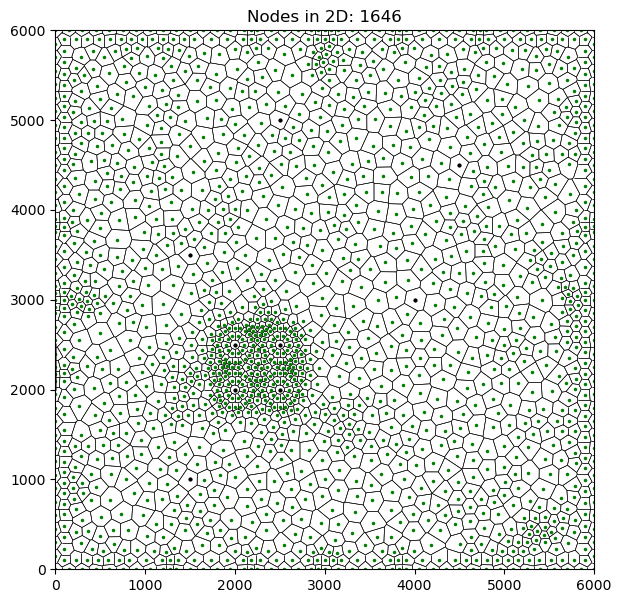

In [4]:
from meshing_routines import createcell2d
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, P.vornodes = createcell2d(P, grid = 'vor', fault = False)      

from meshing_routines import plot_cell2d_vor
plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

P.nlv  = 30  
P.delx, P.dely = 40, 40
P.ncol, P.nrow = int((P.x1 - P.x0) / P.delx), int((P.y1 - P.y0) / P.dely)
P.cell2dcar, P.xcyccar, P.verticescar, P.sg = createcell2d(P, grid = 'car', fault = False)    

### 3. Geological model (Reference)

C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


   ID data_type     X     Y      Z  val lithcode feature_name  gx  gy  gz
0  P1       raw   500   500  -50.0  -50        a        upper   0   0   1
1  P1       raw   500   500 -350.0 -100        b        lower   0   0   1
2  P1       raw   500   500 -450.0 -200        c        lower   0   0   1
3  P2       raw  2500  2500  -50.0  -50        a        upper   0   0   1
4  P2       raw  2500  2500 -150.0 -100        b        lower   0   0   1
5  P2       raw  2500  2500 -250.0 -200        c        lower   0   0   1
6  P3       raw  3000  3000    NaN  -50        a        upper   0   0   1
7  P3       raw  3000  3000    NaN -100        b        lower   0   0   1
8  P3       raw  3000  3000 -100.0 -200        c        lower   0   0   1
dict_keys(['upper', 'upper_unconformity', 'lower'])
Geomodel routines loaded!


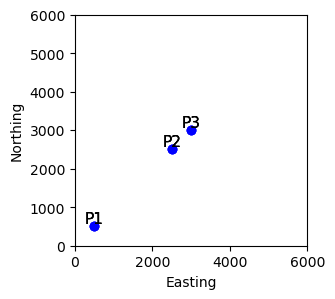

In [5]:
P.control_points = ([])
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "inverse_example") # CPz = -100
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)     # Prepare geomodel inputs
P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

print(P.data)
print(P.geomodel.feature_names())
from geomodel_routines import plot_bores
plot_bores(P)

### 4. Set up Flow model (Reference)

In [6]:
# Initiate REFERENCE
from loop2flopy import Model
R = Model('ref', P, plan = 'vor', transect = 'con') 
R.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)

# Sort out Well screens to be over entire geological layer
from modelling_routines import find_cell_disv
P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_icpl, wel_coords = find_cell_disv(P.xypumpbores[n][0], P.xypumpbores[n][1], R.xcyc)
    if P.geo_pl == 0:
        wel_top = R.top[wel_icpl]  
    else:   
        wel_top = R.botm[(P.geo_pl)* P.nls-1, wel_icpl]
    wel_bot = R.botm[(P.geo_pl + 1) * P.nls-1, wel_icpl]   
    print('Well coords ', wel_coords, ' Well screen top and bottom ', wel_top, wel_bot)
    P.wel_screens.append((wel_top, wel_bot))

zdepths = [-20, -60, -120]
P.zobs = np.zeros((P.nobs,P.nzobs))
for n in range(len(P.xyobsbores)):
    obs_icpl, obs_coords = find_cell_disv(P.xyobsbores[n][0], P.xyobsbores[n][1], R.xcyc) # Cell id in plan
    for m in range(3): # For the top three geological layers
        P.zobs[n][m] = zdepths[m]
print('\nobservation depths')
print(P.zobs)


# NEED TO PICKLE P.zobs and P.wel_screens
pickle.dump(P.wel_screens, open(P.results + 'wel_screens.pkl','wb'))
pickle.dump(P.zobs, open(P.results + 'zobs.pkl','wb'))

# Create flow model arrays
R.create_prop_arrays(P)         # Create property arrays (NPF)
R.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(R.modelname, ' has ', R.nnodes_div, ' nodes.')

   Creating lithology and discretisation arrays for  ref  ...
Modelling routines loaded!
Well coords  (np.float64(2000.0), np.float64(2000.0))  Well screen top and bottom  -194.0 -306.0
Well coords  (np.float64(2500.0), np.float64(2000.0))  Well screen top and bottom  -162.0 -274.0
Well coords  (np.float64(2000.0), np.float64(2500.0))  Well screen top and bottom  -162.0 -274.0
Well coords  (np.float64(2500.0), np.float64(2500.0))  Well screen top and bottom  -138.0 -252.0

observation depths
[[ -20.  -60. -120.]
 [ -20.  -60. -120.]
 [ -20.  -60. -120.]
 [ -20.  -60. -120.]
 [ -20.  -60. -120.]]
   Creating property arrays for  ref  ...
   Adding flow packages to  ref  ...
   Time taken =  1.239877
ref  has  13168  nodes.


### 5. Run Flow model (Reference)

In [7]:
results = R.write_run_model(P, period = 'Steady', ic_array = P.strt)
R.gwf, R.head_ss, R.obs_ss, R.runtime_ss = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  ref  ...
Period =  Steady 
   Model success =  True
   run_time =  12.58628


In [8]:
results = R.write_run_model(P, period = 'Past', ic_array = R.head_ss)
R.gwf, R.head_present, R.obs_present, R.runtime_past = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  ref  ...
Period =  Past 
   Model success =  True
   run_time =  30.367427


In [9]:
results = R.write_run_model(P, period = 'Future', ic_array = R.head_present)
R.gwf, R.head_future, R.obs_future, R.runtime_future = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  ref  ...
Period =  Future 
   Model success =  True
   run_time =  62.423996


### 6. Plot Results

Plotting routines loaded!


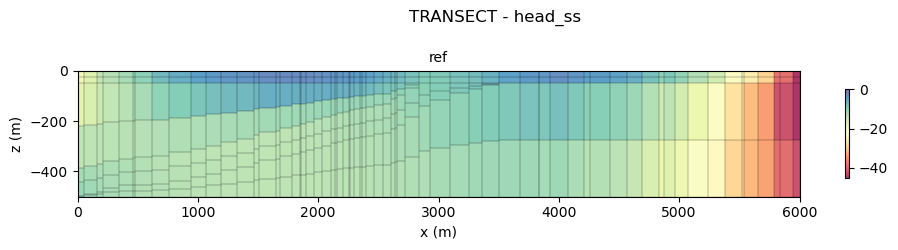

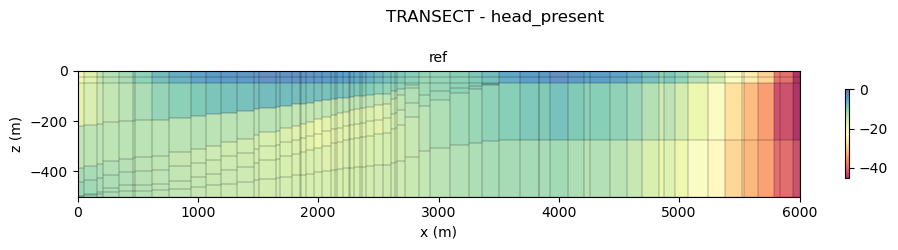

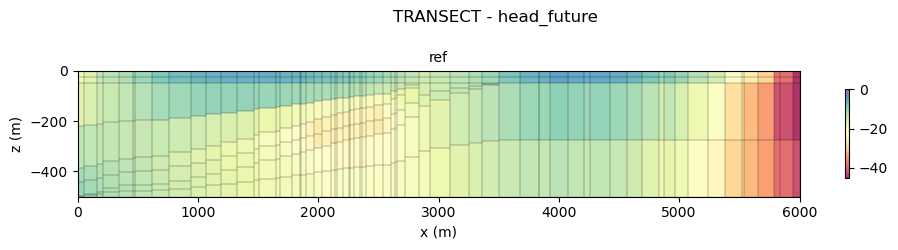

In [10]:
from plotting_routines import multiplot_prop_transect
multiplot_prop_transect(P, models = [R], array = 'head_ss', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_present', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, vmin = -45, vmax = 0)
multiplot_prop_transect(P, models = [R], array = 'head_future', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1, vmin = -45, vmax = 0)

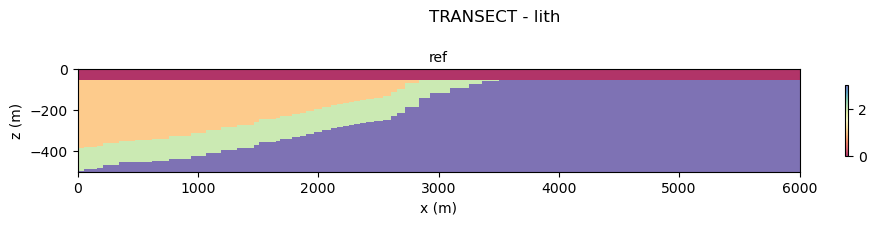

In [11]:
from plotting_routines import multiplot_vgrid_transect
multiplot_vgrid_transect(P, models = [R], array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1) 

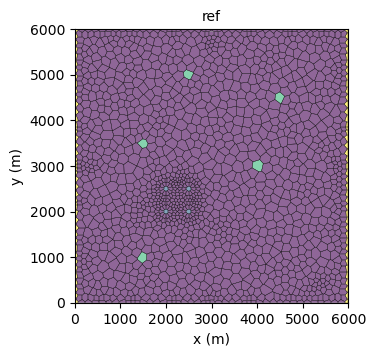

In [12]:
from plotting_routines import plot_flow_features
plot_flow_features(P, [R])

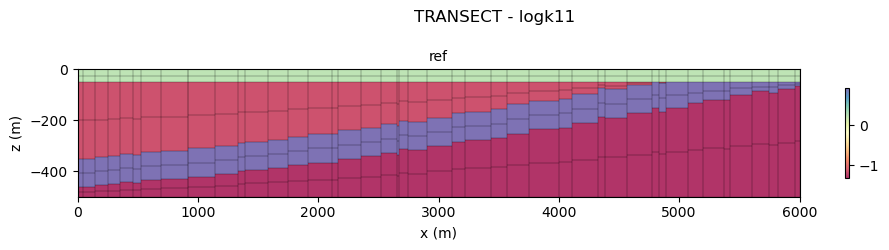

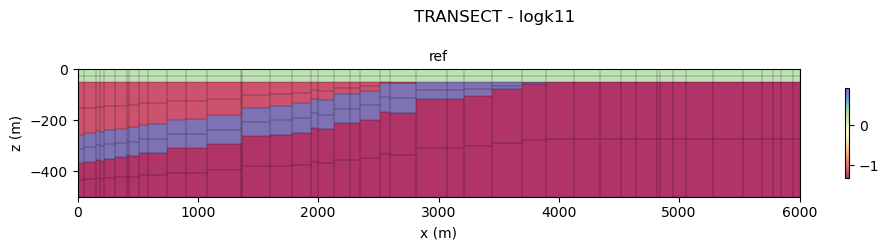

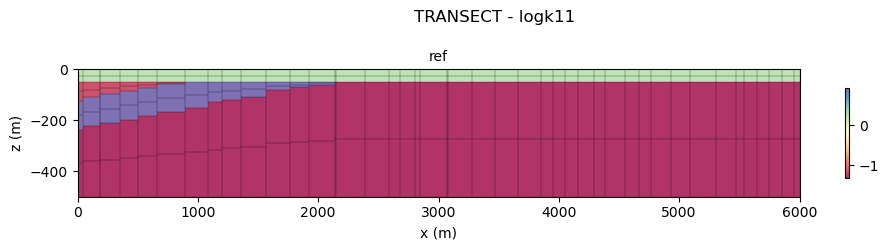

In [13]:
from plotting_routines import multiplot_prop_transect
y_ = [1000,3000,5000]
for y in y_:
    multiplot_prop_transect(P, models=[R], array ='logk11',X0=P.x0, Y0=y, X1=P.x1, Y1=y)#, vmin = -45, vmax = 0)

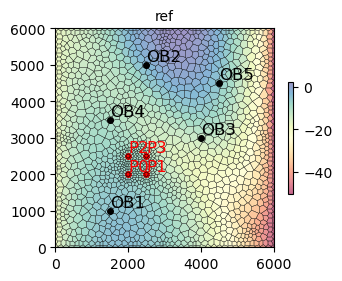

In [14]:
from plotting_routines import plot_bylayer
plot_bylayer(P, models = [R], layer = 0)#, vmin = -20, vmax = 5) 

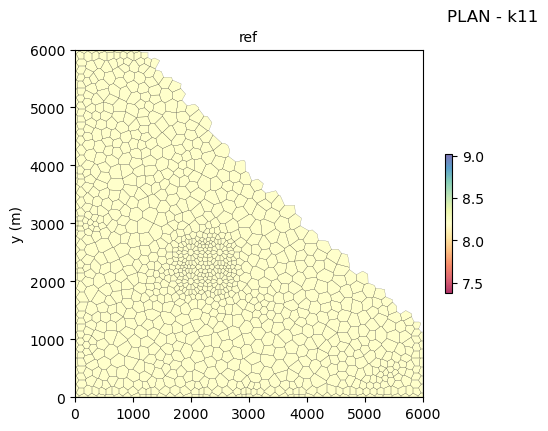

In [15]:
from plotting_routines import multiplot_prop_plan
multiplot_prop_plan(P, models = [R], array = 'k11', layer = 5)#, vmin = None, vmax = None)

In [16]:
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)
    
f = os.path.join(vtk_workspace, "test", R.modelname)
R.gwf.export(f, fmt="vtk")

### 7. Create "truth" observations and plot observations

In [17]:
# Get convert obs package to arrays of oberservation heads
R.ref_steady  = functions.process_obs_steady(P, R)
R.ref_past    = functions.process_obs_past(P, R)
R.ref_future  = functions.process_obs_future(P, R)

# Get times
csv_file = os.path.join(P.workspace, R.modelname + "_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365
csv_file = os.path.join(P.workspace, R.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2
times = list(times_past) + list(times_future)

# Pickle reference results
fname = P.results + 'ref_ss.pkl'
pickle.dump(R.ref_steady, open(os.path.join(fname),'wb'))
fname = P.results + 'ref_past.pkl'
pickle.dump(R.ref_past, open(os.path.join(fname),'wb'))
fname = P.results + 'ref_future.pkl'
pickle.dump(R.ref_future, open(os.path.join(fname),'wb'))
fname = P.results + 'times.pkl'
pickle.dump(times, open(os.path.join(fname),'wb'))

Text(0, 0.5, 'Head (m)')

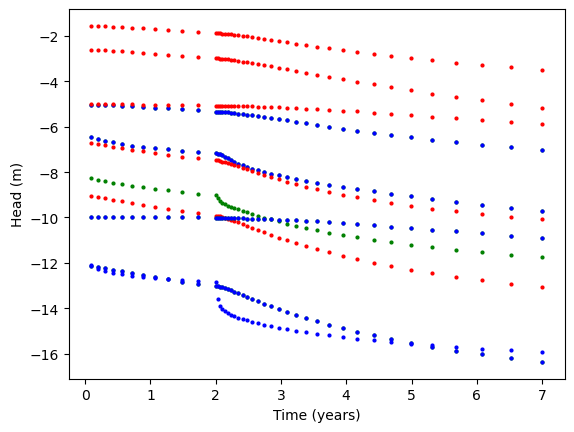

In [18]:
# PLOT REFERENCE OBSERVATIONS
import matplotlib.pyplot as plt
colors = ['red','green','blue']
R.ref_future.shape
for j in range(P.nobs):
    for i in range(P.nzobs):
        plt.plot(times_past, R.ref_past[j][i],'o', ms = 2, color = colors[i])
        plt.plot(times_future, R.ref_future[j][i],'o', ms = 2, color = colors[i])
plt.xlabel('Time (years)')
plt.ylabel('Head (m)')

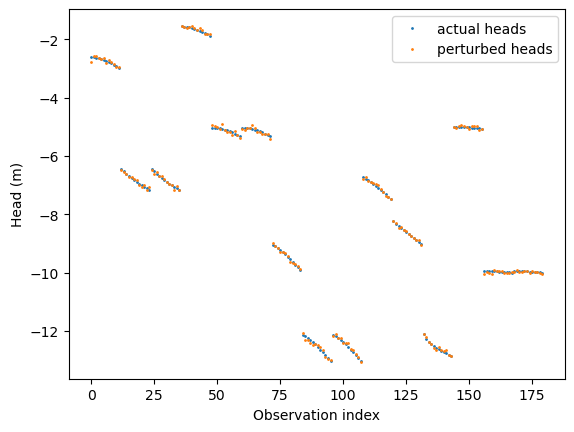

In [19]:
# CREATE SYNTHETIC OBSERVATIONS BY PERTURBING ACTUAL HEADS
err = 0.05
hobs_ref = np.copy(R.ref_past)    
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            hobs_ref[i][j][k] += np.random.normal(0.,err) # Perturb samples either side of measurement
plt.plot(R.ref_past.flatten(), 'o', ms = 1, label = 'actual heads')
plt.plot(hobs_ref.flatten(),'o', ms = 1, label = 'perturbed heads')
plt.xlabel('Observation index')
plt.ylabel('Head (m)')
plt.legend()

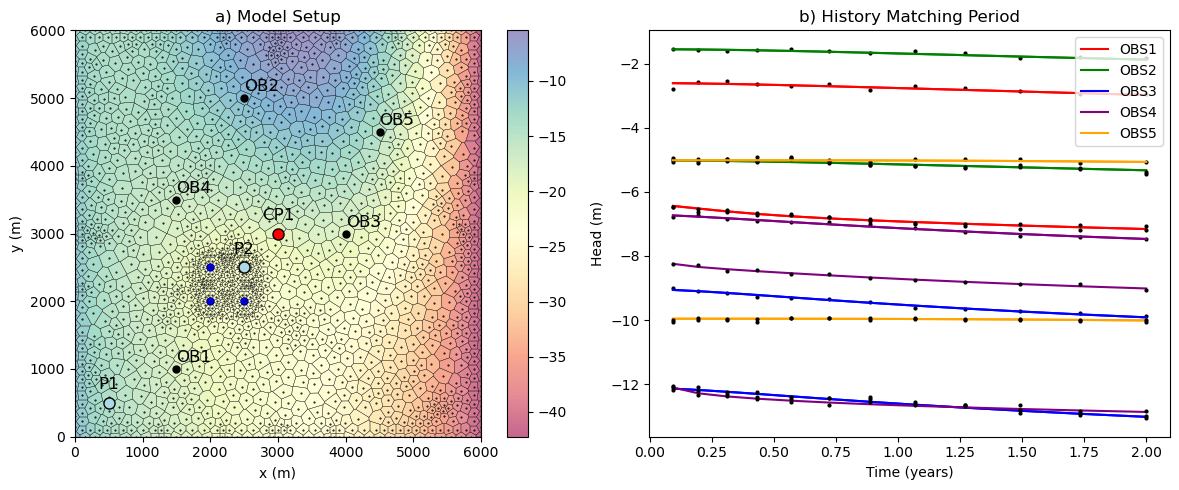

In [20]:
%run ./figures.ipynb   
figure8(P, R)

### 8. Prepare PEST input arrays

In [21]:
# PRINTING TRUTH HEADS FOR HISTORY MATCHING (PEST - HEADS.INS)
#hobs_ref.shape #(5, 3, 12)
#for i in range(P.nobs):
#    for j in range(P.nzobs):
#        for k in range(hobs_ref.shape[2]):
#            print('l1 [OBS%i_%i.%i]1:20' %(i, j, k))

In [22]:
# PRINTING TRUTH HEADS FOR HISTORY MATCHING (PEST - CONTROL.PST)
#for i in range(P.nobs):
#    for j in range(P.nzobs):
#        for k in range(hobs_ref.shape[2]):
#            print('OBS%i_%i.%i  %f  10.0  head' %(i, j, k, hobs_ref[i, j, k]))

### 9. Prepare parameter bounds

In [23]:
# LOG
k_min = [0, -2, 0, -2, -1, -2.5, -0.5, -2.5, -5, -5, -5]
k_max = [1, -1, 1, -1, 0, -1.5, 0.5, -1.5, -4, -4, -4]
k_mean = [(k_max[i] - k_min[i])/2 + k_min[i] for i in range(len(k_min))]

# LINEAR
print([10**i for i in k_max])
print([10**i for i in k_min])
print([10**i for i in k_mean])

[10, 0.1, 10, 0.1, 1, 0.03162277660168379, 3.1622776601683795, 0.03162277660168379, 0.0001, 0.0001, 0.0001]
[1, 0.01, 1, 0.01, 0.1, 0.0031622776601683794, 0.31622776601683794, 0.0031622776601683794, 1e-05, 1e-05, 1e-05]
[3.1622776601683795, 0.03162277660168379, 3.1622776601683795, 0.03162277660168379, 0.31622776601683794, 0.01, 1.0, 0.01, 3.1622776601683795e-05, 3.1622776601683795e-05, 3.1622776601683795e-05]


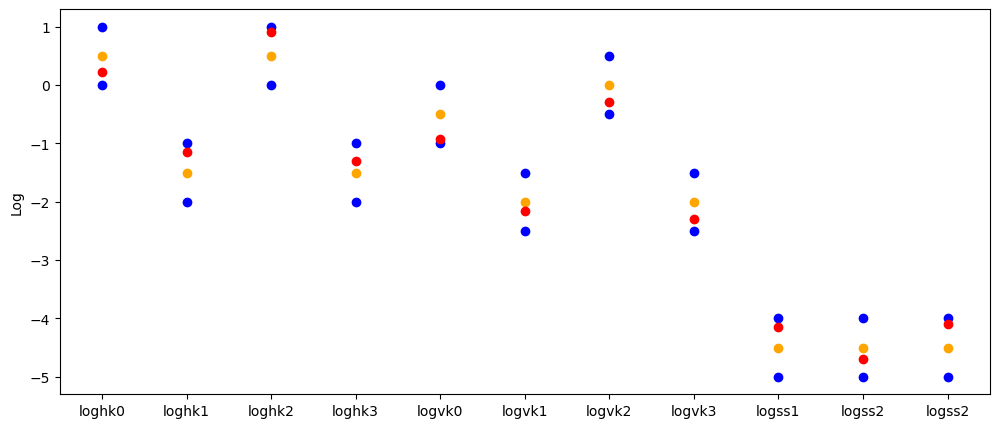

In [24]:
pickleoff = open('../results/reference.pkl','rb')
reference = pickle.load(pickleoff)
pickleoff.close()

# BLUE - MAX/MIN
# ORANGE - MEAN
# RED - ACTUAL
fig = plt.figure(figsize = (12,5))
plt.plot(np.linspace(0,10,11), k_min, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_max, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_mean, 'o', color = 'orange')
plt.plot(np.linspace(0,10,11), logfunc(reference[0] + reference[1] + reference[2][1:]), 'o', color = 'red')
plt.ylabel('Log')
plt.xticks(np.linspace(0,10,11), ['loghk0', 'loghk1', 'loghk2', 'loghk3', 
                                'logvk0', 'logvk1', 'logvk2', 'logvk3',
                                'logss1', 'logss2', 'logss2'])#, logss1, logss2, logss3, sy0, cp])
plt.show()

### 10. DREAM MCMC

In [25]:
sys.path.append('../../Lab_tools/Uncertainty_tools')  
from DREAM import *

def Likelihood(obs, mod, err):
    return(np.sum(-(obs-mod)**2/(2*err**2)))
    
Unif = [] # True = Uniform, False = Normal
Log = []  # ?? Just put False
Mean = []
Width = []  # for uniform distributon the range,  for normal, the standard deviation
Min = []
Max = []

###K values
for i in range(4):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i])
    Width.append((k_max[i] - k_min[i])/2.)
    Min.append(k_min[i]) 
    Max.append(k_max[i]) 

#make this anisotropy
for i in range(4):
    Unif.append(True) # True if uniform, False if normal
    Log.append(False) # Ignore
    Mean.append(k_mean[i+4])
    Width.append((k_max[i+4] - k_min[i+4])/2.)
    Min.append(k_min[i+4]) 
    Max.append(k_max[i+4]) # Changed 18/8
    
for i in range(3): # 1e-4 to 1e-6 # Botom 3 layers
    Unif.append(True) # True if uniform, False if normal
    Log.append(True) # Ignore
    Mean.append(-4.5)
    Width.append(0.5)
    Min.append(-5) 
    Max.append(-4)
    
#Sy top geo layer #0.05 - 0.2
Unif.append(True)
Log.append(False)
Mean.append(0.125)
Width.append(0.075)
Min.append(0.05)
Max.append(0.2)

#Control points z value
Unif.append(True)
Log.append(False)
Mean.append(-125)
Width.append(125)
Min.append(-250)
Max.append(0)

#### Set up DREAM and define "run model" function

In [26]:
## DREAM for Steady State
nchains = 5     #number of parallel chains 
npars = len(Mean)  #number of parameters
nburn = 100
minsamp = 169 # minimum number of samples

MCMC = [Min, Mean, Max, nchains, npars, nburn]
pickle.dump(MCMC, open(P.results + 'MCMC.pkl','wb'))


In [27]:
D = DREAM(nchains, npars, nburn = nburn, npairs = 1) #nburn is burn in perion, npairs defines how you sample
D.par_set(Log,Unif,Mean,Width,Min,Max) #initialise the class
D.set_CR(ncr=3)  #crossover testing thingy. Use 3
D.k = 1 # Number of things to try each chain. Numbers other than 1 can give weird results for some models

In [28]:
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
    
# Include this here when ignoring structural parameters
#P.control_points = ([])#(['CP1', 'control', 3000, 3000, -100, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
#P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
#P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

from datetime import datetime
geo_model_runtime, flow_model_runtime = [], []

def update_model(P, loghk0, loghk1, loghk2, loghk3, logvk0, logvk1, logvk2, logvk3, 
                 logss1, logss2, logss3, sy0, cp):
    t0 = datetime.now()
    del P.hk
    del P.vk
    del P.ss
    del P.sy
    P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3]
    P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3] 
    P.ss = [0.00009, 10**logss1, 10**logss2, 10**logss3]
    P.sy = [sy0, 0.1, 0.1, 0.1]
    P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', 0, 0, 1],) 
    P.data, P.strat = functions.prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
    P.geomodel = functions.create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel
    M = Model('run', P, plan = 'vor', transect = 'con') # Create flow model 
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    
    t1 = datetime.now()
    geo_model_runtime.append((t1 - t0).total_seconds())

    results = M.write_run_model(P, period = 'Steady', ic_array = P.strt)
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = results[0], results[1], results[2], results[-1]
    
    results = M.write_run_model(P, period = 'Past', ic_array = M.head_ss)   
    M.gwf, M.head_past, M.obs_past, M.runtime_past = results[0], results[1], results[2], results[-1]

    flow_model_runtime.append(M.runtime_ss + M.runtime_past)
    #hobs_steady = process_obs_steady(P, M)
    hobs_past = functions.process_obs_past(P, M)

    pickle.dump([geo_model_runtime, flow_model_runtime], open(P.results + 'run_times.pkl','wb'))
    return(hobs_past, M)

In [29]:
def run_prediction(M, ic_array):
    results = M.write_run_model(P, period = 'Future', ic_array = ic_array)   
    M.gwf, M.head_future, M.obs_future = results[0], results[1], results[2]
    hpred = functions.process_obs_future(P, M)
    return hpred

In [30]:
### Run model with truth parameters
heads = update_model(P, 
             np.log10(1.7), np.log10(0.07), np.log10(8.2), np.log10(0.05),
             np.log10(0.12), np.log10(0.007), np.log10(0.51), np.log10(0.005),
             np.log10(0.00007), np.log10(0.00002), np.log10(0.00008),
             0.12, -100)    

   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.385184
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.436711
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.837297


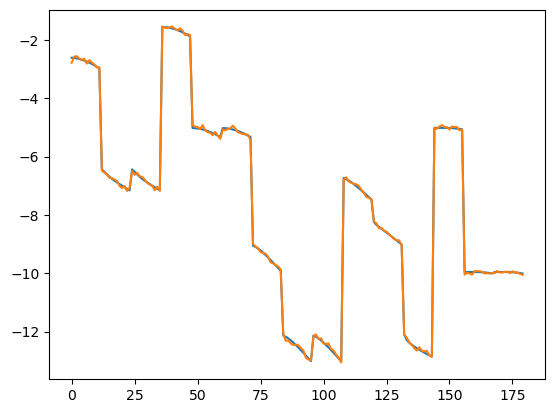

In [31]:
plt.plot(heads[0].flatten())
plt.plot(hobs_ref.flatten())

In [32]:
#this function and argument statement are for the labtools dream implementation.
def L_func(Prop, P, hobs_ref, err):
    hmod, M = update_model(P,
                        Prop[0],
                        Prop[1],
                        Prop[2],
                        Prop[3],
                        Prop[4],
                        Prop[5],
                        Prop[6],
                        Prop[7],
                        Prop[8],
                        Prop[9],
                        Prop[10],
                        Prop[11],
                        Prop[12],
                        ) 
    a = np.array(hobs_ref) 
    b = np.array(hmod)
    P.hmod = hmod
    P.M = M
    return(Likelihood(a,b,err))
    
args = (P, hobs_ref, err,) # P - project object, hobs_ref - real observations, err - 
    
def result_func(Prop,P):
    M = P.M
    hpred = run_prediction(M, ic_array = M.head_past)
    overall = np.append(P.hmod,hpred,axis=2)
    #print(overall)
    return(overall)

Rfunc_args = (P,)
    

In [34]:
"""for i in range(nchains):
    D.chains[i].current = ldum[i]"""

print('Launched DREAM at ', datetime.now())
results = Dream_ZS(D,       # DREAM class being used.
                   L_func,  # function that recieves the proposed pars, places in model, runs model & returns Likelihood 
                   args,    # contains all the args for the model outside of the parameters
                   result_func = result_func,      # save the model outputs
                   result_func_args = Rfunc_args,  
                   minsamp = minsamp,         
                   print_freq = 1,
                   Test = False,      # If True, only initial likelihoods obtained
                   lookback = 10,
                   R_overide = False)  # Stops even if R=1.2 not reached

Launched DREAM at  2024-10-16 09:51:46.493418
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.734897
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.099424
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.838368
Initial Likelihood for chain  0  =  -2066512.5858712834
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.892015
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.472298
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.92802
Initial Likelihood for chain  1  =  -585245.7389431694
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.12666
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.185016
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.793798
Initial Likelihood for chain  2  =  -3745873.410158855
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.084021
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.632494
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.013335
Initial Likelihood for chain  3  =  -280048.93874936865
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.859456
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.16015
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.254548
Initial Likelihood for chain  4  =  -4784687.910554381
0.6666666666666666
[-5.49114486e-01 -3.71832279e-01  0.00000000e+00  0.00000000e+00
  4.00090557e-02  4.99666203e-01  2.10732131e-01  0.00000000e+00
  0.00000000e+00 -3.29189456e-01  0.00000000e+00  0.00000000e+00
 -2.13078988e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.849741
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.59812
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.629889
[-987017.21740405] -2066512.5858712834
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1079495.368467229 inf
0.3333333333333333
[  0.           0.           0.54687874   0.46990782   0.
   0.           0.           0.           0.           0.
   0.           0.         -79.18324393]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.866591
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.446243
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.859056
[-791833.65022771] -585245.7389431694
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.16696375
  0.09691206  0.         -0.4625598   0.44118345  0.41342109  0.
 60.41819732]
-206587.91128453636 0.0
0.3333333333333333
[ 0.          0.         -0.54687874  0.          0.          0.
  0.04942266  0.         -0.23737062 -0.63619771  0.          0.00097659
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.882436
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.477833
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.007557
[-7403242.04117175] -3745873.410158855
0.6666666666666666
[ -0.70114193  -0.35884492   0.          -0.21899324   0.68130358
   0.          -0.24165663   0.56515339   0.          -0.78956866
  -0.11278969   0.         -85.23893372]
-3657368.6310128924 0.0
1.0
[-2.28502093e-01  1.34434508e-01 -5.46878742e-01 -4.69907815e-01
  2.02185801e-01 -7.88734574e-03  4.94226647e-02  3.46332009e-01
 -2.37370624e-01 -6.36197710e-01 -9.60332812e-02  9.76594662e-04
 -2.02727376e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.845097
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.977867
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.189784
[-673150.11019855] -280048.93874936865
0.3333333333333333
[ 2.01745154e-02  9.61193545e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.44744579e-01  0.00000000e+00
  3.26350341e-01  0.00000000e+00 -3.00631400e-01  0.00000000e+00
  2.48207364e+01]
-393101.17144917825 0.0
1.0
[-2.28502093e-01  1.34434508e-01 -5.46878742e-01 -4.69907815e-01
  2.02185801e-01 -7.88734574e-03  4.94226647e-02  3.46332009e-01
 -2.37370624e-01 -6.36197710e-01 -9.60332812e-02  9.76594662e-04
 -2.02727376e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.900902
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.211497
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.705994
[-1310670.68525092] -4784687.910554381
1.0
[-1.31852927e-01  1.09106717e-01 -1.22647933e-01  2.56770837e-01
  5.79966584e-02 -6.66629949e-01 -3.07644187e-01  6.83295847e-01
  5.00632864e-01 -1.11993997e-01 -6.66789297e-01  4.54904475e-02
  1.52660790e+02]
3474017.2253034636 inf
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  1
sampled =   2.0  tried =  5.0
Currenty sampling at a rate of  40.0 %
Current Likelihood for chain  0  =  -987017.2174040545
Current Likelihood for chain  1  =  -585245.7389431694
Current Likelihood for chain  2  =  -3745873.410158855
Current Likelihood for chain  3  =  -280048.93874936865
Current Likelihood for chain  4  =  -1310670.6852509174
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
1
0.3333333333333333
[-0.23850774  0.17185488  0.62209291  0.          0.15236818 -0.67031142
 -0.28457584  0.          0.         -0.408943

   run_time =  33.023336
[-529881.92356102] -987017.2174040545
1.0
[ 4.72639836e-01  4.93279424e-01 -2.14972877e-01 -2.50914573e-01
 -4.79117784e-01 -2.70736656e-01  2.91079299e-01 -2.18821385e-01
 -3.73580083e-01  1.53370948e-01  1.67564055e-02 -1.60059819e-02
  6.49661961e+01]
457135.293843033 inf
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.077805
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.629797
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  38.430233
[-585538.15681432] -585245.7389431694
1.0
[-3.20612393e-01 -5.06266787e-01  1.25052252e-01  2.77305195e-01
 -1.62176745e-01  5.07553548e-01  1.61309467e-01 -1.06820087e-01
  1.99297560e-01  3.07008254e-01  3.49401492e-01  4.34124001e-02
 -1.92806250e+02]
-292.4178711497225 1.010490301934242e-127
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -9.93649607e-14 -3.02868841e-13
  0.00000000e+00  0.00000000e+00 -9.83605714e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.94559815e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.025603
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.375879
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.961413
[-5039798.97127417] -3745873.410158855
1.0
[-2.01745154e-02 -9.61193545e-02  2.12568558e-01 -2.83161459e-01
  5.83297871e-01  4.29813056e-01 -1.44744579e-01 -3.57654375e-01
 -3.26350341e-01 -3.48385206e-01  3.00631400e-01 -7.28968656e-02
 -2.48207364e+01]
-1293925.561115317 0.0
0.3333333333333333
[0.         0.         0.         0.         0.00980857 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.078493
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.906119
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.737112
[-280015.61594314] -280048.93874936865
0.3333333333333333
[ 0.          0.         -0.33190587  0.          0.          0.
 -0.24165663  0.          0.          0.          0.          0.01698258
  0.        ]
33.322806231386494 296422296650063.7
0.6666666666666666
[-3.20612393e-01 -5.06266787e-01  1.25052252e-01  0.00000000e+00
 -1.62176745e-01  0.00000000e+00  1.61309467e-01 -1.06820087e-01
  0.00000000e+00  3.07008254e-01  0.00000000e+00  4.34124001e-02
 -1.92806250e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.53282
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.865988
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.14848
[-4827118.71905945] -1310670.6852509174
1.0
[ 4.72639836e-01  4.93279424e-01 -2.14972877e-01 -2.50914573e-01
 -4.79117784e-01 -2.70736656e-01  2.91079299e-01 -2.18821385e-01
 -3.73580083e-01  1.53370948e-01  1.67564055e-02 -1.60059819e-02
  6.49661961e+01]
-3516448.033808536 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  2
sampled =   4.0  tried =  10.0
Currenty sampling at a rate of  40.0 %
Current Likelihood for chain  0  =  -529881.9235610215
Current Likelihood for chain  1  =  -585245.7389431694
Current Likelihood for chain  2  =  -3745873.410158855
Current Likelihood for chain  3  =  -280015.61594313727
Current Likelihood for chain  4  =  -1310670.6852509174
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
2
1.0
[ 4.72639836e-01  4.93279424e-01 -2.14972877e-01 -2.50914573e-01
 -4.79117784e-01 -2.70736656e-01  2.91079299e-01 -2.18821385e-01
 -3

   run_time =  29.975801
[-1261682.23830812] -529881.9235610215
0.6666666666666666
[-4.72639836e-01 -4.93279424e-01  2.14972877e-01  2.50914573e-01
  4.74539571e-01  2.70736656e-01 -2.91079299e-01  2.18821385e-01
  3.73580083e-01  0.00000000e+00  0.00000000e+00  1.60059819e-02
 -6.49661961e+01]
-731800.3147471028 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.93237
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.900288
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.297983
[-585300.99248596] -585245.7389431694
1.0
[ 5.31319526e-01  2.64222977e-02 -2.00266423e-01  1.55164264e-01
 -1.73702748e-01  4.03867614e-01  1.72204282e-01 -8.44604518e-02
 -3.51765542e-01  5.84481520e-01  4.58245235e-01 -9.03352740e-02
 -2.95753542e+01]
-55.253542794962414 1.0085356596600872e-24
1.0
[-7.01141928e-01 -3.58844916e-01 -3.31905866e-01 -2.18993242e-01
  6.81303585e-01  2.62849310e-01 -2.41656634e-01  5.65153394e-01
  1.36209460e-01 -7.89568658e-01 -1.12789687e-01  1.69825766e-02
 -8.52389337e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.909794
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.003287
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.247504
[-1363123.31130301] -3745873.410158855
1.0
[ 1.81486769e-01  2.78491550e-01 -2.87807660e-01  1.92602620e-01
  4.97842483e-02 -5.79315949e-01 -2.45199156e-01 -2.39511922e-01
  3.80730637e-02 -1.53387567e-02 -2.53368211e-01 -4.43889948e-02
  1.13623006e+02]
2382750.098855844 inf
0.6666666666666666
[  0.75921782   0.67363932  -0.68709148  -0.16604548  -0.19307084
   0.55618112   0.           0.74448191  -0.15197945   0.
   0.29281024  -0.06542597 -55.14412432]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.068657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.719528
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.139766
[-3034498.23402807] -280015.61594313727
0.6666666666666666
[-1.52027443e-01  1.29873629e-02  0.00000000e+00 -2.63906218e-02
  6.41294529e-01 -2.36816893e-01 -4.52388766e-01  3.25641472e-01
  1.74282523e-01 -4.60379202e-01 -3.66157897e-01  0.00000000e+00
  1.27840054e+02]
-2754482.6180849345 0.0
1.0
[-3.39223305e-01 -5.67002651e-01 -2.22809098e-01  3.21209739e-01
  9.04869096e-02 -4.65185655e-01  3.19984391e-01 -8.28942359e-01
 -1.99786097e-01 -1.86423328e-01  1.65434995e-01 -2.49093029e-02
  2.55687702e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.983488
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.205431
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.850153
[-2712624.44714819] -1310670.6852509174
0.3333333333333333
[ 0.          0.26550419  0.          0.21899324 -0.59151028 -0.34249906
  0.          0.          0.          0.          0.          0.
  0.        ]
-1401953.7618972696 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  3
sampled =   5.0  tried =  15.0
Currenty sampling at a rate of  33.3 %
Current Likelihood for chain  0  =  -529881.9235610215
Current Likelihood for chain  1  =  -585245.7389431694
Current Likelihood for chain  2  =  -1363123.3113030111
Current Likelihood for chain  3  =  -280015.61594313727
Current Likelihood for chain  4  =  -1310670.6852509174
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
3
0.3333333333333333
[ 0.13185293  0.          0.          0.          0.          0.66662995
  0.          0.         -0.50063286  0.111994    0.         -0.04549045
  0.        ]
 

   run_time =  27.586411
[-299490.47924497] -529881.9235610215
0.3333333333333333
[ 0.00000000e+00  6.27481673e-02  0.00000000e+00  0.00000000e+00
  9.43715168e-02 -3.68146912e-03  0.00000000e+00 -8.38347318e-01
  0.00000000e+00  0.00000000e+00 -4.48241488e-02  0.00000000e+00
 -9.46243006e+00]
230391.4443160512 inf
1.0
[ 1.52027443e-01 -1.29873629e-02 -8.99206246e-02  2.63906218e-02
 -6.41294529e-01  2.36816893e-01  4.52388766e-01 -3.25641472e-01
 -1.74282523e-01  4.60379202e-01  3.66157897e-01  2.74064182e-02
 -1.27840054e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.945446
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.469162
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.851301
[-1716859.57480138] -585245.7389431694
1.0
[  0.41999451   0.10663667  -0.90990057   0.15516426  -0.10258393
   0.09099547   0.03937669  -0.08446045  -0.35176554   0.39360459
   0.45824524  -0.09033527 -29.57535416]
-1131613.8358582128 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.03807306  0.         -0.25336821  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.852321
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.714993
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.951637
[-1367087.78704466] -1363123.3113030111
0.6666666666666666
[-0.18148677 -0.27849155  0.28780766  0.         -0.04978425  0.57931595
  0.24519916  0.23951192 -0.03807306  0.          0.          0.04438899
  0.        ]
-3964.4757416490465 0.0
0.3333333333333333
[ 0.          0.          0.          0.25091457  0.          0.
  0.          0.          0.          0.         -0.01675641  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.941624
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.128336
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.031403
[-263731.5259099] -280015.61594313727
0.6666666666666666
[ 0.23850774 -0.17185488  0.         -0.03743836 -0.15236818  0.67031142
  0.          0.15505147 -0.38983861  0.          0.71161345  0.
  0.        ]
16284.090033237531 inf
0.6666666666666666
[ 0.          0.         -0.62209291 -0.03743836  0.          0.67031142
  0.28457584  0.15505147 -0.38983861  0.          0.71161345 -0.04594628
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.878072
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.861775
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.400067
[-2781887.0436586] -1310670.6852509174
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1471216.3584076809 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  4
sampled =   7.0  tried =  20.0
Currenty sampling at a rate of  35.0 %
Current Likelihood for chain  0  =  -299490.47924497025
Current Likelihood for chain  1  =  -585245.7389431694
Current Likelihood for chain  2  =  -1363123.3113030111
Current Likelihood for chain  3  =  -263731.52590989973
Current Likelihood for chain  4  =  -1310670.6852509174
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
4
1.0
[-1.06654815e-01  6.27481673e-02  7.44740846e-01 -2.19332481e-01
  9.43715168e-02 -3.68146912e-03  2.30683452e-02 -8.38347318e-01
 -1.10794258e-01 -2.96949354e-01 -4.48241488e-02  4.55831811e-04
 -9.46243006e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays

   run_time =  26.155338
[-267490.77759242] -299490.47924497025
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
31999.70165254624 inf
1.0
[-4.12739333e-01 -3.05925616e-02  3.51066956e-02 -2.19332481e-01
  1.84164821e-01  2.27822580e-01 -1.13986795e-02  1.61652682e-01
 -3.44467852e-01 -5.89203651e-01 -4.48241488e-02 -2.07771258e-02
 -1.08918412e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.849196
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.753404
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.589314
[-1810782.97241762] -585245.7389431694
0.6666666666666666
[ 0.          0.          0.68709148  0.16604548  0.19307084 -0.55618112
  0.2806077   0.          0.15197945 -0.58002792 -0.29281024  0.06542597
 55.14412432]
-1225537.2334744534 0.0
0.6666666666666666
[-6.72737516e-01 -8.32506838e-01  1.54919187e-01  1.02216498e-01
  6.81997190e-01 -1.22686598e-01  1.12794781e-01 -2.63788965e-01
  0.00000000e+00  0.00000000e+00  5.26453083e-02 -7.92672635e-03
  3.97858180e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.017604
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.938368
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.352294
[-3791206.05654075] -1363123.3113030111
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-2428082.745237738 0.0
0.3333333333333333
[ 0.07758243  0.22777524  0.          0.          0.          0.
  0.08388969  0.          0.         -0.34394341 -0.09603328  0.02220955
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.941619
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.47745
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.700399
[-373652.54561826] -263731.52590989973
1.0
[-0.04511162  0.06274817  0.74474085 -0.21933248  0.09437152  0.30747233
  0.02306835  0.16165268 -0.34446785 -0.24467544 -0.04482415 -0.02077713
 -9.46243006]
-109921.01970836346 0.0
1.0
[-1.39125624e-01 -2.27775237e-01 -1.62755408e-01  3.52791832e-01
 -1.16970709e-01 -7.17624010e-02 -8.38896894e-02 -3.46332009e-01
  2.37370624e-01  2.91669497e-01  1.03854441e-01 -9.76594665e-04
 -7.91832439e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.049102
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.066172
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.877116
[-4068706.27099814] -1310670.6852509174
0.3333333333333333
[-0.47263984 -0.49327942  0.          0.          0.          0.
 -0.2910793   0.          0.         -0.15337095  0.          0.
  0.        ]
-2758035.5857472233 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  5
sampled =   8.0  tried =  25.0
Currenty sampling at a rate of  32.0 %
Current Likelihood for chain  0  =  -267490.777592424
Current Likelihood for chain  1  =  -585245.7389431694
Current Likelihood for chain  2  =  -1363123.3113030111
Current Likelihood for chain  3  =  -263731.52590989973
Current Likelihood for chain  4  =  -1310670.6852509174
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
5
0.6666666666666666
[-1.52027443e-01  1.29873629e-02  8.99206246e-02 -2.63906218e-02
  6.41294529e-01 -2.36816893e-01  0.00000000e+00  0.00000000e+00
  1.74282523e-01 -4.60379202e-01  0.0000

   run_time =  27.038248
[-145656.38619274] -267490.777592424
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -3.31905866e-01 -2.18993242e-01
  6.81303585e-01  0.00000000e+00 -2.41656634e-01  5.65153394e-01
  1.36209460e-01 -7.89568658e-01 -1.12789687e-01  1.69825766e-02
 -8.52389337e+01]
121834.39139968058 inf
1.0
[  0.0864803   -0.15886752  -0.53217229  -0.06382898   0.48892635
   0.43349453  -0.16781292   0.48069294  -0.21555608  -0.05143585
   0.34545555  -0.0733527  -15.35830634]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.010622
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.535331
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  44.737888
[-574498.77421452] -585245.7389431694
0.3333333333333333
[ 0.44483923  0.          0.          0.         -0.6626291  -0.02962691
  0.         -0.56515339  0.          0.63591737  0.          0.
  0.        ]
10746.964728645398 inf
0.6666666666666666
[-0.23850774  0.17185488  0.62209291  0.          0.         -0.67031142
 -0.28457584 -0.15505147  0.38983861  0.         -0.71161345  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.10894
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.860993
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.715936
[-929510.04717471] -1363123.3113030111
0.6666666666666666
[-1.36375152e-01 -3.41239717e-01  0.00000000e+00  2.67298609e-02
 -1.44155765e-01  2.71843622e-01  0.00000000e+00  7.78592400e-02
  3.06394788e-01  2.60014196e-01  2.98192359e-01  0.00000000e+00
 -1.04160576e+02]
433613.2641283036 inf
1.0
[-0.48153771 -0.10663667  0.90990057 -0.15516426  0.10258393 -0.40214926
 -0.03937669  0.08446045  0.58543914 -0.44587851 -0.45824524  0.11156823
 29.57535416]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.883639
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.819638
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.288808
[-773625.96960324] -263731.52590989973
0.6666666666666666
[  0.           0.10663667   0.           0.15516426   0.
   0.09099547   0.           0.           0.           0.
   0.45824524  -0.09033527 -29.57535416]
-509894.4436933447 0.0
1.0
[  0.4552947    0.49819255  -0.56390278  -0.08955927  -0.48418675
   0.26824913  -0.34305274   0.66728968   0.46290647   0.64598371
  -0.12061085  -0.09152145 -75.77650366]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.91849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.588388
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.831723
[-301957.24515267] -1310670.6852509174
0.3333333333333333
[ 0.00000000e+00  1.98277182e-01  4.21826490e-01  0.00000000e+00
  0.00000000e+00 -2.66443804e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.43889948e-02
  1.13623006e+02]
1008713.4400982505 inf
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  6
sampled =   12.0  tried =  30.0
Currenty sampling at a rate of  40.0 %
Current Likelihood for chain  0  =  -145656.38619274343
Current Likelihood for chain  1  =  -574498.774214524
Current Likelihood for chain  2  =  -929510.0471747075
Current Likelihood for chain  3  =  -263731.52590989973
Current Likelihood for chain  4  =  -301957.24515266693
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
6
Minimum likelihood for outlier chains is:  -2395835.5638347026
0.3333333333333333
[ 0.          0.          0.          0

   run_time =  25.88613
[-147237.41711751] -145656.38619274343
1.0
[-3.46608417e-01 -1.01877341e-01  4.83939934e-01  1.55825207e-01
 -2.40384049e-01 -3.75508718e-02 -2.83388436e-01  4.95901713e-02
 -1.94799278e-01  1.99581934e-01 -4.10686679e-01  4.66404566e-02
 -8.49770579e+01]
-1581.0309247618716 0.0
0.6666666666666666
[-5.59120135e-01 -3.34411902e-01  7.47145165e-01  1.97627568e-01
 -1.43867826e-02  0.00000000e+00 -1.23266375e-01  0.00000000e+00
  5.89136166e-01 -1.01935096e-01 -3.54390795e-01  8.93586794e-02
 -4.96078898e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.932526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.072722
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  43.923813
[-2107838.22333346] -574498.774214524
0.3333333333333333
[ 0.00000000e+00  1.71854885e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.70311418e-01 -2.84575842e-01  0.00000000e+00
  3.89838606e-01 -4.08943350e-01  0.00000000e+00  4.59462793e-02
  1.43198360e+02]
-1533339.4491189336 0.0
0.6666666666666666
[ 0.00000000e+00  3.97160070e-01 -2.40431884e-03 -5.34076032e-01
  0.00000000e+00  1.59076401e-01  0.00000000e+00 -5.76475761e-01
  0.00000000e+00 -1.95014257e-01  3.17387805e-01 -8.89028476e-02
  4.01454597e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.011756
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.030796
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.145596
[-789601.43135067] -929510.0471747075
1.0
[  0.75921782   0.67363932  -0.68709148  -0.16604548  -0.19307084
   0.55618112  -0.2806077    0.74448191  -0.15197945   0.58002792
   0.29281024  -0.06542597 -55.14412432]
139908.61582403607 inf
0.3333333333333333
[ 0.          0.          0.         -0.03158209  0.          0.
  0.         -0.48261035  0.         -0.47809283  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.06577
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.591821
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.558682
[-248577.29517856] -263731.52590989973
0.6666666666666666
[-0.27887298  0.24600732  0.          0.06723094  0.          0.12735224
 -0.20624809 -0.37941798  0.49045079 -0.38493534  0.12714297  0.
  0.        ]
15154.2307313419 inf
1.0
[ 5.20710074e-01  8.45494201e-01 -6.49985629e-02 -1.28607119e-01
 -4.07026612e-02 -1.14130295e-01 -5.65183547e-01  5.89430437e-01
  2.37859161e-01  1.71084572e-01 -4.18803206e-01 -1.94796918e-02
  8.80542359e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.303252
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.67238
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.354154
[-184216.71694946] -301957.24515266693
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
117740.52820320358 inf
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  7
sampled =   15.0  tried =  35.0
Currenty sampling at a rate of  42.9 %
Current Likelihood for chain  0  =  -145656.38619274343
Current Likelihood for chain  1  =  -574498.774214524
Current Likelihood for chain  2  =  -789601.4313506715
Current Likelihood for chain  3  =  -248577.29517855783
Current Likelihood for chain  4  =  -184216.71694946336
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
7
Minimum likelihood for outlier chains is:  -1810750.5629988457
0.3333333333333333
[ 0.         -0.67363932  0.          0.16604548  0.          0.
  0.2806077   0.          0.         -0.58002792  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property

   run_time =  26.227115
[-103172.85512562] -145656.38619274343
0.6666666666666666
[  0.          -0.18339815   0.34801522  -0.38537796  -0.09869932
   0.23962751   0.           0.          -0.08081404   0.28307857
  -0.08416404  -0.06497014 -64.60655438]
42483.531067125354 inf
0.3333333333333333
[0.         0.         0.53217229 0.06382898 0.         0.
 0.16781292 0.         0.         0.         0.         0.0733527
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.853049
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.378586
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  42.267783
[-1177978.87955021] -574498.774214524
0.3333333333333333
[ 0.          0.          0.16275541 -0.35279183  0.         -0.2393914
  0.08388969  0.          0.          0.         -0.10385444  0.02220955
  0.        ]
-603480.1053356895 0.0
0.3333333333333333
[   0.           -0.37183228    0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.         -213.07898765]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.045155
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.559624
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.061553
[-3475623.6644219] -789601.4313506715
0.3333333333333333
[  0.           0.           0.2228091    0.           0.
   0.           0.           0.           0.           0.
   0.           0.04614226 -25.56877016]
-2686022.2330712248 0.0
1.0
[-1.39125624e-01 -2.27775237e-01 -1.62755408e-01  3.52791832e-01
 -1.16970709e-01 -7.17624010e-02 -8.38896894e-02 -3.46332009e-01
  2.37370624e-01  2.91669497e-01  1.03854441e-01 -9.76594665e-04
 -7.91832439e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.039148
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.86874
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.093878
[-462549.10709006] -248577.29517855783
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.11593562
  0.          0.          0.2455363   0.          0.          0.
  0.        ]
-213971.8119114973 0.0
1.0
[ 1.39125624e-01  2.27775237e-01  1.62755408e-01 -3.52791832e-01
  1.16970709e-01  7.17624010e-02  8.38896894e-02  3.46332009e-01
 -2.37370624e-01 -2.91669497e-01 -1.03854441e-01  9.76594665e-04
  7.91832439e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.943106
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.515069
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.111916
[-219009.47494692] -184216.71694946336
0.3333333333333333
[ 0.          0.42145408  0.         -0.00925527  0.          0.
  0.          0.         -0.12443512  0.          0.          0.
  0.        ]
-34792.75799745807 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  8
sampled =   16.0  tried =  40.0
Currenty sampling at a rate of  40.0 %
Current Likelihood for chain  0  =  -103172.85512561808
Current Likelihood for chain  1  =  -574498.774214524
Current Likelihood for chain  2  =  -789601.4313506715
Current Likelihood for chain  3  =  -248577.29517855783
Current Likelihood for chain  4  =  -184216.71694946336
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
8
Minimum likelihood for outlier chains is:  -1219247.725101598
0.6666666666666666
[-0.44483923 -0.18528982 -0.33190587 -0.21899324  0.6626291   0.
 -0.34001721  0.          0.13620946 -0.6359

   run_time =  35.404098
[-2399733.25382323] -103172.85512561808
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-2296560.3986976133 0.0
0.3333333333333333
[ 0.          0.          0.          0.46990782  0.         -0.0717624
  0.          0.          0.          0.          0.         -0.00097659
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.925597
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.657772
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  41.20276
[-590845.96965923] -574498.774214524
0.6666666666666666
[ 0.00000000e+00  1.83259150e-01  1.25746889e-01  2.86563421e-01
 -1.70212847e-01  1.31033706e-01  0.00000000e+00  4.58929339e-01
  6.01245045e-01 -8.79859832e-02  1.71967114e-01  7.97282886e-02
  1.59829378e+02]
-16347.195444709389 0.0
1.0
[-0.21251172 -0.23253456  0.26320523  0.04180236  0.22599727 -0.125207
  0.16012206 -0.31146173  0.78393544 -0.30151703  0.05629588  0.04271822
 35.36916818]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.855861
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.309391
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.805997
[-384571.52391979] -789601.4313506715
0.3333333333333333
[-0.21704874  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
405029.9074308822 inf
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.862459
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.820626
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.619467
[-248587.49592735] -248577.29517855783
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-10.200748791306978 3.714249629050164e-05
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.61911639 -0.38706867  0.25340906  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.957889
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.897358
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.438126
[-174271.61012013] -184216.71694946336
0.6666666666666666
[-0.20748279  0.          0.         -0.19696662 -0.12341334  0.03421153
 -0.19949875  0.39592218 -0.4321699   0.         -0.51454112  0.04761705
 -5.79381402]
9945.106829332479 inf
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  9
sampled =   18.0  tried =  45.0
Currenty sampling at a rate of  40.0 %
Current Likelihood for chain  0  =  -103172.85512561808
Current Likelihood for chain  1  =  -574498.774214524
Current Likelihood for chain  2  =  -384571.52391978924
Current Likelihood for chain  3  =  -248577.29517855783
Current Likelihood for chain  4  =  -174271.61012013088
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
9
Minimum likelihood for outlier chains is:  -1220666.5265385695
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.17115983e-01
  0.00000000e+00 -1.5232259

   run_time =  27.21255
[-153545.38722851] -103172.85512561808
0.6666666666666666
[-2.55197023e-01  0.00000000e+00  0.00000000e+00  2.38257343e-01
  2.81307347e-01  0.00000000e+00 -6.08213443e-02  0.00000000e+00
 -2.57497453e-02 -1.67890882e-01  0.00000000e+00  0.00000000e+00
 -2.89755104e+01]
-50372.53210289404 0.0
0.6666666666666666
[-0.55912013 -0.3344119   0.74714516  0.          0.          0.
  0.          0.          0.58913617  0.         -0.35439079  0.08935868
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.879164
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.149785
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  40.133138
[-7763014.27591249] -574498.774214524
1.0
[-4.80344840e-01 -9.19646634e-01 -1.83396259e-01  9.88145351e-02
  2.68912167e-01 -6.83533361e-01  4.86855791e-01 -3.65063929e-01
 -3.38471342e-01 -1.95092585e-01 -4.19953206e-01 -1.47581493e-02
 -9.52228238e+01]
-7188515.501697969 0.0
0.6666666666666666
[ 2.00097681e-01  0.00000000e+00  0.00000000e+00  1.48698076e-01
 -2.07457619e-01  3.93423254e-01 -4.03874080e-01  0.00000000e+00
  0.00000000e+00  4.78092826e-01 -6.94017138e-02  2.39327083e-02
 -1.04752014e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.876476
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.367435
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.339238
[-4249057.50861261] -384571.52391978924
0.6666666666666666
[-0.5487016   0.16930631  0.          0.39581736  0.08758517 -0.25911774
  0.3386973  -0.25766013  0.         -0.34826876 -0.13507936  0.08698294
  0.        ]
-3864485.9846928176 0.0
1.0
[ 5.59120135e-01  3.34411902e-01 -7.47145165e-01 -2.12368712e-01
  1.43867826e-02  1.62757870e-01  1.23266375e-01  3.66100867e-02
 -5.89136166e-01 -1.21217791e-01  3.54390795e-01 -8.93586794e-02
  4.96078898e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.016562
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.446403
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.691218
[-1792310.32846753] -248577.29517855783
1.0
[-2.80247160e-01 -5.80419220e-01 -1.23342570e-01  1.45137771e-01
  6.14545478e-02 -2.90110107e-01  8.29817103e-02  3.42807892e-01
  9.86853783e-02  5.06153128e-01 -4.81533760e-01  9.17455898e-03
 -1.99974838e+02]
-1543733.033288973 0.0
1.0
[ 4.72639836e-01  4.93279424e-01 -2.14972877e-01 -2.50914573e-01
 -4.79117784e-01 -2.70736656e-01  2.91079299e-01 -2.18821385e-01
 -3.73580083e-01  1.53370948e-01  1.67564055e-02 -1.60059819e-02
  6.49661961e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.973758
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.336083
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.037017
[-2771632.00610647] -174271.61012013088
0.3333333333333333
[ 0.         -0.22777524 -0.16275541  0.          0.         -0.0717624
 -0.08388969  0.          0.          0.51482238  0.10385444 -0.00097659
  0.        ]
-2597360.3959863423 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  10
sampled =   18.0  tried =  50.0
Currenty sampling at a rate of  36.0 %
Current Likelihood for chain  0  =  -103172.85512561808
Current Likelihood for chain  1  =  -574498.774214524
Current Likelihood for chain  2  =  -384571.52391978924
Current Likelihood for chain  3  =  -248577.29517855783
Current Likelihood for chain  4  =  -174271.61012013088
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
10
Minimum likelihood for outlier chains is:  -1315922.7629268295
0.6666666666666666
[ 3.74882894e-01  0.00000000e+00 -1.65159727e-01 -6.41682173e-02
 -8.21241005e-03  3.984

   run_time =  25.192999
[-337173.28359688] -103172.85512561808
0.6666666666666666
[ 0.19239268  0.         -0.33831545 -0.00340196 -0.41308502  0.
  0.37406101 -0.10127496 -0.2748947   0.          0.          0.
  0.        ]
-234000.42847126597 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.863832
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.643987
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  43.145972
[-574467.37800273] -574498.774214524
0.3333333333333333
[ 0.00000000e+00 -7.54951657e-13  0.00000000e+00  3.11972670e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.22502009e-12
  0.00000000e+00  0.00000000e+00  8.81719701e-01  0.00000000e+00
  0.00000000e+00]
31.39621179306414 43171936976372.81
1.0
[ 1.02484687e-12 -7.54507568e-13 -2.00950367e-13  1.17115983e-01
 -1.15130128e-13  1.52322599e-13  1.90908400e-12  1.09956488e-12
 -8.41993142e-13  2.90523161e-12 -7.82115952e-03  1.02726161e-12
 -4.44089210e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.952939
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.919262
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.122249
[-396926.69040451] -384571.52391978924
1.0
[-2.38507742e-01  1.71854885e-01  6.22092913e-01  3.74383564e-02
  1.52368175e-01 -6.70311418e-01 -2.84575842e-01 -1.55051470e-01
  3.89838606e-01 -4.08943350e-01 -7.11613446e-01  4.59462793e-02
  1.43198360e+02]
-12355.166484724323 0.0
0.6666666666666666
[ 0.10356366 -0.29276249 -0.45360144 -0.21291299  0.25480406  0.09082192
  0.54719147 -0.3247106  -0.62724647 -0.09876997  0.49570662 -0.03754819
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.003985
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.969563
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.875742
[-789450.82557311] -248577.29517855783
0.3333333333333333
[-0.52071007  0.          0.06499856  0.          0.          0.
  0.          0.         -0.23785916 -0.17108457  0.          0.
  0.        ]
-540873.5303945551 0.0
1.0
[  0.75921782   0.67363932  -0.68709148  -0.16604548  -0.19307084
   0.55618112  -0.2806077    0.74448191  -0.15197945   0.58002792
   0.29281024  -0.06542597 -55.14412432]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.972246
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.302542
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.347862
[-1886056.36092029] -174271.61012013088
0.3333333333333333
[ 0.00000000e+00 -5.06266787e-01  1.25052252e-01  0.00000000e+00
  0.00000000e+00  5.07553548e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.92806250e+02]
-1711784.750800161 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  11
sampled =   19.0  tried =  55.0
Currenty sampling at a rate of  34.5 %
Current Likelihood for chain  0  =  -103172.85512561808
Current Likelihood for chain  1  =  -574467.3780027309
Current Likelihood for chain  2  =  -384571.52391978924
Current Likelihood for chain  3  =  -248577.29517855783
Current Likelihood for chain  4  =  -174271.61012013088
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
11
Minimum likelihood for outlier chains is:  -1325745.4547336795
1.0
[ 2.27898289e-01 -3.52782981e-01  5.13174947e-01 

   run_time =  30.170133
[-1097537.02308502] -103172.85512561808
0.6666666666666666
[-0.08877267  0.39518121 -0.34929731  0.          0.20745762  0.
  0.53670168 -0.14116533  0.         -0.38706867  0.          0.
 86.01386377]
-994364.1679594066 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.09635987
  0.         -0.00421142  0.          0.         -0.21931143  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.909742
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.317765
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  41.442194
[-618727.55539815] -574467.3780027309
1.0
[-2.55197023e-01 -1.58965135e-01  6.23956465e-01  1.21141359e-01
  2.76729134e-01  1.25174125e-01 -6.08213443e-02 -1.84679327e-01
 -2.57497453e-02 -1.67890882e-01  5.90302920e-02  1.15454158e-01
 -2.89755104e+01]
-44260.17739541503 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.904854
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.403425
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.631259
[-384500.75656632] -384571.52391978924
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
70.76735347067006 5.418400606482261e+30
0.3333333333333333
[-0.24477848  0.          0.15180643  0.          0.          0.02881426
  0.          0.          0.         -0.41422455  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.013045
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.717354
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.357624
[-546707.67432242] -248577.29517855783
1.0
[-1.41121536e-01 -3.52643983e-01  3.94128381e-02 -2.22395204e-01
  1.78425257e-01 -2.18347706e-01  1.66871400e-01  4.63878430e-01
 -1.38685245e-01 -8.66925658e-03 -5.85388201e-01  1.01511536e-02
 -1.20791594e+02]
-298130.3791438596 0.0
1.0
[ 9.31451179e-02 -7.96480699e-01  1.85485946e-02 -2.93986806e-01
  1.57410329e-01  1.87181786e-01  8.52277952e-02 -3.28922025e-01
  6.88002644e-02 -3.31030852e-02 -6.13145675e-01 -3.51724468e-02
 -2.56278985e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.873007
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.038829
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.518304
[-200987.50656286] -174271.61012013088
0.6666666666666666
[ 0.         -0.76615309  0.17035503  0.10284714  0.          0.
  0.61734557  0.         -0.65299622  0.4626074   0.          0.07790597
 14.9016692 ]
-26715.89644272538 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  12
sampled =   20.0  tried =  60.0
Currenty sampling at a rate of  33.3 %
Current Likelihood for chain  0  =  -103172.85512561808
Current Likelihood for chain  1  =  -574467.3780027309
Current Likelihood for chain  2  =  -384500.75656631857
Current Likelihood for chain  3  =  -248577.29517855783
Current Likelihood for chain  4  =  -174271.61012013088
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
12
Minimum likelihood for outlier chains is:  -1203535.8040536975
0.6666666666666666
[-0.27887298  0.24600732  0.          0.06723094 -0.07584133  0.12735224
 -0.20624809 -0.3794179

   run_time =  26.779782
[-365684.61666504] -103172.85512561808
0.3333333333333333
[ 0.32061239  0.          0.          0.          0.16675496  0.
 -0.16130947  0.          0.          0.          0.          0.
  0.        ]
-262511.7615394258 0.0
0.3333333333333333
[ 0.         -0.07670101 -0.5954926   0.32858642  0.          0.
  0.54494539  0.          0.          0.03666657  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.918526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.932564
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  38.098459
[-5497583.40926228] -574467.3780027309
1.0
[-8.87726653e-02  3.95181213e-01 -3.49297307e-01  2.02960171e-01
  2.07457619e-01 -1.54801037e-01  5.36701676e-01 -3.66426802e-01
 -6.19116385e-01 -6.10221560e-01  2.45587896e-01  1.75632649e-02
  8.60138638e+01]
-4923116.0312595535 0.0
0.6666666666666666
[-2.42472709e-13 -7.58282326e-13 -2.02576844e-12 -1.47411438e-02
 -5.04707387e-13 -1.75415238e-13  6.03017636e-13  0.00000000e+00
  3.84581256e-13 -2.23152887e-01  0.00000000e+00  0.00000000e+00
 -3.09086090e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.972533
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.700804
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.131021
[-383704.53319885] -384500.75656631857
0.6666666666666666
[-3.43969688e-01 -7.82093851e-02  2.74659158e-01  4.16345463e-01
  4.84186753e-01 -2.96269111e-02  6.06855775e-01 -3.25844659e-01
 -6.44866130e-01  1.74308700e-01  0.00000000e+00  1.33017423e-01
  5.70383533e+01]
796.2233674722956 inf
0.6666666666666666
[-0.06716389  0.27594297  0.          0.55098163  0.          0.14303153
  0.37807399 -0.34212059  0.01867376  0.09760974  0.32316587 -0.02458529
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.856719
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.279624
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.859051
[-293766.31217086] -248577.29517855783
0.3333333333333333
[  0.           0.           0.1231887    0.          -0.29111592
   0.           0.           0.           0.           0.
   0.          -0.02609548 -20.63237934]
-45189.016992306366 0.0
0.6666666666666666
[ 0.          0.23015414  0.23268813  0.          0.18485843  0.08090889
  0.47588033  0.          0.         -0.34007461  0.          0.
 -2.63181021]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.905685
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.149643
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.741619
[-155265.37455689] -174271.61012013088
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
19006.235563236696 inf
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  13
sampled =   22.0  tried =  65.0
Currenty sampling at a rate of  33.8 %
Current Likelihood for chain  0  =  -103172.85512561808
Current Likelihood for chain  1  =  -574467.3780027309
Current Likelihood for chain  2  =  -383704.5331988463
Current Likelihood for chain  3  =  -248577.29517855783
Current Likelihood for chain  4  =  -155265.37455689418
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
13
Minimum likelihood for outlier chains is:  -1151685.3821149908
1.0
[-7.75824262e-02 -2.27775237e-01 -1.62755408e-01  3.67532976e-01
 -1.16970709e-01  2.39391395e-01 -8.38896894e-02 -1.21070538e-01
  3.69702937e-03  5.67096299e-01  1.03854441e-01 -2.22095522e-02
 -7.91832439e+01]
   Creatin

   run_time =  27.686458
[-47726.11318474] -103172.85512561808
0.3333333333333333
[ 0.          0.03032761  0.          0.          0.37870108  0.02881426
  0.         -0.1804679   0.          0.          0.          0.
  0.        ]
55446.7419408823 inf
0.3333333333333333
[ 0.28024716  0.          0.12334257  0.          0.          0.
 -0.08298171 -0.34280789  0.         -0.50615313  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.921417
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.224088
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.434941
[-596941.04036023] -574467.3780027309
1.0
[-1.76683503e-01 -8.73181710e-01 -5.76944009e-01  3.45996167e-02
  3.20836825e-01 -1.99288189e-01  6.30173185e-01 -2.07164179e-01
 -5.28561093e-01  1.84230268e-01  6.35169776e-03 -2.83736268e-02
 -1.56097658e+02]
-22473.66235749435 0.0
1.0
[ 1.76683503e-01  8.73181710e-01  5.76944009e-01 -3.45996167e-02
 -3.20836825e-01  1.99288189e-01 -6.30173185e-01  2.07164179e-01
  5.28561093e-01 -1.84230268e-01 -6.35169776e-03  2.83736268e-02
  1.56097658e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.867581
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.359359
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.895262
[-823665.30925235] -383704.5331988463
1.0
[  0.75921782   0.67363932  -0.68709148  -0.16604548  -0.19307084
   0.55618112  -0.2806077    0.74448191  -0.15197945   0.58002792
   0.29281024  -0.06542597 -55.14412432]
-439960.776053505 0.0
0.3333333333333333
[ 0.          0.          0.          0.31349833  0.          0.
  0.          0.          0.         -0.10763192  0.63942214  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.905954
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.15488
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.56851
[-248120.99213436] -248577.29517855783
0.6666666666666666
[ 0.          0.          0.01854859 -0.30086733  0.15741033  0.18718179
  0.0852278   0.          0.06880026 -0.13726112 -0.61314567 -0.03517245
  0.        ]
456.3030441965384 1.4787479998542905e+198
0.3333333333333333
[ 0.          0.          0.15180643  0.39683394  0.          0.02881426
  0.          0.         -0.01077302  0.3150437   0.27834172  0.11307842
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.897861
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.360294
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.435719
[-227383.10898861] -155265.37455689418
0.6666666666666666
[ 0.02505014  0.          0.          0.06824752  0.21527459  0.
  0.         -0.30222575 -0.12443512  0.27837713  0.          0.1062796
  0.        ]
-72117.73443171082 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  14
sampled =   24.0  tried =  70.0
Currenty sampling at a rate of  34.3 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -574467.3780027309
Current Likelihood for chain  2  =  -383704.5331988463
Current Likelihood for chain  3  =  -248120.9921343613
Current Likelihood for chain  4  =  -155265.37455689418
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
14
Minimum likelihood for outlier chains is:  -986001.3807335146
1.0
[-5.20710074e-01 -8.45494201e-01  6.49985629e-02  1.28607119e-01
  4.07026612e-02  1.14130295e-01  5.65183547e-01 -5

   run_time =  34.480426
[-4422264.36506538] -47726.11318473578
0.6666666666666666
[ -0.55912013  -0.3344119    0.74714516   0.21236871   0.
  -0.16275787   0.           0.           0.58913617   0.12121779
  -0.35439079   0.         -49.60788977]
-4374538.251880641 0.0
0.3333333333333333
[ 0.         -0.09609338  0.          0.          0.          0.
  0.          0.32892202  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.867149
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.094934
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  39.602923
[-473197.52914513] -574467.3780027309
1.0
[ 2.69828621e-01  7.67010114e-02  5.95492604e-01 -3.28586423e-01
 -1.63426496e-01  3.86469976e-01 -5.44945390e-01 -1.21757845e-01
 -1.13662106e-01 -3.66665723e-02  2.62222329e-01 -6.79881999e-03
  1.30469760e+02]
101269.84885760047 inf
0.6666666666666666
[  0.           0.           0.          -0.30086733   0.
   0.18718179   0.          -0.32892202  -0.6422232    0.04340566
   0.26857403  -0.03517245 -25.62789848]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.903954
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.6548
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.712664
[-1121388.25999108] -383704.5331988463
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.13520304e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.97903932e-13]
-737683.7267922305 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135358
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.076613
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.743174
[-248130.22503527] -248120.9921343613
0.6666666666666666
[ 0.          0.          0.         -0.06824752 -0.21527459  0.
  0.          0.          0.12443512 -0.27837713 -0.54056405  0.
  0.        ]
-9.232900913571939 9.776920443650164e-05
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.57891956e-02
 -1.73098423e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.27246472e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.51055939e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.899817
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.675151
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.851476
[-260150.33928169] -155265.37455689418
1.0
[ 2.43044760e-01  3.94639831e-01 -3.03384953e-02 -6.00281962e-02
 -1.89982277e-02 -5.32710457e-02 -2.63803039e-01  2.75120430e-01
  8.22045750e-01 -1.00811962e-01 -7.71987785e-02 -9.09227085e-03
  4.10998783e+01]
-104884.96472479918 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  15
sampled =   25.0  tried =  75.0
Currenty sampling at a rate of  33.3 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -473197.5291451304
Current Likelihood for chain  2  =  -383704.5331988463
Current Likelihood for chain  3  =  -248120.9921343613
Current Likelihood for chain  4  =  -155265.37455689418
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
15
Minimum likelihood for outlier chains is:  -967824.0644521688
0.6666666666666666
[ 3.62120941e-02  1.06315550e-01  7.59671287e-02 -1.7

   run_time =  23.358306
[-67619.92253081] -47726.11318473578
0.3333333333333333
[-0.02505014 -0.10702862 -0.74729904 -0.06824752  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-19893.809346077418 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.875877
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.304431
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  64.18078
[-473323.60998749] -473197.5291451304
0.3333333333333333
[ 0.          0.         -0.15180643  0.          0.          0.
  0.          0.1804679   0.          0.          0.         -0.11307842
  0.        ]
-126.08084236364812 1.7530160314078325e-55
0.3333333333333333
[ 0.02505014  0.          0.          0.          0.21527459  0.
  0.          0.         -0.12443512  0.          0.54056405  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.006943
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.686065
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.862509
[-433480.50446138] -383704.5331988463
1.0
[-2.44778484e-01  3.03276101e-02  1.51806431e-01  3.96833943e-01
  3.78701082e-01  2.88142567e-02  5.32117778e-01 -1.80467903e-01
 -1.07730174e-02  3.15043704e-01  2.78341723e-01  1.13078419e-01
  4.05295677e+01]
-49775.97126253799 0.0
0.3333333333333333
[-0.03621209  0.          0.          0.         -0.05459683  0.
  0.         -0.05651045  0.         -0.00603592  0.         -0.01036645
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.868635
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.509417
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.297966
[-246969.92451874] -248120.9921343613
0.6666666666666666
[-2.50501369e-02 -1.07028621e-01  0.00000000e+00 -6.82475204e-02
 -2.15274586e-01  0.00000000e+00  1.28276120e-02  0.00000000e+00
  1.24435124e-01  0.00000000e+00 -5.40564052e-01 -1.06279599e-01
 -1.70999327e+02]
1151.0676156260015 inf
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.000098
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.176763
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.058378
[-155295.66376902] -155265.37455689418
0.6666666666666666
[ 1.03563657e-01 -2.92762490e-01 -4.53601439e-01 -1.10538155e-01
  2.59382277e-01  9.08219175e-02  5.47191475e-01  0.00000000e+00
 -6.27246472e-01  0.00000000e+00  0.00000000e+00 -3.75481858e-02
  4.38771796e+01]
-30.289212124596816 7.007487199152288e-14
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  16
sampled =   26.0  tried =  80.0
Currenty sampling at a rate of  32.5 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -473197.5291451304
Current Likelihood for chain  2  =  -383704.5331988463
Current Likelihood for chain  3  =  -246969.9245187353
Current Likelihood for chain  4  =  -155265.37455689418
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
16
Minimum likelihood for outlier chains is:  -822850.5632433766
0.6666666666666666
[-2.80247160e-01  0.

   run_time =  34.086728
[-615835.97527379] -47726.11318473578
1.0
[ 3.43969688e-01 -2.36216078e-01 -2.74659158e-01 -3.38842674e-01
 -4.84186753e-01  2.96269111e-02 -4.75880332e-01  3.25844659e-01
  6.44866130e-01  5.54959554e-01 -3.04618188e-01 -1.33017423e-01
 -5.70383533e+01]
-568109.8620890543 0.0
1.0
[ 1.03563657e-01 -2.92762490e-01 -4.53601439e-01 -1.10538155e-01
  2.59382277e-01  9.08219175e-02  5.47191475e-01 -5.49972071e-01
 -6.27246472e-01 -3.21922860e-01  4.87885458e-01 -3.75481858e-02
  4.38771796e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.980333
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.457484
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.368888
[-3538372.44205644] -473197.5291451304
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.45137771e-01
  6.14545478e-02  0.00000000e+00  8.29817103e-02  3.42807892e-01
  0.00000000e+00  5.06153128e-01 -4.81533760e-01  0.00000000e+00
 -1.99974838e+02]
-3065174.912911313 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.288735
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.162354
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.376306
[-383754.54145773] -383704.5331988463
0.3333333333333333
[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.         -40.52956768]
-50.008258879650384 1.9128861335187876e-22
0.6666666666666666
[-1.76683503e-01 -8.73181710e-01 -5.76944009e-01  3.45996167e-02
  3.20836825e-01 -1.99288189e-01  0.00000000e+00 -2.07164179e-01
  1.82462371e-01  3.56348714e-03  0.00000000e+00  0.00000000e+00
 -1.56097658e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.859547
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.584419
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.169323
[-636501.14442553] -246969.9245187353
0.6666666666666666
[ 0.18784546  0.87246864 -0.0943879  -0.27439551 -0.48151458 -0.32773351
 -0.57818952  0.56590038  0.          0.45336355  0.28632923 -0.06753952
  0.        ]
-389531.21990679635 0.0
1.0
[-1.42946766e-12 -9.03906618e-01  1.29130734e-12 -2.94653191e-13
 -1.17461596e-12 -3.18411963e-12 -9.26952959e-13 -3.28922025e-01
 -2.06945572e-13  1.23190347e-12 -3.93463040e-13 -1.06174791e-12
  3.69482223e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.088011
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.87897
[-164935.29587971] -155265.37455689418
0.6666666666666666
[-2.80247160e-01 -5.80419220e-01 -1.23342570e-01  0.00000000e+00
  0.00000000e+00 -2.90110107e-01  8.29817103e-02  0.00000000e+00
  9.86853783e-02  0.00000000e+00 -4.81533760e-01  0.00000000e+00
 -1.99974838e+02]
-9669.921322812443 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  17
sampled =   26.0  tried =  85.0
Currenty sampling at a rate of  30.6 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -473197.5291451304
Current Likelihood for chain  2  =  -383704.5331988463
Current Likelihood for chain  3  =  -246969.9245187353
Current Likelihood for chain  4  =  -155265.37455689418
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
17
Minimum likelihood for outlier chains is:  -824820.8173810849
0.6666666666666666
[ 1.76683503e-01  8.73181710e-01  5.7694

   run_time =  22.95605
[-179516.97591192] -47726.11318473578
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.44911143e-01  0.00000000e+00  3.05303114e-01
  0.00000000e+00 -1.04068432e-01  0.00000000e+00  0.00000000e+00
 -1.13960974e+02]
-131790.8627271879 0.0
0.3333333333333333
[ 0.          0.09609338  0.          0.          0.          0.
  0.          0.         -0.6422232   0.          0.26857403  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.908582
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.27706
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  42.516827
[-462828.40725409] -473197.5291451304
1.0
[ 2.69828621e-01 -8.27205607e-01  5.95492604e-01 -3.35466946e-01
 -1.63426496e-01  3.86469976e-01 -5.44945390e-01 -4.50679870e-01
 -1.13662106e-01 -1.40824611e-01  2.62222329e-01 -6.79881999e-03
  1.30469760e+02]
10369.12189103628 inf
0.3333333333333333
[ 0.          0.87318171  0.57694401  0.         -0.32083682  0.
  0.          0.         -0.18246237 -0.00356349  0.875368    0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095265
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.390172
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.349257
[-743769.60852293] -383704.5331988463
0.6666666666666666
[-6.48368750e-03  5.03718208e-01 -4.72150034e-01  0.00000000e+00
  7.64885294e-02 -9.63598687e-02  4.61963680e-01 -2.47426661e-01
  1.49767279e-02  4.77458254e-01  5.17765808e-01 -7.21434621e-03
  6.95050781e+01]
-360065.07532408345 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.18718179
 -0.0852278   0.          0.          0.          0.          0.03517245
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.958879
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.042525
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.305453
[-247046.30256407] -246969.9245187353
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.23705293
  0.40805299  0.          0.          0.          0.0063517  -0.02837363
  0.        ]
-76.37804533701274 6.752061223977893e-34
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.45137771e-01
  0.00000000e+00  0.00000000e+00  8.29817103e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.99974838e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.882285
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.815365
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.004134
[-1004021.19293793] -155265.37455689418
0.6666666666666666
[ 0.         -0.87318171 -0.57694401  0.03459962  0.         -0.19928819
  0.         -0.20716418 -0.52856109  0.          0.         -0.02837363
  0.        ]
-848755.8183810401 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  18
sampled =   27.0  tried =  90.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -462828.40725409414
Current Likelihood for chain  2  =  -383704.5331988463
Current Likelihood for chain  3  =  -246969.9245187353
Current Likelihood for chain  4  =  -155265.37455689418
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
18
Minimum likelihood for outlier chains is:  -828755.4283770456
0.3333333333333333
[ 0.          0.07598794  0.         -0.57526284  0.          0.
  0.          0.         

   run_time =  26.557553
[-106188.06139239] -47726.11318473578
1.0
[-0.15163337 -0.76615309  0.17035503  0.10284714  0.53611141  0.21599604
  0.61734557 -0.50938993 -0.65299622  0.4626074   0.54691575  0.07790597
 14.9016692 ]
-58461.948207654415 0.0
1.0
[-0.28099058 -0.07598794  0.0758393   0.56838231  0.32410425  0.14055172
  0.49296173 -0.23697835 -0.00904741 -0.42026047  0.32681645  0.10271197
  3.57028167]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.979525
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.832308
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  44.06001
[-708668.12953691] -462828.40725409414
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -5.62210114e-01 -1.10538155e-01
  1.73098423e-01  0.00000000e+00  3.25071283e-01 -5.49972071e-01
  0.00000000e+00 -1.63190856e-01  4.87885458e-01 -3.75481858e-02
  4.51055939e+01]
-245839.72228281887 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -1.03740627e-12  0.00000000e+00
 -7.78932474e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.25358646e-01 -4.69346784e-14
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.942877
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.667688
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.187649
[-384239.74983864] -383704.5331988463
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-535.2166397904512 3.6171516429794943e-233
1.0
[-0.09314512 -0.09609338  0.09006008  0.30086733 -0.07112647 -0.14941704
  0.1368924   0.32892202  0.6422232  -0.20213766 -0.26857403  0.03517245
 24.39948422]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.875529
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.307729
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.315564
[-265399.23169355] -246969.9245187353
0.6666666666666666
[ 0.18784546  0.87246864  0.         -0.27439551  0.          0.
  0.          0.          0.6512706   0.          0.         -0.06753952
  0.        ]
-18429.30717481181 0.0
0.6666666666666666
[-0.01116196 -0.90319355  0.          0.23979589  0.16067776  0.5270217
  0.          0.         -0.12270951 -0.45692704  0.58903878  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.897718
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.595147
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.881808
[-216678.02225356] -155265.37455689418
1.0
[ 2.50501369e-02 -8.41730198e-01  7.47299035e-01  6.82475204e-02
  2.15274586e-01  4.15284232e-01 -1.28276120e-02 -6.31147773e-01
  1.75326666e-01  2.78377132e-01  4.15205406e-01  1.06279599e-01
  1.70999327e+02]
-61412.64769666814 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  19
sampled =   27.0  tried =  95.0
Currenty sampling at a rate of  28.4 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -462828.40725409414
Current Likelihood for chain  2  =  -383704.5331988463
Current Likelihood for chain  3  =  -246969.9245187353
Current Likelihood for chain  4  =  -155265.37455689418
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
19
Minimum likelihood for outlier chains is:  -829938.170587616
0.3333333333333333
[ 0.          0.          0.          0.          0.  

   run_time =  24.595381
[-438840.59190219] -47726.11318473578
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.23697835  0.          0.          0.          0.
 -3.57028167]
-391114.4787174519 0.0
1.0
[ 1.11619572e-02 -7.13071404e-04 -6.71331906e-01 -2.39795890e-01
 -1.60677759e-01 -5.27021698e-01  5.19836615e-02  3.58736197e-01
  1.22709511e-01  4.56927040e-01 -5.89038777e-01 -9.59131488e-02
 -1.34040041e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.857441
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.886815
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.220366
[-934143.29351508] -462828.40725409414
0.3333333333333333
[ 0.00000000e+00 -9.48045748e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.19836615e-02  0.00000000e+00
  0.00000000e+00 -4.56927040e-01  4.63680131e-01  0.00000000e+00
  1.34040041e+02]
-471314.8862609895 0.0
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.62838539e-02 3.77647422e-02 0.00000000e+00 1.92912353e-12
 5.22248911e-13 0.00000000e+00 0.00000000e+00 2.42666998e-13
 0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.997056
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.096592
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.367871
[-396838.97739155] -383704.5331988463
1.0
[ 1.03563657e-01  5.99811590e-01 -5.62210114e-01 -1.10538155e-01
  1.73098423e-01  5.30571753e-02  3.25071283e-01 -5.49972071e-01
 -6.27246472e-01 -1.63190856e-01  4.87885458e-01 -3.75481858e-02
  4.51055939e+01]
-13134.444192707422 0.0
1.0
[-3.62120941e-02 -1.06315550e-01 -7.59671287e-02  1.71548369e-01
 -5.45968275e-02  1.11737466e-01 -3.91560496e-02 -5.65104489e-02
  1.72561212e-03 -7.35304172e-01  4.84747251e-02 -1.03664507e-02
 -3.69592860e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.977015
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.462715
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.803315
[-253564.68813809] -246969.9245187353
0.6666666666666666
[ 0.1766835  -0.92329899  0.68555268 -0.03459962 -0.23455297  0.23705293
  0.          0.          0.52856109 -0.34296227  0.          0.02837363
  0.        ]
-6594.763619351783 0.0
0.6666666666666666
[-1.87845460e-01  2.01054416e-02  0.00000000e+00  2.74395506e-01
  0.00000000e+00  2.89968767e-01  0.00000000e+00 -5.65900376e-01
  0.00000000e+00 -1.13964769e-01  5.95390475e-01  0.00000000e+00
 -2.08292025e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.121345
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.737733
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.249843
[-47423.09922991] -155265.37455689418
0.3333333333333333
[ 0.          0.          0.47215003  0.         -0.10197195  0.
 -0.46196368  0.          0.         -0.5844336   0.          0.
  0.        ]
107842.27532698282 inf
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  20
sampled =   28.0  tried =  100.0
Currenty sampling at a rate of  28.0 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -462828.40725409414
Current Likelihood for chain  2  =  -383704.5331988463
Current Likelihood for chain  3  =  -246969.9245187353
Current Likelihood for chain  4  =  -47423.09922991136
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
20
Minimum likelihood for outlier chains is:  -855047.7755493768
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property

   run_time =  27.950896
[-47743.9604444] -47726.11318473578
1.0
[-4.72455408e-13  9.13491505e-13 -1.42207773e-02 -1.39044332e-12
  3.95230730e-01  6.59250432e-13  3.56069332e-01 -4.97379915e-14
 -6.51270605e-01 -1.55520041e-12 -7.26529947e-13  6.75395220e-02
  1.01607611e-11]
-17.847259663969453 1.7743267939696235e-08
1.0
[-0.28099058 -0.07598794  0.0758393   0.56838231  0.32410425  0.14055172
  0.49296173 -0.23697835 -0.00904741 -0.42026047  0.32681645  0.10271197
  3.57028167]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.934348
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.254804
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  43.788925
[-708138.45724013] -462828.40725409414
1.0
[-1.76683503e-01  7.55771094e-02 -5.76944009e-01  3.45996167e-02
  3.20836825e-01 -1.99288189e-01  6.30173185e-01  1.21757845e-01
 -8.28322883e-01  1.84230268e-01  1.31710344e-01 -2.83736268e-02
 -1.56097658e+02]
-245310.04998603475 0.0
0.3333333333333333
[-3.62120941e-02  0.00000000e+00 -7.59671287e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.03664507e-02
 -3.69592860e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.996869
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.572611
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.572732
[-359422.11708476] -383704.5331988463
0.3333333333333333
[ 0.          0.00071307  0.          0.          0.          0.
  0.         -0.3587362   0.          0.          0.          0.
  0.        ]
24282.416114086576 inf
0.6666666666666666
[ 0.28099058  0.07598794 -0.0758393  -0.57526284 -0.32410425 -0.14055172
  0.          0.          0.          0.31610243 -0.32681645  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.04226
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.841429
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.335279
[-481944.63846607] -246969.9245187353
1.0
[-2.80247160e-01  3.68339600e-01 -1.23342570e-01 -1.18957890e-03
  6.14545478e-02 -2.90110107e-01  8.29817103e-02  6.71729916e-01
 -2.01076411e-01 -4.43608985e-01 -6.54629491e-01  9.17455898e-03
 -1.99974838e+02]
-234974.71394733325 0.0
0.3333333333333333
[ 0.         -0.4733906   0.          0.06705794  0.          0.
  0.          0.06695876 -0.02574975  0.          0.          0.12029277
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.961719
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.048501
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.684468
[-58890.48521475] -47423.09922991136
0.6666666666666666
[ 0.          0.7964807   0.          0.30086733  0.         -0.18718179
 -0.0852278   0.32892202  0.6422232  -0.04340566 -0.26857403  0.
 25.62789848]
-11467.385984841778 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  21
sampled =   29.0  tried =  105.0
Currenty sampling at a rate of  27.6 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -462828.40725409414
Current Likelihood for chain  2  =  -359422.1170847597
Current Likelihood for chain  3  =  -246969.9245187353
Current Likelihood for chain  4  =  -47423.09922991136
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
21
Minimum likelihood for outlier chains is:  -866717.9916625659
0.6666666666666666
[-0.01116196 -0.90319355  0.          0.          0.16067776  0.
 -0.05198366  0.         -0.1227095

   run_time =  29.583524
[-52213.39856889] -47726.11318473578
0.6666666666666666
[ 0.          0.87205781 -0.5954926   0.          0.1634265   0.
  0.54494539  0.45067987 -0.18609968  0.14082461  0.          0.00679882
  0.        ]
-4487.285384158487 0.0
0.3333333333333333
[ 0.         -0.09609338  0.          0.29398681  0.          0.
  0.          0.32892202  0.6422232  -0.3062957  -0.26857403  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.362902
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.839265
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  45.071657
[-476613.61228114] -462828.40725409414
0.3333333333333333
[-0.26408835 -0.07598794  0.          0.          0.          0.
  0.         -0.23697835  0.         -0.31610243  0.          0.10755058
 20.82126502]
-13785.20502704865 0.0
0.3333333333333333
[ 0.01116196  0.         -0.68555268  0.          0.         -0.5270217
  0.          0.68765822 -0.82832288  0.45692704  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.938366
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.463634
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.001955
[-209616.13464381] -359422.1170847597
1.0
[ 2.69828621e-01  7.67010114e-02  5.95492604e-01 -3.35466946e-01
 -1.63426496e-01  3.86469976e-01 -5.44945390e-01 -1.21757845e-01
 -1.13662106e-01 -1.40824611e-01  2.62222329e-01 -6.79881999e-03
  1.30469760e+02]
149805.982440945 inf
1.0
[ 2.74506890e-01  5.79706149e-01 -5.47989336e-01 -2.38606311e-01
 -2.47615725e-01 -2.36911592e-01 -3.09980487e-02 -1.04483086e-02
  2.40241331e-02  8.97718722e-01  1.90949360e-01 -1.09926315e-01
  6.59347964e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116559
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.120273
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.815237
[-9674287.28697779] -246969.9245187353
0.3333333333333333
[-0.29140912  0.          0.          0.          0.          0.23691159
  0.         -0.01592831  0.          0.          0.          0.
  0.        ]
-9427317.362459054 0.0
0.3333333333333333
[ 0.18784546  0.          0.          0.          0.         -0.32773351
  0.          0.56590038  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.040273
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.546001
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.518388
[-97058.38674575] -47423.09922991136
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-49635.28751583681 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  22
sampled =   30.0  tried =  110.0
Currenty sampling at a rate of  27.3 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -462828.40725409414
Current Likelihood for chain  2  =  -209616.1346438147
Current Likelihood for chain  3  =  -246969.9245187353
Current Likelihood for chain  4  =  -47423.09922991136
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
22
Minimum likelihood for outlier chains is:  -842066.2511127946
0.3333333333333333
[-0.10356366 -0.59981159  0.56221011  0.          0.         -0.05305718
  0.          0.          0.         -0.78657126 -0.78633983  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ..

   run_time =  29.850735
[-154895.19494034] -47726.11318473578
0.3333333333333333
[-0.27450689 -0.57970615  0.          0.          0.          0.
 -0.32507128  0.01044831  0.          0.          0.          0.
  0.        ]
-107169.08175560672 0.0
0.3333333333333333
[ 0.          0.         -0.68555268  0.03459962  0.23455297 -0.23705293
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.938291
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.608789
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.944201
[-4960974.25802444] -462828.40725409414
1.0
[-1.11619572e-02  7.13071404e-04  6.71331906e-01  2.39795890e-01
  1.60677759e-01  5.27021698e-01 -5.19836615e-02 -3.58736197e-01
 -1.22709511e-01 -4.56927040e-01  5.89038777e-01  9.59131488e-02
  1.34040041e+02]
-4498145.850770351 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.977442
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.306519
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.498286
[-209604.07471513] -209616.1346438147
0.6666666666666666
[ 0.26982862 -0.87205781  0.5954926  -0.33546695 -0.1634265   0.
 -0.54494539 -0.45067987  0.18609968  0.          0.13686368  0.
  0.        ]
12.059928679984296 172806.66064080992
0.6666666666666666
[ 0.00000000e+00 -9.03193547e-01  6.71331906e-01  2.39795890e-01
  0.00000000e+00  0.00000000e+00 -5.19836615e-02 -6.87658221e-01
 -1.22709511e-01  0.00000000e+00  0.00000000e+00  9.59131488e-02
  1.34040041e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.091161
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.545485
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.922475
[-2663677.58504209] -246969.9245187353
0.6666666666666666
[-0.28099058 -0.07598794  0.0758393   0.57526284  0.          0.
  0.49296173 -0.23697835  0.          0.          0.          0.10271197
  3.57028167]
-2416707.6605233587 0.0
1.0
[-0.28099058 -0.07598794  0.0758393   0.57526284  0.32410425  0.14055172
  0.49296173 -0.23697835 -0.00904741 -0.31610243  0.32681645  0.10271197
  3.57028167]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.967493
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.564741
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.959387
[-58853.27997388] -47423.09922991136
0.6666666666666666
[ 0.00648369  0.          0.47215003 -0.33665652 -0.07648853  0.
 -0.46196368  0.24742666 -0.01497673 -0.58161629 -0.51776581  0.
  0.        ]
-11430.180743964193 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  23
sampled =   31.0  tried =  115.0
Currenty sampling at a rate of  27.0 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -462828.40725409414
Current Likelihood for chain  2  =  -209604.07471513472
Current Likelihood for chain  3  =  -246969.9245187353
Current Likelihood for chain  4  =  -47423.09922991136
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
23
Minimum likelihood for outlier chains is:  -816391.2323271936
0.3333333333333333
[ 0.00000000e+00  9.48045748e-01 -6.71331906e-01 -2.39795890e-01
 -1.60677759e-01  0.00000000e+00  5.198366

   run_time =  25.301704
[-282901.08426264] -47726.11318473578
0.3333333333333333
[ 1.80189197e-13  0.00000000e+00 -1.27411970e-12  0.00000000e+00
  0.00000000e+00  9.81437154e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-235174.97107790803 0.0
1.0
[ 1.87845460e-01 -2.01054416e-02  6.25721697e-13 -2.74395506e-01
 -5.35016476e-13 -2.89968767e-01  6.42874642e-13  5.65900376e-01
 -6.22613072e-13  1.13964769e-01 -5.95390475e-01 -1.10327025e-12
  2.08292025e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.862579
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.468999
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  39.953246
[-294715.72859566] -462828.40725409414
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
168112.67865843192 inf
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.088746
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.042847
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.049362
[-209619.06578995] -209604.07471513472
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -4.72150034e-01  3.36656525e-01
  0.00000000e+00 -9.63598687e-02  4.61963679e-01  0.00000000e+00
  1.49767279e-02  5.81616293e-01  5.17765808e-01 -7.21434621e-03
  6.95050781e+01]
-14.991074814315652 3.0864477576976035e-07
0.6666666666666666
[ 0.1766835  -0.96815119  0.         -0.03459962  0.          0.23705293
 -0.40805299 -0.12175785  0.         -0.34296227 -0.13171034  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.92824
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.782148
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.63906
[-371040.50174612] -246969.9245187353
1.0
[ 1.87845460e-01 -2.01054416e-02  1.42207773e-02 -2.74395506e-01
 -3.95230730e-01 -2.89968767e-01 -3.56069332e-01  5.65900376e-01
  6.51270605e-01  1.13964769e-01 -5.95390475e-01 -6.75395220e-02
  2.08292025e+01]
-124070.57722738766 0.0
0.3333333333333333
[ 0.         -0.96815119  0.          0.          0.          0.23705293
  0.          0.          0.          0.         -0.13171034  0.02837363
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.871469
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.898468
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.752269
[-67993.46698274] -47423.09922991136
0.3333333333333333
[ 0.          0.          0.          0.         -0.16067776 -0.5270217
  0.05198366  0.68765822  0.          0.45692704  0.          0.
  0.        ]
-20570.367752830032 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  24
sampled =   32.0  tried =  120.0
Currenty sampling at a rate of  26.7 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -294715.7285956622
Current Likelihood for chain  2  =  -209604.07471513472
Current Likelihood for chain  3  =  -246969.9245187353
Current Likelihood for chain  4  =  -47423.09922991136
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
24
Minimum likelihood for outlier chains is:  -793808.4803461008
0.6666666666666666
[-4.72455408e-13  0.00000000e+00 -1.42207773e-02 -1.39044332e-12
  3.95230730e-01  6.59250432e-13  3.

   run_time =  27.817096
[-79307.53684753] -47726.11318473578
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.5270217
 -0.05198366 -0.68765822  0.         -0.45692704  0.          0.
  0.        ]
-31581.42366279687 0.0
0.6666666666666666
[ 0.28099058  0.07598794 -0.0758393  -0.57526284  0.          0.
 -0.49296173  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.203001
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.748199
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.51708
[-7281801.1523538] -294715.7285956622
1.0
[-2.74506890e-01 -5.79706149e-01  5.47989336e-01  2.38606311e-01
  2.47615725e-01  2.36911592e-01  3.09980487e-02  1.04483086e-02
 -2.40241331e-02 -8.97718722e-01 -1.90949360e-01  1.09926315e-01
 -6.59347964e+01]
-6987085.423758142 0.0
0.6666666666666666
[-0.18784546  0.02010544 -0.01422078  0.          0.          0.28996877
  0.35606933 -0.56590038 -0.6512706  -0.11396477  0.59539047  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.92421
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.91509
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.808248
[-993303.13340232] -209604.07471513472
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  5.47989336e-01  0.00000000e+00
  2.47615725e-01  0.00000000e+00  3.09980487e-02  0.00000000e+00
 -2.40241331e-02  0.00000000e+00  0.00000000e+00  1.09926315e-01
 -6.59347964e+01]
-783699.0586871811 0.0
0.3333333333333333
[   0.            0.86267346   -0.5954926     0.20739109    0.1634265
    0.            0.54494539   -0.28518251   -0.18609968    0.
    0.            0.         -120.74759611]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.203163
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.13364
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.245978
[-816049.56328782] -246969.9245187353
1.0
[-2.74506890e-01 -5.79706149e-01  5.47989336e-01  2.38606311e-01
  2.47615725e-01  2.36911592e-01  3.09980487e-02  1.04483086e-02
 -2.40241331e-02 -8.97718722e-01 -1.90949360e-01  1.09926315e-01
 -6.59347964e+01]
-569079.638769081 0.0
1.0
[-0.28099058 -0.07598794  0.0758393   0.57526284  0.32410425  0.14055172
  0.49296173 -0.23697835 -0.00904741 -0.31610243  0.32681645  0.10271197
  3.57028167]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.02788
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.11226
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.272305
[-2268128.50504641] -47423.09922991136
1.0
[-2.74506890e-01 -5.79706149e-01  5.47989336e-01  2.38606311e-01
  2.47615725e-01  2.36911592e-01  3.09980487e-02  1.04483086e-02
 -2.40241331e-02 -8.97718722e-01 -1.90949360e-01  1.09926315e-01
 -6.59347964e+01]
-2220705.4058164973 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  25
sampled =   32.0  tried =  125.0
Currenty sampling at a rate of  25.6 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -294715.7285956622
Current Likelihood for chain  2  =  -209604.07471513472
Current Likelihood for chain  3  =  -246969.9245187353
Current Likelihood for chain  4  =  -47423.09922991136
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
25
Minimum likelihood for outlier chains is:  -773820.5992183686
1.0
[-2.74506890e-01 -5.79706149e-01  5.47989336e-01  2.38606311e-01
  

   run_time =  34.481682
[-509096.53732711] -47726.11318473578
0.3333333333333333
[ 0.01116196  0.          0.         -0.23979589 -0.16067776 -0.5270217
  0.          0.          0.          0.         -0.46368013 -0.09591315
  0.        ]
-461370.42414237454 0.0
1.0
[ 1.04185392e-02  5.03718209e-01 -4.36691890e-01  3.36656525e-01
  7.64885294e-02 -9.63598687e-02  4.61963679e-01 -2.47426660e-01
  1.49767279e-02  5.81616293e-01  5.17765808e-01 -2.37573899e-03
  8.67560614e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.932106
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.905571
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.623176
[-1436615.95505877] -294715.7285956622
1.0
[-1.87845460e-01  2.01054416e-02 -1.42207773e-02  2.74395506e-01
  3.95230730e-01  2.89968767e-01  3.56069332e-01 -5.65900376e-01
 -6.51270605e-01 -1.13964769e-01  5.95390475e-01  6.75395220e-02
 -2.08292025e+01]
-1141900.2264631037 0.0
0.3333333333333333
[ 0.00000000e+00 -1.19659838e-12 -3.55444247e-01  1.47304391e-12
  0.00000000e+00  0.00000000e+00  1.12521104e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.16884280e-12  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.981065
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.834831
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.77143
[-294322.82494846] -209604.07471513472
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-84718.7502333301 0.0
1.0
[ 9.88400281e-02  9.38661404e-01 -6.85552684e-01 -3.67871749e-01
  2.34552971e-01 -6.62366477e-01  4.08052994e-01 -4.82041552e-02
 -8.28322883e-01  5.10120825e-01  2.58417554e-01 -2.83736268e-02
 -1.24317878e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.020315
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.861767
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.714865
[-921381.35702568] -246969.9245187353
1.0
[-2.74506890e-01 -5.79706149e-01  5.47989336e-01  2.38606311e-01
  2.47615725e-01  2.36911592e-01  3.09980487e-02  1.04483086e-02
 -2.40241331e-02 -8.97718722e-01 -1.90949360e-01  1.09926315e-01
 -6.59347964e+01]
-674411.4325069449 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.010642
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.642133
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.62959
[-47407.58479831] -47423.09922991136
1.0
[ 1.16923118e-02  1.15196741e-12  3.55444247e-01 -1.83830728e-12
 -8.29336599e-14  2.45990752e-01 -2.70439227e-12 -3.20968877e-01
 -6.13374992e-01 -2.13273621e-01  1.96287431e-13  4.83860722e-03
  1.72509833e+01]
15.514431605064601 5468044.445389427
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  26
sampled =   33.0  tried =  130.0
Currenty sampling at a rate of  25.4 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -294715.7285956622
Current Likelihood for chain  2  =  -209604.07471513472
Current Likelihood for chain  3  =  -246969.9245187353
Current Likelihood for chain  4  =  -47407.58479830629
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
26
Minimum likelihood for outlier chains is:  -750237.0764542178
0.6666666666666666
[ 0.00000000e+00 -5.03718209e-01  1.167057

   run_time =  27.437627
[-226598.99466048] -47726.11318473578
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-178872.88147574777 0.0
0.3333333333333333
[ 1.87845460e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.89968767e-01  6.42874642e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.95774
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.913235
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.924337
[-316239.96564661] -294715.7285956622
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-21524.237050942786 0.0
0.3333333333333333
[ 0.26982862 -0.87205781  0.         -0.33546695  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.921209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.739469
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.125172
[-1241560.31709933] -209604.07471513472
0.3333333333333333
[ 0.          0.         -0.47215003  0.          0.07648853  0.
  0.         -0.24742666  0.          0.          0.          0.
  0.        ]
-1031956.2423841935 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.890943
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.543971
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.380965
[-246923.0755772] -246969.9245187353
0.6666666666666666
[ 0.          0.3683396  -0.12334257 -0.00118958  0.         -0.29011011
  0.08298171  0.         -0.20107641  0.          0.          0.01401317
  0.        ]
46.84894153874484 2.2194061916454787e+20
0.3333333333333333
[ 0.17566686 -0.35895526  0.          0.12926544  0.          0.42545489
 -0.08298171  0.03775585  0.          0.          0.         -0.01401317
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.958591
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.189382
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.834498
[-236934.93372381] -47407.58479830629
0.6666666666666666
[-0.26334493  0.          0.          0.          0.08693797 -0.29011011
  0.08298171  0.69810653 -0.20107641 -0.44079168 -0.65462949  0.01401317
  0.        ]
-189527.34892550623 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  27
sampled =   34.0  tried =  135.0
Currenty sampling at a rate of  25.2 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -294715.7285956622
Current Likelihood for chain  2  =  -209604.07471513472
Current Likelihood for chain  3  =  -246923.07557719655
Current Likelihood for chain  4  =  -47407.58479830629
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
27
Minimum likelihood for outlier chains is:  -734791.3606038303
0.3333333333333333
[ 0.          0.35895526 -0.12334257  0.          0.          0.
  0.         -0.03775585 

   run_time =  27.340196
[-66761.33423211] -47726.11318473578
1.0
[ 7.70716824e-13  7.48734408e-13 -1.42207773e-02  1.97175609e-13
  3.95230730e-01 -1.53210777e-14  3.56069332e-01 -6.86117829e-13
 -6.51270605e-01 -8.32223179e-13 -7.47846229e-13  6.75395220e-02
  8.76809736e-12]
-19035.221047371793 0.0
0.6666666666666666
[-0.01041854 -0.50371821  0.         -0.33665652 -0.07648853  0.09635987
 -0.46196368  0.24742666 -0.01497673 -0.58161629 -0.51776581  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073375
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.229053
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  40.150951
[-314600.58406982] -294715.7285956622
0.6666666666666666
[ 0.         -0.50371821  0.11670579 -0.33665652 -0.07648853  0.
 -0.46196368  0.56839554  0.          0.          0.          0.00237574
  0.        ]
-19884.8554741579 0.0
0.6666666666666666
[-1.11619572e-02 -9.48045748e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.27021698e-01  0.00000000e+00  0.00000000e+00
  8.28322883e-01 -4.56927040e-01  4.63680131e-01  0.00000000e+00
  1.34040041e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.83978
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.64577
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.008219
[-306581.69922329] -209604.07471513472
1.0
[ 2.74506890e-01  5.79706149e-01 -5.62210114e-01 -2.38606311e-01
  1.47615004e-01 -2.36911592e-01  3.25071283e-01 -1.04483086e-02
 -6.27246472e-01  8.97718722e-01  1.90949360e-01 -4.23867930e-02
  6.59347964e+01]
-96977.62450815653 0.0
0.6666666666666666
[ 0.          0.          0.          0.23860631  0.24761573  0.
  0.03099805  0.         -0.02402413  0.          0.          0.10992631
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.997069
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.112345
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  21.913267
[-244226.12120624] -246923.07557719655
0.3333333333333333
[ 0.          0.94804575  0.          0.          0.          0.
  0.          0.         -0.82832288  0.45692704  0.          0.
  0.        ]
2696.9543709603895 inf
0.6666666666666666
[ 4.72455408e-13  0.00000000e+00  1.42207773e-02  1.39044332e-12
 -3.95230730e-01 -6.59250432e-13  0.00000000e+00  4.97379915e-14
  6.51270605e-01  1.55520041e-12  7.26529947e-13 -6.75395220e-02
 -1.01607611e-11]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.878498
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.568373
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.92713
[-46248.48167538] -47407.58479830629
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1159.1031229304717 inf
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  28
sampled =   36.0  tried =  140.0
Currenty sampling at a rate of  25.7 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -294715.7285956622
Current Likelihood for chain  2  =  -209604.07471513472
Current Likelihood for chain  3  =  -244226.12120623616
Current Likelihood for chain  4  =  -46248.48167537582
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
28
Minimum likelihood for outlier chains is:  -713057.9613403946
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.47615004e-01  0.00000000e+00 -3.25071283e-01  1.04483086e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.59347964e+01]

   run_time =  27.515687
[-122749.16464542] -47726.11318473578
0.6666666666666666
[ 9.88400281e-02  9.38661404e-01 -6.85552684e-01 -3.67871749e-01
  2.34552971e-01 -6.62366477e-01  4.08052994e-01  0.00000000e+00
 -8.28322883e-01  0.00000000e+00  2.58417554e-01 -2.83736268e-02
 -1.24317878e+02]
-75023.05146068186 0.0
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -6.85552684e-01 -2.39795890e-01
  2.34552971e-01 -5.27021698e-01  0.00000000e+00  6.87658221e-01
  0.00000000e+00  4.56927040e-01 -4.63680131e-01 -2.83736268e-02
 -1.34040041e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.157237
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.047567
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.813255
[-314440.61034363] -294715.7285956622
1.0
[-9.88400281e-02 -9.38661404e-01  6.71331906e-01  3.67871749e-01
  1.60677759e-01  6.62366477e-01 -5.19836615e-02  4.82041552e-02
  1.77052278e-01 -5.10120825e-01 -2.58417554e-01  9.59131488e-02
  1.24317878e+02]
-19724.881747968495 0.0
1.0
[-0.26929827 -0.07598794  0.44550433  0.57526284 -0.07112647  0.38654247
  0.1368924  -0.55794723  0.02884821 -0.52937605  0.32681645  0.04001105
 20.82126502]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.232917
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.167098
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.009063
[-169739.2914955] -209604.07471513472
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00  1.23342570e-01  0.00000000e+00
  2.86382585e-02  0.00000000e+00  0.00000000e+00 -6.98106530e-01
  1.89862993e-01  0.00000000e+00  6.54629491e-01  3.72956450e-02
  1.99974838e+02]
39864.78321963051 inf
1.0
[ 1.04185392e-02  5.03718209e-01 -4.36691890e-01  3.36656525e-01
  7.64885294e-02 -9.63598687e-02  4.61963679e-01 -2.47426660e-01
  1.49767279e-02  5.81616293e-01  5.17765808e-01 -2.37573899e-03
  8.67560614e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253165
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.43689
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.968984
[-10032902.81640552] -244226.12120623616
1.0
[ 1.11619572e-02  9.48045748e-01 -6.85552684e-01 -2.39795890e-01
  2.34552971e-01 -5.27021698e-01  4.08052994e-01  6.87658221e-01
 -8.28322883e-01  4.56927040e-01 -4.63680131e-01 -2.83736268e-02
 -1.34040041e+02]
-9788676.695199281 0.0
1.0
[ 4.72455408e-13 -9.13491505e-13  1.42207773e-02  1.39044332e-12
 -3.95230730e-01 -6.59250432e-13 -3.56069332e-01  4.97379915e-14
  6.51270605e-01  1.55520041e-12  7.26529947e-13 -6.75395220e-02
 -1.01607611e-11]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.321062
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.381236
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.091007
[-54394.77808401] -46248.48167537582
1.0
[-9.88400281e-02 -9.38661404e-01  6.71331906e-01  3.67871749e-01
  1.60677759e-01  6.62366477e-01 -5.19836615e-02  4.82041552e-02
  1.77052278e-01 -5.10120825e-01 -2.58417554e-01  9.59131488e-02
  1.24317878e+02]
-8146.29640863098 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  29
sampled =   37.0  tried =  145.0
Currenty sampling at a rate of  25.5 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -294715.7285956622
Current Likelihood for chain  2  =  -169739.2914955042
Current Likelihood for chain  3  =  -244226.12120623616
Current Likelihood for chain  4  =  -46248.48167537582
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
29
Minimum likelihood for outlier chains is:  -693302.1579934191
1.0
[ 2.69828621e-01 -8.72057808e-01  5.95492604e-01 -3.35466946e-01
 -1.63

   run_time =  31.389063
[-1121793.94983051] -47726.11318473578
0.3333333333333333
[ 0.00000000e+00  9.13491505e-13  0.00000000e+00  0.00000000e+00
  3.95230730e-01  6.59250432e-13  0.00000000e+00  0.00000000e+00
 -6.51270605e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.01607611e-11]
-1074067.8366457785 0.0
0.3333333333333333
[0.         0.50371821 0.         0.33665652 0.07648853 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.008959
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.76285
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  43.247153
[-325960.02635837] -294715.7285956622
0.6666666666666666
[ 0.          0.07598794  0.         -0.57526284  0.          0.
 -0.49296173  0.55794723  0.          0.52937605 -0.32681645 -0.10755058
  0.        ]
-31244.297762708273 0.0
0.3333333333333333
[  0.           0.           0.           0.           0.
   0.23691159   0.           0.           0.          -0.89771872
   0.           0.         -65.93479643]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.937242
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.18197
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.988578
[-283431.32684039] -169739.2914955042
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-113692.03534488985 0.0
0.3333333333333333
[ 0.00520862  0.50371821  0.          0.          0.          0.
  0.46196368  0.          0.          0.          0.         -0.00237574
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.868996
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.864023
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.496822
[-248738.0375472] -244226.12120623616
0.6666666666666666
[ 0.00000000e+00 -7.78044296e-13  0.00000000e+00 -1.11371023e-01
 -1.15576225e-01  3.17168514e-12 -1.44685377e-02 -1.10755849e-12
  0.00000000e+00  0.00000000e+00  6.96331881e-13 -5.13088112e-02
  4.26325641e-13]
-4511.916340960714 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.863828
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.055287
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.52037
[-46251.93756262] -46248.48167537582
0.6666666666666666
[ 4.72455408e-13 -9.13491505e-13  1.42207773e-02  0.00000000e+00
 -3.95230730e-01 -6.59250432e-13 -3.56069332e-01  4.97379915e-14
  6.51270605e-01  0.00000000e+00  7.26529947e-13 -6.75395220e-02
 -1.01607611e-11]
-3.4558872404450085 0.031559291251134776
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  30
sampled =   37.0  tried =  150.0
Currenty sampling at a rate of  24.7 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -294715.7285956622
Current Likelihood for chain  2  =  -169739.2914955042
Current Likelihood for chain  3  =  -244226.12120623616
Current Likelihood for chain  4  =  -46248.48167537582
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
30
Minimum likelihood for outlier chains is:  -665044.6953702865
1.0
[-9.88400281e-02 -9.38661404e-01  6.71

   run_time =  30.25201
[-2233245.14996092] -47726.11318473578
0.3333333333333333
[-0.14360158 -0.04052008  0.22334155  0.          0.          0.
  0.42906633 -0.29752179  0.         -0.28228639  0.          0.08887516
 11.10280628]
-2185519.0367761822 0.0
1.0
[-0.26929827 -0.07598794  0.44550433  0.57526284 -0.07112647  0.38654247
  0.1368924  -0.55794723  0.02884821 -0.52937605  0.32681645  0.04001105
 20.82126502]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.874253
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.955318
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  39.461163
[-263725.38008191] -294715.7285956622
0.3333333333333333
[-0.27450689  0.          0.56221011  0.23860631  0.          0.
  0.          0.          0.62724647 -0.89771872 -0.19094936  0.
  0.        ]
30990.348513754026 inf
0.6666666666666666
[ 0.         -0.04052008  0.23756233  0.30675522  0.          0.
  0.         -0.29752179  0.01538312  0.          0.          0.02133564
 11.10280628]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.048051
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.635033
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.440815
[-104311.87243735] -169739.2914955042
0.6666666666666666
[ 0.00000000e+00 -7.59879400e-02  4.52141966e-01  5.75262835e-01
 -2.55602948e-01  3.86542474e-01  1.36892396e-01  0.00000000e+00
 -6.67167068e-01 -5.29376050e-01  3.26816448e-01  8.48654976e-03
  2.08212650e+01]
65427.41905815303 inf
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -5.62210114e-01 -1.27235288e-01
  2.63191229e-01 -2.36911592e-01  3.39539821e-01 -1.04483086e-02
 -6.38459889e-01  8.97718722e-01  1.90949360e-01  8.92201822e-03
  6.59347964e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.897062
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.597844
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.491268
[-8922569.5942018] -244226.12120623616
1.0
[-9.88400281e-02 -9.38661404e-01  6.71331906e-01  3.67871749e-01
  1.60677759e-01  6.62366477e-01 -5.19836615e-02  4.82041552e-02
  1.77052278e-01 -5.10120825e-01 -2.58417554e-01  9.59131488e-02
  1.24317878e+02]
-8678343.472995566 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -6.63763883e-03  0.00000000e+00
  1.84476473e-01  0.00000000e+00  0.00000000e+00 -1.73283610e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.061078
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.759104
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.634353
[-47025.43150726] -46248.48167537582
0.6666666666666666
[-2.68566615e-02  9.03193547e-01  0.00000000e+00 -9.93641376e-02
 -1.93876496e-01 -4.81945302e-01  1.15879064e-01  6.91370404e-01
 -1.63587193e-01  2.63031165e-01 -5.89038777e-01 -7.72377332e-02
 -1.14599419e+02]
-776.9498318867627 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  31
sampled =   39.0  tried =  155.0
Currenty sampling at a rate of  25.2 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -263725.3800819082
Current Likelihood for chain  2  =  -104311.87243735118
Current Likelihood for chain  3  =  -244226.12120623616
Current Likelihood for chain  4  =  -46248.48167537582
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
31
Minimum likelihood for outlier chains is:  -637256.817782225
1.0
[  0.26929827   0.07598794  -0.44550433  -0.57526284   

   run_time =  28.259723
[-156989.27920834] -47726.11318473578
1.0
[-7.70716824e-13 -7.48734408e-13  1.42207773e-02 -1.97175609e-13
 -3.95230730e-01  1.53210777e-14 -3.56069332e-01  6.86117829e-13
  6.51270605e-01  8.32223179e-13  7.47846229e-13 -6.75395220e-02
 -8.76809736e-12]
-109263.16602360667 0.0
0.6666666666666666
[ 0.         -0.9386614   0.68555268  0.36787175 -0.23455297  0.66236648
  0.          0.04820416  0.82832288 -0.51012083 -0.25841755  0.02837363
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.011574
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.038896
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.855078
[-1581621.22098322] -263725.3800819082
1.0
[ 9.88400281e-02  9.38661404e-01 -6.71331906e-01 -3.67871749e-01
 -1.60677759e-01 -6.62366477e-01  5.19836615e-02 -4.82041552e-02
 -1.77052278e-01  5.10120825e-01  2.58417554e-01 -9.59131488e-02
 -1.24317878e+02]
-1317895.8409013152 0.0
1.0
[-9.88400281e-02 -9.38661404e-01  6.85552684e-01  3.67871749e-01
 -2.34552971e-01  6.62366477e-01 -4.08052994e-01  4.82041552e-02
  8.28322883e-01 -5.10120825e-01 -2.58417554e-01  2.83736268e-02
  1.24317878e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.854767
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.186487
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.290017
[-178959.44909069] -104311.87243735118
0.3333333333333333
[-0.26929827 -0.07598794  0.          0.57526284  0.          0.
  0.          0.          0.         -0.52937605  0.          0.04001105
 20.82126502]
-74647.57665334208 0.0
0.6666666666666666
[ 0.00000000e+00 -5.39186066e-01  3.24647783e-01  0.00000000e+00
 -1.09687267e-01  3.07902916e-02 -3.98068277e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.70376027e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.847311
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.749633
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.894448
[-242716.08968903] -244226.12120623616
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1510.0315172102419 inf
1.0
[-3.80186187e-02 -4.48522010e-02  2.07941997e-01  1.40431752e-01
 -3.31987375e-02  4.50763962e-02  6.38954023e-02  3.71218253e-03
  1.34650856e-02 -1.93895875e-01 -1.25358646e-01  1.86754156e-02
  1.94406224e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119404
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.914767
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.50185
[-67717.8249015] -46248.48167537582
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.89771872 0.19094936 0.
 0.        ]
-21469.343226128985 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  32
sampled =   40.0  tried =  160.0
Currenty sampling at a rate of  25.0 %
Current Likelihood for chain  0  =  -47726.11318473578
Current Likelihood for chain  1  =  -263725.3800819082
Current Likelihood for chain  2  =  -104311.87243735118
Current Likelihood for chain  3  =  -242716.08968902592
Current Likelihood for chain  4  =  -46248.48167537582
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
32
Minimum likelihood for outlier chains is:  -603496.5057367672
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  r

   run_time =  31.089964
[-47723.03814794] -47726.11318473578
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3.0750367958680727 21.650678552367115
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -4.35531522e-01 -7.50310510e-02
  0.00000000e+00 -3.07902916e-02  3.98068277e-01 -1.69099897e-01
 -6.19043520e-01  6.15432332e-01  3.65222139e-01 -3.10097004e-02
  7.18552968e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.874597
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.386268
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  38.924531
[-1713389.08061829] -263725.3800819082
0.3333333333333333
[ 0.          0.         -0.11670579  0.33665652  0.          0.
  0.         -0.56839554  0.          0.          0.         -0.00237574
  0.        ]
-1449663.70053638 0.0
0.6666666666666666
[ 4.72455408e-13 -9.13491505e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.59250432e-13 -3.56069332e-01  4.97379915e-14
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.75395220e-02
 -1.01607611e-11]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.858984
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.252355
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.420303
[-104478.73208644] -104311.87243735118
0.3333333333333333
[-0.26929827  0.          0.          0.          0.          0.
  0.49296173  0.          0.          0.          0.          0.
  0.        ]
-166.8596490880882 3.4180243218353765e-73
0.6666666666666666
[-0.09884003  0.          0.69219032  0.36787175 -0.41902944  0.66236648
  0.          0.          0.13230761  0.         -0.25841755  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.849806
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.323598
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.799203
[-426641.28025497] -242716.08968902592
0.6666666666666666
[ 1.70458238e-01  0.00000000e+00  0.00000000e+00 -2.07391087e-01
 -1.63426496e-01  0.00000000e+00  0.00000000e+00  6.06151384e-01
  7.99474675e-01  1.92552248e-02  0.00000000e+00  0.00000000e+00
  1.03496613e+02]
-183925.19056594608 0.0
1.0
[ 1.70458238e-01 -8.62673464e-01  2.40048356e-01 -2.07391087e-01
 -1.63426496e-01  2.75824002e-01 -5.44945390e-01  6.06151384e-01
  7.99474675e-01  1.92552248e-02 -5.85234002e-01 -1.16374272e-02
  1.03496613e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.849321
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.277671
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.453176
[-173229.80449072] -46248.48167537582
0.6666666666666666
[ 0.00000000e+00 -9.38661404e-01  6.85552684e-01  0.00000000e+00
  0.00000000e+00  6.62366477e-01  0.00000000e+00  0.00000000e+00
  8.28322883e-01 -5.10120825e-01  0.00000000e+00  2.83736268e-02
  1.24317878e+02]
-126981.32281534148 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  33
sampled =   41.0  tried =  165.0
Currenty sampling at a rate of  24.8 %
Current Likelihood for chain  0  =  -47723.038147939915
Current Likelihood for chain  1  =  -263725.3800819082
Current Likelihood for chain  2  =  -104311.87243735118
Current Likelihood for chain  3  =  -242716.08968902592
Current Likelihood for chain  4  =  -46248.48167537582
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
33
Minimum likelihood for outlier chains is:  -605387.9645590943
0.3333333333333333
[ 0.00000000e+00  8.62673464e-01  0.

   run_time =  26.428426
[-347135.20704574] -47723.038147939915
0.6666666666666666
[ 0.          0.          0.43128355  0.57526284  0.32410425  0.38654247
  0.49296173 -0.55794723  0.          0.          0.          0.10755058
  0.        ]
-299412.1688978008 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.875509
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.911118
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.118162
[-263621.6845493] -263725.3800819082
1.0
[ 1.30905314e-01  5.39186066e-01 -3.24647783e-01  6.81489137e-02
  1.09687267e-01 -3.07902916e-02  3.98068277e-01 -3.07970097e-01
 -6.11863349e-01  6.15432332e-01  3.65222139e-01 -2.10511546e-02
  7.70376027e+01]
103.69553260604152 1.0824244878830727e+45
1.0
[  0.26929827   0.07598794  -0.43128355  -0.57526284  -0.32410425
  -0.38654247  -0.49296173   0.55794723   0.6224224    0.52937605
  -0.32681645  -0.10755058 -20.82126502]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.89799
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.819539
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.429395
[-208519.50252282] -104311.87243735118
1.0
[-6.36934949e-13  9.38138456e-13 -2.08584161e-02 -1.92312832e-12
  5.79707203e-01 -5.16919840e-13  3.56069332e-01 -1.78257409e-12
  4.47446714e-02 -1.15996102e-12 -2.26574315e-12  9.90640262e-02
  1.52056145e-11]
-104207.63008546588 0.0
0.6666666666666666
[ 0.          0.02160707 -0.12667859 -0.16357526  0.         -0.2061213
 -0.07299699  0.15865159  0.          0.28228639  0.         -0.01137709
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.044007
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.342251
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.427368
[-220926.56837343] -242716.08968902592
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.         -0.04820416  0.          0.          0.          0.
  0.        ]
21789.521315595077 inf
0.3333333333333333
[ 0.         -0.02160707  0.11245781  0.16357526  0.          0.
  0.          0.          0.          0.          0.17427278  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.736292
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.251631
[-72677.68390158] -46248.48167537582
1.0
[-2.74506890e-01 -5.79706149e-01  5.47989336e-01  1.27235288e-01
  1.32039500e-01  2.36911592e-01  1.65295110e-02  1.04483086e-02
 -1.28107152e-02 -8.97718722e-01 -1.90949360e-01  5.86175038e-02
 -6.59347964e+01]
-26429.202226204652 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  34
sampled =   43.0  tried =  170.0
Currenty sampling at a rate of  25.3 %
Current Likelihood for chain  0  =  -47723.038147939915
Current Likelihood for chain  1  =  -263621.68454930215
Current Likelihood for chain  2  =  -104311.87243735118
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -46248.48167537582
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
34
Minimum likelihood for outlier chains is:  -613617.5949901014
0.6666666666666666
[ 2.74506890e-01  3.38122841e-01 -4.55585949e-01 -2

   run_time =  26.093679
[-222920.91002039] -47723.038147939915
0.6666666666666666
[ 0.17045824 -0.88158647  0.3509321   0.          0.          0.275824
 -0.54494539 -0.53271882  0.          0.01925522  0.         -0.00167888
  0.        ]
-175197.87187244903 0.0
1.0
[-1.30905314e-01 -3.06430526e-01  2.84000091e-01 -3.63399720e-02
 -1.74066258e-01  1.64187259e-02 -2.26735898e-01  1.69099897e-01
  6.30256938e-01 -6.15432332e-01 -3.65222139e-01 -2.02991108e-02
 -3.58975026e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.904973
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.496841
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.243313
[-3630843.53700242] -263621.68454930215
0.6666666666666666
[ 0.27450689  0.57970615  0.         -0.23860631  0.33209148  0.
  0.         -0.01044831  0.          0.89771872  0.19094936 -0.01086229
  0.        ]
-3367221.852453116 0.0
0.3333333333333333
[ 0.         -0.05438087  0.          0.41168758  0.          0.18042117
  0.0638954   0.          0.          0.          0.15254367  0.
 14.90076464]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.201973
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.549938
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.912282
[-302173.87434201] -104311.87243735118
0.3333333333333333
[-0.12569669  0.          0.          0.          0.          0.18042117
  0.0638954   0.          0.         -0.24708966 -0.84745633  0.
  0.        ]
-197862.00190465458 0.0
0.6666666666666666
[ 4.47615483e-02 -8.98141322e-01  0.00000000e+00  6.11165243e-02
 -1.96625233e-01  4.56245177e-01  0.00000000e+00  3.45725943e-01
  8.12939761e-01 -2.27834436e-01  0.00000000e+00  7.03798838e-03
  1.13215071e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.919156
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.243185
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.928605
[-1001357.02014992] -220926.56837343084
1.0
[-1.75666862e-01  3.58955256e-01 -1.23342570e-01 -1.29265438e-01
  8.69379665e-02 -4.25454885e-01  8.29817103e-02 -3.77558465e-02
 -2.01076411e-01 -3.87597896e-01  6.74681939e-02  1.40131662e-02
 -1.90252674e+02]
-780430.4517764904 0.0
0.6666666666666666
[ 0.          0.02160707  0.          0.          0.22240421  0.
 -0.07299699  0.15865159  0.68781232  0.28228639  0.          0.
 -5.92050037]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.990402
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.129781
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.679674
[-49573.82872216] -46248.48167537582
0.6666666666666666
[ 0.00000000e+00 -1.64757097e-13  2.07500683e-13  1.58761893e-12
  5.46895862e-13  0.00000000e+00 -3.86746191e-13  0.00000000e+00
 -6.64357458e-13  7.22977234e-13 -2.13162821e-14  0.00000000e+00
 -1.39266376e-12]
-3325.3470467880616 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  35
sampled =   43.0  tried =  175.0
Currenty sampling at a rate of  24.6 %
Current Likelihood for chain  0  =  -47723.038147939915
Current Likelihood for chain  1  =  -263621.68454930215
Current Likelihood for chain  2  =  -104311.87243735118
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -46248.48167537582
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
35
Minimum likelihood for outlier chains is:  -611210.1031445148
0.6666666666666666
[-1.70458238e-01  8.81586472e-01  0.

   run_time =  25.551465
[-114439.36035421] -47723.038147939915
0.3333333333333333
[ 0.          0.          0.43553152  0.          0.          0.03079029
 -0.41253681  0.          0.63025694 -0.61543233 -0.36522214 -0.02029911
  0.        ]
-66716.32220626538 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.93641376e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.63031165e-01  0.00000000e+00  0.00000000e+00
  1.14599419e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.852935
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.446687
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.218618
[-891181.65184118] -263621.68454930215
0.3333333333333333
[ 0.00000000e+00  9.03193547e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.81945302e-01  1.15879064e-01  0.00000000e+00
 -1.63587193e-01  0.00000000e+00  0.00000000e+00 -7.72377332e-02
 -1.14599419e+02]
-627559.9672918776 0.0
1.0
[-2.74506890e-01 -5.79706149e-01  5.47989336e-01  1.27235288e-01
  1.32039500e-01  2.36911592e-01  1.65295110e-02  1.04483086e-02
 -1.28107152e-02 -8.97718722e-01 -1.90949360e-01  5.86175038e-02
 -6.59347964e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.889783
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.029304
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.33015
[-290450.3478577] -104311.87243735118
1.0
[ 3.01363552e-01 -3.23487399e-01 -8.45994265e-02 -1.39242173e-01
 -5.37392290e-02  2.45033711e-01 -1.46877113e-01 -7.01818713e-01
  1.87611326e-01  6.34687557e-01  7.79988137e-01 -3.26885818e-02
  1.80534215e+02]
-186138.47542035257 0.0
1.0
[ 1.75666862e-01 -3.58955256e-01  1.23342570e-01  2.40636461e-01
  2.86382585e-02  4.25454885e-01 -6.85131726e-02  3.77558465e-02
  1.89862993e-01  3.87597896e-01 -6.74681939e-02  3.72956450e-02
  1.90252674e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.864817
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.749927
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.365795
[-2927763.63575372] -220926.56837343084
1.0
[ 4.47615483e-02 -9.17054330e-01  5.58874092e-01  2.04296489e-01
 -1.96625233e-01  4.56245177e-01 -4.81049987e-01  2.06855744e-01
  8.20119932e-01 -2.27834436e-01 -4.32690333e-01  1.69965342e-02
  1.18397377e+02]
-2706837.0673802854 0.0
0.6666666666666666
[ 2.41473508e-13  2.10720330e-13  0.00000000e+00  1.56741287e-12
  6.75737244e-13  9.23261467e-13  0.00000000e+00  4.93827201e-13
 -1.06847864e-12  2.15205631e-12  0.00000000e+00 -2.98427949e-13
  1.15107923e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.930263
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.436728
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.733738
[-46253.59238787] -46248.48167537582
0.3333333333333333
[ 0.         -0.3234874   0.          0.          0.          0.
  0.          0.          0.18761133  0.63468756  0.          0.
  0.        ]
-5.1107124927366385 0.006031783790091324
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  36
sampled =   43.0  tried =  180.0
Currenty sampling at a rate of  23.9 %
Current Likelihood for chain  0  =  -47723.038147939915
Current Likelihood for chain  1  =  -263621.68454930215
Current Likelihood for chain  2  =  -104311.87243735118
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -46248.48167537582
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
36
Minimum likelihood for outlier chains is:  -618982.5318849105
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.23691159
  0.          0

   run_time =  27.832756
[-38538.09276731] -47723.038147939915
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
9184.945380633442 inf
0.6666666666666666
[-2.74506890e-01 -3.38122841e-01  4.55585949e-01  2.03585087e-01
  1.83236734e-01  3.18748462e-01  0.00000000e+00 -6.36033361e-02
 -1.28107152e-02 -2.94777013e-02  0.00000000e+00  0.00000000e+00
 -2.99770022e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.859832
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.516281
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.098617
[-1704458.18776065] -263621.68454930215
1.0
[-1.30905314e-01 -2.97602758e-01  2.32244396e-01 -1.03170137e-01
 -1.74066258e-01  1.12627162e-01 -1.92664084e-01  2.33918452e-01
  6.23076767e-01  2.52808689e-01 -3.65222139e-01 -2.49473258e-02
 -4.10798085e+01]
-1440836.503211352 0.0
1.0
[ 5.20862426e-03  5.03718209e-01 -1.16705786e-01  4.48027548e-01
  1.92064754e-01  1.49630883e-01  4.76432217e-01 -5.68395538e-01
 -6.09611682e-01  3.68342672e-01  5.17765808e-01  4.89330722e-02
  8.67560614e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.010653
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.23095
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.769424
[-133602.19820251] -104311.87243735118
1.0
[-1.85518267e-13  6.07958128e-13 -8.08075828e-13  1.11371023e-01
  1.15576225e-01 -2.30349073e-12  1.44685377e-02  8.28670466e-13
 -1.12134179e-02  2.60502730e-12 -1.99840144e-13  5.13088112e-02
 -9.80548975e-13]
-29290.325765157264 0.0
0.3333333333333333
[ 0.27450689  0.         -0.56884775  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.313936
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.3804
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.993614
[-1609736.64160899] -220926.56837343084
1.0
[-1.45017331e-12  2.41583308e-01 -9.24033872e-02  7.63497996e-02
  5.11972340e-02  8.18368705e-02  2.19872731e-01 -7.40516447e-02
 -3.03757020e-13  8.68241020e-01 -1.41220369e-12  5.31033080e-03
  3.59577942e+01]
-1388810.0732355558 0.0
1.0
[-0.14360158 -0.02160707  0.11245781  0.16357526  0.35730299  0.2061213
  0.42906633 -0.15865159 -0.64306765 -0.28228639  0.17427278  0.07891661
  5.92050037]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.856729
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.7126
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.821775
[-45068.39407481] -46248.48167537582
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1180.0876005650935 inf
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  37
sampled =   45.0  tried =  185.0
Currenty sampling at a rate of  24.3 %
Current Likelihood for chain  0  =  -38538.09276730647
Current Likelihood for chain  1  =  -263621.68454930215
Current Likelihood for chain  2  =  -104311.87243735118
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45068.39407481073
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
37
Minimum likelihood for outlier chains is:  -616543.604784161
0.6666666666666666
[-2.74506890e-01 -3.28037601e-01  3.96457905e-01  0.00000000e+00
  1.83236734e-01  0.00000000e+00  2.02330428e-01  0.00000000e+00
 -1.28107152e-02 -8.97718722e-01 -1.90949360e-01  5.86175038e-02
 -2.99770022e+01

   run_time =  25.82115
[-35519.01354266] -38538.09276730647
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.42906633  0.          0.          0.          0.          0.
  0.        ]
3019.0792246512356 inf
0.6666666666666666
[ 9.88400281e-02  0.00000000e+00 -6.71331906e-01 -3.67871749e-01
  0.00000000e+00 -6.62366477e-01  5.19836615e-02 -4.82041552e-02
  0.00000000e+00  5.10120825e-01  0.00000000e+00 -9.59131488e-02
 -1.24317878e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.26677
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.450962
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.43689
[-413974.3727318] -263621.68454930215
0.6666666666666666
[ 0.27450689  0.3280376  -0.41731632  0.          0.39647047 -0.22254003
  0.         -0.01044831  0.05755539  0.          0.19094936  0.
  0.        ]
-150352.68818250042 0.0
1.0
[-0.27172942  0.82527928  0.29750708  0.16357526  0.44282991  0.0955413
  0.52350535 -0.15865159 -0.64904714  0.29869765  0.08514594  0.07891661
 -8.07145731]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.954736
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.234563
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  39.594829
[-35928.25796526] -104311.87243735118
0.6666666666666666
[-3.01363552e-01  5.65070706e-01 -7.80396070e-03  0.00000000e+00
 -1.06397620e-02 -1.63196840e-01  3.52281306e-01  6.27767068e-01
  0.00000000e+00  2.33553464e-01  0.00000000e+00 -1.33098986e-02
 -1.44576421e+02]
68383.61447208634 inf
0.6666666666666666
[-3.01363552e-01  5.75155946e-01  0.00000000e+00  0.00000000e+00
 -1.06397620e-02 -2.59405276e-01  3.18209492e-01  0.00000000e+00
 -1.76397908e-01 -6.34687557e-01 -7.79988137e-01 -1.86202294e-02
 -1.44576421e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073425
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.666922
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.772393
[-367464.77093834] -220926.56837343084
1.0
[ 0.14360158  0.02160707 -0.11245781 -0.16357526 -0.35730299 -0.2061213
 -0.42906633  0.15865159  0.64306765  0.28228639 -0.17427278 -0.07891661
 -5.92050037]
-146538.20256490857 0.0
0.3333333333333333
[-2.41473508e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -9.23261467e-13  1.54784519e-12  0.00000000e+00
  0.00000000e+00 -2.15205631e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.013352
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.480224
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.911003
[-45077.52315267] -45068.39407481073
0.6666666666666666
[-0.14360158 -0.02160707  0.13331623  0.          0.          0.2061213
  0.          0.          0.          0.          0.         -0.02014741
  0.        ]
-9.129077861616679 0.0001084655592526838
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  38
sampled =   47.0  tried =  190.0
Currenty sampling at a rate of  24.7 %
Current Likelihood for chain  0  =  -35519.01354265524
Current Likelihood for chain  1  =  -263621.68454930215
Current Likelihood for chain  2  =  -35928.257965264835
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45068.39407481073
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
38
Minimum likelihood for outlier chains is:  -624031.1780751217
0.3333333333333333
[ 0.          0.         -0.22334155  0.          0.          0.
 -0.42906

   run_time =  23.702223
[-18822.55154685] -35519.01354265524
0.6666666666666666
[ 0.          0.          0.          0.02787115 -0.01063976  0.
  0.          0.70181871 -0.17639791 -0.63468756  0.          0.
  0.        ]
16696.46199580039 inf
1.0
[-2.68566615e-02  9.03193547e-01 -4.63389910e-01 -9.93641376e-02
 -1.93876496e-01 -4.81945302e-01  1.15879064e-01  6.91370404e-01
 -1.63587193e-01  2.63031165e-01 -5.89038777e-01 -7.72377332e-02
 -1.14599419e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.855101
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.565742
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.382017
[-4096806.50166004] -263621.68454930215
0.6666666666666666
[ 0.00000000e+00  3.06430526e-01 -2.84000091e-01  3.63399720e-02
  1.74066258e-01  0.00000000e+00  2.26735898e-01  0.00000000e+00
 -6.30256938e-01  6.15432332e-01  3.65222139e-01  2.02991108e-02
  3.58975026e+01]
-3833184.8171107355 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -8.08031655e-02  4.96491737e-13
  0.00000000e+00  1.10580002e-01  1.05830432e-01  0.00000000e+00
  0.00000000e+00 -7.12743019e-01  8.91268361e-02 -2.76412226e-12
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.982244
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.644242
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.257669
[-42471.3393411] -35928.257965264835
0.3333333333333333
[ 0.          0.          0.0469433   0.16357526 -0.26232445  0.25773522
  0.          0.          0.          0.44653559  0.          0.
  0.        ]
-6543.08137583363 0.0
1.0
[ 2.74506890e-01  3.38122841e-01 -4.55585949e-01 -2.03585087e-01
 -1.83236734e-01 -3.18748462e-01 -2.36402242e-01  6.36033361e-02
  1.28107152e-02  2.94777013e-02  1.90949360e-01 -6.39278346e-02
  2.99770022e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.922943
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.740418
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.582565
[-486692.52701312] -220926.56837343084
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.11884252  0.          0.          0.
  0.        ]
-265765.958639689 0.0
0.6666666666666666
[ 0.          0.          0.00780396 -0.10422095  0.          0.
 -0.35228131 -0.62776707  0.17639791  0.          0.77998814  0.0133099
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.005477
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.819034
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.954167
[-136250.15383117] -45068.39407481073
0.3333333333333333
[0.         0.         0.         0.         0.35730299 0.2061213
 0.         0.         0.         0.         0.17427278 0.07891661
 0.        ]
-91181.75975636137 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  39
sampled =   48.0  tried =  195.0
Currenty sampling at a rate of  24.6 %
Current Likelihood for chain  0  =  -18822.551546854847
Current Likelihood for chain  1  =  -263621.68454930215
Current Likelihood for chain  2  =  -35928.257965264835
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45068.39407481073
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
39
Minimum likelihood for outlier chains is:  -621461.7650198991
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.         -0.15865159 -0.68781232  

   run_time =  26.340516
[-177096.82129647] -18822.551546854847
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -5.99447494e-02  2.41962006e-12
  0.00000000e+00  1.10580002e-01  0.00000000e+00  1.46194168e-12
 -3.87651881e-02  0.00000000e+00  8.91268361e-02  0.00000000e+00
  0.00000000e+00]
-158274.26974961816 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.31874846
  0.          0.          0.          0.         -0.19094936 -0.03513619
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.848781
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.040879
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.94733
[-221159.80435577] -263621.68454930215
0.6666666666666666
[ 0.          0.29760276 -0.2322444   0.10317014  0.17406626 -0.11262716
  0.19266408 -0.23391845 -0.62307677  0.          0.          0.
 41.07980848]
42461.88019352831 inf
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.196533
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.759408
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.138913
[-35915.93641728] -35928.257965264835
1.0
[ 1.70458238e-01 -8.81586472e-01  3.50932095e-01 -6.42111220e-02
 -1.63426496e-01  2.75824002e-01 -5.44945390e-01 -5.32718815e-01
  8.06654846e-01  1.92552248e-02  4.14765998e-01 -1.67888140e-03
  1.08678919e+02]
12.321547986430232 224481.36733293295
0.3333333333333333
[ 1.70458238e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.63426496e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.14765998e-01 -1.67888140e-03
  1.08678919e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.837861
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.527182
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.825257
[-2132381.07150327] -220926.56837343084
0.6666666666666666
[ 1.01271187e-01  0.00000000e+00  0.00000000e+00 -9.93641376e-02
  0.00000000e+00 -3.71365300e-01  2.21709496e-01  6.91370404e-01
  0.00000000e+00 -4.49711854e-01 -4.99911941e-01 -7.72377332e-02
 -1.00607461e+02]
-1911454.5031298425 0.0
1.0
[ 1.70458238e-01 -8.81586472e-01  3.50932095e-01 -6.42111220e-02
 -1.63426496e-01  2.75824002e-01 -5.44945390e-01 -5.32718815e-01
  8.06654846e-01  1.92552248e-02  4.14765998e-01 -1.67888140e-03
  1.08678919e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829356
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.258459
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.647135
[-996149.39572336] -45068.39407481073
1.0
[  0.08379708   0.4168967   -0.0469433   -0.16357526   0.26232445
  -0.25773522  -0.02891698   0.15865159  -0.31497864  -0.44653559
  -0.2158733    0.02014741 -12.45133619]
-951081.001648553 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  40
sampled =   50.0  tried =  200.0
Currenty sampling at a rate of  25.0 %
Current Likelihood for chain  0  =  -18822.551546854847
Current Likelihood for chain  1  =  -221159.80435577384
Current Likelihood for chain  2  =  -35915.936417278404
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45068.39407481073
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
40
Minimum likelihood for outlier chains is:  -617790.7321136136
1.0
[-4.02634739e-01  5.18848749e-01  5.81507171e-01  1.27235288e-01
  2.68763653e-01  1.11960024e-01  2.967694

   run_time =  29.300456
[-7567736.39383386] -18822.551546854847
1.0
[ 2.74506890e-01  3.28037601e-01 -3.96457905e-01 -1.27235288e-01
 -1.83236734e-01 -2.22540026e-01 -2.02330428e-01 -1.04483086e-02
  1.28107152e-02  8.97718722e-01  1.90949360e-01 -5.86175038e-02
  2.99770022e+01]
-7548913.842287004 0.0
0.6666666666666666
[-6.36934949e-13  9.38138456e-13 -2.08584161e-02 -1.92312832e-12
  5.79707203e-01  0.00000000e+00  3.56069332e-01  0.00000000e+00
  4.47446714e-02 -1.15996102e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.983158
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.108585
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.328746
[-229938.61438743] -221159.80435577384
0.3333333333333333
[ -0.27450689   0.           0.           0.12723529   0.
   0.23691159   0.           0.           0.           0.
   0.           0.         -65.93479643]
-8778.810031651548 0.0
1.0
[-3.41533845e-01 -3.48208081e-01  5.28934770e-01  2.79934887e-01
 -2.29697010e-01  4.14956898e-01  8.06023643e-02 -1.37654981e-01
  6.42288670e-01  8.38763319e-01 -1.09606425e-01  1.69864338e-03
 -2.72135708e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.837366
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.189184
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.02075
[-202913.61951132] -35915.936417278404
0.3333333333333333
[ 0.13090531  0.31651577 -0.34312813  0.          0.17406626  0.
  0.          0.          0.          0.          0.          0.01498878
  0.        ]
-166997.68309403825 0.0
0.6666666666666666
[-8.78408457e-13  0.00000000e+00 -2.08584161e-02 -3.49054119e-12
  5.79707203e-01 -1.44018131e-12  3.56069332e-01  0.00000000e+00
  4.47446714e-02 -3.31201733e-12 -8.57092175e-13  9.90640262e-02
  1.40545353e-11]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829203
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.399593
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.587339


[-226488.03458645] -220926.56837343084
1.0
[ 2.68566615e-02 -9.03193547e-01  4.84248326e-01  9.93641376e-02
 -3.85830706e-01  4.81945302e-01 -4.71948396e-01 -6.91370404e-01
  1.18842521e-01 -2.63031165e-01  5.89038777e-01 -2.18262930e-02
  1.14599419e+02]
-5561.466213015025 0.0
0.6666666666666666
[ 0.13090531  0.         -0.34312813  0.          0.          0.
  0.19266408 -0.09504825 -0.63025694  0.          0.36522214  0.01498878
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.833804
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.763332
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.854663
[-79533.89998246] -45068.39407481073
1.0
[ 3.01363552e-01 -5.65070706e-01  7.80396070e-03 -1.04220950e-01
  1.06397620e-02  1.63196840e-01 -3.52281306e-01 -6.27767068e-01
  1.76397908e-01 -2.33553464e-01  7.79988137e-01  1.33098986e-02
  1.44576421e+02]
-34465.50590764606 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  41
sampled =   50.0  tried =  205.0
Currenty sampling at a rate of  24.4 %
Current Likelihood for chain  0  =  -18822.551546854847
Current Likelihood for chain  1  =  -221159.80435577384
Current Likelihood for chain  2  =  -35915.936417278404
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45068.39407481073
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
41
Minimum likelihood for outlier chains is:  -615640.8361544259
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating

   run_time =  23.220641
[-18825.8639747] -18822.551546854847
1.0
[-1.01271187e-01 -5.63071971e-02  5.44193075e-01  9.93641376e-02
  2.79403415e-01  3.71365300e-01 -2.21709496e-01 -6.91370404e-01
  1.57607709e-01  4.49711854e-01  4.99911941e-01  7.72377332e-02
  1.00607461e+02]
-3.3124278457980836 0.03642762564879763
1.0
[-3.01363552e-01  5.65070706e-01 -7.80396070e-03  1.04220950e-01
 -1.06397620e-02  1.55551622e-01  3.52281306e-01  6.27767068e-01
 -1.76397908e-01  2.33553464e-01  2.90625034e-02 -4.84460903e-02
 -1.44576421e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.826439
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.281563
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.814049
[-4554518.44340327] -221159.80435577384
0.6666666666666666
[ 0.          0.          0.         -0.0763498   0.41293374  0.
  0.15579988  0.07405164 -0.65509938  0.         -0.08134294  0.06222919
  0.        ]
-4333358.639047498 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.82508
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.554748
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.719243
[-35928.25796526] -35915.936417278404
0.3333333333333333
[ 0.27450689  0.          0.          0.          0.         -0.22254003
 -0.20233043 -0.01044831  0.          0.89771872  0.         -0.0586175
  0.        ]
-12.321547986430232 4.454712709036912e-06
0.6666666666666666
[ 0.00000000e+00 -1.00852404e-02  5.91280438e-02  7.63497996e-02
  3.43836071e-13  9.62084363e-02  3.40718142e-02 -7.40516447e-02
  8.84625706e-13  8.68241020e-01 -1.63957736e-12  5.31033080e-03
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.827942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.636268
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  21.552861
[-226334.38848093] -220926.56837343084
1.0
[-1.70458238e-01  8.81586472e-01 -3.50932095e-01  6.42111220e-02
  1.63426496e-01 -2.75824002e-01  5.44945390e-01  5.32718815e-01
 -8.06654846e-01 -1.92552248e-02 -4.14765998e-01  1.67888140e-03
 -1.08678919e+02]
-5407.820107503299 0.0
0.6666666666666666
[ 0.14489798 -0.44007489 -0.05439765 -0.08722546  0.         -0.05094679
 -0.07888642  0.08459994  0.          0.         -0.04540353  0.
  4.30405294]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.81699
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.9939
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.048168
[-79006.20353116] -45068.39407481073
1.0
[-2.68566615e-02  9.03193547e-01 -4.84248326e-01 -9.93641376e-02
  3.85830706e-01 -4.81945302e-01  4.71948396e-01  6.91370404e-01
 -1.18842521e-01  2.63031165e-01 -5.89038777e-01  2.18262930e-02
 -1.14599419e+02]
-33937.80945634887 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  42
sampled =   50.0  tried =  210.0
Currenty sampling at a rate of  23.8 %
Current Likelihood for chain  0  =  -18822.551546854847
Current Likelihood for chain  1  =  -221159.80435577384
Current Likelihood for chain  2  =  -35915.936417278404
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45068.39407481073
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
42
Minimum likelihood for outlier chains is:  -612144.6143389158
0.3333333333333333
[  0.           0.           0.           0.        

   run_time =  22.589253
[-398571.99054518] -18822.551546854847
0.3333333333333333
[-0.27172942  0.          0.          0.16357526  0.          0.
  0.          0.          0.          0.          0.          0.07891661
  0.        ]
-379749.43899832707 0.0
0.6666666666666666
[ 4.01702936e-02  9.13278787e-01 -5.36738731e-01  0.00000000e+00
  2.19057248e-01 -2.59405276e-01  0.00000000e+00  0.00000000e+00
 -8.18686577e-01 -6.05209855e-01  1.38668928e-01 -5.01447337e-02
 -1.17362850e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.840055
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.463074
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  21.645698
[-295842.6235131] -221159.80435577384
0.3333333333333333
[ 0.00000000e+00  9.13278787e-01 -5.36738731e-01  0.00000000e+00
  0.00000000e+00 -5.78153739e-01  2.71678941e-01  0.00000000e+00
  0.00000000e+00 -6.05209855e-01  0.00000000e+00 -1.50085420e-02
 -1.17362850e+02]
-74682.81915732205 0.0
0.6666666666666666
[ 0.          0.0563072  -0.54419308  0.         -0.27940342 -0.3713653
  0.          0.6913704  -0.15760771 -0.44971185 -0.49991194 -0.07723773
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.024546
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.74364
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.693409


[-412948.70694132] -35915.936417278404
0.6666666666666666
[-4.36267894e-02  4.96382088e-01 -4.89795429e-01 -1.21386775e-02
 -4.32672000e-02 -3.20418515e-01  3.00595917e-01  6.06770460e-01
 -5.03707940e-01 -1.58674265e-01 -4.54508412e-01  0.00000000e+00
 -1.04911514e+02]
-377032.7705240395 0.0
1.0
[-1.70458238e-01  8.81586472e-01 -3.50932095e-01  6.42111220e-02
  1.63426496e-01 -2.75824002e-01  5.44945390e-01  5.32718815e-01
 -8.06654846e-01 -1.92552248e-02 -4.14765998e-01  1.67888140e-03
 -1.08678919e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829601
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.997106
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.864678
[-398598.72259641] -220926.56837343084
0.6666666666666666
[ 0.         -0.38520438 -0.13886333  0.         -0.2066937  -0.04459451
 -0.24434947  0.07405164  0.30294691 -0.13941904 -0.03974241  0.
  3.76740437]
-177672.15422298378 0.0
0.6666666666666666
[ 0.14360158  0.02160707 -0.11245781  0.         -0.35730299 -0.2061213
 -0.42906633  0.15865159  0.64306765  0.         -0.17427278 -0.07891661
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.869648
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.364146
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.509098
[-52710.75717324] -45068.39407481073
0.3333333333333333
[ 0.         -0.02160707  0.          0.          0.          0.2061213
  0.07299699  0.          0.         -0.28228639  0.17427278  0.
  5.92050037]
-7642.363098425019 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  43
sampled =   50.0  tried =  215.0
Currenty sampling at a rate of  23.3 %
Current Likelihood for chain  0  =  -18822.551546854847
Current Likelihood for chain  1  =  -221159.80435577384
Current Likelihood for chain  2  =  -35915.936417278404
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45068.39407481073
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
43
Minimum likelihood for outlier chains is:  -610349.0826403592
1.0
[-0.12683145  0.38520438  0.13886333  0.0763498   0.2066937   0.04459451
  0.24434947 -0.07405164 -0.30294691  0.1

   run_time =  28.440888
[-16729.98314818] -18822.551546854847
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2092.5683986758595 inf
1.0
[ 2.74506890e-01  3.38122841e-01 -4.55585949e-01 -2.03585087e-01
 -1.83236734e-01 -2.08168460e-01 -2.36402242e-01  6.36033361e-02
  1.28107152e-02  2.94777013e-02  1.90949360e-01 -3.65677394e-02
  2.99770022e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.819102
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.371191
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.228746
[-573964.10231885] -221159.80435577384
0.6666666666666666
[-1.30905314e-01 -3.16515766e-01  3.43128134e-01  0.00000000e+00
 -1.74066258e-01  0.00000000e+00  0.00000000e+00  9.50482528e-02
  0.00000000e+00  2.52808689e-01 -3.65222139e-01 -1.49887800e-02
 -3.58975026e+01]
-352804.2979630763 0.0
1.0
[ 3.01363552e-01 -5.65070706e-01  7.80396070e-03 -1.04220950e-01
  1.06397620e-02 -1.55551622e-01 -3.52281306e-01 -6.27767068e-01
  1.76397908e-01 -2.33553464e-01 -2.90625034e-02  4.84460903e-02
  1.44576421e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.812232
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.634962
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.196875
[-171902.64685294] -35915.936417278404
0.3333333333333333
[-0.13090531  0.          0.          0.04000983  0.          0.11262716
  0.          0.          0.          0.          0.          0.
  0.        ]
-135986.7104356595 0.0
1.0
[ 4.36267894e-02 -4.96382088e-01  4.89795429e-01  1.21386775e-02
  4.32672000e-02  1.67005255e-03 -3.00595917e-01 -6.06770460e-01
  5.03707940e-01  1.58674265e-01 -3.54542228e-01  7.02921453e-02
  1.04911514e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.955193
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.285276
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  21.419988
[-267955.56508002] -220926.56837343084
1.0
[ 0.27172942 -0.82527928 -0.19326098 -0.16357526 -0.44282991 -0.0955413
 -0.32323589  0.15865159  0.64904714 -0.43045663 -0.08514594 -0.07891661
  8.07145731]
-47028.996706588514 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.20816846
  0.         -0.06360334  0.          0.68326532  0.          0.06392783
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.822654
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.310458
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.084479
[-64906.84564505] -45068.39407481073
0.6666666666666666
[-1.28127848e-01  8.46886350e-01  8.08031655e-02  0.00000000e+00
  0.00000000e+00  1.71862524e-13 -1.05830432e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.39919577e+01]
-19838.45157024121 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  44
sampled =   51.0  tried =  220.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -16729.983148178988
Current Likelihood for chain  1  =  -221159.80435577384
Current Likelihood for chain  2  =  -35915.936417278404
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45068.39407481073
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
44
Minimum likelihood for outlier chains is:  -607011.7799982813
0.6666666666666666
[ 0.01677013  0.40681146  0.         

   run_time =  26.971449
[-30787.10335242] -16729.983148178988
1.0
[ 4.01702936e-02  9.13278787e-01 -5.36738731e-01 -1.75713937e-01
  2.19057248e-01 -2.59405276e-01  2.71678941e-01  7.65422049e-01
 -8.18686577e-01 -6.05209855e-01  1.38668928e-01 -5.01447337e-02
 -1.17362850e+02]
-14057.120204243409 0.0
0.3333333333333333
[ 0.         -0.0563072   0.          0.09936414  0.27940342  0.05261684
  0.         -0.6913704   0.          0.          0.          0.11237392
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.82655
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.415355
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.69492
[-259770.74027358] -221159.80435577384
0.3333333333333333
[ 0.         -0.90319355  0.          0.09936414  0.1938765   0.
 -0.11587906 -0.6913704   0.          0.          0.          0.
  0.        ]
-38610.935917810886 0.0
0.3333333333333333
[ 4.36267894e-02 -4.96382088e-01  0.00000000e+00  1.21386775e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.54542228e-01  0.00000000e+00
  1.04911514e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.179328
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.418382
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.005513
[-7598742.23766842] -35915.936417278404
1.0
[ 1.30905314e-01  3.16515766e-01 -3.43128134e-01 -4.00098276e-02
  1.74066258e-01 -1.12627162e-01  1.92664084e-01 -9.50482528e-02
 -6.30256938e-01 -2.52808689e-01  3.65222139e-01  1.49887800e-02
  3.58975026e+01]
-7562826.301251139 0.0
0.6666666666666666
[ 0.01677013  0.40681146  0.         -0.08722546 -0.1506093   0.
  0.          0.08459994  0.34012075  0.42170543  0.         -0.04208178
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.161353
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.156232
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.104168
[-242281.73606877] -220926.56837343084
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-21355.16769534131 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.020168
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.427768
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.087165
[-45037.19590756] -45068.39407481073
0.6666666666666666
[ 6.11008932e-02 -8.56971590e-01 -7.45434450e-03  7.63497996e-02
  0.00000000e+00  2.06788438e-01  0.00000000e+00 -7.40516447e-02
  6.61078868e-01  0.00000000e+00  0.00000000e+00 -6.22291912e-02
  1.67553891e+01]
31.198167252965504 35415378157416.92
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  45
sampled =   52.0  tried =  225.0
Currenty sampling at a rate of  23.1 %
Current Likelihood for chain  0  =  -16729.983148178988
Current Likelihood for chain  1  =  -221159.80435577384
Current Likelihood for chain  2  =  -35915.936417278404
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
45
Minimum likelihood for outlier chains is:  -605520.1944898854
0.3333333333333333
[ 0.          0.       

   run_time =  32.71448
[-39621.92458094] -16729.983148178988
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-22891.941432757027 0.0
0.6666666666666666
[ 0.         -0.03169232  0.          0.         -0.05563075  0.30232974
  0.         -0.23270323  0.01203173  0.58595463  0.          0.
  8.68393182]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.192486
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.268745
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.828148
[-204906.26591844] -221159.80435577384
0.6666666666666666
[-0.08379708 -0.4168967   0.0469433   0.16357526 -0.26232445  0.25773522
  0.02891698  0.          0.31497864  0.          0.2158733   0.
 12.45133619]
16253.538437333074 inf
0.6666666666666666
[ 0.12030028  0.         -0.07226969  0.         -0.59493627  0.18597366
  0.         -0.03948757  0.80248128  0.          0.15191975  0.
 18.51384923]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18055
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.325929
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.748286
[-75963.54317872] -35915.936417278404
0.6666666666666666
[-0.06702696 -0.01008524  0.          0.0763498   0.          0.20678844
  0.          0.          0.65509938  0.          0.08134294 -0.0348691
  2.76343145]
-40047.606761440395 0.0
1.0
[ 3.41533845e-01  3.48208081e-01 -5.28934770e-01 -2.79934887e-01
  2.29697010e-01 -4.14956898e-01 -8.06023643e-02  1.37654981e-01
 -6.42288670e-01 -8.38763319e-01  1.09606425e-01 -1.69864338e-03
  2.72135708e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.968186
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.412846
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.820176
[-600764.83188388] -220926.56837343084
0.6666666666666666
[-0.16047058 -0.86171799  0.60900843  0.          0.         -0.06768273
 -0.10765782 -0.61731876  0.01058941  0.24128851  0.          0.12956682
  0.        ]
-379838.2635104455 0.0
0.6666666666666666
[ 0.05919939  0.82020339  0.03943075 -0.03563676  0.         -0.02081477
  0.          0.03456408  0.         -0.19683371 -0.01855003 -0.0171929
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.118137
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.132826
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.361929
[-63176.72679414] -45037.19590755776
0.6666666666666666
[ 6.11008932e-02 -8.56971590e-01 -7.45434450e-03  7.63497996e-02
 -4.98460663e-01  2.06788438e-01 -4.99694457e-02  0.00000000e+00
  6.61078868e-01  1.55498001e-01  1.70469771e-01  0.00000000e+00
  1.67553891e+01]
-18139.53088658439 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  46
sampled =   53.0  tried =  230.0
Currenty sampling at a rate of  23.0 %
Current Likelihood for chain  0  =  -16729.983148178988
Current Likelihood for chain  1  =  -204906.26591844077
Current Likelihood for chain  2  =  -35915.936417278404
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
46
Minimum likelihood for outlier chains is:  -602330.7048467895
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

   run_time =  29.042455
[-16730.44794684] -16729.983148178988
0.6666666666666666
[ 0.14489798 -0.44007489 -0.05439765  0.         -0.23613622 -0.05094679
 -0.07888642  0.08459994  0.34610023 -0.29103759 -0.04540353  0.
  4.30405294]
-0.46479866311710794 0.6282615846858213
0.3333333333333333
[ -0.10127119   0.           0.54419308   0.           0.
   0.           0.           0.           0.           0.
  -0.3091387    0.         100.60746136]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.029073
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.269482
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.522621
[-147564.45879311] -204906.26591844077
0.6666666666666666
[  0.           0.          -0.0469433   -0.16357526   0.
  -0.25773522  -0.02891698   0.           0.           0.
   0.           0.02014741 -12.45133619]
57341.807125327 inf
0.3333333333333333
[ 0.          0.          0.         -0.11635963 -0.03262744  0.
 -0.05168539  0.          0.         -0.39222773  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.313586
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.269118
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.839103
[-35801.97416046] -35915.936417278404
0.3333333333333333
[ 0.         -0.82020339  0.          0.          0.09647561  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
113.9622568178529 3.1130011508302217e+49
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.017479
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.577212
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.750903
[-220947.79337009] -220926.56837343084
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-21.224996661097975 6.054817697820019e-10
0.3333333333333333
[ 0.10127119  0.          0.         -0.09936414 -0.27940342  0.
  0.          0.         -0.15760771 -0.44971185  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.928478
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.103359
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.506053
[-61548.07920744] -45037.19590755776
0.6666666666666666
[ 0.25773676  0.          0.         -0.11635963 -0.03262744 -0.15722167
 -0.05168539  0.          0.         -0.39222773  0.32547972 -0.02184606
  0.        ]
-16510.88329988333 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  47
sampled =   56.0  tried =  235.0
Currenty sampling at a rate of  23.8 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -147564.45879311376
Current Likelihood for chain  2  =  -35801.97416046055
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
47
Minimum likelihood for outlier chains is:  -601096.3135325558
0.6666666666666666
[ 4.02634739e-01 -5.08763509e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.000000

   run_time =  28.331002
[-116525.25531171] -16730.447946842105
0.6666666666666666
[ -0.34153385   0.           0.52893477   0.27993489  -0.22969701
   0.           0.08060236  -0.13765498   0.64228867   0.83876332
  -0.10960642   0.         -27.21357075]
-99794.80736487175 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.232106
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.077134
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.74029
[-147571.12749116] -147564.45879311376
0.3333333333333333
[ 0.          0.          0.48979543  0.          0.          0.
  0.          0.          0.          0.         -0.35454223  0.
  0.        ]
-6.668698050722014 0.001270051217325555
0.3333333333333333
[ 0.          0.31143988 -0.60120446 -0.23922184  0.         -0.22898323
 -0.24462349  0.          0.16019261  0.          0.26152617  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.104868
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.745915
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  50.657533
[-618570.06685091] -35801.97416046055
0.3333333333333333
[ 0.         -0.85697159 -0.00745434  0.         -0.49846066  0.20678844
 -0.04996945 -0.07405164  0.          0.          0.         -0.06222919
  0.        ]
-582768.0926904475 0.0
1.0
[ 3.41533845e-01  3.48208081e-01 -5.28934770e-01 -2.79934887e-01
  2.29697010e-01 -4.14956898e-01 -8.06023643e-02  1.37654981e-01
 -6.42288670e-01 -8.38763319e-01  1.09606425e-01 -1.69864338e-03
  2.72135708e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.994208
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.662475
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.576718
[-600587.23965941] -220926.56837343084
0.6666666666666666
[-0.05400221 -0.04151461  0.          0.          0.30536942 -0.0884975
  0.         -0.58275468  0.15199182  0.17621378 -0.16484623  0.
  0.        ]
-379660.6712859763 0.0
0.3333333333333333
[-0.16047058 -0.87651058  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.846929
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.529284
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.355729
[-83295.70937321] -45037.19590755776
0.3333333333333333
[ -0.12030028   0.0367682    0.           0.           0.59493627
   0.           0.           0.           0.          -0.09042327
  -0.15191975   0.         -18.51384923]
-38258.51346565354 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  48
sampled =   56.0  tried =  240.0
Currenty sampling at a rate of  23.3 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -147564.45879311376
Current Likelihood for chain  2  =  -35801.97416046055
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
48
Minimum likelihood for outlier chains is:  -598039.7192912555
1.0
[ 4.01702936e-02  9.13278787e-01 -5.36738731e-01 -1.75713937e-01
  2.19057248e-01 -2.59405276

   run_time =  33.057715
[-134277.52488653] -16730.447946842105
1.0
[ 4.01702936e-02  9.13278787e-01 -5.36738731e-01 -1.75713937e-01
  2.19057248e-01 -2.59405276e-01  2.71678941e-01  7.65422049e-01
 -8.18686577e-01 -6.05209855e-01  1.38668928e-01 -5.01447337e-02
 -1.17362850e+02]
-117547.07693969067 0.0
0.6666666666666666
[ 0.          0.34820808  0.          0.          0.22969701 -0.4149569
 -0.08060236  0.          0.         -0.83876332  0.10960642 -0.00169864
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.844971
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.107624
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.712263
[-213840.11414656] -147564.45879311376
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-66275.65535344314 0.0
0.6666666666666666
[ 0.00000000e+00  4.15146061e-02 -5.44193075e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.21709496e-01  5.82754680e-01
  0.00000000e+00  0.00000000e+00  3.09138699e-01  0.00000000e+00
 -9.65541806e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.014579
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.706339
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.495224
[-160648.34407761] -35801.97416046055
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-124846.36991715009 0.0
1.0
[ 4.72689747e-02  1.47925909e-02 -2.54005602e-01 -9.42579348e-13
  2.59660095e-02 -1.41114340e-01  4.02122780e-13  1.08615724e-01
 -5.61588766e-03 -2.73498075e-01  1.44292467e-01 -1.71260228e-12
 -5.10124574e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.063145
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.415893
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.957159
[-248995.79266241] -220926.56837343084
0.3333333333333333
[-0.20409737  0.          0.          0.12286222  0.          0.
  0.1929381  -0.11916402  0.          0.          0.06395355  0.05927467
  0.        ]
-28069.224288974277 0.0
1.0
[-4.36267894e-02  4.96382088e-01 -4.89795429e-01 -1.21386775e-02
 -4.32672000e-02 -1.67005255e-03  3.00595917e-01  6.06770460e-01
 -5.03707940e-01 -1.58674265e-01  3.54542228e-01 -7.02921453e-02
 -1.04911514e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.883255
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.794027
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.428295
[-112452.35486372] -45037.19590755776
0.6666666666666666
[ 4.01702936e-02  0.00000000e+00  0.00000000e+00 -1.75713937e-01
  0.00000000e+00  0.00000000e+00  2.71678941e-01  7.65422049e-01
 -8.18686577e-01 -6.05209855e-01  1.38668928e-01 -5.01447337e-02
 -1.17362850e+02]
-67415.15895616115 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  49
sampled =   56.0  tried =  245.0
Currenty sampling at a rate of  22.9 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -147564.45879311376
Current Likelihood for chain  2  =  -35801.97416046055
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
49
Minimum likelihood for outlier chains is:  -597026.3430518123
0.3333333333333333
[ 0.25773676 -0.06868862 -0.48199147 

   run_time =  25.222725
[-248082.44529361] -16730.447946842105
0.6666666666666666
[ 0.00000000e+00 -3.48208081e-01  5.28934770e-01  2.79934887e-01
  0.00000000e+00  4.14956898e-01  8.06023643e-02 -1.37654981e-01
  6.42288670e-01  8.38763319e-01 -1.09606425e-01  1.69864338e-03
 -2.72135708e+01]
-231351.99734676827 0.0
1.0
[ 4.36267894e-02 -4.96382088e-01  4.89795429e-01  1.21386775e-02
  4.32672000e-02  1.67005255e-03 -3.00595917e-01 -6.06770460e-01
  5.03707940e-01  1.58674265e-01 -3.54542228e-01  7.02921453e-02
  1.04911514e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.585802
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.680562
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.006324
[-89315.69646638] -147564.45879311376
1.0
[-0.20409737 -0.3801285   0.119213    0.12286222  0.33261182  0.07176156
  0.1929381  -0.11916402 -0.48750264  0.35611232  0.06395355  0.05927467
 -6.06251304]
58248.762326737386 inf
1.0
[-1.01271187e-01 -5.63071971e-02  5.44193075e-01  9.93641376e-02
  2.79403415e-01  5.26168381e-02 -2.21709496e-01 -6.91370404e-01
  1.57607709e-01  4.49711854e-01 -3.09138699e-01  1.12373925e-01
  1.00607461e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.895564
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.113782
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.437334
[-1873464.72042508] -35801.97416046055
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -1.39332990e-13 -5.48450174e-14
  7.59725616e-13  2.90878432e-13 -1.01901820e-12  0.00000000e+00
 -7.33635375e-13  0.00000000e+00  1.84741111e-12  0.00000000e+00
  8.52651283e-13]
-1837662.746264616 0.0
0.6666666666666666
[ 4.72689747e-02  1.47925909e-02 -2.54005602e-01  2.00062189e-13
  0.00000000e+00 -1.41114340e-01  1.97567483e-12  1.08615724e-01
 -5.61588766e-03  0.00000000e+00  1.44292467e-01 -2.95971581e-12
 -5.10124574e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.479827
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.354252
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.508878
[-277443.68087884] -220926.56837343084
0.6666666666666666
[ 0.40263474 -0.50876351  0.         -0.20358509  0.         -0.20816846
  0.          0.06360334  0.0187902   0.          0.2800762  -0.06392783
  0.        ]
-56517.1125054131 0.0
0.3333333333333333
[-4.01702936e-02  0.00000000e+00  5.36738731e-01  1.75713937e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.65422049e-01
  8.18686577e-01  6.05209855e-01 -1.38668928e-01  0.00000000e+00
  1.17362850e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.153427
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.360369
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  42.162096
[-1095309.91385093] -45037.19590755776
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1050272.7179433699 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  50
sampled =   57.0  tried =  250.0
Currenty sampling at a rate of  22.8 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -89315.69646637638
Current Likelihood for chain  2  =  -35801.97416046055
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
50
Minimum likelihood for outlier chains is:  -594092.012580164
0.6666666666666666
[  0.08379708   0.4168967    0.          -0.16357526   0.26232445
  -0.25773522  -0.02891698   0.          -0.31497864  -0.44653559
  -0.2158733    0.02014741 -12.45133619]
   Creating lithology and discretisa

   run_time =  41.966785
[-19664.81813408] -16730.447946842105
0.6666666666666666
[ 0.30136355 -0.56507071  0.00780396  0.          0.01063976  0.
 -0.35228131  0.          0.         -0.23355346  0.          0.
  0.        ]
-2934.3701872427628 0.0
0.6666666666666666
[-0.46183413 -0.31143988  0.60120446  0.23922184  0.          0.
  0.         -0.09816742 -0.16019261  0.74834005 -0.26152617  0.08112073
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.404292
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.440839
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.688707
[-4782000.53674446] -89315.69646637638
0.6666666666666666
[-3.01363552e-01  0.00000000e+00 -7.80396070e-03  1.04220950e-01
 -1.06397620e-02  1.55551622e-01  0.00000000e+00  6.27767068e-01
  0.00000000e+00  2.33553464e-01  2.90625034e-02 -4.84460903e-02
 -1.44576421e+02]
-4692684.840278088 0.0
0.3333333333333333
[ 0.20409737  0.         -0.119213    0.         -0.33261182 -0.07176156
  0.          0.          0.         -0.35611232  0.         -0.05927467
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.937817
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.377508
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  40.254882
[-109560.8327293] -35801.97416046055
0.6666666666666666
[ 0.20409737  0.          0.         -0.12286222  0.         -0.07176156
 -0.1929381   0.          0.48750264  0.         -0.06395355 -0.05927467
  0.        ]
-73758.858568837 0.0
1.0
[ 1.13201603e-01  8.61717994e-01 -3.55002824e-01 -1.35000895e-01
 -4.01845030e-01  6.76827276e-02  1.07657815e-01  6.17318759e-01
 -1.05894139e-02 -2.41288509e-01  1.46296206e-01 -1.29566820e-01
 -4.78365438e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.040162
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.220328
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.846195
[-297867.99778735] -220926.56837343084
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-76941.42941392274 0.0
0.6666666666666666
[ 0.00000000e+00 -3.86801702e-13  0.00000000e+00  0.00000000e+00
  4.55524507e-13  5.20916643e-13 -1.27521951e-12  1.16751053e-12
  0.00000000e+00  1.25410793e-12  9.72555370e-13  6.33146313e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.854036
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.054301
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.264142
[-45090.15971424] -45037.19590755776
0.6666666666666666
[ 0.46183413  0.31143988 -0.60120446  0.         -0.36523926 -0.22898323
 -0.24462349  0.          0.16019261  0.          0.26152617  0.
 45.72741999]
-52.96380668074562 9.956599036751464e-24
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  51
sampled =   57.0  tried =  255.0
Currenty sampling at a rate of  22.4 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -89315.69646637638
Current Likelihood for chain  2  =  -35801.97416046055
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
51
Minimum likelihood for outlier chains is:  -593269.4472234338
0.6666666666666666
[ 0.         -0.44007489 -0.05439765 -0.14153706 -0.25136528 -0.05094679
  0.     

   run_time =  26.312025
[-54446.49731927] -16730.447946842105
0.3333333333333333
[-0.04362679  0.49638209  0.          0.04217292  0.          0.
  0.          0.60677046 -0.50370794  0.02440054  0.         -0.07029215
  0.        ]
-37716.04937242815 0.0
1.0
[-3.01363552e-01  5.65070706e-01 -7.80396070e-03  1.04220950e-01
 -1.06397620e-02  1.55551622e-01  3.52281306e-01  6.27767068e-01
 -1.76397908e-01  2.33553464e-01  2.90625034e-02 -4.84460903e-02
 -1.44576421e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.937961
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.293022
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.828434
[-173979.62933794] -89315.69646637638
0.6666666666666666
[ 0.          0.         -0.28273313  0.          0.19309124  0.
  0.27167894  0.          0.          0.          0.          0.
  0.        ]
-84663.93287156172 0.0
1.0
[-6.11008932e-02  8.56971590e-01  7.45434450e-03 -7.63497996e-02
  4.98460663e-01 -2.06788438e-01  4.99694457e-02  7.40516447e-02
 -6.61078868e-01 -1.55498001e-01 -1.70469771e-01  6.22291912e-02
 -1.67553891e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.024365
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.445825
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.279015
[-30737.25503921] -35801.97416046055
1.0
[ 3.48632526e-01 -5.50278115e-01 -2.46201641e-01 -1.04220950e-01
  3.66057715e-02 -2.96665962e-01 -3.52281306e-01 -5.19151344e-01
  1.70782020e-01 -5.07051539e-01  1.15229964e-01  4.84460903e-02
  9.35639638e+01]
5064.719121255504 inf
0.6666666666666666
[-3.48632526e-01  0.00000000e+00  2.46201641e-01  1.04220950e-01
 -3.66057715e-02  2.96665962e-01  3.52281306e-01  5.19151344e-01
 -1.70782020e-01  5.07051539e-01 -1.15229964e-01 -4.84460903e-02
 -9.35639638e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18449
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.239857
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.316436
[-296844.14233803] -220926.56837343084
0.6666666666666666
[ 4.72689747e-02  0.00000000e+00 -2.54005602e-01  0.00000000e+00
  0.00000000e+00 -1.41114340e-01  4.02122780e-13  1.08615724e-01
 -5.61588766e-03 -2.73498075e-01  1.44292467e-01  0.00000000e+00
 -5.10124574e+01]
-75917.57396459745 0.0
1.0
[ 3.05005737e-01 -5.38960276e-02 -7.35997070e-01 -1.16359627e-01
 -6.66142851e-03 -2.98336014e-01 -5.16853886e-02  8.76191159e-02
 -3.32925920e-01 -6.65725804e-01  4.69772192e-01 -2.18460550e-02
 -1.13475505e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.02634
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.675761
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.04975
[-177060.68738256] -45037.19590755776
0.3333333333333333
[ 0.          0.         -0.13479261  0.12286222  0.         -0.06935278
  0.1929381   0.          0.          0.          0.          0.
  0.        ]
-132023.49147500406 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  52
sampled =   58.0  tried =  260.0
Currenty sampling at a rate of  22.3 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -89315.69646637638
Current Likelihood for chain  2  =  -30737.255039205047
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
52
Minimum likelihood for outlier chains is:  -577455.649222921
0.3333333333333333
[ 0.00000000e+00 -1.47925909e-02  0.00000000e+00 -2.00062189e-13
 -2.59660095e-02  0.00000000e+00  

   run_time =  25.930861
[-18341.16712607] -16730.447946842105
0.3333333333333333
[ 0.00709868 -0.8984862   0.28273313  0.          0.          0.11829094
 -0.27167894  0.          0.81307069  0.          0.00562354  0.
  0.        ]
-1610.7191792279627 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.42579348e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.73498075e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.939364
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.170129
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.459235
[-89385.34276198] -89315.69646637638
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.43360887e-13  0.00000000e+00 -9.11271059e-13
  0.00000000e+00  0.00000000e+00 -1.52233781e-12  0.00000000e+00
  3.41060513e-13]
-69.64629560081812 5.662368581627897e-31
1.0
[ -0.46183413  -0.31143988   0.60120446   0.23922184   0.36523926
   0.22898323   0.24462349  -0.09816742  -0.16019261   0.74834005
  -0.26152617   0.08112073 -45.72741999]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.004094
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.387942
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.02524
[-6658134.81962871] -30737.255039205047
0.6666666666666666
[ 0.         -0.05389603  0.          0.         -0.00666143 -0.29833601
 -0.05168539  0.08761912 -0.33292592 -0.6657258   0.         -0.02184606
  0.        ]
-6627397.564589507 0.0
0.3333333333333333
[  0.           0.           0.48199147   0.           0.
   0.           0.           0.           0.           0.20915293
  -0.32547972   0.         -39.66490694]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.230418
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.843167
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.383117
[-297353.83687244] -220926.56837343084
1.0
[ 0.46183413  0.31143988 -0.60120446 -0.23922184 -0.36523926 -0.22898323
 -0.24462349  0.09816742  0.16019261 -0.74834005  0.26152617 -0.08112073
 45.72741999]
-76427.26849900957 0.0
0.6666666666666666
[-3.05005737e-01  0.00000000e+00  0.00000000e+00  1.16359627e-01
  6.66142851e-03  2.98336014e-01  5.16853886e-02  0.00000000e+00
  0.00000000e+00  6.65725804e-01 -4.69772192e-01  2.18460550e-02
  1.13475505e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.861442
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.511574
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.71202
[-196792.95594759] -45037.19590755776
1.0
[-3.05005737e-01  5.38960276e-02  7.35997070e-01  1.16359627e-01
  6.66142851e-03  2.98336014e-01  5.16853886e-02 -8.76191159e-02
  3.32925920e-01  6.65725804e-01 -4.69772192e-01  2.18460550e-02
  1.13475505e+01]
-151755.76004003696 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  53
sampled =   58.0  tried =  265.0
Currenty sampling at a rate of  21.9 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -89315.69646637638
Current Likelihood for chain  2  =  -30737.255039205047
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
53
Minimum likelihood for outlier chains is:  -562656.2806437023
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating

   run_time =  28.501284
[-16737.11280008] -16730.447946842105
0.6666666666666666
[ -0.09089576   0.4815895   -0.23578983   0.          -0.06923321
   0.13944429   0.30059592   0.           0.           0.11482381
   0.          -0.07029215 -53.89905689]
-6.664853242113168 0.0012749437205218357
1.0
[-1.56828392e-01 -3.65335906e-01 -1.34792605e-01  1.22862218e-01
  3.58577830e-01 -6.93527801e-02  1.92938102e-01 -1.05482994e-02
 -4.93118526e-01  8.26142439e-02  2.08246022e-01  5.92746746e-02
 -5.70749705e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.03789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.864174
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.468483
[-47238.60010061] -89315.69646637638
1.0
[ 2.57736762e-01 -6.86886186e-02 -4.81991468e-01 -1.16359627e-01
 -3.26274380e-02 -1.57221675e-01 -5.16853886e-02 -2.09966080e-02
 -3.27310032e-01 -3.92227729e-01  3.25479725e-01 -2.18460550e-02
  3.96649069e+01]
42077.096365763195 inf
0.3333333333333333
[ 0.         -0.55027812 -0.24620164  0.          0.03660577  0.
  0.          0.          0.          0.          0.11522996  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.850925
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.233132
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.8221
[-143661.34520391] -30737.255039205047
0.6666666666666666
[ 0.04017029  0.         -0.53673873  0.          0.19309124 -0.11829094
  0.          0.65680632 -0.81307069  0.          0.          0.
  0.        ]
-112924.09016470073 0.0
0.6666666666666666
[ 0.         -0.4168967   0.0469433   0.21788686  0.          0.25773522
  0.05304146 -0.15865159  0.31497864  0.62961039  0.         -0.02014741
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.896244
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.213113
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.835329
[-241747.09159177] -220926.56837343084
0.3333333333333333
[ 0.          0.31143988  0.         -0.23922184  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-20820.523218339775 0.0
1.0
[ 2.57736762e-01 -6.86886186e-02 -4.81991468e-01 -6.20480263e-02
 -1.73983724e-02 -1.57221675e-01 -2.75609026e-02 -2.09966080e-02
 -3.27310032e-01 -2.09152925e-01  3.25479725e-01 -2.18460550e-02
  3.96649069e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.838118
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.71015
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.573802
[-123808.03600101] -45037.19590755776
0.6666666666666666
[-2.57736762e-01  0.00000000e+00  4.81991468e-01  6.20480263e-02
  0.00000000e+00  1.57221675e-01  0.00000000e+00  2.09966080e-02
  0.00000000e+00  2.09152925e-01 -3.25479725e-01  0.00000000e+00
 -3.96649069e+01]
-78770.84009345106 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  54
sampled =   59.0  tried =  270.0
Currenty sampling at a rate of  21.9 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -47238.600100613185
Current Likelihood for chain  2  =  -30737.255039205047
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
54
Minimum likelihood for outlier chains is:  -535334.406284308
1.0
[-1.13201603e-01 -8.61717994e-01  3.55002824e-01  1.

   run_time =  29.839775
[-5471786.74638166] -16730.447946842105
0.3333333333333333
[-0.34153385  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-5455056.298434823 0.0
1.0
[-4.01702936e-02 -8.98486197e-01  5.36738731e-01  1.75713937e-01
 -1.93091238e-01  1.18290937e-01 -2.71678941e-01 -6.56806325e-01
  8.13070690e-01  3.31711780e-01 -1.38668928e-01  5.01447337e-02
  1.13309570e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.860308
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.998299
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.187005
[-1407282.3966935] -47238.600100613185
0.6666666666666666
[  0.08379708   0.4168967   -0.0469433   -0.21788686   0.24709538
   0.          -0.05304146   0.           0.          -0.62961039
   0.           0.02014741 -12.45133619]
-1360043.7965928884 0.0
1.0
[-1.87497417e-02 -4.14789567e-01  2.50526239e-01  8.99483586e-02
 -2.43396649e-01  2.37634167e-01  8.00927345e-04 -1.43179803e-01
  3.14178681e-01  5.29152566e-01 -6.47246099e-02 -2.90458734e-02
  5.88331426e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.953242
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.378495
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.424169
[-89302.47998013] -30737.255039205047
1.0
[-3.41533845e-01 -3.48208081e-01  5.28934770e-01  2.79934887e-01
 -2.29697010e-01  4.14956898e-01  8.06023643e-02 -1.37654981e-01
  6.42288670e-01  8.38763319e-01 -1.09606425e-01  1.69864338e-03
 -2.72135708e+01]
-58565.22494092735 0.0
0.3333333333333333
[-0.25773676  0.          0.          0.11635963  0.03262744  0.
  0.          0.02099661  0.32731003  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.148146
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.885448
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.699677
[-1424599.37864324] -220926.56837343084
0.3333333333333333
[ 0.08379708  0.          0.          0.          0.         -0.25773522
  0.          0.15865159  0.          0.          0.          0.
  0.        ]
-1203672.810269811 0.0
0.6666666666666666
[ 3.65281082e-02  4.02104109e-01  0.00000000e+00 -1.63575260e-01
  2.36358438e-01 -1.16620884e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.60165767e-01  2.01474117e-02
  3.85611212e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.88039
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.974654
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.388191
[-179528.62924938] -45037.19590755776
0.6666666666666666
[  0.           0.           0.           0.           0.47975509
   0.          -0.0297179    0.19321567  -0.62354143  -0.70219008
  -0.29544116   0.         -20.27202133]
-134491.43334182494 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  55
sampled =   59.0  tried =  275.0
Currenty sampling at a rate of  21.5 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -47238.600100613185
Current Likelihood for chain  2  =  -30737.255039205047
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
55
Minimum likelihood for outlier chains is:  -518059.6563629656
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.053041

   run_time =  25.444234
[-19425.61810077] -16730.447946842105
1.0
[-4.72689747e-02 -1.47925909e-02  2.54005602e-01  5.43116009e-02
 -1.07369439e-02  1.41114340e-01  2.41244860e-02 -1.08615724e-01
  5.61588766e-03  4.56572878e-01 -1.44292467e-01  3.37771477e-12
  5.10124574e+01]
-2695.1701539252026 0.0
1.0
[ 2.57736762e-01 -6.86886186e-02 -4.81991468e-01 -1.16359627e-01
 -3.26274380e-02 -1.57221675e-01 -5.16853886e-02 -2.09966080e-02
 -3.27310032e-01 -3.92227729e-01  3.25479725e-01 -2.18460550e-02
  3.96649069e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.861181
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.316415
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.993782
[-135916.72078009] -47238.600100613185
0.3333333333333333
[ 0.          0.         -0.73599707 -0.11635963 -0.00666143 -0.29833601
  0.          0.          0.         -0.6657258   0.46977219 -0.02184606
  0.        ]
-88678.12067947276 0.0
0.6666666666666666
[-2.57736762e-01  6.86886186e-02  4.81991468e-01  0.00000000e+00
  1.73983724e-02  1.57221675e-01  2.75609026e-02  0.00000000e+00
  0.00000000e+00  2.09152925e-01  0.00000000e+00  2.18460550e-02
 -3.96649069e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.070568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.225347
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.182498
[-179398.25358348] -30737.255039205047
1.0
[-1.87422300e-12  8.91953178e-13 -3.84248189e-13  5.43116009e-02
  1.52290655e-02  2.43360887e-13  2.41244860e-02 -9.11271059e-13
 -1.42463819e-12  1.83074803e-01 -1.52233781e-12  4.17998969e-13
  3.41060513e-13]
-148660.998544273 0.0
1.0
[ 3.05005737e-01 -5.38960276e-02 -7.35997070e-01 -1.16359627e-01
 -6.66142851e-03 -2.98336014e-01 -5.16853886e-02  8.76191159e-02
 -3.32925920e-01 -6.65725804e-01  4.69772192e-01 -2.18460550e-02
 -1.13475505e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.866506
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.550109
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.183166
[-1559266.89070046] -220926.56837343084
0.6666666666666666
[ 0.12030028 -0.0367682  -0.07226969  0.04071304 -0.59493627  0.18597366
 -0.16402113  0.          0.80248128  0.09042327  0.         -0.07942209
  0.        ]
-1338340.3223270269 0.0
0.6666666666666666
[ 4.36267894e-02  0.00000000e+00  0.00000000e+00  1.21386775e-02
  4.32672000e-02  1.67005254e-03 -3.00595917e-01 -6.06770460e-01
  5.03707940e-01  0.00000000e+00 -3.54542228e-01  0.00000000e+00
  1.04911514e+02]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.024703
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.650089
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.331548
[-322954.94352317] -45037.19590755776
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-277917.74761561304 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  56
sampled =   59.0  tried =  280.0
Currenty sampling at a rate of  21.1 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -47238.600100613185
Current Likelihood for chain  2  =  -30737.255039205047
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
56
Minimum likelihood for outlier chains is:  -491630.770150483
0.6666666666666666
[ 0.         -0.05389603 -0.73599707 -0.11635963 -0.00666143 -0.29833601
 -0.05168539  0.         -0.33292592 -0.6657258   0.46977219 -0.02184606
  0.        ]
   Creating lithology and discretisation arrays 

   run_time =  30.917357
[-1203613.95626216] -16730.447946842105
0.6666666666666666
[  0.08379708   0.4168967   -0.0469433   -0.21788686   0.
  -0.25773522  -0.05304146   0.15865159  -0.31497864   0.
   0.           0.         -12.45133619]
-1186883.5083153157 0.0
0.3333333333333333
[-3.65281082e-02  0.00000000e+00  0.00000000e+00  1.63575260e-01
  0.00000000e+00  1.16620884e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.85611212e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.099061
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.219487
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.055747
[-44567.8994042] -47238.600100613185
0.3333333333333333
[ 0.          0.          0.          0.08994836  0.          0.
  0.          0.          0.          0.          0.         -0.02904587
  0.        ]
2670.700696413034 inf
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -2.82733129e-01 -1.75713937e-01
  1.93091238e-01 -1.18290937e-01  2.71678941e-01  6.56806325e-01
  0.00000000e+00 -3.31711780e-01 -5.62353882e-03 -5.01447337e-02
 -6.63503931e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.90971
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.50004
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.726868
[-97636.12680334] -30737.255039205047
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-66898.87176413974 0.0
1.0
[ 0.46183413  0.31143988 -0.60120446 -0.23922184 -0.36523926 -0.22898323
 -0.24462349  0.09816742  0.16019261 -0.74834005  0.26152617 -0.08112073
 45.72741999]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.98247
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.423255
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.709219
[-1921261.16712078] -220926.56837343084
0.6666666666666666
[ 0.          0.31143988 -0.60120446  0.          0.          0.
 -0.24462349  0.09816742  0.         -0.74834005  0.         -0.08112073
 45.72741999]
-1700334.5987473514 0.0
0.3333333333333333
[0.         0.         0.         0.         0.01739837 0.15722167
 0.0275609  0.         0.32731003 0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.89431
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.301575
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.78978
[-60288.96090785] -45037.19590755776
0.6666666666666666
[-0.08379708 -0.4168967   0.          0.21788686 -0.24709538  0.25773522
  0.         -0.15865159  0.31497864  0.62961039  0.2158733  -0.02014741
 12.45133619]
-15251.76500029549 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  57
sampled =   60.0  tried =  285.0
Currenty sampling at a rate of  21.1 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30737.255039205047
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
57
Minimum likelihood for outlier chains is:  -476182.44381417264
0.3333333333333333
[-0.34153385  0.          0.          0.          0.          0.
  0.08060236 -0.13765498  

   run_time =  28.256286
[-4421155.08459607] -16730.447946842105
1.0
[-0.03667255  0.23158124  0.14414699 -0.10622853  0.40372694 -0.14899174
  0.06113812  0.04511238 -0.53952898 -0.13447679 -0.2629656   0.04781425
 11.92101339]
-4404424.63664923 0.0
0.3333333333333333
[ 0.          0.          0.          0.10422095 -0.03660577  0.
  0.35228131  0.         -0.17078202  0.         -0.11522996 -0.04844609
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.370071
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.120322
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.539897
[-72469.55857642] -44567.89940420015
1.0
[-2.57736762e-01  6.86886186e-02  4.81991468e-01  6.20480263e-02
  1.73983724e-02  1.57221675e-01  2.75609026e-02  2.09966080e-02
  3.27310032e-01  2.09152925e-01 -3.25479725e-01  2.18460550e-02
 -3.96649069e+01]
-27901.65917222175 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.982372
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.506795
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.892917
[-30734.50220086] -30737.255039205047
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2.752838349526428 15.687094210950915
1.0
[-6.65780077e-02 -1.94813033e-01 -7.18772939e-02 -1.08343085e-02
  1.91209333e-01 -9.14154702e-02  1.02883008e-01 -5.62481313e-03
 -2.62952297e-01  4.40535167e-02  1.11045858e-01  3.16078408e-02
 -1.24362124e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.851641
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.427421
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.230146
[-231056.80430148] -220926.56837343084
1.0
[-3.41533845e-01 -3.48208081e-01  5.28934770e-01  2.79934887e-01
 -2.29697010e-01  4.14956898e-01  8.06023643e-02 -1.37654981e-01
  6.42288670e-01  8.38763319e-01 -1.09606425e-01  1.69864338e-03
 -2.72135708e+01]
-10130.235928045906 0.0
0.3333333333333333
[0.25773676 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.32547972 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.890548
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.937807
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  38.261534
[-204751.07440948] -45037.19590755776
1.0
[-3.05005737e-01  5.38960276e-02  7.35997070e-01  1.16359627e-01
  6.66142851e-03  2.98336014e-01  5.16853886e-02 -8.76191159e-02
  3.32925920e-01  6.65725804e-01 -4.69772192e-01  2.18460550e-02
  1.13475505e+01]
-159713.8785019234 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  58
sampled =   61.0  tried =  290.0
Currenty sampling at a rate of  21.0 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30734.50220085552
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
58
Minimum likelihood for outlier chains is:  -450388.6191231813
0.3333333333333333
[-0.05527785  0.          0.          0.          0. 

   run_time =  30.283469
[-35758.69709399] -16730.447946842105
0.6666666666666666
[-3.65281082e-02 -4.02104109e-01 -2.07062300e-01  1.63575260e-01
 -2.36358438e-01  1.16620884e-01  2.89169757e-02 -5.00358649e-02
  0.00000000e+00  0.00000000e+00  3.60165767e-01 -2.01474117e-02
 -3.85611212e+01]
-19028.24914714715 0.0
1.0
[ 0.20409737  0.3801285  -0.119213   -0.17717382 -0.34784089 -0.07176156
 -0.21706259  0.11916402  0.48750264 -0.53918712 -0.06395355 -0.05927467
  6.06251304]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.266169
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.544799
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.522751
[-60574.83794444] -44567.89940420015
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-16006.93854023752 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.870552
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.800208
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.679829
[-30721.61899538] -30734.50220085552
1.0
[ 8.36277361e-02  1.94813033e-01  7.18772939e-02 -6.55154911e-02
 -1.91209333e-01  3.69819260e-02 -1.02883008e-01  5.62481313e-03
  2.62952297e-01 -4.40535167e-02 -1.11045858e-01 -3.16078408e-02
  3.04348626e+01]
12.883205480280594 393645.2808213883
0.3333333333333333
[ 0.          0.          0.          0.          0.34784089  0.
  0.          0.          0.          0.          0.06395355  0.
 -6.06251304]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.854925
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.984539
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.69362
[-223714.05365026] -220926.56837343084
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-2787.485276825173 0.0
1.0
[-2.86255995e-01  4.68685594e-01  4.85470831e-01  2.64112686e-02
  2.50058078e-01  6.07018473e-02  5.08844613e-02  5.55606873e-02
  1.87472385e-02  1.36573238e-01 -4.05047582e-01  5.08919284e-02
 -4.74855921e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.848735
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.011149
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.772353
[-5488227.080985] -45037.19590755776
0.6666666666666666
[ 0.          0.         -0.52893477  0.          0.22969701  0.
 -0.08060236  0.13765498 -0.64228867 -0.83876332  0.10960642  0.
 27.21357075]
-5443189.885077446 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  59
sampled =   62.0  tried =  295.0
Currenty sampling at a rate of  21.0 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30721.61899537524
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
59
Minimum likelihood for outlier chains is:  -436829.9753656582
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.11662088
  0.          0.         -0.3093627

   run_time =  28.876792
[-36299.63998476] -16730.447946842105
0.6666666666666666
[  0.           0.0367682    0.07226969  -0.04071304   0.59493627
   0.           0.16402113   0.          -0.80248128   0.
  -0.15191975   0.         -18.51384923]
-19569.192037915127 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.885117
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.76116
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.59134
[-44643.78239184] -44567.89940420015
0.6666666666666666
[ 0.         -0.58531244  0.18761093  0.14729509  0.          0.20526331
  0.09085602  0.          0.          0.56771329  0.03247555  0.
 32.19303472]
-75.88298763545754 1.1077383711768218e-33
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.119667
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.765995
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.567163
[-30730.68745974] -30721.61899537524
1.0
[ -0.12030028   0.0367682    0.07226969  -0.04071304   0.59493627
  -0.18597366   0.16402113   0.03948757  -0.80248128  -0.09042327
  -0.15191975   0.07942209 -18.51384923]
-9.068464361720544 0.00011524337497121737
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.855307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.186846
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.664891
[-220943.20166125] -220926.56837343084
0.6666666666666666
[ 0.          0.11662685 -0.67308176 -0.17370635 -0.17402993 -0.26596516
 -0.14174048  0.0925426   0.         -0.70428653  0.37257203 -0.04951289
  0.        ]
-16.633287824108265 5.973857820791724e-08
1.0
[-1.70497283e-02  1.06981091e-12  6.47037979e-13  7.63497996e-02
 -1.30784272e-13  5.44335442e-02  1.04223574e-12  3.68594044e-14
  6.83897383e-13 -2.57571742e-14  3.81916720e-13 -1.34750544e-12
 -1.79986502e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.974829
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.013505
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.89002
[-107397.9994924] -45037.19590755776
0.6666666666666666
[ 0.          0.34820808 -0.52893477  0.          0.22969701  0.
 -0.08060236  0.13765498 -0.64228867 -0.83876332  0.10960642  0.
 27.21357075]
-62360.803584841866 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  60
sampled =   62.0  tried =  300.0
Currenty sampling at a rate of  20.7 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30721.61899537524
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -45037.19590755776
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
60
Minimum likelihood for outlier chains is:  -411895.944831033
0.3333333333333333
[ 0.         -0.19481303  0.          0.          0.19120933 -0.09141547
  0.10288301  0.          0.        

   run_time =  26.336714
[-18578.02039099] -16730.447946842105
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.19321567 -0.62354143 -0.70219008  0.          0.
  0.        ]
-1847.5724441463208 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.029637
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.530196
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.372604
[-44643.10439775] -44567.89940420015
0.3333333333333333
[ 0.          0.         -0.67308176  0.          0.         -0.26596516
  0.          0.          0.          0.          0.         -0.04951289
  0.        ]
-75.20499355445645 2.1821584777295466e-33
0.6666666666666666
[ 0.          0.          0.          0.          0.          0.18597366
  0.         -0.03948757  0.          0.09042327  0.         -0.07942209
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.873243
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.915744
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.918801
[-33834.05681207] -30721.61899537524
0.6666666666666666
[-6.65780077e-02 -1.94813033e-01  0.00000000e+00 -1.08343085e-02
  1.91209333e-01 -9.14154702e-02  1.02883008e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.11045858e-01  0.00000000e+00
 -1.24362124e+01]
-3112.4378166939423 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.895841
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.380184
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.137615
[-220943.20166125] -220926.56837343084
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.10288301 -0.00562481  0.          0.04405352  0.11104586  0.
  0.        ]
-16.633287824108265 5.973857820791724e-08
1.0
[-0.03667255  0.23158124  0.14414699 -0.10622853  0.40372694 -0.14899174
  0.06113812  0.04511238 -0.53952898 -0.13447679 -0.2629656   0.04781425
 11.92101339]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.870904
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.515582
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.380813
[-36478.31949776] -45037.19590755776
0.3333333333333333
[  0.           0.           0.60120446   0.           0.36523926
   0.           0.           0.           0.           0.
   0.           0.         -45.72741999]
8558.876409802615 inf
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  61
sampled =   63.0  tried =  305.0
Currenty sampling at a rate of  20.7 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30721.61899537524
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -36478.31949775515
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
61
Minimum likelihood for outlier chains is:  -400568.5614241316
1.0
[ -0.12030028   0.0367682    0.07226969  -0.04071304   0.59493627
  -0.18597366   0.16402113   0.039487

   run_time =  31.183497
[-65779.99535647] -16730.447946842105
0.3333333333333333
[ 0.          0.          0.         -0.02987873  0.          0.
  0.06113812  0.          0.          0.         -0.2629656   0.
  0.        ]
-49049.54740962795 0.0
1.0
[ 2.86255995e-01 -4.68685594e-01 -4.85470831e-01 -2.64112686e-02
 -2.50058078e-01 -6.07018473e-02 -5.08844613e-02 -5.55606873e-02
 -1.87472385e-02 -1.36573238e-01  4.05047582e-01 -5.08919284e-02
  4.74855921e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.836522
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.208091
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.39792
[-64056.83754736] -44567.89940420015
0.6666666666666666
[-0.17557813 -0.78012547  0.          0.21281058  0.          0.
  0.          0.         -0.17893984  0.61176681  0.          0.0302288
  1.75817209]
-19488.938143159445 0.0
1.0
[ -0.12030028   0.0367682    0.07226969  -0.04071304   0.59493627
  -0.18597366   0.16402113   0.03948757  -0.80248128  -0.09042327
  -0.15191975   0.07942209 -18.51384923]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.915016
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.623496
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.616946
[-36832.54684435] -30721.61899537524
1.0
[ 3.41533845e-01  3.48208081e-01 -5.28934770e-01 -2.79934887e-01
  2.29697010e-01 -4.14956898e-01 -8.06023643e-02  1.37654981e-01
 -6.42288670e-01 -8.38763319e-01  1.09606425e-01 -1.69864338e-03
  2.72135708e+01]
-6110.927848975458 0.0
1.0
[-0.05527785 -0.81689368  0.04346394  0.25352362 -0.47975509  0.35425505
  0.0297179  -0.19321567  0.62354143  0.70219008  0.29544116 -0.04919329
 20.27202133]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.276224
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.967819
[-222255.96226931] -220926.56837343084
0.6666666666666666
[ 2.86255995e-01  0.00000000e+00 -4.85470831e-01 -2.64112686e-02
  0.00000000e+00 -6.07018473e-02 -5.08844613e-02 -5.55606873e-02
  0.00000000e+00  0.00000000e+00  4.05047582e-01  0.00000000e+00
  4.74855921e+01]
-1329.393895879999 0.0
1.0
[-3.41533845e-01 -3.48208081e-01  5.28934770e-01  2.79934887e-01
 -2.29697010e-01  4.14956898e-01  8.06023643e-02 -1.37654981e-01
  6.42288670e-01  8.38763319e-01 -1.09606425e-01  1.69864338e-03
 -2.72135708e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.035332
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.756033
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.276603
[-4066095.91469983] -36478.31949775515
1.0
[ 0.39525612  0.11662685 -0.67308176 -0.25005615 -0.17402993 -0.3203987
 -0.14174048  0.0925426  -0.10275969 -0.70428653  0.37257203 -0.04951289
 33.29120755]
-4029617.5952020707 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  62
sampled =   63.0  tried =  310.0
Currenty sampling at a rate of  20.3 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30721.61899537524
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -36478.31949775515
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
62
Minimum likelihood for outlier chains is:  -379990.10601516766
1.0
[ 0.46183413  0.31143988 -0.60120446 -0.23922184 -0.36523926 -0.22898323
 -0.24462349  0.09816742  0.16019261 -0.748340

   run_time =  24.423239
[-171130.91363423] -16730.447946842105
0.6666666666666666
[ 0.17557813  0.78012547 -0.11573363 -0.21281058  0.         -0.16828139
 -0.19373903  0.1537281   0.17893984  0.         -0.14352141 -0.0302288
  0.        ]
-154400.46568739048 0.0
1.0
[ -0.03660513   0.12348921   0.07686546   0.01970411   0.2152848
  -0.02501535   0.03260151   0.02405589  -0.28770037  -0.07170889
  -0.14022472   0.02549664 -11.64184611]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.025932
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.951282
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.469002
[-74500.19830658] -44567.89940420015
0.6666666666666666
[  0.10900013   0.58531244  -0.18761093   0.           0.07602815
  -0.25969686   0.           0.14810329   0.          -0.56771329
  -0.03247555   0.         -14.19438453]
-29932.298902381815 0.0
1.0
[ 0.05372228 -0.23158124 -0.14414699  0.02987873 -0.40372694  0.09455819
 -0.06113812 -0.04511238  0.53952898  0.13447679  0.2629656  -0.04781425
  6.0776368 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.04619
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.276407
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.49588
[-58278.78563266] -30721.61899537524
0.3333333333333333
[0.0919504  0.         0.         0.         0.         0.
 0.         0.14810329 0.         0.         0.         0.
 0.        ]
-27557.166637283357 0.0
1.0
[ 2.86255995e-01 -4.68685594e-01 -4.85470831e-01 -2.64112686e-02
 -2.50058078e-01 -6.07018473e-02 -5.08844613e-02 -5.55606872e-02
 -1.87472385e-02 -1.36573238e-01  4.05047582e-01 -5.08919284e-02
  4.74855921e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.850849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.82635
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.454941
[-547242.5682503] -220926.56837343084
0.3333333333333333
[ 0.06657801  0.19481303  0.07187729  0.01083431  0.          0.
  0.          0.          0.         -0.04405352  0.          0.
  0.        ]
-326315.99987687124 0.0
1.0
[-2.86255995e-01  4.68685594e-01  4.85470831e-01  2.64112686e-02
  2.50058078e-01  6.07018473e-02  5.08844613e-02  5.55606872e-02
  1.87472385e-02  1.36573238e-01 -4.05047582e-01  5.08919284e-02
 -4.74855921e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.86908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.242255
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.936563
[-5393275.62767728] -36478.31949775515
0.6666666666666666
[ 0.          0.23158124  0.14414699  0.          0.40372694 -0.09455819
  0.          0.         -0.53952898 -0.13447679 -0.2629656   0.04781425
 -6.0776368 ]
-5356797.3081795275 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  63
sampled =   63.0  tried =  315.0
Currenty sampling at a rate of  20.0 %
Current Likelihood for chain  0  =  -16730.447946842105
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30721.61899537524
Current Likelihood for chain  3  =  -220926.56837343084
Current Likelihood for chain  4  =  -36478.31949775515
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
63
Minimum likelihood for outlier chains is:  -370013.7608027279
0.6666666666666666
[ 0.17557813  0.78012547 -0.11573363  0.          0.         -0.16828139
 -0.19373903  0.

   run_time =  26.350037
[-7886.60540898] -16730.447946842105
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.86980593e-03
 -4.06494137e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.40780585e+01]
8843.842537859313 inf
1.0
[ 2.86255995e-01 -4.68685594e-01 -4.85470831e-01 -2.64112686e-02
 -2.50058078e-01 -6.07018473e-02 -5.08844613e-02 -5.55606872e-02
 -1.87472385e-02 -1.36573238e-01  4.05047582e-01 -5.08919284e-02
  4.74855921e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.005304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.802497
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.789449
[-64091.74788251] -44567.89940420015
0.3333333333333333
[ 0.          0.         -0.5962163   0.          0.          0.
 -0.10913897  0.11659849  0.          0.          0.          0.
  0.        ]
-19523.848478314452 0.0
1.0
[-3.41533845e-01 -3.48208081e-01  5.28934770e-01  2.79934887e-01
 -2.29697010e-01  4.14956898e-01  8.06023643e-02 -1.37654981e-01
  6.42288670e-01  8.38763319e-01 -1.09606425e-01  1.69864338e-03
 -2.72135708e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.950216
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.652195
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.50959
[-169189.02725403] -30721.61899537524
0.3333333333333333
[ 0.          0.12348921  0.07686546  0.          0.2152848  -0.02501535
  0.03260151  0.02405589  0.         -0.07170889  0.          0.
  0.        ]
-138467.40825865566 0.0
1.0
[-3.41533845e-01 -3.48208081e-01  5.28934770e-01  2.79934887e-01
 -2.29697010e-01  4.14956898e-01  8.06023643e-02 -1.37654981e-01
  6.42288670e-01  8.38763319e-01 -1.09606425e-01  1.69864338e-03
 -2.72135708e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.868725
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.682256
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.378
[-143770.07878338] -220926.56837343084
0.6666666666666666
[ 0.          0.19481303  0.07187729  0.          0.          0.03698193
 -0.10288301  0.00562481  0.          0.          0.          0.
  0.        ]
77156.4895900552 inf
1.0
[ 2.86255995e-01 -4.68685594e-01 -4.85470831e-01 -2.64112686e-02
 -2.50058078e-01 -6.07018473e-02 -5.08844613e-02 -5.55606873e-02
 -1.87472385e-02 -1.36573238e-01  4.05047582e-01 -5.08919284e-02
  4.74855921e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.948701
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.937694
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.699692
[-110858.98160197] -36478.31949775515
1.0
[ -0.39525612  -0.11662685   0.67308176   0.25005615   0.17402993
   0.3203987    0.14174048  -0.0925426    0.10275969   0.70428653
  -0.37257203   0.04951289 -33.29120755]
-74380.6621042131 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  64
sampled =   65.0  tried =  320.0
Currenty sampling at a rate of  20.3 %
Current Likelihood for chain  0  =  -7886.605408982793
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30721.61899537524
Current Likelihood for chain  3  =  -143770.07878337565
Current Likelihood for chain  4  =  -36478.31949775515
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
64
Minimum likelihood for outlier chains is:  -350078.38212529407
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  

   run_time =  27.093087
[-7883.91702753] -7886.605408982793
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2.6883814548682494 14.707851323892477
1.0
[-8.36277361e-02 -1.94813033e-01 -7.18772939e-02  6.55154911e-02
  1.91209333e-01 -3.69819260e-02  1.02883008e-01 -5.62481313e-03
 -2.62952297e-01  4.40535167e-02  1.11045858e-01  3.16078408e-02
 -3.04348626e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.940433
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.044047
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.674812
[-92741.5418077] -44567.89940420015
1.0
[ -0.39525612  -0.11662685   0.67308176   0.25005615   0.17402993
   0.3203987    0.14174048  -0.0925426    0.10275969   0.70428653
  -0.37257203   0.04951289 -33.29120755]
-48173.64240349584 0.0
0.6666666666666666
[-0.10900013 -0.58531244  0.18761093  0.          0.          0.25969686
  0.09085602 -0.14810329  0.08401245  0.          0.         -0.00137904
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.956181
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.336656
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.144051
[-51413.28239904] -30721.61899537524
1.0
[ 9.19503976e-02  5.85312440e-01 -1.87610927e-01 -1.47295085e-01
  7.60281514e-02 -2.05263313e-01 -9.08560215e-02  1.48103289e-01
 -8.40124525e-02 -5.67713293e-01 -3.24755539e-02  1.37903953e-03
 -3.21930347e+01]
-20691.663403663093 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.008648
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.529108
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.157978
[-143773.68755116] -143770.07878337565
0.6666666666666666
[  0.          -0.11662685   0.           0.           0.17402993
   0.           0.14174048  -0.0925426    0.10275969   0.70428653
   0.           0.         -33.29120755]
-3.6087677818431985 0.02708520118891475
0.6666666666666666
[-1.26842887e-01  6.31213945e-01  2.38587141e-01 -1.04250132e-01
  3.57270627e-01 -1.32981941e-01  1.32627918e-02  1.19812031e-01
 -2.81045110e-01 -2.54924911e-01  0.00000000e+00  5.00990757e-02
 -3.47834837e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.880272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.603772
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  39.258134
[-5977901.81946227] -36478.31949775515
0.6666666666666666
[ 0.17557813  0.78012547 -0.11573363 -0.21281058  0.         -0.16828139
 -0.19373903  0.1537281   0.17893984  0.         -0.14352141 -0.0302288
 -1.75817209]
-5941423.499964519 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  65
sampled =   66.0  tried =  325.0
Currenty sampling at a rate of  20.3 %
Current Likelihood for chain  0  =  -7883.917027527925
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30721.61899537524
Current Likelihood for chain  3  =  -143770.07878337565
Current Likelihood for chain  4  =  -36478.31949775515
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
65
Minimum likelihood for outlier chains is:  -341310.76627959084
0.6666666666666666
[-1.09000126e-01 -5.85312440e-01  1.87610927e-01  2.23644885e-01
 -7.60281514e-02  0.000000

   run_time =  27.010728
[-18147.86837133] -7883.917027527925
1.0
[ -0.03660513   0.12348921   0.07686546   0.01970411   0.2152848
  -0.02501535   0.03260151   0.02405589  -0.28770037  -0.07170889
  -0.14022472   0.02549664 -11.64184611]
-10263.951343800116 0.0
1.0
[ 0.39525612  0.11662685 -0.67308176 -0.25005615 -0.17402993 -0.3203987
 -0.14174048  0.0925426  -0.10275969 -0.70428653  0.37257203 -0.04951289
 33.29120755]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.753856
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.600663
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.630153
[-97027.74801756] -44567.89940420015
0.6666666666666666
[ 3.83480659e-02  0.00000000e+00 -1.82502804e-02  4.07130419e-02
 -5.94936268e-01  2.64520079e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  9.04232716e-02  2.18909283e-01  0.00000000e+00
  1.93344873e+01]
-52459.84861336441 0.0
0.3333333333333333
[ 0.12030028  0.          0.          0.         -0.59493627  0.18597366
  0.         -0.03948757  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.888529
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.525944
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.105782
[-68664.4334865] -30721.61899537524
0.6666666666666666
[ 8.19522179e-02  3.64128558e-01 -5.40194142e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.04289322e-02  0.00000000e+00
  1.31716860e-12  1.16884280e-12 -6.69895378e-02  0.00000000e+00
 -8.20638080e-01]
-37942.81449112864 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.079968
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.010907
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.612474
[-143724.03269097] -143770.07878337565
0.3333333333333333
[  0.           0.           0.           0.           0.
   0.           0.           0.           0.          -0.56771329
  -0.03247555   0.         -14.19438453]
46.04609240949503 9.944062532043761e+19
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.875148
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.076224
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.237026
[-36468.94026196] -36478.31949775515
0.6666666666666666
[ 0.          0.         -0.01825028  0.          0.          0.
  0.         -0.11124114  0.80248128  0.09042327  0.21890928 -0.0653126
  0.        ]
9.379235797452566 11839.963165989793
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  66
sampled =   68.0  tried =  330.0
Currenty sampling at a rate of  20.6 %
Current Likelihood for chain  0  =  -7883.917027527925
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30721.61899537524
Current Likelihood for chain  3  =  -143724.03269096615
Current Likelihood for chain  4  =  -36468.940261957694
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
66
Minimum likelihood for outlier chains is:  -325512.8980669153
0.3333333333333333
[-8.19522179e-02  0.00000000e+00  5.40194142e-02  0.00000000e+00
  0.00000000e+00  0.00

   run_time =  26.24692
[-7569.75528046] -7883.917027527925
0.3333333333333333
[0.         0.         0.48547083 0.         0.         0.
 0.         0.05556069 0.         0.13657324 0.         0.
 0.        ]
314.161747064044 2.746079935872412e+136
0.6666666666666666
[ 0.17557813  0.78012547 -0.11573363 -0.21281058 -0.11518118  0.
 -0.19373903  0.1537281   0.17893984 -0.61176681 -0.14352141  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.020793
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.197478
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.16605
[-63446.18354734] -44567.89940420015
0.6666666666666666
[-1.03183137e-01 -7.13238215e-02  0.00000000e+00  0.00000000e+00
  4.06494137e-01 -1.16430817e-01  0.00000000e+00  1.84310740e-02
  0.00000000e+00 -2.76553698e-02  0.00000000e+00  5.71044811e-02
 -2.40780585e+01]
-18878.28414313861 0.0
0.3333333333333333
[-0.02123092  0.          0.          0.          0.         -0.19497723
  0.04505559  0.09018465 -0.55065267  0.         -0.0961684   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.942612
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.571262
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.096348
[-36971.63069874] -30721.61899537524
0.6666666666666666
[ 1.09000126e-01  5.85312440e-01  0.00000000e+00 -2.23644885e-01
  7.60281514e-02  0.00000000e+00 -9.08560215e-02  1.48103289e-01
  0.00000000e+00 -5.67713293e-01  0.00000000e+00  1.37903953e-03
 -1.41943845e+01]
-6250.01170336386 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.859177
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.503889
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.264076
[-143765.21020256] -143724.03269096615
1.0
[ -0.03660513   0.12348921   0.07686546   0.01970411   0.2152848
  -0.02501535   0.03260151   0.02405589  -0.28770037  -0.07170889
  -0.14022472   0.02549664 -11.64184611]
-41.17751159056206 1.3086814234644334e-18
0.3333333333333333
[ 0.2204688  -0.21521703  0.          0.          0.          0.04324697
 -0.11657289  0.          0.45998495  0.          0.         -0.06621839
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.868769
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.37029
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.067122
[-132500.91608196] -36468.940261957694
1.0
[ 8.19522179e-02  3.64128558e-01 -5.40194142e-02  7.15205672e-13
  1.59933178e-12 -7.85464147e-02 -9.04289322e-02  7.17535760e-02
  1.31716860e-12  1.16884280e-12 -6.69895378e-02 -1.41094865e-02
 -8.20638080e-01]
-96031.97582000282 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  67
sampled =   69.0  tried =  335.0
Currenty sampling at a rate of  20.6 %
Current Likelihood for chain  0  =  -7569.755280463881
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30721.61899537524
Current Likelihood for chain  3  =  -143724.03269096615
Current Likelihood for chain  4  =  -36468.940261957694
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
67
Minimum likelihood for outlier chains is:  -318064.29695382516
0.6666666666666666
[ 0.2204688  -0.21521703 -0.30030136 -0.10856044  0

   run_time =  24.806305
[-35456.18425201] -7569.755280463881
1.0
[-2.28775122e-02  1.69315525e-01 -1.00682801e-01 -1.08343085e-02
  1.91209333e-01 -1.69961885e-01  5.46623586e-02  6.61287629e-02
 -2.62952297e-01  4.40535167e-02  4.40563202e-02  1.74983543e-02
 -1.32568505e+01]
-27886.428971548103 0.0
1.0
[ 0.17557813  0.78012547 -0.11573363 -0.21281058 -0.11518118 -0.16828139
 -0.19373903  0.1537281   0.17893984 -0.61176681 -0.14352141 -0.0302288
 -1.75817209]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.051064
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.942385
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.963726
[-47494.39961806] -44567.89940420015
0.6666666666666666
[-6.62248034e-14  0.00000000e+00  1.22002408e-12  4.02566869e-13
 -2.46469511e-12 -1.30917499e-12 -1.94353041e-12  3.01980663e-14
 -6.96331881e-13  6.35047570e-13 -5.88862292e-13  1.20256582e-12
  0.00000000e+00]
-2926.500213857493 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.84077
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.370708
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.74461
[-30735.24898029] -30721.61899537524
0.6666666666666666
[-0.072395   -0.70880165  0.          0.         -0.29131296  0.2847122
  0.          0.          0.37171283  0.63942218  0.17270028 -0.02687568
 25.83623064]
-13.629984912717191 1.2038510724374682e-06
0.3333333333333333
[  0.072395     0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.         -25.83623064]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.949731
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.382908
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.048213
[-125920.60697928] -143724.03269096615
0.3333333333333333
[ 0.         -0.70880165  0.          0.20394077  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
17803.425711683958 inf
0.6666666666666666
[-6.65780077e-02 -1.94813033e-01 -7.18772939e-02  0.00000000e+00
  1.91209333e-01  0.00000000e+00  1.02883008e-01 -5.62481313e-03
 -2.62952297e-01  0.00000000e+00  1.11045858e-01  3.16078408e-02
 -1.24362124e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.980009
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.986135
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.125649
[-43130.67501821] -36468.940261957694
0.3333333333333333
[ 0.02123092  0.          0.04903125  0.         -0.40649414  0.
 -0.04505559 -0.09018465  0.55065267  0.          0.          0.
  0.        ]
-6661.734756248225 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  68
sampled =   70.0  tried =  340.0
Currenty sampling at a rate of  20.6 %
Current Likelihood for chain  0  =  -7569.755280463881
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30721.61899537524
Current Likelihood for chain  3  =  -125920.6069792822
Current Likelihood for chain  4  =  -36468.940261957694
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
68
Minimum likelihood for outlier chains is:  -303064.8602317265
1.0
[ 8.19522179e-02  3.64128558e-01 -5.40194142e-02  7.15205672e-13
  1.59933178e-12 -7.85464147e-02 -9.04289322e-02  7.175357

   run_time =  25.54573
[-6743.31066608] -7569.755280463881
1.0
[ 1.09000126e-01  5.85312440e-01 -1.87610927e-01 -2.23644885e-01
  7.60281514e-02 -2.59696857e-01 -9.08560215e-02  1.48103289e-01
 -8.40124525e-02 -5.67713293e-01 -3.24755539e-02  1.37903953e-03
 -1.41943845e+01]
826.4446143828991 inf
0.6666666666666666
[-5.94826418e-02  2.92804737e-01 -2.38173418e-02  8.86980593e-03
  4.06494137e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.50652671e-01 -2.76553698e-02 -9.61684043e-02  0.00000000e+00
 -2.48986966e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.946325
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.460296
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.299381
[-58958.69090174] -44567.89940420015
0.6666666666666666
[-0.072395   -0.70880165  0.11074547  0.20394077 -0.29131296  0.2847122
  0.05825451 -0.17215918  0.          0.63942218  0.17270028  0.
  0.        ]
-14390.79149753748 0.0
1.0
[ 2.86255995e-01 -4.68685594e-01 -4.85470831e-01 -2.64112686e-02
 -2.50058078e-01 -6.07018473e-02 -5.08844613e-02 -5.55606872e-02
 -1.87472385e-02 -1.36573238e-01  4.05047582e-01 -5.08919284e-02
  4.74855921e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.858355
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.534936
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.810477
[-145066.47896468] -30721.61899537524
1.0
[  0.072395     0.70880165  -0.11074547  -0.20394077   0.29131296
  -0.2847122   -0.05825451   0.17215918  -0.37171283  -0.63942218
  -0.17270028   0.02687568 -25.83623064]
-114344.85996930112 0.0
0.3333333333333333
[ 0.          0.29280474 -0.04903125  0.          0.         -0.19497723
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.847131
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.882851
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.826588
[-126283.55265833] -125920.6069792822
0.3333333333333333
[ 0.          0.41599691  0.         -0.21281058  0.          0.
  0.          0.08197453  0.17893984 -0.61176681 -0.07653187 -0.01611931
  0.        ]
-362.9456790493714 2.3697054001531103e-158
1.0
[ 4.18133633e-01 -5.26886801e-02 -5.72398958e-01 -2.39221845e-01
 -3.65239259e-01 -1.50436820e-01 -1.96402841e-01  2.64138393e-02
  1.60192606e-01 -7.48340048e-01  3.28515708e-01 -6.70112431e-02
  4.65480581e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818749
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.572982
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.472454
[-117876.32536249] -36468.940261957694
1.0
[-0.09362592 -0.24603758  0.06171422  0.21281058  0.11518118  0.05307293
  0.1033101  -0.04848309 -0.17893984  0.61176681  0.04526408  0.00953362
  0.55449594]
-81407.38510052985 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  69
sampled =   71.0  tried =  345.0
Currenty sampling at a rate of  20.6 %
Current Likelihood for chain  0  =  -6743.310666080982
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30721.61899537524
Current Likelihood for chain  3  =  -125920.6069792822
Current Likelihood for chain  4  =  -36468.940261957694
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
69
Minimum likelihood for outlier chains is:  -296470.4488028728
0.3333333333333333
[  0.10900013   0.          -0.18761093   0.           0.
   0.           0.           0.           0.    

   run_time =  24.624053
[-94351.01794864] -6743.310666080982
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.28770037  0.          0.         -0.02549664
  0.        ]
-87607.70728255552 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.05089193
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.976225
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.17838
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.260888
[-49461.15245828] -44567.89940420015
0.6666666666666666
[  0.           0.70880165  -0.11074547  -0.20394077   0.29131296
  -0.2847122   -0.05825451   0.17215918  -0.37171283   0.
  -0.17270028   0.02687568 -25.83623064]
-4893.253054079047 0.0
0.6666666666666666
[ 0.         -0.58531244  0.18761093  0.          0.          0.25969686
  0.09085602  0.          0.08401245  0.          0.          0.
 14.19438453]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.877979
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.902041
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.545151
[-98076.94807046] -30721.61899537524
0.6666666666666666
[-0.09362592 -0.41599691  0.06171422  0.          0.11518118  0.08973497
  0.1033101  -0.08197453 -0.17893984  0.61176681  0.07653187  0.01611931
  0.        ]
-67355.3290750839 0.0
0.6666666666666666
[-0.17557813 -0.78012547  0.11573363  0.          0.11518118  0.16828139
  0.19373903  0.         -0.17893984  0.61176681  0.14352141  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.205982
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.239471
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.417838
[-190486.72093111] -125920.6069792822
1.0
[  0.072395     0.70880165  -0.11074547  -0.20394077   0.29131296
  -0.2847122   -0.05825451   0.17215918  -0.37171283  -0.63942218
  -0.17270028   0.02687568 -25.83623064]
-64566.11395183136 0.0
1.0
[-6.65780077e-02 -1.94813033e-01 -7.18772939e-02 -1.08343085e-02
  1.91209333e-01 -9.14154702e-02  1.02883008e-01 -5.62481313e-03
 -2.62952297e-01  4.40535167e-02  1.11045858e-01  3.16078408e-02
 -1.24362124e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.224842
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.733973
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.970342
[-75408.27027731] -36468.940261957694
0.3333333333333333
[ 0.          0.          0.1006828   0.         -0.19120933  0.16996188
 -0.05466236 -0.06612876  0.2629523  -0.04405352  0.          0.
  0.        ]
-38939.330015351 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  70
sampled =   71.0  tried =  350.0
Currenty sampling at a rate of  20.3 %
Current Likelihood for chain  0  =  -6743.310666080982
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30721.61899537524
Current Likelihood for chain  3  =  -125920.6069792822
Current Likelihood for chain  4  =  -36468.940261957694
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
70
Minimum likelihood for outlier chains is:  -281899.56741569145
0.3333333333333333
[  0.072395     0.           0.          -0.20394077   0.
   0.          -0.05825451   0.           0

   run_time =  24.378917
[-44443.367918] -6743.310666080982
1.0
[ -0.39525612  -0.11662685   0.67308176   0.25005615   0.17402993
   0.3203987    0.14174048  -0.0925426    0.10275969   0.70428653
  -0.37257203   0.04951289 -33.29120755]
-37700.05725192053 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.830307
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.780068
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.145755
[-44654.72577965] -44567.89940420015
1.0
[ 2.12309195e-02 -2.92804737e-01  4.90312492e-02 -8.86980593e-03
 -4.06494137e-01  1.94977231e-01 -4.50555859e-02 -9.01846500e-02
  5.50652671e-01  2.76553698e-02  9.61684043e-02 -4.29949946e-02
  2.48986966e+01]
-86.82637544514 1.9578718423751186e-38
0.3333333333333333
[ 0.          0.         -0.07686546  0.          0.          0.02501535
  0.         -0.02405589  0.28770037  0.07170889  0.14022472  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.035587
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.524226
[-46930.76313777] -30721.61899537524
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-16209.14414239549 0.0
0.3333333333333333
[ 0.         -0.78012547  0.11573363  0.          0.11518118  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.868586
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.011041
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.681588
[-141300.41053958] -125920.6069792822
0.3333333333333333
[ 0.00000000e+00 -3.39274861e-01  1.25896708e-01  1.08343085e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.40535167e-02  0.00000000e+00 -1.09126611e-02
  1.36398886e+01]
-15379.803560295579 0.0
0.6666666666666666
[ 0.          0.         -0.34933261 -0.09969064 -0.06595767 -0.15173026
  0.          0.05234715  0.         -0.38449727  0.         -0.0232234
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.952402
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.660398
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.140067
[-207739.99134146] -36468.940261957694
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.08343085e-02
  0.00000000e+00  1.69961885e-01  0.00000000e+00 -6.61287629e-02
  0.00000000e+00  0.00000000e+00 -4.40563202e-02  0.00000000e+00
  1.32568505e+01]
-171271.05107950052 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  71
sampled =   71.0  tried =  355.0
Currenty sampling at a rate of  20.0 %
Current Likelihood for chain  0  =  -6743.310666080982
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30721.61899537524
Current Likelihood for chain  3  =  -125920.6069792822
Current Likelihood for chain  4  =  -36468.940261957694
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
71
Minimum likelihood for outlier chains is:  -276076.2588825291
1.0
[ 0.03660513 -0.12348921 -0.07686546 -0.01970411 -0.

   run_time =  23.282355
[-18256.11939623] -6743.310666080982
1.0
[ 0.03660513 -0.12348921 -0.07686546 -0.01970411 -0.2152848   0.02501535
 -0.03260151 -0.02405589  0.28770037  0.07170889  0.14022472 -0.02549664
 11.64184611]
-11512.808730151035 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.344329
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.206404
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.841527
[-44676.29733633] -44567.89940420015
0.6666666666666666
[ 0.          0.         -0.06171422 -0.21281058  0.         -0.05307293
 -0.1033101   0.04848309  0.17893984  0.         -0.04526408  0.
 -0.55449594]
-108.39793213387748 8.382551388893302e-48
0.3333333333333333
[ 0.00000000e+00  9.43689571e-13  0.00000000e+00  0.00000000e+00
 -1.29962707e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.44426701e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.890392
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.521276
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.584306
[-30736.1267088] -30721.61899537524
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.2847122
 -0.05825451  0.         -0.37171283  0.         -0.17270028  0.
  0.        ]
-14.507713422521192 5.004723810048818e-07
1.0
[-1.26842887e-01  6.31213945e-01  2.38587141e-01 -1.04250132e-01
  3.57270627e-01 -1.32981941e-01  1.32627918e-02  1.19812031e-01
 -2.81045110e-01 -2.54924911e-01 -3.53888082e-01  5.00990757e-02
 -3.47834837e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.015042
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.667907
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.69612
[-76735.42912658] -125920.6069792822
0.6666666666666666
[ 0.26963384 -0.04590151  0.         -0.11939475  0.         -0.12671492
 -0.10411881  0.02829126  0.19703266 -0.31278838  0.32141253  0.
  8.52987314]
49185.17785270707 inf
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.021433
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.936399
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.632558
[-36474.52542367] -36468.940261957694
1.0
[  0.072395     0.70880165  -0.11074547  -0.20394077   0.29131296
  -0.2847122   -0.05825451   0.17215918  -0.37171283  -0.63942218
  -0.17270028   0.02687568 -25.83623064]
-5.5851617096413975 0.003753142801318743
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  72
sampled =   72.0  tried =  360.0
Currenty sampling at a rate of  20.0 %
Current Likelihood for chain  0  =  -6743.310666080982
Current Likelihood for chain  1  =  -44567.89940420015
Current Likelihood for chain  2  =  -30721.61899537524
Current Likelihood for chain  3  =  -76735.42912657512
Current Likelihood for chain  4  =  -36468.940261957694
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
72
Minimum likelihood for outlier chains is:  -261910.12420054706
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discreti

   run_time =  29.566344
[-6750.81045407] -6743.310666080982
0.6666666666666666
[ -0.03660513   0.           0.07686546   0.01970411   0.2152848
   0.           0.03260151   0.           0.          -0.07170889
  -0.14022472   0.02549664 -11.64184611]
-7.499787986271258 0.0005532016440588578
0.6666666666666666
[-0.13187764 -0.41599691  0.          0.21281058  0.          0.
  0.         -0.08197453  0.          0.61176681  0.07653187  0.01611931
  0.93753401]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.014721
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.741308
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.646497
[-40004.80854233] -44567.89940420015
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4563.090861869197 inf
1.0
[ 0.09362592  0.24603758 -0.06171422 -0.21281058 -0.11518118 -0.05307293
 -0.1033101   0.04848309  0.17893984 -0.61176681 -0.04526408 -0.00953362
 -0.55449594]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.817069
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.911056
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.974554
[-54584.8475807] -30721.61899537524
1.0
[  0.072395     0.70880165  -0.11074547  -0.20394077   0.29131296
  -0.2847122   -0.05825451   0.17215918  -0.37171283  -0.63942218
  -0.17270028   0.02687568 -25.83623064]
-23863.22858532628 0.0
0.6666666666666666
[-0.09362592 -0.41599691  0.06171422  0.          0.          0.08973497
  0.         -0.08197453 -0.17893984  0.          0.          0.01611931
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820449
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.27801
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.183018
[-58291.02249716] -76735.42912657512
0.3333333333333333
[-0.03660513  0.          0.          0.          0.          0.
  0.          0.02405589  0.          0.          0.          0.02549664
  0.        ]
18444.406629414945 inf
0.3333333333333333
[ 0.         -0.33927486  0.          0.01083431  0.          0.
  0.         -0.0996202   0.         -0.04405352 -0.01278852  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.221958
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.209984
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.781367
[-57257.50679171] -36468.940261957694
0.6666666666666666
[-0.03660513  0.12348921  0.07686546  0.01970411  0.2152848   0.
  0.          0.02405589 -0.28770037 -0.07170889  0.          0.02549664
  0.        ]
-20788.566529756128 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  73
sampled =   74.0  tried =  365.0
Currenty sampling at a rate of  20.3 %
Current Likelihood for chain  0  =  -6743.310666080982
Current Likelihood for chain  1  =  -40004.80854233095
Current Likelihood for chain  2  =  -30721.61899537524
Current Likelihood for chain  3  =  -58291.02249716018
Current Likelihood for chain  4  =  -36468.940261957694
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
73
Minimum likelihood for outlier chains is:  -256414.47726637666
0.3333333333333333
[ 0.          0.         -0.42619807  0.          0.          0.
 -0.10411881  0.          0.     

   run_time =  25.214313
[-246027.79738261] -6743.310666080982
0.6666666666666666
[ 3.82517223e-02  0.00000000e+00 -2.52139074e-02  0.00000000e+00
  1.70224945e-12 -3.66620419e-02 -4.22082830e-02  3.34914409e-02
  0.00000000e+00  1.60582658e-12  0.00000000e+00 -6.58569315e-03
 -3.83038077e-01]
-239284.48671653314 0.0
1.0
[-1.09000126e-01 -5.85312440e-01  1.87610927e-01  2.23644885e-01
 -7.60281514e-02  2.59696857e-01  9.08560215e-02 -1.48103289e-01
  8.40124525e-02  5.67713293e-01  3.24755539e-02 -1.37903953e-03
  1.41943845e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820983
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.323247
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.527416
[-4667891.48586645] -40004.80854233095
1.0
[-5.94826418e-02  2.92804737e-01 -2.38173418e-02  8.86980593e-03
  4.06494137e-01 -1.94977231e-01  8.72638689e-02  9.01846500e-02
 -5.50652671e-01 -2.76553698e-02 -9.61684043e-02  4.29949946e-02
 -2.48986966e+01]
-4627886.677324115 0.0
1.0
[ -0.09815986  -0.07068001   0.07686546   0.11903481   0.2152848
  -0.02501535   0.03260151  -0.01420625  -0.28770037  -0.78616281
  -0.10450298   0.03302043 -11.20424611]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.822247
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.323423
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.482455
[-13396.04631756] -30721.61899537524
0.3333333333333333
[ -0.2204688    0.           0.           0.10856044   0.47245181
   0.           0.           0.           0.           0.
   0.           0.         -34.22898778]
17325.57267781809 inf
1.0
[ 2.12309195e-02 -2.92804737e-01  4.90312492e-02 -8.86980593e-03
 -4.06494137e-01  1.94977231e-01 -4.50555859e-02 -9.01846500e-02
  5.50652671e-01  2.76553698e-02  9.61684043e-02 -4.29949946e-02
  2.48986966e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818474
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.094244
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.738991
[-65931.75021546] -58291.02249716018
0.6666666666666666
[-2.12309195e-02  4.62764073e-01 -4.90312492e-02  8.86980593e-03
  4.06494137e-01  0.00000000e+00  0.00000000e+00  1.23676091e-01
 -5.50652671e-01 -2.76553698e-02 -1.27436200e-01  0.00000000e+00
 -2.52817347e+01]
-7640.727718301561 0.0
1.0
[ 0.16672862  0.05455242 -0.28603049 -0.16805417 -0.11448412 -0.14690072
 -0.09792832  0.04595216 -0.01766826 -0.43177622  0.156233   -0.01781218
 -7.70554056]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.83066
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.920752
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.550782
[-54744.26654333] -36468.940261957694
1.0
[ -0.03660513   0.12348921   0.07686546   0.01970411   0.2152848
  -0.02501535   0.03260151   0.02405589  -0.28770037  -0.07170889
  -0.14022472   0.02549664 -11.64184611]
-18275.326281371636 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  74
sampled =   75.0  tried =  370.0
Currenty sampling at a rate of  20.3 %
Current Likelihood for chain  0  =  -6743.310666080982
Current Likelihood for chain  1  =  -40004.80854233095
Current Likelihood for chain  2  =  -13396.046317557151
Current Likelihood for chain  3  =  -58291.02249716018
Current Likelihood for chain  4  =  -36468.940261957694
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
74
Minimum likelihood for outlier chains is:  -243197.74819120567
0.6666666666666666
[-0.02123092  0.29280474 -0.04903125  0.          0.          0.
  0.04505559  0.          0

   run_time =  22.979431
[-23160.60067781] -6743.310666080982
0.3333333333333333
[ 0.         -0.07758771  0.          0.          0.          0.15173026
  0.0715173   0.          0.09066772  0.          0.          0.0232234
  0.        ]
-16417.290011724697 0.0
0.6666666666666666
[ 0.          0.14826772 -0.42619807 -0.21872545 -0.28124248 -0.12671492
 -0.10411881  0.06655339  0.19703266  0.40166554  0.28569079 -0.05624383
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.805635
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.305883
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.094821
[-1618519.35981311] -40004.80854233095
0.3333333333333333
[ 0.03660513  0.          0.         -0.01970411  0.          0.
 -0.03260151  0.          0.          0.07170889  0.         -0.02549664
  0.        ]
-1578514.5512707813 0.0
0.3333333333333333
[ 0.00000000e+00  1.00453927e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  6.19049295e-03  0.00000000e+00
  0.00000000e+00 -1.18987834e-01 -1.65179528e-01  3.09078577e-02
 -1.62354137e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.238526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.884825
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.342703
[-84501.38022967] -13396.046317557151
0.3333333333333333
[0.         0.         0.         0.         0.11518118 0.
 0.         0.         0.         0.61176681 0.         0.00953362
 0.55449594]
-71105.33391211434 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.875071
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.647041
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.984908
[-58331.45622178] -58291.02249716018
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.03260151  0.          0.          0.07170889  0.          0.
 11.64184611]
-40.433724624723254 2.7533188792104646e-18
0.3333333333333333
[ 0.00000000e+00  1.94169223e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -5.82200954e-13 -1.12895804e-13  0.00000000e+00
  0.00000000e+00  7.14453925e-01  0.00000000e+00 -7.52379335e-03
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.790557
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.691172
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.512224
[-38204.38341241] -36468.940261957694
0.6666666666666666
[ 0.09362592  0.         -0.06171422 -0.21281058  0.          0.
 -0.1033101   0.08197453  0.17893984 -0.61176681 -0.07653187 -0.01611931
  0.        ]
-1735.443150453233 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  75
sampled =   75.0  tried =  375.0
Currenty sampling at a rate of  20.0 %
Current Likelihood for chain  0  =  -6743.310666080982
Current Likelihood for chain  1  =  -40004.80854233095
Current Likelihood for chain  2  =  -13396.046317557151
Current Likelihood for chain  3  =  -58291.02249716018
Current Likelihood for chain  4  =  -36468.940261957694
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
75
Minimum likelihood for outlier chains is:  -239251.02673859184
0.6666666666666666
[-0.10354523  0.49776967  0.134297    0.          0.         -0.12447221
  0.          0.09552028 

   run_time =  23.238
[-4159.07272207] -6743.310666080982
0.3333333333333333
[ 0.00000000e+00  1.94169223e-01 -1.23745458e-12 -9.93306989e-02
  0.00000000e+00  0.00000000e+00 -1.12895804e-13  0.00000000e+00
  0.00000000e+00  7.14453925e-01 -3.57217422e-02  0.00000000e+00
 -4.37600003e-01]
2584.2379440148843 inf
0.6666666666666666
[ 0.         -0.70880165  0.          0.20394077  0.          0.2847122
  0.          0.          0.          0.          0.          0.
 25.83623064]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.796941
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.547164
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.928219
[-98919.08144256] -40004.80854233095
1.0
[ -0.09815986  -0.07068001   0.07686546   0.11903481   0.2152848
  -0.02501535   0.03260151  -0.01420625  -0.28770037  -0.78616281
  -0.10450298   0.03302043 -11.20424611]
-58914.27290022552 0.0
0.6666666666666666
[ 0.23302871  0.07758771  0.         -0.09969064 -0.06595767  0.
  0.          0.05234715 -0.09066772 -0.38449727  0.1811878  -0.0232234
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808923
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.000453
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.888005
[-111779.49132417] -13396.046317557151
0.3333333333333333
[ 0.          0.58531244  0.         -0.22364488  0.          0.
  0.          0.          0.         -0.56771329  0.          0.
  0.        ]
-98383.44500661125 0.0
0.3333333333333333
[-0.15135441  0.          0.16013378  0.          0.          0.
  0.          0.         -0.24528403  0.47582973 -0.14344448  0.
 -5.93434804]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811044
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.876059
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.380918
[-36062.84850931] -58291.02249716018
1.0
[ 5.94826418e-02 -2.92804737e-01  2.38173418e-02 -8.86980593e-03
 -4.06494137e-01  1.94977231e-01 -8.72638689e-02 -9.01846500e-02
  5.50652671e-01  2.76553698e-02  9.61684043e-02 -4.29949946e-02
  2.48986966e+01]
22228.173987848415 inf
1.0
[ 2.12309195e-02 -4.62764073e-01  4.90312492e-02 -8.86980593e-03
 -4.06494137e-01  2.31639273e-01 -4.50555859e-02 -1.23676091e-01
  5.50652671e-01  2.76553698e-02  1.27436200e-01 -3.64093014e-02
  2.52817347e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.82916
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.557879
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.635208
[-93488.08465454] -36468.940261957694
1.0
[ 1.60633715e-01 -6.31213945e-01 -2.38587141e-01  1.04250132e-01
 -3.57270627e-01  1.32981941e-01 -1.32627918e-02 -1.19812031e-01
  2.81045110e-01  2.54924911e-01  3.53888082e-01 -5.00990757e-02
  2.27242577e+01]
-57019.14439257817 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  76
sampled =   77.0  tried =  380.0
Currenty sampling at a rate of  20.3 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -40004.80854233095
Current Likelihood for chain  2  =  -13396.046317557151
Current Likelihood for chain  3  =  -36062.84850931176
Current Likelihood for chain  4  =  -36468.940261957694
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
76
Minimum likelihood for outlier chains is:  -222782.96871949977
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and 

   run_time =  22.630516
[-4181.13369065] -4159.072722066097
0.6666666666666666
[ 0.          0.14826772 -0.42619807  0.          0.         -0.12671492
  0.          0.06655339  0.19703266  0.40166554  0.28569079  0.
  8.09227314]
-22.0609685821355 2.624478862610759e-10
0.3333333333333333
[  0.072395     0.           0.           0.           0.29131296
  -0.2847122   -0.05825451   0.17215918   0.           0.
   0.           0.02687568 -25.83623064]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811114
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.782611
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.488144
[-72046.94019574] -40004.80854233095
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.02765537 0.         0.
 0.        ]
-32042.13165340587 0.0
0.6666666666666666
[ 0.          0.07758771 -0.34933261 -0.09969064 -0.06595767 -0.15173026
 -0.0715173   0.          0.         -0.38449727  0.         -0.0232234
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811455
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.723322
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.028771
[-238168.44959043] -13396.046317557151
1.0
[-0.09362592 -0.24603758  0.06171422  0.21281058  0.11518118  0.05307293
  0.1033101  -0.04848309 -0.17893984  0.61176681  0.04526408  0.00953362
  0.55449594]
-224772.4032728762 0.0
0.6666666666666666
[ 0.          0.07068001  0.          0.         -0.2152848   0.
 -0.03260151  0.01420625  0.          0.78616281  0.10450298 -0.03302043
 11.20424611]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.846209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.14368
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.011429
[-54369.00336513] -36062.84850931176
1.0
[ 0.23302871  0.07758771 -0.34933261 -0.09969064 -0.06595767 -0.15173026
 -0.0715173   0.05234715 -0.09066772 -0.38449727  0.1811878  -0.0232234
 -3.11197297]
-18306.154855814486 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.989867
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.679128
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.858856
[-36467.66932246] -36468.940261957694
0.6666666666666666
[ 0.          0.          0.         -0.21281058 -0.11518118  0.
  0.          0.04848309  0.         -0.61176681 -0.04526408 -0.00953362
  0.        ]
1.2709394986886764 3.5641995506678015
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  77
sampled =   78.0  tried =  385.0
Currenty sampling at a rate of  20.3 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -40004.80854233095
Current Likelihood for chain  2  =  -13396.046317557151
Current Likelihood for chain  3  =  -36062.84850931176
Current Likelihood for chain  4  =  -36467.669322459005
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
77
Minimum likelihood for outlier chains is:  -219460.9011367402
1.0
[ 0.25425963 -0.38517637 -0.30030136 -0.10856044 -0.47245181  0.07990901
 -0.11657289 -0.07132895  

   run_time =  22.736154
[-35977.03560815] -4159.072722066097
1.0
[ 0.04780917  0.21304723 -0.02583677 -0.15725032 -0.01469562 -0.064749
 -0.08809313  0.04185223  0.04465385  0.02128667 -0.09404151  0.00587888
 -5.78414953]
-31817.96288608884 0.0
1.0
[-2.85985414e-02 -7.65781264e-01  6.32127218e-02  1.10165007e-01
 -1.91209333e-01  2.64722130e-01 -1.24540756e-02 -1.82467039e-01
 -6.43402282e-01  9.46029673e-03  2.29332176e-02 -3.38886778e-03
  1.40774886e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808363
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.022266
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.990106
[-103543.27729392] -40004.80854233095
0.6666666666666666
[ 0.01291715  0.          0.02367609 -0.05559072  0.          0.
  0.          0.10215113  0.0481437   0.         -0.12175493  0.01919122
 -3.71894904]
-63538.46875159093 0.0
1.0
[ 1.70554858e-01  7.79481662e-01 -1.87610927e-01 -3.22975584e-01
  7.60281514e-02 -2.59696857e-01 -9.08560215e-02  1.86365424e-01
 -8.40124525e-02  1.46740633e-01 -6.81972961e-02 -6.14475383e-03
 -1.46319845e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807973
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.830613
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.363647
[-76760.92115124] -13396.046317557151
0.3333333333333333
[ 0.          0.76578126 -0.06321272  0.          0.         -0.26472213
  0.01245408  0.          0.64340228  0.          0.          0.
  0.        ]
-63364.87483368779 0.0
0.3333333333333333
[ 0.          0.         -0.12722507  0.05559072  0.          0.07091177
  0.          0.          0.14986551  0.13593708  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.81006
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.441094
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.083196
[-76889.72658766] -36062.84850931176
0.3333333333333333
[ 0.12473811  0.          0.          0.          0.         -0.27137293
  0.          0.         -0.21829844  0.77979411  0.          0.00926774
  0.        ]
-40826.87807835112 0.0
0.6666666666666666
[-0.04780917  0.          0.02583677  0.15725032  0.01469562  0.064749
  0.         -0.04185223 -0.04465385  0.          0.         -0.00587888
  5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.962892
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.511133
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.284861
[-42904.77401042] -36467.669322459005
0.6666666666666666
[ 2.12309195e-02 -4.62764073e-01  4.90312492e-02 -8.86980593e-03
  0.00000000e+00  0.00000000e+00 -4.50555859e-02  0.00000000e+00
  5.50652671e-01  2.76553698e-02  1.27436200e-01 -3.64093014e-02
  2.52817347e+01]
-6437.10468796394 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  78
sampled =   78.0  tried =  390.0
Currenty sampling at a rate of  20.0 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -40004.80854233095
Current Likelihood for chain  2  =  -13396.046317557151
Current Likelihood for chain  3  =  -36062.84850931176
Current Likelihood for chain  4  =  -36467.669322459005
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
78
Minimum likelihood for outlier chains is:  -203415.10101557357
0.6666666666666666
[-7.06456377e-02  0.00000000e+00  7.47

   run_time =  23.989493
[-11053.33936674] -4159.072722066097
0.3333333333333333
[-0.072395    0.          0.          0.20394077  0.          0.2847122
  0.          0.          0.          0.63942218  0.          0.
  0.        ]
-6894.266644676238 0.0
0.3333333333333333
[-0.33118857  0.          0.          0.          0.          0.
  0.         -0.06655339 -0.19703266  0.         -0.28569079  0.05624383
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811868
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.50435
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.048082
[-4845707.34874264] -40004.80854233095
0.6666666666666666
[ 0.26963384  0.         -0.42619807 -0.11939475  0.          0.
 -0.10411881  0.          0.19703266  0.          0.         -0.04872004
  0.        ]
-4805702.540200305 0.0
1.0
[ 0.1950549  -0.09055322 -0.18893928 -0.15721986 -0.30569346  0.01783884
 -0.1103824  -0.01540591  0.32880535 -0.47582973  0.14344448 -0.03624863
  5.93434804]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.810288
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.848116
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.814677
[-43823.15659958] -13396.046317557151
0.3333333333333333
[0.         0.         0.21128702 0.26738487 0.11448412 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
-30427.11028202437 0.0
0.6666666666666666
[ 0.22828335  0.          0.         -0.26738487 -0.11448412 -0.14690072
  0.          0.          0.          0.28267771  0.12051126  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.421856
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.783001
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.347672
[-67403.76884787] -36062.84850931176
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-31340.92033855623 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.831047
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.566238
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.317925
[-36478.10293173] -36467.669322459005
1.0
[  0.15763771   0.24872164  -0.21128702  -0.26738487  -0.11448412
  -0.14690072  -0.09792832   0.08421429  -0.13215616   0.50477428
   0.05355763  -0.02533597 -10.9130355 ]
-10.433609268082364 2.9426666583138607e-05
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  79
sampled =   78.0  tried =  395.0
Currenty sampling at a rate of  19.7 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -40004.80854233095
Current Likelihood for chain  2  =  -13396.046317557151
Current Likelihood for chain  3  =  -36062.84850931176
Current Likelihood for chain  4  =  -36467.669322459005
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
79
Minimum likelihood for outlier chains is:  -200660.2818149812
1.0
[-4.83304006e-02  2.32337180e-01  6.26839864e-02  1.66044956e-12
  4.75147699e-13 -5.809

   run_time =  25.081848
[-61129.73179819] -4159.072722066097
0.6666666666666666
[ 0.1950549  -0.09055322 -0.18893928 -0.15721986 -0.30569346  0.01783884
  0.         -0.01540591  0.32880535  0.          0.14344448  0.
  0.        ]
-56970.65907612274 0.0
0.6666666666666666
[-0.12903917  0.          0.1480743   0.15721986  0.         -0.11782141
  0.1103824   0.09825275  0.         -0.51423458 -0.07649085  0.02872484
 -3.1644531 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.928343
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.451514
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.15823
[-18957459.54106377] -40004.80854233095
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-18917454.73252144 0.0
0.6666666666666666
[ 0.00000000e+00 -7.79481662e-01  1.87610927e-01  3.22975584e-01
 -7.60281514e-02  0.00000000e+00  0.00000000e+00 -1.86365424e-01
  8.40124525e-02 -1.46740633e-01  6.81972961e-02  6.14475383e-03
  1.46319845e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.024055
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.771465
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.68337
[-262798.00159934] -13396.046317557151
0.6666666666666666
[ 6.95613201e-02  0.00000000e+00 -1.36527371e-02 -8.86980594e-03
  0.00000000e+00  2.89737476e-01  0.00000000e+00 -1.68260791e-01
  0.00000000e+00  7.95623109e-01  0.00000000e+00 -3.64093014e-02
  2.52817347e+01]
-249401.9552817869 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.935525
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.250638
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.290756
[-36074.9609101] -36062.84850931176
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-12.112400790603715 5.490996590440514e-06
0.3333333333333333
[-0.13012349  0.          0.          0.14835006 -0.10080068  0.17191606
  0.          0.          0.          0.5034851   0.          0.
 19.34738666]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811452
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.718003
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  22.323116


[-239384.53423005] -36467.669322459005
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-202916.86490758613 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  80
sampled =   78.0  tried =  400.0
Currenty sampling at a rate of  19.5 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -40004.80854233095
Current Likelihood for chain  2  =  -13396.046317557151
Current Likelihood for chain  3  =  -36062.84850931176
Current Likelihood for chain  4  =  -36467.669322459005
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
80
Minimum likelihood for outlier chains is:  -188199.6516339591
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.830167
   Writing simulation and gwf for  run  

   run_time =  22.933902
[-4170.79475213] -4159.072722066097
0.6666666666666666
[ 0.          0.44289087  0.         -0.26738487 -0.11448412 -0.18878509
 -0.09792832  0.          0.          0.28267771  0.12051126 -0.03285977
 -8.14314056]
-11.72203005906158 8.11310372934158e-06
1.0
[ 0.03660513 -0.12348921 -0.07686546 -0.01970411 -0.2152848   0.02501535
 -0.03260151 -0.02405589  0.28770037  0.07170889  0.14022472 -0.02549664
 11.64184611]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829737
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.192526
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.819957
[-32866.01749863] -40004.80854233095
1.0
[-6.95613201e-02  6.95101253e-01  1.36527371e-02  8.86980594e-03
  4.06494137e-01 -2.89737476e-01  4.50555859e-02  1.68260791e-01
  3.55701908e-01 -7.95623109e-01 -1.27436200e-01  3.64093014e-02
 -2.52817347e+01]
7138.791043702629 inf
0.3333333333333333
[ 0.          0.         -0.31483599  0.          0.         -0.18878509
  0.          0.12247643  0.          0.          0.          0.
 -8.14314056]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.932969
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.56563
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.167178
[-213981.47760834] -13396.046317557151
1.0
[-2.65782526e-02 -6.75811304e-01  7.48680233e-02  1.48380509e-01
 -3.91798516e-01  2.96388277e-01  4.30375476e-02 -1.65528319e-01
  5.05998818e-01  6.36870442e-03  2.21477714e-01 -4.22881786e-02
  3.10658842e+01]
-200585.4312907837 0.0
1.0
[ 6.95613201e-02 -6.95101253e-01 -1.36527371e-02 -8.86980594e-03
 -4.06494137e-01  2.89737476e-01 -4.50555859e-02 -1.68260791e-01
 -3.55701908e-01  7.95623109e-01  1.27436200e-01 -3.64093014e-02
  2.52817347e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809897
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.332266
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.766406
[-67129.88175893] -36062.84850931176
1.0
[-3.28995958e-02  4.97769671e-01  5.95535380e-02 -3.04543440e-05
  2.90997835e-01 -1.24472215e-01  2.22892625e-02  9.55202763e-02
 -8.61422866e-02  2.75019824e-01 -1.70532363e-01  3.46037169e-02
 -8.94860264e+00]
-31067.03324961668 0.0
1.0
[-5.94778484e-02 -1.78041633e-01  1.34421561e-01  1.48350055e-01
 -1.00800680e-01  1.71916062e-01  6.53268100e-02 -7.00080431e-02
  4.19856531e-01  2.81388529e-01  5.09453517e-02 -7.68446178e-03
  2.21172816e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811198
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.360771
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.733655
[-63725.2417523] -36467.669322459005
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.00663086  0.          0.          0.         -0.0154125
  0.        ]
-27257.57242983937 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  81
sampled =   79.0  tried =  405.0
Currenty sampling at a rate of  19.5 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -32866.017498628324
Current Likelihood for chain  2  =  -13396.046317557151
Current Likelihood for chain  3  =  -36062.84850931176
Current Likelihood for chain  4  =  -36467.669322459005
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
81
Minimum likelihood for outlier chains is:  -185360.78110290566
0.3333333333333333
[ 0.          0.          0.01365274  0.          0.         -0.28973748
  0.          0.          

   run_time =  23.378401
[-15011.51765906] -4159.072722066097
1.0
[ 5.94778484e-02  1.78041633e-01 -1.34421561e-01 -1.48350055e-01
  1.00800680e-01 -1.71916062e-01 -6.53268100e-02  7.00080431e-02
 -4.19856531e-01 -2.81388529e-01 -5.09453517e-02  7.68446178e-03
 -2.21172816e+01]
-10852.444936990478 0.0
1.0
[ 0.04780917  0.21304723 -0.02583677 -0.15725032 -0.01469562 -0.064749
 -0.08809313  0.04185223  0.04465385  0.02128667 -0.09404151  0.00587888
 -5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.935368
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.185821
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.092311
[-24244.84719529] -32866.017498628324
1.0
[-6.31833822e-02 -5.52322092e-01  1.51733482e-01  1.68084624e-01
 -1.76513712e-01  2.71372930e-01  7.56390579e-02 -1.41472432e-01
  2.18298444e-01 -6.53401820e-02  8.12529899e-02 -1.67915383e-02
  1.94240381e+01]
8621.170303342733 inf
1.0
[ 2.65782526e-02  6.75811304e-01 -7.48680233e-02 -1.48380509e-01
  3.91798516e-01 -2.96388277e-01 -4.30375476e-02  1.65528319e-01
 -5.05998818e-01 -6.36870442e-03 -2.21477714e-01  4.22881786e-02
 -3.10658842e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818389
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.651197
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.216319
[-63731.50628681] -13396.046317557151
1.0
[-6.95613201e-02  6.95101253e-01  1.36527371e-02  8.86980594e-03
  4.06494137e-01 -2.89737476e-01  4.50555859e-02  1.68260791e-01
  3.55701908e-01 -7.95623109e-01 -1.27436200e-01  3.64093014e-02
 -2.52817347e+01]
-50335.459969252 0.0
0.6666666666666666
[ 0.          0.          0.          0.11016501  0.          0.26472213
  0.         -0.18246704 -0.64340228  0.0094603   0.         -0.00338887
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.937751
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.696112
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.297247
[-31985.52089399] -36062.84850931176
0.6666666666666666
[ 2.85985414e-02  0.00000000e+00  0.00000000e+00 -1.10165007e-01
  0.00000000e+00  0.00000000e+00  1.24540756e-02  1.82467039e-01
  6.43402282e-01 -9.46029673e-03  0.00000000e+00  3.38886778e-03
 -1.40774886e+01]
4077.3276153243496 inf
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.87890732e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.44895265e-02 -1.25455843e-02
  1.68116060e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811683
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.933659
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.150129
[-55445.9008791] -36467.669322459005
0.6666666666666666
[ 0.          0.6758113  -0.07486802 -0.14838051  0.         -0.29638828
 -0.04303755  0.16552832  0.         -0.0063687   0.          0.04228818
  0.        ]
-18978.231556640756 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  82
sampled =   81.0  tried =  410.0
Currenty sampling at a rate of  19.8 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -24244.84719528559
Current Likelihood for chain  2  =  -13396.046317557151
Current Likelihood for chain  3  =  -31985.520893987414
Current Likelihood for chain  4  =  -36467.669322459005
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
82
Minimum likelihood for outlier chains is:  -172050.9008277344
0.6666666666666666
[ 0.09815986  0.07068001  0.         -0.11903481 -0.2152848   0.02501535
 -0.03260151  0. 

   run_time =  27.014392
[-7573.13131196] -4159.072722066097
1.0
[ 9.61395726e-02 -1.92899494e-02 -8.85207604e-02 -1.57250315e-01
 -1.46956208e-02 -6.65080044e-03 -8.80931335e-02 -2.73247196e-03
 -8.61700726e-01  7.89254404e-01 -9.40415146e-02  5.87887719e-03
 -5.78414953e+00]
-3414.058589897777 0.0
0.3333333333333333
[ 0.12903917 -0.51705962  0.          0.          0.          0.
  0.          0.          0.          0.51423458  0.07649085  0.
  3.1644531 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.029793
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.398875
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.539317
[-59015.82648622] -24244.84719528559
0.3333333333333333
[-0.02657825  0.          0.07486802  0.          0.          0.
  0.04303755  0.          0.50599882  0.          0.          0.
  0.        ]
-34770.97929092948 0.0
1.0
[ 3.28995958e-02 -4.97769671e-01 -5.95535380e-02  3.04543440e-05
 -2.90997835e-01  1.24472215e-01 -2.22892625e-02 -9.55202763e-02
  8.61422866e-02 -2.75019824e-01  1.70532363e-01 -3.46037169e-02
  8.94860264e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.004303
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.3989
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.416956
[-21296.23078648] -13396.046317557151
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-7900.184468922051 0.0
0.6666666666666666
[ 0.          0.          0.21128702  0.26738487  0.          0.14690072
  0.         -0.08421429  0.          0.         -0.05355763  0.02533597
 10.9130355 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.036994
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.960638
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.673191
[-120000.3248633] -31985.520893987414
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-88014.80396931357 0.0
0.6666666666666666
[ 0.00000000e+00  1.78041633e-01 -1.34421561e-01 -9.69298326e-02
  0.00000000e+00  0.00000000e+00 -6.53268100e-02  0.00000000e+00
  0.00000000e+00 -2.76972875e-01 -5.09453517e-02  6.10268605e-03
 -2.21172816e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829775
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.381322
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.374417
[-38967.01965597] -36467.669322459005
0.3333333333333333
[ 0.          0.          0.02733528  0.          0.          0.
 -0.02767104 -0.19369528  0.          0.04293088  0.         -0.01528959
  0.        ]
-2499.3503335126297 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  83
sampled =   81.0  tried =  415.0
Currenty sampling at a rate of  19.5 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -24244.84719528559
Current Likelihood for chain  2  =  -13396.046317557151
Current Likelihood for chain  3  =  -31985.520893987414
Current Likelihood for chain  4  =  -36467.669322459005
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
83
Minimum likelihood for outlier chains is:  -169048.31864018698
0.6666666666666666
[ 0.          0.6758113  -0.07486802 -0.14838051  0.39179852  0.
 -0.04303755  0.         -0.505

   run_time =  22.997227
[-63585.72794968] -4159.072722066097
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-59426.65522761268 0.0
0.3333333333333333
[-3.28995958e-02  4.97769671e-01  0.00000000e+00 -3.04543440e-05
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.834845
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.27035
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.010597
[-31315.65735515] -24244.84719528559
1.0
[-6.95613201e-02  6.95101253e-01  1.36527371e-02  8.86980594e-03
  4.06494137e-01 -2.89737476e-01  4.50555859e-02  1.68260791e-01
  3.55701908e-01 -7.95623109e-01 -1.27436200e-01  3.64093014e-02
 -2.52817347e+01]
-7070.810159859677 0.0
0.3333333333333333
[ 0.         -0.70468954  0.10379656  0.18482071 -0.28385855  0.25282699
  0.01930406  0.          0.         -0.73638784  0.         -0.01842446
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.797736
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.901731
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.10022
[-39263.68812006] -13396.046317557151
0.3333333333333333
[ 0.11823679  0.         -0.1633501   0.          0.         -0.12835478
 -0.04159332  0.07590773  0.          0.46136801  0.          0.
  0.        ]
-25867.641802504644 0.0
0.3333333333333333
[ 7.06456377e-02 -1.24034116e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.85199974e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9311
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.375792
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.357528
[-49519.0337297] -31985.520893987414
0.6666666666666666
[-0.12473811 -0.74649131  0.15173348  0.26741532 -0.17651371  0.27137293
  0.         -0.17973457  0.          0.          0.          0.
 19.86163813]
-17533.512835710673 0.0
0.6666666666666666
[ 0.         -0.69510125  0.          0.         -0.40649414  0.
 -0.04505559 -0.16826079 -0.35570191  0.79562311  0.1274362   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80988
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.837019
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.743965
[-163430.1729681] -36467.669322459005
1.0
[ 2.65782526e-02  6.75811304e-01 -7.48680233e-02 -1.48380509e-01
  3.91798516e-01 -2.96388277e-01 -4.30375476e-02  1.65528319e-01
 -5.05998818e-01 -6.36870442e-03 -2.21477714e-01  4.22881786e-02
 -3.10658842e+01]
-126962.50364564153 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  84
sampled =   81.0  tried =  420.0
Currenty sampling at a rate of  19.3 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -24244.84719528559
Current Likelihood for chain  2  =  -13396.046317557151
Current Likelihood for chain  3  =  -31985.520893987414
Current Likelihood for chain  4  =  -36467.669322459005
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
84
Minimum likelihood for outlier chains is:  -156055.3402763293
0.6666666666666666
[-1.18236794e-01 -2.06919865e-01  1.63350095e-01  1

   run_time =  27.210351
[-5298117.45430142] -4159.072722066097
1.0
[ 0.09815986  0.07068001 -0.07686546 -0.11903481 -0.2152848   0.02501535
 -0.03260151  0.01420625  0.28770037  0.78616281  0.10450298 -0.03302043
 11.20424611]
-5293958.381579353 0.0
0.3333333333333333
[-0.12473811 -0.74649131  0.15173348  0.          0.          0.
  0.          0.          0.         -0.77979411  0.11697473  0.
 19.86163813]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.931768
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.406807
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.951637
[-8318724.66112154] -24244.84719528559
0.3333333333333333
[ 0.          0.6758113   0.          0.          0.39179852  0.
  0.          0.          0.         -0.0063687  -0.22147771  0.
  0.        ]
-8294479.813926251 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.816887
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.138218
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.544792
[-13389.78745803] -13396.046317557151
1.0
[-3.28995958e-02  4.97769671e-01  5.95535380e-02 -3.04543440e-05
  2.90997835e-01 -1.24472215e-01  2.22892625e-02  9.55202763e-02
 -8.61422866e-02  2.75019824e-01 -1.70532363e-01  3.46037169e-02
 -8.94860264e+00]
6.258859527513778 522.6225634427674
0.6666666666666666
[ 0.          0.82342064 -0.02733528  0.          0.29169489  0.
  0.02767104  0.19369528  0.         -0.04293088 -0.08838401  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.821807
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.681017
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.335271
[-53009.35792882] -31985.520893987414
0.6666666666666666
[ 1.14375176e-12  2.47801779e-13  0.00000000e+00 -2.01505479e-12
  0.00000000e+00  0.00000000e+00  6.48855535e-13  9.09938791e-13
  7.40740802e-13 -1.35003120e-12 -4.85833596e-13  0.00000000e+00
 -1.39266376e-12]
-21023.83703483628 0.0
1.0
[ 5.87589457e-02  2.88782323e-02 -2.89285342e-02 -3.64402004e-02
 -1.07939969e-01  4.35612852e-02  2.37334873e-02  5.89969168e-03
  1.32571911e-01  7.42756543e-01  8.29466734e-02 -2.38637171e-02
  8.47012873e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.771332
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.533012
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.10363
[-57783.14413457] -36467.669322459005
0.3333333333333333
[-0.09613957  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.09404151  0.
  0.        ]
-21315.47481210949 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  85
sampled =   82.0  tried =  425.0
Currenty sampling at a rate of  19.3 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -24244.84719528559
Current Likelihood for chain  2  =  -13389.787458029637
Current Likelihood for chain  3  =  -31985.520893987414
Current Likelihood for chain  4  =  -36467.669322459005
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
85
Minimum likelihood for outlier chains is:  -153494.8664715262
0.3333333333333333
[-2.65782526e-02  0.00000000e+00  7.48680233e-02  1.48380509e-01
  0.00000000e+00  2.96388277e-01  0.000000

   run_time =  25.504096
[-12755.73092939] -4159.072722066097
0.3333333333333333
[ 0.          0.          0.          0.14835006  0.          0.
  0.          0.          0.          0.          0.05094535 -0.00768446
  0.        ]
-8596.658207323786 0.0
0.3333333333333333
[ 0.          0.          0.         -0.00886981  0.          0.28973748
  0.         -0.16826079  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809911
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.744337
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.085229
[-144403.94730265] -24244.84719528559
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.0063687   0.          0.04228818
  0.        ]
-120159.10010736207 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.12447221
  0.         -0.09552028  0.          0.          0.         -0.03460372
  8.94860264]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818883
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.016044
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.116107
[-15532.33584111] -13389.787458029637
0.3333333333333333
[-0.0328996   0.          0.          0.          0.         -0.24803296
  0.          0.18068793  0.          0.27060417  0.          0.
  0.        ]
-2142.5483830759185 0.0
0.3333333333333333
[ 0.10765244  0.          0.          0.          0.27699927  0.
  0.          0.         -0.35258444  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.812785
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.745112
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.017209
[-68740.3598168] -31985.520893987414
0.3333333333333333
[ 0.          0.         -0.08852076 -0.15725032 -0.01469562  0.
  0.          0.         -0.86170073  0.          0.          0.00587888
  0.        ]
-36754.83892281365 0.0
0.3333333333333333
[ 0.          0.         -0.03587744 -0.00919702  0.          0.
 -0.01521696  0.          0.          0.          0.          0.
  5.4339062 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.625209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.30071
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.496682
[-45747.93382469] -36467.669322459005
0.6666666666666666
[ 0.00000000e+00  6.95101253e-01  1.36527371e-02  8.86980594e-03
  4.06494137e-01  0.00000000e+00  4.50555859e-02  0.00000000e+00
  0.00000000e+00 -7.95623109e-01 -1.27436200e-01  0.00000000e+00
 -2.52817347e+01]
-9280.264502231432 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  86
sampled =   82.0  tried =  430.0
Currenty sampling at a rate of  19.1 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -24244.84719528559
Current Likelihood for chain  2  =  -13389.787458029637
Current Likelihood for chain  3  =  -31985.520893987414
Current Likelihood for chain  4  =  -36467.669322459005
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
86
Minimum likelihood for outlier chains is:  -140804.3415049456
Removing chain 3with average lilihood of -142444.5397785

   run_time =  23.816966
[-4170.90834437] -4159.072722066097
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-11.8356223021201 7.241933696177768e-06
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.865321
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.703639
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.639455
[-24240.67157194] -24244.84719528559
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4.175623342900508 65.08039442176778
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.85891
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.433324
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.995652
[-13387.70239807] -13389.787458029637
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2.085059961082152 8.045073858570177
1.0
[ 1.08023743e-02 -7.23979485e-01  1.52757971e-02  2.75703945e-02
 -2.98554168e-01  2.46176191e-01 -6.87890732e-02 -1.74160483e-01
 -4.88273819e-01  5.28665659e-02  4.44895265e-02 -1.25455843e-02
  1.68116060e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.849945
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.170107
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.647022
[-6988.87006342] -4159.072722066097
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-2829.797341352176 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.845389
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.297948
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.921043
[-36472.54879157] -36467.669322459005
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-4.879469109044294 0.007601048284395656
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  87
sampled =   84.0  tried =  435.0
Currenty sampling at a rate of  19.3 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -24240.67157194269
Current Likelihood for chain  2  =  -13387.702398068555
Current Likelihood for chain  3  =  -4159.072722066097
Current Likelihood for chain  4  =  -36467.669322459005
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.066692
   Writing simulation and gwf for  run  ...
Peri

   run_time =  29.975795
[-4169.77976218] -4159.072722066097
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-10.707040116290955 2.2386776319785578e-05
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.87996
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.126271
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.719851
[-24243.19773356] -24240.67157194269
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-2.5261616196767136 0.079965369468148
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.002281
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.938912
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.848973
[-13394.60814238] -13387.702398068555
0.3333333333333333
[-0.09613957  0.01928995  0.08852076  0.          0.          0.
  0.          0.          0.          0.          0.09404151 -0.00587888
  0.        ]
-6.905744314157346 0.0010020129881706196
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.88374
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.051179
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.298134
[-4175.12869516] -4159.072722066097
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-16.055973090091356 1.064092752866724e-07
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.87890732e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.25455843e-02
  1.68116060e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.895179
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.792897
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.877042
[-55251.52587228] -36467.669322459005
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-18783.856549816286 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  88
sampled =   84.0  tried =  440.0
Currenty sampling at a rate of  19.1 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -24240.67157194269
Current Likelihood for chain  2  =  -13387.702398068555
Current Likelihood for chain  3  =  -4159.072722066097
Current Likelihood for chain  4  =  -36467.669322459005
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
1
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.873305
   Writing simulation and gwf for  run  ...
Period =  Steady 
  

   run_time =  24.269311
[-4168.87879695] -4159.072722066097
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-9.806074880170854 5.5115758739153784e-05
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.825379
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.424877
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.703466
[-24244.48251141] -24240.67157194269
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-3.810939472161408 0.022127381130500515
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.963116
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.339411
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.041919
[-13389.64872334] -13387.702398068555
1.0
[ 6.95613201e-02 -6.95101253e-01 -1.36527371e-02 -8.86980594e-03
 -4.06494137e-01  2.89737476e-01 -4.50555859e-02 -1.68260791e-01
 -3.55701908e-01  7.95623109e-01  1.27436200e-01 -3.64093014e-02
  2.52817347e+01]
-1.9463252675705007 0.14279785251922603
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.82871
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.778273
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.491353
[-4176.04517444] -4159.072722066097
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-16.972452373937813 4.255568539974006e-08
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.902093
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.829692
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.123074
[-36478.45368262] -36467.669322459005
0.6666666666666666
[-5.87589457e-02  0.00000000e+00  2.89285342e-02  0.00000000e+00
  0.00000000e+00 -4.35612852e-02 -2.37334873e-02 -5.89969168e-03
  0.00000000e+00 -7.42756543e-01 -8.29466734e-02  2.38637171e-02
 -8.47012873e+00]
-10.784360160767392 2.0721056328497514e-05
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  89
sampled =   84.0  tried =  445.0
Currenty sampling at a rate of  18.9 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -24240.67157194269
Current Likelihood for chain  2  =  -13387.702398068555
Current Likelihood for chain  3  =  -4159.072722066097
Current Likelihood for chain  4  =  -36467.669322459005
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
2
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  ru

   run_time =  29.431265
[-4169.77976218] -4159.072722066097
0.6666666666666666
[-6.95613201e-02  6.95101253e-01  1.36527371e-02  8.86980594e-03
  4.06494137e-01 -2.89737476e-01  4.50555859e-02  1.68260791e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.64093014e-02
 -2.52817347e+01]
-10.707040116290955 2.2386776319785578e-05
0.3333333333333333
[ 0.          0.          0.          0.15725032  0.          0.
  0.          0.          0.         -0.7892544   0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.831765
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.067992
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.535082
[-27188.89654884] -24240.67157194269
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-2948.2249769004447 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.040912
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.575101
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.724954
[-13390.08057292] -13387.702398068555
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-2.3781748538858665 0.09271965008138616
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.034251
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.102704
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.509602
[-4178.5743906] -4159.072722066097
1.0
[ 6.95613201e-02 -6.95101253e-01 -1.36527371e-02 -8.86980594e-03
 -4.06494137e-01  2.89737476e-01 -4.50555859e-02 -1.68260791e-01
 -3.55701908e-01  7.95623109e-01  1.27436200e-01 -3.64093014e-02
  2.52817347e+01]
-19.501668535110184 3.392602418099383e-09
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  4.214709
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.226214
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.340121
[-36472.3424324] -36467.669322459005
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-4.673109937211848 0.009343167633231163
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  90
sampled =   85.0  tried =  450.0
Currenty sampling at a rate of  18.9 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -24240.67157194269
Current Likelihood for chain  2  =  -13390.080572922441
Current Likelihood for chain  3  =  -4159.072722066097
Current Likelihood for chain  4  =  -36467.669322459005
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
3
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.985489
   Writing simulation and gwf for  run  ...
Perio

   run_time =  33.589238
[-4170.90834437] -4159.072722066097
0.3333333333333333
[ 0.06956132  0.          0.         -0.00886981 -0.40649414  0.28973748
  0.         -0.16826079  0.          0.          0.1274362   0.
  0.        ]
-11.8356223021201 7.241933696177768e-06
0.6666666666666666
[ 0.0853372   0.          0.          0.          0.         -0.25282699
 -0.01930406  0.17142801 -0.37342691  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.300658
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.67696
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  38.674676
[-16276.08624181] -24240.67157194269
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
7964.585330130158 inf
0.3333333333333333
[ 0.          0.          0.         -0.15725032 -0.01469562 -0.0066508
  0.          0.         -0.86170073  0.          0.          0.00587888
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.066304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.719398
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.535736
[-45657.04875451] -13390.080572922441
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-32266.96818158359 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.173302
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.086535
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.428069
[-4180.90068862] -4159.072722066097
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-21.82796655076254 3.3131002391811086e-10
1.0
[-6.95613201e-02  6.95101253e-01  1.36527371e-02  8.86980594e-03
  4.06494137e-01 -2.89737476e-01  4.50555859e-02  1.68260791e-01
  3.55701908e-01 -7.95623109e-01 -1.27436200e-01  3.64093014e-02
 -2.52817347e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.856823
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.547202
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.142692
[-4168.3597423] -36467.669322459005
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
32299.309580156638 inf
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  91
sampled =   87.0  tried =  455.0
Currenty sampling at a rate of  19.1 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -16276.086241812533
Current Likelihood for chain  2  =  -13390.080572922441
Current Likelihood for chain  3  =  -4159.072722066097
Current Likelihood for chain  4  =  -4168.359742302369
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
4
0.6666666666666666
[ 6.95613201e-02 -6.95101253e-01 -1.36527371e-02  0.00000000e+00
 -4.06494137e-01  2.89737476e-01  0.00000000e+00 -1.68260791e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.64093014e-02
  2.52817347e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating pro

   run_time =  29.86956
[-8822.50445166] -4159.072722066097
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-4663.431729595492 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.260483
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.276163
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.829608
[-16273.39786119] -16276.086241812533
0.6666666666666666
[ 0.         -0.69510125 -0.01365274 -0.00886981  0.          0.28973748
 -0.04505559  0.         -0.35570191  0.79562311  0.1274362  -0.0364093
  0.        ]
2.6883806232763163 14.707839092967049
0.3333333333333333
[-0.01080237  0.          0.         -0.02757039  0.          0.
  0.          0.          0.48827382 -0.05286657 -0.04448953  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172847
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.25816
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.348939
[-15183.40595541] -13390.080572922441
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1793.3253824923104 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.971729
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.29867
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.919928
[-4169.7407227] -4159.072722066097
1.0
[ 9.61395726e-02 -7.23979485e-01  1.52757971e-02  2.75703945e-02
 -2.98554168e-01 -6.65080044e-03 -8.80931335e-02 -2.73247197e-03
 -8.61700726e-01  5.28665659e-02  4.44895265e-02 -1.25455843e-02
  1.68116060e+01]
-10.66800062951188 2.3278028397608602e-05
1.0
[ 6.95613201e-02 -6.95101253e-01 -1.36527371e-02 -8.86980594e-03
 -4.06494137e-01  2.89737476e-01 -4.50555859e-02 -1.68260791e-01
 -3.55701908e-01  7.95623109e-01  1.27436200e-01 -3.64093014e-02
  2.52817347e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.180073
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.213537
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.219227
[-9527.23571339] -4168.359742302369
0.3333333333333333
[-0.09613957  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  5.78414953]
-5358.875971085912 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  92
sampled =   88.0  tried =  460.0
Currenty sampling at a rate of  19.1 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -16273.397861189256
Current Likelihood for chain  2  =  -13390.080572922441
Current Likelihood for chain  3  =  -4159.072722066097
Current Likelihood for chain  4  =  -4168.359742302369
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
5
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to 

   run_time =  70.692168
[-4168.23368348] -4159.072722066097
0.6666666666666666
[ 0.          0.         -0.0152758  -0.02757039  0.29855417  0.
  0.08809313  0.00273247  0.         -0.05286657  0.          0.01254558
  0.        ]
-9.16096141302387 0.00010506184165643825
0.6666666666666666
[ 9.61395726e-02 -1.92899494e-02  0.00000000e+00  0.00000000e+00
 -1.46956208e-02 -6.65080044e-03 -8.80931335e-02 -2.73247196e-03
  0.00000000e+00  7.89254404e-01 -9.40415146e-02  0.00000000e+00
 -5.78414953e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108167
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.366682
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  40.941535


[-66808.93834319] -16273.397861189256
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-50535.540482001146 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.944841
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  30.492034
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  48.035585
[-13393.36487302] -13390.080572922441
1.0
[ 8.53371983e-02  7.04689536e-01 -1.03796557e-01 -1.84820710e-01
  2.83858547e-01 -2.52826991e-01 -1.93040603e-02  1.71428011e-01
 -3.73426907e-01  7.36387838e-01 -1.38531041e-01  1.84244615e-02
 -2.25957555e+01]
-3.2843000989851134 0.037466798969401256
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.006241
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.466033
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.809758
[-4169.7407227] -4159.072722066097
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-10.66800062951188 2.3278028397608602e-05
0.6666666666666666
[-0.02657825  0.          0.07486802  0.14838051  0.          0.29638828
  0.         -0.16552832  0.          0.0063687   0.22147771 -0.04228818
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.134322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.447811
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  49.620629
[-37317.78430211] -4168.359742302369
1.0
[-9.61395726e-02  1.92899494e-02  8.85207604e-02  1.57250315e-01
  1.46956208e-02  6.65080044e-03  8.80931335e-02  2.73247196e-03
  8.61700726e-01 -7.89254404e-01  9.40415146e-02 -5.87887719e-03
  5.78414953e+00]
-33149.42455980772 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  93
sampled =   88.0  tried =  465.0
Currenty sampling at a rate of  18.9 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -16273.397861189256
Current Likelihood for chain  2  =  -13390.080572922441
Current Likelihood for chain  3  =  -4159.072722066097
Current Likelihood for chain  4  =  -4168.359742302369
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
6
Minimum likelihood for outlier chains is:  -39874.15003267376
0.3333333333333333
[ 0.          0.          0.          0.          0.   

   run_time =  31.037156
[-26141.8800574] -4159.072722066097
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-21982.807335337224 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.026856
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.57753
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.576405
[-16255.27877391] -16273.397861189256
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
18.119087278741063 73963869.2637196
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.980593
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.341287
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.076206
[-13393.36487302] -13390.080572922441
0.6666666666666666
[-1.08023743e-02  0.00000000e+00 -1.52757971e-02  0.00000000e+00
  2.98554168e-01 -2.46176191e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.25455843e-02
 -1.68116060e+01]
-3.2843000989851134 0.037466798969401256
0.3333333333333333
[ 0.         -0.69510125  0.          0.          0.          0.
  0.          0.         -0.35570191  0.79562311  0.         -0.0364093
 25.2817347 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.974464
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.018115
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  60.269092
[-41107.88323533] -4159.072722066097
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.29638828
 -0.04303755  0.16552832 -0.50599882  0.          0.          0.02386372
  0.        ]
-36948.810513264754 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.107403
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.669493
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.181011
[-4164.65892601] -4168.359742302369
0.6666666666666666
[ 0.          0.72397949 -0.0152758   0.          0.29855417  0.0066508
  0.08809313  0.          0.          0.         -0.04448953  0.01254558
  0.        ]
3.7008162964248186 40.48033482950299
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  94
sampled =   90.0  tried =  470.0
Currenty sampling at a rate of  19.1 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -16255.278773910515
Current Likelihood for chain  2  =  -13390.080572922441
Current Likelihood for chain  3  =  -4159.072722066097
Current Likelihood for chain  4  =  -4164.6589260059445
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
7
Minimum likelihood for outlier chains is:  -39880.452679321286
1.0
[ 7.59947660e-13  7.04689536e-01 -1.03796557e-01 -1.84820710e-01
  2.83858547e-01  3.15969473e

   run_time =  26.962852
[-65358.29484942] -4159.072722066097
0.3333333333333333
[ 0.          0.          0.01365274  0.          0.          0.
  0.          0.          0.35570191  0.         -0.1274362   0.
  0.        ]
-61199.22212735584 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.931143
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.119583
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.196082
[-16286.88049947] -16255.278773910515
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-31.601725558830367 1.8860142560921428e-14
0.3333333333333333
[ 0.          0.         -0.02892853  0.         -0.10793997  0.
  0.04303755  0.          0.50599882  0.74275654  0.         -0.02386372
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.855229
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.924825
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.613034
[-15091.21654025] -13390.080572922441
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1701.1359673236002 0.0
1.0
[-1.08023743e-02  7.23979485e-01 -1.52757971e-02 -2.75703945e-02
  2.98554168e-01 -2.46176191e-01  6.87890732e-02  1.74160483e-01
  4.88273819e-01 -5.28665659e-02 -4.44895265e-02  1.25455843e-02
 -1.68116060e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.906978
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.455704
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.413727
[-74710.99957739] -4159.072722066097
1.0
[-9.61395726e-02  1.92899494e-02  8.85207604e-02  1.57250315e-01
  1.46956208e-02  6.65080044e-03  8.80931335e-02  2.73247196e-03
  8.61700726e-01 -7.89254404e-01  9.40415146e-02 -5.87887719e-03
  5.78414953e+00]
-70551.9268553208 0.0
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.971928
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.836792
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.319817
[-4163.53091915] -4164.6589260059445
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.128006853835359 3.089492549112693
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  95
sampled =   91.0  tried =  475.0
Currenty sampling at a rate of  19.2 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -16255.278773910515
Current Likelihood for chain  2  =  -13390.080572922441
Current Likelihood for chain  3  =  -4159.072722066097
Current Likelihood for chain  4  =  -4163.530919152109
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
8
Minimum likelihood for outlier chains is:  -36651.66886963981
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.900964
   Wri

   run_time =  28.285391
[-4176.7339563] -4159.072722066097
0.6666666666666666
[ 9.61395726e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -8.80931335e-02 -2.73247196e-03
 -8.61700726e-01  0.00000000e+00 -9.40415145e-02  5.87887719e-03
 -5.78414953e+00]
-17.661234235421944 2.1370930303222122e-08
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.186834
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.745487
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.669462
[-16285.08156903] -16255.278773910515
0.6666666666666666
[ 0.00000000e+00 -2.88782323e-02  2.89285342e-02  0.00000000e+00
  0.00000000e+00 -4.35612852e-02 -2.37334873e-02 -5.89969168e-03
  0.00000000e+00 -7.42756543e-01  0.00000000e+00  2.38637171e-02
 -8.47012873e+00]
-29.802795122173848 1.1397524466325257e-13
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.887122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.094975
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.51055
[-13400.98057893] -13390.080572922441
0.3333333333333333
[ 9.61395726e-02  0.00000000e+00  0.00000000e+00  2.75703945e-02
  0.00000000e+00 -6.65080044e-03 -8.80931335e-02  0.00000000e+00
  0.00000000e+00  5.28665659e-02  0.00000000e+00  0.00000000e+00
  1.68116060e+01]
-10.900006010557263 1.845812305184158e-05
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.862216
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.484257
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.081267
[-4181.92889779] -4159.072722066097
0.3333333333333333
[-0.09613957  0.01928995  0.          0.15725032  0.          0.
  0.          0.00273247  0.          0.          0.09404151  0.
  0.        ]
-22.85617572145202 1.1849199368778993e-10
1.0
[-9.61395726e-02  7.23979485e-01 -1.52757971e-02 -2.75703945e-02
  2.98554168e-01  6.65080044e-03  8.80931335e-02  2.73247197e-03
  8.61700726e-01 -5.28665659e-02 -4.44895265e-02  1.25455843e-02
 -1.68116060e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.235384
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.98317
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.539524
[-90727.43111171] -4163.530919152109
0.6666666666666666
[ 0.00000000e+00  0.00000000e+00 -1.52757971e-02 -2.75703945e-02
  0.00000000e+00 -2.46176191e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -5.28665659e-02  0.00000000e+00  1.25455843e-02
 -1.68116060e+01]
-86563.90019255521 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  96
sampled =   91.0  tried =  480.0
Currenty sampling at a rate of  19.0 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -16255.278773910515
Current Likelihood for chain  2  =  -13390.080572922441
Current Likelihood for chain  3  =  -4159.072722066097
Current Likelihood for chain  4  =  -4163.530919152109
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
9
Minimum likelihood for outlier chains is:  -36298.633852723324
1.0
[-9.61395726e-02  1.92899494e-02  8.85207604e-02  1.57

   run_time =  24.871222
[-8173.41036388] -4159.072722066097
1.0
[-1.32366340e-13  1.20792265e-13  7.43294315e-13 -6.78346268e-13
  1.03056452e-12 -9.14823772e-14 -1.74851800e-12 -3.71702669e-13
  5.86197757e-13 -5.46229728e-13 -1.60760294e-12 -1.28425048e-13
  4.03588274e-12]
-4014.3376418138287 0.0
0.3333333333333333
[ 0.00000000e+00  1.53477231e-12  0.00000000e+00 -1.10822462e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.09690035e-12 -7.52287121e-13  0.00000000e+00 -1.43246526e-12
 -1.43529633e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9293
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.875168
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  55.419665
[-16258.80236859] -16255.278773910515
0.6666666666666666
[-1.08023743e-02  0.00000000e+00 -1.52757971e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.74160483e-01
  4.88273819e-01  0.00000000e+00  0.00000000e+00  1.25455843e-02
 -1.68116060e+01]
-3.523594684098498 0.029493225558334592
1.0
[ 9.61395726e-02 -7.23979485e-01  1.52757971e-02  2.75703945e-02
 -2.98554168e-01 -6.65080045e-03 -8.80931335e-02 -2.73247197e-03
 -8.61700726e-01  5.28665659e-02  4.44895265e-02 -1.25455843e-02
  1.68116060e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.491236
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.517728
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.673315
[-19405.7749704] -13390.080572922441
1.0
[-5.04207787e-13 -8.83293438e-13  1.01563202e-12 -8.23563440e-13
 -3.05061532e-13  3.28626015e-14  6.75709488e-14 -3.19744231e-14
 -6.91890989e-13 -2.97539771e-13 -8.83737528e-13 -3.49026363e-13
  5.28643795e-12]
-6015.694397481897 0.0
0.6666666666666666
[ 0.          0.         -0.08852076 -0.15725032 -0.01469562 -0.0066508
  0.         -0.00273247 -0.86170073  0.         -0.09404151  0.00587888
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.014874
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.508356
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.578693
[-37698.28883138] -4159.072722066097
0.3333333333333333
[ 0.00000000e+00  1.20792265e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.74851800e-12  0.00000000e+00
  5.86197757e-13  0.00000000e+00  0.00000000e+00 -1.28425048e-13
  0.00000000e+00]
-33539.21610931551 0.0
1.0
[ 9.61395726e-02 -1.92899494e-02 -8.85207604e-02 -1.57250315e-01
 -1.46956208e-02 -6.65080044e-03 -8.80931335e-02 -2.73247196e-03
 -8.61700726e-01  7.89254404e-01 -9.40415146e-02  5.87887719e-03
 -5.78414953e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.061488
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.440976
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.328231
[-5239.48494687] -4163.530919152109
1.0
[-3.73229225e-13  5.61772850e-14 -5.26467758e-13 -5.35793632e-13
  1.06767373e-12 -5.57331958e-13 -1.18527410e-12  1.19726451e-12
 -3.08197912e-13 -1.32516220e-12  5.54223334e-13 -1.00258690e-12
  2.13162821e-13]
-1075.9540277139577 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  97
sampled =   91.0  tried =  485.0
Currenty sampling at a rate of  18.8 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -16255.278773910515
Current Likelihood for chain  2  =  -13390.080572922441
Current Likelihood for chain  3  =  -4159.072722066097
Current Likelihood for chain  4  =  -4163.530919152109
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
10
Minimum likelihood for outlier chains is:  -33436.47808882009
0.6666666666666666
[ 0.06956132 -0.69510125 -0.01365274 -0.00886981 -0.40

   run_time =  34.289875
[-10504.23764705] -4159.072722066097
1.0
[-1.26859634e-12 -7.04689536e-01  1.03796557e-01  1.84820710e-01
 -2.83858547e-01 -5.22071275e-12  2.75880447e-13 -2.11031193e-12
 -2.14406271e-12 -7.36387838e-01  1.38531041e-01 -1.84244615e-02
  2.25957555e+01]
-6345.164924983608 0.0
0.3333333333333333
[ 0.06956132  0.          0.         -0.00886981 -0.40649414  0.
 -0.04505559  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.905301
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.514297
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  45.620421
[-37382.33433808] -16255.278773910515
1.0
[ 1.26859634e-12  7.04689536e-01 -1.03796557e-01 -1.84820710e-01
  2.83858547e-01  5.22071275e-12 -2.75880447e-13  2.11031193e-12
  2.14406271e-12  7.36387838e-01 -1.38531041e-01  1.84244615e-02
 -2.25957555e+01]
-21127.05556417364 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.469658
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.236762
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  41.309451
[-13385.1414226] -13390.080572922441
0.3333333333333333
[ 0.          0.         -0.08852076  0.         -0.01469562  0.
 -0.08809313 -0.00273247  0.          0.          0.          0.
  0.        ]
4.939150318075917 139.6515397453611
0.6666666666666666
[-9.61395726e-02  7.23979485e-01 -1.52757971e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  8.80931335e-02  2.73247197e-03
  0.00000000e+00 -5.28665659e-02 -4.44895265e-02  1.25455843e-02
 -1.68116060e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.811595
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.301529
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  62.400153
[-66815.25581406] -4159.072722066097
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-62656.18309199546 0.0
1.0
[ 9.61395726e-02 -1.92899494e-02 -8.85207604e-02 -1.57250315e-01
 -1.46956208e-02 -6.65080044e-03 -8.80931335e-02 -2.73247196e-03
 -8.61700726e-01  7.89254404e-01 -9.40415145e-02  5.87887719e-03
 -5.78414953e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.248625
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  36.876482
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  45.536101
[-5224.28924947] -4163.530919152109
1.0
[-1.32366340e-13  1.20792265e-13  7.43294315e-13 -6.78346268e-13
  1.03056452e-12 -9.14823772e-14 -1.74851800e-12 -3.71702669e-13
  5.86197757e-13 -5.46229728e-13 -1.60760294e-12 -1.28425048e-13
  4.03588274e-12]
-1060.7583303182955 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  98
sampled =   92.0  tried =  490.0
Currenty sampling at a rate of  18.8 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -16255.278773910515
Current Likelihood for chain  2  =  -13385.141422604365
Current Likelihood for chain  3  =  -4159.072722066097
Current Likelihood for chain  4  =  -4163.530919152109
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
11
Minimum likelihood for outlier chains is:  -33121.81109123412
0.3333333333333333
[-5.04207787e-13  0.00000000e+00  0.00000000e+00 -8.23

   run_time =  35.373877
[-4168.87520618] -4159.072722066097
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-9.802484110838122 5.531402246200436e-05
0.3333333333333333
[ 5.04207787e-13  8.83293438e-13  0.00000000e+00  0.00000000e+00
  3.05061532e-13  0.00000000e+00  0.00000000e+00  3.19744231e-14
  0.00000000e+00  2.97539771e-13  0.00000000e+00  0.00000000e+00
 -5.28643795e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14371
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.008055
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  40.67112
[-16282.85631415] -16255.278773910515
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-27.577540239533846 1.0549368173793786e-12
0.3333333333333333
[ 0.09613957  0.          0.          0.         -0.01469562 -0.0066508
  0.         -0.00273247  0.          0.         -0.09404151  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.926466
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.979178
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.590216
[-32448.19050991] -13385.141422604365
1.0
[ 5.04207787e-13  8.83293438e-13 -1.01563202e-12  8.23563440e-13
  3.05061532e-13 -3.28626015e-14 -6.75709488e-14  3.19744231e-14
  6.91890989e-13  2.97539771e-13  8.83737528e-13  3.49026363e-13
 -5.28643795e-12]
-19063.049087308864 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.015256
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.358768
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.010804
[-4169.30446721] -4159.072722066097
1.0
[ 3.71841447e-13  1.00408570e-12 -2.72337708e-13  1.45217172e-13
  1.33562605e-12 -1.24344979e-13 -1.81608895e-12 -3.39728246e-13
  1.27808875e-12 -2.48689958e-13 -7.23865412e-13  2.20601315e-13
 -1.25055521e-12]
-10.23174514475977 3.600887418452845e-05
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.262122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.322138
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.12355
[-4170.25275307] -4163.530919152109
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-6.721833913502451 0.0012043275549345372
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  99
sampled =   92.0  tried =  495.0
Currenty sampling at a rate of  18.6 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -16255.278773910515
Current Likelihood for chain  2  =  -13385.141422604365
Current Likelihood for chain  3  =  -4159.072722066097
Current Likelihood for chain  4  =  -4163.530919152109
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
12
Minimum likelihood for outlier chains is:  -31600.47841511133
1.0
[-9.61395726e-02  7.23979485e-01 -1.52757971e-02 -2.75703945e-02
  2.98554168e-01  6.65080045e-03  8.80931335e-02  2.73247197e-03
  8.61700726e-01 -5.28665659e-02 -4.44895265e-02  1.25455843e-02
 -1.68116060e+0

   run_time =  26.406401
[-67534.512647] -4159.072722066097
0.6666666666666666
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-63375.43992493068 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -1.52757971e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.73247197e-03
  8.61700726e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.68116060e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.07098
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.445107
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  39.084151
[-29239.30666966] -16255.278773910515
1.0
[-5.04207787e-13 -8.83293438e-13  1.01563202e-12 -8.23563440e-13
 -3.05061532e-13  3.28626015e-14  6.75709488e-14 -3.19744231e-14
 -6.91890989e-13 -2.97539771e-13 -8.83737528e-13 -3.49026363e-13
  5.28643795e-12]
-12984.027895749725 0.0
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  3.691372
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.761784
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.722411
[-13428.30756128] -13385.141422604365
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-43.16613867583874 1.7913653438914328e-19
0.6666666666666666
[ 1.81271664e-12  0.00000000e+00  0.00000000e+00  4.77617945e-13
 -4.69235761e-13  0.00000000e+00  2.81736873e-13  4.36539693e-13
 -1.17417187e-12 -9.97424365e-13  7.44293516e-13  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.324789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.249782
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.259033
[-4168.5971278] -4159.072722066097
0.6666666666666666
[ 9.61395726e-02  0.00000000e+00 -8.85207604e-02 -1.57250315e-01
 -1.46956208e-02  0.00000000e+00  0.00000000e+00 -2.73247196e-03
 -8.61700726e-01  0.00000000e+00 -9.40415146e-02  5.87887719e-03
 -5.78414953e+00]
-9.524405732912783 7.304712823119139e-05
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.860275
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.237293
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.613737
[-4167.50712036] -4163.530919152109
1.0
[ 9.61395726e-02 -7.23979485e-01  1.52757971e-02  2.75703945e-02
 -2.98554168e-01 -6.65080045e-03 -8.80931335e-02 -2.73247197e-03
 -8.61700726e-01  5.28665659e-02  4.44895265e-02 -1.25455843e-02
  1.68116060e+01]
-3.9762012081182547 0.018756757188186594
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Burn in period at step  100
sampled =   92.0  tried =  500.0
Currenty sampling at a rate of  18.4 %
Current Likelihood for chain  0  =  -4159.072722066097
Current Likelihood for chain  1  =  -16255.278773910515
Current Likelihood for chain  2  =  -13385.141422604365
Current Likelihood for chain  3  =  -4159.072722066097
Current Likelihood for chain  4  =  -4163.530919152109
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
13
Minimum likelihood for outlier chains is:  -31308.69085019871
1
0.3333333333333333
[ 0.          0.          0.      

   run_time =  89.154091
0.3333333333333333
[ 1.32366340e-13  0.00000000e+00  0.00000000e+00  6.78346268e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.86197757e-13  5.46229728e-13  0.00000000e+00  0.00000000e+00
 -4.03588274e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.049789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.933232
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  49.338471
[-16272.91087243] -16255.278773910515
0.3333333333333333
[-5.04207787e-13  0.00000000e+00  0.00000000e+00 -8.23563440e-13
 -3.05061532e-13  0.00000000e+00  0.00000000e+00 -3.19744231e-14
  0.00000000e+00 -2.97539771e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-17.632098517162376 2.2002747232880827e-08
   Writing simulation and gwf for  run  .

   run_time =  123.254466
0.3333333333333333
[-5.04207787e-13 -8.83293438e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.28626015e-14  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -8.83737528e-13 -3.49026363e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.341837
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.895204
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.191359
[-13418.69009269] -13385.141422604365
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -1.03796557e-01 -1.84820710e-01
  0.00000000e+00  5.22071275e-12 -2.75880447e-13  2.11031193e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.25957555e+01]
-33.54867008526526 2.6915205917401367e-15
   Writing simulation and gwf for  run  .

   run_time =  77.718599
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.605696
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  57.776622
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  44.925616
[-4168.87520618] -4159.072722066097
0.3333333333333333
[0.         0.         0.08852076 0.         0.01469562 0.
 0.         0.00273247 0.86170073 0.         0.         0.
 0.        ]
-9.802484110838122 5.531402246200436e-05
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  82.198391
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -5.99298389e-13  0.00000000e+00
  0.00000000e+00  1.21191945e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.520047
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.524125
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.797371
[-4175.50900245] -4163.530919152109
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.52757971e-02  2.75703945e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -8.61700726e-01  5.28665659e-02  0.00000000e+00  0.00000000e+00
  1.68116060e+01]
-11.978083294313365 6.28035974861631e-06
   Writing simulation and gwf for  run  ...
P

--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  1
sampled =   1.0  tried =  5.0
Currenty sampling at a rate of  20.0 %
Current Likelihood for chain  0  =  -4143.410999631759
Current Likelihood for chain  1  =  -16255.278773910515
Current Likelihood for chain  2  =  -13385.141422604365
Current Likelihood for chain  3  =  -4159.072722066097
Current Likelihood for chain  4  =  -4163.530919152109
The Maximum R value is  1.2
There are  0 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
14
0.3333333333333333
[ 0.          0.01928995  0.08852076  0.15725032  0.01469562  0.0066508
  0.          0.00273247  0.86170073 -0.7892544   0.09404151  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.858978
   Writing simulation an

   run_time =  26.328882
[-20949.76466602] -4143.410999631759
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 6.78346268e-13
 0.00000000e+00 9.14823772e-14 0.00000000e+00 3.71702669e-13
 0.00000000e+00 5.46229728e-13 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
-16806.353666386447 0.0
0.3333333333333333
[ 0.00000000e+00 -6.10400619e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -8.12683254e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.18109991e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.840855
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.530556
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.993241
[-16285.08156903] -16255.278773910515
0.3333333333333333
[-0.09613957  0.          0.          0.          0.01469562  0.
  0.          0.          0.         -0.7892544   0.          0.
  5.78414953]
-29.802795122173848 1.1397524466325257e-13
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.74851800e-12 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.28425048e-13
 0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.858974
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.57984
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.306962
[-13389.64872334] -13385.141422604365
0.3333333333333333
[ 0.          0.          0.          0.02757039 -0.29855417  0.
  0.         -0.00273247 -0.86170073  0.05286657  0.          0.
  0.        ]
-4.507300731760552 0.011028188073777773
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  5.99298389e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -5.28665659e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.859027
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.077436
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.964413
[-4157.15926854] -4159.072722066097
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.913453529452454

   run_time =  60.554785
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.846912
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.50774
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.505178
[-4169.61517073] -4163.530919152109
0.3333333333333333
[ 0.09613957  0.          0.         -0.15725032 -0.01469562  0.
 -0.08809313  0.          0.          0.7892544   0.          0.
  0.        ]
-6.084251574816335 0.0022784689498252277
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  2
sampled =   2.0  tried =  10.0
Currenty sampling at a rate of  20.0 %
Current Likelihood for chain  0  =  -4143.410999631759
Current Likelihood for chain  1  =  -16255.278773910515
Current Likelihood for chain  2  =  -13385.141422604365
Current Likelihood for chain  3  =  -4157.159268536645
Current Likelihood for chain  4  =  -4163.530919152109
The Maximum R value is  1.2
There are  0 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
15
0.3333333333333333
[ 0.          0.          0.          0.          0.01469562  0.
  0.0880931

   run_time =  54.72179
0.3333333333333333
[-0.09613957  0.          0.          0.15725032  0.          0.
  0.          0.00273247  0.86170073 -0.10477738  0.         -0.01842446
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.879568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.940937
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.309315
[-14472.00740813] -16255.278773910515
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1783.2713657803688 inf
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  62.500674
0.3333333333333333
[-0.09613957  0.          0.          0.          0.          0.
  0.08809313  0.          0.          0.          0.          0.
  5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.849476
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.203456
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.537374
[-42792.231551] -13385.141422604365
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.52757971e-02  2.75703945e-02
  0.00000000e+00 -6.65080045e-03 -8.80931335e-02  0.00000000e+00
 -8.61700726e-01  0.00000000e+00  4.44895265e-02  0.00000000e+00
  1.68116060e+01]
-29407.090128395255 0.0
0.3333333333333333
[ 0.00000000e+00  1.20792265e-13  0.00000000e+00 -6.78346268e-13
  0.00000000e+00  0.00000000e+00 -1.74851800e-12  0.00000000e+00
  5.86197757e-13  0.00000000e+00 -1.60760294e-12  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.981372
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.754352
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.218322
[-4169.12488482] -4157.159268536645
0.3333333333333333
[-1.58509317e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -5.28665659e-02  5.12478948e-13  0.00000000e+00
  1.23634436e-12]
-11.965616282304836 6.359147170419333e-06
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -7.43294315e-13  6.78346268e-13
 -1.03056452e-12  9.14823772e-14  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.28425048e-13
 -4.03588274e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.869104
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.362298
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.004392
[-4169.30446721] -4163.530919152109
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -5.78414953]
-5.77354805874802 0.0031087080448997588
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  3
sampled =   4.0  tried =  15.0
Currenty sampling at a rate of  26.7 %
Current Likelihood for chain  0  =  -4111.199371547545
Current Likelihood for chain  1  =  -14472.007408130146
Current Likelihood for chain  2  =  -13385.141422604365
Current Likelihood for chain  3  =  -4157.159268536645
Current Likelihood for chain  4  =  -4163.530919152109
The Maximum R value is  1.2
There are  0 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
16
0.3333333333333333
[ 0.         -0.72397949  0.0152758   0.         -0.29855417  0.
 -0.08809313

   run_time =  26.057464
[-11101.90322684] -4111.199371547545
0.3333333333333333
[-1.32366340e-13  0.00000000e+00  7.43294315e-13  0.00000000e+00
  1.03056452e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.28425048e-13
  4.03588274e-12]
-6990.703855289335 0.0
0.3333333333333333
[ 0.         -0.72397949  0.0152758   0.          0.          0.
  0.          0.         -0.86170073  0.05286657  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.831679
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.490269
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.71764
[-12824.0067056] -14472.007408130146
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1648.000702533327 inf
   Writing si

   run_time =  57.760218
0.3333333333333333
[ 0.00000000e+00  6.93667346e-13 -1.18438592e-12  0.00000000e+00
  0.00000000e+00  4.88498131e-13  7.21062099e-13  0.00000000e+00
  0.00000000e+00  2.46758080e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.819879
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.733357
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.426095
[-13407.19970131] -13385.141422604365
0.3333333333333333
[ 0.          0.72397949  0.         -0.10096799  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-22.05827870248868 2.6315478980517855e-10
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.52757971e-02  0.00000000e+00
 -9.84767823e-14  0.00000000e+00  0.00000000e+00 -2.73247197e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.93977
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.034329
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.917476
[-4066.03977409] -4157.159268536645
0.3333333333333333
[ 0.          0.          0.          0.          0.29855

   run_time =  60.877483
0.3333333333333333
[ 0.          0.01928995  0.08852076  0.          0.01469562  0.
  0.          0.00273247  0.86170073 -0.7892544   0.09404151  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.842855
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.224123
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.471664
[-9344.80918615] -4163.530919152109
0.3333333333333333
[ 0.09613957 -0.72397949  0.          0.          0.          0.
 -0.08809313  0.          0.          0.05286657  0.         -0.01254558
  0.        ]
-5181.278266993929 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  4
sampled =   6.0  tried =  20.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -4111.199371547545
Current Likelihood for chain  1  =  -12824.00670559682
Current Likelihood for chain  2  =  -13385.141422604365
Current Likelihood for chain  3  =  -4066.0397740896833
Current Likelihood for chain  4  =  -4163.530919152109
The Maximum R value is  1.2
There are  0 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
17
0.3333333333333333
[-3.08131298e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.0

   run_time =  50.473397
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.91694893e-01 0.00000000e+00 4.69750995e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.54747351e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.81993
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.45501
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.587557
[-14329.4522825] -12824.00670559682
0.3333333333333333
[ 1.32366340e-13 -1.20792265e-13  0.00000000e+00  6.78346268e-13
 -1.03056452e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.46229728e-13  0.00000000e+00  1.28425048e-13
  0.00000000e+00]
-1505.445576899314 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.58218301e-01
  2.83858547e-01  0.00000000e+00  0.00000000e+00 -1.27539878e-03
  3.94262401e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.801791
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.412538
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.810292
[-34378.3679573] -13385.141422604365
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.00587888
  0.        ]
-20993.226534691843 0.0
0.3333333333333333
[ 0.          0.         -0.0152758   0.          0.          0.
  0.08809313  0.          0.86170073  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.817803
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.834089
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.591199
[-3772.47742099] -4066.0397740896833
0.3333333333333333
[ 0.00000000e+00  7.04689536e-01  0.00000000e+00  0.00000000e+00
  2.83858547e-01  5.59774449e-12  0.00000000e+00  0.00000000e+00
 -4.02

   run_time =  52.050936
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.826383
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.781627
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.210285
[-4174.02400589] -4163.530919152109
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.52757971e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.12387139e-12  0.00000000e+00
 -8.61700726e-01  8.16235968e-13  0.00000000e+00 -9.00945984e-14
  0.00000000e+00]
-10.493086742808373 2.7727475451722213e-05
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  5
sampled =   8.0  tried =  25.0
Currenty sampling at a rate of  32.0 %
Current Likelihood for chain  0  =  -4030.0847216695965
Current Likelihood for chain  1  =  -12824.00670559682
Current Likelihood for chain  2  =  -13385.141422604365
Current Likelihood for chain  3  =  -3772.4774209949283
Current Likelihood for chain  4  =  -4163.530919152109
The Maximum R value is  1.2
There are  1 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
18
0.3333333333333333
[ 0.

   run_time =  53.977377
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.897294
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.62846
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.86195
[-12810.84558821] -12824.00670559682
0.3333333333333333
[ 0.09613957 -0.72397949  0.          0.02757039  0.          0.
  0.          0.          0.          0.07754237  0.04448953  0.
 16.81160597]
13.161117386480328 519757.37050230504
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  61.473679
0.3333333333333333
[ 9.20374887e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.40763283e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.814866
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.89589
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.888232
[-13104.48121182] -13385.141422604365
0.3333333333333333
[ 0.          0.          0.0152758   0.02757039  0.          0.
  0.         -0.00273247  0.          0.          0.          0.
  0.        ]
280.6602107812341 7.747843363442852e+121
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  54.981193
0.3333333333333333
[-0.09613957  0.          0.         -0.02757039  0.          0.
  0.          0.00273247  0.86170073  0.         -0.04448953  0.01254558
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.014153
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.42076
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.076408
[-121110.82190551] -3772.4774209949283
0.3333333333333333
[ 0.09613957  0.          0.         -0.15725032  0.          0.
  0.          0.         -0.86170073  0.          0.          0.
 -5.78414953]
-117338.34448451588 0.0
0.3333333333333333
[ 0.          0.72397949  0.         -0.02757039  0.          0.
  0.          0.00273247  0.86170073  0.         -0.04448953  0.01254558
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.814508
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.795545
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.395834
[-14906.25790758] -4163.530919152109
0.3333333333333333
[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.0270242  -22.59575551]
-10742.726988432467 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  6
sampled =   11.0  tried =  30.0
Currenty sampling at a rate of  36.7 %
Current Likelihood for chain  0  =  -4021.8693160294015
Current Likelihood for chain  1  =  -12810.845588210339
Current Likelihood for chain  2  =  -13104.481211823131
Current Likelihood for chain  3  =  -3772.4774209949283
Current Likelihood for chain  4  =  -4163.530919152109
The Maximum R value is  1.2
There are  1 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
19
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.03796557e-01  0.00000000e+00
 -2.8385854

   run_time =  25.65186
[-10158.23494506] -4021.8693160294015
0.3333333333333333
[ 0.00000000e+00 -6.93667346e-13  1.18438592e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -7.21062099e-13  0.00000000e+00
  5.49782442e-13 -2.46758080e-02 -4.44089210e-13  0.00000000e+00
 -4.26325641e-14]
-6136.3656290257795 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  7.43294315e-13  0.00000000e+00
  0.00000000e+00 -9.14823772e-14 -1.74851800e-12 -3.71702669e-13
  5.86197757e-13 -5.46229728e-13  0.00000000e+00 -1.28425048e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.81946
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.628616
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.494068
[-12780.37402896] -12810.845588210339
0.3333333333333333
[0.  

   run_time =  58.653387
0.3333333333333333
[-9.61395726e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.73247197e-03
  0.00000000e+00  0.00000000e+00 -4.44895265e-02  0.00000000e+00
 -1.68116060e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.830102
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.631655
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.412145
[-37902.43190406] -13104.481211823131
0.3333333333333333
[-0.09613957  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.01842446
  5.78414953]
-24797.95069223928 0.0
0.3333333333333333
[ 0.         -0.06190154  0.          0.10096799  0.          0.
  0.          0.          0.          0.          0.04448953  0.
 16.81160597]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.849987
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.939356
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.454197
[-5211.30975557] -3772.4774209949283
0.3333333333333333
[ 0.00000000e+00  3.12216919e-12 -2.62978528e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.11750625e-13  3.40763283e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-1438.8323345756553 0.0
0.3333333333333333
[ 7.48873186e-13  0.00000000e+00  0.00000000e+00  5.81312776e-13
  0.00000000e+00  0.00000000e+00  2.38947750e-13  0.00000000e+00
  0.00000000e+00 -2.46758080e-02  0.00000000e+00  0.00000000e+00
 -4.44799753e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.978168
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.263892
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.566389
[-4172.72327238] -4163.530919152109
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.69750995e-02 -1.92112992e-12
  0.00000000e+00  0.00000000e+00 -6.92779167e-13  0.00000000e+00
  0.00000000e+00]
-9.192353227705098 0.00010181498872467131
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  7
sampled =   12.0  tried =  35.0
Currenty sampling at a rate of  34.3 %
Current Likelihood for chain  0  =  -4021.8693160294015
Current Likelihood for chain  1  =  -12780.37402896436
Current Likelihood for chain  2  =  -13104.481211823131
Current Likelihood for chain  3  =  -3772.4774209949283
Current Likelihood for chain  4  =  -4163.530919152109
The Maximum R value is  1.2
There are  1 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
20
0.3333333333333333
[ 0.

   run_time =  24.583375
[-21416.43182104] -4021.8693160294015
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.97795670e-01  0.00000000e+00  0.00000000e+00 -1.25455843e-02
 -9.52127266e-13]
-17394.56250501519 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.93917146e-13 -9.93871652e-13  0.00000000e+00 -1.27539879e-03
 -5.97795670e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.55271368e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829854
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.832209
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.213891
[-12706.28647202] -12780.37402896436
0.3333333333333333
[ 0.0

   run_time =  60.542029
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.83858547e-01 -6.03339601e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -7.36387838e-01  0.00000000e+00 -1.84244615e-02
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.827549
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.488442
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.214394
[-12634.87312358] -13104.481211823131
0.3333333333333333
[-8.47266701e-13  0.00000000e+00  0.00000000e+00  2.89768209e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.92112992e-12
  0.00000000e+00  0.00000000e+00 -6.92779167e-13  0.00000000e+00
  0.00000000e+00]
469.60808824152446 8.875674777449651e+203
   Writing simulation and gwf for  run  ..

   run_time =  52.942175
0.3333333333333333
[ 0.09613957 -0.01928995 -0.08852076 -0.15725032  0.          0.
  0.          0.         -0.86170073  0.         -0.15870176  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.82926
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.870653
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.642351
[-6637.31268386] -3772.4774209949283
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00967986e-01
  0.00000000e+00  6.65080044e-03  4.11180340e-02  0.00000000e+00
  8.61700726e-01  0.00000000e+00  2.01707237e-02 -1.44215195e-12
  0.00000000e+00]
-2864.8352628610382 0.0
0.3333333333333333
[-6.05376860e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.08441034e-13  0.00000000e+00  0.00000000e+00 -1.36957112e-12
 -3.64153152e-14  0.00000000e+00  1.16351373e-12 -2.45384268e-12
 -4.07851530e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.839034
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.803035
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.965436
[-4152.39527046] -4163.530919152109
0.3333333333333333
[0.    

   run_time =  59.232063
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  8
sampled =   15.0  tried =  40.0
Currenty sampling at a rate of  37.5 %
Current Likelihood for chain  0  =  -4021.8693160294015
Current Likelihood for chain  1  =  -12706.286472020332
Current Likelihood for chain  2  =  -12634.873123581607
Current Likelihood for chain  3  =  -3772.4774209949283
Current Likelihood for chain  4  =  -4152.395270456945
The Maximum R value is  1.2
There are  1 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
21
0.3333333333333333
[ 0.         -0.01928995  0.         -0.15725032 -0.01469562  0.
 -0.08809313  0.          0.          0.47316693  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.839238
  

   run_time =  23.538022
[-19874.98365421] -4021.8693160294015
0.3333333333333333
[ 1.21000432e-12 -1.99951167e-12  0.00000000e+00 -1.03050901e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.52455826e-12
 -3.55271368e-13]
-15853.114338183703 0.0
0.3333333333333333
[0.00000000e+00 0.00000000e+00 5.40012479e-13 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.59973535e-03
 6.25277607e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.847335
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.469297
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.223116
[-12629.88421219] -12706.286472020332
0.3333333333333333
[ 0.00000000e+00

   run_time =  70.376066
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.10926634e-01  2.58218301e-01
  0.00000000e+00 -5.08393327e-12 -2.80119894e-12  0.00000000e+00
  7.20975044e-01 -7.60617545e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.83975
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.857202
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.980302
[-44949.71764897] -12634.873123581607
0.3333333333333333
[ 9.61395726e-02 -1.92899494e-02  0.00000000e+00 -1.57250315e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.45707318e-03
  0.00000000e+00  8.13930212e-01 -9.40415146e-02  0.00000000e+00
 -5.78414953e+00]
-32314.844525392495 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  7.13007607e-03  0.00000000e+00
  0.00000000e+00  1.54276592e-12  0.00000000e+00  1.27539878e-03
 -2.97273317e-12  0.00000000e+00  0.00000000e+00 -8.59973535e-03
 -2.72848411e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.827112
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.26075
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.743887
[-3841.9592268] -3772.4774209949283
0.3333333333333333
[  0.           0.          -0.10379656  -0.18482071   0.
   0.           0.           0.           0.           0.
   0.           0.         -22.59575551]
-69.48180580170492 6.674752207400857e-31
0.3333333333333333
[ 0.00000000e+00  4.26115954e-02 -1.10926634e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.80119894e-12  0.00000000e+00
  0.00000000e+00  7.60617545e-01  0.00000000e+00  2.30102153e-02
 -2.25957555e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.865914
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.719349
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.146931
[-28851.97553135] -4152.395270456945
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00967986e-01
  0.00000000e+00 -6.65080045e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.44895265e-02 -1.71313381e-02
  1.68116060e+01]
-24699.58026088961 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  9
sampled =   16.0  tried =  45.0
Currenty sampling at a rate of  35.6 %
Current Likelihood for chain  0  =  -4021.8693160294015
Current Likelihood for chain  1  =  -12629.884212192186
Current Likelihood for chain  2  =  -12634.873123581607
Current Likelihood for chain  3  =  -3772.4774209949283
Current Likelihood for chain  4  =  -4152.395270456945
The Maximum R value is  1.3
There are  1 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
22
0.3333333333333333
[ -0.05126581   0.   

   run_time =  24.394913
[-24214.95329178] -4021.8693160294015
0.3333333333333333
[ 0.         -0.01928995 -0.08852076  0.         -0.01469562  0.
 -0.08809313  0.          0.          0.          0.          0.00587888
  0.        ]
-20193.083975750622 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.0066508
  0.         -0.00273247 -0.86170073  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.845068
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.538105
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.473283
[-12602.04362838] -12629.884212192186
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.98125977e-13  0.00000000e+00  0.00000000e+00  0.00000000e

   run_time =  62.057982
0.3333333333333333
[-2.00853223e-12  6.30073771e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.27539879e-03
  0.00000000e+00  3.40763283e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.877499
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.723794
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.790064
[-12717.60167606] -12634.873123581607
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.91694893e-01 -1.35491618e-12 -4.69750995e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.54747351e-12]
-82.72855247599546 1.178816385326353e-36
0.3333333333333333
[ 0.          0.06190154 -0.02240587  0.          0.29855417  0.
  0.          0.          0.86170073 -0.02863686 -0.04448953  0.02114532
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.94549
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.191048
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.466413
[-4199.34446422] -3772.4774209949283
0.3333333333333333
[ 1.34237066e-12 -2.12030393e-12  1.79523063e-12 -3.52162743e-13
  0.00000000e+00  0.00000000e+00  4.11180340e-02 -1.27539879e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-426.8670432284016 4.111484142230345e-186
0.3333333333333333
[ 0.05126581 -0.06190154  0.          0.         -0.00685928 -0.0066508
 -0.04111803  0.          0.          0.          0.         -0.00859974
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.877222
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.144209
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.992093
[-5212.86430008] -4152.395270456945
0.3333333333333333
[ -0.05126581   0.06190154   0.           0.           0.
   0.           0.08809313   0.           0.           0.
   0.           0.         -16.81160597]
-1060.4690296182353 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  10
sampled =   17.0  tried =  50.0
Currenty sampling at a rate of  34.0 %
Current Likelihood for chain  0  =  -4021.8693160294015
Current Likelihood for chain  1  =  -12602.04362837966
Current Likelihood for chain  2  =  -12634.873123581607
Current Likelihood for chain  3  =  -3772.4774209949283
Current Likelihood for chain  4  =  -4152.395270456945
The Maximum R value is  1.3
There are  1 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
23
0.3333333333333333
[ 0.          0.          0.         -0.10096799  0.29855417  0.
  0.        

   run_time =  25.280128
[-25656.45251904] -4021.8693160294015
0.3333333333333333
[ 0.          0.          0.          0.         -0.29169489  0.
 -0.0469751   0.          0.          0.          0.          0.
  0.        ]
-21634.583203015118 0.0
0.3333333333333333
[ 6.66161570e-13 -4.18043378e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.46602502e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.845827
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.453956
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.504836
[-12727.48615407] -12602.04362837966
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.91694893e-01  2.77688983e-12  0.00000000e+00  1.27539879e-03
  0.00000000e+00  0.00000000e+00 -1.20259358e-12  0.00000000e+00
  0.00000000e+00]
-125.44252569113269 3.318969766709499e-55
0.3333333333333333
[ 4.48737610e-02  4.26115954e-02  0.00000000e+00  0.00000000e+00
  1.51365753e-01  1.18127730e-12  0.00000000e+00 -6.80098237e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.847404
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.598845
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.193429
[-35013.77381404] -12634.873123581607
0.3333333333333333
[ 0.09613957  0.          0.         -0.15725032 -0.14718841  0.
  0.          0.         -0.86170073  0.          0.          0.
  0.        ]
-22378.900690461393 0.0
0.3333333333333333
[ 0.          0.         -0.08852076 -0.15725032 -0.01469562  0.
 -0.08809313 -0.00273247 -0.86170073  0.         -0.09404151  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829576
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.126562
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.260121
[-153191.79700858] -3772.4774209949283
0.3333333333333333
[ 0.00000000e+00 -5.22071275e-12  0.00000000e+00  0.00000000e+00
  2.91694893e-01  0.00000000e+00  4.69750995e-02  0.00000000e+00
  1.24167343e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-149419.319587588 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00967986e-01
  0.00000000e+00  6.65080044e-03  0.00000000e+00  1.81674395e-04
  2.63905056e-01  0.00000000e+00 -4.44895265e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.980849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.173327
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.011559
[-23008.00624068] -4152.395270456945
0.3333333333333333
[-5.12658117e-02  0.00000000e+00 -2.24058732e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.61700726e-01  2.87450615e-01  0.00000000e+00 -1.44215195e-12
 -1.68116060e+01]
-18855.61097022386 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  11
sampled =   17.0  tried =  55.0
Currenty sampling at a rate of  30.9 %
Current Likelihood for chain  0  =  -4021.8693160294015
Current Likelihood for chain  1  =  -12602.04362837966
Current Likelihood for chain  2  =  -12634.873123581607
Current Likelihood for chain  3  =  -3772.4774209949283
Current Likelihood for chain  4  =  -4152.395270456945
The Maximum R value is  1.3
There are  2 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
24
0.3333333333333333
[ 5.12658117e-02  0.0

   run_time =  23.420018
[-5254.0240803] -4021.8693160294015
0.3333333333333333
[ 0.          0.          0.          0.         -0.14450648  0.0066508
  0.          0.00273247  0.          0.21131009  0.          0.
  0.        ]
-1232.1547642684554 0.0
0.3333333333333333
[ 0.         -0.01928995  0.          0.          0.          0.
  0.         -0.00273247  0.         -0.2359859   0.          0.01842446
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.033901
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.65715
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.236665
[-12295.94276414] -12602.04362837966
0.3333333333333333
[-3.43614026e-14 -6.58362254e-13 -5.66768854e-13  8.24229573e-13
  0.00000000e+00  1.36868294e-12  0.00000000e+00  0.00000000e+00


   run_time =  59.0172
0.3333333333333333
[-1.94774752e-12  1.30584432e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.05373521e-13 -4.11180340e-02  0.00000000e+00
  5.97795670e-01  0.00000000e+00  0.00000000e+00 -1.05770948e-12
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.828985
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.602212
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.454892
[-12836.74849163] -12634.873123581607
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.36477504e-12  4.11180340e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-201.87536804382216 2.121493113608629e-88
0.3333333333333333
[ 0.00000000e+00  1.08002496e-12  0.00000000e+00 -1.98974170e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.27539879e-03
  5.97795670e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.858775
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.292442
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.648115
[-3935.16563977] -3772.4774209949283
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.08809313  0.          0.          0.94316474  0.          0.
 16.81160597]
-162.68821877363825 2.2151559978468303e-71
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.09404151 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.185912
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.036326
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  38.421166
[-4196.24943292] -4152.395270456945
0.3333333333333333
[ 0.00000000e+00 -6.19015448e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.65080044e-03  0.00000000e+00  0.00000000e+00
 -8.61700726e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.68116060e+01]
-43.85416246190198 9.002833831835416e-20
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  12
sampled =   18.0  tried =  60.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -4021.8693160294015
Current Likelihood for chain  1  =  -12295.94276413709
Current Likelihood for chain  2  =  -12634.873123581607
Current Likelihood for chain  3  =  -3772.4774209949283
Current Likelihood for chain  4  =  -4152.395270456945
The Maximum R value is  1.3
There are  2 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
25
0.3333333333333333
[ 0.

   run_time =  118.556032
0.3333333333333333
[ 0.         -0.01928995 -0.08852076 -0.15725032  0.27699927  0.
  0.         -0.00273247 -0.86170073  0.         -0.15870176  0.0270242
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116979
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.675808
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  61.647933
[-14400.61712134] -12295.94276413709
0.3333333333333333
[-0.09613957  0.01928995  0.          0.          0.          0.
  0.          0.00273247  0.         -0.13240365  0.          0.
  0.        ]
-2104.674357202308 0.0
0.3333333333333333
[ 0.          0.          0.          0.10096799  0.         -0.0066508
  0.          0.          0.          0.          0.04448953  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.002057
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.923613
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  46.312575
[-11163.27478094] -12634.873123581607
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  4.22739621e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.29984912e-12
  0.00

   run_time =  69.905246
0.3333333333333333
[ 0.00000000e+00 -8.80628903e-13  0.00000000e+00  0.00000000e+00
  1.25366384e-12  3.22941673e-12  0.00000000e+00  1.84918747e-12
  0.00000000e+00  0.00000000e+00 -6.46602502e-02  0.00000000e+00
 -7.95807864e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.730681
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.685278
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  31.805689
[-3764.54501278] -3772.4774209949283
0.3333333333333333
[ 0.00000000e+00 -4.26115954e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.54526695e-12  1.27539878e-03
  0.00000000e+00 -7.61405247e-02  1.17765270e-01 -1.84244615e-02
  2.25957555e+01]
7.932408216739077 2786.1283328001578
   Writing simulation and gwf for  run  ...
Peri

   run_time =  70.638952
0.3333333333333333
[-0.09613957  0.          0.          0.          0.          0.0066508
  0.          0.          0.26390506  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.58503
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.4294
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  42.849737
[-26998.63456733] -4152.395270456945
0.3333333333333333
[ 0.         -0.01928995  0.          0.          0.          0.
 -0.04111803  0.          0.          0.          0.          0.01842446
  0.        ]
-22846.239296873395 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  13
sampled =   21.0  tried =  65.0
Currenty sampling at a rate of  32.3 %
Current Likelihood for chain  0  =  -4021.9467879982503
Current Likelihood for chain  1  =  -12295.94276413709
Current Likelihood for chain  2  =  -11163.27478094033
Current Likelihood for chain  3  =  -3764.545012778189
Current Likelihood for chain  4  =  -4152.395270456945
The Maximum R value is  1.3
There are  2 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
26
0.3333333333333333
[ 0.          0.         -0.02240587  0.          0.          0.0066508
  0.       

   run_time =  33.313059
[-4589.77051098] -4021.9467879982503
0.3333333333333333
[ 0.00000000e+00  6.30073771e-12  0.00000000e+00  0.00000000e+00
 -2.91694893e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.40763283e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-567.8237229811439 2.4962634364450766e-247
0.3333333333333333
[ 5.12658117e-02 -6.19015448e-02  2.24058731e-02  1.00967986e-01
  0.00000000e+00 -6.65080045e-03  0.00000000e+00  0.00000000e+00
 -2.63905056e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.68116060e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.868023
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.033142
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.080759
[-33750.42404276] -12295.94276413709
0.3333333333333333
[ 0.          0.06190154 -0.02240587  0.          0.29855417  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-21454.481278621923 0.0
0.3333333333333333
[0.         0.         0.08852076 0.         0.         0.
 0.         0.00273247 0.86170073 0.21131009 0.15870176 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.651954
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.163285
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  40.58079
[-19880.29681292] -11163.27478094033
0.3333333333333333
[ 0.00000000e+00 -1.16839871e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.92255109e-12
  0.00000000e+00  0.00000000e+00  2.07657713e-02  0.00000000e+00
  0.00000000e+00]
-8717.022031977613 0.0
0.3333333333333333
[-4.48737610e-02  0.00000000e+00  0.00000000e+00  2.58218301e-01
  0.00000000e+00  0.00000000e+00 -2.80981315e-12  6.80098237e-04
  0.00000000e+00  0.00000000e+00  1.38531041e-01  0.00000000e+00
  2.25957555e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.925466
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.618179
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  44.187749
[-7839.14788119] -3764.545012778189
0.3333333333333333
[-4.48737610e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.51365753e-01  0.00000000e+00  0.00000000e+00  1.27539878e-03
 -6.40110187e-12 -7.61405247e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-4074.602868408019 0.0
0.3333333333333333
[ 0.          0.         -0.08852076 -0.11012286  0.          0.
  0.          0.          0.          0.10477738  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.700584
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.445834
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.582345
[-29788.51619413] -4152.395270456945
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-25636.12092367772 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  14
sampled =   21.0  tried =  70.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -4021.9467879982503
Current Likelihood for chain  1  =  -12295.94276413709
Current Likelihood for chain  2  =  -11163.27478094033
Current Likelihood for chain  3  =  -3764.545012778189
Current Likelihood for chain  4  =  -4152.395270456945
The Maximum R value is  1.3
There are  2 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
27
0.3333333333333333
[-3.39595019e-12  6.71795952e-12 -6.76469991e-12  0.00000000e+00
 -2.91694893e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.97795670e-01  0.00000000e+00  0.00000000e+00 -2.11453197e-02


   run_time =  124.399874
0.3333333333333333
[2.10276241e-13 0.00000000e+00 3.46944695e-13 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.27675648e-12
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.26325641e-14]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.619835
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  25.121832
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  39.030923
[-12282.14387621] -12295.94276413709
0.3333333333333333
[-4.10244061e-12  0.00000000e+00 -7.17792492e-12 -1.61981539e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
13.798887924072915 983514.7597525979
   Writing simulation and gwf for  run  ...
Period =  Future

   run_time =  99.277262
0.3333333333333333
[ 0.00000000e+00  8.14726064e-12 -7.18125559e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.80184773e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.571868
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.678135
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.286314
[-11168.023303] -11163.27478094033
0.3333333333333333
[-0.05126581  0.06190154 -0.02240587  0.          0.          0.
  0.08809313  0.00332777  0.          0.          0.          0.
  0.        ]
-4.7485220547150675 0.00866449138895477
0.3333333333333333
[0.         0.00900371 0.         0.         0.         0.
 0.         0.0025508  0.40220433 0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.870128
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.880117
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.028849
[-3803.62261165] -3764.545012778189
0.3333333333333333
[ 0.05126581 -0.07090525  0.02240587  0.         -0.29855417  0.
 -0.08809313  0.          0.          0.91848893  0.          0.
 16.81160597]
-39.0775988757091 1.068598209720505e-17
0.3333333333333333
[ 0.00000000e+00 -2.67630362e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.11180340e-02 -1.27539879e-03
 -5.97795670e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.840906
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.359906
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.122531
[-3884.89689257] -4152.395270456945
0.3333333333333333
[0.00000000e+00 0.00000000e+00 3.68738373e-12 0.00000000e+00

   run_time =  63.797595
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  15
sampled =   24.0  tried =  75.0
Currenty sampling at a rate of  32.0 %
Current Likelihood for chain  0  =  -3495.2498486998393
Current Likelihood for chain  1  =  -12282.143876213016
Current Likelihood for chain  2  =  -11163.27478094033
Current Likelihood for chain  3  =  -3764.545012778189
Current Likelihood for chain  4  =  -3884.896892567176
The Maximum R value is  1.3
There are  2 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
28
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -7.17792492e-12 -1.61981539e-12
  0.00000000e+00  0.00000000e+00 -8.80931335e-02  0.00000000e+00
  0.00000000e+00  3.40763283e-01  9.48408360e-02  0.00000000e+00
 -5.96855898e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  .

   run_time =  65.165853
[-4309.93295323] -3495.2498486998393
0.3333333333333333
[ 0.00000000e+00 -9.22728560e-12  0.00000000e+00  0.00000000e+00
  4.27845352e-01 -4.70734562e-14  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-814.6831045253275 0.0
0.3333333333333333
[-3.70037334e-13  0.00000000e+00  0.00000000e+00 -4.71274537e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.43713738e-01  0.00000000e+00  0.00000000e+00
  8.66862138e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.988606
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.057934
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  39.892737
[-5631.14694832] -12282.143876213016
0.3333333333333333
[0. 0.

   run_time =  106.500788
0.3333333333333333
[ 0.00000000e+00 -1.08002496e-12  1.15885079e-12  0.00000000e+00
  0.00000000e+00 -2.36477504e-12  4.11180340e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.684266
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.500566
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  48.66281
[-11409.21758312] -11163.27478094033
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.30825384e-13  0.00000000e+00 -2.19259284e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.01805857e-02  0.00000000e+00
  0.00000000e+00]
-245.9428021750864 1.5431144977726263e-107
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.69768
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  32.678442
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  68.199687
[-3770.75952336] -3764.545012778189
0.3333333333333333
[ 4.10244061e-12  0.00000000e+00  7.17792492e-12  0.00000000e+00
  2.91694893e-01  2.49267273e-12  8.80931335e-02  0.00000000e+00
  0.00000000e+00 -3.40763283e-0

   run_time =  140.64511
0.3333333333333333
[ 0.          0.          0.          0.          0.29855417  0.
  0.          0.          0.54293001 -0.91848893  0.          0.0085316
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.97811
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.66228
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  59.265398
[-4059.49455072] -3884.896892567176
0.3333333333333333
[ 2.05752082e-13 -1.08002496e-12  1.15885079e-12  1.98974170e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.77718951e-13
 -3.49587026e-12]
-174.59765815254923 1.490048865412171e-76
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  16
sampled =   26.0  tried =  80.0
Currenty sampling at a rate of  32.5 %
Current Likelihood for chain  0  =  -3495.2498486998393
Current Likelihood for chain  1  =  -5631.146948318286
Current Likelihood for chain  2  =  -11163.27478094033
Current Likelihood for chain  3  =  -3770.7595233552747
Current Likelihood for chain  4  =  -3884.896892567176
The Maximum R value is  1.4
There are  3 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
29
0.3333333333333333
[0. 

   run_time =  74.841035
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.68718422e-13
  0.00000000e+00  0.00000000e+00 -1.91921056e-02  0.00000000e+00
  2.79024956e-01  0.00000000e+00  0.00000000e+00  3.87551102e-13
 -5.40012479e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.888732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.014771
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.607778
[-5623.72847586] -5631.146948318286
0.3333333333333333
[ 0.         -0.01928995  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.02829417
 -5.78414953]
7.418472463215949 1666.4859439119575
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  65.698277
0.3333333333333333
[ 0.         -0.01928995  0.         -0.11012286  0.          0.
 -0.04111803 -0.00273247 -0.86170073  0.         -0.13793599  0.01842446
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.018311
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.918678
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.355221
[-13174.56286999] -11163.27478094033
0.3333333333333333
[ 4.19711488e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.11180340e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.83660897e-12
  0.00000000e+00]
-2011.2880890538108 0.0
0.3333333333333333
[ 0.          0.         -0.08852076  0.          0.          0.
 -0.08809313 -0.00273247  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.010398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.078019
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.302765
[-12525.33525569] -3770.7595233552747
0.3333333333333333
[ 0.          0.         -0.08852076 -0.11012286  0.          0.
 -0.12921117 -0.00145707  0.          0.          0.         -0.00272086
  0.        ]
-8754.575732332802 0.0
0.3333333333333333
[ 0.          0.01928995  0.08852076  0.11012286 -0.14450648  0.0097551
  0.04111803  0.          0.86170073  0.          0.         -0.01842446
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.899347
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.448106
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.639211
[-22436.17361502] -3884.896892567176
0.3333333333333333
[-0.09613957  0.          0.          0.          0.          0.0066508
  0.          0.00213717  0.58267577  0.          0.          0.
  0.        ]
-18551.276722452305 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  17
sampled =   28.0  tried =  85.0
Currenty sampling at a rate of  32.9 %
Current Likelihood for chain  0  =  -3476.85674664105
Current Likelihood for chain  1  =  -5623.72847585507
Current Likelihood for chain  2  =  -11163.27478094033
Current Likelihood for chain  3  =  -3770.7595233552747
Current Likelihood for chain  4  =  -3884.896892567176
The Maximum R value is  1.4
There are  3 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
30
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.     

   run_time =  28.43288
[-3701.4375658] -3476.85674664105
0.3333333333333333
[ 0.05126581  0.          0.          0.10096799 -0.00685928  0.
 -0.04111803  0.          0.          0.         -0.02017072  0.
  0.        ]
-224.5808191614401 2.9227353806502784e-98
0.3333333333333333
[5.51800272e-12 0.00000000e+00 0.00000000e+00 2.61057842e-12
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.057546
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.308827
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.023944
[-5637.30875254] -5623.72847585507
0.3333333333333333
[ 0.00000000e+00  1.00586206e-13 -3.70592446e-13  0.00000000e+00
  1.76425541e-12  0.00000000e+00  0.00000000e+00 -3.91686683e-13
  0.00000000e+00 -7.63833441e-14  2.07657713e-02  0.00000000e+00
  0.00000000e+00]
-13.580276682503609 1.2652046344503956e-06
0.3333333333333333
[ 0.00000000e+00  7.10986825e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.64170932e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.86514
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.768375
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.528708
[-11165.96692081] -11163.27478094033
0.3333333333333333
[ 0.          0.         -0.08852076  0.          0.         -0.0066508
 -0.12921117  0.         -0.26390506  0.12945319 -0.09404151  0.
 -5.78414953]
-2.692139870239771 0.06773583827388135
0.3333333333333333
[ 0.          0.         -0.08852076 -0.15725032  0.          0.
  0.          0.         -0.86170073  0.          0.          0.
 -5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.845732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.171804
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.112085
[-25639.6224339] -3770.7595233552747
0.3333333333333333
[ 0.00000000e+00  5.22071275e-12 -4.42268444e-12  1.55897517e-12
 -2.91694893e-01 -3.12994075e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -9.52127266e-12]
-21868.862910548225 0.0
0.3333333333333333
[ 0.09613957  0.          0.         -0.11012286  0.          0.
 -0.08809313  0.         -0.86170073  0.10477738 -0.07327574 -0.00272086
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.835242
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.453043
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.751022
[-6766.42036187] -3884.896892567176
0.3333333333333333
[0.         0.01928995 0.08852076 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
-2881.523469300233 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  18
sampled =   28.0  tried =  90.0
Currenty sampling at a rate of  31.1 %
Current Likelihood for chain  0  =  -3476.85674664105
Current Likelihood for chain  1  =  -5623.72847585507
Current Likelihood for chain  2  =  -11163.27478094033
Current Likelihood for chain  3  =  -3770.7595233552747
Current Likelihood for chain  4  =  -3884.896892567176
The Maximum R value is  1.4
There are  3 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
31
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Cr

   run_time =  57.576896
0.3333333333333333
[ 0.          0.01928995  0.08852076  0.         -0.28065694  0.0097551
  0.          0.          0.14072568  0.21131009  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.840106
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.585121
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.95232
[-10910.45897523] -5623.72847585507
0.3333333333333333
[ 0.          0.          0.         -0.11012286  0.          0.
 -0.12921117  0.          0.          0.          0.         -0.00272086
  0.        ]
-5286.730499371639 0.0
0.3333333333333333
[-0.05126581  0.          0.         -0.10096799  0.          0.
  0.12921117  0.          0.          0.          0.          0.01713134
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.905948
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.942943
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.3582
[-17483.40203046] -11163.27478094033
0.3333333333333333
[  0.           0.          -0.11092663   0.           0.
   0.           0.           0.           0.          -0.15742528
  -0.11776527   0.         -22.59575551]
-6320.127249519523 0.0
0.3333333333333333
[-0.04487376  0.          0.11092663  0.          0.          0.
  0.          0.          0.          0.          0.         -0.00581074
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.852766
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.093957
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.731426
[-10194.7840171] -3770.7595233552747
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.         -0.00273247  0.          0.10477738  0.          0.
  0.        ]
-6424.024493749257 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.837382
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.409662
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.028734
[-3884.89689257] -3884.896892567176
0.3333333333333333
[ 0.00000000e+00 -2.67630362e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.27539879e-03
 -5.97795670e-01  0.00000000e+00  0.00000000e+00 -3.02546876e-12
 -3.55271368e-12]
0.0 1.0
   Writing simulation and g

   run_time =  54.159672
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  19
sampled =   30.0  tried =  95.0
Currenty sampling at a rate of  31.6 %
Current Likelihood for chain  0  =  -3476.85674664105
Current Likelihood for chain  1  =  -5623.72847585507
Current Likelihood for chain  2  =  -11163.27478094033
Current Likelihood for chain  3  =  -3770.7595233552747
Current Likelihood for chain  4  =  -3884.896892567176
The Maximum R value is  1.4
There are  4 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
32
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.831348
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.3330

   run_time =  24.552623
[-3491.58625814] -3476.85674664105
0.3333333333333333
[ 0.          0.01928995  0.          0.         -0.14450648  0.
  0.          0.          0.          0.          0.         -0.01842446
  0.        ]
-14.729511496684154 4.0091696669308876e-07
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.834482
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.626402
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.861931
[-5610.86184728] -5623.72847585507
0.3333333333333333
[0.        0.        0.        0.        0.        0.0097551 0.
 0.        0.        0.        0.        0.        0.       ]
12.866628570137436 387173.64642039256
   Writing simulation and gwf for  run  ...
Period =  Futur

   run_time =  58.215723
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -2.85627078e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.19259284e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.04991579e-12 -5.65270053e-13
  4.03588274e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829601
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.145164
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.192793
[-11114.51571484] -11163.27478094033
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  9.17044218e-14 -1.12421183e-12
 -2.68685074e-12 -7.13651360e-13  1.91999194e-14  0.00000000e+00
  0.00000000e+00  8.89852071e-01 -3.24185123e-13  0.00000000e+00
  0.00000000e+00]
48.75906610222955 1.4989714146935245e+21
   Writing simulation and gwf for  run  ...


   run_time =  57.619948
0.3333333333333333
[0.         0.         0.         0.         0.29855417 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.821315
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.063989
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.078859
[-3917.643742] -3770.7595233552747
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.14468460e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.27539879e-03
  0.00000000e+00  2.46758080e-02  3.01805857e-02  0.00000000e+00
  0.00000000e+00]
-146.88421864902193 1.6180590321252557e-64
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.10122862e-01
 1.47188415e-01 0.00000000e+00 1.07285239e-01 2.13717142e-03
 0.00000000e+00 0.00000000e+00 7.32757433e-02 0.00000000e+00
 5.78414953e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.810285
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.288572
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.032059
[-3871.27584943] -3884.896892567176
0.3333333333333333
[ 

   run_time =  52.08474
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  20
sampled =   33.0  tried =  100.0
Currenty sampling at a rate of  33.0 %
Current Likelihood for chain  0  =  -3476.85674664105
Current Likelihood for chain  1  =  -5610.861847284933
Current Likelihood for chain  2  =  -11114.5157148381
Current Likelihood for chain  3  =  -3770.7595233552747
Current Likelihood for chain  4  =  -3871.2758494260984
The Maximum R value is  1.4
There are  4 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
33
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808666
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.722

   run_time =  25.698687
[-3490.20915819] -3476.85674664105
0.3333333333333333
[ 0.00000000e+00 -1.03377307e-11  0.00000000e+00  0.00000000e+00
  4.27845352e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.41950089e-01 -3.16087475e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-13.352411549964017 1.588990657415647e-06
0.3333333333333333
[ 5.60052005e-13  0.00000000e+00  1.31228362e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.02237890e-04
  0.00000000e+00 -3.16087475e-01  0.00000000e+00  0.00000000e+00
  2.69978882e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.919503
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.401523
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.851578
[-6830.7800313] -5610.861847284933
0.3333333333333333
[ 0.05126581 -0.07090525  0.02240587  0.          0.          0.
 -0.12921117  0.          0.          0.          0.07467011 -0.0085316
  0.        ]
-1219.9181840169867 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811236
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.081633
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  22.819259
[-11114.51571484] -11114.5157148381
0.3333333333333333
[ 0.          0.          0.         -0.10096799  0.          0.
  0.08809313  0.00460317  0.54293001  0.         -0.04448953  0.
  0.        ]
0.0 1.0
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  54.521948
0.3333333333333333
[ 0.          0.         -0.08852076 -0.11012286  0.         -0.0097551
  0.         -0.00213717 -0.58267577  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.938876
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.905567
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.029776
[-109541.69862908] -3770.7595233552747
0.3333333333333333
[ 2.80278578e-12  0.00000000e+00  5.62916380e-12  0.00000000e+00
  0.00000000e+00  5.96411809e-13  0.00000000e+00  0.00000000e+00
 -3.18770714e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-105770.93910572767 0.0
0.3333333333333333
[ 0.          0.          0.02240587  0.          0.          0.
  0.          0.          0.          0.         -0.02017072  0.
 16.81160597]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.849129
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.099421
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.359133
[-22468.00453827] -3871.2758494260984
0.3333333333333333
[ 0.          0.         -0.02240587 -0.10096799  0.          0.
  0.08809313  0.00460317  0.          0.         -0.04448953  0.0085316
  0.        ]
-18596.72868884411 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  21
sampled =   34.0  tried =  105.0
Currenty sampling at a rate of  32.4 %
Current Likelihood for chain  0  =  -3476.85674664105
Current Likelihood for chain  1  =  -5610.861847284933
Current Likelihood for chain  2  =  -11114.5157148381
Current Likelihood for chain  3  =  -3770.7595233552747
Current Likelihood for chain  4  =  -3871.2758494260984
The Maximum R value is  1.4
There are  5 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
34
0.3333333333333333
[ 0.00000000e+00  1.33959510e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0

   run_time =  25.080258
[-3491.58625814] -3476.85674664105
0.3333333333333333
[ 0.          0.         -0.02240587 -0.05384053  0.          0.0097551
  0.          0.00400787  0.          0.          0.          0.0085316
  0.        ]
-14.729511496684154 4.0091696669308876e-07
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.04969375e-12
  0.00000000e+00  1.26032518e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.40172335e-13  4.43201031e-13 -9.86971331e-03
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.817816
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.149651
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.897451
[-5630.16697767] -5610.861847284933
0.3333333333333333
[ 0.         -0.07090525  0.          0.         -0.29855417  0.
  0.         -0.00332777  0.          0.94316474  0.07467011  0.
  0.        ]
-19.305130388042926 4.12941375478525e-09
0.3333333333333333
[-0.09613957  0.          0.          0.11012286  0.14718841  0.
  0.12921117  0.          0.          0.          0.          0.
  5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.81668
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.955289
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.991487
[-12965.71478585] -11114.5157148381
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.60884672e-13
  0.00000000e+00  0.00000000e+00 -8.80931335e-02  1.27539878e-03
 -1.23179375e-01  3.40763283e-01  0.00000000e+00 -3.10150330e-02
 -6.01119154e-12]
-1851.1990710141672 0.0
0.3333333333333333
[ 0.05126581 -0.07090525  0.          0.          0.          0.
  0.         -0.00400787 -0.26390506  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807102
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.326314
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.49985
[-6369.06159493] -3770.7595233552747
0.3333333333333333
[-2.85474422e-12  0.00000000e+00  0.00000000e+00 -2.15494289e-12
  0.00000000e+00 -2.11342055e-12 -4.62963001e-14 -6.91446900e-13
  0.00000000e+00  0.00000000e+00  3.01805857e-02  0.00000000e+00
 -1.03739239e-12]
-2598.3020715731927 0.0
0.3333333333333333
[ 4.48737610e-02  0.00000000e+00  0.00000000e+00 -2.11090847e-01
  0.00000000e+00  0.00000000e+00  1.17726792e-12  1.87069932e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818739
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.886131
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.875449
[-4808.07628326] -3871.2758494260984
0.3333333333333333
[ 0.          0.          0.          0.05384053  0.          0.
  0.          0.          0.         -0.05388481  0.          0.
 16.81160597]
-936.8004338328096 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  22
sampled =   34.0  tried =  110.0
Currenty sampling at a rate of  30.9 %
Current Likelihood for chain  0  =  -3476.85674664105
Current Likelihood for chain  1  =  -5610.861847284933
Current Likelihood for chain  2  =  -11114.5157148381
Current Likelihood for chain  3  =  -3770.7595233552747
Current Likelihood for chain  4  =  -3871.2758494260984
The Maximum R value is  1.4
There are  5 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
35
0.3333333333333333
[ -0.05126581   0.           0.          -0.05384053   0.
   0.           0.           0.   

   run_time =  24.120383
[-24651.81313218] -3476.85674664105
0.3333333333333333
[-0.05126581  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-21174.95638553551 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.04111803  0.00273247  0.          0.          0.13793599 -0.02829417
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.942803
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.319519
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.170138
[-5724.8526383] -5610.861847284933
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.44089210e-14  0.00000000e+00  0.00000000e+00
 -2.79024956e-01  0.00000000e+00 -2.69118061e-13 -3.87551102e-13
  0.00000000e+00]
-113.99079101763436 3.121968186903036e-50
0.3333333333333333
[ 2.44509968e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.41950089e-01 -3.16087475e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807743
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.909171
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.386491
[-11109.77747687] -11114.5157148381
0.33333333

   run_time =  52.940148
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -1.10926634e-01 -1.63963394e-01
  1.51365753e-01  3.10595993e-12 -1.02340674e-02  0.00000000e+00
 -3.18770714e-01  0.00000000e+00 -1.17765270e-01  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.020398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.80723
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.649706
[-44171.8343728] -3770.7595233552747
0.3333333333333333
[-5.12658117e-02  0.00000000e+00 -2.24058731e-02  0.00000000e+00
  2.98554168e-01  0.00000000e+00  0.00000000e+00  3.32777251e-03
 -1.85102342e-01  0.00000000e+00 -7.46701122e-02  0.00000000e+00
 -1.68116060e+01]
-40401.07484944342 0.0
0.3333333333333333
[-8.89011087e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  8.56648086e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.30047101e-12  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.951233
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.896684
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.720745
[-3878.73731667] -3871.2758494260984
0.3333333333333333
[-0.04487376  0.          0.          0.          0.          0.
 -0.00895804  0.          0.          0.          0.         -0.00581074
  0.        ]
-7.461467244758296 0.0005748121623225078
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  23
sampled =   35.0  tried =  115.0
Currenty sampling at a rate of  30.4 %
Current Likelihood for chain  0  =  -3476.85674664105
Current Likelihood for chain  1  =  -5610.861847284933
Current Likelihood for chain  2  =  -11109.777476867544
Current Likelihood for chain  3  =  -3770.7595233552747
Current Likelihood for chain  4  =  -3871.2758494260984
The Maximum R value is  1.5
There are  6 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
36
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  7.04669656e-12  0.00000000e+00

   run_time =  26.231211
[-3537.29539964] -3476.85674664105
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.87627691e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.16087475e-01  0.00000000e+00  3.10150330e-02
  1.00470743e-11]
-60.43865299894287 5.647113399706976e-27
0.3333333333333333
[ 0.00000000e+00  5.16153028e-02  0.00000000e+00  0.00000000e+00
  1.51365753e-01  0.00000000e+00  0.00000000e+00  1.87069932e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.25957555e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.800659
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.538018
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.033334
[-19285.41393887] -5610.861847284933
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-13674.552091589074 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.04111803  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809227
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.124205
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  22.416447
[-11033.21964483] -11109.777476867544
0.3333333333333333
[ 0.00000000e+00 -1.16264776e-11  1.09405818e-11  3.01092484e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.23179375e-01 -3.40763283e-01 -9.48408360e-02  0.00000000e+00
  7.04858394e-12]
76.55783203543979 1.772735735508

   run_time =  55.727546
0.3333333333333333
[-8.96671626e-13  1.78301818e-12 -1.17650334e-12  0.00000000e+00
  8.34748937e-13  0.00000000e+00 -1.12303222e-12 -7.18536342e-13
  5.40900658e-13  0.00000000e+00  0.00000000e+00 -1.68218217e-12
 -9.94759830e-14]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.063773
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.600331
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.207051
[-3763.85311169] -3770.7595233552747
0.3333333333333333
[0.00000000e+00 0.00000000e+00 7.43960449e-12 0.00000000e+00
 4.27845352e-01 0.00000000e+00 6.61672051e-02 0.00000000e+00
 4.41950089e-01 0.00000000e+00 0.00000000e+00 3.10150330e-02
 0.00000000e+00]
6.906411667135217 998.6572903953441
   Writing simulation and gwf for  run  ...
Period =  Future 


   run_time =  58.317359
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.82741
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.972706
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.182012
[-3880.65741027] -3871.2758494260984
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  3.50097729e-12  4.91340302e-12
  0.00000000e+00  0.00000000e+00  2.19259284e-02  0.00000000e+00
  0.00000000e+00 -2.46758080e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-9.381560839887698 8.426357788411667e-05
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  24
sampled =   37.0  tried =  120.0
Currenty sampling at a rate of  30.8 %
Current Likelihood for chain  0  =  -3476.85674664105
Current Likelihood for chain  1  =  -5610.861847284933
Current Likelihood for chain  2  =  -11033.219644832105
Current Likelihood for chain  3  =  -3763.8531116881395
Current Likelihood for chain  4  =  -3871.2758494260984
The Maximum R value is  1.5
There are  6 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
37
0.3333333333333333
[ 4

   run_time =  25.53796
[-6590.24584946] -3476.85674664105
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  3.50097729e-12  0.00000000e+00
  0.00000000e+00 -2.06945572e-13  0.00000000e+00 -6.80098237e-04
 -3.18770714e-01 -2.46758080e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-3113.389102814463 0.0
0.3333333333333333
[ 0.         -0.0516153   0.11092663  0.         -0.15136575  0.
  0.01023407  0.          0.31877071  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815833
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.357593
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.918894
[-13342.56767424] -5610.861847284933
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-7731.705826957193 0.0
0.3333333333333333
[ 4.30322444e-12  0.00000000e+00  6.09501338e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.43825080e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811897
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.23401
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.776879
[-10989.25875577] -11033.219644832105
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.02237894e-04
  4.41950089e-01  0.00000000e+00 -3.04583280e-02

   run_time =  54.222299
0.3333333333333333
[ 0.09613957  0.         -0.08852076 -0.11012286  0.          0.
  0.          0.          0.          0.          0.          0.02829417
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.821357
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.11132
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.02535
[-4393.29095297] -3763.8531116881395
0.3333333333333333
[-6.61165567e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.27845352e-01 -1.66933134e-12 -8.80931335e-02  1.27539878e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.04858394e-12]
-629.4378412781925 4.3512980469090505e-274
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.98554168e-01  9.75510413e-03  0.00000000e+00  3.32777251e-03
  0.00000000e+00  0.00000000e+00 -7.46701122e-02  0.00000000e+00
 -1.68116060e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811405
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.047134
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.10094
[-23766.45840583] -3871.2758494260984
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-19895.182556407482 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  25
sampled =   38.0  tried =  125.0
Currenty sampling at a rate of  30.4 %
Current Likelihood for chain  0  =  -3476.85674664105
Current Likelihood for chain  1  =  -5610.861847284933
Current Likelihood for chain  2  =  -10989.258755773422
Current Likelihood for chain  3  =  -3763.8531116881395
Current Likelihood for chain  4  =  -3871.2758494260984
The Maximum R value is  1.5
There are  6 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
38
0.3333333333333333
[0.         0.         0.08852076 0.         0.         0.
 0.         0.         0.05762202 0.01808266 0.04309516 0.
 5.78414953]
   Creating lithology and discretisation arrays for  run  ...

   run_time =  23.260889
[-10512.40681256] -3476.85674664105
0.3333333333333333
[ 0.05126581 -0.07090525  0.          0.00243998  0.          0.
  0.         -0.00500541  0.          0.          0.          0.
  0.        ]
-7035.550065920594 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.03522
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.263703
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.000754
[-5612.53816766] -5610.861847284933
0.3333333333333333
[ 0.          0.0516153   0.          0.          0.          0.
  0.          0.          0.          0.         -0.11776527  0.00581074
  0.        ]
-1.6763203782511482 0.18706102504008915
0.3333333333333333
[ 0.00000000e+00  1.34781075e-12  2.45137244e-13  0.00000000e+00
  0.00000000e+00  2.53574939e-13  0.00000000e+00  0.00000000e+00
 -1.17328369e-12 -9.98312544e-13  0.00000000e+00  0.00000000e+00
 -2.17426077e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.798286
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.141721
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.149039
[-10973.27301055] -10989.258755773422
0.3333333333333333
[ 0.00000000e+00  7.09052522e-02  0.00000000e+00  

   run_time =  54.055422
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -6.09501338e-12  5.14005506e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.46758080e-02  0.00000000e+00  0.00000000e+00
  2.69978882e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.979347
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.10291
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.393642
[-3316.70816925] -3763.8531116881395
0.3333333333333333
[ 0.          0.          0.          0.          0.29855417  0.0097551
  0.          0.          0.          0.         -0.04448953  0.
  0.        ]
447.14494244310936 1.5580490073739868e+194
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  50.764819
0.3333333333333333
[ 3.94470567e-12  0.00000000e+00  7.43960449e-12 -4.61231053e-12
  0.00000000e+00  0.00000000e+00  6.61672051e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.10150330e-02
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815733
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.862192
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.853676
[-10599.73378897] -3871.2758494260984
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-6728.4579395465735 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  26
sampled =   40.0  tried =  130.0
Currenty sampling at a rate of  30.8 %
Current Likelihood for chain  0  =  -3476.85674664105
Current Likelihood for chain  1  =  -5610.861847284933
Current Likelihood for chain  2  =  -10973.27301055062
Current Likelihood for chain  3  =  -3316.70816924503
Current Likelihood for chain  4  =  -3871.2758494260984
The Maximum R value is  1.5
There are  6 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
39
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.02467581  0.          0.
  0.        ]
   Creating lithology and discretisation arrays fo

[-3488.82720476] -3476.85674664105
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  4.67748063e-12  5.80246962e-12
  0.00000000e+00  0.00000000e+00  2.19259284e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.89901436e-12]
-11.970458120175863 6.3284316306603325e-06
0.3333333333333333
[ 6.61165567e-12 -1.16264776e-11  0.00000000e+00  0.00000000e+00
  4.27845352e-01  1.66933134e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.48408360e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.882342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.215137
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.968778
[-6212.55407485] -5610.861847284933
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-601.6922275642155 4.879617327158667e-262
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  4.84556839e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.41950089e-01 -3.16087475e-01 -3.04583280e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.814621
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.890159
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.385682
[-11331.63302564] -10973.27301055062
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -5.28022071e-13  0.00000000e+00
  0.00000000e+00  2.50555132e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.44773082e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-358.3600150873899 2.3239293066023918e-156
0.3333333333333333
[0.         0.01928995 0.         0.16152341 0.         0.
 0.         0.00313471 0.         0.         0.10747767 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.800828
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.934015
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.425437
[-18767.54555862] -3316.70816924503
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-15450.83738937616 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.68451927e-12  0.00000000e+00  0.00000000e+00
  3.18770714e-01  0.00000000e+00  0.00000000e+00  1.72845072e-12
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.812691
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.876936
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.689599
[-4017.45958412] -3871.2758494260984
0.3333333333333333
[-0.09613957  0.01928995  0.          0.          0.          0.
  0.          0.          0.          0.35884594  0.          0.
  5.78414953]
-146.18373469799053 3.2599480303085176e-64
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  27
sampled =   40.0  tried =  135.0
Currenty sampling at a rate of  29.6 %
Current Likelihood for chain  0  =  -3476.85674664105
Current Likelihood for chain  1  =  -5610.861847284933
Current Likelihood for chain  2  =  -10973.27301055062
Current Likelihood for chain  3  =  -3316.70816924503
Current Likelihood for chain  4  =  -3871.2758494260984
The Maximum R value is  1.5
There are  6 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
40
0.3333333333333333
[-5.12658117e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.0000

   run_time =  24.228894
[-16607.74799294] -3476.85674664105
0.3333333333333333
[ 0.          0.          0.         -0.05384053  0.          0.
  0.          0.00332777 -0.18510234 -0.28687848  0.          0.
  0.        ]
-13130.891246299769 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.20330437e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.67763668e-03
  0.00000000e+00  1.44773082e-13  0.00000000e+00 -3.37307959e-12
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.800352
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.407305
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.941555
[-5636.41973013] -5610.861847284933
0.3333333333333333
[ 0.         -0.07090525  0.          0.          0.         -0.0097551
  0.          0.          0.          0.          0.          0.
  0.        ]
-25.557882844350388 7.94973243065259e-12
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.05115916e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.57425284e-01  1.17765270e-01  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.90445
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.025677
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.142223
[-11083.31497419] -10973.27301055062
0.3333333333333333
[ 0.00000000e+00  1.16264776e-11  0.00000000e+00 -3.01092484e-13
 -4.27845352e-01  0.00000000e+00  0.00000000e+00  1.27539878e-03
 -1.23179375e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.04858394e-12]
-110.04196364224299 1.619505444512199e-48
0.3333333333333333
[-0.05126581  0.07090525  0.          0.          0.          0.0097551
  0.          0.          0.13366837 -0.26220267  0.          0.0085316
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.847821
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.079857
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.777811
[-5909.43147051] -3316.70816924503
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.05115916e-12  0.00000000e+00  0.00000000e+00
 -4.49007398e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.25957555e+01]
-2592.7233012601628 0.0
0.3333333333333333
[ 2.30843122e-12 -7.09232673e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.41950089e-01 -3.16087475e-01  0.00000000e+00  3.10150330e-02
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.817183
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.856916
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.765513
[-4140.41892375] -3871.2758494260984
0.3333333333333333
[-4.48737610e-02  0.00000000e+00  0.00000000e+00  1.63963394e-01
  0.00000000e+00 -2.29771757e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.25957555e+01]
-269.14307432309715 1.2961282575678709e-117
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  28
sampled =   40.0  tried =  140.0
Currenty sampling at a rate of  28.6 %
Current Likelihood for chain  0  =  -3476.85674664105
Current Likelihood for chain  1  =  -5610.861847284933
Current Likelihood for chain  2  =  -10973.27301055062
Current Likelihood for chain  3  =  -3316.70816924503
Current Likelihood for chain  4  =  -3871.2758494260984
The Maximum R value is  1.5
There are  6 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
41
0.3333333333333333
[0.

   run_time =  52.47089
0.3333333333333333
[-0.04487376  0.          0.          0.16396339  0.          0.
  0.00127603  0.          0.          0.          0.11776527  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80149
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.681374
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.042883
[-10195.71191173] -5610.861847284933
0.3333333333333333
[ 0.00000000e+00  6.41708908e-14  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.33970873e-12  3.87689880e-13
  0.00000000e+00  1.03383968e-12  0.00000000e+00 -2.94264613e-13
  0.00000000e+00]
-4584.8500644405 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.34966
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.950992
[-10983.36764529] -10973.27301055062
0.3333333333333333
[-6.61165567e-12  1.16264776e-11  0.00000000e+00  0.00000000e+00
 -4.27845352e-01  0.00000000e+00  0.00000000e+00  1.27539878e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-10.094634736462467 4.1300550183052696e-05
0.3333333333333333
[ 0.09613957  0.          0.          0.          0.         -0.0097551
 -0.13944523 -0.00145707  0.          0.         -0.04309516 -0.00272086
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.805477
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.755979
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.27453
[-20017.35539294] -3316.70816924503
0.3333333333333333
[ 0.          0.          0.          0.05384053  0.          0.
 -0.05007607 -0.00460317  0.30828172 -0.05388481  0.          0.
  0.        ]
-16700.647223696033 0.0
0.3333333333333333
[ 0.          0.          0.02240587  0.          0.          0.
 -0.13816921  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.802795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.778481
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.185637
[-4040.96204857] -3871.2758494260984
0.3333333333333333
[ 5.12658117e-02 -7.09052522e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.32777251e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.53160277e-03
  1.41118172e+01]
-169.6861991471892 2.0240444939696553e-74
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  29
sampled =   41.0  tried =  145.0
Currenty sampling at a rate of  28.3 %
Current Likelihood for chain  0  =  -2814.3293326201815
Current Likelihood for chain  1  =  -5610.861847284933
Current Likelihood for chain  2  =  -10973.27301055062
Current Likelihood for chain  3  =  -3316.70816924503
Current Likelihood for chain  4  =  -3871.2758494260984
The Maximum R value is  1.6
There are  6 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
42
0.3333333333333333
[ 0

   run_time =  24.092061
[-7051.68796356] -2814.3293326201815
0.3333333333333333
[ 0.         -0.01928995 -0.08852076 -0.16152341  0.         -0.0097551
  0.          0.          0.          0.         -0.13752861 -0.00272086
  0.        ]
-4237.358630944196 0.0
0.3333333333333333
[ 0.00000000e+00 -7.09232673e-12  0.00000000e+00  0.00000000e+00
  4.96546487e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.41950089e-01  0.00000000e+00 -3.04583280e-02  3.10150330e-02
  2.69978882e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.810073
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.223617
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.219855
[-6739.25795834] -5610.861847284933
0.3333333333333333
[ 0.          0.          0.          0.         -0.42784535  0.
 -0.08809313  0.          0.          0.          0.         -0.03101503
  0.        ]
-1128.396111058807 0.0
0.3333333333333333
[0.         0.         0.08852076 0.         0.21588955 0.0097551
 0.         0.00313471 0.         0.         0.13752861 0.00272086
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808318
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.980544
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.335715
[-19965.47728025] -10973.27301055062
0.3333333333333333
[0.         0.01928995 0.         0.         0.14718841 0.0097551
 0.         0.         0.         0.         0.         0.
 8.48393835]
-8992.20426970152 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.13944523  0.          0.         -0.10477738  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.814644
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.2948
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.419019
[-4119.54080811] -3316.70816924503
0.3333333333333333
[ 0.          0.07090525 -0.02240587  0.          0.          0.
  0.          0.00460317  0.          0.05388481  0.02017072  0.
  0.        ]
-802.8326388619098 0.0
0.3333333333333333
[ 0.         -0.07090525  0.          0.          0.          0.
  0.          0.         -0.13366837  0.          0.0102876   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.812115
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.705999
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.896187
[-4387.92573065] -3871.2758494260984
0.3333333333333333
[ 0.09613957  0.         -0.08852076  0.          0.          0.
  0.          0.         -0.37639274 -0.04275847  0.          0.
 -8.48393835]
-516.6498812245113 4.186079849235452e-225
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  30
sampled =   41.0  tried =  150.0
Currenty sampling at a rate of  27.3 %
Current Likelihood for chain  0  =  -2814.3293326201815
Current Likelihood for chain  1  =  -5610.861847284933
Current Likelihood for chain  2  =  -10973.27301055062
Current Likelihood for chain  3  =  -3316.70816924503
Current Likelihood for chain  4  =  -3871.2758494260984
The Maximum R value is  1.6
There are  7 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
43
0.3333333333333333
[ 0.         -0.01928995  0.          0.         -0.14718841  0.
 -0.158

   run_time =  52.879655
0.3333333333333333
[ 3.45445894e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.81501437e-02 -1.67763668e-03
  0.00000000e+00 -2.46758080e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.848425
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.134723
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.761077
[-5573.67534086] -5610.861847284933
0.3333333333333333
[ 0.          0.          0.          0.         -0.42784535  0.
  0.          0.         -0.12317937  0.          0.          0.
  0.        ]
37.18650642877856 1.4121945895526072e+16
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  59.041357
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.008945
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.941047
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.151633
[-10989.04816633] -10973.27301055062
0.3333333333333333
[ 0.00000000e+00  1.09015019e-11  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.23179375e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-15.775155782976071 1.4090840283130708e-07
0.3333333333333333
[-0.09613957  0.          0.08852076  0.11012286  0.14718841  0.
  0.          0.          0.          0.01808266  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.82864
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.926034
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.782691
[-30447.44291778] -3316.70816924503
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-27130.73474853749 0.0
0.3333333333333333
[ 0.          0.          0.          0.         -0.29855417  0.
  0.          0.          0.          0.          0.         -0.0085316
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.899879
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.173908
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.799007
[-3256.55341909] -3871.2758494260984
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.78967952e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.57660560e-12  0.00000000e+00
  0.00000000e+00]
614.7224303320304 9.34457158

   run_time =  53.559966
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  31
sampled =   44.0  tried =  155.0
Currenty sampling at a rate of  28.4 %
Current Likelihood for chain  0  =  -1123.2166956589222
Current Likelihood for chain  1  =  -5573.675340856154
Current Likelihood for chain  2  =  -10973.27301055062
Current Likelihood for chain  3  =  -3316.70816924503
Current Likelihood for chain  4  =  -3256.553419094068
The Maximum R value is  1.6
There are  7 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
44
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.13366837 0.         0.         0.0085316
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809665
   Writing

   run_time =  25.741975
[-1133.67488591] -1123.2166956589222
0.3333333333333333
[ 0.         -0.01928995  0.          0.         -0.21588955  0.
 -0.18678748  0.          0.          0.          0.         -0.00272086
  0.        ]
-10.45819025532387 2.8712147832585416e-05
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.81810123e-12  2.46730474e-01  0.00000000e+00
  0.00000000e+00 -3.16087475e-01 -9.48408360e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809674
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.363669
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.962946
[-6144.72471734] -5573.675340856154
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-571.0493764821204 9.917607109485917e-249
0.3333333333333333
[ 5.12658117e-02  0.00000000e+00  2.24058731e-02  0.00000000e+00
 -2.98554168e-01 -9.75510413e-03  0.00000000e+00  0.00000000e+00
  1.85102342e-01  2.86878476e-01  0.00000000e+00 -8.53160277e-03
  1.68116060e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.005802
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.248151
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.756297
[-14941.4022734] -10973.27301055062
0.3333333333333333
[ 0.00000000e+00  4.53415083e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.68451927e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.46758080e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-3968.1292628481933 0.0
0.3333333333333333
[ 0.          0.0516153  -0.02240587  0.          0.          0.
  0.          0.0031461  -0.36590374  0.          0.         -0.01977123
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.800324
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.785237
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.629506
[-2525.67799685] -3316.70816924503
0.3333333333333333
[-1.46357926e-12  0.00000000e+00  1.15840670e-12  0.00000000e+00
  0.0

   run_time =  51.824785
0.3333333333333333
[ 0.00000000e+00 -4.74531525e-12 -5.28022071e-13  4.20330437e-13
 -6.87011349e-02  2.50555132e-12 -2.81501437e-02 -1.67763668e-03
 -3.18770714e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.827949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.758135
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.355156
[-2960.2681198] -3256.553419094068
0.3333333333333333
[ 0.05126581  0.          0.02240587  0.          0.          0.
 -0.13816921  0.          0.18510234  0.          0.07467011 -0.0085316
  0.        ]
296.2852992913613 4.7322812879386685e+128
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  53.210857
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  32
sampled =   46.0  tried =  160.0
Currenty sampling at a rate of  28.7 %
Current Likelihood for chain  0  =  -1123.2166956589222
Current Likelihood for chain  1  =  -5573.675340856154
Current Likelihood for chain  2  =  -10973.27301055062
Current Likelihood for chain  3  =  -2525.677996849634
Current Likelihood for chain  4  =  -2960.2681198027067
The Maximum R value is  1.6
There are  7 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
45
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.825773
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.8

   run_time =  53.660574
0.3333333333333333
[ 3.45445894e-12  0.00000000e+00  0.00000000e+00 -5.14005506e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.18770714e-01  0.00000000e+00  0.00000000e+00 -3.89777099e-12
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.856964
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.140481
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.86095
[-5516.26151645] -5573.675340856154
0.3333333333333333
[ 0.04487376  0.          0.          0.          0.15136575  0.
 -0.02046813  0.          0.          0.          0.          0.
  0.        ]
57.413824404333354 8.600171736979165e+24
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  59.267927
0.3333333333333333
[0.         0.07090525 0.         0.         0.3672553  0.0097551
 0.         0.         0.13366837 0.         0.         0.0085316
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.810537
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.16196
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.786053
[-11917.93014811] -10973.27301055062
0.3333333333333333
[ 0.09613957  0.          0.          0.          0.28065694  0.
  0.          0.          0.06555735  0.         -0.13793599  0.02829417
  0.        ]
-944.6571375611602 0.0
0.3333333333333333
[0.00000000e+00 0.00000000e+00 1.04580847e-02 0.00000000e+00
 0.00000000e+00 1.81632487e-12 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807544
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.890522
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.199376
[-2642.4552571] -2525.677996849634
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -2.24058732e-02 -2.43998149e-03
  3.67255303e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.33668372e-01  0.00000000e+00  0.00000000e+00  8.53160277e-03
 -1.41118172e+01]
-116.7772602487803 1.9243331534184682e-51
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818539
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.235019
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.552432
[-2964.83176159] -2960.2681198027067
0.3333333333333333
[-0.05126581  0.          0.          0.          0.          0.
  0.          0.00332777 -0.18510234  0.         -0.07467011  0.
  0.        ]
-4.563641787359757 0.010424027642398147
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  33
sampled =   48.0  tried =  165.0
Currenty sampling at a rate of  29.1 %
Current Likelihood for chain  0  =  -1123.0490232448456
Current Likelihood for chain  1  =  -5516.261516451821
Current Likelihood for chain  2  =  -10973.27301055062
Current Likelihood for chain  3  =  -2525.677996849634
Current Likelihood for chain  4  =  -2960.2681198027067
The Maximum R value is  1.6
There are  7 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
46
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.    

   run_time =  52.768441
0.3333333333333333
[ 0.         -0.02409177  0.01045808  0.          0.06870113  0.
  0.          0.          0.48955863  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.821624
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.176117
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.614013
[-5229.56648518] -5516.261516451821
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.27737837e-13  1.58637340e-01  0.00000000e+00
  5.76220234e-02 -2.95141689e-12  0.00000000e+00  0.00000000e+00
  4.54747351e-13]
286.6950312759054 3.2364587207781693e+124
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  59.516444
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.800838
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.988912
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.07732
[-10984.6786898] -10973.27301055062
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.10926634e-01  0.00000000e+00
 -1.51365753e-01 -1.11910481e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.04961136e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-11.40567925304822 1.1132083058971689e-05
0.3333333333333333
[ 0.          0.          0.         -0.05140055  0.          0.
  0.         -0.00146846  0.         -0.02467581  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.8211
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.803923
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.631604
[-2953.30498617] -2525.677996849634
0.3333333333333333
[-0.09613957  0.01928995  0.          0.          0.21588955  0.0097551
  0.          0.          0.          0.          0.          0.
  8.48393835]
-427.6269893177532 1.922906760860751e-186
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.890321
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.912013
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.275168
[-2970.54067261] -2960.2681198027067
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.87011349e-02  0.00000000e+00 -1.66319349e-01  0.00000000e+00
 -1.33668372e-01  0.00000000e+00  1.02876042e-02 -5.73960324e-12
  0.00000000e+00]
-10.272552809912668 3.4569014565707195e-05
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  34
sampled =   50.0  tried =  170.0
Currenty sampling at a rate of  29.4 %
Current Likelihood for chain  0  =  -1120.6086762382208
Current Likelihood for chain  1  =  -5229.566485175916
Current Likelihood for chain  2  =  -10973.27301055062
Current Likelihood for chain  3  =  -2525.677996849634
Current Likelihood for chain  4  =  -2960.2681198027067
The Maximum R value is  1.6
There are  7 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
47
0.3333333333333333
[

   run_time =  25.479214
[-1129.50581767] -1120.6086762382208
0.3333333333333333
[ 0.         -0.07090525  0.          0.         -0.06870113 -0.0097551
 -0.16631935  0.          0.          0.26220267  0.          0.
  0.        ]
-8.8971414351995 0.0001367793608415233
0.3333333333333333
[ 0.00000000e+00  5.16153028e-02 -1.10926634e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.68200883e-03  3.54833600e-03
 -2.42724365e-01  0.00000000e+00 -1.47816217e-01  0.00000000e+00
 -2.25957555e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820679
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.93825
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.2469
[-3668.66821382] -5229.566485175916
0.3333333333333333
[0.         0.         0.         0.         0.         0

   run_time =  52.789976
0.3333333333333333
[-6.29477026e-12  0.00000000e+00 -4.31754632e-12  0.00000000e+00
 -4.27845352e-01 -1.49036339e-12 -8.80931335e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.48408360e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809354
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.510697
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  22.865494
[-10239.09505664] -10973.27301055062
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
734.1779539117451 inf
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  55.802175
0.3333333333333333
[ 0.05126581 -0.08215024  0.          0.029849   -0.26648747 -0.0097551
 -0.16631935  0.          0.26481869  0.26220267  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.817186
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.059821
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.095138
[-7203.98407192] -2525.677996849634
0.3333333333333333
[ 0.05126581  0.          0.         -0.02155155 -0.3672553   0.
  0.          0.         -0.28245664  0.          0.0102876  -0.0085316
  0.        ]
-4678.306075071474 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.819571
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.96322
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.439679
[-2965.23211869] -2960.2681198027067
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-4.9639988884728155 0.006984939913894206
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  35
sampled =   52.0  tried =  175.0
Currenty sampling at a rate of  29.7 %
Current Likelihood for chain  0  =  -1120.6086762382208
Current Likelihood for chain  1  =  -3668.6682138227457
Current Likelihood for chain  2  =  -10239.095056638875
Current Likelihood for chain  3  =  -2525.677996849634
Current Likelihood for chain  4  =  -2960.2681198027067
The Maximum R value is  1.7
There are  7 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
48
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  

   run_time =  24.256441
[-1123.30761534] -1120.6086762382208
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -2.24058732e-02  0.00000000e+00
  0.00000000e+00  9.75510413e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -7.46701122e-02  8.53160277e-03
 -1.41118172e+01]
-2.698939103857583 0.06727684864226569
0.3333333333333333
[ 0.00000000e+00  4.47863968e-13  0.00000000e+00  5.81756865e-14
  1.53788093e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.00639505e-12  0.00000000e+00  0.00000000e+00
 -1.76214598e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.82914
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.816124
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.412048
[-3665.59823933] -3668.6682138227457
0.333333333

   run_time =  51.683016
0.3333333333333333
[-0.09613957  0.          0.          0.          0.          0.
  0.          0.         -0.11316589  0.          0.07314611  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.8096
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.848048
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.294836
[-89568.67720299] -10239.095056638875
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.0097551
  0.07822622  0.          0.          0.07856061  0.         -0.01977123
  0.        ]
-79329.58214635249 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.814986
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.932698
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.613021
[-2524.69627324] -2525.677996849634
0.3333333333333333
[ 0.          0.          0.02240587  0.         -0.03663444 -0.0097551
 -0.18133023  0.          0.          0.23752686  0.          0.
  0.        ]
0.9817236059448078 2.66905267462912
   Writing simulation and gwf for  run  ...
Pe

   run_time =  52.211072
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.32777251e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.41118172e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820062
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.31042
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.740675
[-55168.2045441] -2960.2681198027067
0.3333333333333333
[-0.04487376  0.          0.          0.          0.          0.
 -0.00409638  0.          0.          0.28028533  0.          0.
  0.        ]
-52207.93642429698 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  36
sampled =   54.0  tried =  180.0
Currenty sampling at a rate of  30.0 %
Current Likelihood for chain  0  =  -1120.6086762382208
Current Likelihood for chain  1  =  -3665.598239333299
Current Likelihood for chain  2  =  -10239.095056638875
Current Likelihood for chain  3  =  -2524.696273243689
Current Likelihood for chain  4  =  -2960.2681198027067
The Maximum R value is  1.7
There are  7 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
49
0.3333333333333333
[  0.           0.           0.           0.          -0.12929118
   0.           0.05007

   run_time =  23.403154
[-21108.43270353] -1120.6086762382208
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  2.24058732e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.66319349e-01  0.00000000e+00
 -1.33668372e-01  2.62202668e-01  0.00000000e+00 -5.73960324e-12
  0.00000000e+00]
-19987.824027291677 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.817423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.874752
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.722093
[-3675.64246634] -3665.598239333299
0.3333333333333333
[ 0.07519446  0.          0.         -0.11012286  0.          0.
  0.08809313  0.          0.         -0.35884594  0.          0.
  0.        ]
-10.044227007153495 4.3435781102923824e-05
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  8.50441939e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.46730474e-01  1.81674400e-04
  1.80801398e-01 -3.16087475e-01  0.00000000e+00  2.43206505e-02
  2.69978882e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.989067
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.023457
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.644257
[-10739.0421623] -10239.095056638875
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  5.72408787e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.85931108e-03
  4.99572112e-01  0.00000000e+00 -3.04583280e-02  0.00000000e+00
  0.00000000e+00]
-499.9471056604125 7.511570854579483e-218
0.3333333333333333
[ 0.07519446  0.          0.          0.          0.22814579  0.
  0.          0.          0.12317937 -0.35884594  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.024929
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.077367
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.418642
[-12460.58871912] -2524.696273243689
0.3333333333333333
[-0.07519446  0.          0.08852076  0.          0.          0.0097551
 -0.0469751   0.0012754  -0.12317937  0.          0.         -0.02159979
  0.        ]
-9935.892445877607 0.0
0.3333333333333333
[ 0.          0.         -0.02240587  0.          0.          0.
 -0.10856127  0.          0.          0.05388481 -0.00988022  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.941876
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.849922
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.358881
[-2620.40524603] -2960.2681198027067
0.3333333333333333
[ 0.00000000e+00 -8.49098569e-13  0.00000000e+00  7.68052288e-13
 -1.99699557e-01  0.00000000e+00 -4.11180340e-02  0.00000000e+00

   run_time =  51.758336
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  37
sampled =   55.0  tried =  185.0
Currenty sampling at a rate of  29.7 %
Current Likelihood for chain  0  =  -1120.6086762382208
Current Likelihood for chain  1  =  -3665.598239333299
Current Likelihood for chain  2  =  -10239.095056638875
Current Likelihood for chain  3  =  -2524.696273243689
Current Likelihood for chain  4  =  -2620.405246025941
The Maximum R value is  1.7
There are  7 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
50
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.04871667e-12
  0.00000000e+00  0.00000000e+00 -1.58637340e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  

   run_time =  24.143907
[-1417.81795864] -1120.6086762382208
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-297.20928240524995 8.387811867123635e-130
0.3333333333333333
[ 0.00000000e+00 -3.60600438e-13  0.00000000e+00  0.00000000e+00
  8.41104963e-13  0.00000000e+00  2.59701982e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.68753900e-13  0.00000000e+00
 -2.24531505e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.934254
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.973703
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.579843
[-3674.70905979] -3665.598239333299
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.14005506e-02
 -3.13114039e-01  2.30482300e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.90936396e-01  3.50699858e-02  0.00000000e+00
  0.00000000e+00]
-9.11082045539024 0.0001104640471187746
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.13114039e-01 -8.12683254e-13  0.00000000e+00  0.00000000e+00
 -3.50783841e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.830209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.864047
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.022762
[-9531.94508983] -10239.095056638875
0.33333333

   run_time =  52.581773
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.85829130e-12
  2.67508238e-12  0.00000000e+00  0.00000000e+00  1.65620854e-03
 -1.13293151e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.05467135e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.814903
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.994668
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.007127
[-9226.62911687] -2524.696273243689
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-6701.932843623141 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.932549
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.980478
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.926797
[-2630.99857474] -2620.405246025941
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.68052288e-13
  1.99699557e-01  0.00000000e+00  4.11180340e-02  0.00000000e+00
  0.00000000e+00 -1.94511074e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-10.593328713728624 2.5082787256919853e-05
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  38
sampled =   56.0  tried =  190.0
Currenty sampling at a rate of  29.5 %
Current Likelihood for chain  0  =  -1120.6086762382208
Current Likelihood for chain  1  =  -3665.598239333299
Current Likelihood for chain  2  =  -9531.945089827266
Current Likelihood for chain  3  =  -2524.696273243689
Current Likelihood for chain  4  =  -2620.405246025941
The Maximum R value is  1.7
There are  7 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
51
0.3333333333333333
[-4

[-14626.14112489] -1120.6086762382208
0.3333333333333333
[ 0.          0.          0.         -0.13997186  0.11929906  0.
  0.          0.00189213  0.         -0.28028533  0.          0.00581074
  0.        ]
-13505.53244865365 0.0
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.48788271e-01 2.46758080e-02 0.00000000e+00 1.67665881e-12
 0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.806552
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.982008
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.721529
[-3714.35644158] -3665.598239333299
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.15863734  0.          0.         -0.04275847 -0.07314611  0.00650749
  0.        ]
-48.758202247086956 6.677006769855912e-22
0.3333333333333333
[ 4.48737610e-02  0.00000000e+00 -6.40322952e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.70216520e-02  1.89212746e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  5.81074462e-03
 -1.20490420e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809843
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.070114
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.323264
[-40289.25472589] -9531.945089827266
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.15515545e-02
  0.00000000e+00  9.75510413e-03  1.66319349e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.41118172e+01]
-30757.30963606678 0.0
0.3333333333333333
[0.         0.         0.07806268 0.16152341 0.         0.0097551
 0.15863734 0.         0.         0.         0.07314611 0.
 8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.039618
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.134061
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.341115
[-22028.57274096] -2524.696273243689
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -8.39967514e-02  3.16752624e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.26489244e+00]
-19503.876467711627 0.0
0.3333333333333333
[ 0.         -0.04338172  0.         -0.05140055 -0.57503377  0.
  0.          0.         -0.01001349  0.31608747  0.09484084  0.
 -2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.856185
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.190141
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.012469
[-3742.61719141] -2620.405246025941
0.3333333333333333
[-7.51944574e-02  1.12441167e-11  8.85207604e-02  0.00000000e+00
 -4.27845352e-01  9.75510412e-03 -8.80931335e-02  1.27539878e-03
 -1.23179375e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-1122.2119453842824 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  39
sampled =   56.0  tried =  195.0
Currenty sampling at a rate of  28.7 %
Current Likelihood for chain  0  =  -1120.6086762382208
Current Likelihood for chain  1  =  -3665.598239333299
Current Likelihood for chain  2  =  -9531.945089827266
Current Likelihood for chain  3  =  -2524.696273243689
Current Likelihood for chain  4  =  -2620.405246025941
The Maximum R value is  1.7
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
52
0.3333333333333333
[ 3.46700446e-12  0.00

   run_time =  25.03784
[-1205.34247832] -1120.6086762382208
0.3333333333333333
[ 0.         -0.01928995  0.          0.          0.          0.
 -0.26174136  0.          0.          0.31608747  0.          0.
 -2.69978882]
-84.73380208232606 1.587001455135811e-37
0.3333333333333333
[ 0.          0.          0.         -0.05140055 -0.57503377  0.
  0.          0.          0.          0.          0.06478989 -0.02432065
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.849456
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.98646
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  22.76883
[-2933.5073821] -3665.598239333299
0.3333333333333333
[ 0.00000000e+00  1.48103751e-12  0.00000000e+00 -1.01252340e-12
  0.00000000e+00 -8.39328607e-14 -1.01248177e-12  4.0945025

   run_time =  52.319204
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.14005506e-02
  0.00000000e+00  1.00364161e-12 -2.46730474e-01  0.00000000e+00
  0.00000000e+00  3.16087475e-01  6.47898882e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.810746
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.048043
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.914737
[-12802.15456929] -9531.945089827266
0.3333333333333333
[ 0.00000000e+00  1.28467837e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.15211472e-01 -2.80664381e-13 -3.87530707e-02 -1.13518193e-02
 -1.05467135e+01]
-3270.2094794655113 0.0
0.3333333333333333
[ 2.45325982e-12  1.00497388e-12  2.65087952e-12  0.00000000e+00
  0.00000000e+00  1.74482651e-12  4.11180340e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.42675673e-02  5.69544412e-13
 -2.41584530e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.959966
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.073469
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.762566
[-2640.77812684] -2524.696273243689
0.3333333333333333
[0.         0.         0.07806268 0.16152341 0.49303595 0.
 0.         0.00292553 0.05056471 0.04275847 0.         0.
 0.        ]
-116.08185359787012 3.857372085766102e-51
0.3333333333333333
[-2.15677476e-12 -2.40917730e-02  1.04580847e-02  0.00000000e+00
  0.00000000e+00  1.81632487e-12  0.00000000e+00 -5.73872420e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809711
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.097175
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.920222
[-2657.05849458] -2620.405246025941
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.09326105 0.
 0.        ]
-36.653248557002826 1.2069698118428413e-16
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  40
sampled =   57.0  tried =  200.0
Currenty sampling at a rate of  28.5 %
Current Likelihood for chain  0  =  -1120.6086762382208
Current Likelihood for chain  1  =  -2933.5073820986895
Current Likelihood for chain  2  =  -9531.945089827266
Current Likelihood for chain  3  =  -2524.696273243689
Current Likelihood for chain  4  =  -2620.405246025941
The Maximum R value is  1.7
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
53
0.3333333333333333
[ 0.          0.          0.          0.         -0.31311404  0.
  0.          0.   

   run_time =  25.985218
[-5337.72092149] -1120.6086762382208
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -2.24058732e-02  0.00000000e+00
 -2.76479598e-01  0.00000000e+00 -8.04111246e-02  0.00000000e+00
 -3.65903740e-01  0.00000000e+00 -9.88022400e-03 -1.57890477e-02
 -1.68116060e+01]
-4217.112245254367 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.853471
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.410819
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.419951
[-2930.96787785] -2933.5073820986895
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.30762068e-12
  0.00000000e+00  4.43201031e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.51510785e-02 -5.97708502e-02

   run_time =  53.550018
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  3.29292149e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.43527420e-13  0.00000000e+00
  9.85878046e-13  4.45865567e-13  0.00000000e+00 -1.65151226e-12
  3.22586402e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.841734
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.231434
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.654882
[-9530.67316203] -9531.945089827266
0.3333333333333333
[-2.09451152e-02  0.00000000e+00 -1.04580847e-02  0.00000000e+00
  0.00000000e+00 -1.08757447e-12  0.00000000e+00  0.00000000e+00
  1.00134850e-02  0.00000000e+00 -9.48408360e-02  0.00000000e+00
  0.00000000e+00]
1.2719277976066223 3.5677237864394162
   Writing simulation and gwf for  run  ...
Peri

   run_time =  54.232413
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.828318
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.69819
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.850266
[-2524.64151078] -2524.696273243689
0.3333333333333333
[ 0.          0.         -0.08852076  0.          0.          0.
 -0.21476626 -0.00235166  0.         -0.04275847  0.          0.00581074
  0.        ]
0.05476246354328396 1.0562896775660435
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  54.124976
0.3333333333333333
[ 0.         -0.06286029  0.          0.          0.30854629  0.
  0.08041112  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818854
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.130508
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.983249
[-4876.58905024] -2620.405246025941
0.3333333333333333
[0.         0.01928995 0.         0.16152341 0.         0.
 0.12297656 0.         0.22760447 0.         0.         0.
 0.        ]
-2256.183804216189 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  41
sampled =   60.0  tried =  205.0
Currenty sampling at a rate of  29.3 %
Current Likelihood for chain  0  =  -1120.6086762382208
Current Likelihood for chain  1  =  -2930.9678778468547
Current Likelihood for chain  2  =  -9530.67316202966
Current Likelihood for chain  3  =  -2524.641510780146
Current Likelihood for chain  4  =  -2620.405246025941
The Maximum R value is  1.8
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
54
0.3333333333333333
[-0.0303207   0.03876852  0.          0.          0.          0.
  0.          0.          0.          0.

   run_time =  24.554792
[-3470.90900734] -1120.6086762382208
0.3333333333333333
[ 0.00000000e+00 -1.92899494e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -8.12683254e-13  0.00000000e+00 -1.07626341e-03
  0.00000000e+00  3.16087475e-01  4.07380231e-04  0.00000000e+00
 -2.69978882e+00]
-2350.3003311001494 0.0
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.01578905
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095302
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.544712
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.30232
[-3056.37271781] -2930.9678778468547
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-125.40483996302419 3.4464342700291334e-55
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.0097551
  0.          0.         -0.33232694  0.07856061  0.         -0.01578905
 -6.26489244]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.806143
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.372677
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.972767
[-31307.16004069] -9530.67316202966
0.3333333333333333
[0.0303207  0.         0.         0.029849   0.         0.
 0.         0.         0.         0.         0.         0.
 6.26489244]
-21776.486878658387 0.0
0.3333333333333333
[ 0.         -0.08215024  0.          0.          0.          0.
  0.          0.          0.          0.23752686  0.         -0.01065507
  3.56510362]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80818
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.016254
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.236313
[-3438.05431364] -2524.641510780146
0.3333333333333333
[ 1.85543247e-12  2.40917730e-02  0.00000000e+00  0.00000000e+00
  2.61919728e-01  0.00000000e+00  3.56607830e-02  0.00000000e+00
  0.00000000e+00 -2.51510785e-02 -5.97708502e-02  0.00000000e+00
 -2.61479727e-12]
-913.4128028588343 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.13162821e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.414184
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.722294
[-2625.91820283] -2620.405246025941
0.3333333333333333
[-0.05126581  0.08215024  0.          0.          0.53488817  0.
  0.16273372  0.00481766  0.         -0.23752686  0.          0.
 -3.56510362]
-5.512956804394889 0.00403416150464569
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  42
sampled =   60.0  tried =  210.0
Currenty sampling at a rate of  28.6 %
Current Likelihood for chain  0  =  -1120.6086762382208
Current Likelihood for chain  1  =  -2930.9678778468547
Current Likelihood for chain  2  =  -9530.67316202966
Current Likelihood for chain  3  =  -2524.641510780146
Current Likelihood for chain  4  =  -2620.405246025941
The Maximum R value is  1.8
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
55
0.3333333333333333
[ 0.05126581 -0.05805847  0.         -0.04554309 -0.27296844  0.
  0.       

   run_time =  25.98144
[-1775.39143976] -1120.6086762382208
0.3333333333333333
[0.         0.         0.         0.11012286 0.         0.
 0.         0.0012754  0.         0.35884594 0.         0.
 0.        ]
-654.7827635191813 4.2801496935974294e-285
0.3333333333333333
[-0.09613957  0.          0.07806268  0.16152341  0.          0.
  0.          0.          0.          0.          0.08864939  0.
  8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808741
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.835946
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.400787
[-4688.23424908] -2930.9678778468547
0.3333333333333333
[ 0.00000000e+00  1.92899494e-02  0.00000000e+00  0.00000000e+00
  3.13114039e-01  1.74527059e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.01903803e-03  1.57890477e-02
  0.00000000e+00]
-1757.2663712370727 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.21076499e-13
  6.43179954e-13 -1.62136971e-12  0.00000000e+00  1.12310161e-12
 -9.85878046e-13  0.00000000e+00  1.45661261e-13  1.65151226e-12
 -3.22586402e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.828854
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.041631
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.673101
[-9530.01430375] -9530.67316202966
0.3333333333333333
[ 3.013

   run_time =  57.148308
0.3333333333333333
[-0.02094512  0.          0.          0.05140055  0.57503377  0.
  0.          0.          0.          0.          0.          0.0150923
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.06818
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.987748
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.39959
[-3509.30313988] -2524.641510780146
0.3333333333333333
[ 0.02094512 -0.01928995  0.          0.          0.          0.
 -0.21106969  0.          0.          0.          0.         -0.01578905
 -2.69978882]
-984.661629095182 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.37287817  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.948161
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.120358
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.218338
[-2515.64691073] -2620.405246025941
0.3333333333333333
[-0.0303207   0.          0.          0.          0.          0.
 -0.08399675  0.          0.          0.07856061  0.          0.
  0.      

   run_time =  51.615023
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  43
sampled =   62.0  tried =  215.0
Currenty sampling at a rate of  28.8 %
Current Likelihood for chain  0  =  -1120.6086762382208
Current Likelihood for chain  1  =  -2930.9678778468547
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -2524.641510780146
Current Likelihood for chain  4  =  -2515.6469107300554
The Maximum R value is  1.8
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
56
0.3333333333333333
[ 5.12658117e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -9.75510413e-03  0.00000000e+00  0.00000000e+00
  3.22313455e-01  2.37526860e-01  0.00000000e+00  6.96744443e-04
  3.56510362e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run 

   run_time =  24.324181
[-2599.36071753] -1120.6086762382208
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -6.40322952e-02 -1.15980322e-01
  0.00000000e+00  2.73159273e-12 -3.70216520e-02  0.00000000e+00
 -2.09147566e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-1478.7520412931992 0.0
0.3333333333333333
[ 0.00000000e+00 -2.40917730e-02  0.00000000e+00  3.77187170e-12
  0.00000000e+00  0.00000000e+00 -3.56607830e-02  0.00000000e+00
  0.00000000e+00  2.51510785e-02  5.97708502e-02  6.96744451e-04
 -9.52127266e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.821629
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.877707
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.201032
[-3224.98193978] -2930.9678778468547
0.3333333333333333
[ 1.38389300e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.43179954e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.85878046e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.22586402e-12]
-294.0140619287754 2.0479309165652728e-128
0.3333333333333333
[ 9.61395726e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.35166219e-03
 -3.91335069e-01  0.00000000e+00  0.00000000e+00  5.81074461e-03
 -8.48393835e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.816041
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.25094
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.101415
[-58430.57884667] -9530.014303745556
0.3333333333333333
[-2.09451152e-02  0.00000000e+00  8.19577739e-12  5.14005506e-02
  0.00000000e+00  0.00000000e+00  2.61741358e-01  1.07626341e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-48900.56454292532 0.0
0.3333333333333333
[ 0.          0.03876852  0.          0.          0.04185221  0.
  0.          0.          0.         -0.28028533 -0.06479558  0.01716256
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818673
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.713574
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  22.557153
[-2475.96826788] -2524.641510780146
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -1.04580847e-02  0.00000000e+00
  0.

   run_time =  63.590948
0.3333333333333333
[ 0.          0.          0.          0.         -0.08199781  0.0097551
 -0.0469751   0.0012754   0.          0.35884594  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811774
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.773143
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.222279
[-2373.9608405] -2515.6469107300554
0.3333333333333333
[ 0.         -0.08215024 -0.01403038 -0.02155155 -0.26648747  0.
 -0.16273372  0.          0.32231346  0.23752686  0.          0.00069674
  0.        ]
141.6860702339527 3.4156901329458036e+61
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  51.396315
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  44
sampled =   64.0  tried =  220.0
Currenty sampling at a rate of  29.1 %
Current Likelihood for chain  0  =  -1120.6086762382208
Current Likelihood for chain  1  =  -2930.9678778468547
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -2475.9682678781564
Current Likelihood for chain  4  =  -2373.9608404961027
The Maximum R value is  1.8
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
57
0.3333333333333333
[ 0.          0.          0.          0.         -0.31311404  0.
  0.         -0.00107626  0.          0.          0.00040738  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815241


   run_time =  24.680131
[-1244.96056776] -1120.6086762382208
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-124.35189152319913 9.877787915245012e-55
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -3.97482047e-12  0.00000000e+00
 -2.61919728e-01  0.00000000e+00  0.00000000e+00 -5.73872419e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.799343
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.533484
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.251308
[-3082.06043589] -2930.9678778468547
0.3333333333333333
[3.85802501e-14 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.46147982e-01 0.00000000e+00 0.00000000e+00 1.88737914e-12
 0.00000000e+00 0.00000000e+00 9.76996262e-15 2.31006880e-12
 0.00000000e+00]
-151.0925580463636 2.4062225019880224e-66
0.3333333333333333
[  0.           0.           0.           0.           0.
   0.           0.           0.           0.          -0.28028533
   0.           0.         -12.04904197]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.801368
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.699917
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.600368
[-33247.20504164] -9530.014303745556
0.3333333333333333
[0.         0.         0.         0.         0.22654848 0.
 0.         0.         0.37287817 0.         0.         0.
 0.        ]
-23717.190737889934 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809564
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.860907
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.393885
[-2479.37810462] -2475.9682678781564
0.3333333333333333
[ 0.09613957  0.         -0.08852076  0.         -0.23111623 -0.0097551
  0.          0.          0.          0.          0.          0.
  0.        ]
-3.4098367423521267 0.03304659504489172
0.3333333333333333
[ 0.05126581  0.          0.          0.         -0.26648747 -0.0097551
  0.          0.          0.32231346  0.23752686  0.          0.
  3.56510362]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.945925
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.317115
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.938834
[-2392.87483264] -2373.9608404961027
0.3333333333333333
[0.         0.         0.08852076 0.         0.         0.0097551
 0.         0.         0.         0.         0.09366843 0.
 0.        ]
-18.913992141881863 6.1060109954007695e-09
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  45
sampled =   64.0  tried =  225.0
Currenty sampling at a rate of  28.4 %
Current Likelihood for chain  0  =  -1120.6086762382208
Current Likelihood for chain  1  =  -2930.9678778468547
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -2475.9682678781564
Current Likelihood for chain  4  =  -2373.9608404961027
The Maximum R value is  1.8
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
58
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000

   run_time =  24.536768
[-1127.01499186] -1120.6086762382208
0.3333333333333333
[ 0.00000000e+00  4.21872275e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  9.38804590e-13  0.00000000e+00  5.73872419e-04
 -3.40770356e-01  0.00000000e+00 -9.00146017e-02  7.31399213e-03
  0.00000000e+00]
-6.406315625825528 0.0016510965668729237
0.3333333333333333
[ 0.          0.          0.          0.         -0.27484103 -0.00455326
  0.          0.          0.          0.          0.         -0.01578905
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811925
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.934183
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.345465
[-3907.10943393] -2930.9678778468547
0.3333333333333333
[ 0.          0.          0.08852076  0.11012286 -0.22814579  0.0097551
  0.          0.          0.          0.35884594  0.09366843  0.
  0.        ]
-976.1415560824539 0.0
0.3333333333333333
[ 0.          0.          0.         -0.029849    0.          0.0097551
 -0.08399675  0.          0.          0.          0.         -0.01578905
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809793
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.873117
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.767882
[-12365.2683058] -9530.014303745556
0.3333333333333333
[-0.05126581  0.05805847  0.01403038  0.04554309  0.          0.
  0.          0.00483909  0.          0.          0.          0.
  0.        ]
-2835.2540020587458 0.0
0.3333333333333333
[ 0.          0.         -0.01403038  0.          0.          0.
  0.         -0.00481766  0.         -0.63164817  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.821362
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.144499
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.66017
[-3064.9437341] -2475.9682678781564
0.3333333333333333
[ 0.05126581 -0.08215024  0.         -0.02155155 -0.26648747  0.
  0.          0.          0.          0.23752686  0.          0.
  0.        ]
-588.9754662238947 1.626316403966989e-256
0.3333333333333333
[ 9.23122689e-13  1.39155354e-12  1.95277128e-12 -2.46425103e-12
  0.00000000e+00  0.00000000e+00  1.59405822e-12  5.96855898e-13
  0.00000000e+00  0.00000000e+00 -8.23341395e-13 -8.20871149e-13
  3.41060513e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.816773
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.818639
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.805115
[-2371.16251825] -2373.9608404961027
0.3333333333333333
[ 0.05126581 -0.05805847  0.          0.          0.      

   run_time =  51.955792
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  46
sampled =   65.0  tried =  230.0
Currenty sampling at a rate of  28.3 %
Current Likelihood for chain  0  =  -1120.6086762382208
Current Likelihood for chain  1  =  -2930.9678778468547
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -2475.9682678781564
Current Likelihood for chain  4  =  -2371.1625182458756
The Maximum R value is  1.8
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
59
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.01001349  0.          0.06478989  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808486


   run_time =  24.502468
[-1129.07228461] -1120.6086762382208
0.3333333333333333
[-1.93067784e-13  0.00000000e+00 -3.43025608e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.01073658e-03
 -1.80477855e-12]
-8.463608372783028 0.00021100929511452417
0.3333333333333333
[ 0.          0.          0.01045808  0.         -0.31311404  0.
 -0.21106969  0.          0.          0.2909364   0.         -0.01578905
 -2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.800063
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.098486
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.463764
[-2577.35899615] -2930.9678778468547
0.3333333333333333
[ 0.05126581  0.         -0.01403038  0.        

   run_time =  61.105606
0.3333333333333333
[ 0.09613957 -0.01928995  0.          0.          0.          0.
  0.          0.         -0.39133507 -0.06790955 -0.08864939  0.
 -8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14616
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.41201
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.000261
[-58131.39566039] -9530.014303745556
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.75033767e-01  0.00000000e+00 -2.46730474e-01 -1.65013583e-03
  0.00000000e+00  3.16087475e-01  0.00000000e+00  0.00000000e+00
 -2.69978882e+00]
-48601.3813566429 0.0
0.3333333333333333
[0.         0.         0.01403038 0.         0.23469543 0.01430836
 0.         0.         0.         0.         0.02385381 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.905601
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.277179
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.451733
[-2735.7326872] -2475.9682678781564
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-259.76441932352736 1.5337200427145823e-113
0.3333333333333333
[-0.05126581  0.05805847  0.01403038  0.04554309  0.27296844  0.
  0.12707294  0.          0.         -0.21237578  0.          0.01135182
 -3.56510362]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.974808
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.693092
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.02583
[-4415.32680246] -2371.1625182458756
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  7.40507655e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.40770356e-01  0.00000000e+00 -9.00146017e-02  0.00000000e+00
  0.00000000e+00]
-2044.164284213637 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  47
sampled =   66.0  tried =  235.0
Currenty sampling at a rate of  28.1 %
Current Likelihood for chain  0  =  -1120.6086762382208
Current Likelihood for chain  1  =  -2577.3589961540483
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -2475.9682678781564
Current Likelihood for chain  4  =  -2371.1625182458756
The Maximum R value is  1.9
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
60
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0

   run_time =  59.619983
0.3333333333333333
[ 0.          0.         -0.07806268  0.          0.          0.
  0.          0.         -0.39133507  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.846148
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.624178
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.992718
[-12911.61803902] -2577.3589961540483
0.3333333333333333
[-0.02094512  0.01928995 -0.01045808  0.          0.          0.
  0.          0.          0.35078384  0.         -0.00501904  0.
  0.        ]
-10334.25904286543 0.0
0.3333333333333333
[ 0.          0.05805847  0.          0.          0.27296844  0.0097551
  0.          0.00424379  0.          0.          0.          0.
 -3.56510362]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.044348
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.793805
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.670906
[-33445.81100248] -9530.014303745556
0.3333333333333333
[ 0.          0.          0.         -0.05140055  0.          0.
 -0.18914376 -0.00167156 -0.17674057  0.          0.          0.
  0.        ]
-23915.796698739177 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.58983937e-13  6.14964775e-02  0.00000000e+00
 -3.72878169e-01  0.00000000e+00  0.00000000e+00  2.45322030e-02
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.836658
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.191158
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.941463
[-2591.00680356] -2475.9682678781564
0.3333333333333333
[ 0.         -0.01928995  0.          0.          0.          0.
  0.          0.         -0.39133507  0.          0.          0.
  0.        ]
-115.03853567732858 1.0949612476559796e-50
0.3333333333333333
[ 0.         -0.06147718  0.          0.         -0.59456855  0.
 -0.24673047  0.         -0.01001349  0.          0.         -0.02310304
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.685485
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.964572
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.540212
[-4054.35784117] -2371.1625182458756
0.3333333333333333
[0.         0.         0.         0.         0.19284322 0.01430836
 0.         0.00294696 0.         0.         0.08864939 0.
 0.        ]
-1683.1953229282599 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  48
sampled =   67.0  tried =  240.0
Currenty sampling at a rate of  27.9 %
Current Likelihood for chain  0  =  -1118.3183388638524
Current Likelihood for chain  1  =  -2577.3589961540483
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -2475.9682678781564
Current Likelihood for chain  4  =  -2371.1625182458756
The Maximum R value is  1.9
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
61
0.3333333333333333
[0.00000000e+00 1.92899494e-02 0.00000000e+00 0.00000000e+00
 3.13114039e-01 1.74527059e-13 

   run_time =  26.82205
[-1935.08126607] -1118.3183388638524
0.3333333333333333
[ 2.18688956e-12  4.21872275e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  9.38804590e-13  3.56607830e-02  0.00000000e+00
  0.00000000e+00  8.44023950e-01 -9.00146017e-02  7.31399213e-03
  2.41584530e-12]
-816.7629272082675 0.0
0.3333333333333333
[ 0.          0.         -0.07806268  0.          0.          0.
  0.          0.         -0.2172918   0.          0.          0.00581074
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.137905
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.377333
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.360685
[-13154.84234393] -2577.3589961540483
0.3333333333333333
[-0.09613957  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  8.48393835]
-10577.483347775837 0.0
0.3333333333333333
[-0.05126581  0.05805847  0.          0.          0.          0.
  0.10514701  0.00483909 -0.15558637  0.          0.02385381  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.039129
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.083783
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.149031
[-11209.5923029] -9530.014303745556
0.3333333333333333
[-0.09613957  0.          0.          0.16152341  0.          0.
  0.19975537  0.          0.05056471  0.          0.02887854  0.
  0.        ]
-1679.5779991529253 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.84402395  0.         -0.00731399
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.248197
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.101431
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  48.619968
[-2348.78645065] -2475.9682678781564
0.3333333333333333
[ 0.          0.          0.          0.         -0.27484103  0.
  0.         -0.00167156  0.          0.          0.00501904 -0.0157890

   run_time =  75.482617
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.308001
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.599535
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  31.830726
[-2365.98746697] -2371.1625182458756
0.3333333333333333
[ 0.00000000e+00 -4.33817224e-02  1.04580847e-02 -5.14005506e-02
 -5.75033767e-01  0.00000000e+00  0.00000000e+00 -1.65013583e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.69978882e+00]
5.175051272587552 176.80567932870915
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  65.573642
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  49
sampled =   69.0  tried =  245.0
Currenty sampling at a rate of  28.2 %
Current Likelihood for chain  0  =  -1118.3183388638524
Current Likelihood for chain  1  =  -2577.3589961540483
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -2348.786450648138
Current Likelihood for chain  4  =  -2365.987466973288
The Maximum R value is  2.0
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
62
0.3333333333333333
[ 0.          0.          0.          0.         -0.23111623  0.
 -0.16409459  0.          0.         -0.06790955 -0.08864939  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.255915
  

   run_time =  40.011527
[-1737.65082802] -1118.3183388638524
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-619.3324891527006 1.0649212605770046e-269
0.3333333333333333
[-0.05126581  0.05805847  0.          0.          0.          0.01430836
  0.          0.          0.         -0.18067857  0.02385381  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.11977
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.494884
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.040966
[-9774.0749044] -2577.3589961540483
0.3333333333333333
[ 0.05126581 -0.1002457   0.          0.         -0.55442295  0.
  0.         -0.00481766  0.          0.          0.          0.
  0.        ]
-7196.715908241772 0.0
0.3333333333333333
[ 0.          0.          0.07806268  0.          0.51257074  0.
  0.          0.          0.          0.         -0.00136521  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.94374
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.542206
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.869446
[-15529.11107579] -9530.014303745556
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.32231346 0.         0.         0.
 3.56510362]
-5999.096772041496 0.0
0.3333333333333333
[ 0.09613957 -0.04338172  0.         -0.16152341  0.          0.
  0.         -0.00292553  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.107467
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.832113
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.228751
[-4562.92852588] -2348.786450648138
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.31116226e-01  9.75510413e-03  0.00000000e+00  0.00000000e+00
  2.17291797e-01  0.00000000e+00  0.00000000e+00 -5.81074461e-03
  8.48393835e+00]
-2214.1420752354366 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  7.80626757e-02  1.61523412e-01
  5.12570741e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.05647136e-02  9.11933497e-01 -1.36521356e-03  1.50324753e-03
  8.48393835e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.415271
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.295507
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.020386
[-16049.46510134] -2365.987466973288
0.3333333333333333
[ 0.04487376  0.          0.         -0.11598032  0.04185221  0.
 -0.03702165  0.00189213 -0.37287817  0.          0.          0.
  0.        ]
-13683.477634371677 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  50
sampled =   69.0  tried =  250.0
Currenty sampling at a rate of  27.6 %
Current Likelihood for chain  0  =  -1118.3183388638524
Current Likelihood for chain  1  =  -2577.3589961540483
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -2348.786450648138
Current Likelihood for chain  4  =  -2365.987466973288
The Maximum R value is  2.0
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
63
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays 

   run_time =  70.36736
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.979229
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.565787
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.731347
[-2582.02847356] -2577.3589961540483
0.3333333333333333
[ 0.         -0.01928995  0.         -0.05140055  0.         -0.00455326
  0.         -0.00167156  0.          0.12344276  0.         -0.01578905
  0.        ]
-4.6694774036632225 0.009377168720767017
0.3333333333333333
[ 0.          0.          0.01960709  0.          0.          0.0097551
  0.01452138  0.         -0.33232694  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.89428
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.283721
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.102273
[-10420.27503026] -9530.014303745556
0.3333333333333333
[ 0.          0.          0.         -0.05140055 -0.31311404  0.
  0.          0.          0.          0.          0.00501904  0.
 -2.69978882]
-890.260726516688 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.17651
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.819673
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.824415
[-2349.58497841] -2348.786450648138
0.3333333333333333
[-0.0303207   0.          0.          0.          0.          0.0097551
  0.          0.00316753 -0.33232694  0.07856061  0.02887285  0.
  0.        ]
-0.7985277588559256 0.4499909719033947
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.883481
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.718624
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.278153
[-2372.92693893] -2365.987466973288
0.3333333333333333
[ 2.09451152e-02 -6.14771769e-02  1.04580847e-02 -5.14005506e-02
  0.00000000e+00 -2.55795385e-13 -2.46730474e-01  0.00000000e+00
 -1.00134850e-02  0.00000000e+00  0.00000000e+00 -1.96891872e-02
 -2.69978882e+00]
-6.9394719556012205 0.0009687810215141907
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  51
sampled =   70.0  tried =  255.0
Currenty sampling at a rate of  27.5 %
Current Likelihood for chain  0  =  -1123.5395872693944
Current Likelihood for chain  1  =  -2577.3589961540483
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -2348.786450648138
Current Likelihood for chain  4  =  -2365.987466973288
The Maximum R value is  2.1
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
64
0.3333333333333333
[0.

   run_time =  60.009605
0.3333333333333333
[ 0.          0.         -0.02448847  0.          0.          0.
  0.08399675  0.          0.          0.         -0.02887285  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.870122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.913362
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.722363
[-3857.69510261] -2577.3589961540483
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -1.06625819e-12  1.08735243e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.30562228e-13  0.00000000e+00
  0.00000000e+00]
-1280.3361064547762 0.0
0.3333333333333333
[0.         0.         0.07806268 0.         0.51257074 0.
 0.         0.         0.         0.         0.         0.00150325
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.885424
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.250773
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.660099
[-15501.56311958] -9530.014303745556
0.3333333333333333
[ 0.02094512  0.          0.         -0.05140055 -0.27484103  0.
  0.         -0.00167156  0.          0.          0.00501904 -0.01578905
  0.        ]
-5971.548815832615 0.0
0.3333333333333333
[ 0.          0.          0.          0.05140055  0.          0.
  0.          0.          0.          0.         -0.09503364  0.02310304
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.856278
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.208289
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.216034
[-4041.60248587] -2348.786450648138
0.3333333333333333
[ 0.          0.          0.          0.          0.10600238  0.0097551
  0.          0.          0.          0.          0.02887285  0.
 -5.00474873]
-1692.8160352184073 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.868616
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.339282
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.887914
[-2371.16251825] -2365.987466973288
0.3333333333333333
[-9.61395726e-02  6.14771769e-02  0.00000000e+00  1.61523412e-01
  5.12570741e-01  0.00000000e+00  0.00000000e+00  2.92553461e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.48393835e+00]
-5.175051272587552 0.005655926912510797
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  52
sampled =   71.0  tried =  260.0
Currenty sampling at a rate of  27.3 %
Current Likelihood for chain  0  =  -1118.9320782192688
Current Likelihood for chain  1  =  -2577.3589961540483
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -2348.786450648138
Current Likelihood for chain  4  =  -2365.987466973288
The Maximum R value is  2.1
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
65
0.3333333333333333
[-4.4

   run_time =  24.537642
[-6242.67904674] -1118.9320782192688
0.3333333333333333
[ 0.00000000e+00 -1.47151180e-11  0.00000000e+00 -1.10122862e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.27539878e-03
 -4.05512286e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.78414953e+00]
-5123.746968524774 0.0
0.3333333333333333
[ 0.00000000e+00 -4.36761738e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.99177350e-13  0.00000000e+00
  0.00000000e+00 -3.93953582e-01  0.00000000e+00  0.00000000e+00
  1.30739863e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.856175
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.160648
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.169374
[-2556.1007545] -2577.3589961540483
0.3333333333333333
[ 0.   

   run_time =  55.041325
0.3333333333333333
[0.         0.1002457  0.         0.         0.         0.
 0.26125185 0.00481766 0.         0.10189816 0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.851231
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.782679
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.864682
[-10157.04192987] -9530.014303745556
0.3333333333333333
[0.         0.         0.07806268 0.         0.         0.
 0.         0.         0.         0.23540319 0.         0.
 0.        ]
-627.027626119987 4.8457608315390575e-273
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.983075
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.155262
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.985349
[-2348.78645065] -2348.786450648138
0.3333333333333333
[ 0.          0.          0.         -0.05140055  0.          0.
  0.          0.          0.          0.          0.00501904  0.
  0.        ]
0.0 1.0
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  51.201154
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.01001349 -0.55308755  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.836902
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.07593
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.862507
[-2339.33158766] -2365.987466973288
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
26.655879313507285 377138870566.2384
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  51.883937
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  53
sampled =   74.0  tried =  265.0
Currenty sampling at a rate of  27.9 %
Current Likelihood for chain  0  =  -1118.9320782192688
Current Likelihood for chain  1  =  -2556.100754499761
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -2348.786450648138
Current Likelihood for chain  4  =  -2339.331587659781
The Maximum R value is  2.2
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
66
0.3333333333333333
[ 0.          0.          0.          0.         -0.19284322  0.
  0.         -0.00294696  0.         -0.23540319  0.          0.00581074
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.84

   run_time =  24.494488
[-1132.80370402] -1118.9320782192688
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.15980322e-01
  4.18522115e-02  4.12114787e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-13.871625799629783 9.454301766640146e-07
0.3333333333333333
[ 0.09613957  0.          0.         -0.16152341  0.          0.
  0.          0.         -0.21261794  0.          0.          0.
 -8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.836944
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.520425
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.878919
[-10294.48777401] -2556.100754499761
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.15980322e-01
 0.00000000e+00 1.58983937e-13 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.07888983e+01]
-7738.387019506123 0.0
0.3333333333333333
[-3.12264103e-12 -4.21872275e-02  0.00000000e+00  3.92197386e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.82576727e-01  0.00000000e+00 -3.90013948e-03
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.835719
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.506006
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.673946
[-9818.2350597] -9530.014303745556
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.00483909  0.         -0.18067857  0.          0.
  0.        ]
-288.2207559538547 6.719177581868711e-126
0.3333333333333333
[ 0.00000000e+00 -1.50630619e-11  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.69750995e-02  0.00000000e+00
 -4.05512286e-02 -3.58845943e-01  0.00000000e+00  2.15997923e-02
 -5.78414953e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.068615
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.480657
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.166172
[-4779.59351541] -2348.786450648138
0.3333333333333333
[ 0.          0.         -0.08852076  0.          0.          0.
  0.          0.          0.         -0.35884594 -0.09366843  0.
  0.        ]
-2430.8070647647314 0.0
0.3333333333333333
[ 2.81522028e-12  4.21872275e-02  5.55799851e-12  0.00000000e+00
  0.00000000e+00 -4.55325730e-03  0.00000000e+00 -2.14281302e-05
 -1.66727083e-01  2.82576727e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.845325
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.545465
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.413055
[-2060.0984949] -2339.331587659781
0.3333333333333333
[-2.09451152e-02  6.14771769e-02 -1.04580847e-02  5.14005506e-02
  0.00000000

   run_time =  61.054227
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  54
sampled =   75.0  tried =  270.0
Currenty sampling at a rate of  27.8 %
Current Likelihood for chain  0  =  -1118.9320782192688
Current Likelihood for chain  1  =  -2556.100754499761
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -2348.786450648138
Current Likelihood for chain  4  =  -2060.0984949040994
The Maximum R value is  2.2
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
67
0.3333333333333333
[0.         0.         0.08852076 0.         0.         0.
 0.         0.         0.04055123 0.35884594 0.09366843 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.352495
   Writing simu

   run_time =  30.98805
[-6895.51965725] -1118.9320782192688
0.3333333333333333
[ 7.51944574e-02 -1.47151180e-11  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.69750995e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.78414953e+00]
-5776.587579026941 0.0
0.3333333333333333
[ 0.00000000e+00  1.47151180e-11  8.85207604e-02  1.10122862e-01
 -8.19978128e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.58845943e-01  9.36684262e-02 -2.15997923e-02
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.950788
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.001285
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.774345
[-12265.16879331] -2556.100754499761
0.3333333333333333
[ 0.00000000e+00  6.14771769e-02  7.80626757e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.99755374e-01  2.92553461e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.91060512e-03
  8.48393835e+00]
-9709.068038813539 0.0
0.3333333333333333
[0.         0.01928995 0.         0.         0.         0.01430836
 0.14216866 0.         0.         0.23540319 0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.95609
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.302948
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.832437
[-9737.79334345] -9530.014303745556
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -5.55799851e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.75867114e-02  0.00000000e+00
  0.00000000e+00 -2.82576727e-01  9.00146017e-02  0.00000000e+00
 -2.45847787e-12]
-207.77903970834814 5.790413782805232e-91
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.20366514 0.00483909 0.         0.         0.02385381 0.01872146
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.157001
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.501422
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.565393
[-2968.21750992] -2348.786450648138
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-619.4310592698498 9.649593967341559e-270
0.3333333333333333
[ 0.          0.06147718 -0.01045808  0.          0.          0.
  0.          0.00165014  0.01001349  0.15913397  0.          0.01968919
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.927253
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.75841
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.464568
[-2045.05482015] -2060.0984949040994
0.3333333333333333
[ 0.          0.         -0.06891367  0.          0.          0.
  0.06149648  0.         -0.37287817  0.         -0.06479558  0.
  0.        ]
15.043674750386344 3414954.578750733
   Writing simulation and gwf for  run  .

   run_time =  58.295904
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  55
sampled =   76.0  tried =  275.0
Currenty sampling at a rate of  27.6 %
Current Likelihood for chain  0  =  -1118.9320782192688
Current Likelihood for chain  1  =  -2556.100754499761
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -2348.786450648138
Current Likelihood for chain  4  =  -2045.054820153713
The Maximum R value is  2.3
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
68
0.3333333333333333
[ 0.          0.          0.         -0.11012286  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.912726
   

   run_time =  31.978508
[-21946.49417753] -1118.9320782192688
0.3333333333333333
[ 0.07519446  0.          0.         -0.11012286  0.08199781  0.
  0.          0.          0.          0.         -0.09366843  0.
  0.        ]
-20827.562099308856 0.0
0.3333333333333333
[ 0.          0.         -0.07806268  0.          0.         -0.0097551
  0.         -0.00292553  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.846305
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.671245
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.167218
[-39799.39553988] -2556.100754499761
0.3333333333333333
[ 0.00000000e+00  3.87685191e-02  0.00000000e+00 -1.15980322e-01
  1.88000194e-01 -1.58983937e-13  6.14964775e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.47955795e-02  0.00000000e+00
 -1.07888983e+01]
-37243.294785379214 0.0
0.3333333333333333
[0.00000000e+00 6.14771769e-02 0.00000000e+00 5.14005506e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.65013583e-03
 0.00000000e+00 1.59133972e-01 0.00000000e+00 0.00000000e+00
 2.69978882e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.94589
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.126054
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.022404
[-10737.05616516] -9530.014303745556
0.3333333333333333
[-9.61395726e-02  6.14771769e-02  0.00000000e+00  0.00000000e+00
  5.12570741e-01  9.75510413e-03  1.99755374e-01  0.00000000e+00
  0.00000000e+00  9.11933497e-01 -1.36521356e-03  0.00000000e+00
  8.48393835e+00]
-1207.0418614143146 0.0
0.3333333333333333
[ 0.04487376  0.03876852 -0.06891367  0.          0.          0.
  0.06149648  0.         -0.37287817  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.880556
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.031089
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.551914
[-7095.9067613] -2348.786450648138
0.3333333333333333
[ 0.          0.          0.         -0.04554309  0.         -0.01430836
  0.          0.          0.15558637  0.          0.         -0.01872146
  0.        ]
-4747.120310655166 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.88000194e-01 -3.53050922e-13  6.14964775e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.47955795e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.865339
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.466951
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.749711
[-2095.36580495] -2045.054820153713
0.3333333333333333
[ 0.00000000e+00 -1.46016532e-11  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.36684262e-02  2.15997923e-02
  0.00000000e+00]
-50.310984792854015 1.413243267917305e-22
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  56
sampled =   76.0  tried =  280.0
Currenty sampling at a rate of  27.1 %
Current Likelihood for chain  0  =  -1118.9320782192688
Current Likelihood for chain  1  =  -2556.100754499761
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -2348.786450648138
Current Likelihood for chain  4  =  -2045.054820153713
The Maximum R value is  2.3
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
69
0.3333333333333333
[ 0.

   run_time =  27.059096
[-1259.32264021] -1118.9320782192688
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.01430836
  0.          0.         -0.2172918   0.         -0.08864939  0.
  0.        ]
-140.39056199555966 1.069433080844276e-61
0.3333333333333333
[0.         0.06147718 0.07806268 0.16152341 0.         0.
 0.19975537 0.         0.         0.9119335  0.         0.00150325
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.344084
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.753379
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  38.040455
[-23327.00587013] -2556.100754499761
0.3333333333333333
[-0.05126581  0.          0.          0.          0.          0.
  0.          0.          0.         -0.23266443  0.02385381  0.02791151
 -2.3049599 ]
-20770.9051156324 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.0097551
  0.          0.          0.          0.          0.          0.
 -5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.337632
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.894354
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.527738
[-31324.63017911] -9530.014303745556
0.3333333333333333
[0.         0.         0.         0.         0.         0.01430836
 0.         0.00294696 0.         0.23540319 0.         0.
 0.        ]
-21794.61587536148 0.0
0.3333333333333333
[ 0.          0.          0.          0.         -0.59456855  0.
 -0.24673047  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08999
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.317085
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  37.119272
[-1955.82021743] -2348.786450648138
0.3333333333333333
[ 0.0303207  -0.03876852  0.          0.         -0.10600238  0.
 -0.01452138 -0.00316753  0.          0.          0.          0.
  0.        ]
392.966

   run_time =  76.375029
0.3333333333333333
[  0.04487376   0.03876852   0.          -0.11598032   0.18800019
   0.           0.06149648   0.           0.           0.
   0.           0.         -10.78889826]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.187736
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.990763
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.711009
[-5338.14014817] -2045.054820153713
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.96070872e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.45213780e-02  0.00000000e+00
  0.00000000e+00 -5.72358106e-02  0.00000000e+00  2.93241069e-03
 -5.00474873e+00]
-3293.0853280206256 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  57
sampled =   77.0  tried =  285.0
Currenty sampling at a rate of  27.0 %
Current Likelihood for chain  0  =  -1118.9320782192688
Current Likelihood for chain  1  =  -2556.100754499761
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -1955.8202174257387
Current Likelihood for chain  4  =  -2045.054820153713
The Maximum R value is  2.3
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
70
0.3333333333333333
[ 0.          0.     

   run_time =  32.638737
[-2457.05806688] -1118.9320782192688
0.3333333333333333
[ 0.          0.0061988  -0.00488138  0.          0.          0.002428
  0.          0.          0.         -0.33456259  0.          0.00528991
  0.        ]
-1338.1259886635737 0.0
0.3333333333333333
[ 0.         -0.04218723  0.          0.          0.          0.00455326
  0.          0.          0.         -0.28257673  0.0900146   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.345385
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.592509
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.918552
[-2658.2971743] -2556.100754499761
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-102.19641980058441 4.136745568541331e-45
0.3333333333333333
[ 3.07420756e-13 -2.19824159e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.57047725e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.288296
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.151935
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.604101
[-9530.69361773] -9530.014303745556
0.3333333333333333
[ 0.          0.          0.06891367  0.          0.          0.
 -0.06149648  0.          0.37287817  0.41608175  0.06479558  0.
  0.        ]
-0.6793139881483512 0.5069646568639476
0.3333333333333333
[ 3.84028920e-12  0.00000000e+00  6.10356210e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.82576727e-01 -9.00146017e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175653
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.627841
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.618446
[-1986.82563371] -1955.8202174257387
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.0097551
  0.         -0.00481766  0.          0.          0.         -0.0226216
  0.        ]
-31.00541628510041 3.423882074460555e-14
0.3333333333333333
[ 0.          0.          0.         -0.05140055 -0.31704988  0.
  0.         -0.00165014  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.329939
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.820026
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.497533
[-4319.24689466] -2045.054820153713
0.3333333333333333
[  0.           0.03876852  -0.06891367   0.           0.18800019
   0.           0.           0.           0.           0.
   0.           0.0245322  -10.78889826]
-2274.1920745052075 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  58
sampled =   77.0  tried =  290.0
Currenty sampling at a rate of  26.6 %
Current Likelihood for chain  0  =  -1118.9320782192688
Current Likelihood for chain  1  =  -2556.100754499761
Current Likelihood for chain  2  =  -9530.014303745556
Current Likelihood for chain  3  =  -1955.8202174257387
Current Likelihood for chain  4  =  -2045.054820153713
The Maximum R value is  2.3
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
71
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.15318866e-12 -1.03916875e-12
  0.

   run_time =  33.326046
[-1121.30614611] -1118.9320782192688
0.3333333333333333
[-0.05126581  0.          0.          0.          0.70057094  0.
  0.          0.00481766  0.          0.          0.          0.
 -2.3049599 ]
-2.3740678932747414 0.0931012290607219
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.04580847e-02 -5.14005506e-02
  0.00000000e+00  3.28626015e-13 -2.46730474e-01 -1.65013583e-03
  0.00000000e+00  0.00000000e+00  9.50336397e-02 -1.96891872e-02
 -2.69978882e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.333027
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.51124
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  39.464423
[-4888.63939427] -2556.100754499761
0.3333333333333333
[ 0.          0.          0.         -0.04554309 -0.38084342  0.
 -0.20366514 -0.00483909  0.          0.          0.         -0.01872146
  0.        ]
-2332.538639773431 0.0
0.3333333333333333
[ 0.         -0.05805847  0.          0.         -0.38084342 -0.01430836
  0.         -0.00483909  0.          0.25495537 -0.02385381  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.181571
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.615818
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  35.290226
[-8273.73719887] -9530.014303745556
0.3333333333333333
[ 0.         -0.03876852  0.          0.         -0.10600238 -0.0097551
 -0.01452138  0.          0.          0.         -0.028872

   run_time =  78.968031
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.258435
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.558511
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.241669
[-1951.79942752] -1955.8202174257387
0.3333333333333333
[-0.05126581  0.          0.009149    0.          0.          0.
  0.          0.00481766  0.          0.          0.          0.
 -2.3049599 ]
4.020789909936639 55.7451220659136
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  53.919831
0.3333333333333333
[0.         0.         0.07806268 0.         0.         0.
 0.         0.00294696 0.         0.         0.08864939 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.865121
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.904239
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.560418
[-4210.39354895] -2045.054820153713
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.64397401e-12
  0.00000000e+00  2.42799530e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.08839387e-01  9.00146017e-02  0.00000000e+00
 -4.66116035e-12]
-2165.3387287979886 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  59
sampled =   79.0  tried =  295.0
Currenty sampling at a rate of  26.8 %
Current Likelihood for chain  0  =  -1118.9320782192688
Current Likelihood for chain  1  =  -2556.100754499761
Current Likelihood for chain  2  =  -8273.737198869216
Current Likelihood for chain  3  =  -1951.799427515802
Current Likelihood for chain  4  =  -2045.054820153713
The Maximum R value is  2.4
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
72
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 

   run_time =  60.261505
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.86695104e-12
 -4.68181049e-13  6.87894186e-13  0.00000000e+00  1.04494191e-12
  0.00000000e+00  3.56159546e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.986439
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.269386
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.068398
[-2530.16288536] -2556.100754499761
0.3333333333333333
[ 0.          0.          0.         -0.16152341  0.          0.
  0.         -0.00292553  0.         -0.51797992  0.00136521  0.
  0.        ]
25.937869144307115 183938839321.32083
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  64.580295
0.3333333333333333
[0.         0.03876852 0.01960709 0.         0.10600238 0.0097551
 0.01452138 0.         0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.965284
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.793293
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.963587
[-8159.3215694] -8273.737198869216
0.3333333333333333
[0.00000000e+00 6.14771769e-02 0.00000000e+00 0.00000000e+00
 3.17049875e-01 0.00000000e+00 0.00000000e+00 1.65013583e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.69978882e+00]
114.41562946446356 4.898651228594969e+49
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  60.896778
0.3333333333333333
[0.         0.         0.         0.         0.70057094 0.
 0.26125185 0.         0.         0.28577852 0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.916411
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.008179
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.60613
[-2489.8472632] -1951.799427515802
0.3333333333333333
[ 0.         -0.04638911  0.          0.          0.         -0.02098688
  0.         -0.00520564  0.         -0.11640114  0.          0.
  0.        ]
-538.0478356810686 2.1320332023944897e-234
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.94568554e-01  2.50821586e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.50336397e-02  0.00000000e+00
  2.69978882e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109951
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.853019
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.765727
[-2865.25213942] -2045.054820153713
0.3333333333333333
[ 0.00000000e+00 -1.31916700e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -7.84261545e-13 -1.15163028e-01  0.00000000e+00
  0.00000000e+00  2.50999221e-12  0.00000000e+00 -9.67503855e-13
  9.94759830e-13]
-820.197319269741 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  60
sampled =   82.0  tried =  300.0
Currenty sampling at a rate of  27.3 %
Current Likelihood for chain  0  =  -1117.9397153289976
Current Likelihood for chain  1  =  -2530.162885355454
Current Likelihood for chain  2  =  -8159.321569404752
Current Likelihood for chain  3  =  -1951.799427515802
Current Likelihood for chain  4  =  -2045.054820153713
The Maximum R value is  2.4
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
73
0.3333333333333333
[-1.00980335e-12  6.1987

   run_time =  29.586575
[-1239.746065] -1117.9397153289976
0.3333333333333333
[0.         0.         0.01960709 0.         0.         0.
 0.01452138 0.         0.         0.         0.02887285 0.
 0.        ]
-121.80634967216656 1.2594312831860063e-53
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.91549
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.419982
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.150929
[-2539.16358737] -2530.162885355454
0.3333333333333333
[ 0.09613957  0.          0.         -0.16152341  0.          0.
 -0.14216866  0.         -0.13947086  0.          0.          0.
 -8.48393835]
-9.000702013887349 0.00012332319909288665
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.002428
  0.          0.00078164  0.         -0.33456259  0.          0.00528991
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.926789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.976776
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.852185
[-8500.81602356] -8159.321569404752
0.3333333333333333
[ 0.          0.          0.          0.05140055  0.          0.
  0.18914376  0.00167156  0.17674057 -0.12344276 -0.00501904  0.
  0.        ]
-341.49445415070113 4.9073039897430125e-149
0.3333333333333333
[-0.02094512  0.         -0.01045808  0.          0.          0.
  0.13156745  0.          0.          0.          0.          0.01968919
  2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.888875
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.189867
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.114584
[-14586.54066882] -1951.799427515802
0.3333333333333333
[-2.56100696e-13 -1.58317803e-12  0.00000000e+00  0.00000000e+00
  4.68181049e-13  0.00000000e+00 -8.74716966e-14 -1.04494191e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.03891895e-12
  0.00000000e+00]
-12634.741241300253 0.0
0.3333333333333333
[ 0.          0.          0.          0.         -0.08199781  0.0097551
  0.          0.0012754   0.          0.          0.         -0.02159979
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085848
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.588919
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.083766
[-1763.71361566] -2045.054820153713
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000

   run_time =  57.036881
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  61
sampled =   83.0  tried =  305.0
Currenty sampling at a rate of  27.2 %
Current Likelihood for chain  0  =  -1117.9397153289976
Current Likelihood for chain  1  =  -2530.162885355454
Current Likelihood for chain  2  =  -8159.321569404752
Current Likelihood for chain  3  =  -1951.799427515802
Current Likelihood for chain  4  =  -1763.713615660636
The Maximum R value is  2.5
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
74
0.3333333333333333
[0.00000000e+00 6.14771769e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.50821586e-12 0.00000000e+00 1.65013583e-03
 1.00134850e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding 

   run_time =  61.121844
0.3333333333333333
[ 0.         -0.10644449  0.         -0.04554309  0.         -0.0121831
 -0.20366514  0.          0.          0.04878407  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.924866
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.61507
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.341881
[-8085.16810498] -2530.162885355454
0.3333333333333333
[-0.05126581  0.10644449  0.00426762  0.          0.38084342  0.0121831
  0.          0.          0.          0.          0.          0.02791151
  0.        ]
-5555.005219627099 0.0
0.3333333333333333
[ 0.          0.          0.         -0.04554309 -0.70057094  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155426
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.479016
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.446024
[-11191.80793181] -8159.321569404752
0.3333333333333333
[-0.07519446  0.          0.          0.11012286  0.          0.
  0.          0.          0.          0.35884594  0.09366843  0.
  0.        ]
-3032.486362407839 0.0
0.3333333333333333
[ 0.         -0.02976481  0.05976194  0.11598032 -0.05971638  0.00212526
  0.          0.          0.37287817  0.11319935  0.0759295   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.968008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.867703
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.462823
[-12734.98343447] -1951.799427515802
0.3333333333333333
[ 0.         -0.09477514  0.          0.         -0.37060432 -0.01886162
  0.          0.         -0.13947086 -0.06441528 -0.09978331  0.
  0.        ]
-10783.184006956664 0.0
0.3333333333333333
[ 0.          0.          0.         -0.04554309  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.478086
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.755744
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.026782
[-3255.21614307] -1763.713615660636
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.15163028e-01  0.00000000e+00
  1.11022302e-13  2.50999221e-12  0.00000000e+00  0.00000000e+00
  9.94759830e-13]
-1491.5025274091279 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  62
sampled =   84.0  tried =  310.0
Currenty sampling at a rate of  27.1 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -2530.162885355454
Current Likelihood for chain  2  =  -8159.321569404752
Current Likelihood for chain  3  =  -1951.799427515802
Current Likelihood for chain  4  =  -1763.713615660636
The Maximum R value is  2.5
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
75
0.3333333333333333
[0.         0.10644449

   run_time =  37.718204
[-3771.51009439] -1104.2948405787947
0.3333333333333333
[-8.49958992e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.75867114e-02  0.00000000e+00
  8.89061498e-02 -3.34562587e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-2667.215253808148 0.0
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.08459235 0.00292553 0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.210979
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.466099
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  30.129471
[-2077.51287863] -2530.162885355454
0.3333333333333333
[ 0.         -0.05805847  0.          0.          0.          0.
 -0.20366514  0.        

   run_time =  72.500445
0.3333333333333333
[-0.05126581  0.10644449  0.          0.          0.          0.0121831
  0.          0.          0.          0.          0.          0.02791151
 -2.3049599 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.037697
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.248666
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.628978
[-24539.87402574] -8159.321569404752
0.3333333333333333
[ 0.00000000e+00  6.14771769e-02  0.00000000e+00  0.00000000e+00
  5.94568554e-01  0.00000000e+00  0.00000000e+00  1.65013583e-03
  1.00134850e-02  0.00000000e+00 -9.50336397e-02  0.00000000e+00
  2.69978882e+00]
-16380.552456332907 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.353664
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.375213
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.603796
[-1951.74052223] -1951.799427515802
0.3333333333333333
[ 0.00000000e+00 -1.58317803e-12  0.00000000e+00  0.00000000e+00
  4.68181049e-13 -6.87894186e-13  0.00000000e+00  0.00000000e+00
  1.66799907e-12  0.00000000e+00 -2.12274642e-13

   run_time =  61.514769
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.963949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.081847
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.750062
[-1762.46737042] -1763.713615660636
0.3333333333333333
[ 4.48737610e-02  0.00000000e+00 -5.97619398e-02 -1.15980322e-01
  5.97163812e-02  0.00000000e+00  0.00000000e+00 -3.66548873e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.45322030e-02
 -1.07888983e+01]
1.2462452384168046 3.4772621248848554
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  64.242769
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  63
sampled =   87.0  tried =  315.0
Currenty sampling at a rate of  27.6 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -2077.5128786255063
Current Likelihood for chain  2  =  -8159.321569404752
Current Likelihood for chain  3  =  -1951.7405222338202
Current Likelihood for chain  4  =  -1762.4673704222191
The Maximum R value is  2.6
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
76
0.3333333333333333
[0.         0.         0.         0.         0.10600238 0.0097551
 0.01452138 0.         0.         0.12664455 0.02887285 0.00293241
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.85850

   run_time =  28.280861
[-1222.78010426] -1104.2948405787947
0.3333333333333333
[ 8.49958992e-13  0.00000000e+00  0.00000000e+00 -5.05795406e-12
  3.19727519e-01  0.00000000e+00  0.00000000e+00 -7.81637878e-04
  0.00000000e+00  3.34562587e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-118.48526368520311 3.487416312651607e-52
0.3333333333333333
[ 0.09613957  0.          0.         -0.16152341 -0.36333587  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.995118
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.930679
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.731803
[-11733.00400072] -2077.5128786255063
0.3333333333333333
[ 0.02094512  0.          0.          0.          0.          0.
  0.         -0.00370717  0.          0.17542861  0.          0.
  0.        ]
-9655.491122096462 0.0
0.3333333333333333
[ 0.07519446  0.         -0.07936903 -0.11012286  0.          0.
  0.05375305  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.231615
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.308974
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.46951
[-16979.19508528] -8159.321569404752
0.3333333333333333
[ 0.04487376  0.          0.         -0.11598032  0.05971638  0.
  0.          0.          0.          0.         -0.0759295   0.
  0.        ]
-8819.87351587686 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.895609
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.49583
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.351916
[-1952.61204001] -1951.7405222338202
0.3333333333333333
[ 2.33951747e-13 -6.19879689e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.34562587e-01 -9.00146017e-02  0.00000000e+00
  0.00000000e+00]
-0.8715177764088367 0.418316156783568

   run_time =  59.241131
0.3333333333333333
[0.        0.1002457 0.009149  0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.       ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.88565
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.679161
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.018834
[-1379.57372507] -1762.4673704222191
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
382.89364535487493 1.9435572302187755e+166
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  58.227582
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  64
sampled =   89.0  tried =  320.0
Currenty sampling at a rate of  27.8 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -2077.5128786255063
Current Likelihood for chain  2  =  -8159.321569404752
Current Likelihood for chain  3  =  -1952.612040010229
Current Likelihood for chain  4  =  -1379.5737250673442
The Maximum R value is  2.6
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
77
0.3333333333333333
[-0.04487376  0.          0.          0.11598032  0.          0.
  0.          0.          0.          0.2322014   0.          0.
 10.78889826]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.882256
 

   run_time =  26.65567
[-5072.26385888] -1104.2948405787947
0.3333333333333333
[ 2.93931546e-14  0.00000000e+00  0.00000000e+00 -2.47712961e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.00146017e-02 -1.63098777e-02
  0.00000000e+00]
-3967.9690182969925 0.0
0.3333333333333333
[-0.05126581  0.10644449  0.          0.          0.          0.0121831
  0.20366514  0.0055993   0.         -0.04878407  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.864471
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.868778
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.758869
[-5291.89232049] -2077.5128786255063
0.3333333333333333
[-0.04487376  0.          0.          0.          0.          0.
  0.          0.          0.37287817  0.11319935  0.          0.
  0.        ]
-3214.3794418617126 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.881182
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.635162
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.872345
[-8145.47015072] -8159.321569404752
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.06441528 0.         0.
 0.        ]
13.851418688428566 1036560.6137741776
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success

   run_time =  59.105265
0.3333333333333333
[0.00000000e+00 3.27823110e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.45492515e-12 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.69978882e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.933591
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.205412
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.275725
[-2528.72684728] -1952.612040010229
0.3333333333333333
[ 0.         -0.00900371  0.          0.         -0.046286    0.
  0.         -0.00353408  0.         -0.23984389  0.          0.
  0.        ]
-576.1148072747264 6.259191771415198e-251
0.3333333333333333
[ 0.          0.          0.05976194  0.         -0.05971638  0.
  0.          0.          0.          0.          0.0759295   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.923807
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.057277
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.59722
[-4282.79067162] -1379.5737250673442
0.3333333333333333
[ 0.          0.          0.         -0.05140055  0.         -0.002428
 -0.18914376  0.          0.          0.          0.          0.
  0.        ]
-2903.2169465511556 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  65
sampled =   90.0  tried =  325.0
Currenty sampling at a rate of  27.7 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -2077.5128786255063
Current Likelihood for chain  2  =  -8145.470150716324
Current Likelihood for chain  3  =  -1952.612040010229
Current Likelihood for chain  4  =  -1379.5737250673442
The Maximum R value is  2.8
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
78
0.3333333333333333
[ 0.         -0.00900371  0.          0.          0.         -0.01188037
  0.      

   run_time =  26.220084
[-1108.57385773] -1104.2948405787947
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-4.279017151250173 0.013856274017744542
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.02967
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.251712
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.01338
[-2078.02381328] -2077.5128786255063
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-0.510934655582787 0.5999345844761738
0.3333333333333333
[ 0.02094512  0.          0.          0.          0.          0.
  0.         -0.00165014  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.84819
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.254389
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.67747
[-16110.38519224] -8145.470150716324
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.002428
  0.         -0.00078164 -0.08890615  0.          0.          0.
  0.        ]
-7964.915041522293 0.0
0.3333333333333333
[-9.61395726e-02  9.47751356e-02  0.00000000e+00  0.00000000e+00
  3.70604324e-01  0.00000000e+00  1.42168663e-01  5.96584882e-03
  1.39470863e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.48393835e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.109314
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.36328
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.464204
[-140818.56381427] -1952.612040010229
0.3333333333333333
[-0.07519446  0.          0.          0.11012286  0.046286    0.
  0.          0.          0.          0.23984389  0.10480234  0.
  0.        ]
-138865.95177426157 0.0
0.3333333333333333
[ 0.00000000e+00  7.25863813e-13  1.82132087e-12  0.00000000e+00
  8.19978128e-02 -9.75510413e-03 -9.67781411e-13  0.00000000e+00
  2.60147459e-12  0.00000000e+00  0.00000000e+00  2.15997923e-02
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.141564
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.83369
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.041057
[-1333.54319465] -1379.5737250673442
0.3333333333333333
[ 0.          0.06746338  0.         -0.00585746  0.          0.
  0.     

   run_time =  57.008102
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  66
sampled =   91.0  tried =  330.0
Currenty sampling at a rate of  27.6 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -2077.5128786255063
Current Likelihood for chain  2  =  -8145.470150716324
Current Likelihood for chain  3  =  -1952.612040010229
Current Likelihood for chain  4  =  -1333.543194650795
The Maximum R value is  2.8
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
79
0.3333333333333333
[-0.09613957  0.          0.07745165  0.          0.11084541  0.0219382
  0.          0.          0.13947086  0.          0.08864939  0.
  8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.03

   run_time =  27.042535
[-17214.01647068] -1104.2948405787947
0.3333333333333333
[0.         0.15323481 0.         0.04554309 0.         0.
 0.20366514 0.         0.         0.         0.02385381 0.
 0.        ]
-16109.721630098127 0.0
0.3333333333333333
[0.         0.07667968 0.06402956 0.16152341 0.32112703 0.
 0.         0.         0.         0.06441528 0.         0.00337931
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.014128
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.922502
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.662177
[-20966.73409722] -2077.5128786255063
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-18889.221218591156 0.0
0.3333333333333333
[ 0.0303207  -0.06746338  0.          0.          0.          0.
  0.         -0.00257223  0.          0.          0.         -0.00293241
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.846971
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.988182
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.191818
[-12026.50593949] -8145.470150716324
0.3333333333333333
[ 0.02094512  0.          0.          0.          0.          0.
  0.         -0.00293696 -0.09424578  0.          0.          0.
 -2.69978882]
-3881.0357887709497 0.0
0.3333333333333333
[ 0.00000000e+00  6.19879689e-03  0.00000000e+00  7.23865412e-13
 -4.22088405e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.00146017e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.834628
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.554208
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.897932
[-1929.17341785] -1952.612040010229
0.3333333333333333
[-1.70533032e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.000000

   run_time =  60.125776
0.3333333333333333
[ 0.          0.03769857  0.07936903  0.11012286  0.          0.
 -0.05375305  0.          0.          0.23984389  0.          0.
  5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18867
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.091721
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  40.599924
[-11174.6404938] -1333.543194650795
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-9841.097299151466 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  67
sampled =   92.0  tried =  335.0
Currenty sampling at a rate of  27.5 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -2077.5128786255063
Current Likelihood for chain  2  =  -8145.470150716324
Current Likelihood for chain  3  =  -1929.1734178468416
Current Likelihood for chain  4  =  -1333.543194650795
The Maximum R value is  2.9
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
80
0.3333333333333333
[0.         0.         0.00426762 0.04554309 0.38084342 0.
 0.16418112 0.         0.         0.         0.         0.02791151
 0.        ]
   Creating lithology and discretisation arrays for  r

   run_time =  26.817561
[-3369.71677912] -1104.2948405787947
0.3333333333333333
[0.         0.15323481 0.         0.04554309 0.         0.0121831
 0.         0.         0.         0.         0.         0.
 0.        ]
-2265.4219385459232 0.0
0.3333333333333333
[ 0.          0.          0.          0.04554309  0.          0.
  0.16418112  0.00550919 -0.23340731 -0.04878407  0.02385381  0.00631172
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.171461
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.688459
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.095244
[-2166.54466155] -2077.5128786255063
0.3333333333333333
[ 0.         -0.07667968  0.          0.         -0.23912922 -0.02406347
  0.          0.          0.          0.          0.          0.01822048
 -8.48393835]
-89.03178292259781 2.157684604016948e-39
0.3333333333333333
[-4.48737610e-02 -2.97648117e-02  0.00000000e+00  1.15980322e-01
 -5.97163812e-02  0.00000000e+00  0.00000000e+00  3.66548873e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.07888983e+01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.977574
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.311974
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.260695
[-8911.85668798] -8145.470150716324
0.3333333333333333
[ 0.07519446  0.         -0.07936903  0.          0.          0.
  0.          0.          0.          0.         -0.10480234  0.
  0.        ]
-766.3865372622213 0.0
0.3333333333333333
[-0.05126581  0.          0.          0.04554309  0.          0.
  0.1066048   0.00345215 -0.32231346  0.          0.          0.0226216
 -2.3049599 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.301544
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.671592
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.571822
[-4780.98920062] -1929.1734178468416
0.3333333333333333
[ 0.          0.         -0.01533946  0.          0.          0.002428
  0.          0.          0.09424578  0.         -0.00501904  0.
  0.        ]
-2851.8157827756277 0.0
0.3333333333333333
[ 0.         -0.03876852  0.          0.00585746  0.          0.
 -0.01452138  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14798
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.676878
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.994799
[-1427.69767882] -1333.543194650795
0.3333333333333333
[-0.09613957  0.          0.          0.16152341  0.          0.01188037
  0.          0.          0.          0.          0.0097687   0.
  8.48393835]
-94.15448416422782 1.2859588778659213e-41
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  68
sampled =   92.0  tried =  340.0
Currenty sampling at a rate of  27.1 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -2077.5128786255063
Current Likelihood for chain  2  =  -8145.470150716324
Current Likelihood for chain  3  =  -1929.1734178468416
Current Likelihood for chain  4  =  -1333.543194650795
The Maximum R value is  2.9
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
81
0.3333333333333333
[-2.09998685e-13  0.00000000e+00  1.56252788e-12 -1.76991755e-1

   run_time =  29.913945
[-1106.04545244] -1104.2948405787947
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.0121831
  0.          0.          0.          0.          0.         -0.01630988
  0.        ]
-1.7506118589590187 0.1736676508276638
0.3333333333333333
[ 0.00000000e+00 -4.67903203e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.02173001e-12  0.00000000e+00
  0.00000000e+00  3.46833673e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.901833
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.387879
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.644192
[-2177.74098204] -2077.5128786255063
0.3333333333333333
[ 0.09613957  0.         -0.06891094  0.          0.          0.
 -0.0778144  -0.00518421  0.         -0.39897787 -0.0097687   0.
  0.        ]
-100.22810341737295 2.9613364634672505e-44
0.3333333333333333
[ 0.          0.          0.          0.         -0.29734863  0.
  0.          0.          0.          0.          0.         -0.01968919
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.116826
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.385938
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.637697
[-7064.00137396] -8145.470150716324
0.3333333333333333
[ 0.09613957  0.          0.          0.          0.          0.
 -0.0778144  -0.00518421  0.         -0.39897787 -0.

   run_time =  61.383052
0.3333333333333333
[ 0.          0.          0.          0.         -0.05971638  0.00212526
 -0.06827442  0.          0.37287817  0.          0.         -0.0245322
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.987492
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.191357
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.299897
[-2055.58750534] -1929.1734178468416
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-126.41408749458219 1.2562016695564562e-55
0.3333333333333333
[ 4.95270491e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.70580217e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.25277607e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.853597
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.871433
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.961103
[-1331.71953191] -1333.543194650795
0.3333333333333333
[ 0.05126581 -0.1002457   0.         -0.04554309  0.          0.
  0.         -0.00481766  0.         -0.28577852  0.          0.
  0.        ]
1.8236627422704

   run_time =  58.702304
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  69
sampled =   94.0  tried =  345.0
Currenty sampling at a rate of  27.2 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -2077.5128786255063
Current Likelihood for chain  2  =  -7064.001373962492
Current Likelihood for chain  3  =  -1929.1734178468416
Current Likelihood for chain  4  =  -1331.7195319085245
The Maximum R value is  3.1
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
82
0.3333333333333333
[ 2.93931546e-14  0.00000000e+00  0.00000000e+00 -2.47712961e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.89061498e-02 -3.34562587e-01  0.00000000e+00 -1.63098777e-02
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run

   run_time =  27.820438
[-1115.12904988] -1104.2948405787947
0.3333333333333333
[-0.05126581  0.15323481  0.00853798  0.          0.          0.
  0.20366514  0.0068747   0.         -0.04878407  0.02385381  0.
  0.        ]
-10.834209300468956 1.971345223937533e-05
0.3333333333333333
[-0.09613957  0.07337421  0.          0.          0.34363463  0.01188037
  0.          0.          0.          0.          0.          0.
  8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.905789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.004201
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.216561
[-34926.88710236] -2077.5128786255063
0.3333333333333333
[-0.05126581  0.          0.          0.          0.          0.
  0.          0.          0.         -0.04878407  0.          0.
 -2.3049599 ]
-32849.37422373349 0.0
0.3333333333333333
[ 0.          0.          0.          0.05140055  0.          0.0121831
  0.          0.          0.         -0.17542861  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.069706
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.148724
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.895112
[-7526.53015259] -7064.001373962492
0.3333333333333333
[ 4.16419677e-12  0.00000000e+00  0.00000000e+00 -3.75255382e-13
  4.22088405e-02  0.00000000e+00  0.00000000e+00 -2.05703666e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.91171556e-12]
-462.5287786289555 1.3375305796918922e-201
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.42799530e-03  0.00000000e+00 -2.05703666e-03
 -8.89061498e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.91171556e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.850005
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.136215
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.450293
[-1945.42950967] -1929.1734178468416
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.85746001e-03
  0.00000000e+00  9.75510413e-03 -2.49626412e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.88728467e-02  2.93241069e-03
 -5.00474873e+00]
-16.25609182255289 8.71102026671144e-08
0.3333333333333333
[0.         0.03769857 0.07936903 0.         0.         0.01188037
 0.         0.         0.04522509 0.         0.         0.
 5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.902559
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.746791
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.934321
[-3467.38951591] -1331.7195319085245
0.3333333333333333
[-0.0303207   0.          0.          0.          0.10600238  0.
 -0.02496264  0.          0.          0.          0.          0.
 -5.00474873]
-2135.669983998497 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  70
sampled =   94.0  tried =  350.0
Currenty sampling at a rate of  26.9 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -2077.5128786255063
Current Likelihood for chain  2  =  -7064.001373962492
Current Likelihood for chain  3  =  -1929.1734178468416
Current Likelihood for chain  4  =  -1331.7195319085245
The Maximum R value is  3.1
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
83
0.3333333333333333
[-0.05126581  0.          0.009149    0.          0.          0.
  0.          0.0034521

   run_time =  29.36533
[-22230.54004398] -1104.2948405787947
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-21126.24520340515 0.0
0.3333333333333333
[ 2.86437540e-13  0.00000000e+00 -1.19815269e-12 -6.59472477e-14
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.013084
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.040925
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.64575
[-2077.48355017] -2077.5128786255063
0.3333333333333333
[ 0.         -0.10644449  0.          0.         -0.2988456   0.
  0.          0.          0.          0.         -0.02385381  0.
  0.        ]
0.0293284532663165 1.02976276787965

   run_time =  62.684269
0.3333333333333333
[0.         0.         0.06402956 0.16152341 0.         0.02406347
 0.         0.         0.13947086 0.         0.09978331 0.
 8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.887656
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.260641
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.014251
[-44916.82091523] -7064.001373962492
0.3333333333333333
[-7.51944574e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.62859996e-02  0.00000000e+00 -5.37530456e-02  4.30428657e-03
  4.52250869e-02  0.00000000e+00  1.04802344e-01  0.00000000e+00
  5.78414953e+00]
-37852.819541269775 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.69686528e-13
 -4.98046049e-13  0.00000000e+00  0.00000000e+00 -1.09245946e-13
  0.00000000e+00  0.00000000e+00 -1.06581410e-12  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.91752
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.800782
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.19867
[-1928.12642018] -1929.1734178468416
0.3333333333333333
[ 0.000

   run_time =  59.425895
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.123733
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.292072
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.560841
[-1331.31282637] -1331.7195319085245
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.97348629e-01 -9.62785407e-13  1.31567446e-01  0.00000000e+00
  5.33962677e-03  0.00000000e+00  0.00000000e+00  1.96891872e-02
  0.00000000e+00]
0.4067055376301596 1.5018617987593417
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  62.073985
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  71
sampled =   97.0  tried =  355.0
Currenty sampling at a rate of  27.3 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -2077.48355017224
Current Likelihood for chain  2  =  -7064.001373962492
Current Likelihood for chain  3  =  -1928.1264201805782
Current Likelihood for chain  4  =  -1331.3128263708943
The Maximum R value is  3.3
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
84
0.3333333333333333
[-0.05126581  0.15323481  0.00853798  0.          0.2988456   0.
  0.16418112  0.00550919 -0.23340731 -0.04878407  0.02385381  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.90001
   

   run_time =  27.628338
[-3540.12010256] -1104.2948405787947
0.3333333333333333
[ 0.         -0.1002457   0.          0.         -0.42305226  0.
  0.         -0.00345215  0.          0.          0.06616079  0.
  2.3049599 ]
-2435.825261979859 0.0
0.3333333333333333
[ 0.          0.07337421  0.          0.16152341  0.          0.
  0.0778144   0.          0.05056471  0.39897787  0.         -0.00191061
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.951461
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.136091
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.781976
[-10037.28463438] -2077.48355017224
0.3333333333333333
[ 0.02094512  0.          0.01106911  0.         -0.27484103 -0.002428
  0.          0.          0.          0.          0.00501904  0.
  0.        ]
-7959.801084212087 0.0
0.3333333333333333
[-0.09613957  0.          0.          0.          0.          0.
  0.13539072  0.00724125  0.          0.06441528  0.         -0.01822048
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.859758
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.41878
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.421709
[-18497.42535767] -7064.001373962492
0.3333333333333333
[ 0.          0.         -0.06891094 -0.16152341  0.          0.
  0.         -0.00518421 -0.05056471 -0.39897787 -0.0517836   0.
  0.        ]
-11433.42398370435 0.0
0.3333333333333333
[ 1.21397337e-12  0.00000000e+00  0.00000000e+00  2.33457698e-12
  1.24206653e-01 -1.21830994e-02  0.00000000e+00  0.00000000e+00
 -8.89061498e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.504108
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.194716
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.756779
[-2042.5713178] -1928.1264201805782
0.3333333333333333
[ 0.          0.          0.         -0.11598032  0.          0.
  0.          0.          0.         -0.11319935  0.          0.
  0.        ]
-114.44489762163516 1.9824967358962413e-50
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.96070872e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.88728467e-02  2.93241069e-03
 -5.00474873e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.001918
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.741787
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.20996
[-3268.17797389] -1331.3128263708943
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.42799531e-03  5.75763168e-02  0.00000000e+00
  8.89061498e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.87805368e-12]
-1936.8651475142212 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  72
sampled =   97.0  tried =  360.0
Currenty sampling at a rate of  26.9 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -2077.48355017224
Current Likelihood for chain  2  =  -7064.001373962492
Current Likelihood for chain  3  =  -1928.1264201805782
Current Likelihood for chain  4  =  -1331.3128263708943
The Maximum R value is  3.3
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
85
0.3333333333333333
[ 2.09451152e-02  0.0

   run_time =  27.752763
[-1716.24660155] -1104.2948405787947
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.98951966e-13]
-611.9517609724658 1.7089408009524805e-266
0.3333333333333333
[ 0.          0.         -0.00853798  0.         -0.38084342 -0.0121831
 -0.16418112  0.          0.          0.          0.         -0.02791151
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.000892
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.924669
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.388624
[-3915.31124092] -2077.48355017224
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1837.8276907455374 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.910259
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.764418
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.592183
[-7058.50237636] -7064.001373962492
0.3333333333333333
[ 0.         -0.02976481  0.          0.11598032  0.          0.
  0.          0.00173206  0.          0.11319935  0.          0.
  0.        ]
5.498997605234763 244.4467772438051
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  61.791199
0.3333333333333333
[ 0.          0.         -0.01045808  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.062111
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.964768
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.688367
[-3614.47279119] -1928.1264201805782
0.3333333333333333
[-0.0303207   0.          0.01960709 -0.00585746  0.          0.0097551
 -0.02496264  0.         -0.32765308  0.          0.02887285  0.
  0.        ]
-1686.3463710131125 0.0
0.3333333333333333
[-0.02094512  0.08577143  0.          0.          0.          0.
  0.18914376  0.00293696  0.09424578 -0.17542861 -0.00501904  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.061221
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.957054
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.147318
[-1810.41112681] -1331.3128263708943
0.3333333333333333
[ 0.          0.         -0.01106911  0.          0.          0.
  0.          0.          0.         -0.17542861  0.          0.00337931
  0.        ]
-479.0983004353734 8.516317255445742e-209
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  73
sampled =   98.0  tried =  365.0
Currenty sampling at a rate of  26.8 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -2077.48355017224
Current Likelihood for chain  2  =  -7058.502376357257
Current Likelihood for chain  3  =  -1928.1264201805782
Current Likelihood for chain  4  =  -1331.3128263708943
The Maximum R value is  3.5
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
86
0.3333333333333333
[-0.05126581  0.          0.          0.          0.          0

   run_time =  29.290872
[-6988.79527348] -1104.2948405787947
0.3333333333333333
[ 0.          0.          0.05976194  0.         -0.05971638  0.
  0.          0.          0.37287817  0.          0.0759295   0.
  0.        ]
-5884.50043290518 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.488457
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.010988
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.824661
[-2082.10791204] -2077.48355017224
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-4.624361866508025 0.00980991307296314
0.3333333333333333
[ 0.         -0.07337421  0.          0.         -0.482424    0.
  0.          0.         -0.05056471  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.112607
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.652465
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  47.840524
[-11121.05142658] -7058.502376357257
0.3333333333333333
[0.         0.         0.06891094 0.         0.         0.
 0.         0.         0.         0.39897787 0.         0.
 0.        ]
-4062.5490502184293 0.0
0.3333333333333333
[ 0.          0.05009579  0.          0.          0.          0.002428
  0.05757632  0.          0.         -0.33456259  0.04799971  0.00528991
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.591165
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.451351
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.789984
[-1544.34944797] -1928.1264201805782
0.3333333333333333
[ 0.          0.         -0.01960709  0.00585746  0.          0.
  0.          0.          0.          0.         -0.02887285  0.
  0.        

   run_time =  64.314066
0.3333333333333333
[-0.04487376 -0.02976481  0.          0.          0.07907299  0.
  0.          0.          0.37287817  0.11319935  0.0759295   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.073236
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.432395
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.503859
[-6510.6682125] -1331.3128263708943
0.3333333333333333
[ 0.          0.06746338  0.         -0.00585746  0.10600238  0.0097551
  0.          0.         -0.32765308  0.          0.02887285  0.
 -5.00474873]
-5179.355386125308 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  74
sampled =   99.0  tried =  370.0
Currenty sampling at a rate of  26.8 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -2077.48355017224
Current Likelihood for chain  2  =  -7058.502376357257
Current Likelihood for chain  3  =  -1544.349447967702
Current Likelihood for chain  4  =  -1331.3128263708943
The Maximum R value is  3.5
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
87
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

   run_time =  28.398489
[-1105.13165972] -1104.2948405787947
0.3333333333333333
[ 0.02094512 -0.08577143  0.01106911  0.          0.          0.
  0.          0.          0.          0.          0.00501904  0.
  0.        ]
-0.8368191387328352 0.4330859210264797
0.3333333333333333
[ 0.00000000e+00  2.62758584e-02  0.00000000e+00  7.62945263e-13
  0.00000000e+00  0.00000000e+00  2.68741144e-02  0.00000000e+00
  0.00000000e+00 -1.56159229e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.905775
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.115857
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.439421
[-1913.94616126] -2077.48355017224
0.3333333333333333
[-9.61395726e-02  0.00000000e+00  0.00000000e+00  1.61523412e

   run_time =  62.901253
0.3333333333333333
[-0.09613957  0.          0.          0.          0.34363463  0.01188037
  0.          0.          0.05056471  0.          0.0517836   0.
  8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.953207
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.231978
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.980027
[-32111.59885535] -7058.502376357257
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-25053.096478996737 0.0
0.3333333333333333
[-5.71764858e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.37143638e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.03028697e-13  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.885189
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.305454
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.25534
[-1544.16783658] -1544.349447967702
0.3333333333333333
[-7.99915689e-13  2.67132588e-02 -6.11022534e-04  0.00000000e+00
 -2.25075940e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 

   run_time =  60.804935
0.3333333333333333
[ 0.          0.15323481  0.00853798  0.          0.38084342  0.0121831
  0.          0.00550919  0.          0.          0.          0.02791151
 -2.3049599 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089816
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.543236
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.304025
[-2524.29247821] -1331.3128263708943
0.3333333333333333
[0.         0.         0.         0.16152341 0.         0.01188037
 0.         0.         0.         0.         0.0517836  0.00727945
 0.        ]
-1192.9796518393475 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  75
sampled =   101.0  tried =  375.0
Currenty sampling at a rate of  26.9 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -1913.9461612566013
Current Likelihood for chain  2  =  -7058.502376357257
Current Likelihood for chain  3  =  -1544.1678365824907
Current Likelihood for chain  4  =  -1331.3128263708943
The Maximum R value is  3.6
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
88
0.3333333333333333
[ 1.87366789e-12  0.00000000e+00 -3.08642001e-14  7.22311100e-13
  9.82436354e-13 -

   run_time =  28.871646
[-1107.61012376] -1104.2948405787947
0.3333333333333333
[ 0.          0.03769857  0.          0.11012286  0.18507538  0.01188037
  0.          0.          0.          0.23984389  0.10480234 -0.01240974
  5.78414953]
-3.3152831857453293 0.03632376074946464
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.940333
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.065863
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.766523
[-1906.73597444] -1913.9461612566013
0.3333333333333333
[0.         0.         0.         0.         0.         0.002428
 0.18914376 0.         0.         0.         0.         0.
 0.        ]
7.210186812217671 1353.1450277876265
   Writing simulation and gwf for  run  

   run_time =  63.474491
0.3333333333333333
[ 9.57012247e-14  0.00000000e+00 -3.46833673e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -7.06296133e-13  0.00000000e+00
  4.42312853e-13  0.00000000e+00 -4.08562073e-13  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.908095
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.927444
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.455294
[-7054.74129429] -7058.502376357257
0.3333333333333333
[ 0.         -0.07337421  0.          0.         -0.482424    0.
  0.         -0.00518421  0.          0.         -0.0517836   0.
  0.        ]
3.7610820639147278 42.9949240731271
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  64.167712
0.3333333333333333
[ 0.          0.          0.00853798  0.04554309  0.          0.
  0.          0.00550919 -0.23340731  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.951229
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.237843
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.582143
[-5968.34618159] -1544.1678365824907
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-4424.178345002602 0.0
0.3333333333333333
[-0.04487376 -0.02976481  0.05976194  0.         -0.05971638  0.00212526
  0.          0.00173206  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.314953
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.030858
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.628282
[-7842.08120806] -1331.3128263708943
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.00113328
  0.         -0.00087992  0.          0.          0.03061458  0.
  0.        ]
-6510.76838168993 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  76
sampled =   103.0  tried =  380.0
Currenty sampling at a rate of  27.1 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -1906.7359744443836
Current Likelihood for chain  2  =  -7054.741294293342
Current Likelihood for chain  3  =  -1544.1678365824907
Current Likelihood for chain  4  =  -1331.3128263708943
The Maximum R value is  3.6
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
89
0.3333333333333333
[ 0.          0.03567564  0.          0.          0.29734863  0.
  0.          0

   run_time =  27.438587
[-1311.4414525] -1104.2948405787947
0.3333333333333333
[ 0.          0.          0.         -0.16152341  0.          0.
 -0.13539072  0.          0.          0.          0.          0.
  0.        ]
-207.1466119216725 1.0898569485779516e-90
0.3333333333333333
[ 0.         -0.08577143  0.01106911  0.          0.          0.
  0.         -0.00293696  0.          0.          0.          0.
 -2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14743
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.522805
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.89384
[-1390.94581869] -1906.7359744443836
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.85746001e-03
 -1.06002381e-01 -9.75510413e-03  0.00000000e+00 -2.57222569e-0

   run_time =  59.989246
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.10122862e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.30428657e-03
  4.52250869e-02  2.39843894e-01  0.00000000e+00 -1.24097382e-02
  5.78414953e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.948857
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.958153
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.177495
[-7555.14733483] -7054.741294293342
0.3333333333333333
[ 0.          0.          0.01045808 -0.05140055  0.          0.
  0.          0.          0.         -0.00297474  0.03061458  0.
 -2.69978882]
-500.4060405391283 4.746985255862162e-218
0.3333333333333333
[0.         0.07337421 0.         0.         0.         0.01188037
 0.0778144  0.         0.         0.         0.0517836  0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.239724
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.390186
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.863031
[-1355.54416485] -1544.1678365824907
0.3333333333333333
[2.09451152e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.62785407e-13 0.00000000e+00 0.00000000e+00
 0.000000

   run_time =  60.837207
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.894883
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.671215
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.484777
[-1331.31282637] -1331.3128263708943
0.3333333333333333
[  0.           0.           0.          -0.11598032   0.
   0.           0.0287904    0.           0.          -0.11319935
   0.           0.01534215 -10.78889826]
0.0 1.0
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  57.119225
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  77
sampled =   106.0  tried =  385.0
Currenty sampling at a rate of  27.5 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -1390.945818685694
Current Likelihood for chain  2  =  -7054.741294293342
Current Likelihood for chain  3  =  -1355.5441648489004
Current Likelihood for chain  4  =  -1331.3128263708943
The Maximum R value is  3.9
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
90
0.3333333333333333
[ 0.         -0.15323481  0.         -0.04554309 -0.38084342  0.
  0.          0.          0.23340731  0.         -0.02385381  0.
  2.3049599 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111514


   run_time =  26.645345
[-5219.19057456] -1104.2948405787947
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-4114.895733981254 0.0
0.3333333333333333
[ 0.          0.         -0.05976194  0.         -0.07907299  0.
  0.0287904  -0.00173206  0.          0.         -0.0759295   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.881568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.199876
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.793105
[-4882.19753846] -1390.945818685694
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-3491.2517197715297 0.0
0.3333333333333333
[-9.61395726e-02  0.00000000e+00  0.00000000e+00  1.61523412e-01
  4.59916410e-01  1.43083614e-02  1.35390717e-01  7.24124760e-03
  1.39470863e-01  6.44152788e-02  0.00000000e+00  1.25693638e-02
  8.48393835e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.983782
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.963913
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.688416
[-9664.88375804] -7054.741294293342
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.61215518e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.53421489e-02
  9.52875454e+00]
-2610.1424637432447 0.0
0.3333333333333333
[ 0.          0.          0.         -0.16152341  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.873657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.852622
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.79335
[-11064.6048533] -1355.5441648489004
0.3333333333333333
[ 0.05126581  0.          0.          0.          0.         -0.0097551
  0.          0.          0.          0.          0.0241459   0.
  2.3049599 ]
-9709.06068844716 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.16869
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.22945
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.7688
[-1332.00734127] -1331.3128263708943
0.3333333333333333
[ 0.02094512  0.          0.         -0.05140055 -0.29734863  0.
 -0.13156745  0.          0.          0.          0.         -0.01968919
 -2.69978882]
-0.6945148956253888 0.4993166099152671
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  78
sampled =   106.0  tried =  390.0
Currenty sampling at a rate of  27.2 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -1390.945818685694
Current Likelihood for chain  2  =  -7054.741294293342
Current Likelihood for chain  3  =  -1355.5441648489004
Current Likelihood for chain  4  =  -1331.3128263708943
The Maximum R value is  3.9
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
91
0.3333333333333333
[0.         0.         0.         0.04554309 0.40335101 0.01088839

   run_time =  32.283336
[-2149.87737929] -1104.2948405787947
0.3333333333333333
[ 0.09613957  0.          0.         -0.16152341  0.          0.
 -0.10468851  0.         -0.05056471  0.         -0.07418777  0.
 -8.48393835]
-1045.5825387086552 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.23984389 -0.10480234  0.01240974
 -5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.974647
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.953469
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.70073
[-2614.61884302] -1390.945818685694
0.3333333333333333
[ 0.02094512 -0.08577143  0.01106911  0.          0.         -0.002428
  0.          0.          0.          0.          0.00501904 -0.0249791
  0.        ]
-1223.6730243372238 0.0
0.3333333333333333
[ 0.00000000e+00 -2.33825302e-02  0.00000000e+00  0.00000000e+00
 -1.04916076e-12  0.00000000e+00  0.00000000e+00 -4.33875158e-13
  0.00000000e+00  0.00000000e+00 -2.24041720e-02  0.00000000e+00
  8.10018719e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.944717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.823159
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.670744
[-6933.92775305] -7054.741294293342
0.3333333333333333
[ 0.          0.          0.00061102  0.          0.02250759  0.

   run_time =  64.197725
0.3333333333333333
[ 0.          0.          0.          0.00585746 -0.10600238 -0.0097551
  0.         -0.00257223  0.          0.         -0.02887285 -0.00293241
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.932038
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.907541
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.109664
[-1328.2545153] -1355.5441648489004
0.3333333333333333
[-0.09613957  0.          0.          0.          0.45991641  0.
  0.          0.          0.          0.          0.          0.01256936
  0.        ]
27.28964954488947 710794748389.1506
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  63.575764
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.102634
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.319193
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.593097
[-1332.3091452] -1331.3128263708943
0.3333333333333333
[0.         0.         0.         0.         0.38084342 0.
 0.16418112 0.         0.         0.         0.         0.02791151
 0.        ]
-0.9963188296062526 0.36923616371009155
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  79
sampled =   108.0  tried =  395.0
Currenty sampling at a rate of  27.3 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -1390.945818685694
Current Likelihood for chain  2  =  -6933.927753053031
Current Likelihood for chain  3  =  -1328.254515304011
Current Likelihood for chain  4  =  -1331.3128263708943
The Maximum R value is  4.3
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
92
0.3333333333333333
[ 0.          0.         -0.00853798 -0.04554309 -0.38084342 -0.0121831
 -0.15

   run_time =  42.018307
[-5168.47298939] -1104.2948405787947
0.3333333333333333
[ 2.09451152e-02 -5.90581694e-02  0.00000000e+00  0.00000000e+00
 -2.97348629e-01 -1.13328235e-03 -1.58441560e-01 -8.79924371e-04
 -5.33962678e-03 -2.97474294e-03  0.00000000e+00  0.00000000e+00
 -2.69978882e+00]
-4064.1781488073266 0.0
0.3333333333333333
[ 0.04487376  0.05753475 -0.06492852  0.         -0.07907299  0.
  0.          0.          0.          0.          0.          0.
 -9.52875454]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.227198
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.570355
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.558332
[-7098.59588607] -1390.945818685694
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-5707.650067385772 0.0
0.3333333333333333
[0.         0.07337421 0.06891094 0.16152341 0.         0.
 0.         0.         0.         0.         0.         0.
 8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.867135
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.964192
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.755901
[-15166.51820193] -6933.927753053031
0.3333333333333333
[-0.02094512  0.05905817  0.          0.          0.29734863  0.
  0.          0.          0.00533963  0.00297474  0.          0.
  0.        ]
-8232.590448881787 0.0
0.3333333333333333
[ 0.07519446 -0.03769857  0.          0.         -0.18507538 -0.01188037
  0.         -0.00430429 -0.04522509 -0.23984389  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.064014
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.014011
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.691952
[-9989.42772703] -1328.254515304011
0.3333333333333333
[ 0.05126581  0.          0.          0.          0.         -0.0121831
  0.          0.          0.23340731  0.         -0.02385381  0.
  2.3049599 ]
-8661.17321172521 0.0
0.3333333333333333
[ 0.          0.          0.         -0.04554309  0.         -0.0121831
  0.          0.          0.23340731 -0.02410425  0.          0.
  1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.040422
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.491436
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.315802
[-2752.24713787] -1331.3128263708943
0.3333333333333333
[ 0.         -0.09675674 -0.06891094  0.          0.          0.
 -0.10468851 -0.00518421  0.         -0.24281864  0.         -0.00974855
  0.        ]
-1420.934311496005 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  80
sampled =   108.0  tried =  400.0
Currenty sampling at a rate of  27.0 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -1390.945818685694
Current Likelihood for chain  2  =  -6933.927753053031
Current Likelihood for chain  3  =  -1328.254515304011
Current Likelihood for chain  4  =  -1331.3128263708943
The Maximum R value is  4.3
There are  8 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
93
0.3333333333333333
[-0.02094512  0.08577143 -0.01106911  0.          0.27484103  0.002428
  0.189143

   run_time =  26.93954
[-3180.07205839] -1104.2948405787947
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.         -0.00087992 -0.00533963  0.          0.03061458 -0.02215829
  0.        ]
-2075.7772178125288 0.0
0.3333333333333333
[ 0.00000000e+00 -3.76985733e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.30428657e-03
 -4.52250869e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.78414953e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.08602
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.582422
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.125702
[-7482.89015162] -1390.945818685694
0.3333333333333333
[0.         0.         0.         0.         0.         0.00212526
 0.         0.00036122 0.         0.         0.         0.
 0.        ]
-6091.944332938801 0.0
0.3333333333333333
[ 0.0303207  -0.09523332  0.          0.         -0.10600238  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.993136
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.510017
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.716221
[-27564.72364605] -6933.927753053031
0.3333333333333333
[ 0.          0.          0.          0.         -0.18507538  0.
  0.05375305  0.         -0.04522509  0.          0.          0.
  0.        ]
-20630.79589299523 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.27484103  0.002428
  0.18914376  0.          0.09424578 -0.17542861 -0.00501904  0.0249791
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15502
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.171572
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.028824
[-2971.40624738] -1328.254515304011
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.15844156  0.         -0.00533963  0.          0.          0.
 -2.69978882]
-1643.1517320744842 0.0
0.3333333333333333
[-0.05126581  0.14097039  0.          0.          0.          0.
  0.          0.          0.          0.02410425  0.02385381  0.
 -2.3049599 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.854546
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.779867
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.405895
[-61977.3474256] -1331.3128263708943
0.3333333333333333
[-0.05126581  0.          0.00853798  0.          0.          0.
  0.          0.00550919  0.         -0.04878407  0.02385381  0.
 -2.3049599 ]
-60646.03459923145 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  81
sampled =   108.0  tried =  405.0
Currenty sampling at a rate of  26.7 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -1390.945818685694
Current Likelihood for chain  2  =  -6933.927753053031
Current Likelihood for chain  3  =  -1328.254515304011
Current Likelihood for chain  4  =  -1331.3128263708943
The Maximum R value is  4.7
There are  10 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
94
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.97348629e-01  0.000

   run_time =  29.291669
[-1178.83153464] -1104.2948405787947
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.15996102e-12  0.00000000e+00  1.75794101e-12 -1.37084536e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-74.53669405657024 4.257209983352242e-33
0.3333333333333333
[ 2.09451152e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.79924371e-04
  0.00000000e+00  0.00000000e+00  5.30187481e-02  0.00000000e+00
 -2.69978882e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.899849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.12314
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.39175
[-3725.58015502] -1390.945818685694
0.3333333333333333
[-0.04487376  0.          0.05976194  0.          0.          0.
 -0.01624674  0.          0.          0.          0.0759295  -0.01534215
 10.78889826]
-2334.634336331651 0.0
0.3333333333333333
[ 0.          0.          0.          0.05140055  0.          0.002428
  0.18914376  0.          0.          0.         -0.00501904  0.0249791
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.884194
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.243907
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.071196
[-7818.91757184] -6933.927753053031
0.3333333333333333
[ 0.          0.          0.01045808  0.         -0.29734863  0.
  0.          0.         -0.00533963  0.          0.          0.
  0.        ]
-884.9898187890358 0.0
0.3333333333333333
[-0.05126581  0.          0.          0.          0.38084342  0.
  0.15163746  0.         -0.23340731  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.885879
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.44784
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  41.508147
[-4945.37438391] -1328.254515304011
0.3333333333333333
[-9.61395726e-02  1.34383947e-01  0.00000000e+00  0.00000000e+00
  4.59916410e-01  0.00000000e+00  0.00000000e+00  7.24124760e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.25693638e-02
  8.48393835e+00]
-3617.1198686102625 0.0
0.3333333333333333
[ 0.0303207   0.          0.          0.         -0.10600238 -0.0097551
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.907908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.88303
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.599777
[-2100.87527746] -1331.3128263708943
0.3333333333333333
[-0.07519446  0.04861252  0.07936903  0.          0.          0.
  0.          0.          0.04522509  0.          0.         -0.01240974
  0.        ]
-769.5624510848086 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  82
sampled =   108.0  tried =  410.0
Currenty sampling at a rate of  26.3 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -1390.945818685694
Current Likelihood for chain  2  =  -6933.927753053031
Current Likelihood for chain  3  =  -1328.254515304011
Current Likelihood for chain  4  =  -1331.3128263708943
The Maximum R value is  4.7
There are  10 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
95
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.14005506e-02
  0.00000000e+0

   run_time =  28.728953
[-2357.77820713] -1104.2948405787947
0.3333333333333333
[-0.0303207   0.          0.01960709  0.          0.10600238  0.
 -0.03750631  0.          0.          0.          0.02887285  0.00293241
  0.        ]
-1253.483366552115 0.0
0.3333333333333333
[ 0.04487376  0.0466208   0.          0.          0.         -0.00212526
  0.          0.         -0.37287817  0.          0.          0.01534215
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.894712
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.938426
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.192684
[-6671.14821727] -1390.945818685694
0.3333333333333333
[-0.09613957  0.          0.          0.          0.          0.
  0.13539072  0.          0.13947086  0.06441528  0.          0.
  0.        ]
-5280.2023985854485 0.0
0.3333333333333333
[ 0.          0.          0.          0.         -0.18507538 -0.01188037
  0.          0.         -0.04522509 -0.23984389 -0.11525963  0.01240974
 -5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.860823
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.115002
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.804286
[-34101.70086946] -6933.927753053031
0.3333333333333333
[ 0.09613957 -0.09675674  0.          0.          0.          0.
 -0.10468851  0.          0.          0.          0.          0.
  0.        ]
-27167.773116409924 0.0
0.3333333333333333
[ 0.         -0.13100463 -0.06891094  0.          0.         -0.01855889
  0.         -0.00518421  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.302278
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.930173
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.970545
[-7829.34013381] -1328.254515304011
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-6501.0856185105795 0.0
0.3333333333333333
[ 0.          0.         -0.00853798 -0.04554309  0.         -0.0121831
 -0.15163746  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.011816
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.751158
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.068085
[-3961.62390277] -1331.3128263708943
0.3333333333333333
[-3.77947673e-13  0.00000000e+00  0.00000000e+00 -2.73400696e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.20060281e-03
  5.10702591e-13  1.63424829e-12  0.00000000e+00  0.00000000e+00
  3.16902060e-12]
-2630.3110764022094 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  83
sampled =   108.0  tried =  415.0
Currenty sampling at a rate of  26.0 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -1390.945818685694
Current Likelihood for chain  2  =  -6933.927753053031
Current Likelihood for chain  3  =  -1328.254515304011
Current Likelihood for chain  4  =  -1331.3128263708943
The Maximum R value is  4.8
There are  10 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
96
0.3333333333333333
[0. 0. 0. 0. 0. 0.

   run_time =  29.314905
[-1105.99507807] -1104.2948405787947
0.3333333333333333
[ 2.33230102e-12 -9.73221503e-13  0.00000000e+00  0.00000000e+00
 -1.07081011e-12  0.00000000e+00  0.00000000e+00 -4.13002965e-14
 -2.52242671e-13  0.00000000e+00  5.80868686e-13  0.00000000e+00
 -2.84217094e-14]
-1.7002374951007369 0.18264014276241264
0.3333333333333333
[ 0.          0.          0.         -0.05140055  0.          0.
 -0.18914376  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.013153
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.016686
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  40.186472
[-3163.49696493] -1390.945818685694
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.01088839
  0.          0.         -0.32231346  0.20250761 -0.00174173  0.
  0.        ]
-1772.5511462477873 0.0
0.3333333333333333
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 6.0254024e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.85252
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.376859
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.042266
[-6932.42130387] -6933.927753053031
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.         -0.00293696  0.   

   run_time =  71.393421
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.69696958e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.49017993e-02  0.00000000e+00
  5.99698069e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.875199
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.217417
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.568029
[-1324.84108584] -1328.254515304011
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.69696958e-02  3.02733315e-04 -5.61816707e-03  0.00000000e+00
  0.00000000e+00 -1.78403358e-01  0.00000000e+00  0.00000000e+00
 -5.99698069e-12]
3.413429465918398 30.369216065078643
   Writing simulation and gwf for  run  ...
Perio

   run_time =  59.382079
0.3333333333333333
[ 0.05126581  0.          0.          0.          0.          0.
  0.          0.          0.         -0.02410425 -0.02385381 -0.02791151
  2.3049599 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.866687
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.879025
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.154002
[-3980.67187019] -1331.3128263708943
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-2649.3590438203873 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  84
sampled =   110.0  tried =  420.0
Currenty sampling at a rate of  26.2 %
Current Likelihood for chain  0  =  -1104.2948405787947
Current Likelihood for chain  1  =  -1390.945818685694
Current Likelihood for chain  2  =  -6932.421303874862
Current Likelihood for chain  3  =  -1324.8410858380926
Current Likelihood for chain  4  =  -1331.3128263708943
The Maximum R value is  4.9
There are  10 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
97
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time

   run_time =  60.712229
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.18914376  0.          0.         -0.17542861  0.          0.0249791
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.989647
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.710082
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.412202
[-1670.27629052] -1390.945818685694
0.3333333333333333
[-0.05126581  0.14097039  0.          0.          0.38084342  0.
  0.15163746  0.         -0.23340731  0.          0.02385381  0.
  0.        ]
-279.3304718319798 4.878849887481902e-122
0.3333333333333333
[ 0.          0.18100475  0.0033714   0.04554309  0.          0.0121831
  0.          0.          0.          0.          0.02385381  0.
 -1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.880866
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.642345
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.901132
[-9379.49902371] -6932.421303874862
0.3333333333333333
[ 0.          0.00753462  0.          0.         -0.0269697   0.
  0.          0.          0.          0.17840336 -0.0149018   0.
  0.        ]
-2447.0777198366795 0.0
0.3333333333333333
[ 0.02094512  0.          0.         -0.05140055  0.         -0.00667852
 -0.19476193  0.         -0.00533963  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.886183
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.140174
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.688681
[-1419.28490337] -1324.8410858380926
0.3333333333333333
[-3.51016438e-12 -7.53462452e-03 -6.11022535e-04  0.00000000e+00
  0.00000000e+00  3.02733315e-04 -5.61816707e-03  3.25763946e-03
  8.89061498e-02  0.00000000e+00  0.00000000e+00  4.18953461e-03
  0.00000000e+00]
-94.44381753189464 9.62877849315263e-42
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.01188037
 -0.05375305  0.          0.          0.23984389  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.860141
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.995341
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.528175
[-1373.36283593] -1331.3128263708943
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-42.050009562582545 5.46906245600677e-19
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  85
sampled =   111.0  tried =  425.0
Currenty sampling at a rate of  26.1 %
Current Likelihood for chain  0  =  -1105.022468567475
Current Likelihood for chain  1  =  -1390.945818685694
Current Likelihood for chain  2  =  -6932.421303874862
Current Likelihood for chain  3  =  -1324.8410858380926
Current Likelihood for chain  4  =  -1331.3128263708943
The Maximum R value is  5.0
There are  10 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
98
0.3333333333333333
[-3.51016438e-12 -7.53462452e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.61816707e-03  3.25763946e-03
  8.89061498e-02 -1.78403358e-01  1.4901799

   run_time =  27.129665
[-1126.80880267] -1105.022468567475
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.69696958e-02 -3.02733315e-04  0.00000000e+00  0.00000000e+00
 -8.89061498e-02  1.78403358e-01  0.00000000e+00 -4.18953461e-03
  5.99698069e-12]
-21.786334102311912 3.4539442111111716e-10
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  6.11022535e-04  2.73400696e-03
  0.00000000e+00 -3.02733315e-04  0.00000000e+00 -3.25763946e-03
 -8.89061498e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.99698069e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.097147
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.860161
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.02019
[-1445.11718788] -1390.945818685694
0.3333333333333333
[-0.02094512  0.09330605  0.          0.          0.24787134  0.
  0.          0.          0.          0.         -0.01992084  0.02078957
  0.        ]
-54.1713691935106 2.9762765468622963e-24
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  6.11022533e-04  1.16839871e-12
  2.25075940e-02  4.25052399e-03  5.61816707e-03  0.00000000e+00
 -8.89061498e-02  1.78403358e-01 -1.42521325e-03 -2.82081315e-03
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.917184
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.122821
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.91226
[-7203.26731935] -6932.421303874862
0.3333333333333333
[ 0.          0.          0.0033714   0.04554309  0.          0.
  0.15163746  0.00688003 -0.23340731  0.          0.02385381  0.
  0.        ]
-270.8460154747827 2.3608589118268677e-118
0.3333333333333333
[0.         0.         0.         0.11012286 0.         0.
 0.         0.         0.04522509 0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.020641
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.732852
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.297164
[-26359.76423429] -1324.8410858380926
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.30428657e-03
 0.00000000e+00 2.39843894e-01 0.00000000e+00 0.00000000e+00
 5.78414953e+00]
-25034.923148453792 0.0
0.3333333333333333
[-4.01678690e-13  4.63629135e-13 -1.38378198e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.20060281e-03
  5.86197757e-13  7.03437308e-13  1.34765860e-02  0.00000000e+00
  1.23634436e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.002735
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.546134
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  30.136286
[-1326.33257558] -1331.3128263708943
0.3333333333333333
[ 0.         -0.1

   run_time =  53.458831
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  86
sampled =   112.0  tried =  430.0
Currenty sampling at a rate of  26.0 %
Current Likelihood for chain  0  =  -1105.022468567475
Current Likelihood for chain  1  =  -1390.945818685694
Current Likelihood for chain  2  =  -6932.421303874862
Current Likelihood for chain  3  =  -1324.8410858380926
Current Likelihood for chain  4  =  -1326.332575581082
The Maximum R value is  5.0
There are  10 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
99
0.3333333333333333
[ 0.         -0.14191857 -0.06891094  0.          0.         -0.01400563
 -0.14100888 -0.00398361  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.

   run_time =  26.935357
[-9607.45836107] -1105.022468567475
0.3333333333333333
[0.         0.         0.01106911 0.         0.         0.
 0.         0.         0.         0.17542861 0.00501904 0.
 0.        ]
-8502.435892500049 0.0
0.3333333333333333
[ 0.          0.         -0.07936903 -0.11012286  0.          0.
  0.05375305  0.         -0.04522509  0.          0.          0.01240974
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.92217
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.674498
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.178804
[-17317.55461954] -1390.945818685694
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-15926.608800854814 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.872857
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.280441
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.31999
[-6932.6761368] -6932.421303874862
0.3333333333333333
[0.         0.         0.06829992 0.16152341 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
-0.2548329232604374 0.7750459792993523
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  59.109621
0.3333333333333333
[0.         0.         0.         0.16152341 0.         0.
 0.         0.         0.13947086 0.06441528 0.         0.01256936
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.879583
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.931075
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.075252
[-12870.27896344] -1324.8410858380926
0.3333333333333333
[ 0.          0.00753462  0.          0.         -0.03955797  0.
  0.          0.          0.          0.17840336  0.         -0.00418953
  0.        ]
-11545.437877605931 0.0
0.3333333333333333
[ 0.05126581 -0.18853938 -0.00398243  0.          0.          0.
  0.         -0.00362239  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.825748
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.126171
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.384019
[-3970.04308583] -1326.332575581082
0.3333333333333333
[ 0.          0.         -0.01444051  0.          0.          0.
  0.          0.          0.32765308 -0.19953287 -0.02887285  0.
  0.        ]
-2643.7105102475875 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  87
sampled =   113.0  tried =  435.0
Currenty sampling at a rate of  26.0 %
Current Likelihood for chain  0  =  -1105.022468567475
Current Likelihood for chain  1  =  -1390.945818685694
Current Likelihood for chain  2  =  -6932.676136798123
Current Likelihood for chain  3  =  -1324.8410858380926
Current Likelihood for chain  4  =  -1326.332575581082
The Maximum R value is  5.1
There are  10 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
100
0.3333333333333333
[0.         0.14191857 0.06891094 0.         0.         0.
 0.         0.00518421 0.    

   run_time =  24.22218
[-6519.33470727] -1105.022468567475
0.3333333333333333
[ 0.02094512 -0.09330605  0.          0.          0.          0.
  0.          0.          0.         -0.00297474  0.02687635  0.
  0.        ]
-5414.312238704265 0.0
0.3333333333333333
[ 0.          0.18100475  0.          0.          0.          0.0121831
  0.          0.          0.          0.          0.          0.02791151
 -1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.095382
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.269686
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.836421
[-1878.7486591] -1390.945818685694
0.3333333333333333
[ 0.         -0.08577143  0.         -0.05140055  0.         -0.002428
  0.         -0.00413756  0.          0.         -0.00845755  0.
  0.        ]
-487.80284041613913 1.412271355323752e-212
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.04522509 0.         0.10480234 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.374152
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.41133
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.400443
[-7013.34055895] -6932.676136798123
0.3333333333333333
[ 0.          0.          0.          0.00273401 -0.03955797 -0.00030273
  0.         -0.00325764 -0.08890615  0.         -0.02185731  0.
  0.        ]
-80.66442215637198 9.287237923169603e-36
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.82059
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.218582
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.903106
[-1323.33896019] -1324.8410858380926
0.3333333333333333
[ 0.         -0.04861252  0.          0.          0.          0.
  0.05375305  0.          0.          0.          0.          0.
  0.        ]
1.5021256503239329 4.491225706348055
   Writing simulation and gwf for  run  ..

   run_time =  55.191969
0.3333333333333333
[ 0.         -0.04861252  0.         -0.11012286  0.          0.
  0.05375305 -0.00430429  0.         -0.23984389  0.          0.01240974
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.193323
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.286401
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.203446
[-6468.85531782] -1326.332575581082
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-5142.522742240137 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  88
sampled =   114.0  tried =  440.0
Currenty sampling at a rate of  25.9 %
Current Likelihood for chain  0  =  -1105.022468567475
Current Likelihood for chain  1  =  -1390.945818685694
Current Likelihood for chain  2  =  -6932.676136798123
Current Likelihood for chain  3  =  -1323.3389601877686
Current Likelihood for chain  4  =  -1326.332575581082
The Maximum R value is  5.2
There are  10 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
101
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.01550451e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+

   run_time =  25.252272
[-1105.70224783] -1105.022468567475
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-0.6797792603636026 0.5067288351598919
0.3333333333333333
[ 0.          0.         -0.06891094 -0.16425742  0.          0.
 -0.14100888  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829161
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.226537
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.557321
[-27413.29779205] -1390.945818685694
0.3333333333333333
[-9.61395726e-02  0.00000000e+00  6.82999197e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.24124760e-03
  1.39470863e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.48393835e+00]
-26022.351973364828 0.0
0.3333333333333333
[0.         0.         0.         0.         0.18507538 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829079
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.539902
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.190127
[-7566.73793466] -6932.676136798123
0.3333333333333333
[ 0.05126581  0.          0.          0.          0.          0.
 -0.15163746  0.          0.         -0.02410425 -0.03733039  0.
  1.04481619]
-634.0617978578612 4.270315911644092e-276
0.3333333333333333
[ 0.         -0.00753462  0.         -0.00273401  0.          0.00030273
 -0.00561817  0.00325764  0.08890615  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.944001
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.129199
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.096323
[-1310.32819776] -1323.3389601877686
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
13.010762424914674 447200.54741411976
   Writing simulation and gwf for  run 

   run_time =  54.77011
0.3333333333333333
[ 2.09451152e-02 -9.33060527e-02  1.04580847e-02  0.00000000e+00
 -2.47871339e-01 -2.12526199e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.99208373e-02 -2.07895673e-02
 -2.69978882e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.881238
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.511125
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.372623
[-2871.79649598] -1326.332575581082
0.3333333333333333
[ 0.          0.          0.          0.         -0.34128544 -0.01188037
  0.         -0.00362239  0.          0.          0.         -0.02372198
  0.        ]
-1545.4639203948818 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  89
sampled =   115.0  tried =  445.0
Currenty sampling at a rate of  25.8 %
Current Likelihood for chain  0  =  -1105.022468567475
Current Likelihood for chain  1  =  -1390.945818685694
Current Likelihood for chain  2  =  -6932.676136798123
Current Likelihood for chain  3  =  -1310.328197762854
Current Likelihood for chain  4  =  -1326.332575581082
The Maximum R value is  5.3
There are  10 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
102
0.3333333333333333
[ 0.          0.09330605  0.          0.05413456  0.          0.00212526


   run_time =  24.178211
[-3349.8830709] -1105.022468567475
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.90729949e-02 -2.12526199e-03  0.00000000e+00 -3.61215519e-04
  0.00000000e+00 -4.03110281e-02 -8.63867881e-02  1.53421489e-02
 -9.52875454e+00]
-2244.860602327649 0.0
0.3333333333333333
[ 0.          0.          0.01444051 -0.00585746  0.          0.
  0.          0.00394307 -0.32765308  0.          0.02887285  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.859927
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.307603
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.489193
[-1284.08633098] -1390.945818685694
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.0121831
  0.  

   run_time =  56.303133
0.3333333333333333
[ 0.         -0.13438395 -0.06829992 -0.16152341  0.          0.
  0.         -0.00724125  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.941238
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.311753
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.69544
[-29090.34602484] -6932.676136798123
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-22157.66988804416 0.0
0.3333333333333333
[ 0.          0.09523332  0.01444051 -0.00585746  0.10600238  0.
  0.          0.          0.          0.19953287  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.875187
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.285277
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.237623
[-1637.02910288] -1310.328197762854
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.18803661e-02 0.00000000e+00 4.30428657e-03
 4.52250869e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.78414953e+00]
-326.700905114305 1.3049674407538472e-142
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.27611525e-03
  0.00000000e+00 -1.41302711e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.71338507e-12  0.00000000e+00  7.93809463e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.90593
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.071395
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.778274
[-1318.2635164] -1326.332575581082
0.3333333333333333
[0. 

   run_time =  55.124091
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  90
sampled =   117.0  tried =  450.0
Currenty sampling at a rate of  26.0 %
Current Likelihood for chain  0  =  -1105.022468567475
Current Likelihood for chain  1  =  -1284.0863309782803
Current Likelihood for chain  2  =  -6932.676136798123
Current Likelihood for chain  3  =  -1310.328197762854
Current Likelihood for chain  4  =  -1318.2635164009816
The Maximum R value is  5.4
There are  10 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
103
0.3333333333333333
[0.         0.         0.         0.16152341 0.45991641 0.01430836
 0.         0.         0.         0.         0.         0.01256936
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.935

   run_time =  24.258442
[-51062.13014954] -1105.022468567475
0.3333333333333333
[-0.02094512  0.          0.          0.          0.23528306  0.
  0.          0.          0.00533963  0.          0.          0.02078957
  0.        ]
-49957.107680977235 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.96087591e-12
  1.82320825e-12  0.00000000e+00  0.00000000e+00  6.85673740e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.266153
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.224751
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.674218
[-1283.63540735] -1284.0863309782803
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.00

   run_time =  56.955344
0.3333333333333333
[ 0.          0.18100475  0.          0.          0.38084342  0.
  0.15163746  0.         -0.23340731  0.02410425  0.02385381  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.870682
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.132177
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.292507
[-14944.46210617] -6932.676136798123
0.3333333333333333
[ 0.00000000e+00  4.66208041e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.61215519e-04
 -3.72878169e-01 -4.03110281e-02  0.00000000e+00  1.53421489e-02
  0.00000000e+00]
-8011.7859693724795 0.0
0.3333333333333333
[ 0.          0.         -0.06829992  0.          0.          0.
  0.          0.          0.         -0.06441528  0.          0.
 -8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.044684
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.148524
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.861915
[-6110.26724129] -1310.328197762854
0.3333333333333333
[ 0.          0.          0.          0.04700098  0.34128544  0.01202167
  0.15463331  0.          0.          0.          0.          0.02372198
 -1.04481619]
-4799.939043530423 0.0
0.3333333333333333
[-1.29785072e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.30557845e-13  0.00000000e+00 -5.94801985e-14  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820172
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.19509
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.497585
[-1318.31764982] -1318.2635164009816
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e

   run_time =  53.589574
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  91
sampled =   119.0  tried =  455.0
Currenty sampling at a rate of  26.2 %
Current Likelihood for chain  0  =  -1105.022468567475
Current Likelihood for chain  1  =  -1283.6354073509629
Current Likelihood for chain  2  =  -6932.676136798123
Current Likelihood for chain  3  =  -1310.328197762854
Current Likelihood for chain  4  =  -1318.317649817094
The Maximum R value is  5.5
There are  10 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
104
0.3333333333333333
[ 0.00000000e+00  8.69970762e-13  0.00000000e+00 -4.74953410e-13
  9.51572154e-13  0.00000000e+00  0.00000000e+00  1.20060281e-03
  0.00000000e+00  1.58628666e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run

   run_time =  28.195222
[-1107.5567366] -1105.022468567475
0.3333333333333333
[ 0.          0.18502254  0.00398243  0.          0.          0.
  0.          0.          0.          0.          0.0019965   0.
 -1.04481619]
-2.5342680306864622 0.07931975764953862
0.3333333333333333
[0.         0.         0.         0.         0.18507538 0.01188037
 0.         0.00430429 0.         0.23984389 0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.799982
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.907267
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.273592
[-1779.19123009] -1283.6354073509629
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.06002381e-01  0.00000000e+00 -3.75063061e-02  0.00000000e+00
 -3.27653082e-01  0.00000000e+00  2.88728467e-02  2.93241069e-03
 -3.74460501e+00]
-495.5558227370889 6.06513832742119e-216
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.04636308e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  6.75098866e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.898721
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.06612
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.307348
[-6929.81298043] -6932.676136798123
0.3333333

   run_time =  57.546668
0.3333333333333333
[-0.09613957  0.13438395  0.06829992  0.16152341  0.          0.01430836
  0.          0.          0.13947086  0.          0.1102406   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.013322
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.134298
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.530058
[-6853.64613308] -1310.328197762854
0.3333333333333333
[ 4.56218396e-13  0.00000000e+00  0.00000000e+00  1.27611525e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.14975146e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.10844667e-12]
-5543.31793532088 0.0
0.3333333333333333
[ 0.00000000e+00 -9.52333230e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -9.75510413e-03  3.75063061e-02 -3.94307105e-03
  0.00000000e+00 -1.99532866e-01 -2.88728467e-02 -2.93241069e-03
  3.74460501e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.001094
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.020461
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.416017
[-2548.09493387] -1318.317649817094
0.3333333333333333
[ 0.07519446  0.          0.          0.          0.         -0.01188037
  0.          0.          0.         -0.23984389  0.          0.
  0.        ]
-1229.777284052427 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  92
sampled =   120.0  tried =  460.0
Currenty sampling at a rate of  26.1 %
Current Likelihood for chain  0  =  -1105.022468567475
Current Likelihood for chain  1  =  -1283.6354073509629
Current Likelihood for chain  2  =  -6929.812980427657
Current Likelihood for chain  3  =  -1310.328197762854
Current Likelihood for chain  4  =  -1318.317649817094
The Maximum R value is  5.6
There are  10 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
105
0.3333333333333333
[ 0.00000000e+00 -8.97892185e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00

   run_time =  26.026505
[-1209.72701901] -1105.022468567475
0.3333333333333333
[-0.04487376  0.          0.07166872  0.          0.          0.
  0.          0.00220167  0.219944    0.          0.          0.
  0.        ]
-104.70455044220557 3.368150684795759e-46
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.95634961e-04
  9.36806188e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.12638804e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829865
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.745798
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.423985
[-1291.70210939] -1283.6354073509629
0.3333333333333333
[ 0.          0.          0.01106911  0.          0.         -0.002428
  0.         -0.00293696  0.          0.          0.          0.
  0.        ]
-8.066702040580822 0.000313816530504508
0.3333333333333333
[ 0.00000000e+00  9.27924404e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.87325719e-13
  0.00000000e+00  1.23545618e-12  0.00000000e+00 -2.33202346e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.137197
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.078864
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.407134
[-6931.89392409] -6929.812980427657
0.3333333333333333
[ 0.          0.         -0.06891094  0.          0.          0.
  0.          0.         -0.05056471 -0.24281864  0.          0.
  0.        ]
-2.0809436667977934 0.12481237531341192
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.827178
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.030304
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.385143
[-1309.3961974] -1310.328197762854
0.3333333333333333
[ 4.48737610e-02  4.66208041e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.12526199e-03  1.62467395e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -8.63867881e-02  0.00000000e+00
 -9.52875454e+00]
0.9320003614268444 2

   run_time =  63.511597
0.3333333333333333
[ 0.0303207   0.          0.          0.00312345  0.          0.
  0.03750631 -0.00210262  0.          0.          0.         -0.00293241
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.910428
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.234914
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.665679
[-2747.45989611] -1318.317649817094
0.3333333333333333
[-0.0303207   0.09523332  0.          0.          0.10600238  0.
 -0.03750631  0.00394307 -0.32765308  0.          0.          0.
  0.        ]
-1429.1422462890644 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  93
sampled =   121.0  tried =  465.0
Currenty sampling at a rate of  26.0 %
Current Likelihood for chain  0  =  -1105.022468567475
Current Likelihood for chain  1  =  -1283.6354073509629
Current Likelihood for chain  2  =  -6929.812980427657
Current Likelihood for chain  3  =  -1309.3961974014271
Current Likelihood for chain  4  =  -1318.317649817094
The Maximum R value is  5.8
There are  11 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
106
0.3333333333333333
[ 0.          0.          0.         -0.00585746  0.          0.0097551
  0.          0

   run_time =  24.139895
[-2043.053741] -1105.022468567475
0.3333333333333333
[-2.10859108e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.58199581e-13  8.49098569e-13
  6.54587495e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-938.0312724320477 0.0
0.3333333333333333
[ 0.          0.          0.01106911  0.          0.          0.
 -0.18914376  0.         -0.09424578  0.17542861  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.017727
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.710287
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.057936
[-1143.22946978] -1283.6354073509629
0.3333333333333333
[0.         0.         0.06829992 0.         0.         0.
 0.13539072 0.     

   run_time =  66.389312
0.3333333333333333
[ 0.          0.         -0.00853537  0.0482771   0.          0.
  0.23992152  0.00624018  0.         -0.05777818  0.02385381  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.944036
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.898692
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.604213
[-7579.32899428] -6929.812980427657
0.3333333333333333
[ 0.         -0.18502254  0.00275777  0.         -0.34128544  0.
 -0.15463331  0.          0.12788177 -0.20250761  0.          0.
  1.04481619]
-649.5160138545152 8.294291132600426e-283
0.3333333333333333
[ 0.02094512  0.          0.          0.         -0.27484103  0.
  0.         -0.00413756 -0.09424578  0.          0.          0.
 -2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.94949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.001128
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.199974
[-2687.7008502] -1309.3961974014271
0.3333333333333333
[-0.05126581  0.          0.          0.0510111   0.          0.01188037
  0.          0.         -0.12538946  0.          0.          0.02372198
  0.        ]
-1378.3046528003372 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.825419
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.378304
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.770604
[-1318.26651233] -1318.317649817094
0.3333333333333333
[ 0.          0.          0.          0.         -0.27484103  0.
 -0.18914376  0.         -0.09424578  0.          0.          0.
  0.        ]
0.051137484239234254 1.052467581041531
   Writing simulation and gwf for  run  ...
Perio

   run_time =  53.391202
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  94
sampled =   123.0  tried =  470.0
Currenty sampling at a rate of  26.2 %
Current Likelihood for chain  0  =  -1105.022468567475
Current Likelihood for chain  1  =  -1143.2294697815018
Current Likelihood for chain  2  =  -6929.812980427657
Current Likelihood for chain  3  =  -1309.3961974014271
Current Likelihood for chain  4  =  -1318.2665123328547
The Maximum R value is  5.8
There are  11 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
107
0.3333333333333333
[0.         0.         0.         0.         0.         0.01211715
 0.15163746 0.         0.         0.02410425 0.03733039 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.831611
   

   run_time =  26.491708
[-1450.13438713] -1105.022468567475
0.3333333333333333
[ 0.09613957  0.         -0.06891094  0.         -0.42035844  0.
  0.          0.          0.          0.          0.          0.
 -8.48393835]
-345.1119185615901 1.317644124047317e-150
0.3333333333333333
[-0.0303207   0.          0.         -0.00585746  0.10600238  0.0097551
  0.          0.          0.          0.          0.02887285  0.00293241
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820789
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.147967
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.32214
[-2161.87345055] -1143.2294697815018
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.01202167
  0.15463331  0.         -0.28081594  0.20250761  0.0019965   0.02372198
 -1.04481619]
-1018.6439807643837 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.44185040e-03
 -1.39470863e-01 -6.44152788e-02  0.00000000e+00  0.00000000e+00
 -8.48393835e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.901041
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.503473
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.060027
[-26338.59757988] -6929.812980427657
0.3333333333333333
[-0.0303207   0.09523332  0.          0.          0.          0.0097551
 -0.03750631  0.          0.          0.          0.          0.
  0.        ]
-19408.78459944919 0.0
0.3333333333333333
[ 0.         -0.08978922  0.          0.          0.         -0.00226656
 -0.19213961  0.          0.          0.          0.         -0.02078957
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.952869
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.194752
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.021463
[-1778.22344824] -1309.3961974014271
0.3333333333333333
[ 4.48737610e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.12526199e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -9.52875454e+00]
-468.8272508341356 2.4598690987782475e-204
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.891023
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.514941
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.438841
[-1317.55459526] -1318.2665123328547
0.3333333333333333
[ 0.          0.08978922 -0.01045808  0.          0.          0.
  0.          0.          0.          0.          0.          0.02078957
  2.69978882]
0.7119

   run_time =  54.905069
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  95
sampled =   124.0  tried =  475.0
Currenty sampling at a rate of  26.1 %
Current Likelihood for chain  0  =  -1105.022468567475
Current Likelihood for chain  1  =  -1143.2294697815018
Current Likelihood for chain  2  =  -6929.812980427657
Current Likelihood for chain  3  =  -1309.3961974014271
Current Likelihood for chain  4  =  -1317.55459525806
The Maximum R value is  6.1
There are  11 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
108
0.3333333333333333
[0.         0.         0.         0.         0.         0.01424241
 0.         0.         0.         0.         0.12371718 0.01256936
 8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9495

   run_time =  25.998053
[-14227.35065118] -1105.022468567475
0.3333333333333333
[-0.07519446  0.          0.          0.          0.18507538  0.
  0.          0.          0.04522509  0.          0.          0.
  0.        ]
-13122.328182609455 0.0
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.15463331 0.         0.         0.20250761 0.0019965  0.02372198
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.894595
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.230112
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.559965
[-1971.06276164] -1143.2294697815018
0.3333333333333333
[ 0.09613957 -0.13438395  0.          0.          0.         -0.01424241
  0.          0.         -0.13947086 -0.06441528 -0.12371718 -0.01256936
 -8.48393835]
-827.8332918599199 0.0
0.3333333333333333
[-0.05126581  0.          0.          0.0510111   0.          0.
  0.24553969  0.         -0.12538946  0.          0.          0.
 -1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.025304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.37862
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.449201
[-20190.39204802] -6929.812980427657
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-13260.579067589093 0.0
0.3333333333333333
[ 0.         -0.09523332  0.          0.          0.          0.
  0.03750631  0.          0.          0.          0.          0.
  3.74460501]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.344886
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.197075
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.443594
[-4673.98056025] -1309.3961974014271
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-3364.584362844942 0.0
0.3333333333333333
[ 0.         -0.18502254 -0.00398243  0.         -0.34128544 -0.01202167
  0.         -0.00514292  0.         -0.20250761  0.          0.
  1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.819953
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.141094
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.785561
[-8096.38493436] -1317.55459525806
0.3333333333333333
[ 0.          0.          0.          0.11598032  0.07907299  0.
 -0.01624674  0.          0.          0.04031103  0.08638679  0.
  9.52875454]
-6778.830339099501 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  96
sampled =   124.0  tried =  480.0
Currenty sampling at a rate of  25.8 %
Current Likelihood for chain  0  =  -1105.022468567475
Current Likelihood for chain  1  =  -1143.2294697815018
Current Likelihood for chain  2  =  -6929.812980427657
Current Likelihood for chain  3  =  -1309.3961974014271
Current Likelihood for chain  4  =  -1317.55459525806
The Maximum R value is  6.1
There are  11 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
109
0.3333333333333333
[-0.09613957  0.          0.          0.          0.45991641  0.01430836
  0.          0. 

   run_time =  25.500845
[-17853.76845324] -1105.022468567475
0.3333333333333333
[ 0.          0.          0.          0.         -0.10600238  0.
  0.         -0.00210262  0.         -0.19953287  0.         -0.00293241
  0.        ]
-16748.74598467038 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.383929
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.947953
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.334446
[-1143.35158318] -1143.2294697815018
0.3333333333333333
[ 0.          0.          0.         -0.00086226  0.03955797  0.
 -0.00299585  0.          0.04740864 -0.17840336  0.0353339   0.
  0.        ]
-0.12211339478699301 0.8850480029824944
   Writing simulation and gwf for  run  ...
Period =  F

   run_time =  72.530362
0.3333333333333333
[ 0.00000000e+00  4.01779029e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -9.54766586e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.53338955e-02 -4.18953462e-03
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.323543
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.666496
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.493979
[-6912.09406762] -6929.812980427657
0.3333333333333333
[ 0.          0.          0.          0.05199619  0.          0.00236204
  0.18914376  0.          0.         -0.17542861  0.00845755  0.
  0.        ]
17.71891280276577 49570814.57905295
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  74.132739
0.3333333333333333
[0.         0.14191857 0.06891094 0.         0.         0.01400563
 0.14100888 0.00398361 0.05056471 0.         0.08838329 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.810548
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.960829
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.732712
[-8768.2606312] -1309.3961974014271
0.3333333333333333
[ 0.          0.          0.          0.         -0.10600238 -0.0097551
  0.         -0.00210262  0.          0.          0.          0.
  0.        ]
-7458.864433800507 0.0
0.3333333333333333
[-9.61395726e-02  1.34383947e-01  0.00000000e+00  0.00000000e+00
  4.59916410e-01  0.00000000e+00  0.00000000e+00  8.44185041e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.48393835e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.83047
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.013302
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.775092
[-30591.81015377] -1317.55459525806
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.13246315e-01
  0.00000000e+00  2.12526199e-03 -1.62467395e-02  2.20166917e-03
  2.19943995e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.52875454e+00]
-29274.25555851327 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  97
sampled =   126.0  tried =  485.0
Currenty sampling at a rate of  26.0 %
Current Likelihood for chain  0  =  -1105.022468567475
Current Likelihood for chain  1  =  -1143.3515831762888
Current Likelihood for chain  2  =  -6912.094067624891
Current Likelihood for chain  3  =  -1309.3961974014271
Current Likelihood for chain  4  =  -1317.55459525806
The Maximum R value is  6.4
There are  11 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
110
0.3333333333333333
[ 3.62726515e-12  0.

   run_time =  53.303807
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -5.34683409e-13 -1.55941926e-12
  0.00000000e+00 -4.45643426e-05  0.00000000e+00  2.58149058e-12
  1.47437618e-13 -1.33226763e-12 -1.64923219e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.831914
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.745381
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.794939
[-1142.62329206] -1143.3515831762888
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.74086352e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.32009983e-12]
0.7282911170259467 2.071537565937953
   Writing simulation and gwf for  run  ...
Perio

   run_time =  54.97477
0.3333333333333333
[0.         0.         0.         0.1629813  0.         0.01414693
 0.         0.00550413 0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.927296
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.783423
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.665443
[-12820.84201016] -6912.094067624891
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.00550413 0.         0.24281864 0.08838329 0.00837983
 0.        ]
-5908.747942539855 0.0
0.3333333333333333
[ 0.          0.         -0.00061102  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.835125
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.426767
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.399118
[-1313.74697857] -1309.3961974014271
0.3333333333333333
[-0.09613957  0.          0.06829992  0.          0.45991641  0.01424241
  0.          0.          0.          0.          0.12371718  0.
  0.        ]
-4.350781171006474 0.012896734089730896
0.3333333333333333
[-1.41922585e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.38831177e-12 -2.06820672e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.951659
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.93154
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.465604
[-1321.47882276] -1317.55459525806
0.3333333333333333
[-0.05126581  0.18100475  0.          0.04887273  0.38084342  0.
  0.          0.          0.          0.          0.          0.02791151
 -1.04481619]
-3.9242275051910838 0.019757393461802632
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  98
sampled =   128.0  tried =  490.0
Currenty sampling at a rate of  26.1 %
Current Likelihood for chain  0  =  -1094.7242048533499
Current Likelihood for chain  1  =  -1142.623292059263
Current Likelihood for chain  2  =  -6912.094067624891
Current Likelihood for chain  3  =  -1309.3961974014271
Current Likelihood for chain  4  =  -1317.55459525806
The Maximum R value is  6.5
There are  11 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
111
0.3333333333333333
[ 0.         -0.0466208   0.07166872  0.          0.          0.

   run_time =  24.112577
[-1568.93597155] -1094.7242048533499
0.3333333333333333
[ 3.93379773e-12  4.01779029e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.99585163e-03 -2.93771820e-03
 -4.74086352e-02  0.00000000e+00 -3.53338955e-02  0.00000000e+00
  3.83693077e-12]
-474.2117666942354 1.1283568535084007e-206
0.3333333333333333
[ 0.          0.         -0.06829992 -0.16211905 -0.45991641  0.
  0.          0.         -0.13947086 -0.06441528 -0.12371718 -0.01256936
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811119
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.928212
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.785206
[-16302.74828272] -1142.623292059263
0.3333333333333333
[-0.0303207   0.          0.00770031  0.          0.          0.
  0.          0.          0.          0.19953287  0.          0.
  0.        ]
-15160.12499066079 0.0
0.3333333333333333
[ 0.         -0.04849613  0.07683529  0.          0.07907299  0.
  0.          0.          0.          0.12219346  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.346964
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.796683
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.014213
[-11402.45654135] -6912.094067624891
0.3333333333333333
[-0.0303207   0.          0.         -0.00312345  0.          0.
 -0.03750631  0.          0.          0.          0.01539626  0.
  0.        ]
-4490.362473722352 0.0
0.3333333333333333
[ 0.          0.         -0.0033688   0.04887273  0.38084342  0.01211715
  0.          0.          0.          0.02410425  0.02385381  0.
 -1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.929884
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.675942
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.271804
[-3030.16513975] -1309.3961974014271
0.3333333333333333
[ 2.09451152e-02  0.00000000e+00  1.10691072e-02 -5.19961856e-02
  0.00000000e+00 -2.36204136e-03  0.00000000e+00  0.00000000e+00
 -9.42457766e-02  0.00000000e+00 -8.45754799e-03  0.00000000e+00
 -2.69978882e+00]
-1720.768942352361 0.0
0.3333333333333333
[ 0.         -0.18502254  0.00792435 -0.04973499  0.         -0.01202167
 -0.24291737 -0.00330246  0.08389195 -0.12062518  0.01148009  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.016548
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.915778
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.931588
[-4949.39875916] -1317.55459525806
0.3333333333333333
[-1.53002611e-12  0.00000000e+00 -5.16657667e-03  0.00000000e+00
  0.00000000e+00 -5.78204151e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-3631.8441638988547 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  99
sampled =   128.0  tried =  495.0
Currenty sampling at a rate of  25.9 %
Current Likelihood for chain  0  =  -1094.7242048533499
Current Likelihood for chain  1  =  -1142.623292059263
Current Likelihood for chain  2  =  -6912.094067624891
Current Likelihood for chain  3  =  -1309.3961974014271
Current Likelihood for chain  4  =  -1317.55459525806
The Maximum R value is  6.9
There are  11 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
112
0.3333333333333333
[ 0.05126581 -0.1850

   run_time =  25.849928
[-2307.75032025] -1094.7242048533499
0.3333333333333333
[0.         0.00401779 0.         0.00086226 0.         0.
 0.         0.         0.         0.17840336 0.         0.
 0.        ]
-1213.0261153936326 0.0
0.3333333333333333
[ 0.00000000e+00 -1.87532934e-03  0.00000000e+00  2.33346675e-12
  2.30659936e-12  4.45643403e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  8.90842955e-13  1.64923219e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.859076
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.809412
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.18743
[-1144.30566336] -1142.623292059263
0.3333333333333333
[ 0.09613957 -0.13840174 -0.06891094  0.         -0.42035844 -0.01414693
  0.         -0.0

   run_time =  56.813168
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.817227
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.642963
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.12901
[-6909.70366018] -6912.094067624891
0.3333333333333333
[-0.07519446  0.04861252  0.07936903  0.          0.18507538  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
2.39040744515205 10.917941499247073
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  58.172365
0.3333333333333333
[ 0.00000000e+00 -2.01239025e-12  1.61182179e-12  0.00000000e+00
  5.78093129e-13  0.00000000e+00  0.00000000e+00  1.09912079e-12
  0.00000000e+00  0.00000000e+00 -7.86037901e-13  6.75098866e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820302
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.090067
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.845475
[-1309.74351382] -1309.3961974014271
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.01202167
  0.          0.          0.          0.         -0.01148009  0.
  0.        ]
-0.34731641803705315 0.7065817176822787
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  52.264436
0.3333333333333333
[ 0.          0.         -0.07936903  0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.187588
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.424992
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.188095
[-4361.54853282] -1317.55459525806
0.3333333333333333
[ 0.00000000e+00 -6.77236045e-13  4.96713781e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.26654243e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.97812943e-14
  0.00000000e+00]
-3043.993937560956 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  100
sampled =   131.0  tried =  500.0
Currenty sampling at a rate of  26.2 %
Current Likelihood for chain  0  =  -1094.7242048533499
Current Likelihood for chain  1  =  -1144.3056633619462
Current Likelihood for chain  2  =  -6909.703660179739
Current Likelihood for chain  3  =  -1309.7435138194642
Current Likelihood for chain  4  =  -1317.55459525806
The Maximum R value is  6.9
There are  11 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
113
0.3333333333333333
[ 0.00000000e+00 -8

   run_time =  25.429423
[-2408.12182447] -1094.7242048533499
0.3333333333333333
[ 9.61395726e-02  0.00000000e+00 -6.89109422e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.38386569e-01 -5.50413221e-03
 -9.20622282e-02  0.00000000e+00  0.00000000e+00 -1.03353212e-02
 -8.48393835e+00]
-1313.3976196153944 0.0
0.3333333333333333
[ 3.03206965e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.07777559e-02 -2.10261739e-03
  0.00000000e+00  0.00000000e+00 -1.53962607e-02 -2.93241070e-03
  3.74460501e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.942677
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.4565
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.187185
[-6118.24023392] -1144.3056633619462
0.3333333333333333
[ 0.          0.         -0.01106911  0.          0.27484103  0.
  0.          0.          0.         -0.17542861  0.00845755  0.
  0.        ]
-4973.934570554223 0.0
0.3333333333333333
[-0.02094512  0.          0.          0.          0.          0.
  0.          0.          0.         -0.17542861  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.002598
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.147995
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.073134
[-9481.8900539] -6909.703660179739
0.3333333333333333
[ 0.          0.18502254 -0.00792435  0.          0.          0.01204247
  0.24291737  0.          0.          0.12062518  0.          0.02372198
  0.        ]
-2572.1863937223407 0.0
0.3333333333333333
[ 1.55062074e-12  0.00000000e+00  0.00000000e+00  1.05226938e-12
  0.00000000e+00  0.00000000e+00 -1.10106368e-13 -1.37119878e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  5.70377079e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.004417
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.128361
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.085239
[-1324.45436365] -1309.7435138194642
0.3333333333333333
[ 0.          0.         -0.06829992  0.         -0.45991641 -0.01424241
 -0.13539072  0.         -0.13947086  0.          0.         -0.01256936
  0.        ]
-14.710849834081046 4.084689913558985e-07
0.3333333333333333
[ 0.02094512  0.          0.         -0.05285844  0.          0.
  0.         -0.00119985 -0.04683714  0.          0.         -0.02078957
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.955878
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.797765
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.756575
[-1907.52375368] -1317.55459525806
0.3333333333333333
[ 0.02094512 -0.08978922  0.01045808  0.          0.          0.
  0.          0.         -0.04683714 -0.00297474  0.          0.
  0.        ]
-589.9691584200305 6.02074183081702e-257
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  101
sampled =   131.0  tried =  505.0
Currenty sampling at a rate of  25.9 %
Current Likelihood for chain  0  =  -1094.7242048533499
Current Likelihood for chain  1  =  -1144.3056633619462
Current Likelihood for chain  2  =  -6909.703660179739
Current Likelihood for chain  3  =  -1309.7435138194642
Current Likelihood for chain  4  =  -1317.55459525806
The Maximum R value is  7.4
There are  11 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
114
0.3333333333333333
[ 5.41577894e-12  0.00000000e+00  6.11022534e-04  8.62256745e-04
  0.0

   run_time =  54.121063
0.3333333333333333
[ 1.15918386e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.82631688e-13  8.21120949e-13 -7.51079754e-13  7.19424520e-14
  0.00000000e+00 -4.48530102e-13  5.79980508e-13 -7.90006949e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.832202
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.866448
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.727471
[-1143.41744198] -1144.3056633619462
0.3333333333333333
[ 0.0303207   0.          0.          0.00312345  0.          0.
 -0.05077776 -0.00073142  0.          0.         -0.01539626  0.
  0.        ]
0.8882213792685434 2.4308023286819442
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  54.46237
0.3333333333333333
[ 0.          0.          0.         -0.04887273  0.          0.
 -0.23992152  0.          0.03648331  0.05777818  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.931672
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.691989
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.750483
[-9531.90204682] -6909.703660179739
0.3333333333333333
[-2.77461387e-12  0.00000000e+00 -6.11022535e-04 -8.62256745e-04
  0.00000000e+00  9.54766597e-05 -2.99585163e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.32009983e-12]
-2622.1983866358623 0.0
0.3333333333333333
[0.         0.         0.         0.05199619 0.         0.00236204
 0.         0.00550876 0.         0.         0.00845755 0.0249791
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.826509
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.885613
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.405206
[-2279.90452224] -1309.7435138194642
0.3333333333333333
[ 0.          0.          0.01135431  0.         -0.27484103  0.
 -0.18914376  0.         -0.11637406  0.          0.         -0.0249791
  0.        ]
-970.1610084186477 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829263
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.942358
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.38072
[-1319.74153975] -1317.55459525806
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-2.186944487868004 0.11225923456903444
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  102
sampled =   133.0  tried =  510.0
Currenty sampling at a rate of  26.1 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.4174419826777
Current Likelihood for chain  2  =  -6909.703660179739
Current Likelihood for chain  3  =  -1309.7435138194642
Current Likelihood for chain  4  =  -1317.55459525806
The Maximum R value is  7.4
There are  11 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
115
0.3333333333333333
[ 0.00000000e+00 -1.36526408e-01  0.00000000e+00 -1.62981304e-01
  0.00000000e+00  0.00000000e+00 -1.38386569e-01 -5.50413221e-03
 -9.20622282e-02  0.00000000e+00  0.00000000e+

   run_time =  23.802717
[-6720.27398772] -1092.2935037743462
0.3333333333333333
[ 0.00000000e+00 -1.38401737e-01  0.00000000e+00 -1.62981304e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.50413221e-03
 -9.20622282e-02 -2.42818637e-01  0.00000000e+00  0.00000000e+00
 -8.48393835e+00]
-5627.980483946866 0.0
0.3333333333333333
[ 0.          0.          0.00853537  0.         -0.38084342  0.
 -0.23992152 -0.00624018  0.          0.05777818  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.932246
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.182011
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.052695
[-2814.67044877] -1143.4174419826777
0.3333333333333333
[-0.05126581  0.18100475  0.          0.          0.38084342  0.
  0.          0.00624018  0.          0.          0.          0.02791151
 -1.04481619]
-1671.2530067871876 0.0
0.3333333333333333
[-1.55062074e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.09512441e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.70377079e-13
 -1.44950718e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.799799
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.67594
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  30.145551
[-6909.77950116] -6909.703660179739
0.3333333333333333
[-0.09613957  0.13438395  0.06829992  0.          0.          0.
  0

   run_time =  62.830098
0.3333333333333333
[ 0.         -0.08577143  0.          0.          0.         -0.00236204
 -0.18914376 -0.00550876  0.          0.         -0.00845755  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.858715
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.703459
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.999704
[-1814.4426983] -1309.7435138194642
0.3333333333333333
[ 0.          0.          0.          0.          0.27484103  0.
  0.          0.00550876  0.         -0.17542861  0.          0.0249791
  0.        ]
-504.69918448004296 6.48528638962183e-220
0.3333333333333333
[0.         0.         0.07936903 0.         0.         0.
 0.         0.00430429 0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.023249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.389349
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.523527
[-5932.51332619] -1317.55459525806
0.3333333333333333
[0.         0.18502254 0.         0.04973499 0.         0.
 0.24291737 0.         0.         0.12062518 0.         0.
 0.        ]
-4614.9587309304225 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  103
sampled =   134.0  tried =  515.0
Currenty sampling at a rate of  26.0 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.4174419826777
Current Likelihood for chain  2  =  -6909.779501158268
Current Likelihood for chain  3  =  -1309.7435138194642
Current Likelihood for chain  4  =  -1317.55459525806
The Maximum R value is  8.1
There are  12 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
116
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  2.85198681e-04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0

   run_time =  26.223743
[-1094.4944512] -1092.2935037743462
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  6.37268016e-13  0.00000000e+00
 -2.40885090e-12  0.00000000e+00  0.00000000e+00  1.94599892e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.95549210e-03
 -3.18323146e-12]
-2.2009474274725562 0.110698230119854
0.3333333333333333
[ 0.         -0.04849613  0.07683529  0.11324631  0.07907299  0.00216983
  0.          0.00220167  0.          0.12219346  0.         -0.01338666
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.876652
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.248808
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.908273
[-18049.07374436] -1143.4174419826777
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.41684450e-12  2.08006914e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.02140518e-12  7.69789683e-03  0.00000000e+00
  0.00000000e+00]
-16905.65630237843 0.0
0.3333333333333333
[ 1.15918386e-12  3.77697873e-13  0.00000000e+00  0.00000000e+00
 -1.82631688e-13  8.21120949e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.48530102e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.00211
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.361621
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.757162


[-6911.48016876] -6909.779501158268
0.3333333333333333
[-0.05126581  0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.01148009  0.
  0.        ]
-1.7006676043483822 0.18256160443925956
0.3333333333333333
[ 0.          0.         -0.00792435  0.          0.          0.01202167
  0.          0.00330246  0.          0.12062518 -0.01148009  0.02372198
 -1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.849379
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.035922
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.368248
[-1405.64062473] -1309.7435138194642
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.37523326e-12  0.00000000e+00
 -9.63895630e-13  0.00000000e+00  1.35219613e-12  1.20436994e-12
 -1.02318154e-12  0.00000000e+00  0.00000000e+00  1.77269310e-12
  0.00000000e+00]
-95.89711090881383 2.251199076013389e-42
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -6.11022535e-04  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.99585163e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.32009983e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.842732
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.826377
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.627411
[-1326.55780999] -1317.55459525806
0.3333333333333333
[ 0.          0.          0.          0.04887273  0.          0.
  0.          0.         -0.03648331  0.          0.          0.02791151
 -1.04481619]
-9.003214727867089 0.00012301371215541157
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  104
sampled =   134.0  tried =  520.0
Currenty sampling at a rate of  25.8 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.4174419826777
Current Likelihood for chain  2  =  -6909.779501158268
Current Likelihood for chain  3  =  -1309.7435138194642
Current Likelihood for chain  4  =  -1317.55459525806
The Maximum R value is  8.2
There are  12 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
117
0.3333333333333333
[ 0.          0.          0.          0.         -0.34128544 

   run_time =  24.998515
[-2238.74870501] -1092.2935037743462
0.3333333333333333
[ 0.          0.          0.          0.         -0.07907299  0.
  0.          0.          0.         -0.12219346  0.          0.
  0.        ]
-1146.4552012377032 0.0
0.3333333333333333
[-0.09613957  0.          0.          0.          0.          0.01428697
  0.          0.00844185  0.13947086  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.798968
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.114102
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.63017
[-17236.61730886] -1143.4174419826777
0.3333333333333333
[-0.07519446  0.          0.          0.          0.          0.01192493
  0.          0.          0.          0.3231148   0.          0.
  0.        ]
-16093.199866877629 0.0
0.3333333333333333
[ 0.07519446 -0.04861252 -0.07936903 -0.11012286 -0.18507538  0.
  0.05375305  0.         -0.04522509  0.         -0.11525963  0.01240974
 -5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.983817
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.284185
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.062782
[-44167.73542126] -6909.779501158268
0.3333333333333333
[ 0.          0.04673719  0.07965423  0.          0.          0.
 -0.05375305  0.          0.          0.23984389  0.          0.
  0.        ]
-37257.9559201017 0.0
0.3333333333333333
[ 0.09613957  0.          0.         -0.1629813   0.          0.
  0.         -0.00550413  0.         -0.24281864 -0.10487561  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.885359
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.999321
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.501406
[-4518.30378353] -1309.7435138194642
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.62256745e-04
  0.00000000e+00  9.54766597e-05  0.00000000e+00  0.00000000e+00
  4.74086352e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-3208.5602697124114 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.36204136e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.58699524e-01  0.00000000e+00  0.00000000e+00
  2.69978882e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.891884
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.912462
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.780289
[-1765.58229082] -1317.55459525806
0.3333333333333333
[0.         0.         0.         0.         0.38084342 0.01211715
 0.23992152 0.         0.         0.         0.         0.
 0.        ]
-448.0276955569493 2.6548750113716887e-195
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  105
sampled =   134.0  tried =  525.0
Currenty sampling at a rate of  25.5 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.4174419826777
Current Likelihood for chain  2  =  -6909.779501158268
Current Likelihood for chain  3  =  -1309.7435138194642
Current Likelihood for chain  4  =  -1317.55459525806
The Maximum R value is  9.1
There are  12 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
118
0.3333333333333333
[-0.02094512  0.          0.          0.05199619  0.27484103  0.00236204


   run_time =  23.35214
[-5022.83596688] -1092.2935037743462
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-3930.542463102306 0.0
0.3333333333333333
[-0.05126581  0.18589786 -0.00792435  0.          0.34128544  0.
  0.24291737  0.          0.          0.          0.          0.
 -1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.810265
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.785101
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.214506
[-5456.69235875] -1143.4174419826777
0.3333333333333333
[-0.09613957  0.          0.          0.1629813   0.          0.
  0.          0.          0.          0.          0.10487561  0.
  8.48393835]
-4313.274916766441 0.0
0.3333333333333333
[ 0.0303207   0.         -0.00310413  0.          0.          0.
  0.          0.          0.         -0.20092135  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.878166
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.868972
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.795634
[-18435.65282121] -6909.779501158268
0.3333333333333333
[ 2.09451152e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.36204136e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.49791019e-02
 -2.69978882e+00]
-11525.873320055369 0.0
0.3333333333333333
[-0.05126581  0.18188007  0.          0.04887273  0.38084342  0.
  0.          0.          0.         -0.05777818  0.02385381  0.02791151
 -1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.045306
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.043769
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.591167
[-38389.0313963] -1309.7435138194642
0.3333333333333333
[ 0.07519446  0.          0.          0.          0.         -0.01192493
  0.05375305  0.          0.          0.          0.          0.
 -5.78414953]
-37079.28788247623 0.0
0.3333333333333333
[-0.04487376 -0.04849613  0.07683529  0.          0.          0.
  0.          0.          0.          0.12219346  0.         -0.01338666
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.23337
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.166404
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.673559
[-9332.38316349] -1317.55459525806
0.3333333333333333
[ 0.          0.          0.          0.05285844  0.23528306  0.00226656
  0.19213961  0.          0.06896543  0.         -0.02687635  0.02078957
  0.        ]
-8014.828568229475 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  106
sampled =   134.0  tried =  530.0
Currenty sampling at a rate of  25.3 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.4174419826777
Current Likelihood for chain  2  =  -6909.779501158268
Current Likelihood for chain  3  =  -1309.7435138194642
Current Likelihood for chain  4  =  -1317.55459525806
The Maximum R value is  9.1
There are  12 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
119
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.000

   run_time =  23.973246
[-1097.8293208] -1092.2935037743462
0.3333333333333333
[-0.09613957  0.13250862  0.          0.          0.45991641  0.01428697
  0.          0.          0.          0.          0.1402095   0.
  0.        ]
-5.535817026234099 0.003942985796758177
0.3333333333333333
[ 0.          0.00401779  0.          0.00086226  0.          0.
  0.          0.         -0.04740864  0.17840336  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.069195
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.144789
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.953203
[-1157.79888754] -1143.4174419826777
0.3333333333333333
[ 0.          0.          0.          0.11324631  0.          0.
  0.          0.00220167  0.          0.12219346  0.         -0.01338666
  0.        ]
-14.381445553163303 5.678289811063658e-07
0.3333333333333333
[ 3.52731733e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.56124069e-13
  0.00000000e+00  8.32709094e-02 -1.64923219e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.799866
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.960652
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.171476
[-6903.32107674] -6909.779501158268
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6.4584244

   run_time =  57.721647
0.3333333333333333
[ 0.          0.          0.         -0.11324631  0.         -0.00216983
  0.          0.          0.         -0.12219346  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.974219
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.628603
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.735222
[-6316.51561756] -1309.7435138194642
0.3333333333333333
[0.00000000e+00 8.57714282e-02 0.00000000e+00 5.15937217e-02
 0.00000000e+00 2.36204136e-03 0.00000000e+00 5.50876261e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.69978882e+00]
-5006.772103738263 0.0
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.23992152 0.         0.         0.         0.02385381 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.909733
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.420227
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.994023
[-1659.33655436] -1317.55459525806
0.3333333333333333
[ 0.00000000e+00 -1.36526408e-01  0.00000000e+00  0.00000000e+00
 -4.20358436e-01 -1.41914952e-02  0.00000000e+00 -5.50413221e-03
 -9.20622282e-02  0.00000000e+00 -1.04875609e-01  0.00000000e+00
 -8.48393835e+00]
-341.7819591005896 3.68112994573969e-149
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  107
sampled =   135.0  tried =  535.0
Currenty sampling at a rate of  25.2 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.4174419826777
Current Likelihood for chain  2  =  -6903.321076736714
Current Likelihood for chain  3  =  -1309.7435138194642
Current Likelihood for chain  4  =  -1317.55459525806
The Maximum R value is  9.3
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
120
0.3333333333333333
[

   run_time =  27.101035
[-1093.22215309] -1092.2935037743462
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.95579740e-02  0.00000000e+00  0.00000000e+00  2.93771820e-03
  4.74086352e-02  0.00000000e+00  0.00000000e+00  4.18953462e-03
 -4.32009983e-12]
-0.9286493173819963 0.39508698727291613
0.3333333333333333
[ 0.         -0.04849613  0.          0.          0.          0.
  0.          0.00220167  0.17595418  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.945958
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.935662
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.592322
[-1144.10403249] -1143.4174419826777
0.3333333333333333
[-0.0303207   0.09610865  0.00310413  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-0.6865905071717862 0.5032891077133765
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.02463854e-04
  0.00000000e+00  0.00000000e+00  1.39833292e-03 -9.56124069e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.26714220e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829163
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.334536
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.935216
[-6904.45521484] -6903.321076736714
0.3333333333333333
[0.         0.         0.06829992 0.16211905 0.         0.
 0.13539072 0.         0.13947086 0.         0.         0.01452486
 0.        ]
-1.1341381051815915 0.3216992728158471
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818989
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.32652
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.694856
[-1310.14373927] -1309.7435138194642
0.3333333333333333
[ 0.         -0.13250862  0.         -0.16211905  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-0.40022545507440555 0.6701689360146854
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.00257104 0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.103201
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.164916
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.973455
[-1311.70678322] -1317.55459525806
0.3333333333333333
[0.         0.         0.06829992 0.16211905 0.45991641 0.
 0.         0.00844185 0.         0.         0.1479074  0.01452486
 0.        ]
5.8

   run_time =  54.020687
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  108
sampled =   136.0  tried =  540.0
Currenty sampling at a rate of  25.2 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.4174419826777
Current Likelihood for chain  2  =  -6903.321076736714
Current Likelihood for chain  3  =  -1309.7435138194642
Current Likelihood for chain  4  =  -1311.7067832239745
The Maximum R value is  9.3
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
121
0.3333333333333333
[-2.74191780e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.95579740e-02  0.00000000e+00  0.00000000e+00  2.93771820e-03
  0.00000000e+00 -1.78403358e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for 

   run_time =  24.87649
[-1111.55475336] -1092.2935037743462
0.3333333333333333
[0.         0.         0.         0.1629813  0.         0.
 0.         0.         0.         0.24281864 0.         0.
 8.48393835]
-19.261249589174668 4.314650167946677e-09
0.3333333333333333
[ 0.00000000e+00 -4.01779029e-03 -6.11022537e-04  0.00000000e+00
  3.95579740e-02  0.00000000e+00 -2.99585163e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.64170932e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829498
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.302919
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.602415
[-1186.4228828] -1143.4174419826777
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-43.005440817714316 2.1036542450535226e-19
0.3333333333333333
[ 0.          0.          0.         -0.04887273  0.          0.
  0.         -0.00624018  0.          0.         -0.02385381 -0.02791151
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.891377
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.22136
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.519003
[-7504.13567942] -6903.321076736714
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-600.8146026803288 1.1736359634932744e-261
0.3333333333333333
[ 0.09613957 -0.13250862  0.          0.         -0.45991641  0.
  0.          0.         -0.13947086  0.          0.         -0.01452486
 -8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.941174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.12412
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.112065
[-25747.46125222] -1309.7435138194642
0.3333333333333333
[ 0.         -0.08577143  0.         -0.05159372  0.         -0.00236204
 -0.18774543  0.          0.          0.25869952  0.          0.
  0.        ]
-24437.717738403255 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  5.66213743e-14 -2.17359464e-12
  2.30004904e-12  0.00000000e+00 -7.10431713e-13 -3.49942297e-13
  0.00000000e+00  1.32960309e-12 -4.61852778e-13  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.923291
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.114257
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.136337
[-1310.83294886] -1311.7067832239745
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.8738343670147515 2.396

   run_time =  58.756572
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  109
sampled =   137.0  tried =  545.0
Currenty sampling at a rate of  25.1 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.4174419826777
Current Likelihood for chain  2  =  -6903.321076736714
Current Likelihood for chain  3  =  -1309.7435138194642
Current Likelihood for chain  4  =  -1310.8329488569598
The Maximum R value is  9.4
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
122
0.3333333333333333
[ 0.          0.          0.         -0.00272099  0.10600238  0.
  0.          0.00073142  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.827

   run_time =  24.21739
[-1163.13985426] -1092.2935037743462
0.3333333333333333
[ 0.          0.          0.          0.         -0.18507538  0.
  0.05375305  0.          0.          0.         -0.13944985  0.
 -5.78414953]
-70.84635048387759 1.7053790435118962e-31
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.822369
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.731358
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.326337
[-1364.78405627] -1143.4174419826777
0.3333333333333333
[ 3.03206965e-02  0.00000000e+00 -3.10413047e-03  0.00000000e+00
  0.00000000e+00 -9.75510413e-03  0.00000000e+00 -7.31418614e-04
  0.00000000e+00  0.00000000e+00  1.09606125e-03  0.00000000e+00
  3.74460501e+00]
-221.3666142906818 7.272788130182702e-97
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.24559784e-02
  0.00000000e+00  2.26656470e-03  1.90741281e-01  0.00000000e+00
  6.89654253e-02  0.00000000e+00 -1.03840256e-02  0.00000000e+00
  2.69978882e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.937925
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.236048
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.055978
[-7206.40452827] -6903.321076736714
0.3333333333333333
[-0.02094512  0.          0.          0.05159372  0.          0.
  0.18774543  0.00550876  0.         -0.25869952  0.          0.
  0.        ]
-303.0834515357192 2.357922039630064e-132
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.971782
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.386622
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.38247
[-1310.45302313] -1309.7435138194642
0.3333333333333333
[-9.61395726e-02  0.00000000e+00  6.89109422e-02  0.00000000e+00
  0.00000000e+00  1.41914952e-02  0.00000000e+00  5.50413221e-03
  9.20622282e-02  2.03951407e-01  0.00000000e+00  1.03353212e-02
  8.48393835e+00]
-0.70950931179504

   run_time =  53.504832
0.3333333333333333
[-0.09613957  0.          0.06891094  0.1629813   0.42035844  0.
  0.13838657  0.          0.          0.          0.10487561  0.01033532
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.837671
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.023534
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.108742
[-8155.6957234] -1310.8329488569598
0.3333333333333333
[ 0.          0.          0.          0.         -0.34128544  0.
  0.          0.          0.          0.          0.          0.
  1.04481619]
-6844.862774544874 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  110
sampled =   138.0  tried =  550.0
Currenty sampling at a rate of  25.1 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.4174419826777
Current Likelihood for chain  2  =  -6903.321076736714
Current Likelihood for chain  3  =  -1310.4530231312592
Current Likelihood for chain  4  =  -1310.8329488569598
The Maximum R value is  9.4
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
123
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.

   run_time =  23.949483
[-2972.61717213] -1092.2935037743462
0.3333333333333333
[-0.09613957  0.          0.          0.16211905  0.          0.
  0.13539072  0.          0.          0.06441528  0.          0.
  0.        ]
-1880.3236683577154 0.0
0.3333333333333333
[-0.04487376  0.          0.          0.11324631  0.07907299  0.
  0.          0.00220167  0.17595418  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809768
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.294921
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.861371
[-6063.51699729] -1143.4174419826777
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  3.51496610e-13  0.00000000e+00
  0.00000000e+00 -9.76996262e-14 -6.19573837e-14  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-4920.099555306504 0.0
0.3333333333333333
[ 0.          0.04937146  0.          0.          0.          0.
  0.          0.          0.          0.         -0.1163557   0.01338666
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.929717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.460269
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.807089
[-7478.72551357] -6903.321076736714
0.3333333333333333
[-0.04487376  0.          0.          0.          0.07907299  0.00216983
  0.          0.          0.          0.12219346  0.1163557   0.
  0.        ]
-575.4044368283512 1.2735858428076068e-250
0.3333333333333333
[-0.09613957  0.          0.06891094  0.          0.42035844  0.0141915
  0.          0.00550413  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.897204
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.542581
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.414921
[-32137.17964466] -1310.4530231312592
0.3333333333333333
[ 0.          0.         -0.00310413  0.00272099  0.          0.
  0.         -0.00073142  0.         -0.20092135  0.00109606 -0.00293241
  0.        ]
-30826.726621531438 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.838336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.880763
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.192282
[-1311.70678322] -1310.8329488569598
0.3333333333333333
[-0.05126581  0.          0.          0.          0.          0.
  0.          0.          0.         -0.05777818  0.          0.
  0.        ]
-0.8738343670147515 0.41734821110427545
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  111
sampled =   138.0  tried =  555.0
Currenty sampling at a rate of  24.9 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.4174419826777
Current Likelihood for chain  2  =  -6903.321076736714
Current Likelihood for chain  3  =  -1310.4530231312592
Current Likelihood for chain  4  =  -1310.8329488569598
The Maximum R value is  9.6
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
124
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  

   run_time =  27.565678
[-1093.80376191] -1092.2935037743462
0.3333333333333333
[-0.05126581  0.18188007 -0.00853537  0.04887273  0.38084342  0.01211715
  0.          0.          0.         -0.05777818  0.          0.
 -1.04481619]
-1.510258135792128 0.22085296054666276
0.3333333333333333
[ 4.48737610e-02  4.93714554e-02 -7.68352938e-02  0.00000000e+00
 -7.90729949e-02  0.00000000e+00  1.04530801e-01 -2.20166918e-03
  0.00000000e+00  0.00000000e+00 -1.16355696e-01  0.00000000e+00
 -9.52875454e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.819267
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.227848
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.975655
[-7027.25312838] -1143.4174419826777
0.3333333333333333
[ 0.00000000e+00 -8.97892185e-02  1.10284821e-02  0.00000000e+00
 -2.35283061e-01 -2.26656470e-03 -1.90741281e-01  0.00000000e+00
 -6.89654253e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.69978882e+00]
-5883.835686397707 0.0
0.3333333333333333
[ 0.         -0.13250862  0.          0.          0.         -0.01428697
  0.          0.         -0.13947086 -0.02554805  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.79883
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.855198
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.680042
[-6393.05818542] -6903.321076736714
0.3333333333333333
[ 0.09613957  0.          0.         -0.16211905  0.          0.
  0.

   run_time =  59.195384
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  3.51496610e-13  0.00000000e+00
  2.30704345e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.88672300e-02  0.00000000e+00 -6.81371626e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.869107
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.406608
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.889658
[-1308.00977205] -1310.4530231312592
0.3333333333333333
[ 0.         -0.08577143  0.0116395   0.          0.          0.
  0.         -0.00550876 -0.11637406  0.          0.          0.
  0.        ]
2.4432510768983775 11.510401178425717
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  53.654093
0.3333333333333333
[ 2.74191780e-12  0.00000000e+00  0.00000000e+00  8.62256745e-04
 -3.95579740e-02 -9.54766587e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.78403358e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.959122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.983357
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.53018
[-1309.14104352] -1310.8329488569598
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.13246315e-01
  0.00000000e+00  0.00000000e+00 -1.04530801e-01  2.20166918e-03
  0.00000000e+00  9.52509424e-02  1.24053593e-01  0.00000000e+00
  9.52875454e+00]
1.6919053403773887 5.429816504023797
   Writing simulation and gwf for  run  ...
Period

   run_time =  56.441378
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  112
sampled =   141.0  tried =  560.0
Currenty sampling at a rate of  25.2 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.4174419826777
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1308.0097720543608
Current Likelihood for chain  4  =  -1309.1410435165824
The Maximum R value is  9.6
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
125
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.935298
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time 

   run_time =  25.904962
[-1095.66619279] -1092.2935037743462
0.3333333333333333
[ 0.          0.          0.         -0.1629813   0.         -0.0141915
  0.          0.          0.         -0.24281864  0.          0.
 -8.48393835]
-3.3726890192772316 0.03429728716706874
0.3333333333333333
[ 0.         -0.09610865  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  3.74460501]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820867
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.656718
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.650335
[-1636.08870484] -1143.4174419826777
0.3333333333333333
[ 0.          0.          0.          0.05245598  0.          0.
  0.          0.          0.          0.         -0.01038403  0.
  0.        ]
-492.67126285325344 1.0853983337225194e-214
0.3333333333333333
[ 0.          0.         -0.00792435  0.04973499  0.          0.
  0.24291737  0.00330246  0.          0.         -0.01148009  0.02372198
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.963626
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.327046
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.881689
[-6960.50298501] -6393.058185420998
0.3333333333333333
[-0.02094512  0.          0.          0.          0.27484103  0.
  0.          0.          0.11637406  0.          0.          0.
  2.69978882]
-567.4447995882892 3.646319786393321e-247
0.3333333333333333
[0.         0.13652641 0.         0.         0.42035844 0.0141915
 0.13838657 0.         0.09206223 0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.801539
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.974405
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.685985
[-2180.25486196] -1308.0097720543608
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.31418614e-04
  0.00000000e+00  0.00000000e+00  1.09606125e-03  0.00000000e+00
  3.74460501e+00]
-872.2450899105293 0.0
0.3333333333333333
[ 0.         -0.18589786  0.          0.         -0.34128544 -0.01202167
  0.          0.          0.         -0.12062518  0.          0.
  1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.046362
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.913591
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.06736
[-2721.52207604] -1309.1410435165824
0.3333333333333333
[-0.09613957  0.          0.06891094  0.1629813   0.          0.
  0.          0.          0.09206223  0.          0.          0.01033532
  8.48393835]
-1412.3810325258007 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  113
sampled =   141.0  tried =  565.0
Currenty sampling at a rate of  25.0 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.4174419826777
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1308.0097720543608
Current Likelihood for chain  4  =  -1309.1410435165824
The Maximum R value is  9.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
126
0.3333333333333333
[-0.09613957  0.          0.06891094  0.          0.          0.0141915
  0.

[-9355.59483615] -1092.2935037743462
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.11710641e-12 -2.07567297e-12  0.00000000e+00  0.00000000e+00
 -7.31859018e-13  3.48165941e-13  0.00000000e+00  0.00000000e+00
  4.40536496e-13]
-8263.301332378634 0.0
0.3333333333333333
[ 0.          0.         -0.07993942  0.         -0.18507538  0.
  0.05235471 -0.00293309  0.          0.         -0.11525963  0.01045425
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.830184
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.735471
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.725762
[-6951.71246124] -1143.4174419826777
0.3333333333333333
[ 0.         -0.09610865  0.          0.         -0.10600238  0.
  0.          0.          0.         -0.20092135  0.         -0.00293241
  0.        ]
-5808.295019258266 0.0
0.3333333333333333
[ 0.04487376  0.          0.         -0.11324631  0.          0.
  0.1045308  -0.00220167  0.         -0.08332623  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.974654
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.71068
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.790567
[-10180.03677694] -6393.058185420998
0.3333333333333333
[ 0.          0.          0.          0.05245598  0.          0.
  0.          0.          0.         -0.08029617  0.          0.
  2.69978882]
-3786.9785915189423 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.38084342  0.
  0.          0.00744023  0.          0.          0.          0.
 -1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.167047
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.608122
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.133635
[-1492.83586359] -1308.0097720543608
0.3333333333333333
[ 0.         -0.04673719 -0.07993942 -0.11052533  0.          0.
  0.          0.          0.         -0.28424757  0.          0.
  0.        ]
-184.82609153654403 5.383296915061802e-81
0.3333333333333333
[ 0.         -0.13652641  0.         -0.1629813   0.          0.
  0.         -0.00550413  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.172166
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.079027
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.86032
[-13479.60977341] -1309.1410435165824
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-12170.468729898093 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  114
sampled =   141.0  tried =  570.0
Currenty sampling at a rate of  24.7 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.4174419826777
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1308.0097720543608
Current Likelihood for chain  4  =  -1309.1410435165824
The Maximum R value is  9.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
127
0.3333333333333333
[ 0.0303207  -0.09610865 -0.00310413  0.          0.         -0.0097551
 -0.05217609  0.          0.         -0.20092135  0.00109606 -0.00293241
  0.        ]
   Creating lithology and d

   run_time =  24.825521
[-1538.69393274] -1092.2935037743462
0.3333333333333333
[ 0.          0.          0.          0.          0.34128544  0.01202167
  0.24291737  0.00330246  0.          0.          0.          0.
 -1.04481619]
-446.40042897011085 1.3513161868765672e-194
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.01428697
  0.         -0.0096419   0.         -0.02554805 -0.1479074  -0.01452486
 -8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.004229
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.106175
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.589864
[-4255.44907148] -1143.4174419826777
0.3333333333333333
[ 0.09613957  0.         -0.06891094  0.          0.          0.
 -0.13838657  0.          0.          0.         -0.11257351  0.
 -8.48393835]
-3112.031629495721 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818861
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.943443
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.446484
[-6398.45709234] -6393.058185420998
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-5.398906920057925 0.004521520625890313
0.3333333333333333
[ 0.         -0.13652641  0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.01033532
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.993673
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.813541
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.3056
[-1817.68139704] -1308.0097720543608
0.3333333333333333
[ 0.          0.          0.          0.00086226 -0.03955797  0.
  0.          0.          0.          0.17840336  0.          0.
  0.        ]
-509.67162498632047 4.491854558049411e-222
0.3333333333333333
[-0.09613957  0.          0.          0.          0.44145247  0.
  0.          0.          0.          0.12074367  0.          0.
  8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.078676
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.117332
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.887349
[-33941.22248826] -1309.1410435165824
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-32632.081444746 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  115
sampled =   141.0  tried =  575.0
Currenty sampling at a rate of  24.5 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.4174419826777
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1308.0097720543608
Current Likelihood for chain  4  =  -1309.1410435165824
The Maximum R value is  10.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
128
0.3333333333333333
[0.         0.04673719 0.07993942 0.         0.         0.
 0.         0.         0.         0.         0.12295753 0.
 5.78414953]
   Creating lithology and discretisation arrays for  run

   run_time =  25.50581
[-10247.4880744] -1092.2935037743462
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-9155.194570628279 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.961656
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.914131
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.27198
[-1143.37265073] -1143.4174419826777
0.3333333333333333
[-5.78681547e-12 -4.01779029e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.99585163e-03  4.13776964e-03
  0.00000000e+00 -1.60261829e-01  0.00000000e+00  4.18953462e-03
  0.00000000e+00]
0.04479125445504906 1.0458095290416571
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  54.311784
0.3333333333333333
[ 0.          0.          0.          0.         -0.07907299  0.
  0.          0.          0.          0.          0.          0.01338666
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.845701
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.90822
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.417405
[-11081.44397946] -6393.058185420998
0.3333333333333333
[ 0.          0.          0.0116395  -0.05159372  0.         -0.00236204
  0.          0.          0.          0.25869952  0.          0.
  0.        ]
-4688.385794039654 0.0
0.3333333333333333
[ 0.02094512  0.          0.0116395   0.          0.         -0.00231748
  0.          0.          0.          0.17542861  0.         -0.0249791
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818768
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.446718
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.152141
[-7824.43291902] -1308.0097720543608
0.3333333333333333
[-2.74191780e-12 -4.01779029e-03  0.00000000e+00  0.00000000e+00
  3.95579740e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.74086352e-02  0.00000000e+00  3.53338955e-02  0.00000000e+00
 -5.64170932e-12]
-6516.423146968324 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.10940364e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  7.04858394e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.801568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.327091
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.608448
[-1306.16653929] -1309.1410435165824
0.3333333333333333
[ 3.36

   run_time =  53.317134
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  116
sampled =   143.0  tried =  580.0
Currenty sampling at a rate of  24.7 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.3726507282227
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1308.0097720543608
Current Likelihood for chain  4  =  -1306.166539285929
The Maximum R value is  10.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
129
0.3333333333333333
[0.         0.         0.06829992 0.16211905 0.         0.01428697
 0.         0.         0.         0.02554805 0.1479074  0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820054
 

   run_time =  24.859216
[-23035.76365549] -1092.2935037743462
0.3333333333333333
[-0.02094512  0.08577143  0.          0.05199619  0.          0.
  0.18774543  0.00670881  0.          0.          0.          0.0249791
  0.        ]
-21943.47015171129 0.0
0.3333333333333333
[ 0.05126581 -0.18589786  0.         -0.04973499  0.          0.
  0.         -0.00330246  0.          0.          0.          0.
  1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.886523
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.745166
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.463602
[-3521.18142816] -1143.3726507282227
0.3333333333333333
[ 0.09613957  0.          0.         -0.1629813   0.         -0.02086003
  0.          0.         -0.15716115  0.          0.         -0.01033532
  0.        ]
-2377.808777433921 0.0
0.3333333333333333
[ 0.         -0.19435786 -0.06829992 -0.16252151  0.         -0.02091094
 -0.13539072 -0.0096419   0.          0.         -0.1479074   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.18712
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.425302
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.124839
[-34792.85500395] -6393.058185420998
0.3333333333333333
[ 0.00000000e+00  1.08586435e-01  7.99394243e-02  0.00000000e+00
  1.85075376e-01  1.85934660e-02  0.00000000e+00  2.93308779e-03
  8.81957212e-02  0.00000000e+00  1.22957532e-01 -1.04542461e-02
  5.78414953e+00]
-28399.796818529634 0.0
0.3333333333333333
[ 2.52950438e-12  0.00000000e+00  0.00000000e+00  4.02463856e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.68753900e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.833452
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.832101
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.319277
[-1308.99097302] -1308.0097720543608
0.3333333333333333
[ 0.          0.08978922  0.          0.          0.          0.
  0.          0.00257104  0.          0.         -0.01038403  0.
  0.        ]
-0.981200968077701 0.37486063275431664
0.3333333333333333
[ 0.02094512  0.          0.0116395   0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80839
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.767818
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.102996
[-3543.25070285] -1306.166539285929
0.3333333333333333
[ 0.04487376 -0.01247779 -0.07683529 -0.11324631 -0.07907299 -0.00883836
  0.1045308  -0.00220167  0.         -0.09525094  0.          0.
  0.        ]
-2237.0841635630663 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  117
sampled =   143.0  tried =  585.0
Currenty sampling at a rate of  24.4 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.3726507282227
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1308.0097720543608
Current Likelihood for chain  4  =  -1306.166539285929
The Maximum R value is  10.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
130
0.3333333333333333
[ 0.         -0.18188007  0.00853537  0.         -0.36237948  0.
 -0.2399215

   run_time =  31.391135
[-2802.23298466] -1092.2935037743462
0.3333333333333333
[ 0.          0.          0.01102848 -0.05245598  0.          0.
  0.         -0.00257104  0.          0.          0.         -0.02078957
  0.        ]
-1709.9394808896852 0.0
0.3333333333333333
[ 0.         -0.19837565 -0.06891094  0.          0.          0.
 -0.13838657  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.883898
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.872658
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.183232
[-9182.2390381] -1143.3726507282227
0.3333333333333333
[ 0.05126581  0.          0.          0.         -0.34128544  0.
  0.          0.          0.08389195 -0.10248365  0.01148009 -0.02372198
  1.04481619]
-8038.866387368225 0.0
0.3333333333333333
[0.         0.19837565 0.         0.1629813  0.         0.02086003
 0.         0.00550413 0.15716115 0.19773459 0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.869979
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.759217
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.424263
[-13185.47149309] -6393.058185420998
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.26656470e-03 -1.90741281e-01 -2.57104441e-03
 -6.89654253e-02  9.84376948e-02  1.03840256e-02 -2.07895673e-02
 -2.69978882e+00]
-6792.413307669392 0.0
0.3333333333333333
[-4.48737610e-02  0.00000000e+00  7.68352938e-02  0.00000000e+00
  7.90729949e-02  2.16982633e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.33866568e-02
  9.52875454e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.148436
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.997942
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.079112
[-4669.19836911] -1308.0097720543608
0.3333333333333333
[-0.02094512  0.          0.          0.          0.27484103  0.
  0.          0.00670881  0.11637406  0.          0.02494987  0.
  0.        ]
-3361.1885970513204 0.0
0.3333333333333333
[-0.09613957  0.          0.          0.1629813   0.          0.02086003
  0.13838657  0.00550413  0.15716115  0.          0.11257351  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.944892
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.040826
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.295132
[-5584.96202546] -1306.166539285929
0.3333333333333333
[ 0.         -0.18188007  0.          0.          0.          0.
  0.          0.          0.         -0.02549273 -0.02385381 -0.02791151
  0.        ]
-4278.795486175441 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  118
sampled =   143.0  tried =  590.0
Currenty sampling at a rate of  24.2 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.3726507282227
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1308.0097720543608
Current Likelihood for chain  4  =  -1306.166539285929
The Maximum R value is  10.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
131
0.3333333333333333
[ 0.05126581  0.          0.          0.          0.          0.
 -0.23992152

   run_time =  23.430811
[-3238.47529155] -1092.2935037743462
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.00670881 0.         0.         0.02494987 0.0249791
 2.69978882]
-2146.181787772084 0.0
0.3333333333333333
[ 0.         -0.18589786  0.         -0.04973499 -0.34128544 -0.01202167
  0.          0.          0.         -0.10248365  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.183414
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.191117
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.421694
[-3363.4641816] -1143.3726507282227
0.3333333333333333
[0.         0.         0.         0.16211905 0.         0.02095551
 0.         0.         0.         0.         0.         0.01452486
 0.        ]
-2220.0915308708195 0.0
0.3333333333333333
[ 0.04487376  0.          0.          0.         -0.07907299  0.
  0.1045308  -0.00220167  0.         -0.09525094  0.          0.01338666
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808098
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.546414
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.811667
[-21994.11470682] -6393.058185420998
0.3333333333333333
[ 0.09613957 -0.19837565 -0.06891094  0.          0.          0.
 -0.13838657  0.         -0.15716115  0.          0.         -0.01033532
  0.        ]
-15601.056521398454 0.0
0.3333333333333333
[0.         0.08577143 0.         0.         0.         0.
 0.18774543 0.         0.11637406 0.         0.         0.0249791
 2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.821856
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.062049
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.8265
[-1466.7359435] -1308.0097720543608
0.3333333333333333
[0.         0.         0.         0.         0.02109404 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
-158.72617144979176 1.1643930531032648e-69
0.3333333333333333
[ 0.          0.         -0.06891094 -0.1629813  -0.42035844  0.
 -0.13838657  0.          0.          0.         -0.11257351  0.
 -8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.31259
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.014698
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.97939
[-18769.69796981] -1306.166539285929
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.02078957
  0.        ]
-17463.531430519644 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  119
sampled =   143.0  tried =  595.0
Currenty sampling at a rate of  24.0 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1143.3726507282227
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1308.0097720543608
Current Likelihood for chain  4  =  -1306.166539285929
The Maximum R value is  10.4
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
132
0.3333333333333333
[ 0.04487376 -0.01247779 -0.07683529 -0.11324631  0.          0.
  0.       

   run_time =  25.242938
[-7491.55374017] -1092.2935037743462
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.         -0.00413777 -0.04740864  0.         -0.0353339  -0.00418953
  0.        ]
-6399.260236391416 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.01202167
  0.          0.          0.08389195  0.          0.         -0.02372198
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.976123
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.763867
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.211529
[-1043.51718965] -1143.3726507282227
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.00216983
  0.          0.          0.          0.        

   run_time =  56.329369
0.3333333333333333
[ 0.          0.          0.          0.          0.23528306  0.00226656
  0.          0.          0.         -0.09843769  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.835359
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.744829
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.540133
[-7177.35662804] -6393.058185420998
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-784.2984426202947 0.0
0.3333333333333333
[ 0.         -0.10858644  0.          0.          0.          0.
  0.          0.          0.         -0.29617229  0.          0.
 -5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.816387
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.900665
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.579568
[-2826.21623363] -1308.0097720543608
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.         -0.00330246  0.         -0.10248365  0.01148009  0.
  0.        ]
-1518.2064615766926 0.0
0.3333333333333333
[ 0.          0.          0.01102848  0.         -0.23528306  0.
  0.         -0.00257104 -0.06896543  0.          0.01038403 -0.02078957
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811204
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.392213
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.119952
[-1239.95368927] -1306.166539285929
0.3333333333333333
[-0.02094512  0.08577143  0.          0.05199619  0.2563771   0.00231748
  0.          0.          0.11637406  0.          0.          0

   run_time =  68.433463
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  120
sampled =   145.0  tried =  600.0
Currenty sampling at a rate of  24.2 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1308.0097720543608
Current Likelihood for chain  4  =  -1239.9536892687943
The Maximum R value is  10.5
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
133
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.90729949e-02  0.00000000e+00  0.00000000e+00 -2.20166918e-03
 -2.41053094e-01  0.00000000e+00 -1.24053593e-01  1.33866568e-02
 -9.52875454e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for

   run_time =  23.473052
[-24341.90017112] -1092.2935037743462
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.10284821e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.57104441e-03
  0.00000000e+00  0.00000000e+00  1.03840256e-02  0.00000000e+00
 -2.69978882e+00]
-23249.606667346627 0.0
0.3333333333333333
[ 0.          0.         -0.07993942  0.         -0.18507538  0.
  0.         -0.00293309 -0.08819572 -0.29617229 -0.12295753  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.827757
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.786268
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.830759
[-24786.4800907] -1043.5171896513684
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.23992152  0.          0.          0.02549273  0.02385381  0.02791151
 -1.04481619]
-23742.962901050283 0.0
0.3333333333333333
[ 0.00000000e+00 -1.24777902e-02 -7.68352938e-02 -1.13246315e-01
  0.00000000e+00 -8.83836189e-03  0.00000000e+00 -2.20166918e-03
 -2.41053094e-01 -9.52509424e-02 -1.24053593e-01  0.00000000e+00
 -9.52875454e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.87863
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.59854
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.400692
[-69731.92222733] -6393.058185420998
0.3333333333333333
[ 1.53502211e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  4.05342426e-13  0.00000000e+00 -8.32833802e-13 -1.10800258e-12
  0.00000000e+00 -1.00186526e-12 -1.09690035e-12  1.10723851e-02
  0.00000000e+00]
-63338.86404190474 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.00330246  0.          0.10248365 -0.01148009  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809701
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.032623
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.844247
[-1286.87885773] -1308.0097720543608
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.05217609 0.00

   run_time =  55.61459
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.13246315e-01
  7.90729949e-02  8.83836189e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.24053593e-01 -1.33866568e-02
  9.52875454e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820028
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.386164
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.145967
[-9284.04197002] -1239.9536892687943
0.3333333333333333
[-2.09451152e-02  0.00000000e+00  0.00000000e+00  5.19961856e-02
  1.25463186e-01  2.31747702e-03  1.87745430e-01  5.50876261e-03
  8.41840068e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.69978882e+00]
-8044.088280754217 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  121
sampled =   146.0  tried =  605.0
Currenty sampling at a rate of  24.1 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1286.8788577302462
Current Likelihood for chain  4  =  -1239.9536892687943
The Maximum R value is  10.7
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
134
0.3333333333333333
[0.         0.

   run_time =  24.454182
[-4290.21758395] -1092.2935037743462
0.3333333333333333
[0.         0.         0.         0.11052533 0.         0.01859347
 0.         0.         0.         0.         0.12295753 0.
 0.        ]
-3197.9240801775723 0.0
0.3333333333333333
[ 0.00000000e+00  9.61086450e-02  3.10413047e-03 -2.72098920e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.31418614e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.93241070e-03
 -3.74460501e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.913774
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.770088
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.684134
[-1803.55339752] -1043.5171896513684
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.00883836
  0.         -0.00220167 -0.24105309  0.         -0.12405359  0.
  0.        ]
-760.0362078649796 0.0
0.3333333333333333
[ 0.          0.          0.         -0.0492752  -0.36237948  0.
  0.          0.          0.          0.          0.         -0.0389839
  1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.925263
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.43671
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.498705
[-10466.96289088] -6393.058185420998
0.3333333333333333
[0.         0.19837565 0.06891094 0.         0.         0.
 0.13838657 0.         0.         0.         0.11257351 0.
 8.48393835]
-4073.9047054556595 0.0
0.3333333333333333
[ 0.          0.          0.          0.00272099  0.          0.
 -0.05217609  0.          0.         -0.20092135  0.00109606  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.999717
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.121546
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.03555
[-1260.25474943] -1286.8788577302462
0.3333333333333333
[ 0.          0.18188007  0.          0.          0.          0.01207258
  0.23992152  0.00744023  0.          0.02549273  0.02385381  0.
 -1.04481619]
26.62

   run_time =  52.875917
0.3333333333333333
[ 0.          0.          0.         -0.11052533 -0.18507538  0.
  0.          0.         -0.08819572 -0.29617229 -0.12295753  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.889118
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.842894
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.838895
[-6297.50590117] -1239.9536892687943
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  7.81263942e-13 -1.58983937e-13  2.74530398e-13 -1.07869269e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.82495685e-12
  0.00000000e+00]
-5057.552211899339 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  122
sampled =   147.0  tried =  610.0
Currenty sampling at a rate of  24.1 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1260.2547494326634
Current Likelihood for chain  4  =  -1239.9536892687943
The Maximum R value is  10.7
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
135
0.3333333333333333
[0. 0. 0. 0. 0

   run_time =  23.704179
[-1093.63955869] -1092.2935037743462
0.3333333333333333
[ 0.          0.          0.          0.         -0.18507538  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-1.3460549198211993 0.2602650042785466
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.23992152 -0.00744023  0.03648331  0.         -0.02385381  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.175105
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.817898
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.21358
[-1741.8145803] -1043.5171896513684
0.3333333333333333
[ 0.00000000e+00 -9.57900426e-13 -1.13087317e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-698.2973906474554 5.4112364879117454e-304
0.3333333333333333
[ 0.05126581  0.          0.          0.          0.         -0.01207258
  0.         -0.00744023  0.03648331  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807062
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.994525
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.529113
[-13340.11505061] -6393.058185420998
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-6947.056865184413 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.812246
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.952079
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.193526
[-1260.86307057] -1260.2547494326634
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 5.78414953]
-0.6083211335769647 0.5442638487755553
0.3333333333333333
[ 0.          0.          0.0116395  -0.05199619  0.          0.
  0.         -0.00670881  0.          0.17542861  0.         -0.0249791
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.026933
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.724406
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.944106
[-1837.72824428] -1239.9536892687943
0.3333333333333333
[ 0.00000000e+00 -9.61086450e-02  0.00000000e+00  0.00000000e+00
 -1.06002381e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.92014476e-01  0.00000000e+00  1.09606126e-03  0.00000000e+00
  3.74460501e+00]
-597.7745550135144 2.453631482637029e-260
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  123
sampled =   147.0  tried =  615.0
Currenty sampling at a rate of  23.9 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1260.2547494326634
Current Likelihood for chain  4  =  -1239.9536892687943
The Maximum R value is  11.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
136
0.333333333333

   run_time =  25.24623
[-23798.3404518] -1092.2935037743462
0.3333333333333333
[ 0.05126581  0.          0.          0.          0.          0.
  0.         -0.00744023  0.03648331  0.          0.          0.
  0.        ]
-22706.046948027077 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.59792890e-04
  1.09819875e-01 -5.09123148e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.839486
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.077541
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.89799
[-1190.79647455] -1043.5171896513684
0.3333333333333333
[-0.02094512  0.         -0.01102848  0.05245598  0.23528306  0.
  0.          0.00587351  0.06896543  0.          0.          0.
  2.69978882]
-147.27928489741385 1.0899818603317297e-64
0.3333333333333333
[-0.04487376  0.01247779  0.          0.          0.07907299  0.
  0.          0.          0.2802102   0.          0.12405359  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.799658
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.775865
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.195725
[-9376.76528741] -6393.058185420998
0.3333333333333333
[-0.0303207   0.          0.00310413  0.          0.10600238  0.
  0.05217609  0.         -0.19201448  0.20092135  0.          0.
  0.        ]
-2983.7071019878986 0.0
0.3333333333333333
[-3.03206965e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.93241070e-03
 -3.74460501e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.904572
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.838519
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.350804
[-2333.55663416] -1260.2547494326634
0.3333333333333333
[ 0.02094512  0.          0.          0.         -0.23528306  0.
 -0.19074128 -0.00257104  0.          0.09843769  0.          0.
  0.        ]
-1073.3018847313076 0.0
0.3333333333333333
[ 9.61395726e-02 -1.98375654e-01 -6.89109422e-02 -1.62981304e-01
 -4.20358436e-01  0.00000000e+00 -1.38386569e-01 -5.50413221e-03
 -1.57161147e-01 -1.97734594e-01  0.00000000e+00 -1.03353212e-02
 -8.48393835e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.859137
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.219151
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.744755
[-1969.83024907] -1239.9536892687943
0.3333333333333333
[-0.09613957  0.19837565  0.          0.          0.          0.
  0.          0.          0.          0.          0.11257351  0.
  0.        ]
-729.8765597971417 1.043849e-317
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  124
sampled =   147.0  tried =  620.0
Currenty sampling at a rate of  23.7 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1260.2547494326634
Current Likelihood for chain  4  =  -1239.9536892687943
The Maximum R value is  11.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
137
0.3333333333333333
[0.         0.         0.06829992 0.         0.         0.02091094
 0.135

   run_time =  26.816179
[-2560.84000371] -1092.2935037743462
0.3333333333333333
[-0.02094512  0.08978922 -0.01102848  0.          0.          0.
  0.16638776  0.00587351  0.          0.         -0.02135252  0.
  0.        ]
-1468.5464999366857 0.0
0.3333333333333333
[0.         0.         0.07993942 0.         0.         0.
 0.         0.         0.08819572 0.29617229 0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.908442
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.622268
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.877691
[-5609.98919872] -1043.5171896513684
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-4566.472009071581 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.15285737  0.20092135  0.          0.
 -3.74460501]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.394897
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.258669
[-26917.33732876] -6393.058185420998
0.3333333333333333
[ 0.         -0.18589786  0.         -0.04973499  0.          0.
  0.          0.          0.          0.          0.01148009 -0.03479436
  0.        ]
-20524.279143336942 0.0
0.3333333333333333
[0.         0.         0.         0.00272099 0.         0.
 0.         0.         0.         0.         0.00109606 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.089895
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.619749
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.014917
[-1254.69703889] -1260.2547494326634
0.3333333333333333
[-0.07519446  0.          0.07993942  0.          0.18507538  0.
  0.          0.00293309  0.          0.          0.          0.
  0.        ]
5.55

   run_time =  53.185324
0.3333333333333333
[ 0.          0.          0.00338776  0.         -0.23146557  0.
 -0.23992152 -0.00624018  0.         -0.02549273 -0.02870062  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.839294
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.244091
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.197137
[-1573.65620039] -1239.9536892687943
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-333.70251112420056 1.1880666949988693e-145
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  125
sampled =   148.0  tried =  625.0
Currenty sampling at a rate of  23.7 %
Current Likelihood for chain  0  =  -1092.2935037743462
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1254.6970388881712
Current Likelihood for chain  4  =  -1239.9536892687943
The Maximum R value is  11.3
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
138
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  5.14761461e-03  0.00000000e+00
 -1.09819875e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  9.42357303e-13  0

   run_time =  55.29661
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.827616
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.582979
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.155518
[-1043.9113772] -1043.5171896513684
0.3333333333333333
[ 0.          0.          0.          0.         -0.23528306  0.
  0.          0.          0.          0.          0.01038403 -0.02078957
  0.        ]
-0.3941875464020086 0.6742275954225228
0.3333333333333333
[ 0.07519446  0.          0.         -0.11052533  0.          0.
  0.          0.          0.         -0.29617229  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.827459
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.572496
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.473868
[-38277.08846358] -6393.058185420998
0.3333333333333333
[2.17736940e-12 0.00000000e+00 6.11022532e-04 0.00000000e+00
 2.86437540e-14 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
-31884.03027815662 0.0
0.3333333333333333
[0.00000000e+00 8.57714282e-02 0.00000000e+00 5.19961856e-02
 0.00000000e+00 2.31747702e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.52754383e-02
 2.69978882e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.831209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.975165
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.566146
[-21482.52050014] -1254.6970388881712
0.3333333333333333
[ 0.          0.         -0.01102848  0.          0.          0.
  0.          0.          0.          0.         -0.02135252  0.
  0.        ]
-20227.823461249158 0.0
0.3333333333333333
[ 0.         -0.09610865  0.          0.          0.         -0.0153663
 -0.05217609  0.          0.          0.          0.          0.
  3.74460501]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.898106
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.067146
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.391444
[-6467.20866951] -1239.9536892687943
0.3333333333333333
[ 0.          0.          0.00338776  0.         -0.23146557  0.
  0.          0.          0.          0.         -0.02870062  0.
  1.04481619]
-5227.254980245356 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  126
sampled =   149.0  tried =  630.0
Currenty sampling at a rate of  23.7 %
Current Likelihood for chain  0  =  -1091.2478950392983
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1254.6970388881712
Current Likelihood for chain  4  =  -1239.9536892687943
The Maximum R value is  11.3
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
139
0.3333333333333333
[0.00000000e+00 0.00000000e+00 7.34475343e-02 0.00000000e+00
 0.00000000e+00 0.0000

   run_time =  24.848195
[-2650.425326] -1091.2478950392983
0.3333333333333333
[ 0.09613957  0.         -0.06891094  0.          0.          0.
  0.         -0.00550413 -0.15716115 -0.19773459  0.          0.
  0.        ]
-1559.1774309611433 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.18774543  0.00550876  0.         -0.17542861  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.933025
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.21824
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.077284
[-1393.77352764] -1043.5171896513684
0.3333333333333333
[ 0.          0.10858644  0.07993942  0.          0.18507538  0.
  0.          0.          0.08819572  0.29617229  0.         -0.01045425
  0.        ]
-350.25633799210937 7.684314981863022e-153
0.3333333333333333
[ 0.          0.09610865  0.00310413  0.          0.          0.
  0.          0.00073142 -0.19201448  0.20092135  0.          0.0140048
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.789841
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.420944
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.71581
[-6628.71391872] -6393.058185420998
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-235.6557332970242 4.529136400988769e-103
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820028
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.849919
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.325773
[-1254.46312892] -1254.6970388881712
0.3333333333333333
[ 0.02094512  0.          0.          0.          0.         -0.00231748
  0.         -0.00670881  0.          0.17542861  0.          0.
  0.        ]
0.23390997026194782 1.2635307317461424
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  54.705467
0.3333333333333333
[ 0.09613957  0.         -0.06829992  0.          0.         -0.02091094
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.908114
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.096962
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.98731
[-6674.2451757] -1239.9536892687943
0.3333333333333333
[-0.02094512  0.          0.          0.05245598  0.          0.00226656
  0.19074128  0.          0.          0.         -0.02186411  0.02078957
  0.        ]
-5434.291486429738 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  127
sampled =   150.0  tried =  635.0
Currenty sampling at a rate of  23.6 %
Current Likelihood for chain  0  =  -1091.2478950392983
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1254.4631289179092
Current Likelihood for chain  4  =  -1239.9536892687943
The Maximum R value is  11.6
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
140
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.

   run_time =  24.653211
[-1131.26619672] -1091.2478950392983
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -9.52875454]
-40.01830168326569 4.17130939711949e-18
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.10783047 -0.02549273 -0.02870062 -0.02928023
  1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.91237
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.835046
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.461433
[-1055.41008712] -1043.5171896513684
0.3333333333333333
[-0.02094512  0.         -0.01102848  0.05499606  0.          0.
  0.          0.00587351  0.         -0.08973537  0.          0.
  0.        ]
-11.89289746399345 6.838805582678901e-06
0.3333333333333333
[0.         0.19837565 0.         0.         0.42035844 0.
 0.13838657 0.         0.         0.19773459 0.         0.
 8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.802007
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.438055
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.005532
[-8766.95755387] -6393.058185420998
0.3333333333333333
[ 0.          0.          0.         -0.16425134  0.          0.
 -0.11403305 -0.0088066   0.         -0.20643692 -0.10160501 -0.01033532
  0.        ]
-2373.8993684520774 0.0
0.3333333333333333
[-0.07519446  0.          0.          0.          0.          0.
 -0.05235471  0.00293309  0.08819572  0.          0.12295753 -0.01045425
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.81961
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.883644
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.806256
[-13741.12053487] -1254.4631289179092
0.3333333333333333
[0.         0.         0.07993942 0.11052533 0.18507538 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
-12486.657405954184 0.0
0.3333333333333333
[ 0.02094512  0.          0.         -0.05199619 -0.12546319 -0.00231748
 -0.18774543  0.          0.          0.17542861  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.82086
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.969959
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.724755
[-1524.45562821] -1239.9536892687943
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.00660493 0.         0.11118598 0.         0.
 0.        ]
-284.5019389423892 2.7693498705307076e-124
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  128
sampled =   150.0  tried =  640.0
Currenty sampling at a rate of  23.4 %
Current Likelihood for chain  0  =  -1091.2478950392983
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1254.4631289179092
Current Likelihood for chain  4  =  -1239.9536892687943
The Maximum R value is  11.7
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
141
0.3333333333333333
[ 0.          0.          0.         -0.11324631  0.          0.
  0.       

   run_time =  25.927571
[-6383.99967512] -1091.2478950392983
0.3333333333333333
[ 0.          0.         -0.01102848  0.          0.23528306  0.
  0.16638776  0.00587351  0.          0.          0.          0.
  2.69978882]
-5292.751780079005 0.0
0.3333333333333333
[ 0.          0.09610865  0.00310413  0.          0.10600238  0.
  0.05217609  0.00073142 -0.19201448  0.20092135  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.014557
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.924843
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.919692


[-1494.12443261] -1043.5171896513684
0.3333333333333333
[-7.51944574e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.85934660e-02  0.00000000e+00  2.93308779e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.78414953e+00]
-450.6072429573244 2.0126158009674596e-196
0.3333333333333333
[ 0.          0.         -0.06891094 -0.16425134  0.          0.
 -0.11403305  0.         -0.15716115 -0.20643692  0.         -0.01033532
 -8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.059688
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.063953
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.898548
[-47289.3744698] -6393.058185420998
0.3333333333333333
[-0.02094512  0.          0.          0.05372602  0.          0.
  0.16638776  0.          0.06896543  0.          0.          0.
  0.        ]
-40896.3162843828 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820484
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.459902
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.335118
[-1254.46312892] -1254.4631289179092
0.3333333333333333
[ 0.          0.          0.00853537  0.          0.          0.
 -0.23992152  0.          0.          0.          0.         -0.0389839
  0.        ]
0.0 1.0
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  51.921716
0.3333333333333333
[ 0.          0.          0.00649189 -0.05199619  0.          0.
  0.          0.          0.          0.17542861  0.         -0.01527544
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.926024
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.11657
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.806929
[-1988.08825645] -1239.9536892687943
0.3333333333333333
[-0.07519446  0.10858644  0.08508704  0.          0.          0.01859347
 -0.05235471  0.          0.          0.          0.12295753  0.
  5.78414953]
-748.1345671827089 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  129
sampled =   151.0  tried =  645.0
Currenty sampling at a rate of  23.4 %
Current Likelihood for chain  0  =  -1091.2478950392983
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1254.4631289179092
Current Likelihood for chain  4  =  -1239.9536892687943
The Maximum R value is  12.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
142
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discreti

   run_time =  26.456008
[-1093.53377007] -1091.2478950392983
0.3333333333333333
[ 0.          0.08577143  0.          0.          0.          0.
  0.          0.          0.08418401 -0.17542861  0.          0.
  0.        ]
-2.2858750257173597 0.101685046135892
0.3333333333333333
[ 0.         -0.08978922  0.         -0.05499606 -0.23528306  0.
 -0.16638776 -0.00587351 -0.06896543  0.          0.02084093  0.
 -2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.938647
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.725294
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.585181
[-2769.53274346] -1043.5171896513684
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1726.015553813074 0.0
0.3333333333333333
[ 1.09812159e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.52185815e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.65742983e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.826831
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.950545
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.972025
[-6398.4797897] -6393.058185420998
0.3333333333333333
[ 0.05126581  0.          0.00338776  0.          0.          0.
  0.          0.          0.          0.         -0.02870062 -0.02928023
  0.        ]
-5.421604275565187 0.0044200499786694195
0.3333333333333333
[ 0.05126581 -0.18188007  0.         -0.0492752   0.          0.
  0.          0.          0.         -0.02549273  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.982787
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.993411
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.8774
[-1978.02664656] -1254.4631289179092
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.23992152 -0.00624018  0.10783047  0.          0.          0.
  0.        ]
-723.5635176392193 5.75913134e-315
0.3333333333333333
[ 0.00000000e+00 -4.01779029e-03  0.00000000e+00  0.00000000e+00
 -1.09819875e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -8.56932468e-02  5.11491991e-02 -5.51412901e-03
 -2.45847787e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820254
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.047981
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.060242
[-1233.28906908] -1239.9536892687943
0.3333333333333333
[ 0.          0.          0.         -0.00299987  0.          0.


--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  130
sampled =   152.0  tried =  650.0
Currenty sampling at a rate of  23.4 %
Current Likelihood for chain  0  =  -1091.2478950392983
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1254.4631289179092
Current Likelihood for chain  4  =  -1233.2890690799609
The Maximum R value is  12.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
143
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820833
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.951269
   Writing s

   run_time =  24.698761
[-1092.13971933] -1091.2478950392983
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-0.8918242901868325 0.40990728041538127
0.3333333333333333
[ 0.         0.         0.         0.         0.         0.
  0.        -0.0088066  0.         0.         0.         0.
  0.       ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829144
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.326992
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.753891
[-1064.43561723] -1043.5171896513684
0.3333333333333333
[ 0.          0.          0.          0.         -0.34510294  0.
 -0.16638776 -0.00587351 -0.06896543  0.          0.          0.
  0.        ]
-20.91842758302323 8.227015785410413e-10
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -4.53659207e-03  0.00000000e+00
  0.00000000e+00 -5.09123141e-05 -2.13576718e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -7.45118217e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818823
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.435447
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.359789
[-6840.31184505] -6393.058185420998
0.3333333333333333
[0.         0.         0.         0.05227507 0.         0.01763286
 0.21856385 0.00660493 0.         0.         0.         0.
 0.        ]
-447.2536596325417 5.757097844520947e-195
0.3333333333333333
[ 0.          0.          0.          0.         -0.07907299  0.
  0.1045308   0.          0.         -0.09525094 -0.12405359  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.821245
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.577103
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.061972
[-1587.30935067] -1254.4631289179092
0.3333333333333333
[ 0.         -0.10858644 -0.07993942  0.          0.          0.
  0.05235471 -0.00293309 -0.08819572  0.          0.          0.
  0.        ]
-332.8462217521503 2.797193888512749e-145
0.3333333333333333
[ 0.07519446  0.         -0.08508704  0.         -0.0752555  -0.01859347
  0.         -0.00293309 -0.08819572  0.         -0.12295753  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.962256
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.909128
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.381777
[-11017.77584403] -1233.2890690799609
0.3333333333333333
[0.00000000e+00 8.97892185e-02 0.00000000e+00 0.00000000e+00
 2.35283061e-01 2.26656470e-03 0.00000000e+00 5.87350744e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.69978882e+00]
-9784.486774955027 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  131
sampled =   152.0  tried =  655.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -1091.2478950392983
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -6393.058185420998
Current Likelihood for chain  3  =  -1254.4631289179092
Current Likelihood for chain  4  =  -1233.2890690799609
The Maximum R value is  12.4
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
144
0.3333333333333333
[-7.65471020e-13 -1.716404

   run_time =  25.881134
[-1094.3583939] -1091.2478950392983
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-3.110498860006828 0.04457871125619221
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.00073142 0.         0.20092135 0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.889012
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.485221
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.133628


[-1053.13572107] -1043.5171896513684
0.3333333333333333
[ 0.09613957  0.          0.          0.         -0.31053856  0.
 -0.13539072  0.         -0.17237973 -0.12074367  0.         -0.00482119
  0.        ]
-9.618531415278312 6.648518511958203e-05
0.3333333333333333
[ 0.         -0.0838961   0.0116395   0.          0.         -0.00231748
  0.          0.          0.          0.         -0.0536709   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.076362
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.424092
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.113069
[-5944.52158369] -6393.058185420998
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
448.5366017279848 6.265721135431505e+194
   Writing simulation and gwf for  run  ...
Period =  

   run_time =  57.20495
0.3333333333333333
[ 0.         -0.19837565  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.976157
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.107337
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.72845
[-4528.24570285] -1254.4631289179092
0.3333333333333333
[ 0.09613957 -0.19248253  0.          0.          0.          0.
  0.          0.         -0.17237973  0.         -0.17662843 -0.00224744
  0.        ]
-3273.7825739361665 0.0
0.3333333333333333
[0.         0.         0.06891094 0.         0.         0.02086003
 0.         0.0088066  0.         0.         0.         0.01033532
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.96398
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.856389
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.889593
[-5587.43194956] -1233.2890690799609
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.71511719e-13
 2.84217094e-14]
-4354.142880481355 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  132
sampled =   153.0  tried =  660.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -1091.2478950392983
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -5944.521583693013
Current Likelihood for chain  3  =  -1254.4631289179092
Current Likelihood for chain  4  =  -1233.2890690799609
The Maximum R value is  12.5
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
145
0.3333333333333333
[-9.93288785e-13  0.0000000

   run_time =  24.934415
[-1118.78070483] -1091.2478950392983
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.02665793e-12  0.00000000e+00
 -6.91002811e-13  1.70885528e-12  0.00000000e+00  1.46793688e-12
  1.23634436e-12]
-27.532809794445257 1.1031958894693846e-12
0.3333333333333333
[-0.07519446  0.          0.          0.          0.0752555   0.
  0.          0.00293309  0.          0.          0.12295753  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.931511
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.687287
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.762183
[-10420.99744214] -1043.5171896513684
0.3333333333333333
[ 0.04487376  0.          0.          0.         -0.07907299 -0.00322717
  0.         -0.00220167  0.          0.          0.          0.
  0.        ]
-9377.480252484507 0.0
0.3333333333333333
[0.         0.         0.         0.         0.42035844 0.
 0.11403305 0.         0.         0.20643692 0.         0.01033532
 8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.980474
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.08591
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.776003
[-7895.7572741] -5944.521583693013
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.13539072  0.         -0.17237973  0.         -0.15275421 -0.00482119
  0.        ]
-1951.2356904094922 0.0
0.3333333333333333
[ 0.         -0.08978922  0.          0.          0.          0.
 -0.16638776 -0.00587351 -0.06896543  0.08973537  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811552
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.70531
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.688418
[-1811.69213575] -1254.4631289179092
0.3333333333333333
[ 0.          0.         -0.00649189  0.05199619  0.          0.
  0.18774543  0.          0.          0.          0.          0.
  0.        ]
-557.229006834008 9.965914927456343e-243
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.09123145e-05  0.00000000e+00 -3.64744826e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.858964
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.961041
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.823715
[-1234.77658983] -1233.2890690799609
0.3333333333333333
[ 0.          0.09610865  0.          0.          0.          0.
  0.          0.         -0.19201448  0.          0.          0.
  0.        ]
-1.4875207454663268 0.22593210493961763
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  133
sampled =   153.0  tried =  665.0
Currenty sampling at a rate of  23.0 %
Current Likelihood for chain  0  =  -1091.2478950392983
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -5944.521583693013
Current Likelihood for chain  3  =  -1254.4631289179092
Current Likelihood for chain  4  =  -1233.2890690799609
The Maximum R value is  12.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
146
0.3333333333333333
[ 0.          0.         -0.0161761   0.          0.34510294  0.
 

   run_time =  23.887903
[-1408.47897733] -1091.2478950392983
0.3333333333333333
[0.         0.19837565 0.06891094 0.         0.         0.
 0.11403305 0.         0.15716115 0.20643692 0.         0.
 0.        ]
-317.23108228691945 1.69157584352001e-138
0.3333333333333333
[ 0.          0.         -0.00825175  0.          0.         -0.0153663
  0.         -0.00073142  0.          0.          0.00109606 -0.0140048
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.081645
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.080595
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.247191
[-1071.9963235] -1043.5171896513684
0.3333333333333333
[ 0.07519446 -0.14774548  0.          0.          0.         -0.01967516
  0.         -0.00293309 -0.08819572  0.          0.          0.01045425
  0.        ]
-28.479133853538315 4.2822233772844983e-13
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.73194792e-13  0.00000000e+00  0.00000000e+00  3.48610030e-13
  0.00000000e+00  0.00000000e+00  2.54907206e-13 -4.71511719e-13
 -2.84217094e-14]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.940663
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.88779
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.988228
[-5944.83965347] -5944.521583693013
0.3333333333333333
[ 0.00000000e+00 -4.01779029e-03  0.00000000e+00  0.00000000e+00
 -1.09819875e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -8.56932468e-02  0.00000000e+00 -5.51412901e-03
 -1.22213351e-12]
-0.31806977313044626 0.7275520230613758
0.3333333333333333
[ 0.          0.          0.         -0.05199619 -0.23528306  0.
  0.          0.         -0.08418401  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.162385
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.692583
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.399851
[-2666.85809472] -1254.4631289179092
0.3333333333333333
[ 0.00000000e+00  1.24777902e-02  0.00000000e+00  1.13246315e-01
  7.90729949e-02  0.00000000e+00 -1.04530801e-01  2.20166918e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.44590419e-02
  9.52875454e+00]
-1412.3949658058295 0.0
0.3333333333333333
[ 0.          0.09610865  0.00825175  0.          0.          0.
  0.          0.         -0.19201448  0.20092135  0.          0.0140048
 -3.74460501]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.887094
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.349798
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.931252
[-2532.87074661] -1233.2890690799609
0.3333333333333333
[-0.02094512  0.          0.          0.          0.23528306  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-1299.5816775308217 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  134
sampled =   153.0  tried =  670.0
Currenty sampling at a rate of  22.8 %
Current Likelihood for chain  0  =  -1091.2478950392983
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -5944.521583693013
Current Likelihood for chain  3  =  -1254.4631289179092
Current Likelihood for chain  4  =  -1233.2890690799609
The Maximum R value is  13.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
147
0.3333333333333333
[-0.09613957  0.19435786  0.          0.          0.          0.
  0.          0. 

   run_time =  25.179508
[-17038.03689959] -1091.2478950392983
0.3333333333333333
[-0.07519446  0.14774548  0.          0.11052533  0.18507538  0.01967516
  0.          0.          0.          0.          0.          0.
  5.78414953]
-15946.789004548627 0.0
0.3333333333333333
[ 0.          0.          0.         -0.00272099  0.          0.0153663
  0.          0.          0.          0.20092135  0.          0.0140048
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.999898
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.075335
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.228333
[-1147.21719462] -1043.5171896513684
0.3333333333333333
[ 0.          0.          0.          0.11052533  0.          0.01859347
  0.          0.          0.          0.          0.         -0.01045425
  0.        ]
-103.70000497151477 9.19729396188602e-46
0.3333333333333333
[ 0.          0.          0.          0.         -0.34128544 -0.01763286
 -0.21856385  0.          0.          0.          0.02193699  0.
  1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829348
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.791189
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.274004
[-9972.08840768] -5944.521583693013
0.3333333333333333
[0.         0.         0.         0.         0.23146557 0.01768377
 0.         0.         0.         0.02549273 0.         0.
 0.        ]
-4027.5668239875977 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.64744826e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.51412901e-03
 -1.19371180e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.837455
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.180561
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.501117
[-1253.55729341] -1254.4631289179092
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.9058355108838896 2.4739981121249506
 

   run_time =  53.626605
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809984
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.868932
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.429467
[-1233.26735256] -1233.2890690799609
0.3333333333333333
[ 0.         -0.10858644  0.         -0.11052533  0.          0.
  0.          0.         -0.08819572  0.          0.          0.
  0.        ]
0.02171651578055389 1.0219540355606762
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  53.363768
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  135
sampled =   155.0  tried =  675.0
Currenty sampling at a rate of  23.0 %
Current Likelihood for chain  0  =  -1091.2478950392983
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -5944.521583693013
Current Likelihood for chain  3  =  -1253.5572934070253
Current Likelihood for chain  4  =  -1233.2673525641803
The Maximum R value is  13.5
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
148
0.3333333333333333
[ 0.         -0.10858644  0.          0.          0.          0.
  0.          0.         -0.08819572 -0.29617229  0.          0.
 -5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.91

   run_time =  24.535454
[-7569.42465117] -1091.2478950392983
0.3333333333333333
[ 0.          0.          0.          0.         -0.18020644  0.
  0.          0.          0.10783047  0.01450514 -0.05257484  0.
  0.        ]
-6478.176756131903 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.08169723e-03  0.00000000e+00  1.24344979e-14
  0.00000000e+00  6.38600284e-13  0.00000000e+00 -1.80225279e-12
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.111342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.013572
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.436838
[-1056.31097028] -1043.5171896513684
0.3333333333333333
[ 0.         -0.01247779  0.         -0.11324631  0.         -0.00322717
  0.          0.         -0.2802102  -0.09525094  0.          0.
  0.        ]
-12.79378062735077 2.7779963504919923e-06
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.23547127e-02  2.93308779e-03
  0.00000000e+00  0.00000000e+00  1.22957532e-01 -1.04542461e-02
  5.78414953e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.887143
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.742597
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.224297
[-12541.18945677] -5944.521583693013
0.3333333333333333
[ 0.          0.         -0.00792435  0.05227507  0.34128544  0.01763286
  0.          0.         -0.12304905  0.          0.          0.
  0.        ]
-6596.667873078595 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.09819875e-01  5.09123122e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -8.56932468e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829692
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.030169
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.781025
[-1257.75797235] -1253.5572934070253
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-4.200678944624315 0.014985399109648937
0.3333333333333333
[ 0.          0.09610865  0.00825175  0.          0.          0.
  0.          0.         -0.19201448  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80211
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.842168
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.65146
[-17742.25900737] -1233.2673525641803
0.3333333333333333
[ 0.          0.         -0.00338776  0.          0.          0.01768377
  0.23992152  0.         -0.10783047  0.          0.          0.
 -1.04481619]
-16508.99165480538 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  136
sampled =   155.0  tried =  680.0
Currenty sampling at a rate of  22.8 %
Current Likelihood for chain  0  =  -1091.2478950392983
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -5944.521583693013
Current Likelihood for chain  3  =  -1253.5572934070253
Current Likelihood for chain  4  =  -1233.2673525641803
The Maximum R value is  13.5
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
149
0.3333333333333333
[-3.12189163e-12 -5.89311963e-03  0.00000000e+00 -2.99987114e-03
 -1.610790

   run_time =  25.030489
[-1155.5002826] -1091.2478950392983
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-64.25238756448675 1.2460705492478503e-28
0.3333333333333333
[ 0.         -0.18188007  0.          0.          0.         -0.01768377
  0.          0.          0.          0.          0.         -0.02928023
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.993347
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.799433
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.058644
[-1260.3123965] -1043.5171896513684
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-216.79520684866043 7.031337795331691e-95
0.3333333333333333
[ 0.          0.          0.          0.         -0.34510294  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.911332
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.249602
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.555453
[-11099.16130466] -5944.521583693013
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.09819875e-01  0.00000000e+00 -2.13576718e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.19371180e-12]
-5154.63972096786 0.0
0.3333333333333333
[ 0.04487376  0.         -0.07683529 -0.11324631  0.          0.
  0.         -0.00220167  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.95274
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.313452
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.523857
[-8087.67584396] -1253.5572934070253
0.3333333333333333
[0.         0.14774548 0.         0.11052533 0.         0.01967516
 0.         0.         0.         0.         0.         0.
 0.        ]
-6834.118550551059 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.850234
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.747348
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.441885
[-1233.77578516] -1233.2673525641803
0.3333333333333333
[ 0.         -0.10858644  0.          0.          0.         -0.01859347
  0.         -0.00293309  0.         -0.29617229 -0.12295753  0.
  0.        ]
-0.5084325953207554 0.6014375364138914
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  137
sampled =   155.0  tried =  685.0
Currenty sampling at a rate of  22.6 %
Current Likelihood for chain  0  =  -1091.2478950392983
Current Likelihood for chain  1  =  -1043.5171896513684
Current Likelihood for chain  2  =  -5944.521583693013
Current Likelihood for chain  3  =  -1253.5572934070253
Current Likelihood for chain  4  =  -1233.2673525641803
The Maximum R value is  14.1
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
150
0.3333333333333333
[-0.05126581  0.         -0.00338776  0.          0.       

   run_time =  24.23495
[-7199.68128013] -1091.2478950392983
0.3333333333333333
[-0.09613957  0.          0.06891094  0.          0.42035844  0.02086003
  0.          0.0088066   0.          0.          0.          0.
  0.        ]
-6108.433385090895 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.034144
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.018429
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.123655
[-1044.9364071] -1043.5171896513684
0.3333333333333333
[0.         0.         0.07965423 0.         0.0752555  0.01967516
 0.         0.         0.08819572 0.         0.         0.
 0.        ]
-1.4192174479589994 0.24190324472495242
   Writing simulation and gwf for  run  ...
Period =  Future 


   run_time =  60.708598
0.3333333333333333
[ 0.          0.         -0.07344753 -0.16252151  0.          0.
  0.          0.         -0.17237973 -0.0807458  -0.17662843  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.860615
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.975517
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.01451
[-27625.86102997] -5944.521583693013
0.3333333333333333
[0.         0.         0.07344753 0.         0.         0.02091094
 0.         0.         0.         0.12074367 0.15275421 0.
 0.        ]
-21681.339446276987 0.0
0.3333333333333333
[ 0.00000000e+00 -3.91590412e-02  0.00000000e+00  1.34958711e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.80225279e-12
 -2.25952590e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.840156
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.315374
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.968965
[-1340.59135632] -1253.5572934070253
0.3333333333333333
[ 0.          0.          0.         -0.16552138  0.          0.
 -0.11403305  0.          0.         -0.20643692  0.         -0.01033532
  0.        ]
-87.03406291529723 1.590694349134712e-38
0.3333333333333333
[ 0.         -0.01247779 -0.07683529  0.          0.         -0.00322717
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808979
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.027982
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.088241
[-6956.23453251] -1233.2673525641803
0.3333333333333333
[ 0.07519446  0.          0.          0.          0.          0.
  0.         -0.00293309  0.          0.         -0.12295753  0.01045425
  0.        ]
-5722.967179943962 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  138
sampled =   156.0  tried =  690.0
Currenty sampling at a rate of  22.6 %
Current Likelihood for chain  0  =  -1091.2478950392983
Current Likelihood for chain  1  =  -1044.9364070993274
Current Likelihood for chain  2  =  -5944.521583693013
Current Likelihood for chain  3  =  -1253.5572934070253
Current Likelihood for chain  4  =  -1233.2673525641803
The Maximum R value is  14.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
151
0.3333333333333333
[0.         0.18000474 0.         0.         0.18020644 0.01768377
 0.     

   run_time =  25.89313
[-2477.35934285] -1091.2478950392983
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -1.16395046e-02  0.00000000e+00
  0.00000000e+00  2.31747702e-03  0.00000000e+00  0.00000000e+00
  8.41840068e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.69978882e+00]
-1386.111447806542 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.34958711e-12
 -1.78745907e-14  1.08169723e-03  0.00000000e+00  1.24344979e-14
  0.00000000e+00  0.00000000e+00  2.50512345e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.108761
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.536457
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.308344
[-1053.05729264] -1044.9364070993274
0.3333333333333333
[ 0.          0.          0.         -0.05199619  0.         -0.00231748
  0.          0.          0.          0.         -0.0536709   0.
  0.        ]
-8.120885543242139 0.00029726530257158563
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.925438
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.746597
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.522003
[-5942.92408512] -5944.521583693013
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.5974985720058612 4.940658253433924
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  56.680735
0.3333333333333333
[ 0.         -0.18589786  0.00792435 -0.05227507  0.          0.
 -0.21856385  0.          0.12304905  0.          0.         -0.03222061
  1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.860757
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.92612
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.800778
[-4508.32027831] -1253.5572934070253
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.93308779e-03
  0.00000000e+00  0.00000000e+00 -1.48008766e-01  1.04542461e-02
 -5.78414953e+00]
-3254.762984904739 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.45102936e-01  2.26656470e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -8.97353682e-02 -2.08409252e-02  0.00000000e+00
  2.69978882e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.819145
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.220081
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.772687
[-1417.39024713] -1233.2673525641803
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.01763286
  0.          0.          0.          0.          0.          0.
  1.04481619]
-184.12289456247981 1.0875341404920473e-80
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  139
sampled =   157.0  tried =  695.0
Currenty sampling at a rate of  22.6 %
Current Likelihood for chain  0  =  -1091.2478950392983
Current Likelihood for chain  1  =  -1044.9364070993274
Current Likelihood for chain  2  =  -5942.924085121007
Current Likelihood for chain  3  =  -1253.5572934070253
Current Likelihood for chain  4  =  -1233.2673525641803
The Maximum R value is  14.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
152
0.3333333333333333
[ 0.00000000e+00  1.00519593e-12 -4.03233003e-13  0.000

   run_time =  55.711901
0.3333333333333333
[ 0.          0.          0.07965423  0.          0.          0.
 -0.05235471  0.00293309  0.          0.          0.14800877  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.830228
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.935047
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.392833
[-4758.28258987] -1044.9364070993274
0.3333333333333333
[ 0.04487376  0.         -0.07140248  0.          0.          0.
  0.1045308  -0.00220167  0.          0.          0.          0.02445904
  0.        ]
-3713.3461827702226 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.40470968e-13  0.00000000e+00
 -7.97584221e-13 -4.44089210e-14 -3.69482223e-13  0.00000000e+00
  1.08002496e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.787452
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.081687
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.454539
[-5938.1528464] -5942.924085121007
0.3333333333333333
[-0.02094512  0.          0.          0.          0.18402393  0.
  0

   run_time =  55.97022
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820193
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.730515
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.994411
[-1253.59417913] -1253.5572934070253
0.3333333333333333
[ 0.         -0.18589786  0.         -0.05227507  0.         -0.01763286
 -0.21856385  0.          0.          0.          0.          0.
  0.        ]
-0.03688572118130651 0.9637862694122797
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  52.272273
0.3333333333333333
[ 0.00000000e+00 -5.89311963e-03  0.00000000e+00 -2.99987114e-03
  0.00000000e+00  5.09123119e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.791175
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.938158
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.857947
[-1246.09107417] -1233.2673525641803
0.3333333333333333
[ 0.          0.          0.00792435 -0.05227507 -0.34128544  0.
 -0.21856385  0.          0.12304905 -0.11118598  0.02193699  0.
  0.        ]
-12.823721610090843 2.6960532595298723e-06
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  140
sampled =   160.0  tried =  700.0
Currenty sampling at a rate of  22.9 %
Current Likelihood for chain  0  =  -1090.1360784333722
Current Likelihood for chain  1  =  -1044.9364070993274
Current Likelihood for chain  2  =  -5938.152846401243
Current Likelihood for chain  3  =  -1253.5941791282066
Current Likelihood for chain  4  =  -1233.2673525641803
The Maximum R value is  14.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
153
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.72098920e-0

   run_time =  30.685615
[-4301.86335234] -1090.1360784333722
0.3333333333333333
[-0.02094512  0.0838961   0.          0.          0.18402393  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-3211.7272739032724 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.057257
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.98359
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.844026
[-1044.34071198] -1044.9364070993274
0.3333333333333333
[ 0.          0.          0.         -0.00272099  0.          0.
  0.05217609  0.          0.          0.20092135 -0.00109606  0.
  0.        ]
0.5956951226130514 1.8142916618938205
   Writing simulation and gwf for  run  ...
Period =  Future 
   

   run_time =  91.12253
0.3333333333333333
[-3.47505358e-12 -5.89311963e-03  0.00000000e+00  0.00000000e+00
 -1.61079004e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.52185815e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.41060513e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.766042
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.151591
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.066773
[-11088.09470692] -5938.152846401243
0.3333333333333333
[0.         0.         0.06347813 0.         0.         0.
 0.         0.         0.15716115 0.         0.         0.
 0.        ]
-5149.941860521449 0.0
0.3333333333333333
[ 0.00000000e+00 -1.00519593e-12  4.03233003e-13  0.00000000e+00
  3.32456285e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.15107923e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.838763
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.925288
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.778852
[-1254.89942431] -1253.5941791282066
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1.3052451839616879 0.27110605603928256
   Writi

   run_time =  54.144873
0.3333333333333333
[-0.09613957  0.23753469  0.06347813  0.          0.42035844  0.02194173
  0.11403305  0.00863635  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085984
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.383885
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.201974
[-68710.14512064] -1233.2673525641803
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.43707310e-13
  0.00000000e+00  0.00000000e+00  9.36063727e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.57375501e-03
  0.00000000e+00]
-67476.87776808001 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  141
sampled =   162.0  tried =  705.0
Currenty sampling at a rate of  23.0 %
Current Likelihood for chain  0  =  -1090.1360784333722
Current Likelihood for chain  1  =  -1044.3407119767144
Current Likelihood for chain  2  =  -5938.152846401243
Current Likelihood for chain  3  =  -1254.8994243121683
Current Likelihood for chain  4  =  -1233.2673525641803
The Maximum R value is  15.7
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
154
0.3333333333333333
[ 0.00000000e

   run_time =  56.487993
0.3333333333333333
[4.92539343e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.39666056e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.08562073e-14 0.00000000e+00 0.00000000e+00
 9.09494702e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.883774
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.410371
[-1044.4519066] -1044.3407119767144
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 8.48393835]
-0.11119462172700878 0.8947645913521213
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  55.383741
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.22901689e-12
  0.00000000e+00  0.00000000e+00 -2.92654789e-13  0.00000000e+00
  0.00000000e+00  3.25073302e-13  0.00000000e+00  0.00000000e+00
  1.15107923e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.002371
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.129105
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.21444
[-5937.25774904] -5938.152846401243
0.3333333333333333
[ 0.07519446  0.         -0.07965423  0.          0.         -0.01967516
  0.         -0.00293309 -0.08819572  0.          0.          0.01045425
  0.        ]
0.8950973566206812 2.4475740654031273
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  55.706412
0.3333333333333333
[ 0.09613957 -0.23753469  0.          0.         -0.42035844 -0.02194173
  0.          0.          0.          0.         -0.12716784  0.
 -8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.799927
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.935236
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.353331
[-23578.47994549] -1254.8994243121683
0.3333333333333333
[ 0.00000000e+00  8.97892185e-02  0.00000000e+00  0.00000000e+00
  3.45102936e-01  2.26656470e-03  0.00000000e+00  0.00000000e+00
  6.89654253e-02 -8.97353682e-02  0.00000000e+00  1.82158123e-02
  2.69978882e+00]
-22323.580521174637 0.0
0.3333333333333333
[ 0.0303207  -0.09610865 -0.00825175  0.00272099  0.00381749  0.
  0.         -0.00073142  0.19201448 -0.20092135  0.00109606 -0.0140048
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809925
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.962099
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.299705
[-1883.75109815] -1233.2673525641803
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.12299059e-12 -7.60058683e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.14583906e-12]
-650.4837455814438 3.151365137279767e-283
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  142
sampled =   165.0  tried =  710.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -1091.0757933666364
Current Likelihood for chain  1  =  -1044.4519065984414
Current Likelihood for chain  2  =  -5937.257749044622
Current Likelihood for chain  3  =  -1254.8994243121683
Current Likelihood for chain  4  =  -1233.2673525641803
The Maximum R value is  15.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
155
0.333333333333

   run_time =  27.99759
[-17468.89937312] -1091.0757933666364
0.3333333333333333
[0.         0.         0.         0.         0.42035844 0.02194173
 0.         0.0088066  0.         0.         0.12716784 0.
 0.        ]
-16377.823579757372 0.0
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.15716115 0.20643692 0.12716784 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.00008
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.859498
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.83785
[-1079.22801567] -1044.4519065984414
0.3333333333333333
[ 3.12189163e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.13576718e-02  0.00000000e+00
 -1.52185815e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.10018719e-13]
-34.776109073806765 7.887288509229573e-16
0.3333333333333333
[ 0.          0.          0.00825175  0.         -0.00381749  0.
  0.          0.          0.          0.20092135  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829182
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.145735
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  22.999127
[-5864.08358731] -5937.257749044622
0.3333333333333333
[ 0.          0.0838961   0.          0.05199619  0.184023

   run_time =  56.302409
0.3333333333333333
[ 0.         -0.18589786  0.00792435 -0.05227507 -0.34128544  0.
 -0.21856385 -0.00660493  0.         -0.11118598  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.799779
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.438714
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.031493
[-4872.02475045] -1254.8994243121683
0.3333333333333333
[ 0.          0.          0.0161761   0.          0.          0.
  0.         -0.00570326  0.          0.          0.          0.
  0.        ]
-3617.125326138376 0.0
0.3333333333333333
[ 0.         -0.18589786  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.810011
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.860063
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.496664
[-1938.88981211] -1233.2673525641803
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.00675024e-12 8.90121310e-13 0.00000000e+00
 0.00000000e+00 5.68434189e-13 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
-705.6224595476574 3.5649998133664306e-307
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  143
sampled =   166.0  tried =  715.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -1091.0757933666364
Current Likelihood for chain  1  =  -1044.4519065984414
Current Likelihood for chain  2  =  -5864.08358730661
Current Likelihood for chain  3  =  -1254.8994243121683
Current Likelihood for chain  4  =  -1233.2673525641803
The Maximum R value is  16.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
156
0.3333333333333333
[ 0.    

   run_time =  54.007981
0.3333333333333333
[ 0.07519446  0.          0.          0.         -0.0752555   0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.91328
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.495372
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.748774
[-13682.01095931] -1044.4519065984414
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-12637.559052706754 0.0
0.3333333333333333
[0.         0.23164158 0.         0.         0.         0.
 0.         0.00844185 0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.838188
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.185627
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.522133
[-6817.19468593] -5864.08358730661
0.3333333333333333
[ 0.05126581 -0.18589786  0.          0.          0.          0.
 -0.21856385  0.          0.          0.          0.          0.
  0.        ]
-953.1110986225485 0.0
0.3333333333333333
[ 0.02094512  0.          0.         -0.05499606  0.          0.
  0.          0.         -0.06896543  0.08973537  0.02084093  0.
 -2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.842627
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.015135
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.317222
[-1427.42150303] -1254.8994243121683
0.3333333333333333
[-3.47505358e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.61079004e-01  5.09123136e-05  0.00000000e+00 -1.94497843e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.41060513e-13]
-172.52207872053486 1.1874441853583701e-75
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.90729949e-02 -4.30886824e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.49104827e-01  0.00000000e+00
 -9.52875454e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808945
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.234088
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.362333
[-5652.80002898] -1233.2673525641803
0.3333333333333333
[ 0.04487376 -0.05163683  0.         -0.11324631  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-4419.532676413148 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  144
sampled =   167.0  tried =  720.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -1040.3961735233006
Current Likelihood for chain  1  =  -1044.4519065984414
Current Likelihood for chain  2  =  -5864.08358730661
Current Likelihood for chain  3  =  -1254.8994243121683
Current Likelihood for chain  4  =  -1233.2673525641803
The Maximum R value is  16.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
157
0.3333333333333333
[ 0.         -0.23753469  0.          0.          0.          0.
 -0.11403305 -0.008

   run_time =  27.264178
[-1876.45917872] -1040.3961735233006
0.3333333333333333
[ 0.          0.         -0.00338776  0.0492752   0.          0.01768377
  0.          0.          0.         -0.01450514  0.          0.02670648
  0.        ]
-836.0630052003892 0.0
0.3333333333333333
[-0.07519446  0.          0.          0.          0.07703734  0.01967516
  0.          0.          0.          0.20239096  0.          0.
  5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.819255
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.25011
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.840175
[-16768.80575798] -1044.4519065984414
0.3333333333333333
[ 0.00000000e+00  3.92352817e-13 -1.61126668e-12  0.00000000e+00
 -2.47057930e-12 -4.90718577e-13  3.52509688e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-15724.353851379863 0.0
0.3333333333333333
[ 0.00000000e+00 -2.31641575e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.19926403e-02  0.00000000e+00 -8.44185041e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -8.48393835e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.830291
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.373524
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.983342
[-24883.63619415] -5864.08358730661
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  3.85155484e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.36716072e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.41318077e-12  0.00000000e+00
  0.00000000e+00]
-19019.552606843667 0.0
0.3333333333333333
[0.         0.         0.00792435 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.810922
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.964564
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.843284
[-1263.17862053] -1254.8994243121683
0.3333333333333333
[ 0.09613957  0.          0.         -0.16552138 -0.42035844  0.
 -0.11403305  0.          0.          0.          0.          0.
  0.        ]
-8.279196217874187 0.0002537410706271398
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.215993
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.060495
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.039043
[-1232.93583595] -1233.2673525641803
0.3333333333333333
[ 0.          0.         -0.00338776  0.          0.          0.
  0.23992152  0.         -0.10783047  0.          0.          0.
  0.        ]
0.33151661373722163 1.393079290339337
   Writing simulation and gwf for  run  ...
Per

   run_time =  53.246397
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  145
sampled =   168.0  tried =  725.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -1040.3961735233006
Current Likelihood for chain  1  =  -1044.4519065984414
Current Likelihood for chain  2  =  -5864.08358730661
Current Likelihood for chain  3  =  -1254.8994243121683
Current Likelihood for chain  4  =  -1232.935835950443
The Maximum R value is  18.1
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
158
0.3333333333333333
[-0.07519446  0.10858644  0.07580267  0.          0.          0.
  0.          0.          0.          0.20239096  0.14800877 -0.01045425
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =

   run_time =  25.655299
[-19447.82859612] -1040.3961735233006
0.3333333333333333
[ 3.32786576e-12  0.00000000e+00 -2.65565347e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.23723254e-12
 -5.15143483e-13 -1.53921320e-12  0.00000000e+00 -1.58739688e-12
 -3.26849658e-13]
-18407.432422593673 0.0
0.3333333333333333
[0.         0.         0.         0.16552138 0.42214028 0.
 0.         0.00863635 0.15716115 0.1126556  0.12716784 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808768
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.850081
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.199874
[-58523.57950778] -1044.4519065984414
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.75326420e-12  0.00000000e+00  3.00781622e-12
 -1.56674673e-12  0.00000000e+00  2.41318077e-12  0.00000000e+00
  0.00000000e+00]
-57479.12760117751 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.21856385  0.          0.          0.         -0.02193699  0.03222061
 -1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.956993
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.958233
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.885537
[-18240.99490762] -5864.08358730661
0.3333333333333333
[-0.09613957  0.          0.          0.          0.          0.02194173
  0.          0.          0.          0.          0.12716784  0.
  0.        ]
-12376.911320308587 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.851385
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.023932
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.146716
[-1253.6445932] -1254.8994243121683
0.3333333333333333
[ 0.          0.         -0.00338776  0.          0.          0.
  0.          0.          0.         -0.01450514  0.          0.02670648
 -1.04481619]
1.2548311113528143 3.5072459902898725
   Writing simulation and gwf for  run  ...
Period

   run_time =  52.016484
0.3333333333333333
[ 0.          0.          0.          0.          0.34128544  0.
  0.          0.         -0.12304905  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.49525
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.915352
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.980379
[-1455.85549072] -1232.935835950443
0.3333333333333333
[ 0.00000000e+00 -1.38733469e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  8.32875435e-14  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.85185201e-12  0.00000000e+00
  0.00000000e+00]
-222.91965476588848 1.538948289971965e-97
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  146
sampled =   169.0  tried =  730.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -1040.3961735233006
Current Likelihood for chain  1  =  -1044.4519065984414
Current Likelihood for chain  2  =  -5864.08358730661
Current Likelihood for chain  3  =  -1253.6445932008155
Current Likelihood for chain  4  =  -1232.935835950443
The Maximum R value is  18.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
159
0.333333333333333

   run_time =  53.427203
0.3333333333333333
[ 0.          0.          0.          0.11324631  0.08085483  0.
  0.          0.          0.          0.00146962  0.         -0.02445904
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.890568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.783323
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.07276
[-7055.32754185] -1044.4519065984414
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.12569112 0.         0.00551413
 0.        ]
-6010.875635252639 0.0
0.3333333333333333
[0.         0.18589786 0.         0.         0.34128544 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.248686
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.869651
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.156926
[-8038.08163496] -5864.08358730661
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.26432198e-12  0.00000000e+00
  5.95856697e-13 -1.36068934e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -7.84261545e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-2173.998047658026 0.0
0.3333333333333333
[0.         0.23753469 0.06347813 0.         0.         0.02194173
 0.         0.00863635 0.         0.         0.12716784 0.
 8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.919351
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.956175
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.663194
[-15074.93498862] -1253.6445932008155
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.         -0.00073142  0.          0.          0.          0.
  0.        ]
-13821.290395424092 0.0
0.3333333333333333
[0.         0.         0.         0.         0.161079   0.
 0.         0.0001945  0.         0.         0.         0.00551413
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.822206
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.795614
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.220983
[-1242.0295744] -1232.935835950443
0.3333333333333333
[ 0.          0.         -0.0161761   0.          0.34510294  0.
  0.          0.          0.          0.         -0.02084093  0.
  0.        ]
-9.093738451945683 0.00011236720293187226
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  147
sampled =   170.0  tried =  735.0
Currenty sampling at a rate of  23.1 %
Current Likelihood for chain  0  =  -1039.8750919447596
Current Likelihood for chain  1  =  -1044.4519065984414
Current Likelihood for chain  2  =  -5864.08358730661
Current Likelihood for chain  3  =  -1253.6445932008155
Current Likelihood for chain  4  =  -1232.935835950443
The Maximum R value is  19.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
160
0.3333333333333333
[0.         0.         0.         0.16252151 0.         0.
 0.      

   run_time =  23.977385
[-9164.53631587] -1039.8750919447596
0.3333333333333333
[-0.0303207   0.0569496   0.         -0.00272099  0.          0.
  0.05217609  0.         -0.19201448  0.         -0.00109606  0.0140048
  0.        ]
-8124.661223923478 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.95856697e-13  0.00000000e+00 -9.09258779e-13  0.00000000e+00
  0.00000000e+00  7.84261545e-13  1.21591626e-12  5.70654635e-14
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.930771
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.962745
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.025314
[-1044.63095471] -1044.4519065984414
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-0.1790481094290044 0.836065

   run_time =  57.833347
0.3333333333333333
[ 0.          0.         -0.07580267 -0.11052533  0.          0.
  0.          0.          0.         -0.20239096  0.          0.01045425
 -5.78414953]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.991706
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.861688
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.963756
[-40921.31183001] -5864.08358730661
0.3333333333333333
[ 0.          0.         -0.07140248  0.         -0.07907299  0.
  0.1045308   0.          0.          0.         -0.14910483  0.
  0.        ]
-35057.228242706224 0.0
0.3333333333333333
[ 0.          0.          0.          0.         -0.00381749  0.
  0.          0.00065195  0.          0.          0.          0.0140048
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.82967
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.450704
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.560943
[-1259.95155698] -1253.6445932008155
0.3333333333333333
[-0.02094512  0.         -0.0161761   0.          0.34510294  0.00226656
  0.          0.          0.          0.          0.          0.
  0.        ]
-6.3069637768460325 0.0018235615822203822
0.3333333333333333
[ 0.          0.          0.0116395   0.         -0.18402393  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809979
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.38572
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.261655
[-1318.78804183] -1232.935835950443
0.3333333333333333
[ 0.          0.          0.          0.05227507  0.          0.01763286
  0.21856385  0.          0.          0.11118598  0.          0.
 -1.04481619]
-85.85220588007905 5.186336927618989e-38
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  148
sampled =   171.0  tried =  740.0
Currenty sampling at a rate of  23.1 %
Current Likelihood for chain  0  =  -1039.8750919447596
Current Likelihood for chain  1  =  -1044.6309547078704
Current Likelihood for chain  2  =  -5864.08358730661
Current Likelihood for chain  3  =  -1253.6445932008155
Current Likelihood for chain  4  =  -1232.935835950443
The Maximum R value is  19.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
161
0.3333333333333333
[ 0.05126581 -0.18000474  0.          0.          0.        

   run_time =  24.96981
[-3922.83571308] -1039.8750919447596
0.3333333333333333
[ 0.00000000e+00  3.91590412e-02  0.00000000e+00  0.00000000e+00
 -1.75082171e-13  0.00000000e+00  1.43492163e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-2882.960621130709 0.0
0.3333333333333333
[ 0.          0.          0.         -0.05227507  0.          0.
  0.          0.          0.         -0.11118598  0.         -0.03222061
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.822167
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.981551
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.757616
[-1436.58011655] -1044.6309547078704
0.3333333333333333
[-0.05126581  0.18589786  0.          0.          0.34128544  0.01763286
  0.          0.00643468 -0.12304905  0.          0.          0.
  0.        ]
-391.9491618462082 6.006781348612362e-171
0.3333333333333333
[ 0.00000000e+00 -4.46753745e-13  0.00000000e+00  0.00000000e+00
  4.36317649e-13  0.00000000e+00 -1.79072035e-13  0.00000000e+00
  0.00000000e+00 -1.14486198e-12  0.00000000e+00 -5.55583357e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.895161
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.986842
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.003851
[-5865.37467409] -5864.08358730661
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.16395046e-02  0.00000000e+00
 -1.84023931e-01 -2.31747702e-03  0.00000000e+00 -5.58822648e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.27016833e-02
 -2.69978882e+00]
-1.2910867788796168 0.2749717871171973
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.813705
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.052054
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.333989
[-1253.59417913] -1253.6445932008155
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.01967516
  0.05235471  0.         -0.08819572  0.          0.          0.01045425
 -5.78414953]
0.05

   run_time =  54.367533
0.3333333333333333
[-0.05126581  0.18000474 -0.00338776  0.0492752   0.          0.01768377
  0.          0.00624018  0.          0.          0.05257484  0.02670648
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.785089
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.888379
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.526017
[-31550.59066247] -1232.935835950443
0.3333333333333333
[ 0.00000000e+00  2.31641575e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.30355225e-02  0.00000000e+00  2.24743722e-03
  8.48393835e+00]
-30317.65482652363 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  149
sampled =   172.0  tried =  745.0
Currenty sampling at a rate of  23.1 %
Current Likelihood for chain  0  =  -1039.8750919447596
Current Likelihood for chain  1  =  -1044.6309547078704
Current Likelihood for chain  2  =  -5864.08358730661
Current Likelihood for chain  3  =  -1253.5941791282066
Current Likelihood for chain  4  =  -1232.935835950443
The Maximum R value is  22.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
162
0.3333333333333333
[ 0.          0.

   run_time =  24.26884
[-4188.20304021] -1039.8750919447596
0.3333333333333333
[3.56381591e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.61079004e-01 0.00000000e+00 0.00000000e+00 1.94497841e-04
 0.00000000e+00 1.25691118e-01 0.00000000e+00 5.51412901e-03
 0.00000000e+00]
-3148.3279482621347 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.02199264
 -0.13539072  0.          0.          0.01303552  0.          0.
 -8.48393835]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.878449
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.935159
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.382859
[-2478.18188303] -1044.6309547078704
0.3333333333333333
[ 0.          0.          0.         -0.05227507  0.          0.
  0.          0.          0.12304905  0.          0.          0.
  0.        ]
-1433.5509283250444 0.0
0.3333333333333333
[-0.05126581  0.          0.          0.05227507  0.34128544  0.
  0.21856385  0.00643468 -0.12304905  0.          0.          0.03222061
 -1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.817106
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.391915
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.417643
[-5630.9415549] -5864.08358730661
0.3333333333333333
[ 0.         -0.0569496  -0.00825175  0.00272099  0.          0.
  0.          0.          0.          0.          0.          0.
  0.    

   run_time =  54.809249
0.3333333333333333
[0.         0.12305514 0.         0.05199619 0.18402393 0.
 0.18774543 0.         0.         0.         0.         0.01270168
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.964481
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.822673
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.129769
[-4061.12610263] -1253.5941791282066
0.3333333333333333
[ 0.09613957 -0.23753469 -0.05962657  0.          0.          0.
  0.          0.         -0.15716115 -0.1126556   0.         -0.00776157
  0.        ]
-2807.531923501093 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.99987114e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.94497843e-04
  0.00000000e+00  1.25691118e-01 -7.45118217e-02  0.00000000e+00
 -1.50635060e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809849
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.23117
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.053039
[-1246.89448382] -1232.935835950443
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  5.09123143e-05  0.00000000e+00 -1.94497843e-04
  0.00000000e+00 -1.25691118e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-13.95864786509901 8.666350655479593e-07
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  150
sampled =   173.0  tried =  750.0
Currenty sampling at a rate of  23.1 %
Current Likelihood for chain  0  =  -1039.8750919447596
Current Likelihood for chain  1  =  -1044.6309547078704
Current Likelihood for chain  2  =  -5630.9415548994475
Current Likelihood for chain  3  =  -1253.5941791282066
Current Likelihood for chain  4  =  -1232.935835950443
The Maximum R value is  19.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
163
0.33333333333333

   run_time =  25.931847
[-26666.26854753] -1039.8750919447596
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.13539072  0.          0.          0.         -0.20167966 -0.00224744
  0.        ]
-25626.393455580823 0.0
0.3333333333333333
[-5.36123923e-12 -5.89311963e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.52185815e-02  0.00000000e+00  7.45118217e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.853705
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.429125
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.219553
[-1066.73166656] -1044.6309547078704
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.95856697e-13 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
-22.10071184988942 2.522219026316211e-10
0.3333333333333333
[ 0.09613957 -0.23164158  0.          0.          0.         -0.02199264
 -0.13539072  0.          0.          0.01303552 -0.20167966  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.959911
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.331445
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.388635
[-72095.60738729] -5630.9415548994475
0.3333333333333333
[ 0.          0.12894826  0.          0.          0.          0.
  0.          0.00578272  0.         -0.08973537 -0.02084093  0.
  2.69978882]
-66464.66583238954 0.0
0.3333333333333333
[ 0.          0.12305514 -0.0116395   0.          0.          0.00231748
  0.          0.          0.         -0.21542649  0.0536709   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.799336
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.983615
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.44957
[-24226.34698537] -1253.5941791282066
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  4.21329638e-13  0.00000000e+00
 -8.56648086e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-22972.75280623979 0.0
0.3333333333333333
[ 0.02094512  0.          0.0116395   0.          0.          0.
  0.          0.         -0.08418401  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.878826
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.612319
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.665127
[-7116.38589684] -1232.935835950443
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.13246315e-01
  0.00000000e+00 -4.30886824e-03  1.04530801e-01  0.00000000e+00
 -2.80210198e-01  0.00000000e+00  0.00000000e+00  2.44590419e-02
 -9.52875454e+00]
-5883.450060893387 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  151
sampled =   173.0  tried =  755.0
Currenty sampling at a rate of  22.9 %
Current Likelihood for chain  0  =  -1039.8750919447596
Current Likelihood for chain  1  =  -1044.6309547078704
Current Likelihood for chain  2  =  -5630.9415548994475
Current Likelihood for chain  3  =  -1253.5941791282066
Current Likelihood for chain  4  =  -1232.935835950443
The Maximum R value is  18.6
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
164
0.3333333333333333
[ 3.56381591e-1

   run_time =  54.189632
0.3333333333333333
[-0.02094512  0.          0.          0.          0.34510294  0.
  0.16638776  0.          0.06896543  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.951567
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.980938
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.93096
[-1147.13812306] -1044.6309547078704
0.3333333333333333
[ 0.         -0.23164158  0.          0.          0.          0.
 -0.13539072  0.         -0.17237973  0.          0.          0.
 -8.48393835]
-102.50716835419144 3.031813121649213e-45
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.49803720e-04
  0.00000000e+00  2.02390964e-01  1.48008766e-01 -2.54934211e-02
  6.27182418e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809586
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.435472
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.958804
[-6465.53451937] -5630.9415548994475
0.3333333333333333
[-1.21816446e-12  0.00000000e+00 -7.95696842e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.10337032e-03  0.00000000e+00  0.00000000e+00  1.27919897e-12
  2.11741735e-12]
-834.5929644685275 0.0
0.3333333333333333
[ 0.02094512  0.          0.          0.          0.          0.
  0.         -0.00558823  0.          0.         -0.0536709  -0.01270168
 -2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.822851
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.725809
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.378419
[-3162.33107944] -1253.5941791282066
0.3333333333333333
[ 0.          0.         -0.00453659  0.00299987  0.161079    0.
  0.          0.          0.          0.12569112  0.          0.00551413
  0.        ]
-1908.7369003083127 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.10783047  0.01450514 -0.05257484  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.801429
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.002129
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.092002
[-1245.34471988] -1232.935835950443
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.20239096 0.         0.
 0.        ]
-12.408883933273046 4.082161488353437e-06
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  152
sampled =   174.0  tried =  760.0
Currenty sampling at a rate of  22.9 %
Current Likelihood for chain  0  =  -1016.4494837310615
Current Likelihood for chain  1  =  -1044.6309547078704
Current Likelihood for chain  2  =  -5630.9415548994475
Current Likelihood for chain  3  =  -1253.5941791282066
Current Likelihood for chain  4  =  -1232.935835950443
The Maximum R value is  16.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
165
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.05217609 

   run_time =  54.123881
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.         -0.00080176  0.33764413  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.800057
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.052643
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.351252
[-1066.41703974] -1044.6309547078704
0.3333333333333333
[0.00000000e+00 3.61932706e-13 0.00000000e+00 1.05737641e-12
 9.03499497e-13 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.67910172e-13 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
-21.78608502820316 3.4548046063338694e-10
0.3333333333333333
[ 0.05126581 -0.18000474  0.         -0.0492752   0.          0.
  0.          0.          0.          0.01450514 -0.05257484  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.950487
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.064953
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.663817
[-8743.99798532] -5630.9415548994475
0.3333333333333333
[ 9.88431559e-13  0.00000000e+00  0.00000000e+00  1.40020906e-03
  0.00000000e+00  0.00000000e+00 -1.68634551e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-3113.056430416633 0.0
0.3333333333333333
[ 0.          0.          0.          0.         -0.26284311  0.
 -0.01201697  0.          0.          0.         -0.12716784  0.00727761
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.810742
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.317024
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.66756
[-1290.61716715] -1253.5941791282066
0.3333333333333333
[-4.48737610e-02  0.00000000e+00  0.00000000e+00  1.13246315e-01
  0.00000000e+00  4.30886824e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.44590419e-02
  9.52875454e+00]
-37.02298802100677 8.339127210640417e-17
0.3333333333333333
[ 0.          0.          0.          0.          0.07844233  0.
  0.20654688  0.00080176 -0.33764413  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809643
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.287361
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.796697
[-1647.04840994] -1232.935835950443
0.3333333333333333
[ 0.02094512 -0.12894826  0.          0.         -0.34510294  0.
  0.          0.         -0.06896543  0.08973537  0.02084093 -0.01821581
 -2.69978882]
-414.1125739937511 1.4229650317264454e-180
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  153
sampled =   175.0  tried =  765.0
Currenty sampling at a rate of  22.9 %
Current Likelihood for chain  0  =  -1004.8077660539486
Current Likelihood for chain  1  =  -1044.6309547078704
Current Likelihood for chain  2  =  -5630.9415548994475
Current Likelihood for chain  3  =  -1253.5941791282066
Current Likelihood for chain  4  =  -1232.935835950443
The Maximum R value is  16.5
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
166
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lit

   run_time =  53.886732
0.3333333333333333
[-0.05126581  0.          0.          0.          0.18020644  0.
  0.          0.00624018 -0.10783047  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820435
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.839981
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.830124
[-4518.84400756] -1044.6309547078704
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.17237973 0.         0.         0.
 0.        ]
-3474.213052855512 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.21856385  0.          0.          0.         -0.02193699  0.03222061
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811621
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.767139
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.443753
[-5982.65052988] -5630.9415548994475
0.3333333333333333
[ 0.          0.          0.         -0.02439972 -0.15929716  0.
  0.         -0.00300343  0.05743393  0.          0.          0.
  0.        ]
-351.7089749847346 1.797765029889101e-153
0.3333333333333333
[ 0.         -0.18589786  0.         -0.05227507  0.          0.
 -0.21856385  0.          0.          0.          0.02193699  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100716
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.655666
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.446645
[-5189.37459028] -1253.5941791282066
0.3333333333333333
[ 0.          0.          0.00338776  0.          0.          0.
 -0.23992152 -0.00624018  0.          0.          0.         -0.02670648
  0.        ]
-3935.780411151445 0.0
0.3333333333333333
[ 0.00000000e+00 -3.61932706e-13  0.00000000e+00 -1.05737641e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.67910172e-13  0.00000000e+00  8.11795076e-13  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.94119
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.964044
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.491089
[-1233.89780924] -1232.935835950443
0.3333333333333333
[ 0.          0.          0.0161761   0.         -0.34510294  0.
  0. 

   run_time =  56.302768
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  154
sampled =   177.0  tried =  770.0
Currenty sampling at a rate of  23.0 %
Current Likelihood for chain  0  =  -1005.0624095103832
Current Likelihood for chain  1  =  -1044.6309547078704
Current Likelihood for chain  2  =  -5630.9415548994475
Current Likelihood for chain  3  =  -1253.5941791282066
Current Likelihood for chain  4  =  -1233.8978092383882
The Maximum R value is  15.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
167
0.3333333333333333
[ 0.00000000e+00 -5.89311962e-03  0.00000000e+00  0.00000000e+00
 -1.61079004e-01  5.09123127e-05  0.00000000e+00  0.00000000e+00
  1.52185815e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays fo

   run_time =  27.905847
[-1122.11911587] -1005.0624095103832
0.3333333333333333
[0.05126581 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.04481619]
-117.0567063566308 1.4551855031424444e-51
0.3333333333333333
[ 0.         -0.05163683 -0.06755093  0.          0.          0.
  0.          0.          0.          0.          0.          0.02445904
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.352679
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.619209
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.856391
[-5961.15563071] -1044.6309547078704
0.3333333333333333
[0.         0.12305514 0.         0.05199619 0.         0.
 0.         0.00558823 0.08418401 0.         0.         0.01270168
 0.        ]
-4916.524675998244 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820497
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.089878
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.254126
[-5627.36219843] -5630.9415548994475
0.3333333333333333
[ 0.         -0.12305514  0.0116395   0.          0.          0.
  0.          0.          0.          0.21542649 -0.0536709  -0.01270168
  0.        ]
3.579356465683304 35.85046241914292
   Writing simulation and gwf for  run  ...
Period =  Future 
  

   run_time =  69.413259
0.3333333333333333
[0.         0.23164158 0.06416317 0.         0.10176411 0.02199264
 0.03337464 0.00543842 0.         0.         0.20167966 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807981
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.47925
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.772821
[-14684.91763474] -1253.5941791282066
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-13431.323455612546 0.0
0.3333333333333333
[ 0.          0.23164158  0.          0.          0.10176411  0.02199264
  0.03337464  0.          0.         -0.01303552  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.349612
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.357359
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.399165
[-17546.82516692] -1233.8978092383882
0.3333333333333333
[ 0.02094512 -0.12305514  0.          0.          0.          0.
 -0.18774543  0.          0.          0.          0.          0.
  0.        ]
-16312.927357684493 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  155
sampled =   178.0  tried =  775.0
Currenty sampling at a rate of  23.0 %
Current Likelihood for chain  0  =  -1005.0624095103832
Current Likelihood for chain  1  =  -1044.6309547078704
Current Likelihood for chain  2  =  -5627.362198433764
Current Likelihood for chain  3  =  -1253.5941791282066
Current Likelihood for chain  4  =  -1233.8978092383882
The Maximum R value is  15.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
168
0.3333333333333333
[ 0.          0.          0.00792435  0.          0.          0.
  0.          0.

   run_time =  27.579221
[-1174.02754758] -1005.0624095103832
0.3333333333333333
[ 0.          0.23753469  0.          0.          0.          0.
  0.          0.00563292  0.          0.          0.12716784 -0.00727761
  0.        ]
-168.9651380676463 4.1626788190404815e-74
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.81485
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.439901
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.284073
[-1044.41269564] -1044.6309547078704
0.3333333333333333
[ 0.          0.          0.         -0.11052533 -0.07703734 -0.01967516
  0.05235471 -0.00285362 -0.08819572  0.         -0.14800877  0.
  0.        ]
0.21825906698995823 1.2439092817131365
   Writing simulation and gwf 

   run_time =  55.764222
0.3333333333333333
[0.00000000e+00 0.00000000e+00 5.96265741e-02 0.00000000e+00
 0.00000000e+00 2.19417280e-02 0.00000000e+00 5.63292060e-03
 0.00000000e+00 1.12655596e-01 0.00000000e+00 0.00000000e+00
 8.97161300e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.877808
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.555976
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.202204
[-3822.52088399] -5627.362198433764
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.13576718e-02  0.00000000e+00
 -1.52185815e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.68434189e-13]
1804.8413144471142 inf
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model succe

   run_time =  54.74079
0.3333333333333333
[ 0.          0.0569496   0.00825175  0.         -0.00381749  0.0153663
  0.          0.          0.          0.          0.          0.
 -3.74460501]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.931564
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.943166
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.617916
[-7927.96961337] -1253.5941791282066
0.3333333333333333
[ 0.09613957  0.          0.          0.          0.          0.
 -0.13539072 -0.00844185  0.          0.01303552 -0.20167966  0.
  0.        ]
-6674.375434242628 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.077081
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.494174
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.729921
[-1232.72683109] -1233.8978092383882
0.3333333333333333
[ 0.          0.05163683  0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.03949822
  0.        ]
1.1709781507715888 3.225145774983954
   Writing simulation and gwf for  run  ...
Period =  Futu

   run_time =  61.310327
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  156
sampled =   181.0  tried =  780.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -1005.0624095103832
Current Likelihood for chain  1  =  -1044.4126956408804
Current Likelihood for chain  2  =  -3822.52088398665
Current Likelihood for chain  3  =  -1253.5941791282066
Current Likelihood for chain  4  =  -1232.7268310876166
The Maximum R value is  14.1
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
169
0.3333333333333333
[ 0.          0.          0.          0.         -0.08225982  0.
  0.          0.          0.          0.20239096  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.227

   run_time =  24.35967
[-1049.55832506] -1005.0624095103832
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-44.49591555006862 4.738811234352015e-20
0.3333333333333333
[-3.49351104e-12 -5.89311962e-03  0.00000000e+00  0.00000000e+00
 -1.61079004e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.45118217e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.801123
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.729623
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.851406
[-942.81213465] -1044.4126956408804
0.3333333333333333
[ 0.          0.          0.          0.         -0.34510294  0.
 -0.16638776  0.          0.          0.1484025   0.02084093  0.
  0.        ]
101.60056099128678 

   run_time =  54.296234
0.3333333333333333
[ 0.05126581  0.          0.          0.         -0.34128544  0.
 -0.21856385  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.839006
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.094155
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.868278
[-7449.97648097] -3822.52088398665
0.3333333333333333
[ 0.          0.         -0.05962657  0.         -0.26284311  0.
  0.          0.          0.         -0.1126556   0.          0.
 -8.971613  ]
-3627.455596983532 0.0
0.3333333333333333
[ 0.         -0.23164158  0.          0.         -0.10176411  0.
  0.          0.          0.          0.          0.          0.01279174
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808803
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.453083
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.721702
[-2514.53671095] -1253.5941791282066
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.13576718e-02 -1.94497842e-04
  0.00000000e+00  0.00000000e+00  7.45118217e-02  0.00000000e+00
  5.82645043e-13]
-1260.942531820332 0.0
0.3333333333333333
[ 0.          0.          0.         -0.00140021  0.          0.
  0.02435352  0.          0.00710337 -0.05866713  0.          0.00653683
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.22028
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.54853
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.122758
[-1248.51496798] -1232.7268310876166
0.3333333333333333
[ 0.          0.          0.00792435  0.         -0.34128544 -0.01763286
  0.          0.          0.          0.          0.02193699 -0.03222061
  1.04481619]
-15.78813689737899 1.3909107571904023e-07
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  157
sampled =   182.0  tried =  785.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -1005.0624095103832
Current Likelihood for chain  1  =  -942.8121346495936
Current Likelihood for chain  2  =  -3822.52088398665
Current Likelihood for chain  3  =  -1253.5941791282066
Current Likelihood for chain  4  =  -1232.7268310876166
The Maximum R value is  14.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
170
0.3333333333333333
[ 0.          0.          0.          0.          

   run_time =  22.796665
[-1013.28791877] -1005.0624095103832
0.3333333333333333
[ 0.0303207  -0.0569496   0.          0.          0.          0.
  0.          0.          0.19911785 -0.25958848  0.         -0.00746797
  0.        ]
-8.225509257442923 0.0002677359679097636
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -5.09123121e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -7.45118217e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.946425
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.110337
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.769268
[-930.32864994] -942.8121346495936
0.3333333333333333
[-0.0303207   0.          0.          0.          0

   run_time =  54.433781
0.3333333333333333
[0.         0.12894826 0.         0.         0.         0.
 0.19074128 0.         0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.822121
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.096498
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.425139
[-4888.61972278] -3822.52088398665
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.33934008e-13  8.10018719e-13
  0.00000000e+00  0.00000000e+00 -3.47788698e-02  0.00000000e+00
 -9.80548975e-13]
-1066.0988387967427 0.0
0.3333333333333333
[ 0.         -0.0569496   0.          0.          0.          0.
  0.          0.          0.19911785  0.          0.         -0.00746797
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811786
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.303585
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.473995
[-1407.61814685] -1253.5941791282066
0.3333333333333333
[ 0.07221093  0.          0.          0.         -0.10176411 -0.02199264
  0.         -0.00543842 -0.22981366  0.01303552  0.          0.
  0.        ]
-154.02396772450766 1.2830415961243374e-67
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.21209895  0.          0.          0.         -0.0536709   0.
 -2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.833233
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.729529
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.367012
[-1187.55891756] -1232.7268310876166
0.3333333333333333
[0.         0.04888618 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.

   run_time =  54.999588
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  158
sampled =   184.0  tried =  790.0
Currenty sampling at a rate of  23.3 %
Current Likelihood for chain  0  =  -1005.0624095103832
Current Likelihood for chain  1  =  -930.3286499427974
Current Likelihood for chain  2  =  -3822.52088398665
Current Likelihood for chain  3  =  -1253.5941791282066
Current Likelihood for chain  4  =  -1187.558917560373
The Maximum R value is  13.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
171
0.3333333333333333
[ 0.          0.          0.         -0.11324631 -0.08085483 -0.00430887
  0.          0.          0.          0.          0.          0.02445904
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time 

   run_time =  25.537076
[-7288.10962258] -1005.0624095103832
0.3333333333333333
[ 0.          0.         -0.07580267 -0.0861256   0.          0.
  0.          0.          0.          0.          0.          0.
 -6.27182418]
-6283.047213069311 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.21209895  0.         -0.09128738  0.         -0.0536709  -0.01923851
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.100631
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.965285
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.234092
[-1666.78550912] -930.3286499427974
0.3333333333333333
[-0.02094512  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.0536709   0.01923851
  0.        ]
-736.4568591747933 1.448e-320
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.01768377
  0.23992152  0.          0.         -0.01450514  0.          0.02670648
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.992039
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.145163
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.271817
[-4706.194035] -3822.52088398665
0.3333333333333333
[ 0.07221093  0.          0.         -0.14112166  0.          0.
  0.          0.         -0.21459508  0.         -0.12716784  0.00727761
  0.        ]
-883.6731510117079 0.0
0.3333333333333333
[ 0.          0.         -0.07580267 -0.08752581  0.         -0.01967516
  0.          0.         -0.13852628 -0.2610581  -0.14800877  0.03203025
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.862377
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.194956
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.303359
[-17586.7600174] -1253.5941791282066
0.3333333333333333
[0.         0.         0.         0.         0.18402393 0.
 0.21209895 0.         0.         0.         0.         0.01923851
 0.        ]
-16333.165838266828 0.0
0.3333333333333333
[ 0.          0.          0.00825175  0.          0.          0.
  0.          0.00065195 -0.19201448  0.          0.          0.0140048
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.356666
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.692188
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.79619
[-1216.79313442] -1187.558917560373
0.3333333333333333
[ 0.          0.         -0.0116395   0.05059598  0.18402393  0.00231748
  0.          0.          0.          0.          0.0536709   0.
  0.        ]
-29.23421686153074 2.0125233795118614e-13
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  159
sampled =   184.0  tried =  795.0
Currenty sampling at a rate of  23.1 %
Current Likelihood for chain  0  =  -1005.0624095103832
Current Likelihood for chain  1  =  -930.3286499427974
Current Likelihood for chain  2  =  -3822.52088398665
Current Likelihood for chain  3  =  -1253.5941791282066
Current Likelihood for chain  4  =  -1187.558917560373
The Maximum R value is  12.6
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
172
0.3333333333333333
[0.00000000e+00 5.16368314e-02 0.00000000e+00 8.88465922e-02


   run_time =  25.125963
[-1228.44433489] -1005.0624095103832
0.3333333333333333
[ 0.07221093  0.          0.          0.         -0.10176411  0.
 -0.03337464  0.          0.          0.01303552  0.          0.01279174
 -8.971613  ]
-223.38192537688894 9.693094614000148e-98
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.17662843  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.920752
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.228699
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.532436
[-910.86299204] -930.3286499427974
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
19.465657899779558 284333356.93064505
   Writing simulation and gwf for  run  

   run_time =  55.024709
0.3333333333333333
[ 9.77024017e-13 -5.30464561e-13  0.00000000e+00  1.02962083e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.20259358e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809102
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.454499
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.310031
[-3822.14852197] -3822.52088398665
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.00643468  0.          0.          0.          0.
 -1.04481619]
0.372362015489216 1.4511582279695343
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  53.167946
0.3333333333333333
[-0.05126581  0.          0.          0.          0.25539109  0.01768377
  0.          0.00624018  0.         -0.01450514  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.879242
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.956127
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.828345
[-6133.02522139] -1253.5941791282066
0.3333333333333333
[0.         0.12305514 0.         0.         0.         0.
 0.11310041 0.00580175 0.         0.         0.         0.
 0.        ]
-4879.431042260384 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.99987115e-03
  0.00000000e+00  5.09123113e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.45118217e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.236568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.866449
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.575879
[-1181.25730717] -1187.558917560373
0.3333333333333333
[ 0.          0.         -0.00792435  0.          0.          0.
  0.          0.        

   run_time =  56.331758
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  160
sampled =   187.0  tried =  800.0
Currenty sampling at a rate of  23.4 %
Current Likelihood for chain  0  =  -1005.0624095103832
Current Likelihood for chain  1  =  -910.8629920430178
Current Likelihood for chain  2  =  -3822.148521971161
Current Likelihood for chain  3  =  -1253.5941791282066
Current Likelihood for chain  4  =  -1181.2573071660072
The Maximum R value is  12.1
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
173
0.3333333333333333
[ 0.         -0.12305514  0.          0.         -0.18402393  0.
  0.          0.         -0.09128738  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.801

   run_time =  24.561884
[-3389.2791774] -1005.0624095103832
0.3333333333333333
[ 0.         -0.05970026 -0.00825175  0.         -0.07136716  0.
 -0.02782257 -0.00043843  0.19911785  0.          0.         -0.00746797
  0.        ]
-2384.21676789413 0.0
0.3333333333333333
[ 0.05126581  0.          0.          0.         -0.18020644  0.
  0.         -0.00624018  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.988722
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.249057
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.240066
[-39826.23870016] -910.8629920430178
0.3333333333333333
[ 0.          0.          0.          0.0492752   0.          0.01770754
  0.          0.00624018  0.          0.          0.          0.
 -1.04481619]
-38915.375708119456 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.00226656
  0.19074128  0.          0.          0.         -0.02084093  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.989642
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.115078
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.783729
[-5285.36843116] -3822.148521971161
0.3333333333333333
[ 0.          0.23753469  0.          0.          0.26284311  0.02194173
  0.01201697  0.          0.21459508  0.          0.         -0.00727761
  0.        ]
-1463.219909185977 0.0
0.3333333333333333
[-0.05126581  0.          0.          0.          0.          0.01763286
  0.          0.         -0.12304905  0.11118598  0.          0.
 -1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.215832
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.683174
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.990919
[-19530.09187312] -1253.5941791282066
0.3333333333333333
[ 0.         -0.04888618  0.          0.          0.          0.
  0.          0.          0.          0.         -0.14910483  0.
  0.        ]
-18276.4976939911 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.41121660e-01
  2.62843112e-01  2.19417280e-02  0.00000000e+00  0.00000000e+00
  2.14595079e-01  0.00000000e+00  0.00000000e+00 -7.27760886e-03
  8.97161300e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.947526
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.694466
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.368049
[-18452.17214309] -1181.2573071660072
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-17270.914835921158 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  161
sampled =   187.0  tried =  805.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -1005.0624095103832
Current Likelihood for chain  1  =  -910.8629920430178
Current Likelihood for chain  2  =  -3822.148521971161
Current Likelihood for chain  3  =  -1253.5941791282066
Current Likelihood for chain  4  =  -1181.2573071660072
The Maximum R value is  11.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
174
0.3333333333333333
[ 0.00000000e+00 -2.75065131e-03  0.00000000e+00 -1.39044332e-12
  0.00000000e+00 -2.37636477e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.79785092e-12  0.00000000e+00  0.000

   run_time =  55.09511
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.00043843 -0.19911785  0.         -0.00109606  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.828947
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.273351
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.832228
[-901.83468871] -910.8629920430178
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.01764107e-01 -7.46759599e-05  6.56239018e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.11407298e-01  1.27917379e-02
  0.00000000e+00]
9.028303335115424 8335.70467010693
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  55.771418
0.3333333333333333
[3.49351104e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.61079004e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.797908
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.057471
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.090464
[-4224.33555778] -3822.148521971161
0.3333333333333333
[-0.02094512  0.          0.          0.05059598  0.          0.
  0.21209895  0.00580175  0.         -0.27409362  0.          0.
  2.69978882]
-402.18703580481497 2.149758411631687e-175
0.3333333333333333
[ 0.00000000e+00  5.77315973e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.30917499e-12  0.00000000e+00  0.00000000e+00
 -6.97220059e-13  0.00000000e+00 -3.34843264e-13 -8.42270698e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829513
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.207059
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.527339
[-1253.1136207] -1253.5941791282066
0.3333333333333333
[ 0.          0.          0.0116395   0.         -0.18402

   run_time =  52.860534
0.3333333333333333
[ 3.49351104e-12  5.89311962e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.94497842e-04
  0.00000000e+00  0.00000000e+00 -7.45118217e-02  5.51412901e-03
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.892499
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.311999
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.184824
[-1190.78645504] -1181.2573071660072
0.3333333333333333
[-0.02094512  0.          0.          0.          0.          0.00226656
  0.19074128  0.          0.0760688   0.          0.          0.
  0.        ]
-9.529147878292406 7.27015481726093e-05
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  162
sampled =   190.0  tried =  810.0
Currenty sampling at a rate of  23.5 %
Current Likelihood for chain  0  =  -1003.2124967118326
Current Likelihood for chain  1  =  -901.8346887079024
Current Likelihood for chain  2  =  -3822.148521971161
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1181.2573071660072
The Maximum R value is  11.7
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
175
0.3333333333333333
[ 0.         -0.23753469  0.         -0.14112166  0.       

   run_time =  24.758281
[-10650.39978313] -1003.2124967118326
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.20654688  0.          0.         -0.11118598  0.          0.
  0.        ]
-9647.18728641987 0.0
0.3333333333333333
[0.07221093 0.         0.         0.         0.         0.
 0.         0.0001945  0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.941782
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.958814
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.0781
[-12166.74827276] -901.8346887079024
0.3333333333333333
[-0.05126581  0.18000474  0.          0.          0.          0.01768377
  0.          0.00624018  0.          0.          0.0275236   0.
  0.        ]
-11264.91358405026 0.0
0.3333333333333333
[ 0.         -0.10858644  0.         -0.08752581  0.          0.
  0.          0.          0.         -0.1484025  -0.14800877  0.03203025
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.921272
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.138816
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.124522
[-6514.43252374] -3822.148521971161
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.00023379 0.         0.         0.         0.
 0.        ]
-2692.284001769251 0.0
0.3333333333333333
[ 0.          0.          0.00792435 -0.05227507 -0.4164701   0.
 -0.21856385  0.          0.         -0.11118598  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.851153
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.958191
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.297218
[-3949.27072122] -1253.1136206970264
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.12304905 0.         0.         0.
 1.04481619]
-2696.157100525004 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.51156865e-12 -1.41121660e-01
 -2.62843112e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.27760886e-03
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.830209
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.428587
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.428938
[-10664.05716042] -1181.2573071660072
0.3333333333333333
[ 0.          0.18864851 -0.00792435  0.05227507  0.          0.01765662
  0.          0.          0.          0.          0.          0.03222061
  0.        ]
-9482.799853253571 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  163
sampled =   190.0  tried =  815.0
Currenty sampling at a rate of  23.3 %
Current Likelihood for chain  0  =  -1003.2124967118326
Current Likelihood for chain  1  =  -901.8346887079024
Current Likelihood for chain  2  =  -3822.148521971161
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1181.2573071660072
The Maximum R value is  12.4
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
176
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -

   run_time =  24.311507
[-1149.73342267] -1003.2124967118326
0.3333333333333333
[0.         0.23753469 0.         0.         0.         0.02194173
 0.         0.00563292 0.         0.1126556  0.         0.
 0.        ]
-146.52092595664556 2.326860641663109e-64
0.3333333333333333
[ 0.02094512 -0.12433902  0.0116395   0.          0.         -0.00235233
  0.         -0.00580175  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.857444
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.26188
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.090679
[-2123.35913327] -901.8346887079024
0.3333333333333333
[ 0.00000000e+00 -5.89311962e-03  4.53659207e-03  0.00000000e+00
  0.00000000e+00  5.09123121e-05  2.13576718e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -9.09494702e-13]
-1221.5244445614135 0.0
0.3333333333333333
[ 3.03206965e-02 -5.84163710e-02  0.00000000e+00  1.32078014e-03
  0.00000000e+00  0.00000000e+00 -2.78225653e-02 -4.38433804e-04
  1.99117847e-01  0.00000000e+00  0.00000000e+00 -7.46796771e-03
  3.74460501e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.876179
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.086279
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.123904
[-5452.16098162] -3822.148521971161
0.3333333333333333
[-0.05126581  0.          0.          0.          0.          0.0177313
  0.14092297  0.          0.          0.          0.06230247  0.
 -2.3049599 ]
-1630.0124596477613 0.0
0.3333333333333333
[-7.22109269e-02  0.00000000e+00  0.00000000e+00  1.41121660e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.40820730e-13
  2.14595079e-01  0.00000000e+00  1.27167841e-01  0.00000000e+00
 -6.40909548e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.900539
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.328205
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.750244
[-4324.48633374] -1253.1136206970264
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-3071.3727130428792 0.0
0.3333333333333333
[ 0.00000000e+00 -5.89311962e-03  0.00000000e+00 -2.99987114e-03
  0.00000000e+00  0.00000000e+00  2.13576718e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.45118217e-02  0.00000000e+00
 -9.09494702e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.819294
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.120473
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.242623
[-1191.90801918] -1181.2573071660072
0.3333333333333333
[ 0.          0.1827554   0.          0.          0.25539109  0.
  0.          0.          0.         -0.01450514  0.13552888  0.
  0.        ]
-10.650712014120018 2.3683972270190465e-05
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  164
sampled =   190.0  tried =  820.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -1003.2124967118326
Current Likelihood for chain  1  =  -901.8346887079024
Current Likelihood for chain  2  =  -3822.148521971161
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1181.2573071660072
The Maximum R value is  12.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
177
0.3333333333333333
[ 0.05126581 -0.18864851  0.         -0.05227507  0.          0.

   run_time =  26.228773
[-1723.44737283] -1003.2124967118326
0.3333333333333333
[-0.05126581  0.          0.          0.          0.25539109  0.
  0.14092297  0.          0.          0.          0.          0.
  0.        ]
-720.2348761138613 1.6068214827e-313
0.3333333333333333
[ 0.          0.         -0.00792435  0.05227507  0.4164701   0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.040971
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.741046
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.086615
[-2870.48043348] -901.8346887079024
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1968.645744772317 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -6.89115431e-13  0.00000000e+00
 -2.66453526e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.27373675e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.982018
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.303958
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.397465
[-3824.25301386] -3822.148521971161
0.3333333333333333
[-0.07221093  0.          0.          0.          0.          0.
  0.01201697  0.          0.          0.          0.12716784  0.
  0.        ]
-2.1044918877464625 0.12190760128082141
0.3333333333333333
[-0.02094512  0.          0.          0.          0.          0.
  0.19074128  0.          0.          0.         -0.02084093  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.88053
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.323368
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.978717
[-1959.26096398] -1253.1136206970264
0.3333333333333333
[0.         0.         0.         0.05227507 0.4164701  0.
 0.         0.         0.         0.         0.         0.
 0.        ]
-706.1473432783548 2.1091399775421524e-307
0.3333333333333333
[-0.02094512  0.          0.00792435  0.08884659  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.97773
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.251083
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.614374
[-2842.73246033] -1181.2573071660072
0.3333333333333333
[ 0.          0.          0.         -0.05059598  0.         -0.00232857
 -0.11310041  0.          0.          0.27409362  0.          0.
  0.        ]
-1661.4751531599036 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  165
sampled =   190.0  tried =  825.0
Currenty sampling at a rate of  23.0 %
Current Likelihood for chain  0  =  -1003.2124967118326
Current Likelihood for chain  1  =  -901.8346887079024
Current Likelihood for chain  2  =  -3822.148521971161
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1181.2573071660072
The Maximum R value is  13.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
178
0.3333333333333333
[ 0.          0.         -0.0161761   0.          0.          0.
  0.190741

   run_time =  25.997302
[-1413.21769317] -1003.2124967118326
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-410.0051964596022 8.649791238127138e-179
0.3333333333333333
[ 0.00000000e+00 -1.08586435e-01  0.00000000e+00  0.00000000e+00
  8.22598241e-02  2.26656470e-03  1.78724311e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.69978882e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.839911
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.598463
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.069803
[-1539.96936787] -901.8346887079024
0.3333333333333333
[ 0.02094512  0.          0.0116395   0.          0.          0.
 -0.11310041  0.         -0.09128738  0.          0.          0.
  0.        ]
-638.1346791670071 7.271602439446408e-278
0.3333333333333333
[ 0.          0.          0.0116395   0.         -0.18402393  0.
  0.          0.          0.          0.27409362  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807243
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.650871
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.611305
[-8248.41253816] -3822.148521971161
0.3333333333333333
[ 0.          0.          0.00792435  0.         -0.15362699  0.
  0.         -0.00643468  0.          0.          0.06666238 -0.03949822
  0.        ]
-4426.264016185869 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.38121789e-01
  0.00000000e+00 -5.09123133e-05  0.00000000e+00  0.00000000e+00
 -2.29813660e-01  0.00000000e+00  0.00000000e+00  1.27917379e-02
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.916852
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.205898
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.59929
[-34060.05812908] -1253.1136206970264
0.3333333333333333
[ 0.          0.          0.00792435 -0.05227507 -0.4164701  -0.01765662
 -0.21856385  0.          0.          0.         -0.06050546  0.
  0.        ]
-32806.9445083835 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.27831079e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.78985
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.264804
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.228536
[-1183.99282674] -1181.2573071660072
0.3333333333333333
[ 0.00000000e+00 -2.31641575e-01  0.00000000e+00  0.00000000e+00
  0.

   run_time =  54.596727
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  166
sampled =   191.0  tried =  830.0
Currenty sampling at a rate of  23.0 %
Current Likelihood for chain  0  =  -1003.2124967118326
Current Likelihood for chain  1  =  -901.8346887079024
Current Likelihood for chain  2  =  -3822.148521971161
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1183.9928267376863
The Maximum R value is  12.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
179
0.3333333333333333
[ 0.          0.12305514 -0.0116395   0.04919577  0.18402393  0.
  0.          0.          0.         -0.27409362  0.          0.
  1.43964511]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811

   run_time =  54.356642
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.19074128  0.00599625  0.          0.         -0.02084093  0.
  2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.84743
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.777303
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.247656
[-896.37299806] -901.8346887079024
0.3333333333333333
[ 0.         -0.23164158 -0.00453659  0.          0.          0.
  0.          0.          0.          0.         -0.2114073   0.
  0.        ]
5.461690651890194 235.49522844948117
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  55.809375
0.3333333333333333
[-0.02094512  0.07279537 -0.01074328  0.03063341  0.          0.
  0.19074128  0.          0.          0.         -0.02084093  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.821344
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.221133
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.829763
[-3024.74694615] -3822.148521971161
0.3333333333333333
[ 0.00000000e+00 -2.71982437e-12  6.27164987e-13 -1.40020906e-03
  0.00000000e+00  2.37636473e-05 -9.89985441e-02  2.10631512e-12
  0.00000000e+00  0.00000000e+00  9.72763526e-03  0.00000000e+00
  0.00000000e+00]
797.4015758183345 inf
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  52.442999
0.3333333333333333
[-0.05126581  0.         -0.00792435  0.          0.4164701   0.01765662
  0.          0.          0.          0.11118598  0.06101706  0.
 -1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.127591
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.501096
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.418281
[-6120.69530017] -1253.1136206970264
0.3333333333333333
[ 0.         0.         0.         0.        -0.4164701  0.
  0.         0.         0.         0.         0.         0.
  0.       ]
-4867.581679469189 0.0
0.3333333333333333
[ 0.         -0.1827554   0.00338776  0.          0.          0.
  0.         -0.00603554  0.          0.01450514  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.97222
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.003445
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.472866
[-1762.57020045] -1183.9928267376863
0.3333333333333333
[ 0.          0.18864851  0.          0.05227507  0.          0.
  0.          0.00343125 -0.03010952  0.11118598  0.          0.03222061
 -2.3049599 ]
-578.5773737158343 5.333830877038799e-252
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  167
sampled =   194.0  tried =  835.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -985.0480995183564
Current Likelihood for chain  1  =  -896.3729980560122
Current Likelihood for chain  2  =  -3024.7469461528262
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1183.9928267376863
The Maximum R value is  12.3
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
180
0.3333333333333333
[0.         0.         0.         0.         0.         0

   run_time =  56.992078
0.3333333333333333
[ 0.02094512  0.          0.0161761   0.          0.          0.
  0.         -0.00599625  0.          0.1484025   0.02084093 -0.02475264
 -2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.810139
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.301815
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.447609
[-4625.91292709] -896.3729980560122
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-3729.53992903338 0.0
0.3333333333333333
[ 0.          0.23164158  0.          0.          0.          0.
  0.          0.          0.          0.          0.17662843 -0.01279174
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.928672
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.987852
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.368446
[-4085.73048414] -3024.7469461528262
0.3333333333333333
[ 3.05291903e-12  5.89311963e-03 -4.53659207e-03  0.00000000e+00
  1.61079004e-01 -7.46759594e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-1060.9835379872488 0.0
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.46753745e-13
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.27760886e-03
 0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.828586
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.830192
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.204177
[-1257.90468654] -1253.1136206970264
0.3333333333333333
[-0.0303207   0.          0.          0.          0.          0.
  0.02782257  0.          0.          0.25958848  0.          0.
  0.        ]
-4.791065846943866 0.008303602294548792
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.64073224e-13
  1.90736316e-13 -6.01740879e-13  0.00000000e+00  0.00000000e+00
  3.77475828e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.39266376e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.797747
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.359126
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.021288
[-1182.43931941] -1183.9928267376863
0.3333333333333333
[ 0.          0.          0.          0.          0.      

   run_time =  53.663827
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  168
sampled =   196.0  tried =  840.0
Currenty sampling at a rate of  23.3 %
Current Likelihood for chain  0  =  -953.8497901383896
Current Likelihood for chain  1  =  -896.3729980560122
Current Likelihood for chain  2  =  -3024.7469461528262
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1182.4393194121908
The Maximum R value is  11.6
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
181
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.821342
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time 

   run_time =  55.914908
0.3333333333333333
[ 0.          0.23164158  0.          0.13672158  0.          0.
  0.          0.          0.          0.          0.          0.
 -1.26014372]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.816748
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.337003
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.259064
[-10764.45626828] -896.3729980560122
0.3333333333333333
[ 0.          0.          0.          0.          0.00363452 -0.00227766
  0.         -0.00299282  0.          0.          0.          0.
  0.        ]
-9868.083270228646 0.0
0.3333333333333333
[0.         0.         0.         0.         0.4164701  0.
 0.         0.         0.         0.11118598 0.         0.03222061
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.81644
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.799593
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.844453
[-3837.28641245] -3024.7469461528262
0.3333333333333333
[ 0.          0.          0.00338776  0.          0.          0.
  0.          0.          0.          0.          0.         -0.02670648
  0.        ]
-812.5394662953477 0.0
0.3333333333333333
[ 0.          0.          0.          0.         -0.4164701  -0.01765662
  0.         -0.00623004  0.          0.         -0.06101706  0.
  1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.982189
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.733741
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.656403
[-1504.09083405] -1253.1136206970264
0.3333333333333333
[-3.78211351e-12  0.00000000e+00  0.00000000e+00 -4.40008021e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.94497839e-04
  0.00000000e+00  0.00000000e+00  8.42394569e-02  0.00000000e+00
  0.00000000e+00]
-250.97721334916605 1.0045722079758747e-109
0.3333333333333333
[ 6.24346603e-02 -2.03556990e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.70127435e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.78381787e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.220321
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.160126
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.603579
[-6450.61828112] -1182.4393194121908
0.3333333333333333
[ 0.         -0.18864851  0.          0.         -0.4164701   0.
  0.         -0.00623004  0.          0.          0.          0.
  0.        ]
-5268.178961710817 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  169
sampled =   197.0  tried =  845.0
Currenty sampling at a rate of  23.3 %
Current Likelihood for chain  0  =  -953.9670590456556
Current Likelihood for chain  1  =  -896.3729980560122
Current Likelihood for chain  2  =  -3024.7469461528262
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1182.4393194121908
The Maximum R value is  11.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
182
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.00299282 0.

   run_time =  54.128836
0.3333333333333333
[ 0.         -0.18864851  0.00792435  0.          0.         -0.01765662
 -0.12953413 -0.00343125  0.         -0.11118598  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.93582
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.130394
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.595907
[-1223.62833954] -896.3729980560122
0.3333333333333333
[0.         0.         0.         0.         0.         0.00227766
 0.         0.         0.         0.         0.         0.
 0.        ]
-327.2553414821364 7.49567971082884e-143
0.3333333333333333
[ 0.         -0.18864851  0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.03222061
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.1284
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.899071
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  31.061205
[-2934.35430403] -3024.7469461528262
0.3333333333333333
[ 0.          0.          0.00792435  0.          0.          0.
  0.         -0.00343125  0.2447046  -0.11118598  0.         

   run_time =  56.003837
0.3333333333333333
[ 0.         -0.13023214  0.          0.          0.          0.
  0.         -0.00599625 -0.0760688   0.          0.          0.
 -2.69978882]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.058366
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.856751
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.015801
[-1940.64687332] -1253.1136206970264
0.3333333333333333
[ 0.02094512 -0.12433902  0.         -0.04919577  0.          0.
  0.          0.          0.          0.          0.          0.
 -1.43964511]
-687.5332526223401 2.559188415107157e-299
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.27675648e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.822016
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.915645
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.348198
[-1179.2992592] -1182.4393194121908
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

   run_time =  54.644077
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  170
sampled =   200.0  tried =  850.0
Currenty sampling at a rate of  23.5 %
Current Likelihood for chain  0  =  -941.0765247122345
Current Likelihood for chain  1  =  -896.3729980560122
Current Likelihood for chain  2  =  -2934.354304027652
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1179.2992591972018
The Maximum R value is  10.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
183
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.921651
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =

   run_time =  55.576679
0.3333333333333333
[-0.05126581  0.         -0.00338776  0.          0.25539109  0.
  0.14092297  0.          0.          0.          0.14525651  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.921923
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.197661
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.080437
[-15275.24384724] -896.3729980560122
0.3333333333333333
[-4.70901096e-13  5.74367744e-02 -5.43281329e-03  2.29624394e-02
  0.00000000e+00  1.18927090e-12  0.00000000e+00  0.00000000e+00
  2.05524486e-12  0.00000000e+00  1.08357767e-13  0.00000000e+00
  6.71963569e-01]
-14378.870849188785 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.42983394e-02
 -4.86943819e-13  0.00000000e+00  8.90297141e-02  0.00000000e+00
 -7.74491582e-13  0.00000000e+00 -9.72763526e-03  0.00000000e+00
 -4.26325641e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.817645
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.846391
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.299703
[-3347.16135675] -2934.354304027652
0.3333333333333333
[ 0.          0.         -0.00620669  0.          0.          0.00235233
  0.          0.0014014   0.          0.          0.          0.01923851
  0.        ]
-412.80705272257865 5.250188687057395e-180
0.3333333333333333
[0.         0.06690225 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.76768154]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.337615
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.869772
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.321177
[-1538.34930052] -1253.1136206970264
0.3333333333333333
[-0.02094512  0.          0.          0.          0.          0.00235233
  0.          0.00279832  0.09128738 -0.14615867  0.06339853  0.01923851
  0.        ]
-285.2356798192841 1.329591446522616e-124
0.3333333333333333
[-0.04148955  0.16137775  0.02119059  0.         -0.08225982  0.
 -0.26775402 -0.00599625  0.13852628  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.191242
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.464437
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.778819
[-58402.43774004] -1179.2992591972018
0.3333333333333333
[ 0.          0.          0.          0.          0.10176411  0.
 -0.15465362  0.          0.          0.          0.22113493  0.
  0.        ]
-57223.13848084697 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  171
sampled =   201.0  tried =  855.0
Currenty sampling at a rate of  23.5 %
Current Likelihood for chain  0  =  -940.7165211153142
Current Likelihood for chain  1  =  -896.3729980560122
Current Likelihood for chain  2  =  -2934.354304027652
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1179.2992591972018
The Maximum R value is  10.5
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
184
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.15465362  0.   

   run_time =  56.314967
0.3333333333333333
[ 0.          0.          0.         -0.07322747  0.          0.00227766
  0.26775402  0.00599625  0.          0.         -0.1577364   0.03203025
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.816804
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.079143
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.374877
[-1305.11437361] -896.3729980560122
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.01765662
  0.11751716  0.          0.          0.          0.          0.03949822
 -2.3049599 ]
-408.7413755541497 3.06108980746726e-178
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815823
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.287384
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.517103
[-2935.51156752] -2934.354304027652
0.3333333333333333
[ 0.00000000e+00  7.33248464e-02  2.11905930e-02  0.00000000e+00
  0.00000000e+00 -2.27765654e-03  0.00000000e+00 -5.99624526e-03
  1.38526283e-01  0.00000000e+00  1.57736401e-01  0.00000000e+00
 -2.69978882e+00]
-1.1572634906988242 0.3143452135717817
0.3333333333333333
[-4.70901096e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.58943480e-02  0.00000000e+00 -3.79152265e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.59947660e-13
  6.71963569e-01]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.943822
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.886952
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.635187
[-1280.29391764] -1253.1136206970264
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-27.180296944068914 1.5694483243722743e-12
0.3333333333333333
[ 1.03464459e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.16555679e-13 -1.17844623e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829292
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.2166
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.83418
[-1182.29992525] -1179.2992591972018
0.3333333333333333
[ 0.05126581 -0.1827554   0.         -0.04787499  0.         -0.0177313
  0.          0.          0.          0.          0.         -0.02670648
  2.3049599 ]
-3.0006660518984063 0.0497539186374074
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  172
sampled =   202.0  tried =  860.0
Currenty sampling at a rate of  23.5 %
Current Likelihood for chain  0  =  -827.0980174325487
Current Likelihood for chain  1  =  -896.3729980560122
Current Likelihood for chain  2  =  -2934.354304027652
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1179.2992591972018
The Maximum R value is  10.1
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
185
0.3333333333333333
[ 0.         -0.07279537  0.          0.          0.   

   run_time =  25.328437
[-903.09908556] -827.0980174325487
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.0177313
  0.          0.          0.         -0.01450514  0.          0.02670648
  0.        ]
-76.00106813144941 9.843634772908876e-34
0.3333333333333333
[ 0.04148955 -0.21881452 -0.01575778  0.          0.          0.
  0.          0.00299282  0.          0.          0.          0.01699107
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.856298
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.049252
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.813322
[-3299.87565651] -896.3729980560122
0.3333333333333333
[ 0.          0.          0.          0.          0.10176411  0.
  0.          0.          0.          0.          0.          0.
 -1.26014372]
-2403.502658449569 0.0
0.3333333333333333
[ 7.22109269e-02 -2.37534695e-01  7.73714426e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.20169705e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.27760886e-03
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.971984
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.299512
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.672428
[-12278.06231158] -2934.354304027652
0.3333333333333333
[-0.02094512  0.          0.          0.02623333  0.          0.
  0.11310041  0.          0.09128738  0.          0.06339853  0.
  0.76768154]
-9343.708007554618 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.834921
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.431549
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.248304
[-1253.76068361] -1253.1136206970264
0.3333333333333333
[ 0.          0.          0.         -0.00440008  0.          0.
 -0.07764087  0.          0.          0.          0.08423946  0.
  0.        ]
-0.6470629127211396 0.5235813246861977
0.3333333333333333
[-0.05126581  0.         -0.00338776  0.04787499  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.825199
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.453292
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.679779
[-4130.68818018] -1179.2992591972018
0.3333333333333333
[ 3.17440518e-12  0.00000000e+00 -4.53659208e-03  0.00000000e+00
  1.61079004e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  5.51412901e-03
  0.00000000e+00]
-2951.388920987576 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  173
sampled =   202.0  tried =  865.0
Currenty sampling at a rate of  23.4 %
Current Likelihood for chain  0  =  -827.0980174325487
Current Likelihood for chain  1  =  -896.3729980560122
Current Likelihood for chain  2  =  -2934.354304027652
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1179.2992591972018
The Maximum R value is  9.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
186
0.3333333333333333
[ 6.24346603e-02 

   run_time =  25.488133
[-8923.00235679] -827.0980174325487
0.3333333333333333
[ 6.07708328e-13 -7.86704035e-13  0.00000000e+00  5.91304783e-13
 -9.22817378e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.71516143e-12  3.08197912e-13  0.00000000e+00 -4.40258940e-13
  0.00000000e+00]
-8095.904339352659 0.0
0.3333333333333333
[ 0.05126581 -0.10730255  0.          0.          0.          0.
  0.17872431  0.          0.         -0.1484025  -0.14800877  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.031459
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.87678
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.82844
[-8775.7875658] -896.3729980560122
0.3333333333333333
[-0.02094512  0.          0.          0.04919577  0.18402393  0.00235233
  0.          0.          0.          0.          0.          0.01923851
  1.43964511]
-7879.414567741275 0.0
0.3333333333333333
[ 0.05126581 -0.18864851  0.          0.          0.         -0.01765662
 -0.12953413  0.          0.         -0.11118598  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.972168
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.507299
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.135469
[-6307.36015844] -2934.354304027652
0.3333333333333333
[ 0.00000000e+00  2.85716773e-01  0.00000000e+00  1.22423240e-01
  0.00000000e+00  0.00000000e+00 -1.54653616e-01 -1.94497836e-04
  0.00000000e+00  0.00000000e+00  2.21134933e-01  2.24743723e-03
 -1.26014372e+00]
-3373.005854416565 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.008888
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.142124
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.42752
[-1254.21770381] -1253.1136206970264
0.3333333333333333
[-0.0303207   0.          0.          0.          0.07136716  0.
  0.         -0.00256499 -0.10617832  0.25958848  0.          0.00746797
  0.        ]
-1.1040831154950865 0.3315147036310447
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.50199861e-12 0.00000000e+00 0.00000000e+00
 1.15107923e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.531782
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.393143
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.087367
[-1181.0815769] -1179.2992591972018
0.3333333333333333
[-7.22109269e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.62843112e-01  0.00000000e+00  1.20169705e-02  0.00000000e+00
  2.14595079e-01  0.00000000e+00  0.00000000e+00 -7.27760886e-03
 -6.21014351e-12]
-1.782317705883088 0.16824774623470626
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  174
sampled =   202.0  tried =  870.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -827.0980174325487
Current Likelihood for chain  1  =  -896.3729980560122
Current Likelihood for chain  2  =  -2934.354304027652
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1179.2992591972018
The Maximum R value is  9.5
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
187
0.3333333333333333
[ 

   run_time =  30.434622
[-1251.24604321] -827.0980174325487
0.3333333333333333
[-0.05126581  0.          0.          0.          0.          0.0177313
  0.          0.00323675  0.          0.          0.15498415  0.
  0.        ]
-424.1480257745984 6.235236000264043e-185
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.290851
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.22656
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.364273
[-895.69595357] -896.3729980560122
0.3333333333333333
[ 0.          0.00589312 -0.00453659  0.          0.          0.
  0.          0.         -0.01521858  0.          0.          0.
  1.26014372]
0.6770444828206337 1.9680525151877053
   Writing simulation and gwf for  run  ...

   run_time =  73.119385
0.3333333333333333
[-0.02094512  0.          0.          0.03063341  0.25920859  0.00227766
  0.          0.          0.          0.          0.          0.
  2.02782525]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.24958
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.52742
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.970529
[-3368.58450589] -2934.354304027652
0.3333333333333333
[ 0.          0.          0.         -0.07454825  0.15362699  0.01765662
  0.          0.          0.          0.11118598 -0.06615078  0.
  0.        ]
-434.2302018668879 2.607470799015942e-189
0.3333333333333333
[-0.05126581  0.         -0.00792435  0.05227507  0.          0.
  0.          0.         -0.03010952  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.044527
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.094386
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.167676
[-4311.57861921] -1253.1136206970264
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.56239018e-02 -1.94497835e-04
  2.29813660e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-3058.464998511146 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.62843112e-01  8.22897306e-13 -7.70127435e-02  0.00000000e+00
  2.14595079e-01  0.00000000e+00  1.36895476e-01 -7.27760886e-03
 -5.78381787e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.106463
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.837923
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  30.913475
[-1165.52376749] -1179.2992591972018
0.3333333333333333
[ 0.  

   run_time =  69.366197
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  175
sampled =   204.0  tried =  875.0
Currenty sampling at a rate of  23.3 %
Current Likelihood for chain  0  =  -827.0980174325487
Current Likelihood for chain  1  =  -895.6959535731916
Current Likelihood for chain  2  =  -2934.354304027652
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1165.5237674918903
The Maximum R value is  9.3
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
188
0.3333333333333333
[ 0.00000000e+00 -2.85716773e-01 -9.55108838e-03  0.00000000e+00
  0.00000000e+00 -7.46759627e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.21134933e-01  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  r

   run_time =  33.699669
[-5102.65334803] -827.0980174325487
0.3333333333333333
[-3.17440518e-12 -5.89311963e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.52185815e-02 -1.25691118e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-4275.555330592696 0.0
0.3333333333333333
[ 0.          0.19766387  0.          0.          0.          0.
  0.          0.          0.          0.          0.22113493 -0.01279174
 -1.26014372]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.072188
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.651202
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.68663
[-4103.14959664] -895.6959535731916
0.3333333333333333
[ 0.         -0.11585315  0.          0.          0.          0.
  0.          0.          0.          0.         -0.09158562 -0.00746797
  0.        ]
-3207.453643068979 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.03010952  0.          0.07074469  0.
 -2.3049599 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083876
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.051026
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.937866
[-3808.22627339] -2934.354304027652
0.3333333333333333
[ 2.09451152e-02 -7.27953695e-02  0.00000000e+00 -3.06334083e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.59590084e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.02782525e+00]
-873.871969359433 0.0
0.3333333333333333
[ 0.          0.         -0.01074328  0.          0.          0.
  0.          0.          0.         -0.02046755  0.          0.02475264
  2.02782525]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.208533
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.151155
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.201583
[-4032.48003204] -1253.1136206970264
0.3333333333333333
[-0.05126581  0.          0.          0.          0.          0.01765662
  0.          0.          0.          0.11118598  0.          0.03222061
  0.        ]
-2779.3664113459686 0.0
0.3333333333333333
[ 0.          0.         -0.01293885  0.          0.          0.
  0.          0.          0.          0.         -0.06615078  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.03708
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.860958
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  33.052369
[-2105.31673056] -1165.5237674918903
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-939.7929630644608 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  176
sampled =   204.0  tried =  880.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -827.0980174325487
Current Likelihood for chain  1  =  -895.6959535731916
Current Likelihood for chain  2  =  -2934.354304027652
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1165.5237674918903
The Maximum R value is  9.1
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
189
0.3333333333333333
[ 0.00000000e+00  5.89311963e-03 -4.53659208e-03  4.40008020e-03
  1.61079004e-01 -7.46759623e-05  0.00000000e+00  1.94497836e-04
 -1.52185815e-02  0.00000000e+00  0.00000000e+00  0.0000000

   run_time =  33.224531
[-854.76754814] -827.0980174325487
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.78381787e-12]
-27.669530711792163 9.622224713399143e-13
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.909435
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.055771
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.806652
[-896.68383859] -895.6959535731916
0.3333333333333333
[ 0.00000000e+00  2.03556990e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  4.61852778e-14  1.36895476e-

   run_time =  66.113942
0.3333333333333333
[ 0.00000000e+00 -1.15853145e-01 -2.81893178e-03 -2.16416592e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -9.15856171e-02  0.00000000e+00
  4.33278516e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.841249
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.602795
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.497868
[-5098.80243451] -2934.354304027652
0.3333333333333333
[0.         0.         0.         0.02623333 0.22081329 0.00235233
 0.         0.         0.         0.         0.         0.
 0.76768154]
-2164.448130485949 0.0
0.3333333333333333
[ 0.          0.          0.         -0.02623333 -0.09812958  0.
  0.         -0.0014014   0.          0.14615867 -0.06339853 -0.01923851
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138596
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.276652
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.061079
[-1542.79645333] -1253.1136206970264
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-289.682832636543 1.557199601282988e-126
0.3333333333333333
[-6.90975055e-13 -5.89311963e-03  0.00000000e+00 -4.40008020e-03
  0.00000000e+00  7.46759619e-05  0.00000000e+00  0.00000000e+00
  1.15382208e-01 -1.25691118e-01  0.00000000e+00  0.00000000e+00
 -1.26014372e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.810124
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.752051
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.182363
[-1166.32317464] -1165.5237674918903
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.26823320e-01
  0.00000000e+00  8.22897306e-13 -7.70127435e-02  0.00000000e+00
  2.14595079e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.78381787e-12]
-0.7994071506732325 0.44959542746960063
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  177
sampled =   205.0  tried =  885.0
Currenty sampling at a rate of  23.2 %
Current Likelihood for chain  0  =  -827.0980174325487
Current Likelihood for chain  1  =  -896.6838385908944
Current Likelihood for chain  2  =  -2934.354304027652
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1165.5237674918903
The Maximum R value is  8.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
190
0.3333333333333333


   run_time =  26.678226
[-3006.41339884] -827.0980174325487
0.3333333333333333
[ 0.          0.         -0.01074328  0.          0.25920859  0.
  0.          0.00299282  0.0760688   0.         -0.02084093  0.02475264
  0.        ]
-2179.3153814060875 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -4.53659208e-03  0.00000000e+00
  0.00000000e+00 -7.46759623e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  5.51412901e-03
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.825635
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.038358
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.243186
[-937.49589066] -896.6838385908944
0.3333333333333333
[0.01116885 0.         0.         0.         0.         0.
 0.         0.00343125 0.         0.         0.         0.
 0.        ]
-40.81205206415791 1.8860404089704864e-18
0.3333333333333333
[-0.02094512  0.         -0.00620669  0.02623333  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.001286
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.871031
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.011691
[-3141.01353225] -2934.354304027652
0.3333333333333333
[ 0.         -0.11585315 -0.00281893 -0.02164166  0.          0.
  0.13339271  0.          0.         -0.13165353 -0.09158562 -0.00746797
  0.        ]
-206.65922822193625 1.7743428828305325e-90
0.3333333333333333
[ 0.05126581  0.          0.         -0.05227507 -0.4164701   0.
  0.         -0.00343125  0.          0.         -0.07074469  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829122
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.104562
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.874832
[-1937.86057648] -1253.1136206970264
0.3333333333333333
[-0.02094512  0.06690225  0.          0.02623333  0.          0.00235233
  0.11310041  0.0014014   0.09128738 -0.14615867  0.          0.01923851
  0.76768154]
-684.7469557847044 4.1512185909826554e-298
0.3333333333333333
[ 0.          0.          0.         -0.07454825  0.          0.01765662
  0.          0.         -0.2447046   0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.052669
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.051168
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.61479
[-3647.04452887] -1165.5237674918903
0.3333333333333333
[ 0.         -0.06690225  0.00620669  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-2481.520761377547 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  178
sampled =   205.0  tried =  890.0
Currenty sampling at a rate of  23.0 %
Current Likelihood for chain  0  =  -827.0980174325487
Current Likelihood for chain  1  =  -896.6838385908944
Current Likelihood for chain  2  =  -2934.354304027652
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1165.5237674918903
The Maximum R value is  8.7
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
191
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation array

   run_time =  55.832759
0.3333333333333333
[ 0.06243466  0.         -0.0050145   0.          0.          0.
  0.          0.         -0.21459508  0.          0.         -0.00776157
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.988379
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.956399
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.583363
[-9556.83077211] -896.6838385908944
0.3333333333333333
[0.         0.28571677 0.00955109 0.         0.         0.
 0.         0.         0.         0.         0.28503177 0.
 0.        ]
-8660.146933522856 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.12569112  0.          0.
 -1.26014372]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.966495
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.338109
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.241899
[-2996.71301746] -2934.354304027652
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.62843112e-01 -8.22897306e-13  0.00000000e+00 -2.07300843e-12
  0.00000000e+00  0.00000000e+00 -1.36895476e-01  0.00000000e+00
  0.00000000e+00]
-62.35871342975588 8.278561108071551e-28
0.3333333333333333
[ 0.         -0.11585315 -0.00281893  0.          0.          0.
  0.          0.          0.10617832 -0.13165353  0.         -0.00746797
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.898174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.966177
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.577469
[-1715.2038598] -1253.1136206970264
0.3333333333333333
[ 0.          0.          0.          0.         -0.26284311  0.
  0.07701274  0.         -0.21459508  0.         -0.13689548 -0.00776157
  0.        ]
-462.0902390989063 2.0737625055265567e-201
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.         -0.00343125  0.          0.          0.06615078  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.829694
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.688896
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.372388
[-1179.07946672] -1165.5237674918903
0.3333333333333333
[ 0.00000000e+00  2.85716773e-01  0.00000000e+00  0.00000000e+00
  1.01764107e-01  7.46759627e-05 -1.54653616e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.21134933e-01  0.00000000e+00
 -1.26014372e+00]
-13.555699230480968 1.2966854146845092e-06
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  179
sampled =   206.0  tried =  895.0
Currenty sampling at a rate of  23.0 %
Current Likelihood for chain  0  =  -827.4316600536545
Current Likelihood for chain  1  =  -896.6838385908944
Current Likelihood for chain  2  =  -2934.354304027652
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1165.5237674918903
The Maximum R value is  8.6
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
192
0.33333333333333

   run_time =  23.868618
[-982.19910969] -827.4316600536545
0.3333333333333333
[ 0.          0.06690225  0.          0.          0.          0.00235233
  0.14933978  0.          0.08418401 -0.14615867  0.12729537  0.
  0.        ]
-154.76744963855435 6.100292281557187e-68
0.3333333333333333
[-0.04148955  0.21881452  0.01575778  0.          0.          0.
  0.          0.          0.          0.02046755  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820038
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.164106
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.244113
[-1762.36172376] -896.6838385908944
0.3333333333333333
[0.         0.         0.00281893 0.02164166 0.         0.01537897
 0.         0.         0.00108868 0.         0.         0.00746797
 0.        ]
-865.6778851647792 0.0
0.3333333333333333
[-2.09451152e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.62926846e-01  1.59590084e-03
  0.00000000e+00 -2.04675502e-02 -2.08409252e-02  0.00000000e+00
  2.02782525e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.80864
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.903161
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.986209
[-3792.00808811] -2934.354304027652
0.3333333333333333
[ 0.          0.10296138  0.          0.07454825 -0.15362699  0.
 -0.20654688  0.          0.          0.          0.06615078  0.
  0.        ]
-857.6537840802848 0.0
0.3333333333333333
[ 0.          0.28571677  0.          0.          0.          0.
  0.          0.          0.         -0.12569112  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818723
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.130558
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.79499
[-20606.91396489] -1253.1136206970264
0.3333333333333333
[-0.02094512  0.          0.          0.          0.          0.00235233
  0.          0.          0.          0.          0.06339853  0.01923851
  0.        ]
-19353.80034419378 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.997439
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.356053
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.911515
[-1168.39940388] -1165.5237674918903
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.24447812e-01  7.46759623e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.25691118e-01  0.00000000e+00 -1.14943329e-03
 -1.26014372e+00]
-2.875636392237311 0.056380248132244515
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  180
sampled =   206.0  tried =  900.0
Currenty sampling at a rate of  22.9 %
Current Likelihood for chain  0  =  -827.4316600536545
Current Likelihood for chain  1  =  -896.6838385908944
Current Likelihood for chain  2  =  -2934.354304027652
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1165.5237674918903
The Maximum R value is  8.4
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
193
0.3333333333333333


   run_time =  23.583898
[-25110.11361565] -827.4316600536545
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.19059981 0.         0.         0.         0.         0.
 1.26014372]
-24282.681955592085 0.0
0.3333333333333333
[ 0.         0.         0.         0.        -0.4164701  0.
  0.         0.         0.         0.         0.         0.
  0.       ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807679
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.993177
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.682671
[-3290.15164128] -896.6838385908944
0.3333333333333333
[ 0.00000000e+00 -6.39044373e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.07558407e-12  0.00000000e+00 -1.08330012e-13
  0.00000000e+00]
-2393.4678026931906 0.0
0.3333333333333333
[ 0.          0.          0.00338776  0.          0.         -0.0177313
  0.          0.          0.01489094  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808656
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.936865
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.484574
[-2789.02471329] -2934.354304027652
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  5.98743277e-13 -1.17461596e-13
 -1.2

   run_time =  54.763597
0.3333333333333333
[ 0.01116885  0.         -0.01293885  0.          0.          0.
  0.20654688  0.          0.          0.11118598  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.886662
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.052607
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.126394
[-2679.58899635] -1253.1136206970264
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.07247544e-12
  0.00000000e+00 -1.07558407e-12  0.00000000e+00  1.08330012e-13
  0.00000000e+00]
-1426.4753756502787 0.0
0.3333333333333333
[0.         0.11585315 0.         0.         0.         0.01537897
 0.         0.         0.00108868 0.         0.09158562 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.97337
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.274804
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.761771
[-17038.80607242] -1165.5237674918903
0.3333333333333333
[ 0.          0.21881452  0.01575778  0.          0.00363452 -0.00227766
  0.          0.          0.          0.          0.          0.
  0.        ]
-15873.2823049281 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  181
sampled =   207.0  tried =  905.0
Currenty sampling at a rate of  22.9 %
Current Likelihood for chain  0  =  -827.4316600536545
Current Likelihood for chain  1  =  -896.6838385908944
Current Likelihood for chain  2  =  -2789.024713290525
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1165.5237674918903
The Maximum R value is  8.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
194
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.40008020e-03
  0.00000000e

   run_time =  25.461989
[-1198.97795617] -827.4316600536545
0.3333333333333333
[ 6.24346603e-02  0.00000000e+00  0.00000000e+00 -1.26823320e-01
  0.00000000e+00  0.00000000e+00  7.70127435e-02  0.00000000e+00
 -2.14595079e-01 -2.54818389e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-371.54629612067083 4.3600736279574873e-162
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -4.53659208e-03  0.00000000e+00
  0.00000000e+00 -7.46759623e-05  7.76408723e-02  1.94497836e-04
 -1.52185815e-02  1.25691118e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.00206
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.935129
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.194412
[-934.99089069] -896.6838385908944
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.57577797e-02  0.00000000e+00
  0.00000000e+00 -2.27765654e-03  0.00000000e+00 -1.59590083e-03
  0.00000000e+00  2.04675502e-02  0.00000000e+00  0.00000000e+00
 -2.02782525e+00]
-38.30705209708424 2.3091846198783933e-17
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.11118598 -0.06615078  0.02445904
 -2.3049599 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.822154
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.944917
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.011991
[-3103.96452716] -2789.024713290525
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.03517195e-12 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.99840144e-13 0.00000000e+00
 0.00000000e+00]
-314.93981387122676 1.6725407358011302e-137
0.3333333333333333
[ 0.04148955  0.         -0.01575778  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.81325
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.129355
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.42169
[-2753.32414338] -1253.1136206970264
0.3333333333333333
[ 0.          0.          0.00792435  0.          0.          0.
 -0.12953413 -0.00343125  0.          0.          0.          0.
  0.        ]
-1500.2105226865447 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.321821
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.715971
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.699575
[-1167.20823413] -1165.5237674918903
0.3333333333333333
[ 0.         0.         0.         0.         0.         0.
  0.        -0.0001945  0.         0.         0.         0.
  0.       ]
-1.6844666357346796 0.18554336777124764
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  182
sampled =   207.0  tried =  910.0
Currenty sampling at a rate of  22.7 %
Current Likelihood for chain  0  =  -827.4316600536545
Current Likelihood for chain  1  =  -896.6838385908944
Current Likelihood for chain  2  =  -2789.024713290525
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1165.5237674918903
The Maximum R value is  8.1
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
195
0.3333333333333333
[0.         0.         0.         0.         0.3780748  0.
 0.         0.0032367

   run_time =  25.692951
[-923.49588533] -827.4316600536545
0.3333333333333333
[0.         0.         0.         0.         0.         0.0177313
 0.         0.         0.08527269 0.         0.21888099 0.
 0.        ]
-96.06422527277164 1.9047459364245893e-42
0.3333333333333333
[-0.02094512  0.         -0.01074328  0.          0.          0.
  0.          0.          0.          0.          0.          0.02475264
  2.02782525]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.830609
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.818695
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.604627
[-3208.20704281] -896.6838385908944
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.22423240e-01
  2.24447812e-01  0.00000000e+00  0.00000000e+00 -1.94497834e-04
  0.00000000e+00  0.00000000e+00  2.85031773e-01  0.00000000e+00
 -1.26014372e+00]
-2311.5232042235893 0.0
0.3333333333333333
[ 0.0303207   0.          0.          0.         -0.15726151  0.
  0.13339271 -0.00183535  0.          0.         -0.09158562  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.852875
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.550866
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.656248
[-4704.10753169] -2789.024713290525
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.13339271  0.          0.         -0.13165353  0.         -0.00746797
  0.        ]
-1915.0828184011762 0.0
0.3333333333333333
[ 0.          0.18864851  0.          0.          0.          0.
  0.          0.         -0.03010952  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.833691
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.965637
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.8505
[-21267.07446174] -1253.1136206970264
0.3333333333333333
[ 1.10231269e-12  0.00000000e+00  0.00000000e+00  1.61159974e-12
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.48909400e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-20013.960841044245 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.872531
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.914915
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.324257
[-1169.16421443] -1165.5237674918903
0.3333333333333333
[-0.05126581  0.1827554   0.          0.04787499  0.3780748   0.0177313
  0.01594707  0.          0.08527269  0.          0.          0.
  0.        ]
-3.6404469392286956 0.02624061338494811
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  183
sampled =   207.0  tried =  915.0
Currenty sampling at a rate of  22.6 %
Current Likelihood for chain  0  =  -827.4316600536545
Current Likelihood for chain  1  =  -896.6838385908944
Current Likelihood for chain  2  =  -2789.024713290525
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1165.5237674918903
The Maximum R value is  7.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
196
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology

   run_time =  54.113778
0.3333333333333333
[ 0.         -0.00589312  0.00453659 -0.00440008  0.          0.
  0.          0.          0.          0.          0.1481363   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.792439
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.25247
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.425567
[-863.91135802] -896.6838385908944
0.3333333333333333
[ 0.          0.         -0.01237002  0.          0.          0.
  0.          0.          0.         -0.02046755 -0.1577364   0.
  2.02782525]
32.77248057034956 170965102105525.38
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  64.400729
0.3333333333333333
[ 0.00000000e+00 -2.85716773e-01 -9.55108837e-03  0.00000000e+00
  0.00000000e+00 -7.46759623e-05  0.00000000e+00  1.94497834e-04
 -3.29977287e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.26014372e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.845579
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.493874
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.221717
[-4999.09276795] -2789.024713290525
0.3333333333333333
[-0.04148955  0.21881452  0.01575778  0.          0.00363452 -0.00227766
  0.          0.          0.          0.          0.          0.
 -2.02782525]
-2210.0680546582507 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.965972
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.041335
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.870775
[-1253.70295779] -1253.1136206970264
0.3333333333333333
[ 0.          0.          0.         -0.05227507  0.          0.
  0.          0.          0.         -0.11118598  0.         -0.03222061
  2.3049599 ]
-0.5893370958956439 0.5546948723909361
0.3333333333333333
[ 0.05126581  0.          0.          0.         -0.4164701   0.
  0.          0.          0.          0.          0.         -0.03222061
  2.3049599 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818942
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.869508
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.174902
[-2708.3584176] -1165.5237674918903
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.00235233
  0.          0.          0.          0.          0.          0.
  0.        ]
-1542.8346501035317 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  184
sampled =   209.0  tried =  920.0
Currenty sampling at a rate of  22.7 %
Current Likelihood for chain  0  =  -826.2616544377744
Current Likelihood for chain  1  =  -863.9113580205449
Current Likelihood for chain  2  =  -2789.024713290525
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1165.5237674918903
The Maximum R value is  7.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
197
0.3333333333333333
[ 0.          0.          0.          0.         -0.00363452  0.
  0.33993959 

   run_time =  24.12033
[-1690.23425051] -826.2616544377744
0.3333333333333333
[ 0.          0.18864851 -0.00792435  0.          0.4164701   0.
  0.          0.         -0.03010952  0.          0.          0.03222061
 -2.3049599 ]
-863.9725960760767 0.0
0.3333333333333333
[ 6.90975055e-13  0.00000000e+00 -4.53659208e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.25691118e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.080373
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.30172
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.716107
[-896.4768708] -863.9113580205449
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.01765662
 -0.20654688  0.          0.         -0.11118598  0.         -0.02445904
  0.        ]
-32.56551278201687 7.194117030212954e-15
0.3333333333333333
[-0.01116885  0.10296138  0.          0.07454825  0.         -0.01765662
  0.         -0.00343125  0.2447046   0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.858616
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.601644
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.829742
[-2407.58856734] -2789.024713290525
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
381.43614594699284 4.52494581717533e+165
   Writing simulation an

   run_time =  55.226873
0.3333333333333333
[-0.03627641  0.          0.          0.          0.          0.02369498
  0.          0.          0.          0.          0.1577364   0.
 -2.02782525]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820837
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.144822
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.776703
[-2971.09777829] -1253.1136206970264
0.3333333333333333
[ 0.         -0.10296138  0.          0.          0.15362699  0.01765662
  0.          0.          0.          0.          0.          0.
  0.        ]
-1717.984157596114 0.0
0.3333333333333333
[ 0.          0.          0.01004183 -0.05432883 -0.4164701   0.
  0.          0.          0.03010952  0.          0.          0.
  2.3049599 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.929502
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.833067
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.859224
[-4093.73149952] -1165.5237674918903
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.70127435e-02  0.00000000e+00
  0.00000000e+00 -2.54818389e-12 -1.36895476e-01 -7.76156623e-03
  0.00000000e+00]
-2928.2077320309313 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  185
sampled =   210.0  tried =  925.0
Currenty sampling at a rate of  22.7 %
Current Likelihood for chain  0  =  -826.2616544377744
Current Likelihood for chain  1  =  -863.9113580205449
Current Likelihood for chain  2  =  -2407.5885673435323
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1165.5237674918903
The Maximum R value is  7.3
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
198
0.3333333333333333
[0. 0. 0. 0. 0.

   run_time =  54.156988
0.3333333333333333
[-6.24346603e-02  2.85716773e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.46759623e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.26014372e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811583
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.255223
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.718271
[-56800.58433605] -863.9113580205449
0.3333333333333333
[-0.02094512  0.         -0.00620669  0.          0.          0.
  0.          0.          0.         -0.14615867  0.          0.
  0.76768154]
-55936.67297802478 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.890839
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.884727
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.007828
[-2403.24025469] -2407.5885673435323
0.3333333333333333
[0.         0.         0.         0.         0.25920859 0.00227766
 0.26292685 0.         0.         0.         0.         0.02475264
 2.02782525]
4.348312656310554 77.34784036334534
   Writing simulation and gwf for  run  ...
Period =  Future 
   

   run_time =  54.688096
0.3333333333333333
[ 0.          0.          0.         -0.02164166  0.         -0.01537897
  0.          0.          0.          0.         -0.09158562  0.
  4.33278516]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.94128
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.689623
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.400896
[-8030.68551186] -1253.1136206970264
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.40008020e-03
 -3.83952995e-02  0.00000000e+00 -1.13587063e-01 -1.94497835e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.91099953e-03
 -1.26014372e+00]
-6777.571891162979 0.0
0.3333333333333333
[ 0.05126581  0.          0.01004183  0.          0.         -0.01765662
  0.         -0.00343125  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809935
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.527087
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.609781
[-24389.8756883] -1165.5237674918903
0.3333333333333333
[ 0.          0.00589312  0.          0.          0.0383953   0.
  0.          0.         -0.11538221  0.12569112  0.          0.
  0.        ]
-23224.351920805675 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  186
sampled =   212.0  tried =  930.0
Currenty sampling at a rate of  22.8 %
Current Likelihood for chain  0  =  -825.8859038957662
Current Likelihood for chain  1  =  -863.9113580205449
Current Likelihood for chain  2  =  -2403.2402546872217
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1165.5237674918903
The Maximum R value is  7.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
199
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.53626987e-01 -7

   run_time =  24.168657
[-1284.266888] -825.8859038957662
0.3333333333333333
[ 0.          0.10021073  0.01505633  0.07249449  0.          0.
 -0.20654688  0.          0.         -0.11118598  0.          0.
  0.        ]
-458.3809841071711 8.465799777567304e-200
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.00140706 0.         0.         0.28503177 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.821503
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.867503
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.927656
[-891.20608503] -863.9113580205449
0.3333333333333333
[ 0.          0.          0.         -0.07454825  0.          0.01765662
  0.          0.          0.          0.11118598 -0.06615078  0.02445904
 -2.3049599 ]
-27.29472701132977 1.399750637378986e-12
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.99704139e-01  0.00000000e+00  0.00000000e+00 -7.76156623e-03
  5.05906428e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.947438
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.949967
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.039338
[-2406.48777482] -2403.2402546872217
0.3333333333333333
[ 0.          0.          0.01575778  0.          0.         -0.00227766
  0.          0.          0.          0.          0.1577364   0.
  0.        ]
-3.247520130110388 0.038870482146766354
0.3333333333333333
[ 0.          0.05215284  0.01166857  0.         -0.15362699  0.00831602
 -0.20654688 -0.00182969  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.81435
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.277823
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.843113
[-1317.9328947] -1253.1136206970264
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-64.81927400625477 7.068820897728556e-29
0.3333333333333333
[ 0.00000000e+00  5.89311963e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -7.46759619e-05  0.00000000e+00  0.00000000e+00
 -1.15382208e-01  1.25691118e-01 -1.48136297e-01  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.910269
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.994152
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.763613
[-1159.2765544] -1165.5237674918903
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.77312993e-02 -2.14744889e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00 

   run_time =  52.627964
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  187
sampled =   213.0  tried =  935.0
Currenty sampling at a rate of  22.8 %
Current Likelihood for chain  0  =  -825.8859038957662
Current Likelihood for chain  1  =  -863.9113580205449
Current Likelihood for chain  2  =  -2403.2402546872217
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  6.7
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
200
0.3333333333333333
[0.00000000e+00 2.91609892e-01 1.62673677e-03 0.00000000e+00
 2.62843112e-01 0.00000000e+00 0.00000000e+00 8.80628903e-13
 1.99704139e-01 0.00000000e+00 1.36895476e-01 0.00000000e+00
 0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   A

   run_time =  24.29568
[-2967.96269609] -825.8859038957662
0.3333333333333333
[ 0.          0.23765889  0.          0.08762737  0.          0.
  0.          0.00140706  0.20086891  0.          0.28503177  0.
 -1.26014372]
-2142.0767921983343 0.0
0.3333333333333333
[ 0.00000000e+00  1.78501658e-12  2.81108470e-13  0.00000000e+00
 -2.98649994e-14  0.00000000e+00  0.00000000e+00  2.44249065e-14
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.13686838e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.8382
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.258701
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.406825
[-864.04765875] -863.9113580205449
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -3.38775953e-03  0.00000000e+00
  3.78074799e-0

   run_time =  56.594718
0.3333333333333333
[ 0.00000000e+00  2.85716773e-01  0.00000000e+00  1.22423240e-01
  0.00000000e+00  7.46759623e-05  0.00000000e+00  0.00000000e+00
  3.29977287e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.26014372e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.811873
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.385632
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.020945
[-11920.52978186] -2403.2402546872217
0.3333333333333333
[ 0.05126581 -0.19139917  0.01004183 -0.05432883  0.         -0.01765662
  0.          0.          0.          0.          0.          0.
  0.        ]
-9517.289527174715 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.59590084e-03
  0.00000000e+00  2.04675502e-02  1.57736401e-01  0.00000000e+00
 -2.02782525e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.840362
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.096433
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.529492
[-1452.387667] -1253.1136206970264
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.13339271  0.00183535  0.          0.13165353  0.          0.00746797
  0.        ]
-199.2740463027933 2.8601005675388977e-87
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.01765662
  0.          0.00343125 -0.03010952  0.11118598  0.          0.03222061
 -2.3049599 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.908753
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.878818
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.288529
[-1333.80874276] -1159.2765543992573
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.02597264
  0.07701274 -0.00160156  0.          0.         -0.13689548  0.
  0.        ]
-174.53218836523956 1.5908662867662247e-76
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  188
sampled =   214.0  tried =  940.0
Currenty sampling at a rate of  22.8 %
Current Likelihood for chain  0  =  -825.8859038957662
Current Likelihood for chain  1  =  -864.0476587512414
Current Likelihood for chain  2  =  -2403.2402546872217
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  6.4
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
201
0.3333333333333333
[ 0.         -0.21881452  0.          0.         -0.00363

   run_time =  26.366361
[-1229.77039278] -825.8859038957662
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.00227766
  0.          0.         -0.0311982  -0.02046755  0.          0.
  2.02782525]
-403.8844888864346 3.937269569932728e-176
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.01594707 0.         0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.795426
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.21693
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.61553
[-867.66855601] -864.0476587512414
0.3333333333333333
[0.         0.24355201 0.         0.         0.         0.02597264
 0.         0.         0.         0.         0.         0.
 0.        ]
-3.6208972590454778 0.02675865627168482
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.999326
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.425761
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.331483
[-2404.43887608] -2403.2402546872217
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1.1986213950017373 0.30160972610735637
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -7.46759619e-05  1.13587063e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.26014372e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.911782
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.960542
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.819802
[-1378.06245722] -1253.1136206970264
0.3333333333333333
[-0.05722153  0.24355201  0.00162674  0.09202745  0.          0.
 -0.07701274  0.          0.0854867   0.          0.          0.
  0.        ]
-124.94883652407361 5.4376315574674845e-55
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.20274461e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.79172257e-12 -1.36895476e-01 -7.76156623e-03
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.778319
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.174903
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.952694
[-4601.41563139] -1159.2765543992573
0.3333333333333333
[ 0.02094512  0.          0.00620669 -0.02623333  0.          0.
  0.          0.          0.          0.         -0.12729537 -0.01584164
  0.        ]
-3442.1390769922036 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  189
sampled =   214.0  tried =  945.0
Currenty sampling at a rate of  22.6 %
Current Likelihood for chain  0  =  -825.8859038957662
Current Likelihood for chain  1  =  -864.0476587512414
Current Likelihood for chain  2  =  -2403.2402546872217
Current Likelihood for chain  3  =  -1253.1136206970264
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  6.1
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
202
0.3333333333333333
[ 0.          0.          0.          0.         -0.15362699  0.
 -0.2065468

   run_time =  23.793403
[-2976.80179184] -825.8859038957662
0.3333333333333333
[ 0.          0.07279537  0.          0.03063341  0.25920859  0.
  0.          0.         -0.0311982  -0.02046755 -0.02084093  0.02475264
  0.        ]
-2150.915887943459 0.0
0.3333333333333333
[ 0.         -0.00589312  0.          0.          0.          0.
  0.          0.          0.11538221  0.          0.1481363   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.93078
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.796852
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.714472
[-876.56763877] -864.0476587512414
0.3333333333333333
[ 0.          0.          0.         -0.02164166  0.          0.
  0.13339271  0.          0.         -0.13165353  0.          0.
  0.        ]
-12.519980017395483 3.6529334895418627e-06
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.20086891  0.12569112  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.15059
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.821849
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.60694
[-2397.56393848] -2403.2402546872217
0.3333333333333333
[ 0.01116885  0.         -0.01166857 -0.07249449  0.          0.
  0.          0.          0.          0.         -0.13529435  0

   run_time =  70.501319
0.3333333333333333
[ 0.          0.          0.00453659  0.          0.          0.
  0.         -0.0001945   0.          0.          0.1481363  -0.008911
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.897917
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.482361
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.246534
[-1232.67297669] -1253.1136206970264
0.3333333333333333
[-0.05126581  0.18550605  0.          0.          0.3780748   0.0177313
  0.          0.          0.          0.          0.14973742  0.
  0.        ]
20.440644010063124 753804802.6754711
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  56.76845
0.3333333333333333
[ 0.05722153  0.          0.          0.         -0.22444781 -0.02604732
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.189558
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.848842
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.937829
[-4932.58334656] -1159.2765543992573
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.00114943
  0.        ]
-3773.306792161593 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  190
sampled =   216.0  tried =  950.0
Currenty sampling at a rate of  22.7 %
Current Likelihood for chain  0  =  -825.8859038957662
Current Likelihood for chain  1  =  -864.0476587512414
Current Likelihood for chain  2  =  -2397.5639384848214
Current Likelihood for chain  3  =  -1232.6729766869632
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  5.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
203
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisa

   run_time =  25.072997
[-827.13265343] -825.8859038957662
0.3333333333333333
[-6.24346603e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.77312993e-02  0.00000000e+00  8.80628903e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.76156623e-03
  0.00000000e+00]
-1.2467495325297477 0.28743758656246193
0.3333333333333333
[ 0.         -0.07279537  0.          0.          0.          0.
  0.          0.          0.          0.          0.02084093 -0.02475264
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.874589
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.75229
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.408003
[-936.41825632] -864.0476587512414
0.3333333333333333
[ 0.          0.          0.          0.          0.15362699  0.
  0.          0.          0.          0.11118598 -0.13529435  0.
  0.        ]
-72.37059756509325 3.7140592305483835e-32
0.3333333333333333
[ 0.         -0.1186038   0.          0.          0.         -0.01537897
  0.13339271  0.         -0.00108868 -0.13165353 -0.02244205  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.092898
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.345271
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.828026
[-4842.19295663] -2397.5639384848214
0.3333333333333333
[ 0.05126581 -0.18550605  0.          0.         -0.3780748  -0.0177313
  0.          0.          0.          0.          0.          0.
  0.        ]
-2444.6290181498484 0.0
0.3333333333333333
[ 0.          0.         -0.01166857  0.          0.         -0.00831602
  0.20654688  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.996892
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.956151
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.11183
[-1771.54481521] -1232.6729766869632
0.3333333333333333
[ 0.         -0.06690225  0.         -0.02623333  0.         -0.00235233
 -0.14933978  0.          0.          0.14615867  0.         -0.01584164
  0.        ]
-538.8718385250099 9.352636934234281e-235
0.3333333333333333
[ 0.05722153  0.          0.          0.          0.          0.
  0.07701274  0.         -0.17924355  0.          0.         -0.00776157
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807328
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.956417
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.093663
[-31000.58687414] -1159.2765543992573
0.3333333333333333
[ 0.          0.          0.          0.         -0.15362699  0.
  0.          0.          0.         -0.11118598  0.06615078  0.
  2.3049599 ]
-29841.310319738997 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  191
sampled =   216.0  tried =  955.0
Currenty sampling at a rate of  22.6 %
Current Likelihood for chain  0  =  -825.8859038957662
Current Likelihood for chain  1  =  -864.0476587512414
Current Likelihood for chain  2  =  -2397.5639384848214
Current Likelihood for chain  3  =  -1232.6729766869632
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  5.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
204
0.3333333333333333
[-5.12658117e-02  0.00000000e+00 -3.38775953e-03  4.78749873e-02
  3.78074799e-01  

   run_time =  24.475231
[-1775.14726428] -825.8859038957662
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-949.2613603803843 0.0
0.3333333333333333
[1.67005298e-13 1.52255986e-12 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.38440428e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.934327
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.232756
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.185938
[-863.90030221] -864.0476587512414
0.3333333333333333
[0.         0.         0.         0.         0.00363452 0.
 0.         0.         0.1166849  0.         0.         0.
 0.        ]
0.14735654594312564 1.1587670430727077
   Writing simulation an

   run_time =  57.722338
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  4.53659208e-03  0.00000000e+00
 -3.83952995e-02  7.46759619e-05  0.00000000e+00 -1.94497835e-04
  1.15382208e-01 -1.25691118e-01  0.00000000e+00 -8.91099953e-03
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.82057
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.082271
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.85132
[-2433.87172391] -2397.5639384848214
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.19608792e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-36.30778542078997 1.7050186807290118e-16
0.3333333333333333
[ 0.00000000e+00 -1.15853145e-01 -2.81893178e-03  0.00000000e+00
 -1.57261510e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.31653528e-01  0.00000000e+00  0.00000000e+00
  4.33278516e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.280304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.555005
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.125817
[-2657.62170371] -1232.6729766869632
0.3333333333333333
[ 0.         -0.1186038   0.          0.         -0.15726151  0.
  0.13339271 -0.00183535  0.         -0.13165353  0.         -0.00746797
  0.        ]
-1424.9487270204743 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.70192807e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -6.91435648e-02  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807456
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.109591
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.729074
[-1166.71085718] -1159.2765543992573
0.3333333333333333
[ 0.05126581  0.          0.          0.          0.          0.
  0.         -0.00334047  0.03010952  0.         -0.07074469  0.
  0.        ]
-7.434302785145519 0.0005906406367503352
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  192
sampled =   217.0  tried =  960.0
Currenty sampling at a rate of  22.6 %
Current Likelihood for chain  0  =  -825.8859038957662
Current Likelihood for chain  1  =  -863.9003022052983
Current Likelihood for chain  2  =  -2397.5639384848214
Current Likelihood for chain  3  =  -1232.6729766869632
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  5.6
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
205
0.3333333333333333
[ 0.05126581  0.          0.         -0.05227507  0.          0.
  

   run_time =  26.206098
[-2292.2646243] -825.8859038957662
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.34683409e-13 0.00000000e+00 0.00000000e+00 4.57939242e-13
 0.00000000e+00]
-1466.3787204077198 0.0
0.3333333333333333
[0.         0.         0.         0.         0.22081329 0.
 0.         0.0014014  0.         0.         0.         0.01584164
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.14774
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.400795
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.193486
[-1166.76190276] -863.9003022052983
0.3333333333333333
[-0.0303207   0.          0.          0.          0.          0.01537897
  0.          0.          0.          0.13165353  0.          0.00746797
  0.        ]
-302.8616005533478 2.943595289643094e-132
0.3333333333333333
[ 5.96384053e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.87898308e-13 -9.07831094e-05
 -2.86881630e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.944346
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.040675
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.086579
[-2399.17119458] -2397.5639384848214
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.08059386  0.02330961
 -3.56510362]
-1.6072560939078357 0.20043684008485602
0.3333333333333333
[ 0.00000000e+00 -1.00210726e-01 -1.16685718e-02  0.00000000e+00
  1.53626987e-01 -7.46759602e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.44590419e-02
 -2.30495990e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.821704
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.984742
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.170731
[-1801.74038177] -1232.6729766869632
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.08749153  0.         -0.01584164
  0.        ]
-569.0674050835653 7.197242589282166e-248
0.3333333333333333
[0.00000000e+00 1.70756641e-01 1.23700202e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.65772990e-06
 0.00000000e+00 0.00000000e+00 1.57736401e-01 0.00000000e+00
 0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.025394
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.075182
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.313881
[-18814.1314572] -1159.2765543992573
0.3333333333333333
[ 0.         -0.05215284  0.         -0.03769861  0.15362699  0.
  0.20654688  0.          0.          0.         -0.13529435  0.
  0.        ]
-17654.854902803094 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  193
sampled =   217.0  tried =  965.0
Currenty sampling at a rate of  22.5 %
Current Likelihood for chain  0  =  -825.8859038957662
Current Likelihood for chain  1  =  -863.9003022052983
Current Likelihood for chain  2  =  -2397.5639384848214
Current Likelihood for chain  3  =  -1232.6729766869632
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  5.4
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
206
0.3333333333333333
[0.00000000e+00 0.00000000e+00 3.74422017e-03 0.00000000e+00
 2.62843112e-01 0.00000

   run_time =  24.915964
[-896.84601124] -825.8859038957662
0.3333333333333333
[ 0.05722153  0.         -0.00616333 -0.08762737 -0.22444781  0.
  0.         -0.00140706  0.          0.         -0.21588821  0.
  0.        ]
-70.96010733955188 1.5220080420014345e-31
0.3333333333333333
[-0.05722153  0.24355201  0.          0.09202745  0.          0.02597264
  0.          0.          0.17924355 -0.05866713  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.978598
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.166242
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.525838
[-1142.99387438] -863.9003022052983
0.3333333333333333
[ 6.90975055e-13  0.00000000e+00 -4.53659208e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.13587063e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  8.91099953e-03
  1.26014372e+00]
-279.0935721789534 6.183034474919527e-122
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.12953413  0.          0.          0.11118598  0.          0.
 -2.3049599 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.98559
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.95706
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.991916
[-4290.85973275] -2397.5639384848214
0.3333333333333333
[ 0.          0.          0.          0.          0.3780748   0.
  0.          0.          0.          0.04416199  0.          0.
 -3.56510362]
-1893.295794260754 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.858694
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.14962
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.867093
[-1232.18571894] -1232.6729766869632
0.3333333333333333
[ 0.          0.          0.         -0.03769861  0.         -0.00831602
  0.20654688  0.          0.          0.16985311  0.          0.02445904
  0.        ]
0.48725774414720036 1.6278461231234347
   Writing simulation and gwf for  run  ...
Perio

   run_time =  57.799333
0.3333333333333333
[-0.00595572  0.05215284  0.01166857  0.         -0.15362699  0.
  0.          0.          0.          0.          0.          0.
  2.3049599 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820673
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.2651
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.867387
[-1502.8971829] -1159.2765543992573
0.3333333333333333
[ 0.          0.          0.         -0.06139404  0.         -0.02369498
  0.          0.          0.          0.          0.          0.
  0.        ]
-343.62062849710196 5.854060084214188e-150
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  194
sampled =   218.0  tried =  970.0
Currenty sampling at a rate of  22.5 %
Current Likelihood for chain  0  =  -825.8859038957662
Current Likelihood for chain  1  =  -863.9003022052983
Current Likelihood for chain  2  =  -2397.5639384848214
Current Likelihood for chain  3  =  -1232.185718942816
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  5.3
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
207
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -6.7190697

   run_time =  24.896191
[-827.40686456] -825.8859038957662
0.3333333333333333
[0.         0.         0.         0.         0.26284311 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
-1.520960660177252 0.21850188004091714
0.3333333333333333
[ 0.00000000e+00  2.00506278e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.44595447e-12  0.00000000e+00 -1.11555210e-12  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.850271
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.766014
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.803902
[-864.01705455] -863.9003022052983
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.49702473e-12  0.00000000e+00
  2.0949908

   run_time =  55.836569
0.3333333333333333
[ 0.          0.19139917 -0.00792435  0.          0.4164701   0.
  0.12953413  0.          0.          0.          0.          0.02806134
 -2.3049599 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.875722
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.966932
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.796763
[-5414.30445545] -2397.5639384848214
0.3333333333333333
[-0.02094512  0.         -0.00620669  0.          0.22081329  0.00231748
  0.14933978  0.          0.          0.          0.05815181  0.01584164
  0.76768154]
-3016.7405169663266 0.0
0.3333333333333333
[ 0.          0.          0.         -0.06139404  0.          0.
  0.          0.         -0.1166849  -0.02046755  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808255
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.906375
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.730729
[-2558.50817897] -1232.185718942816
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.         -0.00010371  0.         -0.06702398  0.          0.
  0.        ]
-1326.322460031925 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.845949
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.951191
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.181048
[-1161.77633915] -1159.2765543992573
0.3333333333333333
[ 0.         -0.05215284 -0.01166857 -0.03769861  0.15362699 -0.00831602
  0.          0.00182969  0.          0.11118598  0.          0.
  0.        ]
-2.499784751639254 0.08210266918700608
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  195
sampled =   219.0  tried =  975.0
Currenty sampling at a rate of  22.5 %
Current Likelihood for chain  0  =  -825.8859038957662
Current Likelihood for chain  1  =  -864.0170545494575
Current Likelihood for chain  2  =  -2397.5639384848214
Current Likelihood for chain  3  =  -1232.185718942816
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  5.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
208
0.3333333333333333
[0.         0.         0.         0.         0.         0.0022

   run_time =  26.445698
[-911.47705757] -825.8859038957662
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.11358706  0.          0.11538221  0.          0.          0.
 -1.26014372]
-85.59115367091067 6.733397617608568e-38
0.3333333333333333
[-0.00595572  0.          0.          0.03769861  0.          0.00831602
  0.          0.          0.20935307  0.          0.         -0.02445904
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.242992
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.968184
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.689877
[-2573.05060017] -864.0170545494575
0.3333333333333333
[ 0.          0.         -0.00550524  0.          0.          0.
  0.01594707  0.          0.          0.          0.08059386  0.
  0.        ]
-1709.033545621966 0.0
0.3333333333333333
[-3.78475029e-13 -1.19904087e-14  0.00000000e+00 -2.07389661e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.37568489e-02 -5.86671341e-02  0.00000000e+00  0.00000000e+00
 -7.81597009e-13]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.805941
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.005649
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.608831
[-2404.36696508] -2397.5639384848214
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-6.803026596889595 0.0011104092955550116
0.3333333333333333
[-3.62764135e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.63452389e-03  0.00000000e+00  0.00000000e+00  5.65772990e-06
  2.10441751e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.906741
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.068035
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.113719
[-13003.58013224] -1232.185718942816
0.3333333333333333
[ 0.05722153  0.         -0.00374422  0.          0.          0.
  0.07701274  0.          0.          0.05866713  0.         -0.0036023
  0.        ]
-11771.394413299084 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.816878
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.891942
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.965059
[-1161.94637618] -1159.2765543992573
0.3333333333333333
[-0.05126581  0.         -0.00792435  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-2.6698217850130277 0.0692645681935881
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  196
sampled =   219.0  tried =  980.0
Currenty sampling at a rate of  22.3 %
Current Likelihood for chain  0  =  -825.8859038957662
Current Likelihood for chain  1  =  -864.0170545494575
Current Likelihood for chain  2  =  -2397.5639384848214
Current Likelihood for chain  3  =  -1232.185718942816
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  5.1
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
209
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and dis

   run_time =  55.601762
0.3333333333333333
[ 0.          0.          0.01166857  0.03769861  0.          0.00831602
 -0.20654688  0.          0.          0.          0.         -0.02445904
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.818141
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.961135
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.541044
[-1321.04831882] -864.0170545494575
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-457.0312642689096 3.2647044465660934e-199
0.3333333333333333
[ 0.         -0.19139917  0.01004183 -0.05432883 -0.4164701   0.
  0.          0.          0.03010952  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.816405
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.91467
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.982808
[-6033.66411296] -2397.5639384848214
0.3333333333333333
[ 0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.       -0.008911  0.      ]
-3636.1001744737137 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.86461
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.917469
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.486081
[-1232.37580283] -1232.185718942816
0.3333333333333333
[-4.56940041e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.70239842e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-0.1900838821952675 0.8268897697050636
   Writing sim

   run_time =  56.241625
0.3333333333333333
[0.         0.1186038  0.         0.02369542 0.         0.01537897
 0.         0.         0.         0.13165353 0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.895496
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.564945
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.958713
[-1891.05131126] -1159.2765543992573
0.3333333333333333
[ 5.72215287e-02 -2.43552010e-01  0.00000000e+00 -9.20274461e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.06039041e-01  0.00000000e+00
  5.71276360e-12]
-731.7747568633922 1.56409e-318
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  197
sampled =   221.0  tried =  985.0
Currenty sampling at a rate of  22.4 %
Current Likelihood for chain  0  =  -826.4713108063113
Current Likelihood for chain  1  =  -864.0170545494575
Current Likelihood for chain  2  =  -2397.5639384848214
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  5.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
210
0.3333333333333333
[ 0.000

   run_time =  52.859769
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.135168
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.282002
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.049519
[-864.1407726] -864.0170545494575
0.3333333333333333
[ 0.0303207   0.         -0.00070145 -0.02369542  0.          0.
  0.          0.         -0.00108868  0.          0.          0.
  0.        ]
-0.12371804925578544 0.8836289456022922
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  64.056769
0.3333333333333333
[ 0.          0.          0.          0.          0.26284311  0.
 -0.07701274  0.          0.          0.          0.          0.0036023
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.847564
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.785126
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.551053
[-2866.45304993] -2397.5639384848214
0.3333333333333333
[0.         0.         0.         0.00440008 0.         0.
 0.11358706 0.         0.         0.         0.         0.
 0.        ]
-468.88911144165377 2.312311166016756e-204
0.3333333333333333
[-3.62764135e-02  0.00000000e+00  1.23700202e-02  0.00000000e+00
  3.63452389e-03  0.00000000e+00 -3.39939590e-01  5.65772990e-06
  0.00000000e+00 -3.81995838e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.828049
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.881554
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.496751
[-5468.55691812] -1232.3758028250113
0.3333333333333333
[ 0.          0.          0.00241911 -0.00440008 -0.0383953   0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-4236.181115292095 0.0
0.3333333333333333
[ 0.          0.          0.          0.         -0.4164701   0.
  0.          0.          0.          0.         -0.07074469 -0.02806134
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.838368
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.893162
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.880226
[-1292.96089447] -1159.2765543992573
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -3.80473431e-13  0.00000000e+00
  4.08006962e-13  1.90691907e-12  0.00000000e+00 -1.26965105e-12
  1.22568622e-12  1.07380771e-12  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-133.68434007134988 8.742362091152602e-59
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  198
sampled =   223.0  tried =  990.0
Currenty sampling at a rate of  22.5 %
Current Likelihood for chain  0  =  -810.5672188485737
Current Likelihood for chain  1  =  -864.1407725987133
Current Likelihood for chain  2  =  -2397.5639384848214
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
211
0.33333333333333

   run_time =  26.60075
[-1019.06745742] -810.5672188485737
0.3333333333333333
[ 0.          0.         -0.00620669  0.02623333  0.22081329  0.00231748
  0.          0.          0.          0.          0.05815181  0.
  0.        ]
-208.50023857031692 2.8151200075550427e-91
0.3333333333333333
[ 0.          0.         -0.00241911  0.          0.          0.
  0.11358706  0.         -0.06152682  0.         -0.00984917  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.928834
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.871288
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.323556
[-962.32853074] -864.1407725987133
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -6.16332885e-03  0.00000000e+00
  0.00000000e+00 -2.60124618e-02  0.00000000e+00 -1.40706073e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.14943330e-03
  1.26014372e+00]
-98.18775813976754 2.2782346323040167e-43
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -1.33583691e-02  0.00000000e+00
  0.00000000e+00 -2.36949848e-02  3.39939590e-01 -5.65772743e-06
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.856917
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.555931
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.251885
[-3490.78884113] -2397.5639384848214
0.3333333333333333
[ 0.00000000e+00 -3.14246831e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.98204780e-05  0.00000000e+00 -1.03714726e-04
  0.00000000e+00  0.00000000e+00  9.84916711e-03 -4.75173345e-03
  0.00000000e+00]
-1093.2249026409158 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -3.74422017e-03 -9.20274461e-02
 -2.62843112e-01  0.00000000e+00  7.70127435e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.60230016e-03
  6.49436060e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.847015
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.449118
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.167871
[-4605.7261932] -1232.3758028250113
0.3333333333333333
[ 0.05722153 -0.24355201 -0.00374422 -0.09202745 -0.26284311  0.
  0.          0.          0.          0.05866713  0.          0.
  0.        ]
-3373.3503903720557 0.0
0.3333333333333333
[ 0.05126581  0.          0.          0.          0.          0.
  0.          0.          0.         -0.11118598 -0.07074469  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.862494
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.86461
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.363921
[-5243.37326464] -1159.2765543992573
0.3333333333333333
[ 0.05126581  0.          0.00550524 -0.04992875  0.         -0.01769644
  0.          0.          0.          0.          0.         -0.02330961
  3.56510362]
-4084.0967102432824 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  199
sampled =   223.0  tried =  995.0
Currenty sampling at a rate of  22.4 %
Current Likelihood for chain  0  =  -810.5672188485737
Current Likelihood for chain  1  =  -864.1407725987133
Current Likelihood for chain  2  =  -2397.5639384848214
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
212
0.3333333333333333
[ 0.          0.          0.         -0.04992875  0.         -0.0176

   run_time =  24.142725
[-1741.32864466] -810.5672188485737
0.3333333333333333
[ 0.00000000e+00 -1.99662509e-12 -5.61328761e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.98100564e-12  0.00000000e+00
 -1.24344979e-13  0.00000000e+00 -1.86872740e-12  0.00000000e+00
 -1.13686838e-13]
-930.7614258123124 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.865472
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.553949
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.932295
[-863.8165408] -864.1407725987133
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.14933978 0.         0.03032862 0.         0.05815181 0.
 0.76768154]
0.32423180239948124 1.3829678452322227
   Writing s

   run_time =  56.881369
0.3333333333333333
[ 0.          0.24355201  0.          0.09202745  0.          0.
  0.          0.00151078  0.         -0.05866713  0.          0.0036023
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.792707
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.099791
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.444241
[-7300.80304867] -2397.5639384848214
0.3333333333333333
[ 0.          0.0696529  -0.00620669  0.          0.22081329  0.00231748
  0.          0.          0.03032862  0.          0.          0.01584164
  0.        ]
-4903.23911018133 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.36954248e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.08868006e-03 -1.31653528e-01 -2.24420523e-02  0.00000000e+00
  4.33278516e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.248062
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.49199
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.334455
[-2582.60294317] -1232.3758028250113
0.3333333333333333
[ 0.00000000e+00 -1.18603797e-01 -7.01448390e-04 -2.36954248e-02
  0.00000000e+00 -1.53789668e-02  1.33392714e-01  0.00000000e+00
 -1.08868006e-03  0.00000000e+00 -2.24420523e-02  0.00000000e+00
  4.33278516e+00]
-1350.2271403452892 0.0
0.3333333333333333
[0.         0.0696529  0.         0.02623333 0.         0.
 0.         0.         0.03032862 0.         0.05815181 0.
 0.76768154]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807507
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.147132
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.056559
[-1314.86682108] -1159.2765543992573
0.3333333333333333
[ 0.          0.          0.          0.          0.0383953   0.
  0.          0.         -0.06152682  0.          0.          0.00475173
  0.        ]
-155.59026667657258 2.679203763005128e-68
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  200
sampled =   224.0  tried =  1000.0
Currenty sampling at a rate of  22.4 %
Current Likelihood for chain  0  =  -810.5672188485737
Current Likelihood for chain  1  =  -863.8165407963138
Current Likelihood for chain  2  =  -2397.5639384848214
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
213
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000

   run_time =  25.472809
[-811.4182444] -810.5672188485737
0.3333333333333333
[ 0.05722153  0.         -0.00374422 -0.09202745  0.         -0.02597264
  0.07701274  0.          0.          0.          0.          0.
  0.        ]
-0.8510255514217988 0.4269768206488007
0.3333333333333333
[-0.02094512  0.          0.          0.          0.25920859  0.00227766
  0.          0.          0.          0.          0.04830264  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.865831
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.20337
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.237249
[-2710.90250591] -863.8165407963138
0.3333333333333333
[0.         0.         0.         0.08762737 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
-1847.0859651180076 0.0
0.3333333333333333
[ 1.85534921e-12  3.14246832e-03 -2.41910868e-03  0.00000000e+00
  0.00000000e+00 -3.98204789e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.75173346e-03
  1.26014372e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.819492
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.270648
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.728187
[-2060.36646644] -2397.5639384848214
0.3333333333333333
[-0.0303207   0.          0.          0.02369542  0.15726151  0.
  0.          0.       

   run_time =  54.197069
0.3333333333333333
[ 0.         -0.0696529   0.          0.         -0.22081329  0.
 -0.14933978 -0.0014014   0.          0.          0.          0.
 -0.76768154]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.007643
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.176333
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.783128
[-2454.45274403] -1232.3758028250113
0.3333333333333333
[ 0.          0.1882567  -0.00550524  0.          0.          0.
  0.          0.          0.0314173   0.          0.          0.
  0.        ]
-1222.0769412021295 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  2.41910868e-03 -4.40008020e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.03714726e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.75173345e-03
 -1.26014372e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.933403
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.330288
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.740039
[-1345.81337029] -1159.2765543992573
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.36954248e-02
 -1.57261510e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.08868006e-03 -1.31653528e-01  0.00000000e+00  0.00000000e+00
  4.33278516e+00]
-186.53681588603968 9.729492528291687e-82
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  201
sampled =   225.0  tried =  1005.0
Currenty sampling at a rate of  22.4 %
Current Likelihood for chain  0  =  -810.5672188485737
Current Likelihood for chain  1  =  -863.8165407963138
Current Likelihood for chain  2  =  -2060.3664664375824
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
214
0.3333333333333

   run_time =  25.414553
[-1066.82244848] -810.5672188485737
0.3333333333333333
[ 0.          0.          0.         -0.00440008 -0.0383953   0.
  0.         -0.00010371  0.06152682  0.          0.00984917  0.
  0.        ]
-256.25522963155345 5.125872650406463e-112
0.3333333333333333
[ 0.0303207   0.         -0.0016898   0.         -0.15726151  0.
  0.          0.         -0.00108868  0.          0.         -0.00746797
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.027436
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.309075
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.019305


[-9553.80090864] -863.8165407963138
0.3333333333333333
[0.         0.1882567  0.         0.         0.3780748  0.01769644
 0.01594707 0.00323675 0.         0.         0.         0.
 0.        ]
-8689.984367846231 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.032128
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.164055
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.258794
[-2063.38780809] -2060.3664664375824
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-3.02134165414418 0.048735787907491515
0.3333333333333333
[ 0.         -0.19139917  0.00792435  0.          0.         -0.01765662
  0.          0.          0.         -0.11118598  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.810595
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.113727
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.238125
[-2069.89788843] -1232.3758028250113
0.3333333333333333
[-3.03206965e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.57261510e-01  1.53789668e-02  0.00000000e+00  0.00000000e+00
  1.08868006e-03  1.31653528e-01  2.24420523e-02  7.46796771e-03
 -4.33278516e+00]
-837.5220856084225 0.0
0.3333333333333333
[ 0.          0.          0.         -0.02623333 -0.22081329  0.
 -0.14933978  0.          0.          0.08749153  0.         -0.01584164
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.919085
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.20304
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.454574
[-2392.13057861] -1159.2765543992573
0.3333333333333333
[ 0.         -0.0696529   0.00620669  0.          0.          0.
  0.         -0.0014014   0.          0.          0.          0.
 -0.76768154]
-1232.8540242075765 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  202
sampled =   225.0  tried =  1010.0
Currenty sampling at a rate of  22.3 %
Current Likelihood for chain  0  =  -810.5672188485737
Current Likelihood for chain  1  =  -863.8165407963138
Current Likelihood for chain  2  =  -2060.3664664375824
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.7
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
215
0.3333333333333333
[-5.72215287e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.62843112e-01  

   run_time =  24.483118
[-7420.48443183] -810.5672188485737
0.3333333333333333
[ 0.          0.          0.          0.09202745  0.          0.02601246
 -0.07701274  0.00151078  0.17924355 -0.05866713  0.         -0.00114943
  0.        ]
-6609.917212982897 0.0
0.3333333333333333
[ 0.0303207  -0.1186038   0.         -0.02369542  0.          0.
  0.         -0.00183535  0.          0.          0.         -0.00746797
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.942905
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.170362
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.041503
[-2058.20451997] -863.8165407963138
0.3333333333333333
[-0.0303207   0.          0.0016898   0.          0.15726151  0.01537897
 -0.13339271  0.          0.00108868  0.          0.          0.
  0.        ]
-1194.3879791714457 0.0
0.3333333333333333
[ 0.00000000e+00 -1.57651669e-14  0.00000000e+00  5.48450174e-14
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.26090804e-12
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155886
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.515799
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.557756
[-2064.33399878] -2060.3664664375824
0.3333333333333333
[ 5.72215287e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.51077546e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.60230016e-03
  8.22808488e-12]
-3.9675323453279816 0.018920063761083045
0.3333333333333333
[ 0.          0.          0.          0.         -0.22444781  0.
  0.19059981 -0.00140706 -0.24077037  0.          0.          0.00114943
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.933247
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.803046
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.418003
[-1476.48566771] -1232.3758028250113
0.3333333333333333
[ 0.05722153 -0.24040954 -0.00616333  0.          0.          0.
  0.         -0.00140706 -0.24077037  0.         -0.21588821  0.
  0.        ]
-244.10986488385674 9.647897987616955e-107
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.01594707  0.          0.0314173   0.          0.          0.02330961
 -3.56510362]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.836933
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.289585
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.21264
[-1797.23372741] -1159.2765543992573
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.07701274  0.          0.          0.          0.          0.
  0.        ]
-637.9571730115335 8.684005113098271e-278
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  203
sampled =   225.0  tried =  1015.0
Currenty sampling at a rate of  22.2 %
Current Likelihood for chain  0  =  -810.5672188485737
Current Likelihood for chain  1  =  -863.8165407963138
Current Likelihood for chain  2  =  -2060.3664664375824
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.7
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
216
0.3333333333333333
[-0.05126581  0.19139917 -0.00792435  0.          0.          0.
 

   run_time =  24.948459
[-4313.25910335] -810.5672188485737
0.3333333333333333
[ 0.          0.          0.         -0.02623333  0.          0.
  0.          0.          0.          0.08749153  0.         -0.01584164
  0.        ]
-3502.691884500447 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.00150512 -0.0311982   0.          0.          0.02059337
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809548
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.592173
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.294054
[-883.50637524] -863.8165407963138
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.93951579e-13
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.75173345e-03
 0.00000000e+00]
-19.689834442637448 2.8106939054698066e-09
0.3333333333333333
[ 0.         -0.05215284  0.          0.          0.         -0.00831602
  0.          0.         -0.20935307  0.16985311  0.          0.02445904
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.976235
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.328864
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.90149
[-3034.90724962] -2060.3664664375824
0.3333333333333333
[ 0.          0.          0.          0.         -0.3780748   0.
  0.          0.          0.         -0.04416199  0.          0.
  0.        ]
-974.5407831796774 0.0
0.3333333333333333
[ 0.03627641  0.         -0.01335837  0.          0.          0.
  0.          0.          0.          0.03819958  0.          0.
  2.02782525]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.990438
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.966262
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.000798
[-1982.51483453] -1232.3758028250113
0.3333333333333333
[ 0.          0.23726707  0.          0.          0.          0.
  0.          0.00140706  0.         -0.12569112  0.         -0.00590117
  0.        ]
-750.1390317008613 0.0
0.3333333333333333
[ 0.00000000e+00 -5.21528441e-02 -1.16685718e-02 -3.76986130e-02
  0.00000000e+00 -8.31601794e-03  0.00000000e+00  1.82969286e-03
  0.00000000e+00  1.69853112e-01 -1.35294349e-01  0.00000000e+00
 -2.30495990e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.808301
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.190503
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.093979
[-2016.06433152] -1159.2765543992573
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.37348053e-02 -3.39939590e-01  5.65772654e-06
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-856.787777124478 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  204
sampled =   225.0  tried =  1020.0
Currenty sampling at a rate of  22.1 %
Current Likelihood for chain  0  =  -810.5672188485737
Current Likelihood for chain  1  =  -863.8165407963138
Current Likelihood for chain  2  =  -2060.3664664375824
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.6
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
217
0.3333333333333333
[ 0.05722153  0.

   run_time =  24.721209
[-7062.7738665] -810.5672188485737
0.3333333333333333
[ 0.          0.         -0.0086258   0.          0.25920859  0.
  0.          0.00150512  0.          0.          0.          0.
  0.        ]
-6252.206647651405 0.0
0.3333333333333333
[ 0.         -0.0696529   0.00719504  0.          0.          0.
  0.          0.          0.          0.08749153  0.          0.
 -0.76768154]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.848707
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.932703
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.122126
[-884.62004604] -863.8165407963138
0.3333333333333333
[ 0.          0.23726707  0.          0.08762737  0.          0.02605228
 -0.19059981  0.          0.         -0.12569112  0.21588821  0.
  0.        ]
-20.803505239119318 9.228953767788229e-10
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -9.61414892e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.50511773e-03
  0.00000000e+00 -2.04675502e-02  4.83026396e-02  2.05933743e-02
  2.02782525e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.828797
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.186992
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.419251
[-2535.34663203] -2060.3664664375824
0.3333333333333333
[-1.85534921e-12  0.00000000e+00  2.41910868e-03 -4.40008021e-03
 -3.83952995e-02  3.98204789e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.84916711e-03 -4.75173346e-03
 -1.26014372e+00]
-474.9801655919532 5.232811251313777e-207
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.81831
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.138823
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  22.505821
[-1232.76111786] -1232.3758028250113
0.3333333333333333
[ 0.         -0.17075664 -0.01335837 -0.06139404  0.          0.
  0.          0.          0.          0.         -0.1577364   0.01699107
  2.02782525]
-0.38531503823878666 0.6802363019980846
0.3333333333333333
[ 0.          0.          0.         -0.03769861  0.         -0.00835584
  0.          0.00182969  0.          0.         -0.13529435  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.946904
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.128184
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.866359
[-1842.7741769] -1159.2765543992573
0.3333333333333333
[ 0.         -0.1186038   0.          0.          0.          0.
  0.          0.          0.         -0.13165353  0.          0.
  0.        ]
-683.4976224966997 1.4479519685635941e-297
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  205
sampled =   225.0  tried =  1025.0
Currenty sampling at a rate of  22.0 %
Current Likelihood for chain  0  =  -810.5672188485737
Current Likelihood for chain  1  =  -863.8165407963138
Current Likelihood for chain  2  =  -2060.3664664375824
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.6
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
218
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology an

   run_time =  54.735831
0.3333333333333333
[-0.03627641  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.01699107
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.84088
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.03662
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.881513
[-10992.16356257] -863.8165407963138
0.3333333333333333
[ 0.         -0.07279537  0.          0.          0.          0.
 -0.26292685 -0.00150512  0.          0.02046755  0.          0.
  0.        ]
-10128.347021774875 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.00108868  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.342776
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.483425
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.966487
[-2063.34697816] -2060.3664664375824
0.3333333333333333
[ 0.         -0.24040954  0.          0.          0.         -0.02601246
  0.         -0.00140706 -0.24077037  0.         -0.21588821  0.
  0.        ]
-2.980511721731091 0.05076684871717557
0.3333333333333333
[-0.05126581  0.1882567   0.          0.04992875  0.          0.
  0.          0.          0.          0.04416199  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.014607
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.172142
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.496562
[-49220.73734559] -1232.3758028250113
0.3333333333333333
[0.         0.17075664 0.         0.         0.00363452 0.02369498
 0.         0.         0.         0.         0.1577364  0.
 0.        ]
-47988.36154276492 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9665
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.119279
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.746743
[-1161.0245337] -1159.2765543992573
0.3333333333333333
[ 5.12658117e-02  0.00000000e+00  0.00000000e+00 -4.99287529e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.23675359e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.56510362e+00]
-1.7479793035900002 0.17412544285131173
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  206
sampled =   226.0  tried =  1030.0
Currenty sampling at a rate of  21.9 %
Current Likelihood for chain  0  =  -810.9401625126625
Current Likelihood for chain  1  =  -863.8165407963138
Current Likelihood for chain  2  =  -2060.3664664375824
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.6
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
219
0.3333333333333333

   run_time =  24.60723
[-1173.1258289] -810.9401625126625
0.3333333333333333
[-0.05722153  0.24040954  0.00616333  0.08762737  0.          0.
  0.          0.          0.         -0.12569112  0.21588821  0.
 -1.26014372]
-362.1856663904455 5.067148850986205e-158
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.838749
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.761059
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.920028
[-863.75054253] -863.8165407963138
0.3333333333333333
[ 0.         -0.04901038 -0.01408768  0.          0.          0.
  0.          0.          0.          0.16985311 -0.13529435  0.02921078
  0.        ]
0.06599826850310819 1.0682248675363542
   Writing simulation and gwf for  run  ...

   run_time =  60.12138
0.3333333333333333
[-0.03627641  0.          0.01577748  0.          0.00363452  0.02373481
  0.          0.          0.21044175 -0.03819958  0.1577364   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.882458
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.751518
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.70055
[-3117.91221632] -2060.3664664375824
0.3333333333333333
[ 0.          0.         -0.00616333 -0.08762737  0.          0.
  0.         -0.00140706  0.          0.12569112  0.          0.
  1.26014372]
-1057.5457498849805 0.0
0.3333333333333333
[ 0.05126581  0.          0.          0.          0.         -0.01765662
  0.          0.          0.03010952  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.046831
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.223213
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.16682
[-5383.64634854] -1232.3758028250113
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-4151.2705457180155 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.86885
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.84
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.86652
[-1166.67659451] -1159.2765543992573
0.3333333333333333
[ 0.          0.          0.          0.         -0.3780748  -0.01769644
  0.          0.          0.          0.          0.          0.
  0.        ]
-7.40004010771213 0.0006112282456714235
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  207
sampled =   227.0  tried =  1035.0
Currenty sampling at a rate of  21.9 %
Current Likelihood for chain  0  =  -810.9401625126625
Current Likelihood for chain  1  =  -863.7505425278107
Current Likelihood for chain  2  =  -2060.3664664375824
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.5
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
220
0.3333333333333333
[ 0.          0.07279537  0.          0.          0.25920859

   run_time =  24.163957
[-1093.20571807] -810.9401625126625
0.3333333333333333
[ 0.00000000e+00 -1.67614172e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.65772668e-06
 -2.10441751e-01  0.00000000e+00 -1.57736401e-01  0.00000000e+00
  0.00000000e+00]
-282.2655555611673 2.5919510080609473e-123
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.01769644
 -0.01594707  0.         -0.0314173  -0.04416199 -0.08059386  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815423
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.780496
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.499011
[-784.69800977] -863.7505425278107
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  

   run_time =  79.449353
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.329463
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.363493
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.662916
[-2063.05593909] -2060.3664664375824
0.3333333333333333
[ 0.          0.          0.         -0.02369542 -0.15726151  0.
  0.13339271 -0.00183535 -0.00108868  0.          0.          0.
  0.        ]
-2.689472654511519 0.06791674551916835
0.3333333333333333
[ 0.          0.          0.          0.          0.22444781  0.
 -0.19059981  0.00140706  0.24077037  0.          0.         -0.00590117
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.058888
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.919231
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.147064
[-1286.90625327] -1232.3758028250113
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.17924355  0.          0.          0.
  1.26014372]
-54.53045044697751 2.0783863199027145e-24
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.187848
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.320778
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  29.441911
[-1160.12193296] -1159.2765543992573
0.3333333333333333
[-1.85534921e-12 -3.14246832e-03  2.41910868e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.13587063e-01 -1.03714728e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-0.8453785624055854 0.42939477471981835
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  208
sampled =   228.0  tried =  1040.0
Currenty sampling at a rate of  21.9 %
Current Likelihood for chain  0  =  -810.9401625126625
Current Likelihood for chain  1  =  -784.6980097734693
Current Likelihood for chain  2  =  -2060.3664664375824
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.5
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
221
0.333333333333333

   run_time =  27.561115
[-1536.84476775] -810.9401625126625
0.3333333333333333
[ 0.         -0.0696529   0.         -0.02623333  0.          0.
  0.         -0.0014014  -0.03032862  0.         -0.05815181 -0.01584164
 -0.76768154]
-725.9046052361939 5.5416049e-316
0.3333333333333333
[ 0.05126581 -0.19139917  0.         -0.05432883  0.         -0.01765662
 -0.12953413  0.          0.          0.         -0.07074469  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.909401
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.554883
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.121345
[-2034.66045769] -784.6980097734693
0.3333333333333333
[ 3.03206965e-02 -1.18603797e-01  0.00000000e+00 -2.36954248e-02
  0.00000000e+00  0.00000000e+00  1.33392714e-01  0.00000000e+00
 -1.08868006e-03  0.00000000e+00 -2.24420523e-02  0.00000000e+00
  4.33278516e+00]
-1249.9624479206805 0.0
0.3333333333333333
[ 0.          0.          0.00616333  0.          0.          0.
  0.          0.00151078  0.         -0.05866713  0.         -0.00114943
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.991367
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.942481
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.450799
[-2042.65838364] -2060.3664664375824
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
17.70808279808307 49036859

   run_time =  57.997564
0.3333333333333333
[ 5.72215287e-02  0.00000000e+00 -8.58243753e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.40706073e-03
 -2.40770373e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.52028743e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.932059
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.966863
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.153647
[-4488.52041636] -1232.3758028250113
0.3333333333333333
[ 0.         -0.23726707  0.          0.          0.          0.
  0.19059981 -0.00140706  0.          0.          0.          0.
  0.        ]
-3256.1446135320894 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.238374
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.631699
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.764257
[-1162.77353065] -1159.2765543992573
0.3333333333333333
[ 0.         -0.00314247  0.         -0.00440008  0.          0.
  0.          0.          0.06152682  0.          0.00984917 -0.00475173
  0.        ]
-3.4969762479681776 0.03028883100953527
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  209
sampled =   229.0  tried =  1045.0
Currenty sampling at a rate of  21.9 %
Current Likelihood for chain  0  =  -810.9401625126625
Current Likelihood for chain  1  =  -784.6980097734693
Current Likelihood for chain  2  =  -2042.6583836394993
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.5
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
222
0.3333333333333333
[ 0.          0.          0.         -0.09202745  0.       

   run_time =  24.909953
[-4322.08056779] -810.9401625126625
0.3333333333333333
[ 0.         -0.07279537  0.         -0.03063341 -0.25920859 -0.00227766
  0.         -0.00150512  0.0311982   0.          0.          0.
  0.        ]
-3511.140405278306 0.0
0.3333333333333333
[0.         0.24040954 0.         0.09202745 0.         0.
 0.         0.         0.         0.         0.20603904 0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.929813
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.242026
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.777405
[-4946.3284591] -784.6980097734693
0.3333333333333333
[ 0.         -0.1186038  -0.0016898   0.          0.          0.
  0.         -0.00183535  0.          0.          0.          0.
  0.        ]
-4161.6304493298485 0.0
0.3333333333333333
[ 0.          0.          0.          0.         -0.26284311 -0.02601246
  0.         -0.00151078  0.          0.         -0.20603904  0.00114943
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.935145
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.160341
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.07063
[-1594.39395909] -2042.6583836394993
0.3333333333333333
[-0.02094512  0.          0.          0.          0.          0.
  0.          0.0014014   0.03032862 -0.08749153  0.          0.


   run_time =  55.416937
0.3333333333333333
[0.         0.         0.         0.         0.22081329 0.
 0.14933978 0.         0.03032862 0.         0.05815181 0.01584164
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.898295
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.57128
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.014298
[-1594.17181415] -1232.3758028250113
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.         -0.00140706  0.          0.12569112  0.          0.
  0.        ]
-361.7960113285701 7.481500432788166e-158
0.3333333333333333
[ 0.         -0.19139917  0.00792435  0.         -0.4164701   0.
  0.         -0.00334047  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.904865
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.813808
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  32.807683
[-1782.75912371] -1159.2765543992573
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-623.4825693060618 1.6786516725649994e-271
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  210
sampled =   230.0  tried =  1050.0
Currenty sampling at a rate of  21.9 %
Current Likelihood for chain  0  =  -810.9401625126625
Current Likelihood for chain  1  =  -784.6980097734693
Current Likelihood for chain  2  =  -1594.3939590941357
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.4
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
223
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow package

   run_time =  59.00971
0.3333333333333333
[ 0.          0.          0.          0.          0.4164701   0.02591655
  0.13697753  0.          0.          0.          0.10836239  0.
 -2.3049599 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.860662
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.760904
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.881997
[-8617.57784006] -784.6980097734693
0.3333333333333333
[ 0.         -0.07279537  0.00961415 -0.03063341  0.          0.
 -0.26292685  0.          0.0311982   0.02046755 -0.04830264  0.
 -2.02782525]
-7832.879830291074 0.0
0.3333333333333333
[ 0.         -0.04901038  0.          0.          0.         -0.00835584
  0.          0.          0.          0.         -0.13529435  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.856174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.219211
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.452809
[-2227.1410571] -1594.3939590941357
0.3333333333333333
[ 0.          0.          0.         -0.06139404 -0.12631823  0.
  0.          0.          0.          0.          0.          0.
  3.28796897]
-632.7470980055011 1.5901090008266258e-275
0.3333333333333333
[ 0.          0.          0.00550524  0.         -0.3780748  -0.01769644
  0.          0.          0.          0.          0.         -0.02330961
  3.56510362]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.843284
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.388155
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.091803
[-4363.41271339] -1232.3758028250113
0.3333333333333333
[-6.64329702e-13 -1.25277566e-12  0.00000000e+00  0.00000000e+00
 -4.78728168e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-3131.036910568161 0.0
0.3333333333333333
[ 0.          0.         -0.00792435  0.05432883  0.4164701   0.01765662
  0.          0.00334047 -0.03010952  0.11118598  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.936077
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.155837
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.082462
[-6392.4783604] -1159.2765543992573
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-5233.20180600328 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  211
sampled =   231.0  tried =  1055.0
Currenty sampling at a rate of  21.9 %
Current Likelihood for chain  0  =  -810.898696525205
Current Likelihood for chain  1  =  -784.6980097734693
Current Likelihood for chain  2  =  -1594.3939590941357
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.4
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
224
0.3333333333333333
[-0.05126581  0.          0.          0.          0.          0.
  0.01594707  0.          0.          0.04416199  0.          0.
  0.        ]
   Creating lithology and discretisation array

   run_time =  26.030976
[-5816.56292955] -810.898696525205
0.3333333333333333
[ 0.0303207  -0.1186038   0.         -0.02369542  0.         -0.01537897
  0.         -0.00183535  0.          0.          0.          0.
  0.        ]
-5005.664233020115 0.0
0.3333333333333333
[-3.03206965e-02  1.18603797e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.36388953e-02  0.00000000e+00  1.83535058e-03
  1.57529071e-02  0.00000000e+00  0.00000000e+00  7.46796771e-03
 -4.33278516e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.77615
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.909945
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  33.659502
[-669.72212048] -784.6980097734693
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.00227766

   run_time =  57.194108
0.3333333333333333
[0.         0.         0.         0.         0.4164701  0.
 0.         0.         0.         0.         0.         0.02806134
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.958777
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.810366
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.618729
[-2438.29420442] -1594.3939590941357
0.3333333333333333
[ 5.12658117e-02  0.00000000e+00  5.50524292e-03  0.00000000e+00
 -3.78074799e-01  0.00000000e+00 -1.59470691e-02 -3.23675359e-03
  0.00000000e+00 -4.41619936e-02 -8.05938590e-02 -2.33096086e-02
  3.56510362e+00]
-843.9002453247515 0.0
0.3333333333333333
[ 0.          0.         -0.00792435  0.          0.          0.
  0.13697753  0.00334047  0.          0.13179887  0.10836239  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.900987
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.705054
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.82817
[-1337.45612905] -1232.3758028250113
0.3333333333333333
[-0.05126581  0.          0.          0.05432883  0.4164701   0.
  0.          0.          0.          0.          0.07074469  0.
  0.        ]
-105.08032622456358 2.3130986976149755e-46
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.92743
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.988319
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.885641
[-1161.56398942] -1159.2765543992573
0.3333333333333333
[-1.85534921e-12 -3.14246832e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.15268239e-02  0.00000000e+00  9.84916711e-03 -4.75173346e-03
  0.00000000e+00]
-2.28743502123529

   run_time =  53.774345
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  212
sampled =   233.0  tried =  1060.0
Currenty sampling at a rate of  22.0 %
Current Likelihood for chain  0  =  -810.898696525205
Current Likelihood for chain  1  =  -669.7221204795667
Current Likelihood for chain  2  =  -1594.3939590941357
Current Likelihood for chain  3  =  -1232.3758028250113
Current Likelihood for chain  4  =  -1161.5639894204926
The Maximum R value is  4.4
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
225
0.3333333333333333
[ 0.00000000e+00  1.67614172e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.39939590e-01  5.65772620e-06
  0.00000000e+00  0.00000000e+00  2.53906443e-01 -2.17428076e-02
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  

   run_time =  30.307298
[-3232.30611947] -810.898696525205
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-2421.4074229445396 0.0
0.3333333333333333
[ 0.         -0.1882567   0.         -0.04992875  0.          0.
  0.          0.          0.         -0.06477489 -0.11821156  0.
  3.56510362]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.820542
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.455587
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  30.577044
[-5042.01623732] -669.7221204795667
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.06005975 -0.00746797
  0.        ]
-4372.2941168447105 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.99287529e-02
  0.00000000e+00  0.00000000e+00  2.33904658e-02  3.23675359e-03
  0.00000000e+00  6.47748869e-02  1.18211559e-01  2.33096086e-02
 -3.56510362e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.784532
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.055184
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.836308
[-3328.4966269] -1594.3939590941357
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1734.1026678053738 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.862378
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.16232
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  22.83095
[-1232.18571894] -1232.3758028250113
0.3333333333333333
[0.         0.1882567  0.         0.         0.3780748  0.02595637
 0.         0.         0.04608153 0.         0.11821156 0.
 0.        ]
0.1900838821952675 1.209351036422523
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  53.525141
0.3333333333333333
[ 0.05722153 -0.23726707 -0.00570566 -0.08762737  0.          0.
  0.19059981 -0.0007019   0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.180153
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.66287
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.245736
[-1903.67899105] -1161.5639894204926
0.3333333333333333
[ 0.          0.         -0.01577748 -0.06139404 -0.00363452 -0.02373481
  0.          0.          0.          0.          0.          0.
  0.        ]
-742.1150016286945 5e-323
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  213
sampled =   234.0  tried =  1065.0
Currenty sampling at a rate of  22.0 %
Current Likelihood for chain  0  =  -810.898696525205
Current Likelihood for chain  1  =  -669.7221204795667
Current Likelihood for chain  2  =  -1594.3939590941357
Current Likelihood for chain  3  =  -1232.185718942816
Current Likelihood for chain  4  =  -1161.5639894204926
The Maximum R value is  4.3
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
226
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.      

   run_time =  25.952269
[-1000.34073194] -810.898696525205
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-189.44203541938873 5.325610213513132e-83
0.3333333333333333
[ 0.02094512  0.          0.         -0.02623333  0.          0.
 -0.14933978  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.880174
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.044921
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.91625
[-952.67707677] -669.7221204795667
0.3333333333333333
[ 0.          0.          0.00328656  0.          0.          0.03815394
  0.          0.          0.         -0.03128387  0.30220908 -0.00114943
  0.        ]
-282.9549562919135 1.3008399176672162e-123
0.3333333333333333
[ 1.85534921e-12  3.14246832e-03  0.00000000e+00  0.00000000e+00
  3.83952995e-02  0.00000000e+00  1.13587063e-01  0.00000000e+00
 -6.15268239e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.9439
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.365897
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.765198
[-1739.57420547] -1594.3939590941357
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.13971071e-13
  3.28070904e-13  1.18394183e-12  5.25600397e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -8.22453217e-13  0.00000000e+00
  0.00000000e+00]
-145.18024637125313 8.892423129341135e-64
0.3333333333333333
[0.         0.         0.         0.03063341 0.25920859 0.00227766
 0.         0.         0.         0.         0.         0.02059337
 2.02782525]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.800304
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.140759
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.744301
[-1556.72690805] -1232.185718942816
0.3333333333333333
[ 0.          0.          0.          0.         -0.26284311 -0.02601246
  0.          0.          0.          0.         -0.20603904  0.
  0.        ]
-324.54118910272837 1.1312339288979933e-141
0.3333333333333333
[ 0.          0.          0.          0.         -0.4164701   0.
  0.          0.          0.          0.         -0.10836239  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.932385
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.315962
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.803557
[-1332.77863109] -1161.5639894204926
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.00227766
 -0.26292685  0.          0.          0.          0.         -0.02059337
  0.        ]
-171.2146416697558 4.389609648505063e-75
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  214
sampled =   234.0  tried =  1070.0
Currenty sampling at a rate of  21.9 %
Current Likelihood for chain  0  =  -810.898696525205
Current Likelihood for chain  1  =  -669.7221204795667
Current Likelihood for chain  2  =  -1594.3939590941357
Current Likelihood for chain  3  =  -1232.185718942816
Current Likelihood for chain  4  =  -1161.5639894204926
The Maximum R value is  4.3
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
227
0.3333333333333333
[ 0.          0.          0.          0.          0.

   run_time =  25.813473
[-1252.32637905] -810.898696525205
0.3333333333333333
[-0.05722153  0.          0.00858244  0.          0.          0.
 -0.19059981  0.00140706  0.          0.          0.21588821  0.
  0.        ]
-441.4276825207646 1.9516112902974527e-192
0.3333333333333333
[ 0.02094512 -0.07279537  0.          0.         -0.25920859 -0.00227766
 -0.26292685  0.          0.          0.02046755  0.         -0.02059337
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.085882
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.094045
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.939337
[-2770.96065137] -669.7221204795667
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-2101.2385308877565 0.0
0.3333333333333333
[ 1.41523792e-02 -5.53590814e-02  0.00000000e+00 -4.52970994e-14
  1.81799020e-12  0.00000000e+00  0.00000000e+00 -8.56661632e-04
  0.00000000e+00  7.60280727e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.838649
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.013487
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.205569
[-1894.54600478] -1594.3939590941357
0.3333333333333333
[0.         0.04901038 0.01408768 0.03769861 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
-300.1520456817145 4.422041646902559e-131
0.3333333333333333
[ 0.          0.         -0.0016898   0.         -0.15726151  0.
  0.12594932  0.          0.         -0.15226642  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.822165
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.525642
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.324032
[-1337.71932019] -1232.185718942816
0.3333333333333333
[ 1.69728120e-12 -2.77688983e-12  0.00000000e+00  0.00000000e+00
 -1.22683705e-01 -1.21414831e-02  0.00000000e+00  0.00000000e+00
  3.86357613e-13  0.00000000e+00  0.00000000e+00  5.34128297e-13
  0.00000000e+00]
-105.5336012443895 1.4700744317268718e-46
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.819432
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.851763
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.282558
[-1163.73356242] -1161.5639894204926
0.3333333333333333
[ 5.12658117e-02  0.00000000e+00  5.50524292e-03  0.00000000e+00
 -3.78074799e-01  0.00000000e+00  0.00000000e+00 -3.23675359e-03
  0.00000000e+00  0.00000000e+0

   run_time =  53.130816
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  215
sampled =   235.0  tried =  1075.0
Currenty sampling at a rate of  21.9 %
Current Likelihood for chain  0  =  -810.898696525205
Current Likelihood for chain  1  =  -669.7221204795667
Current Likelihood for chain  2  =  -1594.3939590941357
Current Likelihood for chain  3  =  -1232.185718942816
Current Likelihood for chain  4  =  -1163.733562417179
The Maximum R value is  4.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
228
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.01488295
 -0.13697753  0.          0.         -0.13179887  0.         -0.02457562
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time t

   run_time =  25.523877
[-2029.69483253] -810.898696525205
0.3333333333333333
[ 0.03627641 -0.16761417  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.02174281
  0.        ]
-1218.7961360078016 0.0
0.3333333333333333
[ 0.          0.          0.00792435  0.          0.          0.
 -0.13697753 -0.00334047  0.01544529 -0.13179887  0.         -0.02806134
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.809805
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.03815
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.825452
[-992.46227021] -669.7221204795667
0.3333333333333333
[ 0.05722153 -0.23726707  0.         -0.08762737  0.          0.
  0.19059981 -0.00140706 -0.24077037  0.          0.          0.
  0.        ]
-322.740149730349 6.85068318139665e-141
0.3333333333333333
[ 0.         -0.13289762  0.         -0.04992875 -0.3780748   0.
  0.         -0.00238009  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.957479
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.87308
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.591591
[-7304.12738424] -1594.3939590941357
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.07701274  0.         -0.17924355  0.          0.          0.
  1.26014372]
-5709.733425149547 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.03815394
  0.          0.00151078  0.17924355 -0.03128387  0.          0.
 -1.26014372]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.807618
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.220518
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.415881
[-2774.4875471] -1232.185718942816
0.3333333333333333
[ 0.          0.         -0.00858244  0.         -0.22444781  0.
  0.19059981  0.          0.          0.          0.          0.
  0.        ]
-1542.3018281528898 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.971575
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.989171
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.81262
[-1160.26647272] -1163.733562417179
0.3333333333333333
[-0.02094512  0.         -0.00961415  0.03063341  0.25920859  0.
  0.          0.          0.         -0.02046755  0.          0.
  0.        ]
3.4670896978313976 32.043350778426735
   Writing simulation and gwf for  run  ...
Period =  Future 
   Mode

   run_time =  52.1203
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  216
sampled =   236.0  tried =  1080.0
Currenty sampling at a rate of  21.9 %
Current Likelihood for chain  0  =  -810.898696525205
Current Likelihood for chain  1  =  -669.7221204795667
Current Likelihood for chain  2  =  -1594.3939590941357
Current Likelihood for chain  3  =  -1232.185718942816
Current Likelihood for chain  4  =  -1160.2664727193476
The Maximum R value is  4.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
229
0.3333333333333333
[ 0.03627641  0.         -0.0129007   0.          0.          0.
  0.          0.          0.          0.         -0.1577364   0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.167892


   run_time =  23.679656
[-2460.2628532] -810.898696525205
0.3333333333333333
[ 0.         -0.1882567   0.         -0.04992875 -0.3780748  -0.01769644
  0.         -0.00323675  0.          0.         -0.08059386  0.
  0.        ]
-1649.364156673121 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.06334083e-02
 -2.59208588e-01  0.00000000e+00  0.00000000e+00 -1.50511773e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.05933743e-02
 -2.02782525e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.799236
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.909274
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.292592
[-2476.90981928] -669.7221204795667
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  2.41910868e-03  0.00000000e+00
 -3.83952995e-02  3.98204798e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.75173345e-03
  0.00000000e+00]
-1807.1876988040174 0.0
0.3333333333333333
[ 0.          0.         -0.01121091  0.          0.         -0.01223739
  0.          0.          0.          0.16308274  0.          0.02921078
 -1.04481619]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.837883
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.780656
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.211945
[-1961.50942172] -1594.3939590941357
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-367.1154626265675 3.662522993747644e-160
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.02059337
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.917367
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.35722
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.467739
[-1232.14630795] -1232.185718942816
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.40008021e-03
 -3.83952995e-02  3.98204781e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
0.039410996981132485 1

   run_time =  55.008797
0.3333333333333333
[-3.62764135e-02  0.00000000e+00  1.29007046e-02  0.00000000e+00
  1.26318229e-01  0.00000000e+00  0.00000000e+00  5.65772634e-06
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.17428076e-02
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.872968
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.392287
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.439118
[-2943.86507035] -1160.2664727193476
0.3333333333333333
[ 0.          0.          0.          0.          0.25920859  0.00227766
  0.          0.00150512 -0.0311982  -0.02046755  0.          0.
  0.        ]
-1783.5985976304712 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  217
sampled =   237.0  tried =  1085.0
Currenty sampling at a rate of  21.8 %
Current Likelihood for chain  0  =  -810.898696525205
Current Likelihood for chain  1  =  -669.7221204795667
Current Likelihood for chain  2  =  -1594.3939590941357
Current Likelihood for chain  3  =  -1232.146307945835
Current Likelihood for chain  4  =  -1160.2664727193476
The Maximum R value is  4.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
230
0.3333333333333333
[ 0.00000000e+00 -1.67614172e-01  0.00000000e+00 -6.13940378e-02
  0.00000000

   run_time =  25.82116
[-2832.40238513] -810.898696525205
0.3333333333333333
[ 0.         -0.04901038  0.          0.          0.          0.
  0.          0.00182969  0.          0.16308274 -0.19384669  0.
  0.        ]
-2021.5036886042692 0.0
0.3333333333333333
[ 0.03711343  0.          0.         -0.05432883  0.          0.
 -0.13697753  0.          0.02279806  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.003392
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.696272
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.326227
[-1278.91816616] -669.7221204795667
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.40008021e-03
 -3.83952995e-02  0.00000000e+00  0.00000000e+00 -1.03714729e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.75173345e-03
 -1.26014372e+00]
-609.196045685369 2.688555224469095e-265
0.3333333333333333
[ 0.          0.          0.          0.         -0.4164701  -0.01488295
  0.          0.          0.          0.         -0.10836239  0.
  0.2826047 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.951007
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.935581
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.753892
[-4842.40825237] -1594.3939590941357
0.3333333333333333
[-0.02094512  0.         -0.00719504  0.02623333  0.          0.00231748
  0.          0.0014014   0.03032862 -0.08749153  0.05815181  0.
  0.        ]
-3248.0142932727395 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.89427
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.239313
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.071252
[-1232.00866521] -1232.146307945835
0.3333333333333333
[ 0.         -0.06324472  0.         -0.02369542 -0.15726151 -0.01260529
  0.12594932  0.         -0.00840014  0.         -0.06005975  0.
  0.        ]
0.13764273341485023 1.1475654902242354
   Writing simulation and gwf for  run  ...
Perio

   run_time =  58.744577
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.923859
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.854563
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.569542
[-1159.2765544] -1160.2664727193476
0.3333333333333333
[0.         0.0696529  0.         0.         0.         0.00231748
 0.14933978 0.0014014  0.03032862 0.         0.05815181 0.
 0.        ]
0.9899183200902826 2.6910146615377184
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  53.126718
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  218
sampled =   239.0  tried =  1090.0
Currenty sampling at a rate of  21.9 %
Current Likelihood for chain  0  =  -810.898696525205
Current Likelihood for chain  1  =  -669.7221204795667
Current Likelihood for chain  2  =  -1594.3939590941357
Current Likelihood for chain  3  =  -1232.00866521242
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.2
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
231
0.3333333333333333
[ 0.          0.         -0.01121091  0.          0.03094328  0.
  0.21399027  0.          0.          0.16308274  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.206506

   run_time =  23.91687
[-940.28647281] -810.898696525205
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.00231748
 -0.14933978  0.         -0.03032862  0.          0.          0.
  0.        ]
-129.38777628086268 6.421000969481253e-57
0.3333333333333333
[ 0.05722153  0.         -0.00570566 -0.08762737  0.         -0.02605228
  0.          0.          0.          0.         -0.21588821  0.
  2.52028743]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.162897
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.02291
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  26.829018
[-1663.19102663] -669.7221204795667
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-993.4689061462143 0.0
0.3333333333333333
[ 0.         -0.24040954  0.          0.          0.         -0.03815394
  0.07701274 -0.00151078  0.          0.          0.          0.
  1.26014372]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.844909
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.071343
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.732932
[-3684.10702071] -1594.3939590941357
0.3333333333333333
[ 0.          0.          0.0129007   0.06139404  0.          0.
  0.          0.          0.21044175  0.          0.          0.
 -3.28796897]
-2089.713061611933 0.0
0.3333333333333333
[ 8.06132938e-13  2.42961207e-12  0.00000000e+00 -1.42841294e-12
  7.31636973e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.895548
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.886753
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  23.255443
[-1231.58478796] -1232.00866521242
0.3333333333333333
[ 0.          0.          0.          0.          0.4164701   0.
  0.         

   run_time =  53.58051
0.3333333333333333
[ 2.35866882e-12  3.14246832e-03  0.00000000e+00  4.40008021e-03
  0.00000000e+00  0.00000000e+00  1.13587063e-01  0.00000000e+00
 -6.15268239e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.897617
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.13099
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.65889
[-1306.73106032] -1159.2765543992573
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.28339569e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -8.95283847e-13]
-147.45450592062843 9.147907128365375e-65
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  219
sampled =   240.0  tried =  1095.0
Currenty sampling at a rate of  21.9 %
Current Likelihood for chain  0  =  -810.898696525205
Current Likelihood for chain  1  =  -669.7221204795667
Current Likelihood for chain  2  =  -1594.3939590941357
Current Likelihood for chain  3  =  -1231.5847879613277
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.1
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
232
0.333333333333333

   run_time =  24.796417
[-811.12690226] -810.898696525205
0.3333333333333333
[ 1.61683173e-02 -6.32447153e-02 -1.68979732e-03  0.00000000e+00
 -1.57261510e-01 -1.26052896e-02  0.00000000e+00 -9.78688951e-04
 -8.40013687e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.31042995e+00]
-0.22820573596902705 0.7959604852871259
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.976587
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.08947
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  26.780281
[-667.36606142] -669.7221204795667
0.3333333333333333
[ 0.          0.          0.          0.02623333  0.          0.
  0.          0.          0.         -0.08749153  0.05815181  0.01584164
  0.        ]
2.3560590580250

   run_time =  55.924643
0.3333333333333333
[ 0.          0.16761417  0.          0.          0.          0.03587629
  0.          0.          0.21044175  0.          0.25390644 -0.02174281
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.827332
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.676591
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  25.394522
[-1405.62612243] -1594.3939590941357
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
188.76783666892675 9.568190780174977e+81
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  54.600686
0.3333333333333333
[ 0.         -0.23726707 -0.00570566  0.          0.          0.
  0.         -0.00140706  0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.815514
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.774893
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.41213
[-2665.65715486] -1231.5847879613277
0.3333333333333333
[ 0.         -0.10436946  0.          0.          0.          0.
  0.21399027  0.         -0.20204161  0.16308274  0.          0.
  0.        ]
-1434.0723668956496 0.0
0.3333333333333333
[ 0.          0.07279537  0.          0.03063341  0.          0.
  0.          0.         -0.0311982   0.          0.04830264  0.03020546
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.124016
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.417555
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.077542
[-1518.74584604] -1159.2765543992573
0.3333333333333333
[ 0.02094512  0.          0.          0.         -0.22081329 -0.00231748
  0.          0.          0.          0.08749153 -0.05815181  0.
  0.        ]
-359.4692916417662 7.664259949128071e-157
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  220
sampled =   242.0  tried =  1100.0
Currenty sampling at a rate of  22.0 %
Current Likelihood for chain  0  =  -810.898696525205
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1405.626122425209
Current Likelihood for chain  3  =  -1231.5847879613277
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.1
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
233
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithol

   run_time =  54.863344
0.3333333333333333
[ 0.05722153 -0.24040954  0.          0.         -0.38552682  0.
  0.          0.          0.          0.          0.          0.
  1.26014372]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.821123
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.873213
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.982998
[-28414.35651007] -667.3660614215416
0.3333333333333333
[0.         0.13604008 0.         0.         0.         0.
 0.         0.         0.         0.13179887 0.         0.
 0.        ]
-27746.990448644385 0.0
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.98204789e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.946592
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.044758
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  29.104739
[-1406.91403272] -1405.626122425209
0.3333333333333333
[ 0.          0.16761417  0.          0.          0.          0.
 -0.33993959  0.       

   run_time =  55.143788
0.3333333333333333
[-0.02094512  0.          0.          0.          0.          0.
  0.26292685  0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.814017
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.355199
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.129959
[-3455.44258096] -1231.5847879613277
0.3333333333333333
[-0.0201081   0.02613447  0.          0.          0.          0.00652551
  0.          0.          0.10381658 -0.16308274  0.07533423  0.
 -0.97753902]
-2223.8577929998746 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.03032862  0.          0.          0.
 -0.76768154]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.858696
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.849162
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.484522
[-1200.47202089] -1159.2765543992573
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -6.94111435e-13  0.00000000e+00
  0.00000000e+00 -1.18882681e-12 -6.13176177e-13  3.25517391e-13
  2.18136620e-12  0.00000000e+00 -3.92574862e-13 -1.55139790e-12
 -1.67688086e-12]
-41.19546648626692 1.2853938733751116e-18
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  221
sampled =   244.0  tried =  1105.0
Currenty sampling at a rate of  22.1 %
Current Likelihood for chain  0  =  -811.1661395918354
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1406.9140327217708
Current Likelihood for chain  3  =  -1231.5847879613277
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.1
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
234
0.3333333333333

   run_time =  24.265977
[-1280.20969075] -811.1661395918354
0.3333333333333333
[ 0.          0.          0.         -0.05432883  0.          0.
 -0.13697753  0.          0.02279806  0.          0.          0.
  0.        ]
-469.0435511620933 1.9814082092251274e-204
0.3333333333333333
[-0.05722153  0.          0.          0.          0.          0.
  0.          0.00151078  0.         -0.03128387  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.813795
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.758613
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.128293
[-8563.19963501] -667.3660614215416
0.3333333333333333
[ 0.          0.         -0.00241911  0.00440008  0.          0.
  0.          0.         -0.06152682  0.          0.          0.
  0.        ]
-7895.8335735840965 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.00227766
  0.          0.          0.          0.02046755  0.         -0.03020546
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.892371
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.06194
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.23532
[-1427.05426567] -1406.9140327217708
0.3333333333333333
[-0.01616832  0.          0.          0.02369542  0.          0.
 -0.12594932  0.00097869  0.          0.          0.          0.
  0.        ]
-20.14023294668891 1.7914635119857129e-09
0.3333333333333333
[ 0.         -0.16217455  0.         -0.09202745  0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.828537
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.764553
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.848777
[-5626.23082895] -1231.5847879613277
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.20274461e-02
  0.00000000e+00 -3.81539449e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.02209082e-01  1.14943330e-03
  1.26014372e+00]
-4394.646040985356 0.0
0.3333333333333333
[0.         0.         0.         0.         0.03094328 0.
 0.         0.00097303 0.         0.         0.         0.02572505
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.825236
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.254434
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.709596
[-1175.27077374] -1159.2765543992573
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.21399027 -0.00097303  0.20204161  0.          0.         -0.02572505
  0.        ]
-15.994219345576312 1.1318758553882184e-07
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  222
sampled =   244.0  tried =  1110.0
Currenty sampling at a rate of  22.0 %
Current Likelihood for chain  0  =  -811.1661395918354
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1406.9140327217708
Current Likelihood for chain  3  =  -1231.5847879613277
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
235
0.3333333333333333
[ 0.00000000e+00 -7.82349880e-02  7.20645765e-13 -2.3536

   run_time =  59.249999
0.3333333333333333
[0.         0.         0.         0.         0.22081329 0.
 0.         0.         0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.812
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.849505
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  25.761659
[-673.25034509] -667.3660614215416
0.3333333333333333
[0.         0.         0.         0.         0.         0.
 0.         0.0014014  0.         0.         0.05815181 0.
 0.        ]
-5.884283666943247 0.0027828389510450007
0.3333333333333333
[ 0.         -0.13289762  0.00550524  0.          0.          0.
  0.         -0.00238009  0.         -0.06477489  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.916392
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.065134
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.858726
[-1422.3759052] -1406.9140327217708
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.12594932  0.          0.          0.15226642  0.          0.
  0.        ]
-15.461872475897735 1.9274987444370036e-07
0.3333333333333333
[ 0.          0.13604008  0.          0.          0.4164701   0.
  0.13697753  0.         -0.02279806  0.          0.10836239  0.02457562
 -0.2826047 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.864367
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.152503
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  23.149252
[-1861.12187667] -1231.5847879613277
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-629.5370887106799 3.940181426909439e-274
0.3333333333333333
[ 0.          0.          0.00792435 -0.05432883  0.          0.
  0.          0.          0.         -0.13179887  0.          0.
  0.2826047 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.083223
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.997667
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.90277
[-2160.43753105] -1159.2765543992573
0.3333333333333333
[ 0.          0.          0.         -0.02623333 -0.22081329 -0.00231748
  0.          0.         -0.03032862  0.08749153 -0.05815181  0.
  0.        ]
-1001.160976645931 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  223
sampled =   245.0  tried =  1115.0
Currenty sampling at a rate of  22.0 %
Current Likelihood for chain  0  =  -783.1253036458334
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1406.9140327217708
Current Likelihood for chain  3  =  -1231.5847879613277
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
236
0.3333333333333333
[ 0.          0.          0.          0.03769861  0.          0.
  0.        

   run_time =  27.816835
[-1293.61886964] -783.1253036458334
0.3333333333333333
[ 0.          0.          0.          0.02623333  0.          0.
  0.14933978  0.          0.03032862 -0.08749153  0.05815181  0.
  0.        ]
-510.4935659964949 1.974518652081245e-222
0.3333333333333333
[0.         0.         0.         0.05432883 0.         0.
 0.         0.00248381 0.         0.13179887 0.         0.03418771
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.126898
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  9.998179
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  24.863102
[-977.48218943] -667.3660614215416
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-310.1161280056151 2.081022893559782e-135
0.3333333333333333
[-7.76573250e-13  0.00000000e+00  6.94111435e-13  0.00000000e+00
  4.54747351e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.856804
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.550095
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.567091
[-1409.8079145] -1406.9140327217708
0.3333333333333333
[0.         0.         0.         0.         0.34713152 0.
 0.         0.         0.         0.         0.31205825 0.
 0.        ]
-2.893881774390593 0.05536089646735707
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.048516
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.731821
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  28.550173
[-1232.04125118] -1231.5847879613277
0.3333333333333333
[ 0.02094512  0.          0.00961415  0.          0.          0.
  0.          0.          0.          0.02046755  0.         -0.03020546
  0.        ]
-0.4564632168328444 0.6335203118484821
   Writing simulation and gwf for  run  ...
Period =  

   run_time =  65.973471
0.3333333333333333
[ 0.         -0.10436946  0.          0.          0.         -0.023271
  0.21399027  0.          0.          0.16308274  0.          0.02572505
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.905829
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.363829
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.980203
[-1744.46026584] -1159.2765543992573
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.86761717e-12
  0.00000000e+00  6.49702514e-13 -1.00048442e-12  0.00000000e+00
  0.00000000e+00 -6.79456491e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-585.183711441772 7.210132091386586e-255
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  224
sampled =   246.0  tried =  1120.0
Currenty sampling at a rate of  22.0 %
Current Likelihood for chain  0  =  -783.1253036458334
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1406.9140327217708
Current Likelihood for chain  3  =  -1232.0412511781606
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
237
0.33333333333333

   run_time =  27.815362
[-966.2979375] -783.1253036458334
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.21399027  0.         -0.10381658  0.          0.          0.01557646
  0.97753902]
-183.1726338504044 2.812780762231111e-80
0.3333333333333333
[0.         0.         0.0016898  0.         0.         0.01260529
 0.         0.00097869 0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.898636
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.801862
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.178088
[-703.75622961] -667.3660614215416
0.3333333333333333
[0.         0.13604008 0.         0.05432883 0.         0.
 0.         0.         0.         0.13179887 0.         0.
 0.        ]
-36.39016818703294 1.5701847708450126e-16
0.3333333333333333
[0.         0.         0.         0.02623333 0.         0.
 0.         0.         0.         0.         0.         0.
 0.76768154]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.920106
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.073514
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  28.592742
[-1432.72271156] -1406.9140327217708
0.3333333333333333
[-0.02094512  0.          0.          0.02623333  0.          0.00231748
  0.          0.          0.03032862  0.          0.          0.
  0.        ]
-25.808678834702278 6.186331621564081e-12
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.0214881
  0.         -0.00140706 -0.14254534  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.442043
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  11.386165
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  27.693958
[-1207.38252786] -1232.0412511781606
0.3333333333333333
[ 0.          0.         -0.00550524  0.04992875  0.3780748   0.01492277
  0.          0.          0.         

   run_time =  60.582183
0.3333333333333333
[ 0.          0.16761417  0.0129007   0.06139404  0.          0.03587629
  0.          0.          0.          0.          0.         -0.02174281
 -3.28796897]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.00941
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.912588
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  31.181692
[-16084.56743754] -1159.2765543992573
0.3333333333333333
[0.         0.         0.         0.         0.         0.0214881
 0.         0.         0.         0.         0.         0.00424743
 0.        ]
-14925.29088314434 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  225
sampled =   247.0  tried =  1125.0
Currenty sampling at a rate of  22.0 %
Current Likelihood for chain  0  =  -783.1253036458334
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1406.9140327217708
Current Likelihood for chain  3  =  -1207.382527861847
Current Likelihood for chain  4  =  -1159.2765543992573
The Maximum R value is  4.0
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
238
0.3333333333333333
[ 0.03711343  0.          0.00550524  0.          0.         -0.01492277
  0.     

   run_time =  24.114264
[-12844.86220137] -783.1253036458334
0.3333333333333333
[-0.0201081   0.02613447  0.          0.          0.          0.
 -0.21399027  0.          0.          0.          0.07533423 -0.01557646
  0.        ]
-12061.736897728679 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.053882
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.387168
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.260904
[-670.01928582] -667.3660614215416
0.3333333333333333
[ 0.         -0.06324472  0.          0.         -0.15726151  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
-2.65322440336206 0.07042377192953202
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.83499
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.377385
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.694915
[-1407.20005251] -1406.9140327217708
0.3333333333333333
[-3.62764135e-02  1.67614172e-01  0.00000000e+00  0.00000000e+00
  1.26318229e-01  0.00000000e+00 -3.39939590e-01  5.65772679e-06
  2.10441751e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-0.2860197889231131 0.

   run_time =  54.479945
0.3333333333333333
[ 0.          0.          0.          0.09202745  0.          0.
  0.          0.          0.         -0.03128387  0.          0.
 -1.26014372]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.825458
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  10.658233
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  27.272839
[-21923.19979159] -1207.382527861847
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-20715.81726373278 0.0
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.01141857
  0.          0.          0.          0.         -0.18369662  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  0.945733
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  12.049433
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  24.706109
[-1152.24644358] -1159.2765543992573
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.00227766
  0.          0.          0.          0.          0.         -0.02546854
 -2.02782525]
7.030110820611981 1130.155847809475
   Writing simulation and gwf for  run  ...

--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  226
sampled =   249.0  tried =  1130.0
Currenty sampling at a rate of  22.0 %
Current Likelihood for chain  0  =  -783.1253036458334
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1407.200052510694
Current Likelihood for chain  3  =  -1207.382527861847
Current Likelihood for chain  4  =  -1152.2464435786453
The Maximum R value is  3.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
239
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.94049246e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow pa

   run_time =  102.20153
0.3333333333333333
[ 0.          0.          0.          0.          0.38552682  0.
  0.          0.          0.17924355 -0.03128387  0.30220908  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.708062
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  23.183713
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  47.78258
[-826.70561923] -667.3660614215416
0.3333333333333333
[-0.05722153  0.          0.          0.09202745  0.          0.02812424
  0.          0.00085402  0.1127096  -0.03128387  0.          0.00846266
  0.        ]
-159.33955780545625 6.305351417139923e-70
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -6.94111435e-13  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.25517391e-13
  0.00000000e+00  0.00000000e+00 -3.92574862e-13  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.229844
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.049613
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  45.121705
[-1407.07245949] -1407.200052510694
0.3333333333333333
[ 0.          0.          0.          0.    

   run_time =  94.227222
0.3333333333333333
[0.         0.07279537 0.         0.03063341 0.         0.
 0.26292685 0.         0.         0.         0.         0.03020546
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  3.253127
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.640473
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  48.122986
[-2718.3658273] -1207.382527861847
0.3333333333333333
[-0.03711343  0.13289762  0.          0.          0.          0.01492277
  0.02339047  0.          0.          0.06477489  0.          0.
  0.        ]
-1510.9832994380981 0.0
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 7.12763182e-13
 0.00000000e+00 0.00000000e+00 1.17281185e-12 0.00000000e+00
 9.82250343e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.241376
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.361976
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  37.896424
[-1158.60338329] -1152.2464435786453
0.3333333333333333
[ 0.          0.          0.          0.          0.38552682  0.
  0.          0.          0.1127096   0.          0.30220908  0.
 -1.26014372]
-6.3569397067881255 0.0017346671874342555
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  227
sampled =   251.0  tried =  1135.0
Currenty sampling at a rate of  22.1 %
Current Likelihood for chain  0  =  -784.0541251154378
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1407.0724594868138
Current Likelihood for chain  3  =  -1207.382527861847
Current Likelihood for chain  4  =  -1152.2464435786453
The Maximum R value is  3.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
240
0.3333333333333333
[ 4.30558367e-12  0.00000000e+00 -2.41910868e-03  0.00000000e+00
 

   run_time =  53.517669
[-817.56853202] -784.0541251154378
0.3333333333333333
[ 0.00000000e+00 -2.56905608e-13  2.90878432e-13  0.00000000e+00
 -2.14095408e-12 -1.36335387e-13  1.03544950e-12 -3.10418358e-13
  0.00000000e+00 -2.20801155e-12 -7.53175300e-13  2.13190576e-13
  0.00000000e+00]
-33.51440690053596 2.7853387350706376e-15
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -2.41910868e-03  0.00000000e+00
  3.83952995e-02 -3.98204780e-05  0.00000000e+00  1.03714732e-04
 -6.15268239e-02  0.00000000e+00 -9.84916711e-03  0.00000000e+00
  1.26014372e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.470753
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.606012
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  46.325867
[-972.00136888] -667.3660614215416
0.3333333333333333
[ 0.          0.          0.00550524  0.         -0.3780748   0.
 -0.02339047  0.          0.          0.         -0.11821156  0.
  0.        ]
-304.6353074544959 4.995362158678686e-133
0.3333333333333333
[ 0.05722153 -0.15903209  0.         -0.08762737  0.          0.
  0.          0.          0.          0.         -0.19354579  0.
  2.52028743]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.310295
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.730921
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  44.443959
[-3828.6190139] -1407.0724594868138
0.3333333333333333
[ 0.          0.          0.          0.05432883  0.          0.
  0.13697753  0.          0.          0.13179887  0.          0.
 -0.2826047 ]
-2421.5465544140475 0.0
0.3333333333333333
[-6.25915986e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.14050999e-13  0.00000000e+00
 -1.69109171e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.288926
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.237613
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  48.076285
[-1207.94659462] -1207.382527861847
0.3333333333333333
[ 0.          0.          0.          0.03769861 -0.03094328  0.00656533
  0

   run_time =  110.928857
0.3333333333333333
[ 0.          0.          0.          0.         -0.15726151  0.
  0.          0.          0.         -0.15226642  0.          0.
  2.31042995]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.61981
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.760867
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  58.048421
[-1542.29131122] -1152.2464435786453
0.3333333333333333
[ 4.10746437e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.98204772e-05  0.00000000e+00  1.03714732e-04
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-390.0448676433857 4.033353506775897e-170
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  228
sampled =   252.0  tried =  1140.0
Currenty sampling at a rate of  22.1 %
Current Likelihood for chain  0  =  -784.0541251154378
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1407.0724594868138
Current Likelihood for chain  3  =  -1207.9465946154037
Current Likelihood for chain  4  =  -1152.2464435786453
The Maximum R value is  3.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
241
0.3333333333333

   run_time =  49.861288
[-1879.23594968] -784.0541251154378
0.3333333333333333
[ 0.03627641 -0.08937918  0.          0.          0.          0.
  0.          0.         -0.11221672  0.         -0.13539399  0.
  3.28796897]
-1095.1818245666977 0.0
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.438907
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.812152
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  47.832784
[-671.36298297] -667.3660614215416
0.3333333333333333
[ 0.02094512  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.02546854
  0.        ]
-3.9969215449818876 0.018372109635911425
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.89226454e-13
  0.00000000e+00 -3.98204795e-05  0.00000000e+00  3.99680289e-15
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.90347738e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.603781
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.753905
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  51.264644
[-1404.51972618] -1407.0724594868138
0.3333333333333333
[ 0.          0.02613447  0.          0.          0

   run_time =  87.150921
0.3333333333333333
[ 0.          0.          0.          0.          0.         -0.0035042
  0.          0.          0.         -0.06477489  0.06548507  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.294707
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.718458
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  42.521557
[-1207.45164358] -1207.9465946154037
0.3333333333333333
[ 0.          0.02672803  0.          0.02369542  0.          0.01260529
  0.          0.          0.          0.          0.          0.
 -2.31042995]
0.49495103438789556 1.640417913023235
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  108.344927
0.3333333333333333
[0.         0.         0.         0.09202745 0.38552682 0.01143716
 0.         0.         0.01448457 0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.560797
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  28.015675
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  60.697723
[-5141.92246888] -1152.2464435786453
0.3333333333333333
[ 0.         -0.10931205  0.00961415 -0.03063341  0.         -0.00227766
 -0.26292685  0.          0.          0.02046755  0.          0.
 -2.02782525]
-3989.6760253062275 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  229
sampled =   254.0  tried =  1145.0
Currenty sampling at a rate of  22.2 %
Current Likelihood for chain  0  =  -784.0541251154378
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1404.5197261830317
Current Likelihood for chain  3  =  -1207.4516435810158
Current Likelihood for chain  4  =  -1152.2464435786453
The Maximum R value is  3.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
242
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
 -0.125949

   run_time =  49.483222
[-1170.72576715] -784.0541251154378
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-386.6716420305846 1.1766290258643956e-168
0.3333333333333333
[ 0.          0.         -0.00719504  0.          0.         -0.00910109
  0.          0.          0.         -0.08749153  0.          0.01110472
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.170916
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.907486
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  45.73303
[-876.03256634] -667.3660614215416
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-208.66650492129168 2.383901762064804e-91
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.13697753  0.          0.          0.          0.          0.
 -0.2826047 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.427568
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.004191
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  62.10713
[-1686.68222724] -1404.5197261830317
0.3333333333333333
[ 0.         -0.10616958  0.00719504 -0.02623333 -0.22081329  0.
  0.          0.          0.          0.08749153  0.          0.
  0.        ]
-282.16250105972154 2.8733120205732644e-123
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  4.74575934e-12  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.05655738e-02  3.78308496e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.267297
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.741727
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  49.3468
[-1206.83468807] -1207.4516435810158
0.3333333333333333
[ 0.          0.          0.00961415  0.          0.     

   run_time =  101.370639
0.3333333333333333
[ 0.         -0.13289762  0.          0.          0.         -0.0035042
 -0.02339047 -0.00238009  0.          0.          0.06548507 -0.01982389
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.371793
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.341165
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  42.900524
[-1737.8715369] -1152.2464435786453
0.3333333333333333
[-0.01616832  0.          0.0016898   0.          0.          0.
  0.          0.00097869  0.00840014  0.          0.          0.
  0.        ]
-585.6250933229392 4.637175212972668e-255
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  230
sampled =   255.0  tried =  1150.0
Currenty sampling at a rate of  22.2 %
Current Likelihood for chain  0  =  -784.0541251154378
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1404.5197261830317
Current Likelihood for chain  3  =  -1206.8346880716833
Current Likelihood for chain  4  =  -1152.2464435786453
The Maximum R value is  3.9
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
243
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and

   run_time =  43.657131
[-784.97232072] -784.0541251154378
0.3333333333333333
[-0.03627641  0.          0.          0.          0.12631823  0.
 -0.33993959  0.          0.          0.          0.08007754  0.
  0.        ]
-0.9181956013723038 0.3992387774457294
0.3333333333333333
[ 0.0201081   0.          0.          0.          0.03094328  0.
  0.          0.00097303 -0.10381658  0.16308274  0.          0.01557646
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.22806
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.404465
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  41.28947
[-3443.33375081] -667.3660614215416
0.3333333333333333
[ 0.          0.          0.         -0.08762737  0.          0.
  0.          0.         -0.14254534  0.09830786  0.         -0.00424743
  2.52028743]
-2775.9676893853866 0.0
0.3333333333333333
[ 0.          0.          0.          0.05432883  0.          0.00485324
  0.          0.00182705 -0.08933201  0.          0.          0.03418771
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.253144
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  17.727975
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  41.435185
[-5302.65068474] -1404.5197261830317
0.3333333333333333
[ 0.          0.          0.          0.          0.0383953   0.
  0.          0.         -0.12806077  0.          0.17384746  0.01436382
  1.26014372]
-3898.1309585608124 0.0
0.3333333333333333
[ 6.00769434e-13  9.57900426e-13  0.00000000e+00 -4.81392703e-13
  0.00000000e+00  0.00000000e+00  9.08578768e-13  8.45989945e-13
 -1.03916875e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.259528
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  18.873557
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  31.753428
[-1207.57757079] -1206.8346880716833
0.3333333333333333
[-0.02094512  0.          0.          0.          0.          0.
 

   run_time =  88.24102
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.22568622e-13
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.13190576e-13
 -1.27897692e-12]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.060739
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.396152
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  34.636335
[-1148.92378952] -1152.2464435786453
0.3333333333333333
[ 0.05722153  0.          0.          0.          0.          0.
  0.         -0.00140706 -0.14254534  0.09830786  0.         -0.00424743
  0.        ]
3.3226540620316882 27.73386035134182
   Writing simulation and gwf for  run  ...
Period =  Future 
   Model success =  True


   run_time =  78.854778
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  231
sampled =   257.0  tried =  1155.0
Currenty sampling at a rate of  22.3 %
Current Likelihood for chain  0  =  -784.0541251154378
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1404.5197261830317
Current Likelihood for chain  3  =  -1207.5775707928856
Current Likelihood for chain  4  =  -1148.9237895166136
The Maximum R value is  3.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
244
0.3333333333333333
[ 0.05722153  0.         -0.00570566 -0.08762737  0.          0.
  0.19059981 -0.00140706 -0.14254534  0.09830786  0.         -0.00424743
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken 

   run_time =  41.558706
[-2884.41398437] -784.0541251154378
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-2100.3598592509593 0.0
0.3333333333333333
[ 0.         -0.10931205  0.00961415 -0.03063341  0.          0.
  0.          0.          0.09773215  0.02046755 -0.10361909  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.146047
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.739732
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  47.051973
[-1125.94133217] -667.3660614215416
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00 -1.27020616e-12  0.00000000e+00
 -1.30451205e-13  0.00000000e+00  0.00000000e+00  1.87849736e-13
 -4.76063633e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  8.52651283e-13]
-458.5752707464537 6.970924475557489e-200
0.3333333333333333
[ 0.03711343 -0.13604008  0.         -0.05432883  0.          0.
  0.          0.          0.          0.          0.          0.
  0.2826047 ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.360563
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  26.510513
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  46.570235
[-2806.18397672] -1404.5197261830317
0.3333333333333333
[-0.05722153  0.          0.          0.08762737  0.34713152  0.
 -0.19059981  0.          0.          0.          0.19354579  0.00424743
  0.        ]
-1401.6642505387294 0.0
0.3333333333333333
[ 0.          0.         -0.0129007  -0.06139404  0.          0.
  0.          0.         -0.11221672  0.01081632 -0.08007754  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.340999
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.928615
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  63.908617
[-3716.64670455] -1207.5775707928856
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-2509.0691337527082 0.0
0.3333333333333333
[ 0.03627641  0.          0.          0.          0.         -0.01917062
  0.33993959  0.          0.          0.         -0.08007754  0.00685729
  3.28796897]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.149282
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.830736
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  45.842897
[-3341.52150875] -1148.9237895166136
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  1.12109073e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.73031223e-04
  1.03816579e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -9.77539020e-01]
-2192.597719230773 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  232
sampled =   257.0  tried =  1160.0
Currenty sampling at a rate of  22.2 %
Current Likelihood for chain  0  =  -784.0541251154378
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1404.5197261830317
Current Likelihood for chain  3  =  -1207.5775707928856
Current Likelihood for chain  4  =  -1148.9237895166136
The Maximum R value is  3.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
245
0.3333333333333333
[ 0.         -0

   run_time =  44.886132
[-826.40877053] -784.0541251154378
0.3333333333333333
[ 0.          0.          0.         -0.03063341 -0.25920859  0.
  0.          0.          0.          0.05070164  0.         -0.02546854
  0.        ]
-42.3546454131822 4.0328420619942205e-19
0.3333333333333333
[ 0.          0.          0.          0.         -0.38552682  0.
  0.          0.          0.          0.         -0.18369662  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.988404
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  20.341605
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  34.802531
[-2418.35876313] -667.3660614215416
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-1750.9927017064772 0.0
0.3333333333333333
[-0.0201081   0.02613447  0.          0.         -0.03094328  0.
  0.          0.          0.         -0.16308274  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.209049
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  16.483215
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  39.826316
[-1653.96939341] -1404.5197261830317
0.3333333333333333
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.84217094e-12]
-249.44966722676168 4.627921788654317e-109
0.3333333333333333
[-0.02094512  0.10931205  0.          0.          0.          0.
  0.          0.         -0.09773215  0.          0.          0.
  2.02782525]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.240787
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  22.764879
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  38.769912
[-2559.15167726] -1207.5775707928856
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.79647441e-13  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.86162197e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-1351.574106470032 0.0
0.3333333333333333
[ 0.05722153  0.         -0.00570566  0.          0.          0.
  0.          0.         -0.14254534  0.09830786  0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.138657
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  37.861243
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  56.466738
[-5339.49654468] -1148.9237895166136
0.3333333333333333
[ 0.          0.0528625   0.0129007   0.          0.          0.
 -0.33993959  0.          0.         -0.01081632  0.          0.
  0.        ]
-4190.572755161665 0.0
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  233
sampled =   257.0  tried =  1165.0
Currenty sampling at a rate of  22.1 %
Current Likelihood for chain  0  =  -784.0541251154378
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1404.5197261830317
Current Likelihood for chain  3  =  -1207.5775707928856
Current Likelihood for chain  4  =  -1148.9237895166136
The Maximum R value is  3.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
246
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.   

   run_time =  50.92388
[-788.07058148] -784.0541251154378
0.3333333333333333
[-0.05722153  0.15903209  0.00570566  0.08762737  0.          0.01008811
  0.          0.00140706  0.14254534 -0.09830786  0.          0.
  0.        ]
-4.016456364010651 0.018016696566329534
0.3333333333333333
[ 0.         -0.0528625  -0.0129007   0.          0.          0.
  0.33993959  0.          0.          0.01081632 -0.08007754  0.
  3.28796897]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  2.06335
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  19.245814
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  65.326944
[-1002.35996764] -667.3660614215416
0.3333333333333333
[ 0.03711343  0.          0.          0.          0.          0.
 -0.13697753 -0.00182705  0.08933201 -0.10156478  0.          0.
  0.        ]
-334.99390622215094 3.2658411470324374e-146
0.3333333333333333
[0.         0.         0.         0.02623333 0.         0.
 0.         0.0014014  0.         0.         0.         0.
 0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  3.003179
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  33.948184
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  48.830302
[-1598.15125909] -1404.5197261830317
0.3333333333333333
[ 0.00000000e+00 -5.00710584e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  6.08846307e-13 -8.44366244e-13  0.00000000e+00
  1.09956488e-12  3.23296945e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
-193.6315329083759 8.070375375387521e-85
0.3333333333333333
[ 1.61683173e-02  0.00000000e+00 -1.68979732e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.78688953e-04
 -8.40013688e-03 -1.52266421e-01 -4.74330366e-03  0.00000000e+00
  2.31042995e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.321917
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  13.945406
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  37.668481
[-1155.22467725] -1207.5775707928856
0.33333

   run_time =  79.206853
0.3333333333333333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.47239
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.252598
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  35.717904
[-1152.9376766] -1148.9237895166136
0.3333333333333333
[ 0.02094512  0.          0.          0.          0.          0.00910109
  0.          0.          0.          0.08749153  0.07022837  0.
 -0.76768154]
-4.013887079913957 0.01806304609534931
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  234
sampled =   258.0  tried =  1170.0
Currenty sampling at a rate of  22.1 %
Current Likelihood for chain  0  =  -784.0541251154378
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1404.5197261830317
Current Likelihood for chain  3  =  -1155.2246772478807
Current Likelihood for chain  4  =  -1148.9237895166136
The Maximum R value is  3.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
247
0.3333333333333333
[ 0.          0.          0.00961415  0.          0.         

   run_time =  79.300703
0.3333333333333333
[ 0.02094512  0.          0.          0.          0.          0.0121338
  0.          0.          0.09773215  0.         -0.10361909  0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.155405
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.066127
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  40.526497
[-1265.80616347] -667.3660614215416
0.3333333333333333
[ 0.          0.          0.          0.          0.0383953   0.00134904
  0.          0.         -0.12806077  0.          0.          0.
  0.        ]
-598.4401020520727 1.2611476331503618e-260
0.3333333333333333
[ 0.         -0.02672803 -0.0016898   0.          0.         -0.01260529
  0.         -0.00097869 -0.00840014  0.          0.          0.
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.490587
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  21.360317
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  39.298432
[-1307.40999087] -1404.5197261830317
0.3333333333333333
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.65745195e-12  0.00000000e+00  0.00000000

   run_time =  137.250666
0.3333333333333333
[-0.05722153  0.16217455  0.00328656  0.          0.          0.
  0.          0.          0.01448457  0.          0.          0.01861125
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.433914
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  15.6594
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True


   run_time =  36.334382
[-40449.56635555] -1155.2246772478807
0.3333333333333333
[ 0.          0.          0.          0.08762737  0.          0.
  0.          0.00140706  0.14254534 -0.09830786  0.          0.00424743
  0.        ]
-39294.34167830117 0.0
0.3333333333333333
[ 0.00000000e+00  5.00710584e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.05941988e-14
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.07774900e-13
  0.00000000e+00]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken =  1.354095
   Writing simulation and gwf for  run  ...
Period =  Steady 
   Model success =  True
   run_time =  14.579782
   Writing simulation and gwf for  run  ...
Period =  Past 
   Model success =  True
   run_time =  38.407915
[-1148.68946174] -1148.9237895166136
0.3333333333333333
[-0.0201081   0.          0.          0.03769861  0.          0.
 

   run_time =  82.815957
--------P R O G R E S S    R E P O R T !! ----------
Update of progress for  Sampling period at step  235
sampled =   261.0  tried =  1175.0
Currenty sampling at a rate of  22.2 %
Current Likelihood for chain  0  =  -777.6243543526969
Current Likelihood for chain  1  =  -667.3660614215416
Current Likelihood for chain  2  =  -1307.4099908709677
Current Likelihood for chain  3  =  -1155.2246772478807
Current Likelihood for chain  4  =  -1148.6894617414787
The Maximum R value is  3.8
There are  13 parameters that haven't converged yet
Sent Back by GRC Mike Dentith: I cannot see where the student will cut their thin sections. Please revise.
248
0.3333333333333333
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.03872876  0.          0.         -0.01982389
  0.        ]
   Creating lithology and discretisation arrays for  run  ...
   Creating property arrays for  run  ...
   Adding flow packages to  run  ...
   Time taken 

KeyboardInterrupt: 

In [ ]:
ldum = []
for i in range(D.nc):
    ldum.append(D.chains[i].current)
ldum

In [ ]:
sim = flopy.mf6.MFSimulation.load(sim_name = 'sim', sim_ws = P.workspace)
gwf = sim.get_model('run')
print("minimum cell thickness = %f at node %i" %(gwf.modelgrid.thick.min(), gwf.modelgrid.thick[node]))

In [ ]:
node = 8114-1

X = gwf.modelgrid.xyzcellcenters[0][node]
Y = gwf.modelgrid.xyzcellcenters[1][node]
Z = gwf.modelgrid.xyzcellcenters[2][0][node]
print("XYZ problem = ", X,Y,Z)

xv = gwf.modelgrid.xyzvertices[0][node]
yv = gwf.modelgrid.xyzvertices[1][node]
zv_top = gwf.modelgrid.xyzvertices[2][0][node]
zv_bot = gwf.modelgrid.xyzvertices[2][1][node]
xv, yv, zv_top, zv_bot
print('cell width approx ', max(xv) - min(xv))
print('cell length approx ', max(yv) - min(yv))
print('cell thickness', zv_top - zv_bot)

plot_problem_cell(P, gwf, X=X, Y=Y, Z=Z)

In [ ]:
#dir(P.M)
len(results)#[0][0][0]) #260,5,3,42

In [ ]:
for i in range(nchains):
    plt.plot(D.chains[i].likelihood)
plt.xlim(nburn,)
plt.ylim(-2500,0)

#### Plot parameter estimates

In [ ]:
fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
B = np.loadtxt(fname)[:,1:]
n = int(B.shape[0]/nchains)
A = B.reshape((n, nchains, npars))
B.shape

In [ ]:
#fname = os.path.join(P.workspace, M.modelname + '_pars.dat')
#B = np.loadtxt(fname)[nburn*nchains:,1:]
#A = B.reshape((minsamp-nburn, nchains, npars))

In [ ]:
for i in range(npars-1,npars):
    for j in range(nchains):
        plt.plot(A[:,j,i], 'o',ms=3)
plt.plot((0, minsamp),(-200, -200), color = 'black', lw = 3)
plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples x chains')
plt.ylabel('control point z (m)')
plt.axvline(nburn)
plt.ylim(-250,0)

In [ ]:
hk_ref = [1, 0.1, 5, 0.1] 
vk_ref = [i/10 for i in hk_ref]
ss_ref = [ 0.00005, 0.00005, 0.00005]

In [ ]:
fig, ax = plt.subplots(4,4, figsize = (10,10))

# Hk
for i in range(4):
    ax = plt.subplot(4,4,i+1)
    ax.hist(A[nburn:,:,i].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(hk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Hk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i], Max[i]])
    if i != 0: ax.set_yticks([])

# Vk        
for i in range(4):
    ax = plt.subplot(4,4,i+5)
    ax.hist(A[nburn:,:,i+4].flatten(), bins=30, range = (-2,2))
    plt.axvline(logfunc(vk_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Vk (Lay {i})')
    if i == 0: ax.set_ylabel('Frequency')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+4], Max[i+4]])
    if i != 0: ax.set_yticks([])
        
# Sy
ax = plt.subplot(4,4,9)
ax.hist(A[nburn:,:,-2].flatten(), bins=30, range = (0,0.2))
plt.axvline(P.sy[0], color = 'black', lw = 1)
ax.set_xlabel('Sy (Lay 0)')
ax.set_ylabel('Frequency')
ax.set_xlim([0, 0.2])
ax.set_ylim([0,500])

#Ss
for i in range(3):
    ax = plt.subplot(4,4,i+10)
    ax.hist(A[nburn:,:,i+8].flatten(), bins=30, range = (-5,-4))
    plt.axvline(logfunc(ss_ref[i]), color = 'black', lw = 1)
    ax.set_xlabel(f'Log Ss (Lay {i+1})')
    ax.set_ylim([0,500])
    ax.set_xlim([Min[i+8], Max[i+8]])
    ax.set_yticks([])

# CPz    
ax = plt.subplot(4,4,13)    
ax.hist(A[nburn:,:,-1].flatten(), bins=30, range = (-250,0))
plt.axvline(-200, color = 'black', lw = 1)
ax.set_xlabel('Control Point Z (m)')
ax.set_ylabel('Frequency')
ax.set_xlim([-250,0])

ax = plt.subplot(4,4,14) 
ax.set_axis_off()
ax = plt.subplot(4,4,15) 
ax.set_axis_off()
ax = plt.subplot(4,4,16) 
ax.set_axis_off()
        
plt.subplots_adjust(wspace=0.5)#, hspace=0.1)    
plt.tight_layout()  
fig.savefig('../figures/figure7', dpi=450) 

In [ ]:
meanK = []
meanX = []
meanY = []
meanL = []
meanTheta = []
varK = []
varX = []
varY = []
varL = []
varTheta = []
for i in range(1,np.shape(B)[0]):
    meanK.append(np.mean(B[:i,0]))
    varK.append(np.var(B[:i,0]))
    meanX.append(np.mean(B[:i,1]))
    varX.append(np.var(B[:i,1]))
    meanY.append(np.mean(B[:i,2]))
    varY.append(np.var(B[:i,2]))
    meanL.append(np.mean(B[:i,3]))
    varL.append(np.var(B[:i,3]))
    meanTheta.append(np.mean(B[:i,4]))
    varTheta.append(np.var(B[:i,4]))

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
for k in range(5):
    for j in range(npars-2):
        for i in range(len(A) - nburn):        
            ax.plot(j, A[i][k][j],'o', ms = 2.)

for j in range(npars-2):
    ax.plot(j, Mean[j], 'o', ms = 5., color = 'black')
#ax.set_xlabel('Parameter Number')
ax.set_xticks(np.arange(0,npars-2,1))
ax.set_xticklabels(['hk0', 'hk1', 'hk2', 'hk3', 'vk0', 'vk1', 'vk2', 'vk3','ss1','ss2','ss3'])
ax.set_ylabel('Log Value')
ax.set_ylim([-5,1.5])

### Compare predictions against reality

In [ ]:
# Get times
csv_file = os.path.join(P.workspace, "ref_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365 

csv_file = os.path.join(P.workspace, M.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365 

times = times_past.tolist() + [i +2 for i in times_future.tolist()]

In [ ]:
# Load REFERENCE results
fname = '../results/ref_past.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_past = pickle.load(pickleoff)
pickleoff.close()
ref_past = np.array(ref_past)

fname = '../results/ref_future.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
ref_future = pickle.load(pickleoff)
pickleoff.close()
ref_future = np.array(ref_future)

ref_results = np.append(ref_past, ref_future, axis=2)

# Load DREAM results
fname = '../results/dream_results.pkl'
pickleoff = open(os.path.join(P.workspace, fname),'rb')
dream_results = pickle.load(pickleoff)
pickleoff.close()
dream_results = np.array(dream_results)

### Plot reality vs predicted

In [ ]:
# number of ACCEPTED parameter set past/future results, nobs_xy, nobs_z, nts
print('dream_results shape', dream_results.shape)   
print('ref_results shape', ref_results.shape) 

In [ ]:
fig = plt.figure(figsize=(3,6))
#plt.suptitle(modelname, size = 14)
colors = ['red', 'blue','green']
for j in range(5):  # OBS in xy
    ax = plt.subplot(5, 1, j+1,aspect='auto')
    ax.set_title('Obs %i' %(j))
        
    for k in range(3): # OBS in z
        for i in range(len(dream_results)): 
            ax.plot(times, dream_results[i, j, k], '-', color = colors[k], alpha = 0.6, lw = 0.1 ) 
        
        ax.plot(times, ref_results[j, k], lw = 1.5, color = 'black')#colors[k]) # Plot truth
    if j == 4: ax.set_xlabel('Time (years)', size = 10)
    if j < 4: ax.set_xticks([])

    if n == 0 or n == 3 or n == 6: ax.set_ylabel('Head (m)', size = 10)
    #ax.axvline(2)
    ax.set_ylim([-30,0])
plt.tight_layout()    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(10,8))

for k in range(3): # OBS in z
    for j in range(5):  # OBS in xy
    
        ax = plt.subplot(3, 5, k * 5 + j + 1,aspect='auto')
        ax.set_title('Obs %i\nz = %im' %(j, P.zobs[j,k]), size = 8)
        ax.hist(obs_future[:, j, k, -1], bins = 5)
        ax.axvline(ref_future[j, k, -1], lw = 1, color = 'black') # Plot truth
        if j == 0: ax.set_ylabel('Frequency', size = 10)
        if k == 2: ax.set_ylabel('Predicted head (m)', size = 10)
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.set_xlim([ref_future[j, k, -1] - 2, ref_future[j, k,-1] + 2])
        
        ax.set_xticks(ticks=[ref_future[j, k, -1] - 2, ref_future[j, k, -1], ref_future[j, k, -1] + 2], 
                      labels=[str(round(float(ref_future[j, k, -1] - 2),1)), 
                              str(round(float(ref_future[j, k, -1]),1)), 
                              str(round(float(ref_future[j, k, -1] + 2),1)),],
                      size = 8)
    
plt.subplots_adjust(wspace=0.4, hspace=0.4)    
plt.tight_layout()  
fig.savefig('../figures/figure8', dpi=450) 
plt.show()

In [ ]:
Scrap Code

In [ ]:
#help(flopy.discretization.StructuredGrid)

#cell2dcar = mgs.get_gridprops_vertexgrid()
#lrc_list = mgs.get_lrc()
#node = mgs.get_node(lrc_list)

#verts = sg.verts
#xycenters = sg.xycenters
#xyzvertices = sg.xyzvertices

def convert_to_disu(mgs, idx, dztol):
    global d2d
    
    delr = mgs.delr
    delc = mgs.delc
    top = mgs.top
    botm = mgs.botm
    key = list(parameters.keys())[idx]
    staggered = parameters[key]['staggered']
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered, dztol=dztol)
    
    return (d2d)

gridprops = vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int)
gi = flopy.utils.GridIntersect(vgrid)

# identify cells on left edge
line = LineString([(P.x0, P.y0), (P.x0, P.y1)])
cells0 = gi.intersect(line)["cellids"]
cells0 = np.array(list(cells0))
ibd[cells0] = 1

# identify cells on right edge
line = LineString([(P.x1, P.y0), (P.x1, P.y1)])
cells1 = gi.intersect(line)["cellids"]
cells1 = np.array(list(cells1))
ibd[cells1] = 2

# identify cell
for i in P.xypumpbores:
    point = Point((i[0], i[1]))
cells2 = gi.intersect(point)["cellids"]
cells2 = np.array(list(cells2))
ibd[cells2] = 3

if True:
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
    pmv.plot_array(ibd, alpha = 0.6)
    vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [ ]:
'''from flopy.export import vtk
from pathlib import Path
from tempfile import TemporaryDirectory

nam_file = "CV.nam"
ml = flopy.modflow.Modflow.load(nam_file, model_ws=P.workspace, check=False)

tempdir = TemporaryDirectory()
workspace = Path(tempdir.name)

output_dir = workspace / "arrays_test"
output_dir.mkdir(exist_ok=True)

output_dir'''

In [ ]:
# Plot observations
colors = ['black', 'red', 'green', 'purple', 'orange']
marker_styles = ['s', 's', 's', 'o', 'o', 'o'] #['s', '^', 'p', 's', '^', 'p']    
line_styles = ['dashed', 'dashed','dashed','dotted', 'dotted','dotted','solid']  
fill_color = ['red', 'green', 'purple', 'white', 'white', 'white']
#modelnames = [M.modelname for M in models]

 
#---------- STEADY -------------
models = [M]
fig = plt.figure(figsize = (12,3))
fig.suptitle('Steady state heads')
    
for ob in range(P.nobs): # New figure for each obs bore (OB1, OB2, OB3, OB4)
    ax = plt.subplot(1,5,ob+1)#, aspect = 'equal')
    ax.set_title(P.idobsbores[ob], size = 10) 

    for i, model in enumerate(models): # colored line for each model
        for z in range(len(P.zobs)): # New figure for each obs bore (OB1, OB2, OB3, OB4)
            ax.plot(z, model.hobs_steady[ob,z][0], 'o', c = colors[i],#, marker = marker_styles[i], s = 20,)
                    label = M.modelname)
    
    #ax.set_xlim([10,30])
    ax.set_ylabel('Obs Depth (m)')
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(P.zobs)
    ax.set_ylim([-20,10])
    if ob > 0: ax.set_yticks([])
    #ax.set_yticks([30, 40, 50, 60])
    if ob == 0: ax.set_ylabel('Head (m)')
    
            
handles, labels = plt.gca().get_legend_handles_labels()
ax = plt.subplot(1,5,5, aspect = 'equal')
ax.set_axis_off()
ax.legend(handles=handles)
plt.show()

In [ ]:
### CODE TO TEST CONVERGENCE ISSUES BY PLOTTING PROBLEM CELL

def plot_problem_cell(P, gwf, X, Y, Z, vmin = None, vmax = None): # array needs to be a string of a property eg. 'k11', 'angle2'
    a = gwf.npf.k.get_data()
    fig = plt.figure(figsize = (10,3))
    ax = plt.subplot(121)
    ax.set_title("West-East Transect\nY = %i" %(Y))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(P.x0, Y),(P.x1, Y)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Z, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    ax = plt.subplot(122)
    ax.set_title("South-North Transect\nX = %i" %(X))
    xsect = flopy.plot.PlotCrossSection(modelgrid=gwf.modelgrid, line={"line": [(X, P.y0),(X, P.y1)]},
                                        geographic_coords=True)
    csa = xsect.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(Y, Z, 'o', color = 'red')
    ax.set_xlabel('y (m)', size = 10)
    ax.set_ylabel('z (m)', size = 10)
    #ax.set_xlim([1000, 3000])
    #ax.set_ylim([-68, -48])
    linecollection = xsect.plot_grid(lw = 0.1, color = 'black') 
    
    fig = plt.figure(figsize = (6,6))
    ax = plt.subplot(111)
    ax.set_title("Plan")
    mapview = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, layer = 0)#, geographic_coords=True)
    plan = mapview.plot_array(a = a, cmap = 'Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    ax.plot(X, Y, 'o', color = 'red')
    ax.set_xlabel('x (m)', size = 10)
    ax.set_ylabel('y (m)', size = 10)
    linecollection = mapview.plot_grid(lw = 0.1, color = 'black') 
    
    #plt.colorbar(csa, shrink = 0.7)
    plt.tight_layout()  
    plt.show()  
    
#loghk0, loghk1, loghk2, loghk3 = 0.27972511989404736, -1.9442518204215036, 0.38322898929495725, -1.2905279279633497
#logvk0, logvk1, logvk2, logvk3 =  -0.5824396583949223, -2.4754872268614063, -0.3344909931386087, -2.640047841390039
#logss1, logss2, logss3 = -4.517405710106817, -4.610738280002378, -4.712335701038782
#sy0 =  0.11386417979259696
#cp =  -160.4664408080099
#
#P.hk = [10**loghk0, 10**loghk1, 10**loghk2, 10**loghk3]
#P.vk = [10**logvk0, 10**logvk1, 10**logvk2, 10**logvk3]
#P.ss = [0.00009, 10**logss1, 10**logss2, 10**logss3]
#P.sy = [sy0, 0.1, 0.1, 0.1]
#
## Initiate TEST
#P.control_points = (['CP1', 'control', 3000, 3000, cp, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
#P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)   # Prepare geomodel inputs
#P.geomodel = create_geomodel_loopshowcase(P, include_fault = False)
#T = Model('test', P, plan = 'vor', transect = 'con') 
#T.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)
#T.create_prop_arrays(P)         # Create property arrays (NPF)
#T.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
#print(T.modelname, ' has ', T.ncell_disu, ' nodes.')
#
#T.gwf, T.head_ss, T.obs_ss, T.runtime_ss = T.write_run_model(P, period = 'Steady', ic_array = P.strt) 
#T.gwf, T.head_present, T.obs_present, T.runtime_past = T.write_run_model(P, period = 'Past', ic_array = T.head_ss)
#T.gwf, T.head_future, T.obs_future, T.runtime_future = T.write_run_model(P, period = 'Future', ic_array = T.head_present)
#
#T.angle2_disu = T.gwf.npf.angle2.array
#multiplot_prop_transect(P, models = [T], array = 'angle2_disu', X0=P.x0, Y0=P.y0, X1=P.x1, Y1=P.y1)

#node = 2731-1
#sim = flopy.mf6.MFSimulation.load(sim_name = 'sim', sim_ws = P.workspace)
#gwf = sim.get_model('test')
#
#print("minimum cell thickness = %f at node %i" %(T.gwf.modelgrid.thick.min(), T.gwf.modelgrid.thick[node]))
#
#X = T.gwf.modelgrid.xyzcellcenters[0][node]
#Y = T.gwf.modelgrid.xyzcellcenters[1][node]
#Z = T.gwf.modelgrid.xyzcellcenters[2][0][node]
#print("XYZ problem = ", X,Y,Z)
#
#xv = T.gwf.modelgrid.xyzvertices[0][node]
#yv = T.gwf.modelgrid.xyzvertices[1][node]
#zv_top = T.gwf.modelgrid.xyzvertices[2][0][node]
#zv_bot = T.gwf.modelgrid.xyzvertices[2][1][node]
#xv, yv, zv_top, zv_bot
#print('cell width approx ', max(xv) - min(xv))
#print('cell length approx ', max(yv) - min(yv))
#print('cell thickness', zv_top - zv_bot)
#
#plot_problem_cell(P, T.gwf, X=X, Y=Y, Z=Z)

In [ ]:
"""workspace = 'vtk_files'
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

model_output_dir = os.path.join(workspace, "model_output_test")
M.gwf.export(model_output_dir, fmt="vtk")

from flopy.export import vtk
fname = '{}.hds'.format(M.modelname)
print(os.path.join(P.workspace, fname))
hds = flopy.utils.binaryfile.HeadFile(os.path.join(P.workspace, fname))  


vtkobj = vtk.Vtk(M.gwf, xml=True, pvd=True, vertical_exageration=2)
vtkobj.add_heads(hds)
vtkobj.write(os.path.join(workspace, "heads_output_test", "KW.vtu"))"""